In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")
height_df = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/player_heights.csv")

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
testing_data['description'].unique()

array(['hit_into_play', 'ball', 'foul_bunt', 'blocked_ball',
       'swinging_strike', 'foul', 'called_strike', 'foul_tip',
       'hit_by_pitch', 'swinging_strike_blocked', 'missed_bunt',
       'pitchout', 'bunt_foul_tip', 'unknown_strike'], dtype=object)

In [5]:

def preprocess_data(df, height_df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    # Define a function to condense pitch types
    def condense_pitch_type(pitch_type):
        if pitch_type == "FF":
            return "FF"
        elif pitch_type == "FT":
            return "SI"
        elif pitch_type == "FC":
            return "CT"
        elif pitch_type in ["SL", "ST", "SV"]:
            return "SL"
        elif pitch_type in ["CH", "FS"]:
            return "CH"
        elif pitch_type in ["CU", "KC", "CS"]:
            return "CB"
        elif pitch_type == "SI":
            return "SI"
        elif pitch_type == "KN":
            return "KN"
        else:
            return "FAHCK"
    # Define a function to determine if the pitch resulted in a swing
    def is_contact(description):
        return 1 if description in ["foul_tip", "foul_bunt", "foul", 
                                "foul_pitchout", "hit_into_play", 
                                "hit_into_play_no_out", "hit_into_play_score", 
                                "pitchout_hit_into_play_score", 'hit_into_play'] else 0 
    
    def create_pitch_id(df):
        df['pitch_id_raw'] = (df['game_pk'].astype(str) + "_" +
                          df['batter'].astype(str) + "_" +
                          df['pitcher'].astype(str) + "_" +
                          df['pitch_number'].astype(str) + "_" +
                          df['at_bat_number'].astype(str) + "_" +
                          df['inning'].astype(str))
        return df
    # Define a function to determine if the pitch resulted in a fly ball
    def is_fly_ball(bb_type):
        return 1 if bb_type == "fly_ball" else 0

    df['pitch_type_condensed'] = df['pitch_type'].apply(condense_pitch_type)

    # Calculate 'release_pos_y'
    df['release_pos_y'] = 60.5 - df['release_extension']


    df['contact'] = df['description'].apply(is_contact)


    df['fb'] = df['bb_type'].apply(is_fly_ball)

    # Create 'pitch_id_raw'
    df = create_pitch_id(df)

    dfs = df.merge(height_df[['id', 'height_numeric']], how='left', left_on='pitcher', right_on='id')
    # Return the preprocessed DataFrame
    return dfs

In [6]:
# Apply the function to the 'pitch_type' column
data_processed = preprocess_data(data, height_df)# Use the query method to filter rows where 'swing' is 1 and 'pitch_type_condensed' is 'FF', 'SI', or 'CT'
training_data = data_processed.query('contact == 1')
testing_data_processed = preprocess_data(testing_data, height_df)


In [7]:
fastball_training = training_data.query('pitch_type_condensed in ("FF", "SI", "CT")')
fastball_testing = testing_data_processed.query('pitch_type_condensed in ("FF", "SI", "CT")')
breaking_ball = training_data.query('pitch_type_condensed in ("SL", "CB")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("SL", "CB")')


# Fastball Model First

In [9]:
# Now, separate features and identifiers
training_identifiers = fastball_training[['pitch_id_raw']]
testing_identifiers = fastball_testing[['pitch_id_raw']]
training_features = fastball_training.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'contact',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z'
], axis=1)
testing_features = fastball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'contact',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [10]:
train_data = training_features.drop(['fb'], axis=1).copy()
train_label = training_features['fb'].copy()
testing_data = testing_features.drop(['fb'], axis=1).copy()
testing_label = testing_features['fb'].copy()

In [11]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [12]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [13]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [14]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [15]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5340652543683315
Log Loss: 0.6768003369576615


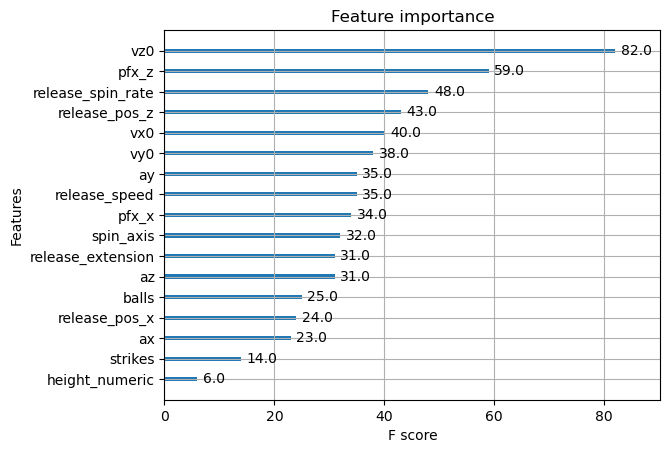

In [16]:
xgb.plot_importance(model)
plt.show()

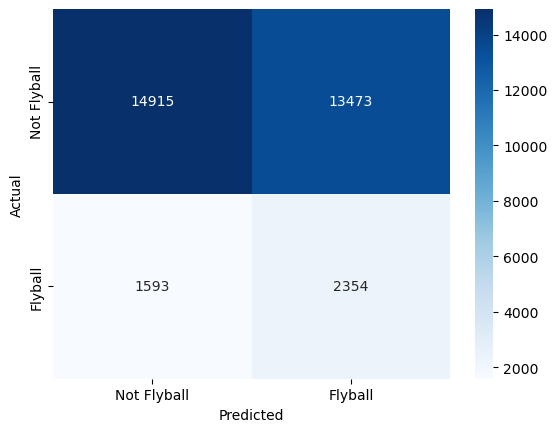

In [17]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Flyball', 'Flyball'], yticklabels=['Not Flyball', 'Flyball'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [20]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [ ]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

[I 2023-11-09 16:28:35,428] A new study created in memory with name: no-name-f2091d72-a894-4c6f-ae06-cf66f16bf74a


[0]	eval-logloss:0.69055
[1]	eval-logloss:0.68787
[2]	eval-logloss:0.68694
[3]	eval-logloss:0.68611
[4]	eval-logloss:0.68486
[5]	eval-logloss:0.68450
[6]	eval-logloss:0.68370
[7]	eval-logloss:0.68344
[8]	eval-logloss:0.68197
[9]	eval-logloss:0.68099
[10]	eval-logloss:0.68053
[11]	eval-logloss:0.68034
[12]	eval-logloss:0.68016
[13]	eval-logloss:0.68064
[14]	eval-logloss:0.68055
[15]	eval-logloss:0.68037
[16]	eval-logloss:0.67999
[17]	eval-logloss:0.67945
[18]	eval-logloss:0.67970
[19]	eval-logloss:0.67927
[20]	eval-logloss:0.67882
[21]	eval-logloss:0.67893
[22]	eval-logloss:0.67918
[23]	eval-logloss:0.67884
[24]	eval-logloss:0.67974
[25]	eval-logloss:0.68030
[26]	eval-logloss:0.67938
[27]	eval-logloss:0.67863
[28]	eval-logloss:0.67851
[29]	eval-logloss:0.67829
[30]	eval-logloss:0.67724
[31]	eval-logloss:0.67726
[32]	eval-logloss:0.67728
[33]	eval-logloss:0.67695
[34]	eval-logloss:0.67724
[35]	eval-logloss:0.67698
[36]	eval-logloss:0.67665
[37]	eval-logloss:0.67602
[38]	eval-logloss:0.67

[I 2023-11-09 16:28:36,821] Trial 0 finished with value: 0.6712675703071345 and parameters: {'max_depth': 3, 'eta': 0.24278961962135812, 'subsample': 0.7952068851221762, 'colsample_bytree': 0.7198516727337829}. Best is trial 0 with value: 0.6712675703071345.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69098
[2]	eval-logloss:0.69006
[3]	eval-logloss:0.68890
[4]	eval-logloss:0.68789
[5]	eval-logloss:0.68697
[6]	eval-logloss:0.68612
[7]	eval-logloss:0.68563
[8]	eval-logloss:0.68500
[9]	eval-logloss:0.68434
[10]	eval-logloss:0.68353
[11]	eval-logloss:0.68286
[12]	eval-logloss:0.68226
[13]	eval-logloss:0.68193
[14]	eval-logloss:0.68154
[15]	eval-logloss:0.68113
[16]	eval-logloss:0.68067
[17]	eval-logloss:0.68005
[18]	eval-logloss:0.67965
[19]	eval-logloss:0.67919
[20]	eval-logloss:0.67879
[21]	eval-logloss:0.67847
[22]	eval-logloss:0.67818
[23]	eval-logloss:0.67777
[24]	eval-logloss:0.67758
[25]	eval-logloss:0.67742
[26]	eval-logloss:0.67709
[27]	eval-logloss:0.67674
[28]	eval-logloss:0.67643
[29]	eval-logloss:0.67620
[30]	eval-logloss:0.67581
[31]	eval-logloss:0.67553
[32]	eval-logloss:0.67535
[33]	eval-logloss:0.67531
[34]	eval-logloss:0.67502
[35]	eval-logloss:0.67486
[36]	eval-logloss:0.67475
[37]	eval-logloss:0.67442
[38]	eval-logloss:0.67

[I 2023-11-09 16:28:38,429] Trial 1 finished with value: 0.6670266081184248 and parameters: {'max_depth': 5, 'eta': 0.0672799464611078, 'subsample': 0.8691173342007809, 'colsample_bytree': 0.5527230090884787}. Best is trial 0 with value: 0.6712675703071345.


[0]	eval-logloss:0.68571
[1]	eval-logloss:0.68070
[2]	eval-logloss:0.67709
[3]	eval-logloss:0.67347
[4]	eval-logloss:0.67047
[5]	eval-logloss:0.66778
[6]	eval-logloss:0.66562
[7]	eval-logloss:0.66359
[8]	eval-logloss:0.66134
[9]	eval-logloss:0.65914
[10]	eval-logloss:0.65720
[11]	eval-logloss:0.65495
[12]	eval-logloss:0.65389
[13]	eval-logloss:0.65293
[14]	eval-logloss:0.65144
[15]	eval-logloss:0.65064
[16]	eval-logloss:0.64894
[17]	eval-logloss:0.64712
[18]	eval-logloss:0.64694
[19]	eval-logloss:0.64522
[20]	eval-logloss:0.64308
[21]	eval-logloss:0.64237
[22]	eval-logloss:0.64226
[23]	eval-logloss:0.64088
[24]	eval-logloss:0.63994
[25]	eval-logloss:0.63959
[26]	eval-logloss:0.63800
[27]	eval-logloss:0.63682
[28]	eval-logloss:0.63584
[29]	eval-logloss:0.63510
[30]	eval-logloss:0.63371
[31]	eval-logloss:0.63338
[32]	eval-logloss:0.63142
[33]	eval-logloss:0.63112
[34]	eval-logloss:0.63002
[35]	eval-logloss:0.62912
[36]	eval-logloss:0.62732
[37]	eval-logloss:0.62650
[38]	eval-logloss:0.62

[I 2023-11-09 16:28:40,413] Trial 2 finished with value: 0.5818662386872374 and parameters: {'max_depth': 8, 'eta': 0.16845339736034792, 'subsample': 0.7817598905419496, 'colsample_bytree': 0.9698716740872593}. Best is trial 0 with value: 0.6712675703071345.


[0]	eval-logloss:0.68920
[1]	eval-logloss:0.68479
[2]	eval-logloss:0.68382
[3]	eval-logloss:0.68243
[4]	eval-logloss:0.68082
[5]	eval-logloss:0.67979
[6]	eval-logloss:0.67900
[7]	eval-logloss:0.67820
[8]	eval-logloss:0.67560
[9]	eval-logloss:0.67439
[10]	eval-logloss:0.67347
[11]	eval-logloss:0.67414
[12]	eval-logloss:0.67332
[13]	eval-logloss:0.67380
[14]	eval-logloss:0.67348
[15]	eval-logloss:0.67309
[16]	eval-logloss:0.67154
[17]	eval-logloss:0.67039
[18]	eval-logloss:0.67072
[19]	eval-logloss:0.67107
[20]	eval-logloss:0.66974
[21]	eval-logloss:0.66940
[22]	eval-logloss:0.67005
[23]	eval-logloss:0.67097
[24]	eval-logloss:0.67118
[25]	eval-logloss:0.67104
[26]	eval-logloss:0.66925
[27]	eval-logloss:0.66789
[28]	eval-logloss:0.66906
[29]	eval-logloss:0.66913
[30]	eval-logloss:0.66811
[31]	eval-logloss:0.66845
[32]	eval-logloss:0.66626
[33]	eval-logloss:0.66637
[34]	eval-logloss:0.66587
[35]	eval-logloss:0.66481
[36]	eval-logloss:0.66456
[37]	eval-logloss:0.66409
[38]	eval-logloss:0.66

[I 2023-11-09 16:28:41,868] Trial 3 finished with value: 0.6487846266590703 and parameters: {'max_depth': 5, 'eta': 0.27260125223092124, 'subsample': 0.6445676405019425, 'colsample_bytree': 0.6394924845402086}. Best is trial 0 with value: 0.6712675703071345.


[0]	eval-logloss:0.68139
[1]	eval-logloss:0.67177
[2]	eval-logloss:0.66540
[3]	eval-logloss:0.65958
[4]	eval-logloss:0.65529
[5]	eval-logloss:0.65136
[6]	eval-logloss:0.64854
[7]	eval-logloss:0.64580
[8]	eval-logloss:0.64482
[9]	eval-logloss:0.64150
[10]	eval-logloss:0.63845
[11]	eval-logloss:0.63587
[12]	eval-logloss:0.63380
[13]	eval-logloss:0.63244
[14]	eval-logloss:0.63187
[15]	eval-logloss:0.63023
[16]	eval-logloss:0.62668
[17]	eval-logloss:0.62415
[18]	eval-logloss:0.62139
[19]	eval-logloss:0.61956
[20]	eval-logloss:0.61635
[21]	eval-logloss:0.61397
[22]	eval-logloss:0.61329
[23]	eval-logloss:0.61014
[24]	eval-logloss:0.60808
[25]	eval-logloss:0.60784
[26]	eval-logloss:0.60622
[27]	eval-logloss:0.60398
[28]	eval-logloss:0.60075
[29]	eval-logloss:0.59987
[30]	eval-logloss:0.59721
[31]	eval-logloss:0.59687
[32]	eval-logloss:0.59511
[33]	eval-logloss:0.59339
[34]	eval-logloss:0.59145
[35]	eval-logloss:0.58813
[36]	eval-logloss:0.58726
[37]	eval-logloss:0.58550
[38]	eval-logloss:0.58

[I 2023-11-09 16:28:44,161] Trial 4 finished with value: 0.5122756844552907 and parameters: {'max_depth': 9, 'eta': 0.29821377788341047, 'subsample': 0.862759874329621, 'colsample_bytree': 0.8357687630934744}. Best is trial 0 with value: 0.6712675703071345.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69098
[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68900
[4]	eval-logloss:0.68804
[5]	eval-logloss:0.68713
[6]	eval-logloss:0.68612
[7]	eval-logloss:0.68547
[8]	eval-logloss:0.68448
[9]	eval-logloss:0.68375
[10]	eval-logloss:0.68294
[11]	eval-logloss:0.68218
[12]	eval-logloss:0.68138
[13]	eval-logloss:0.68062
[14]	eval-logloss:0.67988
[15]	eval-logloss:0.67920
[16]	eval-logloss:0.67858
[17]	eval-logloss:0.67780
[18]	eval-logloss:0.67706
[19]	eval-logloss:0.67639
[20]	eval-logloss:0.67580
[21]	eval-logloss:0.67527
[22]	eval-logloss:0.67457
[23]	eval-logloss:0.67401
[24]	eval-logloss:0.67350
[25]	eval-logloss:0.67306
[26]	eval-logloss:0.67253
[27]	eval-logloss:0.67198
[28]	eval-logloss:0.67149
[29]	eval-logloss:0.67109
[30]	eval-logloss:0.67045
[31]	eval-logloss:0.67006
[32]	eval-logloss:0.66955
[33]	eval-logloss:0.66910
[34]	eval-logloss:0.66867
[35]	eval-logloss:0.66825
[36]	eval-logloss:0.66792
[37]	eval-logloss:0.66743
[38]	eval-logloss:0.66

[I 2023-11-09 16:28:46,285] Trial 5 finished with value: 0.6478332798273739 and parameters: {'max_depth': 8, 'eta': 0.027963896462648255, 'subsample': 0.8906655581787329, 'colsample_bytree': 0.6313056645446442}. Best is trial 0 with value: 0.6712675703071345.


[0]	eval-logloss:0.69074
[1]	eval-logloss:0.68864
[2]	eval-logloss:0.68723
[3]	eval-logloss:0.68583
[4]	eval-logloss:0.68473
[5]	eval-logloss:0.68392
[6]	eval-logloss:0.68302
[7]	eval-logloss:0.68241
[8]	eval-logloss:0.68095
[9]	eval-logloss:0.67983
[10]	eval-logloss:0.67873
[11]	eval-logloss:0.67811
[12]	eval-logloss:0.67764
[13]	eval-logloss:0.67734
[14]	eval-logloss:0.67687
[15]	eval-logloss:0.67662
[16]	eval-logloss:0.67601
[17]	eval-logloss:0.67567
[18]	eval-logloss:0.67555
[19]	eval-logloss:0.67543
[20]	eval-logloss:0.67476
[21]	eval-logloss:0.67457
[22]	eval-logloss:0.67441
[23]	eval-logloss:0.67416
[24]	eval-logloss:0.67423
[25]	eval-logloss:0.67424
[26]	eval-logloss:0.67358
[27]	eval-logloss:0.67294
[28]	eval-logloss:0.67289
[29]	eval-logloss:0.67244
[30]	eval-logloss:0.67209
[31]	eval-logloss:0.67224
[32]	eval-logloss:0.67145
[33]	eval-logloss:0.67121
[34]	eval-logloss:0.67095
[35]	eval-logloss:0.67031
[36]	eval-logloss:0.66991
[37]	eval-logloss:0.66950
[38]	eval-logloss:0.66

[I 2023-11-09 16:28:47,816] Trial 6 finished with value: 0.6577512499981097 and parameters: {'max_depth': 5, 'eta': 0.10871983147652646, 'subsample': 0.7048567114173598, 'colsample_bytree': 0.8242974265690863}. Best is trial 0 with value: 0.6712675703071345.


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.68878
[2]	eval-logloss:0.68726
[3]	eval-logloss:0.68626
[4]	eval-logloss:0.68532
[5]	eval-logloss:0.68491
[6]	eval-logloss:0.68424
[7]	eval-logloss:0.68378
[8]	eval-logloss:0.68301
[9]	eval-logloss:0.68213
[10]	eval-logloss:0.68166
[11]	eval-logloss:0.68114
[12]	eval-logloss:0.68092
[13]	eval-logloss:0.68114
[14]	eval-logloss:0.68070
[15]	eval-logloss:0.68061
[16]	eval-logloss:0.68014
[17]	eval-logloss:0.67934
[18]	eval-logloss:0.67934
[19]	eval-logloss:0.67904
[20]	eval-logloss:0.67871
[21]	eval-logloss:0.67890
[22]	eval-logloss:0.67886
[23]	eval-logloss:0.67859
[24]	eval-logloss:0.67839
[25]	eval-logloss:0.67858
[26]	eval-logloss:0.67840
[27]	eval-logloss:0.67805
[28]	eval-logloss:0.67785
[29]	eval-logloss:0.67778
[30]	eval-logloss:0.67725
[31]	eval-logloss:0.67704
[32]	eval-logloss:0.67708
[33]	eval-logloss:0.67715
[34]	eval-logloss:0.67703
[35]	eval-logloss:0.67696
[36]	eval-logloss:0.67686
[37]	eval-logloss:0.67654
[38]	eval-logloss:0.67

[I 2023-11-09 16:28:49,085] Trial 7 finished with value: 0.6715199458807274 and parameters: {'max_depth': 3, 'eta': 0.16594201608338996, 'subsample': 0.8806168162457405, 'colsample_bytree': 0.9826886704280113}. Best is trial 7 with value: 0.6715199458807274.


[0]	eval-logloss:0.68446
[1]	eval-logloss:0.67561
[2]	eval-logloss:0.67112
[3]	eval-logloss:0.66544
[4]	eval-logloss:0.66196
[5]	eval-logloss:0.65900
[6]	eval-logloss:0.65679
[7]	eval-logloss:0.65443
[8]	eval-logloss:0.64920
[9]	eval-logloss:0.64720
[10]	eval-logloss:0.64429
[11]	eval-logloss:0.64295
[12]	eval-logloss:0.64204
[13]	eval-logloss:0.64184
[14]	eval-logloss:0.63965
[15]	eval-logloss:0.63859
[16]	eval-logloss:0.63512
[17]	eval-logloss:0.63219
[18]	eval-logloss:0.63150
[19]	eval-logloss:0.63091
[20]	eval-logloss:0.62984
[21]	eval-logloss:0.62806
[22]	eval-logloss:0.62569
[23]	eval-logloss:0.62559
[24]	eval-logloss:0.62475
[25]	eval-logloss:0.62319
[26]	eval-logloss:0.62116
[27]	eval-logloss:0.61901
[28]	eval-logloss:0.61806
[29]	eval-logloss:0.61648
[30]	eval-logloss:0.61417
[31]	eval-logloss:0.61410
[32]	eval-logloss:0.61238
[33]	eval-logloss:0.61211
[34]	eval-logloss:0.61010
[35]	eval-logloss:0.60804
[36]	eval-logloss:0.60739
[37]	eval-logloss:0.60685
[38]	eval-logloss:0.60

[I 2023-11-09 16:28:51,487] Trial 8 finished with value: 0.5438123053512313 and parameters: {'max_depth': 9, 'eta': 0.21438599030629527, 'subsample': 0.6982878354144345, 'colsample_bytree': 0.6150147485695644}. Best is trial 7 with value: 0.6715199458807274.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69184
[2]	eval-logloss:0.69134
[3]	eval-logloss:0.69086
[4]	eval-logloss:0.69029
[5]	eval-logloss:0.68984
[6]	eval-logloss:0.68935
[7]	eval-logloss:0.68911
[8]	eval-logloss:0.68847
[9]	eval-logloss:0.68795
[10]	eval-logloss:0.68758
[11]	eval-logloss:0.68728
[12]	eval-logloss:0.68697
[13]	eval-logloss:0.68679
[14]	eval-logloss:0.68652
[15]	eval-logloss:0.68626
[16]	eval-logloss:0.68601
[17]	eval-logloss:0.68564
[18]	eval-logloss:0.68550
[19]	eval-logloss:0.68525
[20]	eval-logloss:0.68500
[21]	eval-logloss:0.68490
[22]	eval-logloss:0.68478
[23]	eval-logloss:0.68460
[24]	eval-logloss:0.68460
[25]	eval-logloss:0.68465
[26]	eval-logloss:0.68438
[27]	eval-logloss:0.68415
[28]	eval-logloss:0.68403
[29]	eval-logloss:0.68392
[30]	eval-logloss:0.68360
[31]	eval-logloss:0.68354
[32]	eval-logloss:0.68333
[33]	eval-logloss:0.68320
[34]	eval-logloss:0.68308
[35]	eval-logloss:0.68295
[36]	eval-logloss:0.68281
[37]	eval-logloss:0.68259
[38]	eval-logloss:0.68

[I 2023-11-09 16:28:52,904] Trial 9 finished with value: 0.678587772410527 and parameters: {'max_depth': 3, 'eta': 0.048476701550162545, 'subsample': 0.7834567460384115, 'colsample_bytree': 0.6868423337713594}. Best is trial 9 with value: 0.678587772410527.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69270
[3]	eval-logloss:0.69253
[4]	eval-logloss:0.69232
[5]	eval-logloss:0.69212
[6]	eval-logloss:0.69193
[7]	eval-logloss:0.69181
[8]	eval-logloss:0.69164
[9]	eval-logloss:0.69149
[10]	eval-logloss:0.69126
[11]	eval-logloss:0.69108
[12]	eval-logloss:0.69085
[13]	eval-logloss:0.69072
[14]	eval-logloss:0.69064
[15]	eval-logloss:0.69050
[16]	eval-logloss:0.69037
[17]	eval-logloss:0.69021
[18]	eval-logloss:0.69006
[19]	eval-logloss:0.68994
[20]	eval-logloss:0.68976
[21]	eval-logloss:0.68962
[22]	eval-logloss:0.68949
[23]	eval-logloss:0.68938
[24]	eval-logloss:0.68927
[25]	eval-logloss:0.68915
[26]	eval-logloss:0.68896
[27]	eval-logloss:0.68879
[28]	eval-logloss:0.68876
[29]	eval-logloss:0.68867
[30]	eval-logloss:0.68854
[31]	eval-logloss:0.68846
[32]	eval-logloss:0.68820
[33]	eval-logloss:0.68809
[34]	eval-logloss:0.68792
[35]	eval-logloss:0.68779
[36]	eval-logloss:0.68768
[37]	eval-logloss:0.68755
[38]	eval-logloss:0.68

[I 2023-11-09 16:28:54,440] Trial 10 finished with value: 0.6824792847077598 and parameters: {'max_depth': 4, 'eta': 0.012017211284131267, 'subsample': 0.6004457263087025, 'colsample_bytree': 0.5441559055257095}. Best is trial 10 with value: 0.6824792847077598.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69247
[4]	eval-logloss:0.69223
[5]	eval-logloss:0.69204
[6]	eval-logloss:0.69183
[7]	eval-logloss:0.69171
[8]	eval-logloss:0.69150
[9]	eval-logloss:0.69134
[10]	eval-logloss:0.69110
[11]	eval-logloss:0.69092
[12]	eval-logloss:0.69069
[13]	eval-logloss:0.69057
[14]	eval-logloss:0.69050
[15]	eval-logloss:0.69036
[16]	eval-logloss:0.69023
[17]	eval-logloss:0.69006
[18]	eval-logloss:0.68993
[19]	eval-logloss:0.68983
[20]	eval-logloss:0.68962
[21]	eval-logloss:0.68948
[22]	eval-logloss:0.68935
[23]	eval-logloss:0.68928
[24]	eval-logloss:0.68919
[25]	eval-logloss:0.68906
[26]	eval-logloss:0.68887
[27]	eval-logloss:0.68869
[28]	eval-logloss:0.68870
[29]	eval-logloss:0.68863
[30]	eval-logloss:0.68847
[31]	eval-logloss:0.68843
[32]	eval-logloss:0.68815
[33]	eval-logloss:0.68806
[34]	eval-logloss:0.68789
[35]	eval-logloss:0.68774
[36]	eval-logloss:0.68763
[37]	eval-logloss:0.68751
[38]	eval-logloss:0.68

[I 2023-11-09 16:28:55,867] Trial 11 finished with value: 0.683097781476036 and parameters: {'max_depth': 3, 'eta': 0.01688918634433647, 'subsample': 0.6114050521463743, 'colsample_bytree': 0.514844978892472}. Best is trial 11 with value: 0.683097781476036.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69271
[2]	eval-logloss:0.69256
[3]	eval-logloss:0.69235
[4]	eval-logloss:0.69207
[5]	eval-logloss:0.69184
[6]	eval-logloss:0.69160
[7]	eval-logloss:0.69145
[8]	eval-logloss:0.69123
[9]	eval-logloss:0.69104
[10]	eval-logloss:0.69075
[11]	eval-logloss:0.69052
[12]	eval-logloss:0.69025
[13]	eval-logloss:0.69009
[14]	eval-logloss:0.68999
[15]	eval-logloss:0.68982
[16]	eval-logloss:0.68965
[17]	eval-logloss:0.68945
[18]	eval-logloss:0.68926
[19]	eval-logloss:0.68913
[20]	eval-logloss:0.68891
[21]	eval-logloss:0.68874
[22]	eval-logloss:0.68859
[23]	eval-logloss:0.68847
[24]	eval-logloss:0.68835
[25]	eval-logloss:0.68821
[26]	eval-logloss:0.68798
[27]	eval-logloss:0.68779
[28]	eval-logloss:0.68776
[29]	eval-logloss:0.68766
[30]	eval-logloss:0.68750
[31]	eval-logloss:0.68741
[32]	eval-logloss:0.68709
[33]	eval-logloss:0.68696
[34]	eval-logloss:0.68676
[35]	eval-logloss:0.68661
[36]	eval-logloss:0.68649
[37]	eval-logloss:0.68633
[38]	eval-logloss:0.68

[I 2023-11-09 16:28:57,299] Trial 12 finished with value: 0.6808617603830558 and parameters: {'max_depth': 4, 'eta': 0.01567208470392989, 'subsample': 0.6010868251008338, 'colsample_bytree': 0.5009795754365493}. Best is trial 11 with value: 0.683097781476036.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.68974
[2]	eval-logloss:0.68871
[3]	eval-logloss:0.68719
[4]	eval-logloss:0.68576
[5]	eval-logloss:0.68439
[6]	eval-logloss:0.68299
[7]	eval-logloss:0.68227
[8]	eval-logloss:0.68113
[9]	eval-logloss:0.68014
[10]	eval-logloss:0.67879
[11]	eval-logloss:0.67788
[12]	eval-logloss:0.67699
[13]	eval-logloss:0.67678
[14]	eval-logloss:0.67638
[15]	eval-logloss:0.67600
[16]	eval-logloss:0.67515
[17]	eval-logloss:0.67454
[18]	eval-logloss:0.67410
[19]	eval-logloss:0.67389
[20]	eval-logloss:0.67321
[21]	eval-logloss:0.67278
[22]	eval-logloss:0.67246
[23]	eval-logloss:0.67228
[24]	eval-logloss:0.67210
[25]	eval-logloss:0.67164
[26]	eval-logloss:0.67102
[27]	eval-logloss:0.67043
[28]	eval-logloss:0.67044
[29]	eval-logloss:0.67055
[30]	eval-logloss:0.67009
[31]	eval-logloss:0.66978
[32]	eval-logloss:0.66868
[33]	eval-logloss:0.66850
[34]	eval-logloss:0.66813
[35]	eval-logloss:0.66768
[36]	eval-logloss:0.66774
[37]	eval-logloss:0.66722
[38]	eval-logloss:0.66

[I 2023-11-09 16:28:58,970] Trial 13 finished with value: 0.6542017142711163 and parameters: {'max_depth': 6, 'eta': 0.08079773178856525, 'subsample': 0.6001518308625453, 'colsample_bytree': 0.5151074158797463}. Best is trial 11 with value: 0.683097781476036.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69252
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69206
[4]	eval-logloss:0.69179
[5]	eval-logloss:0.69151
[6]	eval-logloss:0.69120
[7]	eval-logloss:0.69100
[8]	eval-logloss:0.69070
[9]	eval-logloss:0.69046
[10]	eval-logloss:0.69016
[11]	eval-logloss:0.68996
[12]	eval-logloss:0.68967
[13]	eval-logloss:0.68949
[14]	eval-logloss:0.68936
[15]	eval-logloss:0.68914
[16]	eval-logloss:0.68892
[17]	eval-logloss:0.68866
[18]	eval-logloss:0.68843
[19]	eval-logloss:0.68828
[20]	eval-logloss:0.68801
[21]	eval-logloss:0.68781
[22]	eval-logloss:0.68762
[23]	eval-logloss:0.68749
[24]	eval-logloss:0.68733
[25]	eval-logloss:0.68720
[26]	eval-logloss:0.68695
[27]	eval-logloss:0.68672
[28]	eval-logloss:0.68670
[29]	eval-logloss:0.68659
[30]	eval-logloss:0.68643
[31]	eval-logloss:0.68633
[32]	eval-logloss:0.68598
[33]	eval-logloss:0.68585
[34]	eval-logloss:0.68565
[35]	eval-logloss:0.68547
[36]	eval-logloss:0.68531
[37]	eval-logloss:0.68515
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:00,449] Trial 14 finished with value: 0.6798162307622003 and parameters: {'max_depth': 4, 'eta': 0.018872828869097052, 'subsample': 0.6504407575463677, 'colsample_bytree': 0.5676266546155955}. Best is trial 11 with value: 0.683097781476036.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.69024
[2]	eval-logloss:0.68948
[3]	eval-logloss:0.68855
[4]	eval-logloss:0.68759
[5]	eval-logloss:0.68684
[6]	eval-logloss:0.68599
[7]	eval-logloss:0.68547
[8]	eval-logloss:0.68425
[9]	eval-logloss:0.68339
[10]	eval-logloss:0.68254
[11]	eval-logloss:0.68223
[12]	eval-logloss:0.68170
[13]	eval-logloss:0.68148
[14]	eval-logloss:0.68129
[15]	eval-logloss:0.68099
[16]	eval-logloss:0.68033
[17]	eval-logloss:0.67990
[18]	eval-logloss:0.67975
[19]	eval-logloss:0.67992
[20]	eval-logloss:0.67939
[21]	eval-logloss:0.67909
[22]	eval-logloss:0.67896
[23]	eval-logloss:0.67904
[24]	eval-logloss:0.67904
[25]	eval-logloss:0.67898
[26]	eval-logloss:0.67849
[27]	eval-logloss:0.67791
[28]	eval-logloss:0.67821
[29]	eval-logloss:0.67823
[30]	eval-logloss:0.67770
[31]	eval-logloss:0.67784
[32]	eval-logloss:0.67677
[33]	eval-logloss:0.67678
[34]	eval-logloss:0.67651
[35]	eval-logloss:0.67615
[36]	eval-logloss:0.67593
[37]	eval-logloss:0.67547
[38]	eval-logloss:0.67

[I 2023-11-09 16:29:01,883] Trial 15 finished with value: 0.6700909026986978 and parameters: {'max_depth': 4, 'eta': 0.0996101258329079, 'subsample': 0.6412160603506969, 'colsample_bytree': 0.574876379187204}. Best is trial 11 with value: 0.683097781476036.


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.69082
[2]	eval-logloss:0.68999
[3]	eval-logloss:0.68883
[4]	eval-logloss:0.68786
[5]	eval-logloss:0.68680
[6]	eval-logloss:0.68574
[7]	eval-logloss:0.68520
[8]	eval-logloss:0.68423
[9]	eval-logloss:0.68356
[10]	eval-logloss:0.68262
[11]	eval-logloss:0.68198
[12]	eval-logloss:0.68121
[13]	eval-logloss:0.68065
[14]	eval-logloss:0.68027
[15]	eval-logloss:0.67981
[16]	eval-logloss:0.67928
[17]	eval-logloss:0.67869
[18]	eval-logloss:0.67820
[19]	eval-logloss:0.67785
[20]	eval-logloss:0.67726
[21]	eval-logloss:0.67678
[22]	eval-logloss:0.67646
[23]	eval-logloss:0.67628
[24]	eval-logloss:0.67615
[25]	eval-logloss:0.67588
[26]	eval-logloss:0.67526
[27]	eval-logloss:0.67474
[28]	eval-logloss:0.67471
[29]	eval-logloss:0.67436
[30]	eval-logloss:0.67395
[31]	eval-logloss:0.67380
[32]	eval-logloss:0.67309
[33]	eval-logloss:0.67284
[34]	eval-logloss:0.67238
[35]	eval-logloss:0.67192
[36]	eval-logloss:0.67154
[37]	eval-logloss:0.67127
[38]	eval-logloss:0.67

[I 2023-11-09 16:29:03,456] Trial 16 finished with value: 0.6613111617253131 and parameters: {'max_depth': 6, 'eta': 0.055029823072373314, 'subsample': 0.6814078125873366, 'colsample_bytree': 0.5096614737133431}. Best is trial 11 with value: 0.683097781476036.


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.68971
[2]	eval-logloss:0.68887
[3]	eval-logloss:0.68800
[4]	eval-logloss:0.68674
[5]	eval-logloss:0.68585
[6]	eval-logloss:0.68526
[7]	eval-logloss:0.68484
[8]	eval-logloss:0.68333
[9]	eval-logloss:0.68240
[10]	eval-logloss:0.68126
[11]	eval-logloss:0.68079
[12]	eval-logloss:0.67995
[13]	eval-logloss:0.68002
[14]	eval-logloss:0.67996
[15]	eval-logloss:0.67965
[16]	eval-logloss:0.67885
[17]	eval-logloss:0.67849
[18]	eval-logloss:0.67838
[19]	eval-logloss:0.67866
[20]	eval-logloss:0.67803
[21]	eval-logloss:0.67771
[22]	eval-logloss:0.67784
[23]	eval-logloss:0.67809
[24]	eval-logloss:0.67813
[25]	eval-logloss:0.67780
[26]	eval-logloss:0.67712
[27]	eval-logloss:0.67677
[28]	eval-logloss:0.67706
[29]	eval-logloss:0.67725
[30]	eval-logloss:0.67674
[31]	eval-logloss:0.67663
[32]	eval-logloss:0.67517
[33]	eval-logloss:0.67516
[34]	eval-logloss:0.67485
[35]	eval-logloss:0.67446
[36]	eval-logloss:0.67457
[37]	eval-logloss:0.67418
[38]	eval-logloss:0.67

[I 2023-11-09 16:29:04,896] Trial 17 finished with value: 0.6681660876773844 and parameters: {'max_depth': 4, 'eta': 0.1238279346280318, 'subsample': 0.6012826245097613, 'colsample_bytree': 0.5867921502401494}. Best is trial 11 with value: 0.683097781476036.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69236
[3]	eval-logloss:0.69204
[4]	eval-logloss:0.69175
[5]	eval-logloss:0.69148
[6]	eval-logloss:0.69116
[7]	eval-logloss:0.69097
[8]	eval-logloss:0.69061
[9]	eval-logloss:0.69038
[10]	eval-logloss:0.69009
[11]	eval-logloss:0.68984
[12]	eval-logloss:0.68954
[13]	eval-logloss:0.68928
[14]	eval-logloss:0.68901
[15]	eval-logloss:0.68878
[16]	eval-logloss:0.68856
[17]	eval-logloss:0.68825
[18]	eval-logloss:0.68804
[19]	eval-logloss:0.68781
[20]	eval-logloss:0.68757
[21]	eval-logloss:0.68736
[22]	eval-logloss:0.68713
[23]	eval-logloss:0.68692
[24]	eval-logloss:0.68673
[25]	eval-logloss:0.68657
[26]	eval-logloss:0.68632
[27]	eval-logloss:0.68607
[28]	eval-logloss:0.68593
[29]	eval-logloss:0.68571
[30]	eval-logloss:0.68550
[31]	eval-logloss:0.68538
[32]	eval-logloss:0.68511
[33]	eval-logloss:0.68489
[34]	eval-logloss:0.68471
[35]	eval-logloss:0.68450
[36]	eval-logloss:0.68433
[37]	eval-logloss:0.68414
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:06,609] Trial 18 finished with value: 0.675910172724276 and parameters: {'max_depth': 6, 'eta': 0.011822252638822939, 'subsample': 0.7295552215269308, 'colsample_bytree': 0.6619540392970211}. Best is trial 11 with value: 0.683097781476036.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69203
[2]	eval-logloss:0.69178
[3]	eval-logloss:0.69127
[4]	eval-logloss:0.69085
[5]	eval-logloss:0.69047
[6]	eval-logloss:0.69007
[7]	eval-logloss:0.68978
[8]	eval-logloss:0.68919
[9]	eval-logloss:0.68884
[10]	eval-logloss:0.68835
[11]	eval-logloss:0.68808
[12]	eval-logloss:0.68771
[13]	eval-logloss:0.68751
[14]	eval-logloss:0.68739
[15]	eval-logloss:0.68723
[16]	eval-logloss:0.68698
[17]	eval-logloss:0.68662
[18]	eval-logloss:0.68640
[19]	eval-logloss:0.68627
[20]	eval-logloss:0.68590
[21]	eval-logloss:0.68569
[22]	eval-logloss:0.68558
[23]	eval-logloss:0.68555
[24]	eval-logloss:0.68546
[25]	eval-logloss:0.68538
[26]	eval-logloss:0.68503
[27]	eval-logloss:0.68473
[28]	eval-logloss:0.68480
[29]	eval-logloss:0.68471
[30]	eval-logloss:0.68454
[31]	eval-logloss:0.68451
[32]	eval-logloss:0.68395
[33]	eval-logloss:0.68387
[34]	eval-logloss:0.68364
[35]	eval-logloss:0.68347
[36]	eval-logloss:0.68332
[37]	eval-logloss:0.68315
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:07,978] Trial 19 finished with value: 0.6792752893159946 and parameters: {'max_depth': 3, 'eta': 0.0451950012438022, 'subsample': 0.6618174609664202, 'colsample_bytree': 0.5473046830989811}. Best is trial 11 with value: 0.683097781476036.


[0]	eval-logloss:0.69098
[1]	eval-logloss:0.68854
[2]	eval-logloss:0.68719
[3]	eval-logloss:0.68544
[4]	eval-logloss:0.68369
[5]	eval-logloss:0.68214
[6]	eval-logloss:0.68039
[7]	eval-logloss:0.67930
[8]	eval-logloss:0.67822
[9]	eval-logloss:0.67694
[10]	eval-logloss:0.67563
[11]	eval-logloss:0.67475
[12]	eval-logloss:0.67361
[13]	eval-logloss:0.67264
[14]	eval-logloss:0.67194
[15]	eval-logloss:0.67122
[16]	eval-logloss:0.67012
[17]	eval-logloss:0.66904
[18]	eval-logloss:0.66848
[19]	eval-logloss:0.66805
[20]	eval-logloss:0.66721
[21]	eval-logloss:0.66662
[22]	eval-logloss:0.66605
[23]	eval-logloss:0.66574
[24]	eval-logloss:0.66533
[25]	eval-logloss:0.66471
[26]	eval-logloss:0.66415
[27]	eval-logloss:0.66351
[28]	eval-logloss:0.66331
[29]	eval-logloss:0.66322
[30]	eval-logloss:0.66254
[31]	eval-logloss:0.66225
[32]	eval-logloss:0.66131
[33]	eval-logloss:0.66127
[34]	eval-logloss:0.66052
[35]	eval-logloss:0.66009
[36]	eval-logloss:0.65952
[37]	eval-logloss:0.65878
[38]	eval-logloss:0.65

[I 2023-11-09 16:29:09,914] Trial 20 finished with value: 0.6412374816132262 and parameters: {'max_depth': 7, 'eta': 0.07454598962407374, 'subsample': 0.6336043933594062, 'colsample_bytree': 0.5961697329372928}. Best is trial 11 with value: 0.683097781476036.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69267
[3]	eval-logloss:0.69251
[4]	eval-logloss:0.69229
[5]	eval-logloss:0.69209
[6]	eval-logloss:0.69189
[7]	eval-logloss:0.69176
[8]	eval-logloss:0.69158
[9]	eval-logloss:0.69142
[10]	eval-logloss:0.69120
[11]	eval-logloss:0.69103
[12]	eval-logloss:0.69080
[13]	eval-logloss:0.69066
[14]	eval-logloss:0.69058
[15]	eval-logloss:0.69044
[16]	eval-logloss:0.69030
[17]	eval-logloss:0.69012
[18]	eval-logloss:0.68997
[19]	eval-logloss:0.68984
[20]	eval-logloss:0.68966
[21]	eval-logloss:0.68953
[22]	eval-logloss:0.68939
[23]	eval-logloss:0.68929
[24]	eval-logloss:0.68919
[25]	eval-logloss:0.68906
[26]	eval-logloss:0.68887
[27]	eval-logloss:0.68871
[28]	eval-logloss:0.68869
[29]	eval-logloss:0.68858
[30]	eval-logloss:0.68844
[31]	eval-logloss:0.68837
[32]	eval-logloss:0.68811
[33]	eval-logloss:0.68800
[34]	eval-logloss:0.68782
[35]	eval-logloss:0.68769
[36]	eval-logloss:0.68757
[37]	eval-logloss:0.68744
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:11,456] Trial 21 finished with value: 0.6823460250182339 and parameters: {'max_depth': 4, 'eta': 0.012303879762354392, 'subsample': 0.6171697274837642, 'colsample_bytree': 0.5014578398520956}. Best is trial 11 with value: 0.683097781476036.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69203
[2]	eval-logloss:0.69165
[3]	eval-logloss:0.69113
[4]	eval-logloss:0.69049
[5]	eval-logloss:0.69000
[6]	eval-logloss:0.68947
[7]	eval-logloss:0.68917
[8]	eval-logloss:0.68867
[9]	eval-logloss:0.68825
[10]	eval-logloss:0.68768
[11]	eval-logloss:0.68729
[12]	eval-logloss:0.68679
[13]	eval-logloss:0.68658
[14]	eval-logloss:0.68641
[15]	eval-logloss:0.68614
[16]	eval-logloss:0.68579
[17]	eval-logloss:0.68538
[18]	eval-logloss:0.68514
[19]	eval-logloss:0.68499
[20]	eval-logloss:0.68464
[21]	eval-logloss:0.68438
[22]	eval-logloss:0.68419
[23]	eval-logloss:0.68411
[24]	eval-logloss:0.68399
[25]	eval-logloss:0.68376
[26]	eval-logloss:0.68348
[27]	eval-logloss:0.68322
[28]	eval-logloss:0.68329
[29]	eval-logloss:0.68323
[30]	eval-logloss:0.68291
[31]	eval-logloss:0.68285
[32]	eval-logloss:0.68227
[33]	eval-logloss:0.68215
[34]	eval-logloss:0.68182
[35]	eval-logloss:0.68161
[36]	eval-logloss:0.68142
[37]	eval-logloss:0.68119
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:12,806] Trial 22 finished with value: 0.6762217395074523 and parameters: {'max_depth': 4, 'eta': 0.04092157154488951, 'subsample': 0.6240547513943765, 'colsample_bytree': 0.504897846745621}. Best is trial 11 with value: 0.683097781476036.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69122
[3]	eval-logloss:0.69048
[4]	eval-logloss:0.68987
[5]	eval-logloss:0.68924
[6]	eval-logloss:0.68867
[7]	eval-logloss:0.68828
[8]	eval-logloss:0.68757
[9]	eval-logloss:0.68709
[10]	eval-logloss:0.68643
[11]	eval-logloss:0.68600
[12]	eval-logloss:0.68545
[13]	eval-logloss:0.68507
[14]	eval-logloss:0.68483
[15]	eval-logloss:0.68456
[16]	eval-logloss:0.68413
[17]	eval-logloss:0.68366
[18]	eval-logloss:0.68328
[19]	eval-logloss:0.68302
[20]	eval-logloss:0.68257
[21]	eval-logloss:0.68226
[22]	eval-logloss:0.68195
[23]	eval-logloss:0.68175
[24]	eval-logloss:0.68161
[25]	eval-logloss:0.68142
[26]	eval-logloss:0.68105
[27]	eval-logloss:0.68069
[28]	eval-logloss:0.68061
[29]	eval-logloss:0.68040
[30]	eval-logloss:0.68017
[31]	eval-logloss:0.68002
[32]	eval-logloss:0.67943
[33]	eval-logloss:0.67925
[34]	eval-logloss:0.67899
[35]	eval-logloss:0.67871
[36]	eval-logloss:0.67851
[37]	eval-logloss:0.67830
[38]	eval-logloss:0.67

[I 2023-11-09 16:29:14,486] Trial 23 finished with value: 0.671013413684707 and parameters: {'max_depth': 5, 'eta': 0.04017375385937001, 'subsample': 0.6656976603895748, 'colsample_bytree': 0.5530673062726821}. Best is trial 11 with value: 0.683097781476036.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69264
[2]	eval-logloss:0.69249
[3]	eval-logloss:0.69227
[4]	eval-logloss:0.69198
[5]	eval-logloss:0.69176
[6]	eval-logloss:0.69150
[7]	eval-logloss:0.69134
[8]	eval-logloss:0.69109
[9]	eval-logloss:0.69088
[10]	eval-logloss:0.69060
[11]	eval-logloss:0.69039
[12]	eval-logloss:0.69014
[13]	eval-logloss:0.68998
[14]	eval-logloss:0.68989
[15]	eval-logloss:0.68972
[16]	eval-logloss:0.68955
[17]	eval-logloss:0.68933
[18]	eval-logloss:0.68920
[19]	eval-logloss:0.68907
[20]	eval-logloss:0.68883
[21]	eval-logloss:0.68867
[22]	eval-logloss:0.68855
[23]	eval-logloss:0.68849
[24]	eval-logloss:0.68840
[25]	eval-logloss:0.68826
[26]	eval-logloss:0.68807
[27]	eval-logloss:0.68790
[28]	eval-logloss:0.68793
[29]	eval-logloss:0.68786
[30]	eval-logloss:0.68768
[31]	eval-logloss:0.68764
[32]	eval-logloss:0.68733
[33]	eval-logloss:0.68724
[34]	eval-logloss:0.68705
[35]	eval-logloss:0.68689
[36]	eval-logloss:0.68676
[37]	eval-logloss:0.68661
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:15,913] Trial 24 finished with value: 0.6821676980633063 and parameters: {'max_depth': 3, 'eta': 0.020554583935949028, 'subsample': 0.6202745695856774, 'colsample_bytree': 0.6059885716846924}. Best is trial 11 with value: 0.683097781476036.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69284
[2]	eval-logloss:0.69274
[3]	eval-logloss:0.69259
[4]	eval-logloss:0.69240
[5]	eval-logloss:0.69224
[6]	eval-logloss:0.69206
[7]	eval-logloss:0.69194
[8]	eval-logloss:0.69180
[9]	eval-logloss:0.69166
[10]	eval-logloss:0.69147
[11]	eval-logloss:0.69132
[12]	eval-logloss:0.69112
[13]	eval-logloss:0.69101
[14]	eval-logloss:0.69093
[15]	eval-logloss:0.69080
[16]	eval-logloss:0.69067
[17]	eval-logloss:0.69051
[18]	eval-logloss:0.69038
[19]	eval-logloss:0.69026
[20]	eval-logloss:0.69010
[21]	eval-logloss:0.68998
[22]	eval-logloss:0.68985
[23]	eval-logloss:0.68974
[24]	eval-logloss:0.68964
[25]	eval-logloss:0.68952
[26]	eval-logloss:0.68936
[27]	eval-logloss:0.68921
[28]	eval-logloss:0.68918
[29]	eval-logloss:0.68910
[30]	eval-logloss:0.68895
[31]	eval-logloss:0.68889
[32]	eval-logloss:0.68866
[33]	eval-logloss:0.68855
[34]	eval-logloss:0.68839
[35]	eval-logloss:0.68827
[36]	eval-logloss:0.68815
[37]	eval-logloss:0.68802
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:17,426] Trial 25 finished with value: 0.6832022673132343 and parameters: {'max_depth': 4, 'eta': 0.010666051738519068, 'subsample': 0.6251949938180774, 'colsample_bytree': 0.5391952908684239}. Best is trial 25 with value: 0.6832022673132343.


[0]	eval-logloss:0.69200
[1]	eval-logloss:0.69062
[2]	eval-logloss:0.68992
[3]	eval-logloss:0.68870
[4]	eval-logloss:0.68780
[5]	eval-logloss:0.68689
[6]	eval-logloss:0.68605
[7]	eval-logloss:0.68557
[8]	eval-logloss:0.68459
[9]	eval-logloss:0.68388
[10]	eval-logloss:0.68298
[11]	eval-logloss:0.68250
[12]	eval-logloss:0.68189
[13]	eval-logloss:0.68149
[14]	eval-logloss:0.68124
[15]	eval-logloss:0.68100
[16]	eval-logloss:0.68042
[17]	eval-logloss:0.67982
[18]	eval-logloss:0.67944
[19]	eval-logloss:0.67925
[20]	eval-logloss:0.67867
[21]	eval-logloss:0.67833
[22]	eval-logloss:0.67810
[23]	eval-logloss:0.67806
[24]	eval-logloss:0.67799
[25]	eval-logloss:0.67785
[26]	eval-logloss:0.67735
[27]	eval-logloss:0.67693
[28]	eval-logloss:0.67693
[29]	eval-logloss:0.67687
[30]	eval-logloss:0.67663
[31]	eval-logloss:0.67653
[32]	eval-logloss:0.67576
[33]	eval-logloss:0.67564
[34]	eval-logloss:0.67531
[35]	eval-logloss:0.67499
[36]	eval-logloss:0.67478
[37]	eval-logloss:0.67448
[38]	eval-logloss:0.67

[I 2023-11-09 16:29:18,964] Trial 26 finished with value: 0.6661911131477837 and parameters: {'max_depth': 5, 'eta': 0.07061435961790274, 'subsample': 0.6634411761405833, 'colsample_bytree': 0.5426068554747997}. Best is trial 25 with value: 0.6832022673132343.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69223
[2]	eval-logloss:0.69200
[3]	eval-logloss:0.69162
[4]	eval-logloss:0.69116
[5]	eval-logloss:0.69085
[6]	eval-logloss:0.69043
[7]	eval-logloss:0.69018
[8]	eval-logloss:0.68975
[9]	eval-logloss:0.68942
[10]	eval-logloss:0.68899
[11]	eval-logloss:0.68870
[12]	eval-logloss:0.68835
[13]	eval-logloss:0.68816
[14]	eval-logloss:0.68806
[15]	eval-logloss:0.68786
[16]	eval-logloss:0.68758
[17]	eval-logloss:0.68723
[18]	eval-logloss:0.68708
[19]	eval-logloss:0.68698
[20]	eval-logloss:0.68666
[21]	eval-logloss:0.68643
[22]	eval-logloss:0.68624
[23]	eval-logloss:0.68623
[24]	eval-logloss:0.68611
[25]	eval-logloss:0.68598
[26]	eval-logloss:0.68574
[27]	eval-logloss:0.68550
[28]	eval-logloss:0.68558
[29]	eval-logloss:0.68556
[30]	eval-logloss:0.68530
[31]	eval-logloss:0.68528
[32]	eval-logloss:0.68482
[33]	eval-logloss:0.68473
[34]	eval-logloss:0.68447
[35]	eval-logloss:0.68426
[36]	eval-logloss:0.68411
[37]	eval-logloss:0.68394
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:20,210] Trial 27 finished with value: 0.6799302701227611 and parameters: {'max_depth': 3, 'eta': 0.03694951148009258, 'subsample': 0.6331539160866769, 'colsample_bytree': 0.594301260144344}. Best is trial 25 with value: 0.6832022673132343.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69139
[2]	eval-logloss:0.69088
[3]	eval-logloss:0.69021
[4]	eval-logloss:0.68938
[5]	eval-logloss:0.68875
[6]	eval-logloss:0.68810
[7]	eval-logloss:0.68771
[8]	eval-logloss:0.68681
[9]	eval-logloss:0.68621
[10]	eval-logloss:0.68552
[11]	eval-logloss:0.68506
[12]	eval-logloss:0.68450
[13]	eval-logloss:0.68419
[14]	eval-logloss:0.68380
[15]	eval-logloss:0.68355
[16]	eval-logloss:0.68309
[17]	eval-logloss:0.68260
[18]	eval-logloss:0.68243
[19]	eval-logloss:0.68237
[20]	eval-logloss:0.68197
[21]	eval-logloss:0.68174
[22]	eval-logloss:0.68160
[23]	eval-logloss:0.68167
[24]	eval-logloss:0.68163
[25]	eval-logloss:0.68136
[26]	eval-logloss:0.68103
[27]	eval-logloss:0.68074
[28]	eval-logloss:0.68088
[29]	eval-logloss:0.68090
[30]	eval-logloss:0.68055
[31]	eval-logloss:0.68052
[32]	eval-logloss:0.67982
[33]	eval-logloss:0.67979
[34]	eval-logloss:0.67941
[35]	eval-logloss:0.67917
[36]	eval-logloss:0.67899
[37]	eval-logloss:0.67874
[38]	eval-logloss:0.67

[I 2023-11-09 16:29:21,543] Trial 28 finished with value: 0.6732360427171159 and parameters: {'max_depth': 4, 'eta': 0.057510650544127136, 'subsample': 0.6206051804705993, 'colsample_bytree': 0.6437734166734246}. Best is trial 25 with value: 0.6832022673132343.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69085
[2]	eval-logloss:0.69007
[3]	eval-logloss:0.68934
[4]	eval-logloss:0.68867
[5]	eval-logloss:0.68823
[6]	eval-logloss:0.68769
[7]	eval-logloss:0.68737
[8]	eval-logloss:0.68624
[9]	eval-logloss:0.68563
[10]	eval-logloss:0.68510
[11]	eval-logloss:0.68477
[12]	eval-logloss:0.68437
[13]	eval-logloss:0.68412
[14]	eval-logloss:0.68403
[15]	eval-logloss:0.68388
[16]	eval-logloss:0.68354
[17]	eval-logloss:0.68315
[18]	eval-logloss:0.68299
[19]	eval-logloss:0.68309
[20]	eval-logloss:0.68252
[21]	eval-logloss:0.68228
[22]	eval-logloss:0.68226
[23]	eval-logloss:0.68231
[24]	eval-logloss:0.68256
[25]	eval-logloss:0.68264
[26]	eval-logloss:0.68215
[27]	eval-logloss:0.68160
[28]	eval-logloss:0.68188
[29]	eval-logloss:0.68168
[30]	eval-logloss:0.68138
[31]	eval-logloss:0.68150
[32]	eval-logloss:0.68065
[33]	eval-logloss:0.68053
[34]	eval-logloss:0.68036
[35]	eval-logloss:0.67998
[36]	eval-logloss:0.67979
[37]	eval-logloss:0.67958
[38]	eval-logloss:0.67

[I 2023-11-09 16:29:22,777] Trial 29 finished with value: 0.6756820081396427 and parameters: {'max_depth': 3, 'eta': 0.08835505079668832, 'subsample': 0.6756863821463186, 'colsample_bytree': 0.7199443497044223}. Best is trial 25 with value: 0.6832022673132343.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.69126
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68961
[4]	eval-logloss:0.68874
[5]	eval-logloss:0.68782
[6]	eval-logloss:0.68682
[7]	eval-logloss:0.68622
[8]	eval-logloss:0.68547
[9]	eval-logloss:0.68480
[10]	eval-logloss:0.68391
[11]	eval-logloss:0.68320
[12]	eval-logloss:0.68242
[13]	eval-logloss:0.68184
[14]	eval-logloss:0.68139
[15]	eval-logloss:0.68082
[16]	eval-logloss:0.68017
[17]	eval-logloss:0.67951
[18]	eval-logloss:0.67891
[19]	eval-logloss:0.67847
[20]	eval-logloss:0.67795
[21]	eval-logloss:0.67749
[22]	eval-logloss:0.67702
[23]	eval-logloss:0.67668
[24]	eval-logloss:0.67637
[25]	eval-logloss:0.67595
[26]	eval-logloss:0.67537
[27]	eval-logloss:0.67479
[28]	eval-logloss:0.67454
[29]	eval-logloss:0.67422
[30]	eval-logloss:0.67382
[31]	eval-logloss:0.67354
[32]	eval-logloss:0.67289
[33]	eval-logloss:0.67253
[34]	eval-logloss:0.67212
[35]	eval-logloss:0.67170
[36]	eval-logloss:0.67136
[37]	eval-logloss:0.67099
[38]	eval-logloss:0.67

[I 2023-11-09 16:29:24,519] Trial 30 finished with value: 0.657506499287644 and parameters: {'max_depth': 7, 'eta': 0.03252712337185089, 'subsample': 0.6497494611061396, 'colsample_bytree': 0.5354953919075256}. Best is trial 25 with value: 0.6832022673132343.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69261
[3]	eval-logloss:0.69243
[4]	eval-logloss:0.69218
[5]	eval-logloss:0.69195
[6]	eval-logloss:0.69172
[7]	eval-logloss:0.69158
[8]	eval-logloss:0.69138
[9]	eval-logloss:0.69120
[10]	eval-logloss:0.69096
[11]	eval-logloss:0.69077
[12]	eval-logloss:0.69051
[13]	eval-logloss:0.69037
[14]	eval-logloss:0.69028
[15]	eval-logloss:0.69013
[16]	eval-logloss:0.68998
[17]	eval-logloss:0.68978
[18]	eval-logloss:0.68960
[19]	eval-logloss:0.68947
[20]	eval-logloss:0.68927
[21]	eval-logloss:0.68912
[22]	eval-logloss:0.68897
[23]	eval-logloss:0.68887
[24]	eval-logloss:0.68877
[25]	eval-logloss:0.68864
[26]	eval-logloss:0.68843
[27]	eval-logloss:0.68824
[28]	eval-logloss:0.68823
[29]	eval-logloss:0.68812
[30]	eval-logloss:0.68795
[31]	eval-logloss:0.68787
[32]	eval-logloss:0.68759
[33]	eval-logloss:0.68748
[34]	eval-logloss:0.68729
[35]	eval-logloss:0.68714
[36]	eval-logloss:0.68701
[37]	eval-logloss:0.68688
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:26,006] Trial 31 finished with value: 0.6815687353986094 and parameters: {'max_depth': 4, 'eta': 0.01402799715865338, 'subsample': 0.6156418456758163, 'colsample_bytree': 0.5254579324958183}. Best is trial 25 with value: 0.6832022673132343.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.69074
[2]	eval-logloss:0.69004
[3]	eval-logloss:0.68916
[4]	eval-logloss:0.68811
[5]	eval-logloss:0.68722
[6]	eval-logloss:0.68633
[7]	eval-logloss:0.68577
[8]	eval-logloss:0.68491
[9]	eval-logloss:0.68429
[10]	eval-logloss:0.68344
[11]	eval-logloss:0.68282
[12]	eval-logloss:0.68202
[13]	eval-logloss:0.68169
[14]	eval-logloss:0.68141
[15]	eval-logloss:0.68109
[16]	eval-logloss:0.68047
[17]	eval-logloss:0.67990
[18]	eval-logloss:0.67959
[19]	eval-logloss:0.67949
[20]	eval-logloss:0.67898
[21]	eval-logloss:0.67873
[22]	eval-logloss:0.67853
[23]	eval-logloss:0.67841
[24]	eval-logloss:0.67830
[25]	eval-logloss:0.67787
[26]	eval-logloss:0.67738
[27]	eval-logloss:0.67694
[28]	eval-logloss:0.67706
[29]	eval-logloss:0.67691
[30]	eval-logloss:0.67654
[31]	eval-logloss:0.67647
[32]	eval-logloss:0.67567
[33]	eval-logloss:0.67564
[34]	eval-logloss:0.67515
[35]	eval-logloss:0.67489
[36]	eval-logloss:0.67473
[37]	eval-logloss:0.67433
[38]	eval-logloss:0.67

[I 2023-11-09 16:29:27,514] Trial 32 finished with value: 0.6670393316163276 and parameters: {'max_depth': 5, 'eta': 0.06489938039128337, 'subsample': 0.6173551956698764, 'colsample_bytree': 0.5592801046178171}. Best is trial 25 with value: 0.6832022673132343.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69239
[2]	eval-logloss:0.69212
[3]	eval-logloss:0.69173
[4]	eval-logloss:0.69133
[5]	eval-logloss:0.69097
[6]	eval-logloss:0.69055
[7]	eval-logloss:0.69031
[8]	eval-logloss:0.68993
[9]	eval-logloss:0.68959
[10]	eval-logloss:0.68919
[11]	eval-logloss:0.68892
[12]	eval-logloss:0.68852
[13]	eval-logloss:0.68830
[14]	eval-logloss:0.68816
[15]	eval-logloss:0.68792
[16]	eval-logloss:0.68760
[17]	eval-logloss:0.68726
[18]	eval-logloss:0.68702
[19]	eval-logloss:0.68688
[20]	eval-logloss:0.68656
[21]	eval-logloss:0.68633
[22]	eval-logloss:0.68611
[23]	eval-logloss:0.68601
[24]	eval-logloss:0.68587
[25]	eval-logloss:0.68572
[26]	eval-logloss:0.68545
[27]	eval-logloss:0.68517
[28]	eval-logloss:0.68517
[29]	eval-logloss:0.68508
[30]	eval-logloss:0.68481
[31]	eval-logloss:0.68473
[32]	eval-logloss:0.68428
[33]	eval-logloss:0.68417
[34]	eval-logloss:0.68391
[35]	eval-logloss:0.68367
[36]	eval-logloss:0.68348
[37]	eval-logloss:0.68331
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:28,862] Trial 33 finished with value: 0.677881878603652 and parameters: {'max_depth': 4, 'eta': 0.027653966885747894, 'subsample': 0.6385316181163557, 'colsample_bytree': 0.529584819568407}. Best is trial 25 with value: 0.6832022673132343.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69290
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69271
[4]	eval-logloss:0.69255
[5]	eval-logloss:0.69242
[6]	eval-logloss:0.69229
[7]	eval-logloss:0.69220
[8]	eval-logloss:0.69206
[9]	eval-logloss:0.69195
[10]	eval-logloss:0.69177
[11]	eval-logloss:0.69165
[12]	eval-logloss:0.69150
[13]	eval-logloss:0.69141
[14]	eval-logloss:0.69136
[15]	eval-logloss:0.69125
[16]	eval-logloss:0.69116
[17]	eval-logloss:0.69105
[18]	eval-logloss:0.69094
[19]	eval-logloss:0.69086
[20]	eval-logloss:0.69071
[21]	eval-logloss:0.69061
[22]	eval-logloss:0.69052
[23]	eval-logloss:0.69046
[24]	eval-logloss:0.69039
[25]	eval-logloss:0.69031
[26]	eval-logloss:0.69017
[27]	eval-logloss:0.69004
[28]	eval-logloss:0.69003
[29]	eval-logloss:0.68997
[30]	eval-logloss:0.68986
[31]	eval-logloss:0.68981
[32]	eval-logloss:0.68961
[33]	eval-logloss:0.68952
[34]	eval-logloss:0.68939
[35]	eval-logloss:0.68927
[36]	eval-logloss:0.68919
[37]	eval-logloss:0.68908
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:30,142] Trial 34 finished with value: 0.685088196510214 and parameters: {'max_depth': 3, 'eta': 0.010875524371511491, 'subsample': 0.6043207063789533, 'colsample_bytree': 0.5002007220869622}. Best is trial 34 with value: 0.685088196510214.


[0]	eval-logloss:0.69252
[1]	eval-logloss:0.69164
[2]	eval-logloss:0.69128
[3]	eval-logloss:0.69070
[4]	eval-logloss:0.69015
[5]	eval-logloss:0.68969
[6]	eval-logloss:0.68914
[7]	eval-logloss:0.68884
[8]	eval-logloss:0.68818
[9]	eval-logloss:0.68769
[10]	eval-logloss:0.68714
[11]	eval-logloss:0.68684
[12]	eval-logloss:0.68643
[13]	eval-logloss:0.68624
[14]	eval-logloss:0.68611
[15]	eval-logloss:0.68593
[16]	eval-logloss:0.68553
[17]	eval-logloss:0.68517
[18]	eval-logloss:0.68495
[19]	eval-logloss:0.68487
[20]	eval-logloss:0.68442
[21]	eval-logloss:0.68416
[22]	eval-logloss:0.68408
[23]	eval-logloss:0.68412
[24]	eval-logloss:0.68406
[25]	eval-logloss:0.68400
[26]	eval-logloss:0.68365
[27]	eval-logloss:0.68333
[28]	eval-logloss:0.68348
[29]	eval-logloss:0.68344
[30]	eval-logloss:0.68321
[31]	eval-logloss:0.68311
[32]	eval-logloss:0.68243
[33]	eval-logloss:0.68233
[34]	eval-logloss:0.68209
[35]	eval-logloss:0.68187
[36]	eval-logloss:0.68173
[37]	eval-logloss:0.68153
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:31,407] Trial 35 finished with value: 0.6779281111961855 and parameters: {'max_depth': 3, 'eta': 0.058541594812249895, 'subsample': 0.6515184611394403, 'colsample_bytree': 0.5684306239494196}. Best is trial 34 with value: 0.685088196510214.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69243
[2]	eval-logloss:0.69220
[3]	eval-logloss:0.69192
[4]	eval-logloss:0.69148
[5]	eval-logloss:0.69114
[6]	eval-logloss:0.69080
[7]	eval-logloss:0.69061
[8]	eval-logloss:0.69021
[9]	eval-logloss:0.68993
[10]	eval-logloss:0.68948
[11]	eval-logloss:0.68922
[12]	eval-logloss:0.68885
[13]	eval-logloss:0.68869
[14]	eval-logloss:0.68861
[15]	eval-logloss:0.68841
[16]	eval-logloss:0.68820
[17]	eval-logloss:0.68793
[18]	eval-logloss:0.68778
[19]	eval-logloss:0.68769
[20]	eval-logloss:0.68741
[21]	eval-logloss:0.68722
[22]	eval-logloss:0.68711
[23]	eval-logloss:0.68707
[24]	eval-logloss:0.68697
[25]	eval-logloss:0.68681
[26]	eval-logloss:0.68653
[27]	eval-logloss:0.68626
[28]	eval-logloss:0.68633
[29]	eval-logloss:0.68625
[30]	eval-logloss:0.68603
[31]	eval-logloss:0.68598
[32]	eval-logloss:0.68552
[33]	eval-logloss:0.68543
[34]	eval-logloss:0.68519
[35]	eval-logloss:0.68499
[36]	eval-logloss:0.68489
[37]	eval-logloss:0.68475
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:32,653] Trial 36 finished with value: 0.6804643299180814 and parameters: {'max_depth': 3, 'eta': 0.03312404473551321, 'subsample': 0.6069333533658723, 'colsample_bytree': 0.534356346589786}. Best is trial 34 with value: 0.685088196510214.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69118
[2]	eval-logloss:0.69064
[3]	eval-logloss:0.68986
[4]	eval-logloss:0.68898
[5]	eval-logloss:0.68821
[6]	eval-logloss:0.68741
[7]	eval-logloss:0.68690
[8]	eval-logloss:0.68588
[9]	eval-logloss:0.68520
[10]	eval-logloss:0.68452
[11]	eval-logloss:0.68398
[12]	eval-logloss:0.68334
[13]	eval-logloss:0.68298
[14]	eval-logloss:0.68252
[15]	eval-logloss:0.68217
[16]	eval-logloss:0.68163
[17]	eval-logloss:0.68104
[18]	eval-logloss:0.68078
[19]	eval-logloss:0.68062
[20]	eval-logloss:0.68021
[21]	eval-logloss:0.67988
[22]	eval-logloss:0.67955
[23]	eval-logloss:0.67944
[24]	eval-logloss:0.67927
[25]	eval-logloss:0.67900
[26]	eval-logloss:0.67862
[27]	eval-logloss:0.67819
[28]	eval-logloss:0.67821
[29]	eval-logloss:0.67815
[30]	eval-logloss:0.67775
[31]	eval-logloss:0.67768
[32]	eval-logloss:0.67707
[33]	eval-logloss:0.67688
[34]	eval-logloss:0.67650
[35]	eval-logloss:0.67621
[36]	eval-logloss:0.67598
[37]	eval-logloss:0.67565
[38]	eval-logloss:0.67

[I 2023-11-09 16:29:34,010] Trial 37 finished with value: 0.6679019835552993 and parameters: {'max_depth': 5, 'eta': 0.050805776292897904, 'subsample': 0.6327386377444664, 'colsample_bytree': 0.6164999680073809}. Best is trial 34 with value: 0.685088196510214.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69247
[2]	eval-logloss:0.69227
[3]	eval-logloss:0.69203
[4]	eval-logloss:0.69165
[5]	eval-logloss:0.69137
[6]	eval-logloss:0.69108
[7]	eval-logloss:0.69089
[8]	eval-logloss:0.69053
[9]	eval-logloss:0.69027
[10]	eval-logloss:0.68987
[11]	eval-logloss:0.68958
[12]	eval-logloss:0.68924
[13]	eval-logloss:0.68909
[14]	eval-logloss:0.68898
[15]	eval-logloss:0.68878
[16]	eval-logloss:0.68857
[17]	eval-logloss:0.68831
[18]	eval-logloss:0.68815
[19]	eval-logloss:0.68803
[20]	eval-logloss:0.68774
[21]	eval-logloss:0.68755
[22]	eval-logloss:0.68745
[23]	eval-logloss:0.68739
[24]	eval-logloss:0.68726
[25]	eval-logloss:0.68713
[26]	eval-logloss:0.68686
[27]	eval-logloss:0.68665
[28]	eval-logloss:0.68670
[29]	eval-logloss:0.68663
[30]	eval-logloss:0.68643
[31]	eval-logloss:0.68638
[32]	eval-logloss:0.68596
[33]	eval-logloss:0.68586
[34]	eval-logloss:0.68564
[35]	eval-logloss:0.68547
[36]	eval-logloss:0.68538
[37]	eval-logloss:0.68523
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:35,217] Trial 38 finished with value: 0.6810105871245372 and parameters: {'max_depth': 3, 'eta': 0.0286105874211195, 'subsample': 0.601497217169439, 'colsample_bytree': 0.5807847941712907}. Best is trial 34 with value: 0.685088196510214.


[0]	eval-logloss:0.69189
[1]	eval-logloss:0.69045
[2]	eval-logloss:0.68985
[3]	eval-logloss:0.68897
[4]	eval-logloss:0.68804
[5]	eval-logloss:0.68754
[6]	eval-logloss:0.68687
[7]	eval-logloss:0.68664
[8]	eval-logloss:0.68549
[9]	eval-logloss:0.68457
[10]	eval-logloss:0.68373
[11]	eval-logloss:0.68338
[12]	eval-logloss:0.68267
[13]	eval-logloss:0.68287
[14]	eval-logloss:0.68297
[15]	eval-logloss:0.68274
[16]	eval-logloss:0.68210
[17]	eval-logloss:0.68156
[18]	eval-logloss:0.68165
[19]	eval-logloss:0.68194
[20]	eval-logloss:0.68140
[21]	eval-logloss:0.68124
[22]	eval-logloss:0.68131
[23]	eval-logloss:0.68161
[24]	eval-logloss:0.68183
[25]	eval-logloss:0.68161
[26]	eval-logloss:0.68108
[27]	eval-logloss:0.68064
[28]	eval-logloss:0.68113
[29]	eval-logloss:0.68147
[30]	eval-logloss:0.68062
[31]	eval-logloss:0.68081
[32]	eval-logloss:0.67950
[33]	eval-logloss:0.67954
[34]	eval-logloss:0.67902
[35]	eval-logloss:0.67859
[36]	eval-logloss:0.67847
[37]	eval-logloss:0.67815
[38]	eval-logloss:0.67

[I 2023-11-09 16:29:36,438] Trial 39 finished with value: 0.6754406594869063 and parameters: {'max_depth': 3, 'eta': 0.13282223181707253, 'subsample': 0.6286742586351489, 'colsample_bytree': 0.5533162099015707}. Best is trial 34 with value: 0.685088196510214.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69279
[2]	eval-logloss:0.69269
[3]	eval-logloss:0.69251
[4]	eval-logloss:0.69235
[5]	eval-logloss:0.69220
[6]	eval-logloss:0.69203
[7]	eval-logloss:0.69191
[8]	eval-logloss:0.69167
[9]	eval-logloss:0.69153
[10]	eval-logloss:0.69136
[11]	eval-logloss:0.69122
[12]	eval-logloss:0.69104
[13]	eval-logloss:0.69088
[14]	eval-logloss:0.69071
[15]	eval-logloss:0.69060
[16]	eval-logloss:0.69049
[17]	eval-logloss:0.69032
[18]	eval-logloss:0.69018
[19]	eval-logloss:0.69007
[20]	eval-logloss:0.68991
[21]	eval-logloss:0.68978
[22]	eval-logloss:0.68966
[23]	eval-logloss:0.68956
[24]	eval-logloss:0.68947
[25]	eval-logloss:0.68939
[26]	eval-logloss:0.68921
[27]	eval-logloss:0.68905
[28]	eval-logloss:0.68900
[29]	eval-logloss:0.68888
[30]	eval-logloss:0.68873
[31]	eval-logloss:0.68868
[32]	eval-logloss:0.68847
[33]	eval-logloss:0.68834
[34]	eval-logloss:0.68820
[35]	eval-logloss:0.68807
[36]	eval-logloss:0.68794
[37]	eval-logloss:0.68782
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:37,821] Trial 40 finished with value: 0.6829134255923929 and parameters: {'max_depth': 4, 'eta': 0.010355602743083921, 'subsample': 0.6820759162197324, 'colsample_bytree': 0.6248494996689995}. Best is trial 34 with value: 0.685088196510214.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69212
[3]	eval-logloss:0.69175
[4]	eval-logloss:0.69136
[5]	eval-logloss:0.69099
[6]	eval-logloss:0.69058
[7]	eval-logloss:0.69032
[8]	eval-logloss:0.68993
[9]	eval-logloss:0.68961
[10]	eval-logloss:0.68921
[11]	eval-logloss:0.68896
[12]	eval-logloss:0.68857
[13]	eval-logloss:0.68835
[14]	eval-logloss:0.68820
[15]	eval-logloss:0.68794
[16]	eval-logloss:0.68764
[17]	eval-logloss:0.68732
[18]	eval-logloss:0.68706
[19]	eval-logloss:0.68690
[20]	eval-logloss:0.68658
[21]	eval-logloss:0.68635
[22]	eval-logloss:0.68614
[23]	eval-logloss:0.68602
[24]	eval-logloss:0.68588
[25]	eval-logloss:0.68573
[26]	eval-logloss:0.68544
[27]	eval-logloss:0.68515
[28]	eval-logloss:0.68515
[29]	eval-logloss:0.68502
[30]	eval-logloss:0.68480
[31]	eval-logloss:0.68470
[32]	eval-logloss:0.68428
[33]	eval-logloss:0.68415
[34]	eval-logloss:0.68392
[35]	eval-logloss:0.68370
[36]	eval-logloss:0.68351
[37]	eval-logloss:0.68334
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:39,196] Trial 41 finished with value: 0.678013399387704 and parameters: {'max_depth': 4, 'eta': 0.027075198741220684, 'subsample': 0.6438611850174927, 'colsample_bytree': 0.5251000855187179}. Best is trial 34 with value: 0.685088196510214.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69277
[2]	eval-logloss:0.69267
[3]	eval-logloss:0.69249
[4]	eval-logloss:0.69232
[5]	eval-logloss:0.69217
[6]	eval-logloss:0.69200
[7]	eval-logloss:0.69189
[8]	eval-logloss:0.69162
[9]	eval-logloss:0.69147
[10]	eval-logloss:0.69128
[11]	eval-logloss:0.69113
[12]	eval-logloss:0.69097
[13]	eval-logloss:0.69083
[14]	eval-logloss:0.69068
[15]	eval-logloss:0.69055
[16]	eval-logloss:0.69044
[17]	eval-logloss:0.69028
[18]	eval-logloss:0.69016
[19]	eval-logloss:0.69005
[20]	eval-logloss:0.68987
[21]	eval-logloss:0.68975
[22]	eval-logloss:0.68962
[23]	eval-logloss:0.68952
[24]	eval-logloss:0.68944
[25]	eval-logloss:0.68939
[26]	eval-logloss:0.68922
[27]	eval-logloss:0.68906
[28]	eval-logloss:0.68902
[29]	eval-logloss:0.68889
[30]	eval-logloss:0.68874
[31]	eval-logloss:0.68872
[32]	eval-logloss:0.68853
[33]	eval-logloss:0.68842
[34]	eval-logloss:0.68829
[35]	eval-logloss:0.68815
[36]	eval-logloss:0.68804
[37]	eval-logloss:0.68793
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:40,575] Trial 42 finished with value: 0.6837560569896506 and parameters: {'max_depth': 3, 'eta': 0.013870422577051067, 'subsample': 0.6978437135534333, 'colsample_bytree': 0.6214256019344697}. Best is trial 34 with value: 0.685088196510214.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69281
[3]	eval-logloss:0.69268
[4]	eval-logloss:0.69256
[5]	eval-logloss:0.69244
[6]	eval-logloss:0.69231
[7]	eval-logloss:0.69223
[8]	eval-logloss:0.69203
[9]	eval-logloss:0.69192
[10]	eval-logloss:0.69178
[11]	eval-logloss:0.69166
[12]	eval-logloss:0.69154
[13]	eval-logloss:0.69143
[14]	eval-logloss:0.69131
[15]	eval-logloss:0.69121
[16]	eval-logloss:0.69114
[17]	eval-logloss:0.69101
[18]	eval-logloss:0.69091
[19]	eval-logloss:0.69081
[20]	eval-logloss:0.69067
[21]	eval-logloss:0.69058
[22]	eval-logloss:0.69048
[23]	eval-logloss:0.69038
[24]	eval-logloss:0.69031
[25]	eval-logloss:0.69025
[26]	eval-logloss:0.69012
[27]	eval-logloss:0.69000
[28]	eval-logloss:0.68996
[29]	eval-logloss:0.68986
[30]	eval-logloss:0.68974
[31]	eval-logloss:0.68970
[32]	eval-logloss:0.68956
[33]	eval-logloss:0.68947
[34]	eval-logloss:0.68937
[35]	eval-logloss:0.68926
[36]	eval-logloss:0.68919
[37]	eval-logloss:0.68910
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:42,007] Trial 43 finished with value: 0.6851802125792505 and parameters: {'max_depth': 3, 'eta': 0.010024132211789522, 'subsample': 0.7117944632061203, 'colsample_bytree': 0.6265678003528262}. Best is trial 43 with value: 0.6851802125792505.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69196
[2]	eval-logloss:0.69168
[3]	eval-logloss:0.69117
[4]	eval-logloss:0.69067
[5]	eval-logloss:0.69029
[6]	eval-logloss:0.68984
[7]	eval-logloss:0.68955
[8]	eval-logloss:0.68893
[9]	eval-logloss:0.68849
[10]	eval-logloss:0.68813
[11]	eval-logloss:0.68778
[12]	eval-logloss:0.68749
[13]	eval-logloss:0.68726
[14]	eval-logloss:0.68699
[15]	eval-logloss:0.68674
[16]	eval-logloss:0.68649
[17]	eval-logloss:0.68612
[18]	eval-logloss:0.68602
[19]	eval-logloss:0.68584
[20]	eval-logloss:0.68550
[21]	eval-logloss:0.68532
[22]	eval-logloss:0.68515
[23]	eval-logloss:0.68505
[24]	eval-logloss:0.68510
[25]	eval-logloss:0.68503
[26]	eval-logloss:0.68474
[27]	eval-logloss:0.68450
[28]	eval-logloss:0.68445
[29]	eval-logloss:0.68429
[30]	eval-logloss:0.68399
[31]	eval-logloss:0.68398
[32]	eval-logloss:0.68371
[33]	eval-logloss:0.68353
[34]	eval-logloss:0.68336
[35]	eval-logloss:0.68321
[36]	eval-logloss:0.68313
[37]	eval-logloss:0.68297
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:43,325] Trial 44 finished with value: 0.6787459221048512 and parameters: {'max_depth': 3, 'eta': 0.046175356270333034, 'subsample': 0.7382231307720583, 'colsample_bytree': 0.6664394290184525}. Best is trial 43 with value: 0.6851802125792505.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69146
[2]	eval-logloss:0.69107
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68982
[5]	eval-logloss:0.68937
[6]	eval-logloss:0.68880
[7]	eval-logloss:0.68860
[8]	eval-logloss:0.68787
[9]	eval-logloss:0.68738
[10]	eval-logloss:0.68676
[11]	eval-logloss:0.68637
[12]	eval-logloss:0.68596
[13]	eval-logloss:0.68574
[14]	eval-logloss:0.68563
[15]	eval-logloss:0.68548
[16]	eval-logloss:0.68520
[17]	eval-logloss:0.68483
[18]	eval-logloss:0.68469
[19]	eval-logloss:0.68454
[20]	eval-logloss:0.68415
[21]	eval-logloss:0.68394
[22]	eval-logloss:0.68380
[23]	eval-logloss:0.68365
[24]	eval-logloss:0.68369
[25]	eval-logloss:0.68365
[26]	eval-logloss:0.68330
[27]	eval-logloss:0.68291
[28]	eval-logloss:0.68300
[29]	eval-logloss:0.68278
[30]	eval-logloss:0.68251
[31]	eval-logloss:0.68258
[32]	eval-logloss:0.68211
[33]	eval-logloss:0.68208
[34]	eval-logloss:0.68193
[35]	eval-logloss:0.68168
[36]	eval-logloss:0.68155
[37]	eval-logloss:0.68144
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:44,606] Trial 45 finished with value: 0.6777385235276996 and parameters: {'max_depth': 3, 'eta': 0.0645734411661115, 'subsample': 0.7065582365777161, 'colsample_bytree': 0.5915973910760022}. Best is trial 43 with value: 0.6851802125792505.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69234
[2]	eval-logloss:0.69214
[3]	eval-logloss:0.69178
[4]	eval-logloss:0.69144
[5]	eval-logloss:0.69116
[6]	eval-logloss:0.69081
[7]	eval-logloss:0.69061
[8]	eval-logloss:0.69009
[9]	eval-logloss:0.68981
[10]	eval-logloss:0.68945
[11]	eval-logloss:0.68918
[12]	eval-logloss:0.68892
[13]	eval-logloss:0.68871
[14]	eval-logloss:0.68848
[15]	eval-logloss:0.68829
[16]	eval-logloss:0.68810
[17]	eval-logloss:0.68784
[18]	eval-logloss:0.68767
[19]	eval-logloss:0.68753
[20]	eval-logloss:0.68725
[21]	eval-logloss:0.68710
[22]	eval-logloss:0.68691
[23]	eval-logloss:0.68680
[24]	eval-logloss:0.68674
[25]	eval-logloss:0.68666
[26]	eval-logloss:0.68641
[27]	eval-logloss:0.68617
[28]	eval-logloss:0.68616
[29]	eval-logloss:0.68595
[30]	eval-logloss:0.68574
[31]	eval-logloss:0.68573
[32]	eval-logloss:0.68540
[33]	eval-logloss:0.68528
[34]	eval-logloss:0.68512
[35]	eval-logloss:0.68494
[36]	eval-logloss:0.68480
[37]	eval-logloss:0.68467
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:45,845] Trial 46 finished with value: 0.6804519031604813 and parameters: {'max_depth': 3, 'eta': 0.03007595950283417, 'subsample': 0.6979071062347942, 'colsample_bytree': 0.6367958269761933}. Best is trial 43 with value: 0.6851802125792505.


[0]	eval-logloss:0.69216
[1]	eval-logloss:0.69093
[2]	eval-logloss:0.69051
[3]	eval-logloss:0.68984
[4]	eval-logloss:0.68906
[5]	eval-logloss:0.68849
[6]	eval-logloss:0.68781
[7]	eval-logloss:0.68751
[8]	eval-logloss:0.68681
[9]	eval-logloss:0.68624
[10]	eval-logloss:0.68569
[11]	eval-logloss:0.68529
[12]	eval-logloss:0.68501
[13]	eval-logloss:0.68484
[14]	eval-logloss:0.68472
[15]	eval-logloss:0.68445
[16]	eval-logloss:0.68423
[17]	eval-logloss:0.68375
[18]	eval-logloss:0.68360
[19]	eval-logloss:0.68323
[20]	eval-logloss:0.68290
[21]	eval-logloss:0.68283
[22]	eval-logloss:0.68267
[23]	eval-logloss:0.68246
[24]	eval-logloss:0.68265
[25]	eval-logloss:0.68279
[26]	eval-logloss:0.68245
[27]	eval-logloss:0.68215
[28]	eval-logloss:0.68211
[29]	eval-logloss:0.68194
[30]	eval-logloss:0.68148
[31]	eval-logloss:0.68144
[32]	eval-logloss:0.68123
[33]	eval-logloss:0.68105
[34]	eval-logloss:0.68094
[35]	eval-logloss:0.68074
[36]	eval-logloss:0.68062
[37]	eval-logloss:0.68044
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:47,200] Trial 47 finished with value: 0.6770152757515566 and parameters: {'max_depth': 3, 'eta': 0.08276302225974679, 'subsample': 0.7715947571923849, 'colsample_bytree': 0.567425372348243}. Best is trial 43 with value: 0.6851802125792505.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69242
[3]	eval-logloss:0.69214
[4]	eval-logloss:0.69188
[5]	eval-logloss:0.69165
[6]	eval-logloss:0.69137
[7]	eval-logloss:0.69122
[8]	eval-logloss:0.69083
[9]	eval-logloss:0.69062
[10]	eval-logloss:0.69036
[11]	eval-logloss:0.69014
[12]	eval-logloss:0.68991
[13]	eval-logloss:0.68973
[14]	eval-logloss:0.68954
[15]	eval-logloss:0.68938
[16]	eval-logloss:0.68926
[17]	eval-logloss:0.68904
[18]	eval-logloss:0.68889
[19]	eval-logloss:0.68872
[20]	eval-logloss:0.68848
[21]	eval-logloss:0.68833
[22]	eval-logloss:0.68817
[23]	eval-logloss:0.68802
[24]	eval-logloss:0.68793
[25]	eval-logloss:0.68782
[26]	eval-logloss:0.68760
[27]	eval-logloss:0.68739
[28]	eval-logloss:0.68733
[29]	eval-logloss:0.68718
[30]	eval-logloss:0.68700
[31]	eval-logloss:0.68696
[32]	eval-logloss:0.68673
[33]	eval-logloss:0.68661
[34]	eval-logloss:0.68647
[35]	eval-logloss:0.68631
[36]	eval-logloss:0.68621
[37]	eval-logloss:0.68610
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:48,487] Trial 48 finished with value: 0.6818781289753317 and parameters: {'max_depth': 3, 'eta': 0.02186720470932578, 'subsample': 0.7132288403459592, 'colsample_bytree': 0.6202633676080388}. Best is trial 43 with value: 0.6851802125792505.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69193
[2]	eval-logloss:0.69145
[3]	eval-logloss:0.69094
[4]	eval-logloss:0.69049
[5]	eval-logloss:0.69011
[6]	eval-logloss:0.68964
[7]	eval-logloss:0.68939
[8]	eval-logloss:0.68870
[9]	eval-logloss:0.68817
[10]	eval-logloss:0.68773
[11]	eval-logloss:0.68742
[12]	eval-logloss:0.68708
[13]	eval-logloss:0.68678
[14]	eval-logloss:0.68654
[15]	eval-logloss:0.68637
[16]	eval-logloss:0.68615
[17]	eval-logloss:0.68584
[18]	eval-logloss:0.68568
[19]	eval-logloss:0.68557
[20]	eval-logloss:0.68522
[21]	eval-logloss:0.68504
[22]	eval-logloss:0.68496
[23]	eval-logloss:0.68488
[24]	eval-logloss:0.68491
[25]	eval-logloss:0.68485
[26]	eval-logloss:0.68455
[27]	eval-logloss:0.68417
[28]	eval-logloss:0.68418
[29]	eval-logloss:0.68397
[30]	eval-logloss:0.68375
[31]	eval-logloss:0.68377
[32]	eval-logloss:0.68333
[33]	eval-logloss:0.68318
[34]	eval-logloss:0.68295
[35]	eval-logloss:0.68277
[36]	eval-logloss:0.68261
[37]	eval-logloss:0.68242
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:49,800] Trial 49 finished with value: 0.6786581315000847 and parameters: {'max_depth': 3, 'eta': 0.04772254221472519, 'subsample': 0.6903145750734595, 'colsample_bytree': 0.7002300108355004}. Best is trial 43 with value: 0.6851802125792505.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69274
[3]	eval-logloss:0.69257
[4]	eval-logloss:0.69242
[5]	eval-logloss:0.69228
[6]	eval-logloss:0.69210
[7]	eval-logloss:0.69200
[8]	eval-logloss:0.69186
[9]	eval-logloss:0.69173
[10]	eval-logloss:0.69157
[11]	eval-logloss:0.69142
[12]	eval-logloss:0.69125
[13]	eval-logloss:0.69113
[14]	eval-logloss:0.69105
[15]	eval-logloss:0.69092
[16]	eval-logloss:0.69081
[17]	eval-logloss:0.69067
[18]	eval-logloss:0.69055
[19]	eval-logloss:0.69040
[20]	eval-logloss:0.69024
[21]	eval-logloss:0.69014
[22]	eval-logloss:0.69000
[23]	eval-logloss:0.68988
[24]	eval-logloss:0.68979
[25]	eval-logloss:0.68970
[26]	eval-logloss:0.68953
[27]	eval-logloss:0.68937
[28]	eval-logloss:0.68932
[29]	eval-logloss:0.68918
[30]	eval-logloss:0.68905
[31]	eval-logloss:0.68900
[32]	eval-logloss:0.68883
[33]	eval-logloss:0.68872
[34]	eval-logloss:0.68860
[35]	eval-logloss:0.68846
[36]	eval-logloss:0.68836
[37]	eval-logloss:0.68825
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:51,205] Trial 50 finished with value: 0.6835958992620925 and parameters: {'max_depth': 4, 'eta': 0.010012030790175522, 'subsample': 0.7268606751972164, 'colsample_bytree': 0.5010680594269108}. Best is trial 43 with value: 0.6851802125792505.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69242
[2]	eval-logloss:0.69223
[3]	eval-logloss:0.69185
[4]	eval-logloss:0.69147
[5]	eval-logloss:0.69116
[6]	eval-logloss:0.69077
[7]	eval-logloss:0.69055
[8]	eval-logloss:0.69026
[9]	eval-logloss:0.68999
[10]	eval-logloss:0.68965
[11]	eval-logloss:0.68935
[12]	eval-logloss:0.68904
[13]	eval-logloss:0.68885
[14]	eval-logloss:0.68869
[15]	eval-logloss:0.68845
[16]	eval-logloss:0.68824
[17]	eval-logloss:0.68797
[18]	eval-logloss:0.68777
[19]	eval-logloss:0.68750
[20]	eval-logloss:0.68722
[21]	eval-logloss:0.68705
[22]	eval-logloss:0.68683
[23]	eval-logloss:0.68662
[24]	eval-logloss:0.68650
[25]	eval-logloss:0.68639
[26]	eval-logloss:0.68614
[27]	eval-logloss:0.68589
[28]	eval-logloss:0.68580
[29]	eval-logloss:0.68563
[30]	eval-logloss:0.68540
[31]	eval-logloss:0.68536
[32]	eval-logloss:0.68512
[33]	eval-logloss:0.68494
[34]	eval-logloss:0.68479
[35]	eval-logloss:0.68460
[36]	eval-logloss:0.68446
[37]	eval-logloss:0.68428
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:52,549] Trial 51 finished with value: 0.678962352036107 and parameters: {'max_depth': 4, 'eta': 0.023234647523270324, 'subsample': 0.7574987804905132, 'colsample_bytree': 0.5133032977768117}. Best is trial 43 with value: 0.6851802125792505.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69232
[2]	eval-logloss:0.69198
[3]	eval-logloss:0.69148
[4]	eval-logloss:0.69106
[5]	eval-logloss:0.69060
[6]	eval-logloss:0.69015
[7]	eval-logloss:0.68980
[8]	eval-logloss:0.68944
[9]	eval-logloss:0.68912
[10]	eval-logloss:0.68869
[11]	eval-logloss:0.68831
[12]	eval-logloss:0.68784
[13]	eval-logloss:0.68747
[14]	eval-logloss:0.68720
[15]	eval-logloss:0.68688
[16]	eval-logloss:0.68653
[17]	eval-logloss:0.68612
[18]	eval-logloss:0.68571
[19]	eval-logloss:0.68535
[20]	eval-logloss:0.68502
[21]	eval-logloss:0.68473
[22]	eval-logloss:0.68434
[23]	eval-logloss:0.68403
[24]	eval-logloss:0.68371
[25]	eval-logloss:0.68340
[26]	eval-logloss:0.68300
[27]	eval-logloss:0.68262
[28]	eval-logloss:0.68242
[29]	eval-logloss:0.68209
[30]	eval-logloss:0.68176
[31]	eval-logloss:0.68154
[32]	eval-logloss:0.68115
[33]	eval-logloss:0.68086
[34]	eval-logloss:0.68053
[35]	eval-logloss:0.68021
[36]	eval-logloss:0.67994
[37]	eval-logloss:0.67964
[38]	eval-logloss:0.67

[I 2023-11-09 16:29:54,586] Trial 52 finished with value: 0.6660442869278479 and parameters: {'max_depth': 8, 'eta': 0.011383571725482081, 'subsample': 0.7176479388128861, 'colsample_bytree': 0.501055863322785}. Best is trial 43 with value: 0.6851802125792505.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69198
[2]	eval-logloss:0.69167
[3]	eval-logloss:0.69107
[4]	eval-logloss:0.69054
[5]	eval-logloss:0.69009
[6]	eval-logloss:0.68953
[7]	eval-logloss:0.68926
[8]	eval-logloss:0.68880
[9]	eval-logloss:0.68838
[10]	eval-logloss:0.68790
[11]	eval-logloss:0.68748
[12]	eval-logloss:0.68707
[13]	eval-logloss:0.68682
[14]	eval-logloss:0.68666
[15]	eval-logloss:0.68637
[16]	eval-logloss:0.68608
[17]	eval-logloss:0.68572
[18]	eval-logloss:0.68548
[19]	eval-logloss:0.68520
[20]	eval-logloss:0.68483
[21]	eval-logloss:0.68466
[22]	eval-logloss:0.68438
[23]	eval-logloss:0.68417
[24]	eval-logloss:0.68401
[25]	eval-logloss:0.68387
[26]	eval-logloss:0.68352
[27]	eval-logloss:0.68316
[28]	eval-logloss:0.68311
[29]	eval-logloss:0.68286
[30]	eval-logloss:0.68259
[31]	eval-logloss:0.68252
[32]	eval-logloss:0.68221
[33]	eval-logloss:0.68204
[34]	eval-logloss:0.68190
[35]	eval-logloss:0.68168
[36]	eval-logloss:0.68157
[37]	eval-logloss:0.68141
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:55,961] Trial 53 finished with value: 0.676530036104482 and parameters: {'max_depth': 4, 'eta': 0.038476655988650896, 'subsample': 0.7253099346090527, 'colsample_bytree': 0.5265957606050192}. Best is trial 43 with value: 0.6851802125792505.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69202
[3]	eval-logloss:0.69159
[4]	eval-logloss:0.69123
[5]	eval-logloss:0.69086
[6]	eval-logloss:0.69045
[7]	eval-logloss:0.69020
[8]	eval-logloss:0.68978
[9]	eval-logloss:0.68947
[10]	eval-logloss:0.68908
[11]	eval-logloss:0.68876
[12]	eval-logloss:0.68841
[13]	eval-logloss:0.68813
[14]	eval-logloss:0.68794
[15]	eval-logloss:0.68768
[16]	eval-logloss:0.68740
[17]	eval-logloss:0.68703
[18]	eval-logloss:0.68675
[19]	eval-logloss:0.68652
[20]	eval-logloss:0.68622
[21]	eval-logloss:0.68597
[22]	eval-logloss:0.68571
[23]	eval-logloss:0.68552
[24]	eval-logloss:0.68531
[25]	eval-logloss:0.68515
[26]	eval-logloss:0.68487
[27]	eval-logloss:0.68455
[28]	eval-logloss:0.68446
[29]	eval-logloss:0.68422
[30]	eval-logloss:0.68396
[31]	eval-logloss:0.68388
[32]	eval-logloss:0.68353
[33]	eval-logloss:0.68335
[34]	eval-logloss:0.68313
[35]	eval-logloss:0.68289
[36]	eval-logloss:0.68272
[37]	eval-logloss:0.68256
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:57,573] Trial 54 finished with value: 0.6758438219222105 and parameters: {'max_depth': 5, 'eta': 0.021269826452288625, 'subsample': 0.6945883862696457, 'colsample_bytree': 0.5787776809339003}. Best is trial 43 with value: 0.6851802125792505.


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.69192
[2]	eval-logloss:0.69163
[3]	eval-logloss:0.69104
[4]	eval-logloss:0.69052
[5]	eval-logloss:0.69009
[6]	eval-logloss:0.68957
[7]	eval-logloss:0.68933
[8]	eval-logloss:0.68883
[9]	eval-logloss:0.68840
[10]	eval-logloss:0.68802
[11]	eval-logloss:0.68759
[12]	eval-logloss:0.68722
[13]	eval-logloss:0.68697
[14]	eval-logloss:0.68684
[15]	eval-logloss:0.68658
[16]	eval-logloss:0.68631
[17]	eval-logloss:0.68589
[18]	eval-logloss:0.68575
[19]	eval-logloss:0.68552
[20]	eval-logloss:0.68516
[21]	eval-logloss:0.68500
[22]	eval-logloss:0.68482
[23]	eval-logloss:0.68471
[24]	eval-logloss:0.68470
[25]	eval-logloss:0.68467
[26]	eval-logloss:0.68435
[27]	eval-logloss:0.68406
[28]	eval-logloss:0.68403
[29]	eval-logloss:0.68380
[30]	eval-logloss:0.68347
[31]	eval-logloss:0.68343
[32]	eval-logloss:0.68315
[33]	eval-logloss:0.68300
[34]	eval-logloss:0.68287
[35]	eval-logloss:0.68268
[36]	eval-logloss:0.68259
[37]	eval-logloss:0.68245
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:58,935] Trial 55 finished with value: 0.678713015705903 and parameters: {'max_depth': 3, 'eta': 0.05186018778124845, 'subsample': 0.7341642405888724, 'colsample_bytree': 0.5501305459287226}. Best is trial 43 with value: 0.6851802125792505.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69203
[2]	eval-logloss:0.69171
[3]	eval-logloss:0.69112
[4]	eval-logloss:0.69060
[5]	eval-logloss:0.69016
[6]	eval-logloss:0.68967
[7]	eval-logloss:0.68941
[8]	eval-logloss:0.68900
[9]	eval-logloss:0.68857
[10]	eval-logloss:0.68810
[11]	eval-logloss:0.68767
[12]	eval-logloss:0.68727
[13]	eval-logloss:0.68701
[14]	eval-logloss:0.68680
[15]	eval-logloss:0.68649
[16]	eval-logloss:0.68623
[17]	eval-logloss:0.68582
[18]	eval-logloss:0.68562
[19]	eval-logloss:0.68533
[20]	eval-logloss:0.68496
[21]	eval-logloss:0.68479
[22]	eval-logloss:0.68450
[23]	eval-logloss:0.68432
[24]	eval-logloss:0.68421
[25]	eval-logloss:0.68409
[26]	eval-logloss:0.68382
[27]	eval-logloss:0.68356
[28]	eval-logloss:0.68350
[29]	eval-logloss:0.68327
[30]	eval-logloss:0.68295
[31]	eval-logloss:0.68288
[32]	eval-logloss:0.68256
[33]	eval-logloss:0.68233
[34]	eval-logloss:0.68220
[35]	eval-logloss:0.68200
[36]	eval-logloss:0.68185
[37]	eval-logloss:0.68167
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:00,356] Trial 56 finished with value: 0.676428603309779 and parameters: {'max_depth': 4, 'eta': 0.03710370889466878, 'subsample': 0.7440451479087499, 'colsample_bytree': 0.5190051615490237}. Best is trial 43 with value: 0.6851802125792505.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69203
[2]	eval-logloss:0.69169
[3]	eval-logloss:0.69112
[4]	eval-logloss:0.69065
[5]	eval-logloss:0.69016
[6]	eval-logloss:0.68965
[7]	eval-logloss:0.68933
[8]	eval-logloss:0.68887
[9]	eval-logloss:0.68853
[10]	eval-logloss:0.68804
[11]	eval-logloss:0.68764
[12]	eval-logloss:0.68716
[13]	eval-logloss:0.68682
[14]	eval-logloss:0.68653
[15]	eval-logloss:0.68619
[16]	eval-logloss:0.68586
[17]	eval-logloss:0.68538
[18]	eval-logloss:0.68504
[19]	eval-logloss:0.68468
[20]	eval-logloss:0.68430
[21]	eval-logloss:0.68402
[22]	eval-logloss:0.68365
[23]	eval-logloss:0.68337
[24]	eval-logloss:0.68309
[25]	eval-logloss:0.68285
[26]	eval-logloss:0.68244
[27]	eval-logloss:0.68208
[28]	eval-logloss:0.68191
[29]	eval-logloss:0.68160
[30]	eval-logloss:0.68130
[31]	eval-logloss:0.68115
[32]	eval-logloss:0.68076
[33]	eval-logloss:0.68056
[34]	eval-logloss:0.68029
[35]	eval-logloss:0.67998
[36]	eval-logloss:0.67979
[37]	eval-logloss:0.67954
[38]	eval-logloss:0.67

[I 2023-11-09 16:30:01,922] Trial 57 finished with value: 0.6701725430025691 and parameters: {'max_depth': 6, 'eta': 0.021892251921125927, 'subsample': 0.7180064881113332, 'colsample_bytree': 0.6014001453233813}. Best is trial 43 with value: 0.6851802125792505.


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68841
[2]	eval-logloss:0.68677
[3]	eval-logloss:0.68461
[4]	eval-logloss:0.68276
[5]	eval-logloss:0.68084
[6]	eval-logloss:0.67885
[7]	eval-logloss:0.67761
[8]	eval-logloss:0.67599
[9]	eval-logloss:0.67482
[10]	eval-logloss:0.67318
[11]	eval-logloss:0.67186
[12]	eval-logloss:0.67026
[13]	eval-logloss:0.66908
[14]	eval-logloss:0.66801
[15]	eval-logloss:0.66679
[16]	eval-logloss:0.66569
[17]	eval-logloss:0.66418
[18]	eval-logloss:0.66320
[19]	eval-logloss:0.66229
[20]	eval-logloss:0.66141
[21]	eval-logloss:0.66057
[22]	eval-logloss:0.65952
[23]	eval-logloss:0.65865
[24]	eval-logloss:0.65782
[25]	eval-logloss:0.65693
[26]	eval-logloss:0.65589
[27]	eval-logloss:0.65492
[28]	eval-logloss:0.65449
[29]	eval-logloss:0.65366
[30]	eval-logloss:0.65267
[31]	eval-logloss:0.65221
[32]	eval-logloss:0.65132
[33]	eval-logloss:0.65057
[34]	eval-logloss:0.65003
[35]	eval-logloss:0.64906
[36]	eval-logloss:0.64834
[37]	eval-logloss:0.64748
[38]	eval-logloss:0.64

[I 2023-11-09 16:30:04,042] Trial 58 finished with value: 0.6215171117074901 and parameters: {'max_depth': 9, 'eta': 0.04448409192826411, 'subsample': 0.7045843079465571, 'colsample_bytree': 0.5626493794538557}. Best is trial 43 with value: 0.6851802125792505.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69284
[3]	eval-logloss:0.69273
[4]	eval-logloss:0.69258
[5]	eval-logloss:0.69246
[6]	eval-logloss:0.69233
[7]	eval-logloss:0.69225
[8]	eval-logloss:0.69212
[9]	eval-logloss:0.69202
[10]	eval-logloss:0.69186
[11]	eval-logloss:0.69174
[12]	eval-logloss:0.69159
[13]	eval-logloss:0.69150
[14]	eval-logloss:0.69145
[15]	eval-logloss:0.69135
[16]	eval-logloss:0.69127
[17]	eval-logloss:0.69116
[18]	eval-logloss:0.69106
[19]	eval-logloss:0.69097
[20]	eval-logloss:0.69083
[21]	eval-logloss:0.69074
[22]	eval-logloss:0.69065
[23]	eval-logloss:0.69059
[24]	eval-logloss:0.69052
[25]	eval-logloss:0.69043
[26]	eval-logloss:0.69030
[27]	eval-logloss:0.69017
[28]	eval-logloss:0.69016
[29]	eval-logloss:0.69010
[30]	eval-logloss:0.68999
[31]	eval-logloss:0.68995
[32]	eval-logloss:0.68976
[33]	eval-logloss:0.68968
[34]	eval-logloss:0.68956
[35]	eval-logloss:0.68945
[36]	eval-logloss:0.68936
[37]	eval-logloss:0.68927
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:05,304] Trial 59 finished with value: 0.6853029993934188 and parameters: {'max_depth': 3, 'eta': 0.010229991898060925, 'subsample': 0.6101028229785803, 'colsample_bytree': 0.5380173625265731}. Best is trial 59 with value: 0.6853029993934188.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69279
[3]	eval-logloss:0.69267
[4]	eval-logloss:0.69250
[5]	eval-logloss:0.69237
[6]	eval-logloss:0.69221
[7]	eval-logloss:0.69213
[8]	eval-logloss:0.69198
[9]	eval-logloss:0.69187
[10]	eval-logloss:0.69169
[11]	eval-logloss:0.69157
[12]	eval-logloss:0.69140
[13]	eval-logloss:0.69131
[14]	eval-logloss:0.69125
[15]	eval-logloss:0.69115
[16]	eval-logloss:0.69105
[17]	eval-logloss:0.69092
[18]	eval-logloss:0.69082
[19]	eval-logloss:0.69073
[20]	eval-logloss:0.69057
[21]	eval-logloss:0.69046
[22]	eval-logloss:0.69037
[23]	eval-logloss:0.69030
[24]	eval-logloss:0.69022
[25]	eval-logloss:0.69013
[26]	eval-logloss:0.68998
[27]	eval-logloss:0.68985
[28]	eval-logloss:0.68985
[29]	eval-logloss:0.68978
[30]	eval-logloss:0.68965
[31]	eval-logloss:0.68961
[32]	eval-logloss:0.68941
[33]	eval-logloss:0.68933
[34]	eval-logloss:0.68919
[35]	eval-logloss:0.68906
[36]	eval-logloss:0.68897
[37]	eval-logloss:0.68887
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:06,567] Trial 60 finished with value: 0.6847204182957576 and parameters: {'max_depth': 3, 'eta': 0.011545747570913052, 'subsample': 0.6128499870970183, 'colsample_bytree': 0.5004519703695398}. Best is trial 59 with value: 0.6853029993934188.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69284
[3]	eval-logloss:0.69272
[4]	eval-logloss:0.69257
[5]	eval-logloss:0.69247
[6]	eval-logloss:0.69233
[7]	eval-logloss:0.69224
[8]	eval-logloss:0.69212
[9]	eval-logloss:0.69202
[10]	eval-logloss:0.69187
[11]	eval-logloss:0.69175
[12]	eval-logloss:0.69161
[13]	eval-logloss:0.69152
[14]	eval-logloss:0.69146
[15]	eval-logloss:0.69137
[16]	eval-logloss:0.69127
[17]	eval-logloss:0.69116
[18]	eval-logloss:0.69107
[19]	eval-logloss:0.69099
[20]	eval-logloss:0.69085
[21]	eval-logloss:0.69075
[22]	eval-logloss:0.69066
[23]	eval-logloss:0.69060
[24]	eval-logloss:0.69053
[25]	eval-logloss:0.69044
[26]	eval-logloss:0.69031
[27]	eval-logloss:0.69020
[28]	eval-logloss:0.69019
[29]	eval-logloss:0.69014
[30]	eval-logloss:0.69002
[31]	eval-logloss:0.68999
[32]	eval-logloss:0.68981
[33]	eval-logloss:0.68972
[34]	eval-logloss:0.68960
[35]	eval-logloss:0.68949
[36]	eval-logloss:0.68939
[37]	eval-logloss:0.68929
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:07,822] Trial 61 finished with value: 0.6854499903556364 and parameters: {'max_depth': 3, 'eta': 0.010027946862925376, 'subsample': 0.6258744587195281, 'colsample_bytree': 0.5002393932794316}. Best is trial 61 with value: 0.6854499903556364.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69260
[2]	eval-logloss:0.69243
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69188
[5]	eval-logloss:0.69163
[6]	eval-logloss:0.69134
[7]	eval-logloss:0.69119
[8]	eval-logloss:0.69090
[9]	eval-logloss:0.69069
[10]	eval-logloss:0.69035
[11]	eval-logloss:0.69012
[12]	eval-logloss:0.68983
[13]	eval-logloss:0.68968
[14]	eval-logloss:0.68960
[15]	eval-logloss:0.68942
[16]	eval-logloss:0.68925
[17]	eval-logloss:0.68903
[18]	eval-logloss:0.68889
[19]	eval-logloss:0.68876
[20]	eval-logloss:0.68850
[21]	eval-logloss:0.68834
[22]	eval-logloss:0.68821
[23]	eval-logloss:0.68814
[24]	eval-logloss:0.68805
[25]	eval-logloss:0.68790
[26]	eval-logloss:0.68766
[27]	eval-logloss:0.68745
[28]	eval-logloss:0.68749
[29]	eval-logloss:0.68741
[30]	eval-logloss:0.68722
[31]	eval-logloss:0.68719
[32]	eval-logloss:0.68684
[33]	eval-logloss:0.68676
[34]	eval-logloss:0.68656
[35]	eval-logloss:0.68639
[36]	eval-logloss:0.68629
[37]	eval-logloss:0.68617
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:09,126] Trial 62 finished with value: 0.6816961206845138 and parameters: {'max_depth': 3, 'eta': 0.02379093929463967, 'subsample': 0.6121016189217756, 'colsample_bytree': 0.5015739261598557}. Best is trial 61 with value: 0.6854499903556364.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69240
[2]	eval-logloss:0.69217
[3]	eval-logloss:0.69188
[4]	eval-logloss:0.69143
[5]	eval-logloss:0.69111
[6]	eval-logloss:0.69076
[7]	eval-logloss:0.69057
[8]	eval-logloss:0.69019
[9]	eval-logloss:0.68991
[10]	eval-logloss:0.68946
[11]	eval-logloss:0.68918
[12]	eval-logloss:0.68881
[13]	eval-logloss:0.68866
[14]	eval-logloss:0.68857
[15]	eval-logloss:0.68838
[16]	eval-logloss:0.68818
[17]	eval-logloss:0.68790
[18]	eval-logloss:0.68776
[19]	eval-logloss:0.68765
[20]	eval-logloss:0.68734
[21]	eval-logloss:0.68715
[22]	eval-logloss:0.68699
[23]	eval-logloss:0.68696
[24]	eval-logloss:0.68684
[25]	eval-logloss:0.68668
[26]	eval-logloss:0.68641
[27]	eval-logloss:0.68615
[28]	eval-logloss:0.68622
[29]	eval-logloss:0.68614
[30]	eval-logloss:0.68590
[31]	eval-logloss:0.68588
[32]	eval-logloss:0.68542
[33]	eval-logloss:0.68535
[34]	eval-logloss:0.68513
[35]	eval-logloss:0.68494
[36]	eval-logloss:0.68484
[37]	eval-logloss:0.68472
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:10,436] Trial 63 finished with value: 0.6802708928817743 and parameters: {'max_depth': 3, 'eta': 0.03337652731883178, 'subsample': 0.6100860464609535, 'colsample_bytree': 0.5213370491818813}. Best is trial 61 with value: 0.6854499903556364.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69254
[3]	eval-logloss:0.69230
[4]	eval-logloss:0.69208
[5]	eval-logloss:0.69187
[6]	eval-logloss:0.69165
[7]	eval-logloss:0.69149
[8]	eval-logloss:0.69124
[9]	eval-logloss:0.69106
[10]	eval-logloss:0.69081
[11]	eval-logloss:0.69065
[12]	eval-logloss:0.69043
[13]	eval-logloss:0.69028
[14]	eval-logloss:0.69021
[15]	eval-logloss:0.69007
[16]	eval-logloss:0.68992
[17]	eval-logloss:0.68975
[18]	eval-logloss:0.68959
[19]	eval-logloss:0.68946
[20]	eval-logloss:0.68923
[21]	eval-logloss:0.68908
[22]	eval-logloss:0.68893
[23]	eval-logloss:0.68885
[24]	eval-logloss:0.68877
[25]	eval-logloss:0.68869
[26]	eval-logloss:0.68848
[27]	eval-logloss:0.68828
[28]	eval-logloss:0.68828
[29]	eval-logloss:0.68817
[30]	eval-logloss:0.68804
[31]	eval-logloss:0.68799
[32]	eval-logloss:0.68769
[33]	eval-logloss:0.68760
[34]	eval-logloss:0.68742
[35]	eval-logloss:0.68727
[36]	eval-logloss:0.68713
[37]	eval-logloss:0.68700
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:11,704] Trial 64 finished with value: 0.6827046277296241 and parameters: {'max_depth': 3, 'eta': 0.01892060995228916, 'subsample': 0.6578287234572264, 'colsample_bytree': 0.5013518130146397}. Best is trial 61 with value: 0.6854499903556364.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69276
[3]	eval-logloss:0.69262
[4]	eval-logloss:0.69246
[5]	eval-logloss:0.69232
[6]	eval-logloss:0.69215
[7]	eval-logloss:0.69204
[8]	eval-logloss:0.69188
[9]	eval-logloss:0.69176
[10]	eval-logloss:0.69159
[11]	eval-logloss:0.69148
[12]	eval-logloss:0.69133
[13]	eval-logloss:0.69121
[14]	eval-logloss:0.69114
[15]	eval-logloss:0.69103
[16]	eval-logloss:0.69090
[17]	eval-logloss:0.69077
[18]	eval-logloss:0.69065
[19]	eval-logloss:0.69055
[20]	eval-logloss:0.69039
[21]	eval-logloss:0.69028
[22]	eval-logloss:0.69018
[23]	eval-logloss:0.69010
[24]	eval-logloss:0.69003
[25]	eval-logloss:0.68995
[26]	eval-logloss:0.68980
[27]	eval-logloss:0.68965
[28]	eval-logloss:0.68964
[29]	eval-logloss:0.68957
[30]	eval-logloss:0.68945
[31]	eval-logloss:0.68941
[32]	eval-logloss:0.68920
[33]	eval-logloss:0.68911
[34]	eval-logloss:0.68898
[35]	eval-logloss:0.68885
[36]	eval-logloss:0.68875
[37]	eval-logloss:0.68863
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:13,043] Trial 65 finished with value: 0.6846315766874712 and parameters: {'max_depth': 3, 'eta': 0.012079365973505937, 'subsample': 0.6460700362373158, 'colsample_bytree': 0.5403150783837009}. Best is trial 61 with value: 0.6854499903556364.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69225
[2]	eval-logloss:0.69198
[3]	eval-logloss:0.69158
[4]	eval-logloss:0.69112
[5]	eval-logloss:0.69078
[6]	eval-logloss:0.69034
[7]	eval-logloss:0.69010
[8]	eval-logloss:0.68965
[9]	eval-logloss:0.68931
[10]	eval-logloss:0.68884
[11]	eval-logloss:0.68853
[12]	eval-logloss:0.68812
[13]	eval-logloss:0.68794
[14]	eval-logloss:0.68781
[15]	eval-logloss:0.68760
[16]	eval-logloss:0.68733
[17]	eval-logloss:0.68701
[18]	eval-logloss:0.68688
[19]	eval-logloss:0.68677
[20]	eval-logloss:0.68644
[21]	eval-logloss:0.68621
[22]	eval-logloss:0.68609
[23]	eval-logloss:0.68607
[24]	eval-logloss:0.68602
[25]	eval-logloss:0.68588
[26]	eval-logloss:0.68562
[27]	eval-logloss:0.68536
[28]	eval-logloss:0.68547
[29]	eval-logloss:0.68547
[30]	eval-logloss:0.68518
[31]	eval-logloss:0.68517
[32]	eval-logloss:0.68468
[33]	eval-logloss:0.68459
[34]	eval-logloss:0.68432
[35]	eval-logloss:0.68414
[36]	eval-logloss:0.68397
[37]	eval-logloss:0.68381
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:14,334] Trial 66 finished with value: 0.6799036425340341 and parameters: {'max_depth': 3, 'eta': 0.03949444671866495, 'subsample': 0.6291325729434393, 'colsample_bytree': 0.5396051874804711}. Best is trial 61 with value: 0.6854499903556364.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69241
[2]	eval-logloss:0.69220
[3]	eval-logloss:0.69188
[4]	eval-logloss:0.69152
[5]	eval-logloss:0.69125
[6]	eval-logloss:0.69088
[7]	eval-logloss:0.69066
[8]	eval-logloss:0.69029
[9]	eval-logloss:0.69001
[10]	eval-logloss:0.68968
[11]	eval-logloss:0.68945
[12]	eval-logloss:0.68913
[13]	eval-logloss:0.68895
[14]	eval-logloss:0.68885
[15]	eval-logloss:0.68867
[16]	eval-logloss:0.68841
[17]	eval-logloss:0.68812
[18]	eval-logloss:0.68795
[19]	eval-logloss:0.68783
[20]	eval-logloss:0.68754
[21]	eval-logloss:0.68732
[22]	eval-logloss:0.68716
[23]	eval-logloss:0.68712
[24]	eval-logloss:0.68702
[25]	eval-logloss:0.68692
[26]	eval-logloss:0.68670
[27]	eval-logloss:0.68648
[28]	eval-logloss:0.68653
[29]	eval-logloss:0.68646
[30]	eval-logloss:0.68622
[31]	eval-logloss:0.68619
[32]	eval-logloss:0.68578
[33]	eval-logloss:0.68568
[34]	eval-logloss:0.68547
[35]	eval-logloss:0.68528
[36]	eval-logloss:0.68512
[37]	eval-logloss:0.68496
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:15,564] Trial 67 finished with value: 0.6807073976587017 and parameters: {'max_depth': 3, 'eta': 0.02935542450555209, 'subsample': 0.6377086301197319, 'colsample_bytree': 0.5800362410495921}. Best is trial 61 with value: 0.6854499903556364.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69271
[2]	eval-logloss:0.69259
[3]	eval-logloss:0.69239
[4]	eval-logloss:0.69216
[5]	eval-logloss:0.69196
[6]	eval-logloss:0.69173
[7]	eval-logloss:0.69158
[8]	eval-logloss:0.69135
[9]	eval-logloss:0.69119
[10]	eval-logloss:0.69094
[11]	eval-logloss:0.69078
[12]	eval-logloss:0.69057
[13]	eval-logloss:0.69042
[14]	eval-logloss:0.69033
[15]	eval-logloss:0.69018
[16]	eval-logloss:0.69001
[17]	eval-logloss:0.68984
[18]	eval-logloss:0.68968
[19]	eval-logloss:0.68957
[20]	eval-logloss:0.68935
[21]	eval-logloss:0.68921
[22]	eval-logloss:0.68907
[23]	eval-logloss:0.68899
[24]	eval-logloss:0.68891
[25]	eval-logloss:0.68882
[26]	eval-logloss:0.68861
[27]	eval-logloss:0.68843
[28]	eval-logloss:0.68843
[29]	eval-logloss:0.68833
[30]	eval-logloss:0.68818
[31]	eval-logloss:0.68814
[32]	eval-logloss:0.68786
[33]	eval-logloss:0.68776
[34]	eval-logloss:0.68761
[35]	eval-logloss:0.68745
[36]	eval-logloss:0.68731
[37]	eval-logloss:0.68717
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:16,811] Trial 68 finished with value: 0.6829443448305604 and parameters: {'max_depth': 3, 'eta': 0.017705384058182574, 'subsample': 0.6456650337297103, 'colsample_bytree': 0.5527939200202566}. Best is trial 61 with value: 0.6854499903556364.


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69184
[2]	eval-logloss:0.69146
[3]	eval-logloss:0.69090
[4]	eval-logloss:0.69020
[5]	eval-logloss:0.68977
[6]	eval-logloss:0.68921
[7]	eval-logloss:0.68894
[8]	eval-logloss:0.68832
[9]	eval-logloss:0.68788
[10]	eval-logloss:0.68726
[11]	eval-logloss:0.68685
[12]	eval-logloss:0.68638
[13]	eval-logloss:0.68621
[14]	eval-logloss:0.68609
[15]	eval-logloss:0.68587
[16]	eval-logloss:0.68554
[17]	eval-logloss:0.68514
[18]	eval-logloss:0.68506
[19]	eval-logloss:0.68499
[20]	eval-logloss:0.68460
[21]	eval-logloss:0.68438
[22]	eval-logloss:0.68432
[23]	eval-logloss:0.68438
[24]	eval-logloss:0.68436
[25]	eval-logloss:0.68415
[26]	eval-logloss:0.68384
[27]	eval-logloss:0.68359
[28]	eval-logloss:0.68379
[29]	eval-logloss:0.68384
[30]	eval-logloss:0.68342
[31]	eval-logloss:0.68342
[32]	eval-logloss:0.68269
[33]	eval-logloss:0.68271
[34]	eval-logloss:0.68239
[35]	eval-logloss:0.68221
[36]	eval-logloss:0.68204
[37]	eval-logloss:0.68181
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:17,986] Trial 69 finished with value: 0.6783839644737335 and parameters: {'max_depth': 3, 'eta': 0.06030396746054183, 'subsample': 0.6236404286537234, 'colsample_bytree': 0.5377204074512882}. Best is trial 61 with value: 0.6854499903556364.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69178
[2]	eval-logloss:0.69150
[3]	eval-logloss:0.69095
[4]	eval-logloss:0.69047
[5]	eval-logloss:0.69009
[6]	eval-logloss:0.68962
[7]	eval-logloss:0.68931
[8]	eval-logloss:0.68865
[9]	eval-logloss:0.68823
[10]	eval-logloss:0.68775
[11]	eval-logloss:0.68748
[12]	eval-logloss:0.68705
[13]	eval-logloss:0.68678
[14]	eval-logloss:0.68665
[15]	eval-logloss:0.68652
[16]	eval-logloss:0.68628
[17]	eval-logloss:0.68589
[18]	eval-logloss:0.68571
[19]	eval-logloss:0.68559
[20]	eval-logloss:0.68517
[21]	eval-logloss:0.68495
[22]	eval-logloss:0.68480
[23]	eval-logloss:0.68480
[24]	eval-logloss:0.68478
[25]	eval-logloss:0.68470
[26]	eval-logloss:0.68432
[27]	eval-logloss:0.68399
[28]	eval-logloss:0.68409
[29]	eval-logloss:0.68398
[30]	eval-logloss:0.68374
[31]	eval-logloss:0.68373
[32]	eval-logloss:0.68317
[33]	eval-logloss:0.68313
[34]	eval-logloss:0.68294
[35]	eval-logloss:0.68270
[36]	eval-logloss:0.68255
[37]	eval-logloss:0.68233
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:19,187] Trial 70 finished with value: 0.678447668247816 and parameters: {'max_depth': 3, 'eta': 0.05063972869341385, 'subsample': 0.6689452131304391, 'colsample_bytree': 0.6105468767219246}. Best is trial 61 with value: 0.6854499903556364.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69278
[3]	eval-logloss:0.69266
[4]	eval-logloss:0.69248
[5]	eval-logloss:0.69234
[6]	eval-logloss:0.69218
[7]	eval-logloss:0.69209
[8]	eval-logloss:0.69193
[9]	eval-logloss:0.69181
[10]	eval-logloss:0.69162
[11]	eval-logloss:0.69149
[12]	eval-logloss:0.69132
[13]	eval-logloss:0.69122
[14]	eval-logloss:0.69116
[15]	eval-logloss:0.69105
[16]	eval-logloss:0.69094
[17]	eval-logloss:0.69082
[18]	eval-logloss:0.69070
[19]	eval-logloss:0.69061
[20]	eval-logloss:0.69045
[21]	eval-logloss:0.69034
[22]	eval-logloss:0.69025
[23]	eval-logloss:0.69018
[24]	eval-logloss:0.69010
[25]	eval-logloss:0.69002
[26]	eval-logloss:0.68987
[27]	eval-logloss:0.68972
[28]	eval-logloss:0.68972
[29]	eval-logloss:0.68965
[30]	eval-logloss:0.68952
[31]	eval-logloss:0.68948
[32]	eval-logloss:0.68926
[33]	eval-logloss:0.68917
[34]	eval-logloss:0.68904
[35]	eval-logloss:0.68891
[36]	eval-logloss:0.68882
[37]	eval-logloss:0.68872
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:20,400] Trial 71 finished with value: 0.6845491173801039 and parameters: {'max_depth': 3, 'eta': 0.0122055512585174, 'subsample': 0.6085341829037544, 'colsample_bytree': 0.5148059472365308}. Best is trial 61 with value: 0.6854499903556364.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69260
[3]	eval-logloss:0.69242
[4]	eval-logloss:0.69216
[5]	eval-logloss:0.69195
[6]	eval-logloss:0.69173
[7]	eval-logloss:0.69160
[8]	eval-logloss:0.69137
[9]	eval-logloss:0.69120
[10]	eval-logloss:0.69093
[11]	eval-logloss:0.69074
[12]	eval-logloss:0.69050
[13]	eval-logloss:0.69037
[14]	eval-logloss:0.69030
[15]	eval-logloss:0.69015
[16]	eval-logloss:0.69001
[17]	eval-logloss:0.68983
[18]	eval-logloss:0.68971
[19]	eval-logloss:0.68960
[20]	eval-logloss:0.68938
[21]	eval-logloss:0.68924
[22]	eval-logloss:0.68912
[23]	eval-logloss:0.68906
[24]	eval-logloss:0.68896
[25]	eval-logloss:0.68883
[26]	eval-logloss:0.68863
[27]	eval-logloss:0.68845
[28]	eval-logloss:0.68846
[29]	eval-logloss:0.68839
[30]	eval-logloss:0.68822
[31]	eval-logloss:0.68818
[32]	eval-logloss:0.68788
[33]	eval-logloss:0.68778
[34]	eval-logloss:0.68761
[35]	eval-logloss:0.68745
[36]	eval-logloss:0.68734
[37]	eval-logloss:0.68722
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:21,647] Trial 72 finished with value: 0.6827671315807133 and parameters: {'max_depth': 3, 'eta': 0.01838796516215609, 'subsample': 0.6088735542828733, 'colsample_bytree': 0.51242885858981}. Best is trial 61 with value: 0.6854499903556364.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69244
[2]	eval-logloss:0.69221
[3]	eval-logloss:0.69192
[4]	eval-logloss:0.69150
[5]	eval-logloss:0.69119
[6]	eval-logloss:0.69083
[7]	eval-logloss:0.69062
[8]	eval-logloss:0.69025
[9]	eval-logloss:0.68998
[10]	eval-logloss:0.68957
[11]	eval-logloss:0.68928
[12]	eval-logloss:0.68892
[13]	eval-logloss:0.68876
[14]	eval-logloss:0.68865
[15]	eval-logloss:0.68845
[16]	eval-logloss:0.68822
[17]	eval-logloss:0.68796
[18]	eval-logloss:0.68780
[19]	eval-logloss:0.68767
[20]	eval-logloss:0.68736
[21]	eval-logloss:0.68717
[22]	eval-logloss:0.68704
[23]	eval-logloss:0.68702
[24]	eval-logloss:0.68697
[25]	eval-logloss:0.68679
[26]	eval-logloss:0.68653
[27]	eval-logloss:0.68631
[28]	eval-logloss:0.68638
[29]	eval-logloss:0.68628
[30]	eval-logloss:0.68606
[31]	eval-logloss:0.68603
[32]	eval-logloss:0.68559
[33]	eval-logloss:0.68551
[34]	eval-logloss:0.68528
[35]	eval-logloss:0.68511
[36]	eval-logloss:0.68498
[37]	eval-logloss:0.68483
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:22,838] Trial 73 finished with value: 0.680408112973863 and parameters: {'max_depth': 3, 'eta': 0.0316888036404329, 'subsample': 0.6178600716759732, 'colsample_bytree': 0.5231078324521728}. Best is trial 61 with value: 0.6854499903556364.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69280
[3]	eval-logloss:0.69270
[4]	eval-logloss:0.69253
[5]	eval-logloss:0.69240
[6]	eval-logloss:0.69226
[7]	eval-logloss:0.69217
[8]	eval-logloss:0.69201
[9]	eval-logloss:0.69190
[10]	eval-logloss:0.69172
[11]	eval-logloss:0.69158
[12]	eval-logloss:0.69142
[13]	eval-logloss:0.69133
[14]	eval-logloss:0.69127
[15]	eval-logloss:0.69116
[16]	eval-logloss:0.69106
[17]	eval-logloss:0.69094
[18]	eval-logloss:0.69083
[19]	eval-logloss:0.69074
[20]	eval-logloss:0.69059
[21]	eval-logloss:0.69048
[22]	eval-logloss:0.69040
[23]	eval-logloss:0.69034
[24]	eval-logloss:0.69024
[25]	eval-logloss:0.69016
[26]	eval-logloss:0.69002
[27]	eval-logloss:0.68989
[28]	eval-logloss:0.68989
[29]	eval-logloss:0.68982
[30]	eval-logloss:0.68971
[31]	eval-logloss:0.68966
[32]	eval-logloss:0.68945
[33]	eval-logloss:0.68936
[34]	eval-logloss:0.68923
[35]	eval-logloss:0.68911
[36]	eval-logloss:0.68903
[37]	eval-logloss:0.68892
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:24,043] Trial 74 finished with value: 0.6848473947981062 and parameters: {'max_depth': 3, 'eta': 0.011193389407403774, 'subsample': 0.6021561111355883, 'colsample_bytree': 0.5650594258169122}. Best is trial 61 with value: 0.6854499903556364.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69240
[3]	eval-logloss:0.69217
[4]	eval-logloss:0.69182
[5]	eval-logloss:0.69155
[6]	eval-logloss:0.69128
[7]	eval-logloss:0.69112
[8]	eval-logloss:0.69081
[9]	eval-logloss:0.69058
[10]	eval-logloss:0.69021
[11]	eval-logloss:0.68994
[12]	eval-logloss:0.68962
[13]	eval-logloss:0.68947
[14]	eval-logloss:0.68938
[15]	eval-logloss:0.68919
[16]	eval-logloss:0.68899
[17]	eval-logloss:0.68877
[18]	eval-logloss:0.68861
[19]	eval-logloss:0.68848
[20]	eval-logloss:0.68821
[21]	eval-logloss:0.68802
[22]	eval-logloss:0.68792
[23]	eval-logloss:0.68785
[24]	eval-logloss:0.68775
[25]	eval-logloss:0.68762
[26]	eval-logloss:0.68738
[27]	eval-logloss:0.68718
[28]	eval-logloss:0.68722
[29]	eval-logloss:0.68715
[30]	eval-logloss:0.68697
[31]	eval-logloss:0.68692
[32]	eval-logloss:0.68652
[33]	eval-logloss:0.68642
[34]	eval-logloss:0.68622
[35]	eval-logloss:0.68605
[36]	eval-logloss:0.68595
[37]	eval-logloss:0.68579
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:25,242] Trial 75 finished with value: 0.681484995193222 and parameters: {'max_depth': 3, 'eta': 0.02594852619129608, 'subsample': 0.6010594549766906, 'colsample_bytree': 0.5478855742620619}. Best is trial 61 with value: 0.6854499903556364.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69195
[2]	eval-logloss:0.69157
[3]	eval-logloss:0.69109
[4]	eval-logloss:0.69043
[5]	eval-logloss:0.68987
[6]	eval-logloss:0.68935
[7]	eval-logloss:0.68909
[8]	eval-logloss:0.68856
[9]	eval-logloss:0.68811
[10]	eval-logloss:0.68750
[11]	eval-logloss:0.68709
[12]	eval-logloss:0.68652
[13]	eval-logloss:0.68632
[14]	eval-logloss:0.68616
[15]	eval-logloss:0.68591
[16]	eval-logloss:0.68557
[17]	eval-logloss:0.68517
[18]	eval-logloss:0.68492
[19]	eval-logloss:0.68477
[20]	eval-logloss:0.68440
[21]	eval-logloss:0.68411
[22]	eval-logloss:0.68389
[23]	eval-logloss:0.68381
[24]	eval-logloss:0.68369
[25]	eval-logloss:0.68348
[26]	eval-logloss:0.68310
[27]	eval-logloss:0.68276
[28]	eval-logloss:0.68282
[29]	eval-logloss:0.68278
[30]	eval-logloss:0.68252
[31]	eval-logloss:0.68244
[32]	eval-logloss:0.68187
[33]	eval-logloss:0.68180
[34]	eval-logloss:0.68150
[35]	eval-logloss:0.68127
[36]	eval-logloss:0.68117
[37]	eval-logloss:0.68101
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:26,540] Trial 76 finished with value: 0.6757504119988982 and parameters: {'max_depth': 4, 'eta': 0.04223548572730698, 'subsample': 0.6112100977588333, 'colsample_bytree': 0.5351429863894944}. Best is trial 61 with value: 0.6854499903556364.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69261
[3]	eval-logloss:0.69242
[4]	eval-logloss:0.69218
[5]	eval-logloss:0.69202
[6]	eval-logloss:0.69180
[7]	eval-logloss:0.69166
[8]	eval-logloss:0.69145
[9]	eval-logloss:0.69129
[10]	eval-logloss:0.69105
[11]	eval-logloss:0.69087
[12]	eval-logloss:0.69065
[13]	eval-logloss:0.69052
[14]	eval-logloss:0.69044
[15]	eval-logloss:0.69029
[16]	eval-logloss:0.69014
[17]	eval-logloss:0.68995
[18]	eval-logloss:0.68983
[19]	eval-logloss:0.68972
[20]	eval-logloss:0.68952
[21]	eval-logloss:0.68938
[22]	eval-logloss:0.68926
[23]	eval-logloss:0.68919
[24]	eval-logloss:0.68908
[25]	eval-logloss:0.68896
[26]	eval-logloss:0.68879
[27]	eval-logloss:0.68863
[28]	eval-logloss:0.68865
[29]	eval-logloss:0.68859
[30]	eval-logloss:0.68841
[31]	eval-logloss:0.68837
[32]	eval-logloss:0.68810
[33]	eval-logloss:0.68800
[34]	eval-logloss:0.68783
[35]	eval-logloss:0.68768
[36]	eval-logloss:0.68754
[37]	eval-logloss:0.68742
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:27,797] Trial 77 finished with value: 0.6830273138182091 and parameters: {'max_depth': 3, 'eta': 0.016816548036144168, 'subsample': 0.6258225087532105, 'colsample_bytree': 0.5670359496769375}. Best is trial 61 with value: 0.6854499903556364.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69212
[2]	eval-logloss:0.69177
[3]	eval-logloss:0.69128
[4]	eval-logloss:0.69077
[5]	eval-logloss:0.69032
[6]	eval-logloss:0.68979
[7]	eval-logloss:0.68950
[8]	eval-logloss:0.68901
[9]	eval-logloss:0.68859
[10]	eval-logloss:0.68810
[11]	eval-logloss:0.68777
[12]	eval-logloss:0.68728
[13]	eval-logloss:0.68705
[14]	eval-logloss:0.68690
[15]	eval-logloss:0.68663
[16]	eval-logloss:0.68626
[17]	eval-logloss:0.68586
[18]	eval-logloss:0.68559
[19]	eval-logloss:0.68540
[20]	eval-logloss:0.68503
[21]	eval-logloss:0.68475
[22]	eval-logloss:0.68450
[23]	eval-logloss:0.68444
[24]	eval-logloss:0.68426
[25]	eval-logloss:0.68411
[26]	eval-logloss:0.68382
[27]	eval-logloss:0.68351
[28]	eval-logloss:0.68355
[29]	eval-logloss:0.68348
[30]	eval-logloss:0.68320
[31]	eval-logloss:0.68313
[32]	eval-logloss:0.68262
[33]	eval-logloss:0.68251
[34]	eval-logloss:0.68222
[35]	eval-logloss:0.68197
[36]	eval-logloss:0.68178
[37]	eval-logloss:0.68157
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:29,146] Trial 78 finished with value: 0.6765371005572611 and parameters: {'max_depth': 4, 'eta': 0.03648518980078884, 'subsample': 0.6374245152009074, 'colsample_bytree': 0.5164722570233319}. Best is trial 61 with value: 0.6854499903556364.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69277
[3]	eval-logloss:0.69265
[4]	eval-logloss:0.69248
[5]	eval-logloss:0.69235
[6]	eval-logloss:0.69219
[7]	eval-logloss:0.69209
[8]	eval-logloss:0.69194
[9]	eval-logloss:0.69182
[10]	eval-logloss:0.69165
[11]	eval-logloss:0.69151
[12]	eval-logloss:0.69135
[13]	eval-logloss:0.69124
[14]	eval-logloss:0.69118
[15]	eval-logloss:0.69108
[16]	eval-logloss:0.69098
[17]	eval-logloss:0.69083
[18]	eval-logloss:0.69073
[19]	eval-logloss:0.69064
[20]	eval-logloss:0.69048
[21]	eval-logloss:0.69037
[22]	eval-logloss:0.69028
[23]	eval-logloss:0.69022
[24]	eval-logloss:0.69014
[25]	eval-logloss:0.69004
[26]	eval-logloss:0.68990
[27]	eval-logloss:0.68978
[28]	eval-logloss:0.68978
[29]	eval-logloss:0.68971
[30]	eval-logloss:0.68959
[31]	eval-logloss:0.68955
[32]	eval-logloss:0.68934
[33]	eval-logloss:0.68926
[34]	eval-logloss:0.68912
[35]	eval-logloss:0.68901
[36]	eval-logloss:0.68890
[37]	eval-logloss:0.68879
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:30,455] Trial 79 finished with value: 0.6846948902704081 and parameters: {'max_depth': 3, 'eta': 0.011465737987376726, 'subsample': 0.6195205601901962, 'colsample_bytree': 0.5572056147765282}. Best is trial 61 with value: 0.6854499903556364.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69197
[3]	eval-logloss:0.69157
[4]	eval-logloss:0.69115
[5]	eval-logloss:0.69068
[6]	eval-logloss:0.69021
[7]	eval-logloss:0.68987
[8]	eval-logloss:0.68949
[9]	eval-logloss:0.68918
[10]	eval-logloss:0.68877
[11]	eval-logloss:0.68837
[12]	eval-logloss:0.68795
[13]	eval-logloss:0.68763
[14]	eval-logloss:0.68733
[15]	eval-logloss:0.68694
[16]	eval-logloss:0.68661
[17]	eval-logloss:0.68619
[18]	eval-logloss:0.68582
[19]	eval-logloss:0.68551
[20]	eval-logloss:0.68519
[21]	eval-logloss:0.68487
[22]	eval-logloss:0.68448
[23]	eval-logloss:0.68419
[24]	eval-logloss:0.68383
[25]	eval-logloss:0.68354
[26]	eval-logloss:0.68316
[27]	eval-logloss:0.68281
[28]	eval-logloss:0.68262
[29]	eval-logloss:0.68237
[30]	eval-logloss:0.68205
[31]	eval-logloss:0.68185
[32]	eval-logloss:0.68143
[33]	eval-logloss:0.68114
[34]	eval-logloss:0.68077
[35]	eval-logloss:0.68047
[36]	eval-logloss:0.68019
[37]	eval-logloss:0.67989
[38]	eval-logloss:0.67

[I 2023-11-09 16:30:32,319] Trial 80 finished with value: 0.6663192078748468 and parameters: {'max_depth': 8, 'eta': 0.010014155485303428, 'subsample': 0.6195862602103165, 'colsample_bytree': 0.5850318149579722}. Best is trial 61 with value: 0.6854499903556364.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69238
[3]	eval-logloss:0.69216
[4]	eval-logloss:0.69181
[5]	eval-logloss:0.69154
[6]	eval-logloss:0.69126
[7]	eval-logloss:0.69110
[8]	eval-logloss:0.69076
[9]	eval-logloss:0.69054
[10]	eval-logloss:0.69019
[11]	eval-logloss:0.68997
[12]	eval-logloss:0.68966
[13]	eval-logloss:0.68950
[14]	eval-logloss:0.68943
[15]	eval-logloss:0.68925
[16]	eval-logloss:0.68907
[17]	eval-logloss:0.68884
[18]	eval-logloss:0.68870
[19]	eval-logloss:0.68859
[20]	eval-logloss:0.68834
[21]	eval-logloss:0.68818
[22]	eval-logloss:0.68806
[23]	eval-logloss:0.68800
[24]	eval-logloss:0.68789
[25]	eval-logloss:0.68774
[26]	eval-logloss:0.68751
[27]	eval-logloss:0.68727
[28]	eval-logloss:0.68731
[29]	eval-logloss:0.68725
[30]	eval-logloss:0.68705
[31]	eval-logloss:0.68699
[32]	eval-logloss:0.68661
[33]	eval-logloss:0.68652
[34]	eval-logloss:0.68631
[35]	eval-logloss:0.68612
[36]	eval-logloss:0.68601
[37]	eval-logloss:0.68588
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:33,509] Trial 81 finished with value: 0.6814567693257384 and parameters: {'max_depth': 3, 'eta': 0.02491939488955419, 'subsample': 0.6070309199981853, 'colsample_bytree': 0.5573292493692288}. Best is trial 61 with value: 0.6854499903556364.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69284
[3]	eval-logloss:0.69272
[4]	eval-logloss:0.69258
[5]	eval-logloss:0.69248
[6]	eval-logloss:0.69234
[7]	eval-logloss:0.69225
[8]	eval-logloss:0.69212
[9]	eval-logloss:0.69202
[10]	eval-logloss:0.69187
[11]	eval-logloss:0.69175
[12]	eval-logloss:0.69160
[13]	eval-logloss:0.69151
[14]	eval-logloss:0.69146
[15]	eval-logloss:0.69136
[16]	eval-logloss:0.69126
[17]	eval-logloss:0.69115
[18]	eval-logloss:0.69105
[19]	eval-logloss:0.69097
[20]	eval-logloss:0.69083
[21]	eval-logloss:0.69073
[22]	eval-logloss:0.69064
[23]	eval-logloss:0.69058
[24]	eval-logloss:0.69051
[25]	eval-logloss:0.69043
[26]	eval-logloss:0.69031
[27]	eval-logloss:0.69018
[28]	eval-logloss:0.69018
[29]	eval-logloss:0.69013
[30]	eval-logloss:0.69001
[31]	eval-logloss:0.68998
[32]	eval-logloss:0.68980
[33]	eval-logloss:0.68971
[34]	eval-logloss:0.68958
[35]	eval-logloss:0.68947
[36]	eval-logloss:0.68937
[37]	eval-logloss:0.68927
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:34,714] Trial 82 finished with value: 0.6854769710049384 and parameters: {'max_depth': 3, 'eta': 0.010017095018461776, 'subsample': 0.6294717744081348, 'colsample_bytree': 0.5386642915344754}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69246
[2]	eval-logloss:0.69227
[3]	eval-logloss:0.69195
[4]	eval-logloss:0.69157
[5]	eval-logloss:0.69130
[6]	eval-logloss:0.69095
[7]	eval-logloss:0.69074
[8]	eval-logloss:0.69039
[9]	eval-logloss:0.69012
[10]	eval-logloss:0.68977
[11]	eval-logloss:0.68950
[12]	eval-logloss:0.68918
[13]	eval-logloss:0.68901
[14]	eval-logloss:0.68891
[15]	eval-logloss:0.68873
[16]	eval-logloss:0.68850
[17]	eval-logloss:0.68822
[18]	eval-logloss:0.68806
[19]	eval-logloss:0.68793
[20]	eval-logloss:0.68764
[21]	eval-logloss:0.68743
[22]	eval-logloss:0.68724
[23]	eval-logloss:0.68721
[24]	eval-logloss:0.68712
[25]	eval-logloss:0.68699
[26]	eval-logloss:0.68676
[27]	eval-logloss:0.68652
[28]	eval-logloss:0.68658
[29]	eval-logloss:0.68654
[30]	eval-logloss:0.68631
[31]	eval-logloss:0.68630
[32]	eval-logloss:0.68590
[33]	eval-logloss:0.68581
[34]	eval-logloss:0.68557
[35]	eval-logloss:0.68538
[36]	eval-logloss:0.68524
[37]	eval-logloss:0.68507
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:35,929] Trial 83 finished with value: 0.6808851698204385 and parameters: {'max_depth': 3, 'eta': 0.029733790371767394, 'subsample': 0.6326081996117288, 'colsample_bytree': 0.5438804336399036}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69264
[2]	eval-logloss:0.69251
[3]	eval-logloss:0.69229
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69187
[6]	eval-logloss:0.69163
[7]	eval-logloss:0.69147
[8]	eval-logloss:0.69122
[9]	eval-logloss:0.69103
[10]	eval-logloss:0.69077
[11]	eval-logloss:0.69060
[12]	eval-logloss:0.69039
[13]	eval-logloss:0.69023
[14]	eval-logloss:0.69014
[15]	eval-logloss:0.69000
[16]	eval-logloss:0.68984
[17]	eval-logloss:0.68964
[18]	eval-logloss:0.68947
[19]	eval-logloss:0.68935
[20]	eval-logloss:0.68912
[21]	eval-logloss:0.68896
[22]	eval-logloss:0.68883
[23]	eval-logloss:0.68875
[24]	eval-logloss:0.68864
[25]	eval-logloss:0.68856
[26]	eval-logloss:0.68837
[27]	eval-logloss:0.68818
[28]	eval-logloss:0.68818
[29]	eval-logloss:0.68808
[30]	eval-logloss:0.68793
[31]	eval-logloss:0.68788
[32]	eval-logloss:0.68758
[33]	eval-logloss:0.68748
[34]	eval-logloss:0.68731
[35]	eval-logloss:0.68715
[36]	eval-logloss:0.68703
[37]	eval-logloss:0.68690
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:37,142] Trial 84 finished with value: 0.6825275968731501 and parameters: {'max_depth': 3, 'eta': 0.018571891667447344, 'subsample': 0.6527693440384356, 'colsample_bytree': 0.5725828770229915}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69120
[2]	eval-logloss:0.69045
[3]	eval-logloss:0.68945
[4]	eval-logloss:0.68839
[5]	eval-logloss:0.68747
[6]	eval-logloss:0.68650
[7]	eval-logloss:0.68586
[8]	eval-logloss:0.68512
[9]	eval-logloss:0.68453
[10]	eval-logloss:0.68363
[11]	eval-logloss:0.68291
[12]	eval-logloss:0.68204
[13]	eval-logloss:0.68148
[14]	eval-logloss:0.68104
[15]	eval-logloss:0.68042
[16]	eval-logloss:0.67972
[17]	eval-logloss:0.67898
[18]	eval-logloss:0.67846
[19]	eval-logloss:0.67800
[20]	eval-logloss:0.67743
[21]	eval-logloss:0.67695
[22]	eval-logloss:0.67646
[23]	eval-logloss:0.67605
[24]	eval-logloss:0.67575
[25]	eval-logloss:0.67529
[26]	eval-logloss:0.67470
[27]	eval-logloss:0.67419
[28]	eval-logloss:0.67403
[29]	eval-logloss:0.67377
[30]	eval-logloss:0.67328
[31]	eval-logloss:0.67293
[32]	eval-logloss:0.67228
[33]	eval-logloss:0.67189
[34]	eval-logloss:0.67141
[35]	eval-logloss:0.67100
[36]	eval-logloss:0.67062
[37]	eval-logloss:0.67029
[38]	eval-logloss:0.66

[I 2023-11-09 16:30:38,775] Trial 85 finished with value: 0.6574278103368097 and parameters: {'max_depth': 7, 'eta': 0.034275218495051336, 'subsample': 0.6252697159981849, 'colsample_bytree': 0.5304673171143175}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69237
[3]	eval-logloss:0.69213
[4]	eval-logloss:0.69179
[5]	eval-logloss:0.69154
[6]	eval-logloss:0.69124
[7]	eval-logloss:0.69105
[8]	eval-logloss:0.69076
[9]	eval-logloss:0.69052
[10]	eval-logloss:0.69019
[11]	eval-logloss:0.68995
[12]	eval-logloss:0.68965
[13]	eval-logloss:0.68950
[14]	eval-logloss:0.68940
[15]	eval-logloss:0.68922
[16]	eval-logloss:0.68903
[17]	eval-logloss:0.68878
[18]	eval-logloss:0.68864
[19]	eval-logloss:0.68851
[20]	eval-logloss:0.68824
[21]	eval-logloss:0.68808
[22]	eval-logloss:0.68796
[23]	eval-logloss:0.68792
[24]	eval-logloss:0.68783
[25]	eval-logloss:0.68768
[26]	eval-logloss:0.68746
[27]	eval-logloss:0.68727
[28]	eval-logloss:0.68730
[29]	eval-logloss:0.68720
[30]	eval-logloss:0.68700
[31]	eval-logloss:0.68696
[32]	eval-logloss:0.68659
[33]	eval-logloss:0.68650
[34]	eval-logloss:0.68629
[35]	eval-logloss:0.68612
[36]	eval-logloss:0.68599
[37]	eval-logloss:0.68583
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:39,997] Trial 86 finished with value: 0.6813357290083831 and parameters: {'max_depth': 3, 'eta': 0.024426315963145696, 'subsample': 0.6190065699723417, 'colsample_bytree': 0.5625224971776521}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69240
[3]	eval-logloss:0.69215
[4]	eval-logloss:0.69188
[5]	eval-logloss:0.69163
[6]	eval-logloss:0.69135
[7]	eval-logloss:0.69116
[8]	eval-logloss:0.69088
[9]	eval-logloss:0.69065
[10]	eval-logloss:0.69037
[11]	eval-logloss:0.69017
[12]	eval-logloss:0.68989
[13]	eval-logloss:0.68971
[14]	eval-logloss:0.68958
[15]	eval-logloss:0.68938
[16]	eval-logloss:0.68916
[17]	eval-logloss:0.68890
[18]	eval-logloss:0.68870
[19]	eval-logloss:0.68856
[20]	eval-logloss:0.68832
[21]	eval-logloss:0.68813
[22]	eval-logloss:0.68797
[23]	eval-logloss:0.68784
[24]	eval-logloss:0.68768
[25]	eval-logloss:0.68757
[26]	eval-logloss:0.68734
[27]	eval-logloss:0.68711
[28]	eval-logloss:0.68709
[29]	eval-logloss:0.68698
[30]	eval-logloss:0.68679
[31]	eval-logloss:0.68672
[32]	eval-logloss:0.68639
[33]	eval-logloss:0.68628
[34]	eval-logloss:0.68609
[35]	eval-logloss:0.68592
[36]	eval-logloss:0.68576
[37]	eval-logloss:0.68559
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:41,301] Trial 87 finished with value: 0.6802731041271124 and parameters: {'max_depth': 4, 'eta': 0.017581249520306708, 'subsample': 0.6418454280294948, 'colsample_bytree': 0.5901549510762938}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69215
[2]	eval-logloss:0.69185
[3]	eval-logloss:0.69148
[4]	eval-logloss:0.69089
[5]	eval-logloss:0.69045
[6]	eval-logloss:0.69003
[7]	eval-logloss:0.68981
[8]	eval-logloss:0.68929
[9]	eval-logloss:0.68892
[10]	eval-logloss:0.68833
[11]	eval-logloss:0.68795
[12]	eval-logloss:0.68749
[13]	eval-logloss:0.68739
[14]	eval-logloss:0.68726
[15]	eval-logloss:0.68706
[16]	eval-logloss:0.68676
[17]	eval-logloss:0.68643
[18]	eval-logloss:0.68626
[19]	eval-logloss:0.68620
[20]	eval-logloss:0.68582
[21]	eval-logloss:0.68559
[22]	eval-logloss:0.68550
[23]	eval-logloss:0.68551
[24]	eval-logloss:0.68544
[25]	eval-logloss:0.68530
[26]	eval-logloss:0.68496
[27]	eval-logloss:0.68471
[28]	eval-logloss:0.68484
[29]	eval-logloss:0.68484
[30]	eval-logloss:0.68458
[31]	eval-logloss:0.68455
[32]	eval-logloss:0.68394
[33]	eval-logloss:0.68384
[34]	eval-logloss:0.68359
[35]	eval-logloss:0.68340
[36]	eval-logloss:0.68336
[37]	eval-logloss:0.68321
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:42,530] Trial 88 finished with value: 0.6792398847312492 and parameters: {'max_depth': 3, 'eta': 0.046776882483563965, 'subsample': 0.6005881977882918, 'colsample_bytree': 0.5311374522999117}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69290
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69270
[4]	eval-logloss:0.69256
[5]	eval-logloss:0.69244
[6]	eval-logloss:0.69230
[7]	eval-logloss:0.69221
[8]	eval-logloss:0.69208
[9]	eval-logloss:0.69196
[10]	eval-logloss:0.69181
[11]	eval-logloss:0.69169
[12]	eval-logloss:0.69154
[13]	eval-logloss:0.69144
[14]	eval-logloss:0.69139
[15]	eval-logloss:0.69129
[16]	eval-logloss:0.69119
[17]	eval-logloss:0.69107
[18]	eval-logloss:0.69096
[19]	eval-logloss:0.69088
[20]	eval-logloss:0.69073
[21]	eval-logloss:0.69063
[22]	eval-logloss:0.69053
[23]	eval-logloss:0.69047
[24]	eval-logloss:0.69040
[25]	eval-logloss:0.69032
[26]	eval-logloss:0.69019
[27]	eval-logloss:0.69007
[28]	eval-logloss:0.69006
[29]	eval-logloss:0.69001
[30]	eval-logloss:0.68988
[31]	eval-logloss:0.68986
[32]	eval-logloss:0.68967
[33]	eval-logloss:0.68959
[34]	eval-logloss:0.68945
[35]	eval-logloss:0.68934
[36]	eval-logloss:0.68924
[37]	eval-logloss:0.68913
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:43,894] Trial 89 finished with value: 0.6853078875879424 and parameters: {'max_depth': 3, 'eta': 0.010514714992083505, 'subsample': 0.6308788990335773, 'colsample_bytree': 0.5451048623713969}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69192
[2]	eval-logloss:0.69157
[3]	eval-logloss:0.69108
[4]	eval-logloss:0.69052
[5]	eval-logloss:0.69003
[6]	eval-logloss:0.68948
[7]	eval-logloss:0.68916
[8]	eval-logloss:0.68862
[9]	eval-logloss:0.68817
[10]	eval-logloss:0.68768
[11]	eval-logloss:0.68733
[12]	eval-logloss:0.68681
[13]	eval-logloss:0.68655
[14]	eval-logloss:0.68638
[15]	eval-logloss:0.68608
[16]	eval-logloss:0.68573
[17]	eval-logloss:0.68529
[18]	eval-logloss:0.68508
[19]	eval-logloss:0.68490
[20]	eval-logloss:0.68456
[21]	eval-logloss:0.68429
[22]	eval-logloss:0.68410
[23]	eval-logloss:0.68402
[24]	eval-logloss:0.68387
[25]	eval-logloss:0.68366
[26]	eval-logloss:0.68337
[27]	eval-logloss:0.68307
[28]	eval-logloss:0.68314
[29]	eval-logloss:0.68309
[30]	eval-logloss:0.68278
[31]	eval-logloss:0.68270
[32]	eval-logloss:0.68216
[33]	eval-logloss:0.68204
[34]	eval-logloss:0.68173
[35]	eval-logloss:0.68151
[36]	eval-logloss:0.68131
[37]	eval-logloss:0.68111
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:45,494] Trial 90 finished with value: 0.6760679973905643 and parameters: {'max_depth': 4, 'eta': 0.03928417033759424, 'subsample': 0.6310855566825858, 'colsample_bytree': 0.6010770061193095}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69281
[3]	eval-logloss:0.69271
[4]	eval-logloss:0.69255
[5]	eval-logloss:0.69242
[6]	eval-logloss:0.69228
[7]	eval-logloss:0.69220
[8]	eval-logloss:0.69206
[9]	eval-logloss:0.69195
[10]	eval-logloss:0.69179
[11]	eval-logloss:0.69167
[12]	eval-logloss:0.69152
[13]	eval-logloss:0.69142
[14]	eval-logloss:0.69138
[15]	eval-logloss:0.69128
[16]	eval-logloss:0.69118
[17]	eval-logloss:0.69106
[18]	eval-logloss:0.69096
[19]	eval-logloss:0.69088
[20]	eval-logloss:0.69073
[21]	eval-logloss:0.69062
[22]	eval-logloss:0.69053
[23]	eval-logloss:0.69047
[24]	eval-logloss:0.69040
[25]	eval-logloss:0.69031
[26]	eval-logloss:0.69017
[27]	eval-logloss:0.69004
[28]	eval-logloss:0.69004
[29]	eval-logloss:0.68997
[30]	eval-logloss:0.68985
[31]	eval-logloss:0.68981
[32]	eval-logloss:0.68962
[33]	eval-logloss:0.68953
[34]	eval-logloss:0.68940
[35]	eval-logloss:0.68929
[36]	eval-logloss:0.68920
[37]	eval-logloss:0.68911
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:47,070] Trial 91 finished with value: 0.6850710854827065 and parameters: {'max_depth': 3, 'eta': 0.01077784917446742, 'subsample': 0.6133917627916108, 'colsample_bytree': 0.545652140986064}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69245
[4]	eval-logloss:0.69219
[5]	eval-logloss:0.69200
[6]	eval-logloss:0.69177
[7]	eval-logloss:0.69164
[8]	eval-logloss:0.69142
[9]	eval-logloss:0.69126
[10]	eval-logloss:0.69101
[11]	eval-logloss:0.69082
[12]	eval-logloss:0.69059
[13]	eval-logloss:0.69045
[14]	eval-logloss:0.69037
[15]	eval-logloss:0.69022
[16]	eval-logloss:0.69007
[17]	eval-logloss:0.68989
[18]	eval-logloss:0.68976
[19]	eval-logloss:0.68964
[20]	eval-logloss:0.68943
[21]	eval-logloss:0.68929
[22]	eval-logloss:0.68917
[23]	eval-logloss:0.68911
[24]	eval-logloss:0.68904
[25]	eval-logloss:0.68892
[26]	eval-logloss:0.68872
[27]	eval-logloss:0.68856
[28]	eval-logloss:0.68857
[29]	eval-logloss:0.68849
[30]	eval-logloss:0.68833
[31]	eval-logloss:0.68829
[32]	eval-logloss:0.68800
[33]	eval-logloss:0.68790
[34]	eval-logloss:0.68772
[35]	eval-logloss:0.68758
[36]	eval-logloss:0.68747
[37]	eval-logloss:0.68733
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:48,405] Trial 92 finished with value: 0.6829232878011399 and parameters: {'max_depth': 3, 'eta': 0.017747344984779395, 'subsample': 0.6167144169278834, 'colsample_bytree': 0.5522185795124134}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69254
[2]	eval-logloss:0.69236
[3]	eval-logloss:0.69212
[4]	eval-logloss:0.69176
[5]	eval-logloss:0.69149
[6]	eval-logloss:0.69118
[7]	eval-logloss:0.69102
[8]	eval-logloss:0.69070
[9]	eval-logloss:0.69046
[10]	eval-logloss:0.69011
[11]	eval-logloss:0.68986
[12]	eval-logloss:0.68955
[13]	eval-logloss:0.68942
[14]	eval-logloss:0.68933
[15]	eval-logloss:0.68915
[16]	eval-logloss:0.68895
[17]	eval-logloss:0.68871
[18]	eval-logloss:0.68856
[19]	eval-logloss:0.68843
[20]	eval-logloss:0.68815
[21]	eval-logloss:0.68796
[22]	eval-logloss:0.68784
[23]	eval-logloss:0.68778
[24]	eval-logloss:0.68770
[25]	eval-logloss:0.68755
[26]	eval-logloss:0.68730
[27]	eval-logloss:0.68707
[28]	eval-logloss:0.68711
[29]	eval-logloss:0.68705
[30]	eval-logloss:0.68684
[31]	eval-logloss:0.68681
[32]	eval-logloss:0.68644
[33]	eval-logloss:0.68635
[34]	eval-logloss:0.68614
[35]	eval-logloss:0.68597
[36]	eval-logloss:0.68586
[37]	eval-logloss:0.68572
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:49,738] Trial 93 finished with value: 0.6811960365212574 and parameters: {'max_depth': 3, 'eta': 0.026471388388931313, 'subsample': 0.6145099142535458, 'colsample_bytree': 0.512248784372074}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69244
[4]	eval-logloss:0.69220
[5]	eval-logloss:0.69204
[6]	eval-logloss:0.69183
[7]	eval-logloss:0.69169
[8]	eval-logloss:0.69149
[9]	eval-logloss:0.69133
[10]	eval-logloss:0.69111
[11]	eval-logloss:0.69092
[12]	eval-logloss:0.69070
[13]	eval-logloss:0.69058
[14]	eval-logloss:0.69050
[15]	eval-logloss:0.69035
[16]	eval-logloss:0.69021
[17]	eval-logloss:0.69002
[18]	eval-logloss:0.68990
[19]	eval-logloss:0.68979
[20]	eval-logloss:0.68959
[21]	eval-logloss:0.68946
[22]	eval-logloss:0.68934
[23]	eval-logloss:0.68927
[24]	eval-logloss:0.68917
[25]	eval-logloss:0.68904
[26]	eval-logloss:0.68887
[27]	eval-logloss:0.68872
[28]	eval-logloss:0.68872
[29]	eval-logloss:0.68867
[30]	eval-logloss:0.68849
[31]	eval-logloss:0.68846
[32]	eval-logloss:0.68818
[33]	eval-logloss:0.68809
[34]	eval-logloss:0.68792
[35]	eval-logloss:0.68777
[36]	eval-logloss:0.68763
[37]	eval-logloss:0.68749
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:51,066] Trial 94 finished with value: 0.6830993390050113 and parameters: {'max_depth': 3, 'eta': 0.01643568471136303, 'subsample': 0.6249231121363373, 'colsample_bytree': 0.5714746191595355}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69281
[3]	eval-logloss:0.69268
[4]	eval-logloss:0.69253
[5]	eval-logloss:0.69243
[6]	eval-logloss:0.69227
[7]	eval-logloss:0.69218
[8]	eval-logloss:0.69203
[9]	eval-logloss:0.69191
[10]	eval-logloss:0.69177
[11]	eval-logloss:0.69164
[12]	eval-logloss:0.69150
[13]	eval-logloss:0.69140
[14]	eval-logloss:0.69134
[15]	eval-logloss:0.69124
[16]	eval-logloss:0.69113
[17]	eval-logloss:0.69101
[18]	eval-logloss:0.69090
[19]	eval-logloss:0.69081
[20]	eval-logloss:0.69066
[21]	eval-logloss:0.69054
[22]	eval-logloss:0.69045
[23]	eval-logloss:0.69039
[24]	eval-logloss:0.69031
[25]	eval-logloss:0.69023
[26]	eval-logloss:0.69010
[27]	eval-logloss:0.68997
[28]	eval-logloss:0.68996
[29]	eval-logloss:0.68991
[30]	eval-logloss:0.68978
[31]	eval-logloss:0.68975
[32]	eval-logloss:0.68956
[33]	eval-logloss:0.68948
[34]	eval-logloss:0.68934
[35]	eval-logloss:0.68923
[36]	eval-logloss:0.68912
[37]	eval-logloss:0.68901
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:52,373] Trial 95 finished with value: 0.6850872600170689 and parameters: {'max_depth': 3, 'eta': 0.010882287634532986, 'subsample': 0.6352707579601615, 'colsample_bytree': 0.5183924484625579}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69242
[2]	eval-logloss:0.69221
[3]	eval-logloss:0.69189
[4]	eval-logloss:0.69151
[5]	eval-logloss:0.69123
[6]	eval-logloss:0.69085
[7]	eval-logloss:0.69064
[8]	eval-logloss:0.69026
[9]	eval-logloss:0.68997
[10]	eval-logloss:0.68962
[11]	eval-logloss:0.68937
[12]	eval-logloss:0.68904
[13]	eval-logloss:0.68887
[14]	eval-logloss:0.68877
[15]	eval-logloss:0.68858
[16]	eval-logloss:0.68833
[17]	eval-logloss:0.68804
[18]	eval-logloss:0.68787
[19]	eval-logloss:0.68775
[20]	eval-logloss:0.68746
[21]	eval-logloss:0.68724
[22]	eval-logloss:0.68707
[23]	eval-logloss:0.68703
[24]	eval-logloss:0.68695
[25]	eval-logloss:0.68683
[26]	eval-logloss:0.68661
[27]	eval-logloss:0.68638
[28]	eval-logloss:0.68643
[29]	eval-logloss:0.68637
[30]	eval-logloss:0.68612
[31]	eval-logloss:0.68611
[32]	eval-logloss:0.68569
[33]	eval-logloss:0.68559
[34]	eval-logloss:0.68536
[35]	eval-logloss:0.68516
[36]	eval-logloss:0.68501
[37]	eval-logloss:0.68486
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:53,742] Trial 96 finished with value: 0.6808169787421315 and parameters: {'max_depth': 3, 'eta': 0.03090127711996158, 'subsample': 0.636041682505516, 'colsample_bytree': 0.511186970800601}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69247
[3]	eval-logloss:0.69227
[4]	eval-logloss:0.69195
[5]	eval-logloss:0.69171
[6]	eval-logloss:0.69144
[7]	eval-logloss:0.69130
[8]	eval-logloss:0.69101
[9]	eval-logloss:0.69081
[10]	eval-logloss:0.69047
[11]	eval-logloss:0.69027
[12]	eval-logloss:0.68998
[13]	eval-logloss:0.68984
[14]	eval-logloss:0.68977
[15]	eval-logloss:0.68959
[16]	eval-logloss:0.68942
[17]	eval-logloss:0.68923
[18]	eval-logloss:0.68908
[19]	eval-logloss:0.68896
[20]	eval-logloss:0.68872
[21]	eval-logloss:0.68856
[22]	eval-logloss:0.68843
[23]	eval-logloss:0.68837
[24]	eval-logloss:0.68828
[25]	eval-logloss:0.68814
[26]	eval-logloss:0.68790
[27]	eval-logloss:0.68770
[28]	eval-logloss:0.68772
[29]	eval-logloss:0.68764
[30]	eval-logloss:0.68745
[31]	eval-logloss:0.68740
[32]	eval-logloss:0.68704
[33]	eval-logloss:0.68695
[34]	eval-logloss:0.68675
[35]	eval-logloss:0.68658
[36]	eval-logloss:0.68648
[37]	eval-logloss:0.68633
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:55,051] Trial 97 finished with value: 0.6819228748023651 and parameters: {'max_depth': 3, 'eta': 0.022984014132243158, 'subsample': 0.6053546657200879, 'colsample_bytree': 0.5270484538845386}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69272
[3]	eval-logloss:0.69255
[4]	eval-logloss:0.69239
[5]	eval-logloss:0.69222
[6]	eval-logloss:0.69206
[7]	eval-logloss:0.69194
[8]	eval-logloss:0.69178
[9]	eval-logloss:0.69164
[10]	eval-logloss:0.69145
[11]	eval-logloss:0.69131
[12]	eval-logloss:0.69113
[13]	eval-logloss:0.69100
[14]	eval-logloss:0.69092
[15]	eval-logloss:0.69080
[16]	eval-logloss:0.69067
[17]	eval-logloss:0.69052
[18]	eval-logloss:0.69036
[19]	eval-logloss:0.69024
[20]	eval-logloss:0.69007
[21]	eval-logloss:0.68995
[22]	eval-logloss:0.68983
[23]	eval-logloss:0.68973
[24]	eval-logloss:0.68963
[25]	eval-logloss:0.68955
[26]	eval-logloss:0.68937
[27]	eval-logloss:0.68920
[28]	eval-logloss:0.68916
[29]	eval-logloss:0.68907
[30]	eval-logloss:0.68895
[31]	eval-logloss:0.68889
[32]	eval-logloss:0.68866
[33]	eval-logloss:0.68856
[34]	eval-logloss:0.68841
[35]	eval-logloss:0.68828
[36]	eval-logloss:0.68816
[37]	eval-logloss:0.68804
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:56,464] Trial 98 finished with value: 0.6832284542565334 and parameters: {'max_depth': 4, 'eta': 0.010563635703846453, 'subsample': 0.656536882717212, 'colsample_bytree': 0.5215506971357841}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69155
[3]	eval-logloss:0.69101
[4]	eval-logloss:0.69045
[5]	eval-logloss:0.69005
[6]	eval-logloss:0.68950
[7]	eval-logloss:0.68923
[8]	eval-logloss:0.68866
[9]	eval-logloss:0.68820
[10]	eval-logloss:0.68769
[11]	eval-logloss:0.68740
[12]	eval-logloss:0.68696
[13]	eval-logloss:0.68680
[14]	eval-logloss:0.68668
[15]	eval-logloss:0.68646
[16]	eval-logloss:0.68600
[17]	eval-logloss:0.68556
[18]	eval-logloss:0.68540
[19]	eval-logloss:0.68535
[20]	eval-logloss:0.68498
[21]	eval-logloss:0.68471
[22]	eval-logloss:0.68453
[23]	eval-logloss:0.68459
[24]	eval-logloss:0.68451
[25]	eval-logloss:0.68445
[26]	eval-logloss:0.68416
[27]	eval-logloss:0.68385
[28]	eval-logloss:0.68399
[29]	eval-logloss:0.68397
[30]	eval-logloss:0.68363
[31]	eval-logloss:0.68359
[32]	eval-logloss:0.68300
[33]	eval-logloss:0.68295
[34]	eval-logloss:0.68271
[35]	eval-logloss:0.68248
[36]	eval-logloss:0.68232
[37]	eval-logloss:0.68213
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:57,698] Trial 99 finished with value: 0.6784773105937437 and parameters: {'max_depth': 3, 'eta': 0.054226751735438394, 'subsample': 0.6398263687551183, 'colsample_bytree': 0.5440809564485904}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69235
[2]	eval-logloss:0.69212
[3]	eval-logloss:0.69175
[4]	eval-logloss:0.69133
[5]	eval-logloss:0.69103
[6]	eval-logloss:0.69063
[7]	eval-logloss:0.69039
[8]	eval-logloss:0.68999
[9]	eval-logloss:0.68968
[10]	eval-logloss:0.68926
[11]	eval-logloss:0.68896
[12]	eval-logloss:0.68860
[13]	eval-logloss:0.68844
[14]	eval-logloss:0.68833
[15]	eval-logloss:0.68812
[16]	eval-logloss:0.68787
[17]	eval-logloss:0.68756
[18]	eval-logloss:0.68742
[19]	eval-logloss:0.68730
[20]	eval-logloss:0.68700
[21]	eval-logloss:0.68679
[22]	eval-logloss:0.68666
[23]	eval-logloss:0.68662
[24]	eval-logloss:0.68655
[25]	eval-logloss:0.68641
[26]	eval-logloss:0.68617
[27]	eval-logloss:0.68590
[28]	eval-logloss:0.68598
[29]	eval-logloss:0.68596
[30]	eval-logloss:0.68568
[31]	eval-logloss:0.68570
[32]	eval-logloss:0.68525
[33]	eval-logloss:0.68516
[34]	eval-logloss:0.68491
[35]	eval-logloss:0.68473
[36]	eval-logloss:0.68457
[37]	eval-logloss:0.68441
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:58,920] Trial 100 finished with value: 0.6803197423763603 and parameters: {'max_depth': 3, 'eta': 0.03488071168638384, 'subsample': 0.6303772264582493, 'colsample_bytree': 0.5094791831409677}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69250
[3]	eval-logloss:0.69230
[4]	eval-logloss:0.69201
[5]	eval-logloss:0.69178
[6]	eval-logloss:0.69151
[7]	eval-logloss:0.69137
[8]	eval-logloss:0.69111
[9]	eval-logloss:0.69091
[10]	eval-logloss:0.69062
[11]	eval-logloss:0.69040
[12]	eval-logloss:0.69013
[13]	eval-logloss:0.69000
[14]	eval-logloss:0.68992
[15]	eval-logloss:0.68975
[16]	eval-logloss:0.68958
[17]	eval-logloss:0.68938
[18]	eval-logloss:0.68924
[19]	eval-logloss:0.68911
[20]	eval-logloss:0.68887
[21]	eval-logloss:0.68870
[22]	eval-logloss:0.68858
[23]	eval-logloss:0.68851
[24]	eval-logloss:0.68843
[25]	eval-logloss:0.68828
[26]	eval-logloss:0.68807
[27]	eval-logloss:0.68787
[28]	eval-logloss:0.68790
[29]	eval-logloss:0.68783
[30]	eval-logloss:0.68764
[31]	eval-logloss:0.68761
[32]	eval-logloss:0.68728
[33]	eval-logloss:0.68719
[34]	eval-logloss:0.68700
[35]	eval-logloss:0.68684
[36]	eval-logloss:0.68673
[37]	eval-logloss:0.68660
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:00,141] Trial 101 finished with value: 0.6820975320200758 and parameters: {'max_depth': 3, 'eta': 0.021364020828835567, 'subsample': 0.6146126551715031, 'colsample_bytree': 0.552523360684049}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69284
[3]	eval-logloss:0.69273
[4]	eval-logloss:0.69257
[5]	eval-logloss:0.69246
[6]	eval-logloss:0.69232
[7]	eval-logloss:0.69223
[8]	eval-logloss:0.69211
[9]	eval-logloss:0.69200
[10]	eval-logloss:0.69185
[11]	eval-logloss:0.69173
[12]	eval-logloss:0.69159
[13]	eval-logloss:0.69149
[14]	eval-logloss:0.69143
[15]	eval-logloss:0.69134
[16]	eval-logloss:0.69125
[17]	eval-logloss:0.69113
[18]	eval-logloss:0.69104
[19]	eval-logloss:0.69095
[20]	eval-logloss:0.69081
[21]	eval-logloss:0.69071
[22]	eval-logloss:0.69062
[23]	eval-logloss:0.69057
[24]	eval-logloss:0.69050
[25]	eval-logloss:0.69041
[26]	eval-logloss:0.69028
[27]	eval-logloss:0.69017
[28]	eval-logloss:0.69017
[29]	eval-logloss:0.69011
[30]	eval-logloss:0.69000
[31]	eval-logloss:0.68997
[32]	eval-logloss:0.68978
[33]	eval-logloss:0.68970
[34]	eval-logloss:0.68957
[35]	eval-logloss:0.68947
[36]	eval-logloss:0.68936
[37]	eval-logloss:0.68926
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:01,488] Trial 102 finished with value: 0.685375612710367 and parameters: {'max_depth': 3, 'eta': 0.010165822839480834, 'subsample': 0.6212417038334069, 'colsample_bytree': 0.5320181622931889}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69236
[3]	eval-logloss:0.69212
[4]	eval-logloss:0.69175
[5]	eval-logloss:0.69146
[6]	eval-logloss:0.69116
[7]	eval-logloss:0.69099
[8]	eval-logloss:0.69065
[9]	eval-logloss:0.69042
[10]	eval-logloss:0.69004
[11]	eval-logloss:0.68980
[12]	eval-logloss:0.68948
[13]	eval-logloss:0.68932
[14]	eval-logloss:0.68924
[15]	eval-logloss:0.68906
[16]	eval-logloss:0.68887
[17]	eval-logloss:0.68863
[18]	eval-logloss:0.68849
[19]	eval-logloss:0.68838
[20]	eval-logloss:0.68811
[21]	eval-logloss:0.68794
[22]	eval-logloss:0.68782
[23]	eval-logloss:0.68777
[24]	eval-logloss:0.68768
[25]	eval-logloss:0.68753
[26]	eval-logloss:0.68728
[27]	eval-logloss:0.68704
[28]	eval-logloss:0.68708
[29]	eval-logloss:0.68702
[30]	eval-logloss:0.68682
[31]	eval-logloss:0.68677
[32]	eval-logloss:0.68637
[33]	eval-logloss:0.68627
[34]	eval-logloss:0.68606
[35]	eval-logloss:0.68586
[36]	eval-logloss:0.68576
[37]	eval-logloss:0.68562
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:02,812] Trial 103 finished with value: 0.6812516240048966 and parameters: {'max_depth': 3, 'eta': 0.02713617394969542, 'subsample': 0.6066922603943391, 'colsample_bytree': 0.5301785506528014}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69278
[2]	eval-logloss:0.69266
[3]	eval-logloss:0.69249
[4]	eval-logloss:0.69226
[5]	eval-logloss:0.69210
[6]	eval-logloss:0.69189
[7]	eval-logloss:0.69176
[8]	eval-logloss:0.69157
[9]	eval-logloss:0.69142
[10]	eval-logloss:0.69120
[11]	eval-logloss:0.69102
[12]	eval-logloss:0.69082
[13]	eval-logloss:0.69069
[14]	eval-logloss:0.69061
[15]	eval-logloss:0.69047
[16]	eval-logloss:0.69034
[17]	eval-logloss:0.69017
[18]	eval-logloss:0.69005
[19]	eval-logloss:0.68994
[20]	eval-logloss:0.68975
[21]	eval-logloss:0.68962
[22]	eval-logloss:0.68951
[23]	eval-logloss:0.68944
[24]	eval-logloss:0.68935
[25]	eval-logloss:0.68923
[26]	eval-logloss:0.68906
[27]	eval-logloss:0.68891
[28]	eval-logloss:0.68892
[29]	eval-logloss:0.68886
[30]	eval-logloss:0.68869
[31]	eval-logloss:0.68865
[32]	eval-logloss:0.68839
[33]	eval-logloss:0.68829
[34]	eval-logloss:0.68813
[35]	eval-logloss:0.68798
[36]	eval-logloss:0.68784
[37]	eval-logloss:0.68771
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:04,113] Trial 104 finished with value: 0.6833786324747926 and parameters: {'max_depth': 3, 'eta': 0.015818689359663, 'subsample': 0.6240019569963787, 'colsample_bytree': 0.5009176850098799}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69248
[3]	eval-logloss:0.69223
[4]	eval-logloss:0.69196
[5]	eval-logloss:0.69174
[6]	eval-logloss:0.69146
[7]	eval-logloss:0.69130
[8]	eval-logloss:0.69102
[9]	eval-logloss:0.69083
[10]	eval-logloss:0.69055
[11]	eval-logloss:0.69037
[12]	eval-logloss:0.69014
[13]	eval-logloss:0.68998
[14]	eval-logloss:0.68988
[15]	eval-logloss:0.68970
[16]	eval-logloss:0.68950
[17]	eval-logloss:0.68931
[18]	eval-logloss:0.68913
[19]	eval-logloss:0.68900
[20]	eval-logloss:0.68877
[21]	eval-logloss:0.68861
[22]	eval-logloss:0.68845
[23]	eval-logloss:0.68837
[24]	eval-logloss:0.68829
[25]	eval-logloss:0.68818
[26]	eval-logloss:0.68795
[27]	eval-logloss:0.68774
[28]	eval-logloss:0.68776
[29]	eval-logloss:0.68765
[30]	eval-logloss:0.68750
[31]	eval-logloss:0.68746
[32]	eval-logloss:0.68714
[33]	eval-logloss:0.68703
[34]	eval-logloss:0.68687
[35]	eval-logloss:0.68670
[36]	eval-logloss:0.68656
[37]	eval-logloss:0.68641
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:05,355] Trial 105 finished with value: 0.6821695967541097 and parameters: {'max_depth': 3, 'eta': 0.021472335790122934, 'subsample': 0.646707692710087, 'colsample_bytree': 0.538631313878263}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69216
[2]	eval-logloss:0.69188
[3]	eval-logloss:0.69151
[4]	eval-logloss:0.69098
[5]	eval-logloss:0.69059
[6]	eval-logloss:0.69015
[7]	eval-logloss:0.68995
[8]	eval-logloss:0.68946
[9]	eval-logloss:0.68911
[10]	eval-logloss:0.68858
[11]	eval-logloss:0.68827
[12]	eval-logloss:0.68784
[13]	eval-logloss:0.68772
[14]	eval-logloss:0.68762
[15]	eval-logloss:0.68741
[16]	eval-logloss:0.68714
[17]	eval-logloss:0.68679
[18]	eval-logloss:0.68665
[19]	eval-logloss:0.68655
[20]	eval-logloss:0.68617
[21]	eval-logloss:0.68594
[22]	eval-logloss:0.68581
[23]	eval-logloss:0.68578
[24]	eval-logloss:0.68571
[25]	eval-logloss:0.68553
[26]	eval-logloss:0.68523
[27]	eval-logloss:0.68496
[28]	eval-logloss:0.68507
[29]	eval-logloss:0.68505
[30]	eval-logloss:0.68476
[31]	eval-logloss:0.68475
[32]	eval-logloss:0.68421
[33]	eval-logloss:0.68416
[34]	eval-logloss:0.68391
[35]	eval-logloss:0.68371
[36]	eval-logloss:0.68362
[37]	eval-logloss:0.68348
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:06,577] Trial 106 finished with value: 0.6791946877958077 and parameters: {'max_depth': 3, 'eta': 0.04369152140587084, 'subsample': 0.6141579478319209, 'colsample_bytree': 0.5204412624145012}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69281
[3]	eval-logloss:0.69271
[4]	eval-logloss:0.69255
[5]	eval-logloss:0.69242
[6]	eval-logloss:0.69229
[7]	eval-logloss:0.69220
[8]	eval-logloss:0.69206
[9]	eval-logloss:0.69195
[10]	eval-logloss:0.69178
[11]	eval-logloss:0.69166
[12]	eval-logloss:0.69151
[13]	eval-logloss:0.69142
[14]	eval-logloss:0.69137
[15]	eval-logloss:0.69126
[16]	eval-logloss:0.69117
[17]	eval-logloss:0.69104
[18]	eval-logloss:0.69095
[19]	eval-logloss:0.69086
[20]	eval-logloss:0.69072
[21]	eval-logloss:0.69061
[22]	eval-logloss:0.69053
[23]	eval-logloss:0.69047
[24]	eval-logloss:0.69038
[25]	eval-logloss:0.69030
[26]	eval-logloss:0.69016
[27]	eval-logloss:0.69004
[28]	eval-logloss:0.69004
[29]	eval-logloss:0.68998
[30]	eval-logloss:0.68987
[31]	eval-logloss:0.68982
[32]	eval-logloss:0.68963
[33]	eval-logloss:0.68954
[34]	eval-logloss:0.68942
[35]	eval-logloss:0.68930
[36]	eval-logloss:0.68922
[37]	eval-logloss:0.68912
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:07,830] Trial 107 finished with value: 0.6851087742052115 and parameters: {'max_depth': 3, 'eta': 0.010569953482424677, 'subsample': 0.6047424576201396, 'colsample_bytree': 0.5744695337321434}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69264
[2]	eval-logloss:0.69249
[3]	eval-logloss:0.69229
[4]	eval-logloss:0.69202
[5]	eval-logloss:0.69177
[6]	eval-logloss:0.69154
[7]	eval-logloss:0.69138
[8]	eval-logloss:0.69113
[9]	eval-logloss:0.69094
[10]	eval-logloss:0.69065
[11]	eval-logloss:0.69045
[12]	eval-logloss:0.69016
[13]	eval-logloss:0.69001
[14]	eval-logloss:0.68991
[15]	eval-logloss:0.68973
[16]	eval-logloss:0.68957
[17]	eval-logloss:0.68933
[18]	eval-logloss:0.68914
[19]	eval-logloss:0.68900
[20]	eval-logloss:0.68879
[21]	eval-logloss:0.68863
[22]	eval-logloss:0.68847
[23]	eval-logloss:0.68836
[24]	eval-logloss:0.68821
[25]	eval-logloss:0.68806
[26]	eval-logloss:0.68783
[27]	eval-logloss:0.68763
[28]	eval-logloss:0.68760
[29]	eval-logloss:0.68750
[30]	eval-logloss:0.68733
[31]	eval-logloss:0.68726
[32]	eval-logloss:0.68695
[33]	eval-logloss:0.68682
[34]	eval-logloss:0.68663
[35]	eval-logloss:0.68646
[36]	eval-logloss:0.68634
[37]	eval-logloss:0.68620
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:09,139] Trial 108 finished with value: 0.6807660162358365 and parameters: {'max_depth': 4, 'eta': 0.015693473066875244, 'subsample': 0.6049543738682353, 'colsample_bytree': 0.5772818225354072}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69243
[2]	eval-logloss:0.69223
[3]	eval-logloss:0.69197
[4]	eval-logloss:0.69157
[5]	eval-logloss:0.69128
[6]	eval-logloss:0.69097
[7]	eval-logloss:0.69078
[8]	eval-logloss:0.69041
[9]	eval-logloss:0.69014
[10]	eval-logloss:0.68972
[11]	eval-logloss:0.68942
[12]	eval-logloss:0.68907
[13]	eval-logloss:0.68891
[14]	eval-logloss:0.68878
[15]	eval-logloss:0.68859
[16]	eval-logloss:0.68837
[17]	eval-logloss:0.68811
[18]	eval-logloss:0.68794
[19]	eval-logloss:0.68782
[20]	eval-logloss:0.68753
[21]	eval-logloss:0.68733
[22]	eval-logloss:0.68723
[23]	eval-logloss:0.68717
[24]	eval-logloss:0.68704
[25]	eval-logloss:0.68691
[26]	eval-logloss:0.68663
[27]	eval-logloss:0.68642
[28]	eval-logloss:0.68648
[29]	eval-logloss:0.68643
[30]	eval-logloss:0.68624
[31]	eval-logloss:0.68618
[32]	eval-logloss:0.68574
[33]	eval-logloss:0.68564
[34]	eval-logloss:0.68543
[35]	eval-logloss:0.68527
[36]	eval-logloss:0.68518
[37]	eval-logloss:0.68501
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:10,341] Trial 109 finished with value: 0.680778766127735 and parameters: {'max_depth': 3, 'eta': 0.030334703210265587, 'subsample': 0.6007130426592192, 'colsample_bytree': 0.5700804516571593}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69254
[2]	eval-logloss:0.69237
[3]	eval-logloss:0.69211
[4]	eval-logloss:0.69178
[5]	eval-logloss:0.69155
[6]	eval-logloss:0.69124
[7]	eval-logloss:0.69106
[8]	eval-logloss:0.69076
[9]	eval-logloss:0.69053
[10]	eval-logloss:0.69020
[11]	eval-logloss:0.68995
[12]	eval-logloss:0.68965
[13]	eval-logloss:0.68949
[14]	eval-logloss:0.68940
[15]	eval-logloss:0.68922
[16]	eval-logloss:0.68902
[17]	eval-logloss:0.68876
[18]	eval-logloss:0.68862
[19]	eval-logloss:0.68850
[20]	eval-logloss:0.68825
[21]	eval-logloss:0.68808
[22]	eval-logloss:0.68795
[23]	eval-logloss:0.68788
[24]	eval-logloss:0.68777
[25]	eval-logloss:0.68764
[26]	eval-logloss:0.68744
[27]	eval-logloss:0.68723
[28]	eval-logloss:0.68728
[29]	eval-logloss:0.68722
[30]	eval-logloss:0.68700
[31]	eval-logloss:0.68697
[32]	eval-logloss:0.68663
[33]	eval-logloss:0.68653
[34]	eval-logloss:0.68631
[35]	eval-logloss:0.68613
[36]	eval-logloss:0.68597
[37]	eval-logloss:0.68582
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:11,600] Trial 110 finished with value: 0.6814578843154859 and parameters: {'max_depth': 3, 'eta': 0.0246207471088785, 'subsample': 0.6281636517464246, 'colsample_bytree': 0.557230614752558}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69290
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69272
[4]	eval-logloss:0.69257
[5]	eval-logloss:0.69244
[6]	eval-logloss:0.69230
[7]	eval-logloss:0.69222
[8]	eval-logloss:0.69208
[9]	eval-logloss:0.69198
[10]	eval-logloss:0.69182
[11]	eval-logloss:0.69170
[12]	eval-logloss:0.69155
[13]	eval-logloss:0.69146
[14]	eval-logloss:0.69141
[15]	eval-logloss:0.69131
[16]	eval-logloss:0.69122
[17]	eval-logloss:0.69110
[18]	eval-logloss:0.69100
[19]	eval-logloss:0.69092
[20]	eval-logloss:0.69077
[21]	eval-logloss:0.69067
[22]	eval-logloss:0.69058
[23]	eval-logloss:0.69052
[24]	eval-logloss:0.69045
[25]	eval-logloss:0.69036
[26]	eval-logloss:0.69022
[27]	eval-logloss:0.69010
[28]	eval-logloss:0.69009
[29]	eval-logloss:0.69003
[30]	eval-logloss:0.68990
[31]	eval-logloss:0.68987
[32]	eval-logloss:0.68968
[33]	eval-logloss:0.68960
[34]	eval-logloss:0.68947
[35]	eval-logloss:0.68936
[36]	eval-logloss:0.68927
[37]	eval-logloss:0.68918
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:12,816] Trial 111 finished with value: 0.6851533431325385 and parameters: {'max_depth': 3, 'eta': 0.010559769753539719, 'subsample': 0.6138144415046884, 'colsample_bytree': 0.5452811733714006}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69290
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69271
[4]	eval-logloss:0.69256
[5]	eval-logloss:0.69245
[6]	eval-logloss:0.69231
[7]	eval-logloss:0.69221
[8]	eval-logloss:0.69208
[9]	eval-logloss:0.69197
[10]	eval-logloss:0.69182
[11]	eval-logloss:0.69170
[12]	eval-logloss:0.69156
[13]	eval-logloss:0.69146
[14]	eval-logloss:0.69141
[15]	eval-logloss:0.69131
[16]	eval-logloss:0.69121
[17]	eval-logloss:0.69108
[18]	eval-logloss:0.69098
[19]	eval-logloss:0.69090
[20]	eval-logloss:0.69075
[21]	eval-logloss:0.69064
[22]	eval-logloss:0.69055
[23]	eval-logloss:0.69049
[24]	eval-logloss:0.69042
[25]	eval-logloss:0.69034
[26]	eval-logloss:0.69022
[27]	eval-logloss:0.69009
[28]	eval-logloss:0.69008
[29]	eval-logloss:0.69002
[30]	eval-logloss:0.68990
[31]	eval-logloss:0.68987
[32]	eval-logloss:0.68969
[33]	eval-logloss:0.68961
[34]	eval-logloss:0.68948
[35]	eval-logloss:0.68936
[36]	eval-logloss:0.68926
[37]	eval-logloss:0.68915
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:14,041] Trial 112 finished with value: 0.6852757953062646 and parameters: {'max_depth': 3, 'eta': 0.010414864175823393, 'subsample': 0.6342384489882963, 'colsample_bytree': 0.5418757797990768}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69260
[3]	eval-logloss:0.69241
[4]	eval-logloss:0.69217
[5]	eval-logloss:0.69200
[6]	eval-logloss:0.69176
[7]	eval-logloss:0.69161
[8]	eval-logloss:0.69139
[9]	eval-logloss:0.69121
[10]	eval-logloss:0.69097
[11]	eval-logloss:0.69079
[12]	eval-logloss:0.69058
[13]	eval-logloss:0.69044
[14]	eval-logloss:0.69036
[15]	eval-logloss:0.69021
[16]	eval-logloss:0.69006
[17]	eval-logloss:0.68986
[18]	eval-logloss:0.68971
[19]	eval-logloss:0.68960
[20]	eval-logloss:0.68938
[21]	eval-logloss:0.68922
[22]	eval-logloss:0.68908
[23]	eval-logloss:0.68902
[24]	eval-logloss:0.68893
[25]	eval-logloss:0.68883
[26]	eval-logloss:0.68865
[27]	eval-logloss:0.68848
[28]	eval-logloss:0.68849
[29]	eval-logloss:0.68844
[30]	eval-logloss:0.68826
[31]	eval-logloss:0.68823
[32]	eval-logloss:0.68795
[33]	eval-logloss:0.68785
[34]	eval-logloss:0.68766
[35]	eval-logloss:0.68751
[36]	eval-logloss:0.68737
[37]	eval-logloss:0.68724
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:15,293] Trial 113 finished with value: 0.682909273969788 and parameters: {'max_depth': 3, 'eta': 0.017710958159062606, 'subsample': 0.6346760319325283, 'colsample_bytree': 0.5436031701404076}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69284
[3]	eval-logloss:0.69272
[4]	eval-logloss:0.69257
[5]	eval-logloss:0.69245
[6]	eval-logloss:0.69231
[7]	eval-logloss:0.69222
[8]	eval-logloss:0.69210
[9]	eval-logloss:0.69199
[10]	eval-logloss:0.69184
[11]	eval-logloss:0.69171
[12]	eval-logloss:0.69157
[13]	eval-logloss:0.69148
[14]	eval-logloss:0.69142
[15]	eval-logloss:0.69132
[16]	eval-logloss:0.69123
[17]	eval-logloss:0.69111
[18]	eval-logloss:0.69102
[19]	eval-logloss:0.69093
[20]	eval-logloss:0.69079
[21]	eval-logloss:0.69069
[22]	eval-logloss:0.69060
[23]	eval-logloss:0.69054
[24]	eval-logloss:0.69048
[25]	eval-logloss:0.69039
[26]	eval-logloss:0.69026
[27]	eval-logloss:0.69014
[28]	eval-logloss:0.69014
[29]	eval-logloss:0.69008
[30]	eval-logloss:0.68996
[31]	eval-logloss:0.68994
[32]	eval-logloss:0.68975
[33]	eval-logloss:0.68967
[34]	eval-logloss:0.68954
[35]	eval-logloss:0.68943
[36]	eval-logloss:0.68933
[37]	eval-logloss:0.68923
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:16,585] Trial 114 finished with value: 0.6853500232925916 and parameters: {'max_depth': 3, 'eta': 0.010263190747780255, 'subsample': 0.6214629818703354, 'colsample_bytree': 0.5312287361197461}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69230
[2]	eval-logloss:0.69206
[3]	eval-logloss:0.69170
[4]	eval-logloss:0.69130
[5]	eval-logloss:0.69098
[6]	eval-logloss:0.69058
[7]	eval-logloss:0.69036
[8]	eval-logloss:0.68996
[9]	eval-logloss:0.68963
[10]	eval-logloss:0.68922
[11]	eval-logloss:0.68898
[12]	eval-logloss:0.68865
[13]	eval-logloss:0.68846
[14]	eval-logloss:0.68833
[15]	eval-logloss:0.68810
[16]	eval-logloss:0.68783
[17]	eval-logloss:0.68753
[18]	eval-logloss:0.68735
[19]	eval-logloss:0.68723
[20]	eval-logloss:0.68692
[21]	eval-logloss:0.68670
[22]	eval-logloss:0.68658
[23]	eval-logloss:0.68654
[24]	eval-logloss:0.68644
[25]	eval-logloss:0.68633
[26]	eval-logloss:0.68606
[27]	eval-logloss:0.68579
[28]	eval-logloss:0.68586
[29]	eval-logloss:0.68577
[30]	eval-logloss:0.68555
[31]	eval-logloss:0.68552
[32]	eval-logloss:0.68506
[33]	eval-logloss:0.68497
[34]	eval-logloss:0.68477
[35]	eval-logloss:0.68459
[36]	eval-logloss:0.68444
[37]	eval-logloss:0.68426
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:17,919] Trial 115 finished with value: 0.6801687158047331 and parameters: {'max_depth': 3, 'eta': 0.03516046191488492, 'subsample': 0.6423223808775451, 'colsample_bytree': 0.5313350144546687}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69243
[3]	eval-logloss:0.69217
[4]	eval-logloss:0.69191
[5]	eval-logloss:0.69170
[6]	eval-logloss:0.69142
[7]	eval-logloss:0.69125
[8]	eval-logloss:0.69098
[9]	eval-logloss:0.69076
[10]	eval-logloss:0.69046
[11]	eval-logloss:0.69027
[12]	eval-logloss:0.69004
[13]	eval-logloss:0.68988
[14]	eval-logloss:0.68979
[15]	eval-logloss:0.68964
[16]	eval-logloss:0.68946
[17]	eval-logloss:0.68928
[18]	eval-logloss:0.68909
[19]	eval-logloss:0.68897
[20]	eval-logloss:0.68871
[21]	eval-logloss:0.68854
[22]	eval-logloss:0.68839
[23]	eval-logloss:0.68831
[24]	eval-logloss:0.68822
[25]	eval-logloss:0.68813
[26]	eval-logloss:0.68791
[27]	eval-logloss:0.68771
[28]	eval-logloss:0.68772
[29]	eval-logloss:0.68762
[30]	eval-logloss:0.68747
[31]	eval-logloss:0.68742
[32]	eval-logloss:0.68708
[33]	eval-logloss:0.68699
[34]	eval-logloss:0.68681
[35]	eval-logloss:0.68664
[36]	eval-logloss:0.68651
[37]	eval-logloss:0.68637
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:19,190] Trial 116 finished with value: 0.6821320983514917 and parameters: {'max_depth': 3, 'eta': 0.02180752991041933, 'subsample': 0.6523891348583093, 'colsample_bytree': 0.5215062177015668}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69244
[2]	eval-logloss:0.69225
[3]	eval-logloss:0.69195
[4]	eval-logloss:0.69158
[5]	eval-logloss:0.69132
[6]	eval-logloss:0.69098
[7]	eval-logloss:0.69077
[8]	eval-logloss:0.69043
[9]	eval-logloss:0.69017
[10]	eval-logloss:0.68980
[11]	eval-logloss:0.68953
[12]	eval-logloss:0.68920
[13]	eval-logloss:0.68906
[14]	eval-logloss:0.68896
[15]	eval-logloss:0.68877
[16]	eval-logloss:0.68855
[17]	eval-logloss:0.68827
[18]	eval-logloss:0.68813
[19]	eval-logloss:0.68801
[20]	eval-logloss:0.68774
[21]	eval-logloss:0.68756
[22]	eval-logloss:0.68744
[23]	eval-logloss:0.68737
[24]	eval-logloss:0.68725
[25]	eval-logloss:0.68711
[26]	eval-logloss:0.68689
[27]	eval-logloss:0.68667
[28]	eval-logloss:0.68674
[29]	eval-logloss:0.68669
[30]	eval-logloss:0.68645
[31]	eval-logloss:0.68642
[32]	eval-logloss:0.68604
[33]	eval-logloss:0.68594
[34]	eval-logloss:0.68571
[35]	eval-logloss:0.68551
[36]	eval-logloss:0.68535
[37]	eval-logloss:0.68520
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:20,416] Trial 117 finished with value: 0.680937028740439 and parameters: {'max_depth': 3, 'eta': 0.028539928757747177, 'subsample': 0.6283116324354856, 'colsample_bytree': 0.5892588404792362}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69250
[3]	eval-logloss:0.69226
[4]	eval-logloss:0.69197
[5]	eval-logloss:0.69171
[6]	eval-logloss:0.69143
[7]	eval-logloss:0.69126
[8]	eval-logloss:0.69103
[9]	eval-logloss:0.69082
[10]	eval-logloss:0.69053
[11]	eval-logloss:0.69030
[12]	eval-logloss:0.69001
[13]	eval-logloss:0.68984
[14]	eval-logloss:0.68972
[15]	eval-logloss:0.68954
[16]	eval-logloss:0.68935
[17]	eval-logloss:0.68913
[18]	eval-logloss:0.68894
[19]	eval-logloss:0.68878
[20]	eval-logloss:0.68855
[21]	eval-logloss:0.68837
[22]	eval-logloss:0.68821
[23]	eval-logloss:0.68809
[24]	eval-logloss:0.68799
[25]	eval-logloss:0.68784
[26]	eval-logloss:0.68761
[27]	eval-logloss:0.68741
[28]	eval-logloss:0.68740
[29]	eval-logloss:0.68731
[30]	eval-logloss:0.68711
[31]	eval-logloss:0.68704
[32]	eval-logloss:0.68672
[33]	eval-logloss:0.68659
[34]	eval-logloss:0.68638
[35]	eval-logloss:0.68621
[36]	eval-logloss:0.68605
[37]	eval-logloss:0.68589
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:21,722] Trial 118 finished with value: 0.68044193040231 and parameters: {'max_depth': 4, 'eta': 0.017125220896775345, 'subsample': 0.6216188559163128, 'colsample_bytree': 0.515888745483806}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69290
[2]	eval-logloss:0.69283
[3]	eval-logloss:0.69272
[4]	eval-logloss:0.69258
[5]	eval-logloss:0.69248
[6]	eval-logloss:0.69233
[7]	eval-logloss:0.69224
[8]	eval-logloss:0.69211
[9]	eval-logloss:0.69200
[10]	eval-logloss:0.69186
[11]	eval-logloss:0.69175
[12]	eval-logloss:0.69162
[13]	eval-logloss:0.69153
[14]	eval-logloss:0.69147
[15]	eval-logloss:0.69138
[16]	eval-logloss:0.69128
[17]	eval-logloss:0.69116
[18]	eval-logloss:0.69106
[19]	eval-logloss:0.69097
[20]	eval-logloss:0.69083
[21]	eval-logloss:0.69072
[22]	eval-logloss:0.69063
[23]	eval-logloss:0.69057
[24]	eval-logloss:0.69050
[25]	eval-logloss:0.69043
[26]	eval-logloss:0.69031
[27]	eval-logloss:0.69019
[28]	eval-logloss:0.69017
[29]	eval-logloss:0.69012
[30]	eval-logloss:0.69000
[31]	eval-logloss:0.68997
[32]	eval-logloss:0.68979
[33]	eval-logloss:0.68971
[34]	eval-logloss:0.68958
[35]	eval-logloss:0.68947
[36]	eval-logloss:0.68937
[37]	eval-logloss:0.68927
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:22,947] Trial 119 finished with value: 0.6854433542598384 and parameters: {'max_depth': 3, 'eta': 0.010005959321052305, 'subsample': 0.6358140648879312, 'colsample_bytree': 0.5348201362690618}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69243
[3]	eval-logloss:0.69216
[4]	eval-logloss:0.69191
[5]	eval-logloss:0.69169
[6]	eval-logloss:0.69144
[7]	eval-logloss:0.69127
[8]	eval-logloss:0.69096
[9]	eval-logloss:0.69074
[10]	eval-logloss:0.69044
[11]	eval-logloss:0.69024
[12]	eval-logloss:0.69001
[13]	eval-logloss:0.68985
[14]	eval-logloss:0.68975
[15]	eval-logloss:0.68961
[16]	eval-logloss:0.68945
[17]	eval-logloss:0.68925
[18]	eval-logloss:0.68908
[19]	eval-logloss:0.68894
[20]	eval-logloss:0.68868
[21]	eval-logloss:0.68852
[22]	eval-logloss:0.68838
[23]	eval-logloss:0.68830
[24]	eval-logloss:0.68822
[25]	eval-logloss:0.68812
[26]	eval-logloss:0.68788
[27]	eval-logloss:0.68768
[28]	eval-logloss:0.68767
[29]	eval-logloss:0.68757
[30]	eval-logloss:0.68743
[31]	eval-logloss:0.68738
[32]	eval-logloss:0.68703
[33]	eval-logloss:0.68692
[34]	eval-logloss:0.68674
[35]	eval-logloss:0.68658
[36]	eval-logloss:0.68645
[37]	eval-logloss:0.68629
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:24,161] Trial 120 finished with value: 0.6819561836454342 and parameters: {'max_depth': 3, 'eta': 0.022454915421855567, 'subsample': 0.663261290417337, 'colsample_bytree': 0.5365483385197558}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69269
[4]	eval-logloss:0.69255
[5]	eval-logloss:0.69244
[6]	eval-logloss:0.69229
[7]	eval-logloss:0.69220
[8]	eval-logloss:0.69206
[9]	eval-logloss:0.69194
[10]	eval-logloss:0.69179
[11]	eval-logloss:0.69167
[12]	eval-logloss:0.69153
[13]	eval-logloss:0.69143
[14]	eval-logloss:0.69137
[15]	eval-logloss:0.69127
[16]	eval-logloss:0.69117
[17]	eval-logloss:0.69104
[18]	eval-logloss:0.69094
[19]	eval-logloss:0.69085
[20]	eval-logloss:0.69070
[21]	eval-logloss:0.69058
[22]	eval-logloss:0.69049
[23]	eval-logloss:0.69043
[24]	eval-logloss:0.69036
[25]	eval-logloss:0.69028
[26]	eval-logloss:0.69015
[27]	eval-logloss:0.69003
[28]	eval-logloss:0.69001
[29]	eval-logloss:0.68996
[30]	eval-logloss:0.68983
[31]	eval-logloss:0.68980
[32]	eval-logloss:0.68962
[33]	eval-logloss:0.68953
[34]	eval-logloss:0.68940
[35]	eval-logloss:0.68929
[36]	eval-logloss:0.68918
[37]	eval-logloss:0.68907
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:25,370] Trial 121 finished with value: 0.6851867483580093 and parameters: {'max_depth': 3, 'eta': 0.010644626835017329, 'subsample': 0.6351846319737037, 'colsample_bytree': 0.50822294358605}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69246
[4]	eval-logloss:0.69221
[5]	eval-logloss:0.69204
[6]	eval-logloss:0.69182
[7]	eval-logloss:0.69169
[8]	eval-logloss:0.69149
[9]	eval-logloss:0.69133
[10]	eval-logloss:0.69109
[11]	eval-logloss:0.69090
[12]	eval-logloss:0.69070
[13]	eval-logloss:0.69056
[14]	eval-logloss:0.69047
[15]	eval-logloss:0.69033
[16]	eval-logloss:0.69019
[17]	eval-logloss:0.69002
[18]	eval-logloss:0.68989
[19]	eval-logloss:0.68978
[20]	eval-logloss:0.68957
[21]	eval-logloss:0.68943
[22]	eval-logloss:0.68931
[23]	eval-logloss:0.68925
[24]	eval-logloss:0.68917
[25]	eval-logloss:0.68905
[26]	eval-logloss:0.68887
[27]	eval-logloss:0.68871
[28]	eval-logloss:0.68872
[29]	eval-logloss:0.68866
[30]	eval-logloss:0.68849
[31]	eval-logloss:0.68846
[32]	eval-logloss:0.68818
[33]	eval-logloss:0.68809
[34]	eval-logloss:0.68791
[35]	eval-logloss:0.68777
[36]	eval-logloss:0.68763
[37]	eval-logloss:0.68750
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:26,600] Trial 122 finished with value: 0.6831063396474863 and parameters: {'max_depth': 3, 'eta': 0.016810982706807837, 'subsample': 0.6221021501753187, 'colsample_bytree': 0.5100800740909908}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69270
[4]	eval-logloss:0.69256
[5]	eval-logloss:0.69244
[6]	eval-logloss:0.69230
[7]	eval-logloss:0.69221
[8]	eval-logloss:0.69207
[9]	eval-logloss:0.69197
[10]	eval-logloss:0.69182
[11]	eval-logloss:0.69171
[12]	eval-logloss:0.69158
[13]	eval-logloss:0.69148
[14]	eval-logloss:0.69142
[15]	eval-logloss:0.69132
[16]	eval-logloss:0.69121
[17]	eval-logloss:0.69110
[18]	eval-logloss:0.69099
[19]	eval-logloss:0.69090
[20]	eval-logloss:0.69076
[21]	eval-logloss:0.69066
[22]	eval-logloss:0.69057
[23]	eval-logloss:0.69050
[24]	eval-logloss:0.69044
[25]	eval-logloss:0.69037
[26]	eval-logloss:0.69023
[27]	eval-logloss:0.69010
[28]	eval-logloss:0.69009
[29]	eval-logloss:0.69002
[30]	eval-logloss:0.68992
[31]	eval-logloss:0.68988
[32]	eval-logloss:0.68969
[33]	eval-logloss:0.68961
[34]	eval-logloss:0.68949
[35]	eval-logloss:0.68938
[36]	eval-logloss:0.68928
[37]	eval-logloss:0.68918
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:27,795] Trial 123 finished with value: 0.6853693679345326 and parameters: {'max_depth': 3, 'eta': 0.010179514965240681, 'subsample': 0.6459134107246016, 'colsample_bytree': 0.5328755349360178}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69245
[2]	eval-logloss:0.69227
[3]	eval-logloss:0.69197
[4]	eval-logloss:0.69165
[5]	eval-logloss:0.69139
[6]	eval-logloss:0.69106
[7]	eval-logloss:0.69085
[8]	eval-logloss:0.69050
[9]	eval-logloss:0.69026
[10]	eval-logloss:0.68993
[11]	eval-logloss:0.68973
[12]	eval-logloss:0.68945
[13]	eval-logloss:0.68927
[14]	eval-logloss:0.68915
[15]	eval-logloss:0.68895
[16]	eval-logloss:0.68872
[17]	eval-logloss:0.68847
[18]	eval-logloss:0.68828
[19]	eval-logloss:0.68815
[20]	eval-logloss:0.68788
[21]	eval-logloss:0.68770
[22]	eval-logloss:0.68757
[23]	eval-logloss:0.68750
[24]	eval-logloss:0.68739
[25]	eval-logloss:0.68728
[26]	eval-logloss:0.68702
[27]	eval-logloss:0.68680
[28]	eval-logloss:0.68683
[29]	eval-logloss:0.68673
[30]	eval-logloss:0.68656
[31]	eval-logloss:0.68651
[32]	eval-logloss:0.68614
[33]	eval-logloss:0.68605
[34]	eval-logloss:0.68588
[35]	eval-logloss:0.68570
[36]	eval-logloss:0.68555
[37]	eval-logloss:0.68540
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:29,006] Trial 124 finished with value: 0.6811290744811507 and parameters: {'max_depth': 3, 'eta': 0.02663714655271503, 'subsample': 0.6469682064927503, 'colsample_bytree': 0.5589019407727539}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69265
[3]	eval-logloss:0.69246
[4]	eval-logloss:0.69226
[5]	eval-logloss:0.69209
[6]	eval-logloss:0.69187
[7]	eval-logloss:0.69174
[8]	eval-logloss:0.69154
[9]	eval-logloss:0.69138
[10]	eval-logloss:0.69116
[11]	eval-logloss:0.69100
[12]	eval-logloss:0.69081
[13]	eval-logloss:0.69067
[14]	eval-logloss:0.69059
[15]	eval-logloss:0.69044
[16]	eval-logloss:0.69029
[17]	eval-logloss:0.69012
[18]	eval-logloss:0.68999
[19]	eval-logloss:0.68989
[20]	eval-logloss:0.68969
[21]	eval-logloss:0.68955
[22]	eval-logloss:0.68943
[23]	eval-logloss:0.68936
[24]	eval-logloss:0.68927
[25]	eval-logloss:0.68919
[26]	eval-logloss:0.68902
[27]	eval-logloss:0.68885
[28]	eval-logloss:0.68885
[29]	eval-logloss:0.68877
[30]	eval-logloss:0.68862
[31]	eval-logloss:0.68858
[32]	eval-logloss:0.68832
[33]	eval-logloss:0.68822
[34]	eval-logloss:0.68807
[35]	eval-logloss:0.68793
[36]	eval-logloss:0.68779
[37]	eval-logloss:0.68766
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:30,286] Trial 125 finished with value: 0.6833871024982178 and parameters: {'max_depth': 3, 'eta': 0.015964918443555395, 'subsample': 0.6406371455915495, 'colsample_bytree': 0.5478147685170286}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69214
[3]	eval-logloss:0.69179
[4]	eval-logloss:0.69138
[5]	eval-logloss:0.69108
[6]	eval-logloss:0.69069
[7]	eval-logloss:0.69048
[8]	eval-logloss:0.69010
[9]	eval-logloss:0.68979
[10]	eval-logloss:0.68939
[11]	eval-logloss:0.68910
[12]	eval-logloss:0.68875
[13]	eval-logloss:0.68857
[14]	eval-logloss:0.68846
[15]	eval-logloss:0.68827
[16]	eval-logloss:0.68803
[17]	eval-logloss:0.68772
[18]	eval-logloss:0.68758
[19]	eval-logloss:0.68745
[20]	eval-logloss:0.68715
[21]	eval-logloss:0.68694
[22]	eval-logloss:0.68681
[23]	eval-logloss:0.68677
[24]	eval-logloss:0.68669
[25]	eval-logloss:0.68656
[26]	eval-logloss:0.68632
[27]	eval-logloss:0.68606
[28]	eval-logloss:0.68613
[29]	eval-logloss:0.68610
[30]	eval-logloss:0.68584
[31]	eval-logloss:0.68585
[32]	eval-logloss:0.68543
[33]	eval-logloss:0.68534
[34]	eval-logloss:0.68508
[35]	eval-logloss:0.68489
[36]	eval-logloss:0.68474
[37]	eval-logloss:0.68458
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:31,523] Trial 126 finished with value: 0.6805437228443011 and parameters: {'max_depth': 3, 'eta': 0.03354368680446612, 'subsample': 0.6313736807607299, 'colsample_bytree': 0.5305471389906266}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69205
[2]	eval-logloss:0.69182
[3]	eval-logloss:0.69136
[4]	eval-logloss:0.69094
[5]	eval-logloss:0.69060
[6]	eval-logloss:0.69019
[7]	eval-logloss:0.68993
[8]	eval-logloss:0.68940
[9]	eval-logloss:0.68905
[10]	eval-logloss:0.68863
[11]	eval-logloss:0.68837
[12]	eval-logloss:0.68800
[13]	eval-logloss:0.68776
[14]	eval-logloss:0.68762
[15]	eval-logloss:0.68745
[16]	eval-logloss:0.68725
[17]	eval-logloss:0.68691
[18]	eval-logloss:0.68673
[19]	eval-logloss:0.68660
[20]	eval-logloss:0.68624
[21]	eval-logloss:0.68603
[22]	eval-logloss:0.68591
[23]	eval-logloss:0.68585
[24]	eval-logloss:0.68580
[25]	eval-logloss:0.68571
[26]	eval-logloss:0.68537
[27]	eval-logloss:0.68507
[28]	eval-logloss:0.68513
[29]	eval-logloss:0.68500
[30]	eval-logloss:0.68481
[31]	eval-logloss:0.68480
[32]	eval-logloss:0.68433
[33]	eval-logloss:0.68423
[34]	eval-logloss:0.68407
[35]	eval-logloss:0.68385
[36]	eval-logloss:0.68373
[37]	eval-logloss:0.68358
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:32,805] Trial 127 finished with value: 0.6794335898346489 and parameters: {'max_depth': 3, 'eta': 0.039868184634303055, 'subsample': 0.6704914781931112, 'colsample_bytree': 0.5765052164498701}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69252
[1]	eval-logloss:0.69172
[2]	eval-logloss:0.69126
[3]	eval-logloss:0.69056
[4]	eval-logloss:0.68994
[5]	eval-logloss:0.68930
[6]	eval-logloss:0.68856
[7]	eval-logloss:0.68808
[8]	eval-logloss:0.68746
[9]	eval-logloss:0.68697
[10]	eval-logloss:0.68637
[11]	eval-logloss:0.68583
[12]	eval-logloss:0.68524
[13]	eval-logloss:0.68479
[14]	eval-logloss:0.68443
[15]	eval-logloss:0.68392
[16]	eval-logloss:0.68346
[17]	eval-logloss:0.68283
[18]	eval-logloss:0.68236
[19]	eval-logloss:0.68197
[20]	eval-logloss:0.68153
[21]	eval-logloss:0.68111
[22]	eval-logloss:0.68066
[23]	eval-logloss:0.68033
[24]	eval-logloss:0.67992
[25]	eval-logloss:0.67958
[26]	eval-logloss:0.67913
[27]	eval-logloss:0.67865
[28]	eval-logloss:0.67843
[29]	eval-logloss:0.67809
[30]	eval-logloss:0.67771
[31]	eval-logloss:0.67746
[32]	eval-logloss:0.67692
[33]	eval-logloss:0.67661
[34]	eval-logloss:0.67620
[35]	eval-logloss:0.67582
[36]	eval-logloss:0.67558
[37]	eval-logloss:0.67524
[38]	eval-logloss:0.67

[I 2023-11-09 16:31:34,633] Trial 128 finished with value: 0.6624173608843065 and parameters: {'max_depth': 7, 'eta': 0.021745083116116545, 'subsample': 0.6524596732652364, 'colsample_bytree': 0.5613935657956904}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69277
[2]	eval-logloss:0.69266
[3]	eval-logloss:0.69248
[4]	eval-logloss:0.69227
[5]	eval-logloss:0.69211
[6]	eval-logloss:0.69189
[7]	eval-logloss:0.69176
[8]	eval-logloss:0.69157
[9]	eval-logloss:0.69140
[10]	eval-logloss:0.69120
[11]	eval-logloss:0.69105
[12]	eval-logloss:0.69085
[13]	eval-logloss:0.69072
[14]	eval-logloss:0.69065
[15]	eval-logloss:0.69051
[16]	eval-logloss:0.69035
[17]	eval-logloss:0.69019
[18]	eval-logloss:0.69005
[19]	eval-logloss:0.68995
[20]	eval-logloss:0.68975
[21]	eval-logloss:0.68961
[22]	eval-logloss:0.68947
[23]	eval-logloss:0.68940
[24]	eval-logloss:0.68931
[25]	eval-logloss:0.68922
[26]	eval-logloss:0.68906
[27]	eval-logloss:0.68890
[28]	eval-logloss:0.68889
[29]	eval-logloss:0.68882
[30]	eval-logloss:0.68866
[31]	eval-logloss:0.68862
[32]	eval-logloss:0.68837
[33]	eval-logloss:0.68827
[34]	eval-logloss:0.68812
[35]	eval-logloss:0.68797
[36]	eval-logloss:0.68783
[37]	eval-logloss:0.68770
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:36,102] Trial 129 finished with value: 0.6834272382883593 and parameters: {'max_depth': 3, 'eta': 0.015652767781829793, 'subsample': 0.6381154178565793, 'colsample_bytree': 0.5392112237306249}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69284
[3]	eval-logloss:0.69273
[4]	eval-logloss:0.69258
[5]	eval-logloss:0.69246
[6]	eval-logloss:0.69232
[7]	eval-logloss:0.69224
[8]	eval-logloss:0.69211
[9]	eval-logloss:0.69201
[10]	eval-logloss:0.69186
[11]	eval-logloss:0.69174
[12]	eval-logloss:0.69160
[13]	eval-logloss:0.69150
[14]	eval-logloss:0.69144
[15]	eval-logloss:0.69135
[16]	eval-logloss:0.69126
[17]	eval-logloss:0.69114
[18]	eval-logloss:0.69105
[19]	eval-logloss:0.69096
[20]	eval-logloss:0.69082
[21]	eval-logloss:0.69072
[22]	eval-logloss:0.69063
[23]	eval-logloss:0.69058
[24]	eval-logloss:0.69051
[25]	eval-logloss:0.69042
[26]	eval-logloss:0.69029
[27]	eval-logloss:0.69018
[28]	eval-logloss:0.69017
[29]	eval-logloss:0.69012
[30]	eval-logloss:0.69000
[31]	eval-logloss:0.68997
[32]	eval-logloss:0.68979
[33]	eval-logloss:0.68971
[34]	eval-logloss:0.68958
[35]	eval-logloss:0.68947
[36]	eval-logloss:0.68937
[37]	eval-logloss:0.68927
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:38,470] Trial 130 finished with value: 0.6853969461790503 and parameters: {'max_depth': 3, 'eta': 0.010090819846069595, 'subsample': 0.621638976578979, 'colsample_bytree': 0.5277948001702245}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69284
[3]	eval-logloss:0.69272
[4]	eval-logloss:0.69257
[5]	eval-logloss:0.69246
[6]	eval-logloss:0.69232
[7]	eval-logloss:0.69223
[8]	eval-logloss:0.69210
[9]	eval-logloss:0.69200
[10]	eval-logloss:0.69185
[11]	eval-logloss:0.69173
[12]	eval-logloss:0.69158
[13]	eval-logloss:0.69148
[14]	eval-logloss:0.69143
[15]	eval-logloss:0.69133
[16]	eval-logloss:0.69124
[17]	eval-logloss:0.69112
[18]	eval-logloss:0.69103
[19]	eval-logloss:0.69094
[20]	eval-logloss:0.69080
[21]	eval-logloss:0.69070
[22]	eval-logloss:0.69061
[23]	eval-logloss:0.69056
[24]	eval-logloss:0.69049
[25]	eval-logloss:0.69040
[26]	eval-logloss:0.69027
[27]	eval-logloss:0.69016
[28]	eval-logloss:0.69016
[29]	eval-logloss:0.69010
[30]	eval-logloss:0.68999
[31]	eval-logloss:0.68995
[32]	eval-logloss:0.68977
[33]	eval-logloss:0.68969
[34]	eval-logloss:0.68956
[35]	eval-logloss:0.68946
[36]	eval-logloss:0.68936
[37]	eval-logloss:0.68925
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:39,751] Trial 131 finished with value: 0.6853709395639723 and parameters: {'max_depth': 3, 'eta': 0.010129771405628662, 'subsample': 0.6201245946556263, 'colsample_bytree': 0.5274359745019351}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69283
[3]	eval-logloss:0.69271
[4]	eval-logloss:0.69256
[5]	eval-logloss:0.69245
[6]	eval-logloss:0.69231
[7]	eval-logloss:0.69222
[8]	eval-logloss:0.69209
[9]	eval-logloss:0.69199
[10]	eval-logloss:0.69184
[11]	eval-logloss:0.69171
[12]	eval-logloss:0.69157
[13]	eval-logloss:0.69148
[14]	eval-logloss:0.69142
[15]	eval-logloss:0.69132
[16]	eval-logloss:0.69123
[17]	eval-logloss:0.69111
[18]	eval-logloss:0.69102
[19]	eval-logloss:0.69094
[20]	eval-logloss:0.69080
[21]	eval-logloss:0.69070
[22]	eval-logloss:0.69062
[23]	eval-logloss:0.69056
[24]	eval-logloss:0.69049
[25]	eval-logloss:0.69040
[26]	eval-logloss:0.69027
[27]	eval-logloss:0.69016
[28]	eval-logloss:0.69015
[29]	eval-logloss:0.69009
[30]	eval-logloss:0.68997
[31]	eval-logloss:0.68994
[32]	eval-logloss:0.68975
[33]	eval-logloss:0.68967
[34]	eval-logloss:0.68954
[35]	eval-logloss:0.68943
[36]	eval-logloss:0.68933
[37]	eval-logloss:0.68922
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:41,023] Trial 132 finished with value: 0.6853539106364638 and parameters: {'max_depth': 3, 'eta': 0.010268048332019379, 'subsample': 0.6236015439323725, 'colsample_bytree': 0.5267598635647508}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69251
[3]	eval-logloss:0.69229
[4]	eval-logloss:0.69200
[5]	eval-logloss:0.69181
[6]	eval-logloss:0.69154
[7]	eval-logloss:0.69139
[8]	eval-logloss:0.69114
[9]	eval-logloss:0.69094
[10]	eval-logloss:0.69066
[11]	eval-logloss:0.69044
[12]	eval-logloss:0.69018
[13]	eval-logloss:0.69004
[14]	eval-logloss:0.68995
[15]	eval-logloss:0.68977
[16]	eval-logloss:0.68961
[17]	eval-logloss:0.68940
[18]	eval-logloss:0.68927
[19]	eval-logloss:0.68915
[20]	eval-logloss:0.68892
[21]	eval-logloss:0.68877
[22]	eval-logloss:0.68864
[23]	eval-logloss:0.68857
[24]	eval-logloss:0.68848
[25]	eval-logloss:0.68834
[26]	eval-logloss:0.68815
[27]	eval-logloss:0.68796
[28]	eval-logloss:0.68799
[29]	eval-logloss:0.68792
[30]	eval-logloss:0.68772
[31]	eval-logloss:0.68769
[32]	eval-logloss:0.68738
[33]	eval-logloss:0.68729
[34]	eval-logloss:0.68709
[35]	eval-logloss:0.68692
[36]	eval-logloss:0.68678
[37]	eval-logloss:0.68663
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:42,296] Trial 133 finished with value: 0.6821845108541142 and parameters: {'max_depth': 3, 'eta': 0.02089682808809233, 'subsample': 0.6267097207184981, 'colsample_bytree': 0.5116159855613021}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69254
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69207
[4]	eval-logloss:0.69170
[5]	eval-logloss:0.69143
[6]	eval-logloss:0.69111
[7]	eval-logloss:0.69092
[8]	eval-logloss:0.69061
[9]	eval-logloss:0.69038
[10]	eval-logloss:0.69003
[11]	eval-logloss:0.68977
[12]	eval-logloss:0.68944
[13]	eval-logloss:0.68927
[14]	eval-logloss:0.68916
[15]	eval-logloss:0.68896
[16]	eval-logloss:0.68876
[17]	eval-logloss:0.68852
[18]	eval-logloss:0.68837
[19]	eval-logloss:0.68824
[20]	eval-logloss:0.68796
[21]	eval-logloss:0.68776
[22]	eval-logloss:0.68760
[23]	eval-logloss:0.68756
[24]	eval-logloss:0.68749
[25]	eval-logloss:0.68732
[26]	eval-logloss:0.68710
[27]	eval-logloss:0.68690
[28]	eval-logloss:0.68695
[29]	eval-logloss:0.68690
[30]	eval-logloss:0.68669
[31]	eval-logloss:0.68667
[32]	eval-logloss:0.68627
[33]	eval-logloss:0.68619
[34]	eval-logloss:0.68597
[35]	eval-logloss:0.68579
[36]	eval-logloss:0.68566
[37]	eval-logloss:0.68549
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:43,691] Trial 134 finished with value: 0.6811052926074391 and parameters: {'max_depth': 3, 'eta': 0.02688185698767802, 'subsample': 0.6206474862229548, 'colsample_bytree': 0.5292020417929434}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69290
[2]	eval-logloss:0.69283
[3]	eval-logloss:0.69271
[4]	eval-logloss:0.69258
[5]	eval-logloss:0.69247
[6]	eval-logloss:0.69233
[7]	eval-logloss:0.69224
[8]	eval-logloss:0.69211
[9]	eval-logloss:0.69200
[10]	eval-logloss:0.69185
[11]	eval-logloss:0.69174
[12]	eval-logloss:0.69161
[13]	eval-logloss:0.69151
[14]	eval-logloss:0.69145
[15]	eval-logloss:0.69134
[16]	eval-logloss:0.69124
[17]	eval-logloss:0.69112
[18]	eval-logloss:0.69102
[19]	eval-logloss:0.69094
[20]	eval-logloss:0.69080
[21]	eval-logloss:0.69069
[22]	eval-logloss:0.69060
[23]	eval-logloss:0.69054
[24]	eval-logloss:0.69046
[25]	eval-logloss:0.69039
[26]	eval-logloss:0.69026
[27]	eval-logloss:0.69013
[28]	eval-logloss:0.69012
[29]	eval-logloss:0.69005
[30]	eval-logloss:0.68994
[31]	eval-logloss:0.68991
[32]	eval-logloss:0.68972
[33]	eval-logloss:0.68964
[34]	eval-logloss:0.68953
[35]	eval-logloss:0.68942
[36]	eval-logloss:0.68932
[37]	eval-logloss:0.68922
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:45,497] Trial 135 finished with value: 0.6854509460928605 and parameters: {'max_depth': 3, 'eta': 0.010077004140276779, 'subsample': 0.6433439323384259, 'colsample_bytree': 0.5249544650592182}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69243
[4]	eval-logloss:0.69221
[5]	eval-logloss:0.69203
[6]	eval-logloss:0.69180
[7]	eval-logloss:0.69167
[8]	eval-logloss:0.69145
[9]	eval-logloss:0.69129
[10]	eval-logloss:0.69106
[11]	eval-logloss:0.69090
[12]	eval-logloss:0.69070
[13]	eval-logloss:0.69055
[14]	eval-logloss:0.69047
[15]	eval-logloss:0.69033
[16]	eval-logloss:0.69016
[17]	eval-logloss:0.69001
[18]	eval-logloss:0.68985
[19]	eval-logloss:0.68974
[20]	eval-logloss:0.68954
[21]	eval-logloss:0.68940
[22]	eval-logloss:0.68925
[23]	eval-logloss:0.68918
[24]	eval-logloss:0.68909
[25]	eval-logloss:0.68900
[26]	eval-logloss:0.68881
[27]	eval-logloss:0.68863
[28]	eval-logloss:0.68863
[29]	eval-logloss:0.68853
[30]	eval-logloss:0.68839
[31]	eval-logloss:0.68835
[32]	eval-logloss:0.68808
[33]	eval-logloss:0.68798
[34]	eval-logloss:0.68784
[35]	eval-logloss:0.68768
[36]	eval-logloss:0.68755
[37]	eval-logloss:0.68741
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:46,789] Trial 136 finished with value: 0.6831735556318531 and parameters: {'max_depth': 3, 'eta': 0.01669699375695311, 'subsample': 0.6453313776278503, 'colsample_bytree': 0.5224168511017525}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69243
[2]	eval-logloss:0.69222
[3]	eval-logloss:0.69188
[4]	eval-logloss:0.69149
[5]	eval-logloss:0.69122
[6]	eval-logloss:0.69086
[7]	eval-logloss:0.69066
[8]	eval-logloss:0.69029
[9]	eval-logloss:0.69001
[10]	eval-logloss:0.68963
[11]	eval-logloss:0.68936
[12]	eval-logloss:0.68903
[13]	eval-logloss:0.68885
[14]	eval-logloss:0.68874
[15]	eval-logloss:0.68856
[16]	eval-logloss:0.68833
[17]	eval-logloss:0.68803
[18]	eval-logloss:0.68788
[19]	eval-logloss:0.68776
[20]	eval-logloss:0.68746
[21]	eval-logloss:0.68726
[22]	eval-logloss:0.68712
[23]	eval-logloss:0.68709
[24]	eval-logloss:0.68700
[25]	eval-logloss:0.68687
[26]	eval-logloss:0.68664
[27]	eval-logloss:0.68639
[28]	eval-logloss:0.68646
[29]	eval-logloss:0.68642
[30]	eval-logloss:0.68616
[31]	eval-logloss:0.68616
[32]	eval-logloss:0.68575
[33]	eval-logloss:0.68567
[34]	eval-logloss:0.68543
[35]	eval-logloss:0.68525
[36]	eval-logloss:0.68510
[37]	eval-logloss:0.68493
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:48,140] Trial 137 finished with value: 0.6807480912922745 and parameters: {'max_depth': 3, 'eta': 0.031094737723117216, 'subsample': 0.6320181733095243, 'colsample_bytree': 0.5331916038757855}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69272
[3]	eval-logloss:0.69256
[4]	eval-logloss:0.69240
[5]	eval-logloss:0.69226
[6]	eval-logloss:0.69210
[7]	eval-logloss:0.69199
[8]	eval-logloss:0.69182
[9]	eval-logloss:0.69169
[10]	eval-logloss:0.69151
[11]	eval-logloss:0.69139
[12]	eval-logloss:0.69122
[13]	eval-logloss:0.69110
[14]	eval-logloss:0.69102
[15]	eval-logloss:0.69091
[16]	eval-logloss:0.69078
[17]	eval-logloss:0.69064
[18]	eval-logloss:0.69049
[19]	eval-logloss:0.69038
[20]	eval-logloss:0.69022
[21]	eval-logloss:0.69010
[22]	eval-logloss:0.68997
[23]	eval-logloss:0.68987
[24]	eval-logloss:0.68978
[25]	eval-logloss:0.68970
[26]	eval-logloss:0.68953
[27]	eval-logloss:0.68937
[28]	eval-logloss:0.68934
[29]	eval-logloss:0.68924
[30]	eval-logloss:0.68914
[31]	eval-logloss:0.68907
[32]	eval-logloss:0.68886
[33]	eval-logloss:0.68875
[34]	eval-logloss:0.68860
[35]	eval-logloss:0.68848
[36]	eval-logloss:0.68836
[37]	eval-logloss:0.68824
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:49,616] Trial 138 finished with value: 0.6834479930891096 and parameters: {'max_depth': 4, 'eta': 0.010050602887130887, 'subsample': 0.6603284898720447, 'colsample_bytree': 0.5073731297808781}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69264
[2]	eval-logloss:0.69248
[3]	eval-logloss:0.69224
[4]	eval-logloss:0.69196
[5]	eval-logloss:0.69175
[6]	eval-logloss:0.69146
[7]	eval-logloss:0.69129
[8]	eval-logloss:0.69102
[9]	eval-logloss:0.69080
[10]	eval-logloss:0.69054
[11]	eval-logloss:0.69035
[12]	eval-logloss:0.69009
[13]	eval-logloss:0.68993
[14]	eval-logloss:0.68985
[15]	eval-logloss:0.68968
[16]	eval-logloss:0.68948
[17]	eval-logloss:0.68925
[18]	eval-logloss:0.68909
[19]	eval-logloss:0.68897
[20]	eval-logloss:0.68872
[21]	eval-logloss:0.68854
[22]	eval-logloss:0.68839
[23]	eval-logloss:0.68833
[24]	eval-logloss:0.68823
[25]	eval-logloss:0.68813
[26]	eval-logloss:0.68794
[27]	eval-logloss:0.68774
[28]	eval-logloss:0.68776
[29]	eval-logloss:0.68768
[30]	eval-logloss:0.68749
[31]	eval-logloss:0.68745
[32]	eval-logloss:0.68712
[33]	eval-logloss:0.68702
[34]	eval-logloss:0.68684
[35]	eval-logloss:0.68666
[36]	eval-logloss:0.68650
[37]	eval-logloss:0.68635
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:50,898] Trial 139 finished with value: 0.682008866392065 and parameters: {'max_depth': 3, 'eta': 0.021654914764686978, 'subsample': 0.6379015060483435, 'colsample_bytree': 0.5248218384365271}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69238
[2]	eval-logloss:0.69209
[3]	eval-logloss:0.69168
[4]	eval-logloss:0.69126
[5]	eval-logloss:0.69087
[6]	eval-logloss:0.69041
[7]	eval-logloss:0.69009
[8]	eval-logloss:0.68977
[9]	eval-logloss:0.68948
[10]	eval-logloss:0.68905
[11]	eval-logloss:0.68866
[12]	eval-logloss:0.68825
[13]	eval-logloss:0.68799
[14]	eval-logloss:0.68778
[15]	eval-logloss:0.68747
[16]	eval-logloss:0.68719
[17]	eval-logloss:0.68684
[18]	eval-logloss:0.68653
[19]	eval-logloss:0.68627
[20]	eval-logloss:0.68595
[21]	eval-logloss:0.68568
[22]	eval-logloss:0.68540
[23]	eval-logloss:0.68520
[24]	eval-logloss:0.68501
[25]	eval-logloss:0.68477
[26]	eval-logloss:0.68443
[27]	eval-logloss:0.68412
[28]	eval-logloss:0.68401
[29]	eval-logloss:0.68385
[30]	eval-logloss:0.68356
[31]	eval-logloss:0.68340
[32]	eval-logloss:0.68298
[33]	eval-logloss:0.68276
[34]	eval-logloss:0.68245
[35]	eval-logloss:0.68219
[36]	eval-logloss:0.68196
[37]	eval-logloss:0.68174
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:52,616] Trial 140 finished with value: 0.672922631780661 and parameters: {'max_depth': 6, 'eta': 0.01670510920318441, 'subsample': 0.625994395125152, 'colsample_bytree': 0.5502600819108308}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69245
[4]	eval-logloss:0.69227
[5]	eval-logloss:0.69210
[6]	eval-logloss:0.69191
[7]	eval-logloss:0.69179
[8]	eval-logloss:0.69159
[9]	eval-logloss:0.69143
[10]	eval-logloss:0.69122
[11]	eval-logloss:0.69107
[12]	eval-logloss:0.69088
[13]	eval-logloss:0.69075
[14]	eval-logloss:0.69068
[15]	eval-logloss:0.69056
[16]	eval-logloss:0.69043
[17]	eval-logloss:0.69029
[18]	eval-logloss:0.69014
[19]	eval-logloss:0.69003
[20]	eval-logloss:0.68983
[21]	eval-logloss:0.68969
[22]	eval-logloss:0.68956
[23]	eval-logloss:0.68948
[24]	eval-logloss:0.68940
[25]	eval-logloss:0.68932
[26]	eval-logloss:0.68914
[27]	eval-logloss:0.68897
[28]	eval-logloss:0.68896
[29]	eval-logloss:0.68888
[30]	eval-logloss:0.68876
[31]	eval-logloss:0.68871
[32]	eval-logloss:0.68846
[33]	eval-logloss:0.68836
[34]	eval-logloss:0.68821
[35]	eval-logloss:0.68807
[36]	eval-logloss:0.68795
[37]	eval-logloss:0.68783
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:53,997] Trial 141 finished with value: 0.6835871039944602 and parameters: {'max_depth': 3, 'eta': 0.015166292306291719, 'subsample': 0.6553203092187514, 'colsample_bytree': 0.5366278678095546}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69083
[2]	eval-logloss:0.69031
[3]	eval-logloss:0.68946
[4]	eval-logloss:0.68866
[5]	eval-logloss:0.68809
[6]	eval-logloss:0.68743
[7]	eval-logloss:0.68713
[8]	eval-logloss:0.68601
[9]	eval-logloss:0.68538
[10]	eval-logloss:0.68456
[11]	eval-logloss:0.68435
[12]	eval-logloss:0.68399
[13]	eval-logloss:0.68387
[14]	eval-logloss:0.68380
[15]	eval-logloss:0.68365
[16]	eval-logloss:0.68301
[17]	eval-logloss:0.68267
[18]	eval-logloss:0.68251
[19]	eval-logloss:0.68271
[20]	eval-logloss:0.68220
[21]	eval-logloss:0.68198
[22]	eval-logloss:0.68210
[23]	eval-logloss:0.68225
[24]	eval-logloss:0.68228
[25]	eval-logloss:0.68223
[26]	eval-logloss:0.68161
[27]	eval-logloss:0.68116
[28]	eval-logloss:0.68150
[29]	eval-logloss:0.68153
[30]	eval-logloss:0.68117
[31]	eval-logloss:0.68120
[32]	eval-logloss:0.68013
[33]	eval-logloss:0.68015
[34]	eval-logloss:0.67991
[35]	eval-logloss:0.67952
[36]	eval-logloss:0.67944
[37]	eval-logloss:0.67916
[38]	eval-logloss:0.67

[I 2023-11-09 16:31:55,435] Trial 142 finished with value: 0.6758680886873585 and parameters: {'max_depth': 3, 'eta': 0.10353200405661596, 'subsample': 0.6478214826988222, 'colsample_bytree': 0.5143913853205471}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69237
[3]	eval-logloss:0.69209
[4]	eval-logloss:0.69175
[5]	eval-logloss:0.69151
[6]	eval-logloss:0.69120
[7]	eval-logloss:0.69102
[8]	eval-logloss:0.69072
[9]	eval-logloss:0.69047
[10]	eval-logloss:0.69016
[11]	eval-logloss:0.68991
[12]	eval-logloss:0.68962
[13]	eval-logloss:0.68945
[14]	eval-logloss:0.68936
[15]	eval-logloss:0.68919
[16]	eval-logloss:0.68899
[17]	eval-logloss:0.68874
[18]	eval-logloss:0.68858
[19]	eval-logloss:0.68845
[20]	eval-logloss:0.68818
[21]	eval-logloss:0.68799
[22]	eval-logloss:0.68782
[23]	eval-logloss:0.68777
[24]	eval-logloss:0.68768
[25]	eval-logloss:0.68755
[26]	eval-logloss:0.68734
[27]	eval-logloss:0.68712
[28]	eval-logloss:0.68716
[29]	eval-logloss:0.68711
[30]	eval-logloss:0.68689
[31]	eval-logloss:0.68687
[32]	eval-logloss:0.68651
[33]	eval-logloss:0.68642
[34]	eval-logloss:0.68619
[35]	eval-logloss:0.68600
[36]	eval-logloss:0.68586
[37]	eval-logloss:0.68570
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:56,855] Trial 143 finished with value: 0.6814193039575835 and parameters: {'max_depth': 3, 'eta': 0.0257005942846371, 'subsample': 0.632274350413048, 'colsample_bytree': 0.5066354691909459}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69280
[3]	eval-logloss:0.69268
[4]	eval-logloss:0.69253
[5]	eval-logloss:0.69242
[6]	eval-logloss:0.69226
[7]	eval-logloss:0.69217
[8]	eval-logloss:0.69203
[9]	eval-logloss:0.69191
[10]	eval-logloss:0.69176
[11]	eval-logloss:0.69164
[12]	eval-logloss:0.69150
[13]	eval-logloss:0.69139
[14]	eval-logloss:0.69133
[15]	eval-logloss:0.69122
[16]	eval-logloss:0.69111
[17]	eval-logloss:0.69099
[18]	eval-logloss:0.69088
[19]	eval-logloss:0.69080
[20]	eval-logloss:0.69065
[21]	eval-logloss:0.69054
[22]	eval-logloss:0.69044
[23]	eval-logloss:0.69038
[24]	eval-logloss:0.69030
[25]	eval-logloss:0.69023
[26]	eval-logloss:0.69010
[27]	eval-logloss:0.68997
[28]	eval-logloss:0.68996
[29]	eval-logloss:0.68989
[30]	eval-logloss:0.68977
[31]	eval-logloss:0.68974
[32]	eval-logloss:0.68954
[33]	eval-logloss:0.68946
[34]	eval-logloss:0.68934
[35]	eval-logloss:0.68922
[36]	eval-logloss:0.68911
[37]	eval-logloss:0.68900
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:58,180] Trial 144 finished with value: 0.685108064974461 and parameters: {'max_depth': 3, 'eta': 0.010809671627005392, 'subsample': 0.6410842939043399, 'colsample_bytree': 0.5220322957090777}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69230
[4]	eval-logloss:0.69200
[5]	eval-logloss:0.69179
[6]	eval-logloss:0.69153
[7]	eval-logloss:0.69137
[8]	eval-logloss:0.69112
[9]	eval-logloss:0.69093
[10]	eval-logloss:0.69065
[11]	eval-logloss:0.69044
[12]	eval-logloss:0.69018
[13]	eval-logloss:0.69003
[14]	eval-logloss:0.68993
[15]	eval-logloss:0.68976
[16]	eval-logloss:0.68959
[17]	eval-logloss:0.68939
[18]	eval-logloss:0.68926
[19]	eval-logloss:0.68913
[20]	eval-logloss:0.68889
[21]	eval-logloss:0.68873
[22]	eval-logloss:0.68860
[23]	eval-logloss:0.68855
[24]	eval-logloss:0.68847
[25]	eval-logloss:0.68833
[26]	eval-logloss:0.68814
[27]	eval-logloss:0.68797
[28]	eval-logloss:0.68799
[29]	eval-logloss:0.68793
[30]	eval-logloss:0.68775
[31]	eval-logloss:0.68771
[32]	eval-logloss:0.68739
[33]	eval-logloss:0.68730
[34]	eval-logloss:0.68710
[35]	eval-logloss:0.68695
[36]	eval-logloss:0.68681
[37]	eval-logloss:0.68666
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:59,483] Trial 145 finished with value: 0.6821767953412174 and parameters: {'max_depth': 3, 'eta': 0.020655730148053122, 'subsample': 0.6205450698487797, 'colsample_bytree': 0.5503050984249909}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69269
[4]	eval-logloss:0.69257
[5]	eval-logloss:0.69246
[6]	eval-logloss:0.69232
[7]	eval-logloss:0.69224
[8]	eval-logloss:0.69210
[9]	eval-logloss:0.69200
[10]	eval-logloss:0.69187
[11]	eval-logloss:0.69175
[12]	eval-logloss:0.69162
[13]	eval-logloss:0.69151
[14]	eval-logloss:0.69145
[15]	eval-logloss:0.69136
[16]	eval-logloss:0.69128
[17]	eval-logloss:0.69117
[18]	eval-logloss:0.69106
[19]	eval-logloss:0.69097
[20]	eval-logloss:0.69083
[21]	eval-logloss:0.69073
[22]	eval-logloss:0.69064
[23]	eval-logloss:0.69056
[24]	eval-logloss:0.69051
[25]	eval-logloss:0.69045
[26]	eval-logloss:0.69031
[27]	eval-logloss:0.69017
[28]	eval-logloss:0.69015
[29]	eval-logloss:0.69006
[30]	eval-logloss:0.68994
[31]	eval-logloss:0.68992
[32]	eval-logloss:0.68974
[33]	eval-logloss:0.68965
[34]	eval-logloss:0.68953
[35]	eval-logloss:0.68941
[36]	eval-logloss:0.68930
[37]	eval-logloss:0.68920
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:00,904] Trial 146 finished with value: 0.685403601551236 and parameters: {'max_depth': 3, 'eta': 0.010059707192964857, 'subsample': 0.682421091368704, 'colsample_bytree': 0.500766759586518}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69245
[2]	eval-logloss:0.69224
[3]	eval-logloss:0.69192
[4]	eval-logloss:0.69156
[5]	eval-logloss:0.69129
[6]	eval-logloss:0.69091
[7]	eval-logloss:0.69070
[8]	eval-logloss:0.69034
[9]	eval-logloss:0.69005
[10]	eval-logloss:0.68972
[11]	eval-logloss:0.68947
[12]	eval-logloss:0.68916
[13]	eval-logloss:0.68900
[14]	eval-logloss:0.68890
[15]	eval-logloss:0.68871
[16]	eval-logloss:0.68846
[17]	eval-logloss:0.68819
[18]	eval-logloss:0.68801
[19]	eval-logloss:0.68789
[20]	eval-logloss:0.68761
[21]	eval-logloss:0.68739
[22]	eval-logloss:0.68722
[23]	eval-logloss:0.68718
[24]	eval-logloss:0.68709
[25]	eval-logloss:0.68698
[26]	eval-logloss:0.68676
[27]	eval-logloss:0.68652
[28]	eval-logloss:0.68658
[29]	eval-logloss:0.68651
[30]	eval-logloss:0.68628
[31]	eval-logloss:0.68626
[32]	eval-logloss:0.68585
[33]	eval-logloss:0.68576
[34]	eval-logloss:0.68553
[35]	eval-logloss:0.68532
[36]	eval-logloss:0.68517
[37]	eval-logloss:0.68500
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:02,392] Trial 147 finished with value: 0.6808807626121801 and parameters: {'max_depth': 3, 'eta': 0.029801140636138968, 'subsample': 0.6363535509860333, 'colsample_bytree': 0.5016366498222726}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69283
[3]	eval-logloss:0.69273
[4]	eval-logloss:0.69258
[5]	eval-logloss:0.69246
[6]	eval-logloss:0.69232
[7]	eval-logloss:0.69224
[8]	eval-logloss:0.69211
[9]	eval-logloss:0.69201
[10]	eval-logloss:0.69185
[11]	eval-logloss:0.69173
[12]	eval-logloss:0.69158
[13]	eval-logloss:0.69149
[14]	eval-logloss:0.69144
[15]	eval-logloss:0.69135
[16]	eval-logloss:0.69127
[17]	eval-logloss:0.69115
[18]	eval-logloss:0.69105
[19]	eval-logloss:0.69097
[20]	eval-logloss:0.69083
[21]	eval-logloss:0.69073
[22]	eval-logloss:0.69064
[23]	eval-logloss:0.69058
[24]	eval-logloss:0.69051
[25]	eval-logloss:0.69042
[26]	eval-logloss:0.69029
[27]	eval-logloss:0.69016
[28]	eval-logloss:0.69016
[29]	eval-logloss:0.69009
[30]	eval-logloss:0.68998
[31]	eval-logloss:0.68995
[32]	eval-logloss:0.68976
[33]	eval-logloss:0.68967
[34]	eval-logloss:0.68955
[35]	eval-logloss:0.68944
[36]	eval-logloss:0.68935
[37]	eval-logloss:0.68926
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:03,805] Trial 148 finished with value: 0.6852841163285369 and parameters: {'max_depth': 3, 'eta': 0.010223720487144893, 'subsample': 0.6109708159194479, 'colsample_bytree': 0.5259200872637608}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69246
[4]	eval-logloss:0.69221
[5]	eval-logloss:0.69202
[6]	eval-logloss:0.69180
[7]	eval-logloss:0.69168
[8]	eval-logloss:0.69147
[9]	eval-logloss:0.69130
[10]	eval-logloss:0.69105
[11]	eval-logloss:0.69087
[12]	eval-logloss:0.69063
[13]	eval-logloss:0.69051
[14]	eval-logloss:0.69044
[15]	eval-logloss:0.69030
[16]	eval-logloss:0.69017
[17]	eval-logloss:0.69000
[18]	eval-logloss:0.68988
[19]	eval-logloss:0.68977
[20]	eval-logloss:0.68956
[21]	eval-logloss:0.68942
[22]	eval-logloss:0.68930
[23]	eval-logloss:0.68924
[24]	eval-logloss:0.68914
[25]	eval-logloss:0.68902
[26]	eval-logloss:0.68883
[27]	eval-logloss:0.68865
[28]	eval-logloss:0.68866
[29]	eval-logloss:0.68859
[30]	eval-logloss:0.68842
[31]	eval-logloss:0.68839
[32]	eval-logloss:0.68810
[33]	eval-logloss:0.68801
[34]	eval-logloss:0.68784
[35]	eval-logloss:0.68769
[36]	eval-logloss:0.68757
[37]	eval-logloss:0.68745
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:05,319] Trial 149 finished with value: 0.6830581373064035 and parameters: {'max_depth': 3, 'eta': 0.017279040502880216, 'subsample': 0.6105972658427428, 'colsample_bytree': 0.5280712767235107}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69236
[2]	eval-logloss:0.69210
[3]	eval-logloss:0.69177
[4]	eval-logloss:0.69131
[5]	eval-logloss:0.69098
[6]	eval-logloss:0.69058
[7]	eval-logloss:0.69036
[8]	eval-logloss:0.68996
[9]	eval-logloss:0.68967
[10]	eval-logloss:0.68921
[11]	eval-logloss:0.68891
[12]	eval-logloss:0.68850
[13]	eval-logloss:0.68834
[14]	eval-logloss:0.68823
[15]	eval-logloss:0.68803
[16]	eval-logloss:0.68778
[17]	eval-logloss:0.68748
[18]	eval-logloss:0.68733
[19]	eval-logloss:0.68720
[20]	eval-logloss:0.68688
[21]	eval-logloss:0.68667
[22]	eval-logloss:0.68655
[23]	eval-logloss:0.68655
[24]	eval-logloss:0.68650
[25]	eval-logloss:0.68632
[26]	eval-logloss:0.68606
[27]	eval-logloss:0.68583
[28]	eval-logloss:0.68589
[29]	eval-logloss:0.68581
[30]	eval-logloss:0.68556
[31]	eval-logloss:0.68554
[32]	eval-logloss:0.68507
[33]	eval-logloss:0.68499
[34]	eval-logloss:0.68474
[35]	eval-logloss:0.68454
[36]	eval-logloss:0.68442
[37]	eval-logloss:0.68426
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:06,770] Trial 150 finished with value: 0.6800549743720528 and parameters: {'max_depth': 3, 'eta': 0.03555130643021242, 'subsample': 0.618602288602342, 'colsample_bytree': 0.5403224138544915}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69283
[3]	eval-logloss:0.69272
[4]	eval-logloss:0.69257
[5]	eval-logloss:0.69246
[6]	eval-logloss:0.69232
[7]	eval-logloss:0.69223
[8]	eval-logloss:0.69211
[9]	eval-logloss:0.69200
[10]	eval-logloss:0.69185
[11]	eval-logloss:0.69173
[12]	eval-logloss:0.69158
[13]	eval-logloss:0.69149
[14]	eval-logloss:0.69144
[15]	eval-logloss:0.69134
[16]	eval-logloss:0.69125
[17]	eval-logloss:0.69113
[18]	eval-logloss:0.69104
[19]	eval-logloss:0.69095
[20]	eval-logloss:0.69081
[21]	eval-logloss:0.69071
[22]	eval-logloss:0.69063
[23]	eval-logloss:0.69057
[24]	eval-logloss:0.69049
[25]	eval-logloss:0.69041
[26]	eval-logloss:0.69028
[27]	eval-logloss:0.69016
[28]	eval-logloss:0.69015
[29]	eval-logloss:0.69010
[30]	eval-logloss:0.68998
[31]	eval-logloss:0.68995
[32]	eval-logloss:0.68977
[33]	eval-logloss:0.68968
[34]	eval-logloss:0.68955
[35]	eval-logloss:0.68944
[36]	eval-logloss:0.68933
[37]	eval-logloss:0.68923
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:08,081] Trial 151 finished with value: 0.6854004590529568 and parameters: {'max_depth': 3, 'eta': 0.010191542765208178, 'subsample': 0.6266746746101459, 'colsample_bytree': 0.5158161075863312}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.69006
[2]	eval-logloss:0.68940
[3]	eval-logloss:0.68851
[4]	eval-logloss:0.68738
[5]	eval-logloss:0.68711
[6]	eval-logloss:0.68637
[7]	eval-logloss:0.68613
[8]	eval-logloss:0.68480
[9]	eval-logloss:0.68380
[10]	eval-logloss:0.68271
[11]	eval-logloss:0.68235
[12]	eval-logloss:0.68167
[13]	eval-logloss:0.68195
[14]	eval-logloss:0.68208
[15]	eval-logloss:0.68208
[16]	eval-logloss:0.68153
[17]	eval-logloss:0.68086
[18]	eval-logloss:0.68110
[19]	eval-logloss:0.68133
[20]	eval-logloss:0.68062
[21]	eval-logloss:0.68042
[22]	eval-logloss:0.68061
[23]	eval-logloss:0.68101
[24]	eval-logloss:0.68123
[25]	eval-logloss:0.68090
[26]	eval-logloss:0.68022
[27]	eval-logloss:0.67979
[28]	eval-logloss:0.68046
[29]	eval-logloss:0.68086
[30]	eval-logloss:0.67985
[31]	eval-logloss:0.68013
[32]	eval-logloss:0.67860
[33]	eval-logloss:0.67863
[34]	eval-logloss:0.67809
[35]	eval-logloss:0.67758
[36]	eval-logloss:0.67754
[37]	eval-logloss:0.67711
[38]	eval-logloss:0.67

[I 2023-11-09 16:32:09,455] Trial 152 finished with value: 0.6741355228335094 and parameters: {'max_depth': 3, 'eta': 0.16119750775498373, 'subsample': 0.6266294639886575, 'colsample_bytree': 0.5173016300239106}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69292
[2]	eval-logloss:0.69284
[3]	eval-logloss:0.69274
[4]	eval-logloss:0.69260
[5]	eval-logloss:0.69248
[6]	eval-logloss:0.69234
[7]	eval-logloss:0.69226
[8]	eval-logloss:0.69213
[9]	eval-logloss:0.69203
[10]	eval-logloss:0.69188
[11]	eval-logloss:0.69176
[12]	eval-logloss:0.69162
[13]	eval-logloss:0.69153
[14]	eval-logloss:0.69148
[15]	eval-logloss:0.69139
[16]	eval-logloss:0.69129
[17]	eval-logloss:0.69118
[18]	eval-logloss:0.69108
[19]	eval-logloss:0.69100
[20]	eval-logloss:0.69086
[21]	eval-logloss:0.69076
[22]	eval-logloss:0.69067
[23]	eval-logloss:0.69062
[24]	eval-logloss:0.69056
[25]	eval-logloss:0.69047
[26]	eval-logloss:0.69034
[27]	eval-logloss:0.69022
[28]	eval-logloss:0.69021
[29]	eval-logloss:0.69015
[30]	eval-logloss:0.69004
[31]	eval-logloss:0.69001
[32]	eval-logloss:0.68982
[33]	eval-logloss:0.68974
[34]	eval-logloss:0.68961
[35]	eval-logloss:0.68951
[36]	eval-logloss:0.68941
[37]	eval-logloss:0.68932
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:10,768] Trial 153 finished with value: 0.6853833000229805 and parameters: {'max_depth': 3, 'eta': 0.010007957661076735, 'subsample': 0.6156696868072552, 'colsample_bytree': 0.5299727355395281}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.69161
[2]	eval-logloss:0.69117
[3]	eval-logloss:0.69066
[4]	eval-logloss:0.68985
[5]	eval-logloss:0.68930
[6]	eval-logloss:0.68876
[7]	eval-logloss:0.68854
[8]	eval-logloss:0.68784
[9]	eval-logloss:0.68733
[10]	eval-logloss:0.68660
[11]	eval-logloss:0.68619
[12]	eval-logloss:0.68562
[13]	eval-logloss:0.68553
[14]	eval-logloss:0.68545
[15]	eval-logloss:0.68532
[16]	eval-logloss:0.68495
[17]	eval-logloss:0.68449
[18]	eval-logloss:0.68443
[19]	eval-logloss:0.68452
[20]	eval-logloss:0.68408
[21]	eval-logloss:0.68386
[22]	eval-logloss:0.68378
[23]	eval-logloss:0.68393
[24]	eval-logloss:0.68384
[25]	eval-logloss:0.68363
[26]	eval-logloss:0.68325
[27]	eval-logloss:0.68289
[28]	eval-logloss:0.68312
[29]	eval-logloss:0.68316
[30]	eval-logloss:0.68279
[31]	eval-logloss:0.68273
[32]	eval-logloss:0.68189
[33]	eval-logloss:0.68193
[34]	eval-logloss:0.68165
[35]	eval-logloss:0.68136
[36]	eval-logloss:0.68134
[37]	eval-logloss:0.68109
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:12,076] Trial 154 finished with value: 0.6776411467202902 and parameters: {'max_depth': 3, 'eta': 0.07046130715017294, 'subsample': 0.6096343649791337, 'colsample_bytree': 0.529741722381879}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69249
[3]	eval-logloss:0.69229
[4]	eval-logloss:0.69198
[5]	eval-logloss:0.69175
[6]	eval-logloss:0.69147
[7]	eval-logloss:0.69132
[8]	eval-logloss:0.69105
[9]	eval-logloss:0.69085
[10]	eval-logloss:0.69054
[11]	eval-logloss:0.69032
[12]	eval-logloss:0.69005
[13]	eval-logloss:0.68990
[14]	eval-logloss:0.68981
[15]	eval-logloss:0.68964
[16]	eval-logloss:0.68946
[17]	eval-logloss:0.68925
[18]	eval-logloss:0.68910
[19]	eval-logloss:0.68898
[20]	eval-logloss:0.68873
[21]	eval-logloss:0.68857
[22]	eval-logloss:0.68844
[23]	eval-logloss:0.68838
[24]	eval-logloss:0.68831
[25]	eval-logloss:0.68816
[26]	eval-logloss:0.68795
[27]	eval-logloss:0.68776
[28]	eval-logloss:0.68779
[29]	eval-logloss:0.68770
[30]	eval-logloss:0.68751
[31]	eval-logloss:0.68748
[32]	eval-logloss:0.68714
[33]	eval-logloss:0.68706
[34]	eval-logloss:0.68686
[35]	eval-logloss:0.68670
[36]	eval-logloss:0.68658
[37]	eval-logloss:0.68643
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:13,377] Trial 155 finished with value: 0.6818986779163924 and parameters: {'max_depth': 3, 'eta': 0.022101879913095514, 'subsample': 0.6161722202106634, 'colsample_bytree': 0.5005326074045304}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.68993
[2]	eval-logloss:0.68916
[3]	eval-logloss:0.68832
[4]	eval-logloss:0.68702
[5]	eval-logloss:0.68647
[6]	eval-logloss:0.68580
[7]	eval-logloss:0.68564
[8]	eval-logloss:0.68423
[9]	eval-logloss:0.68321
[10]	eval-logloss:0.68217
[11]	eval-logloss:0.68193
[12]	eval-logloss:0.68114
[13]	eval-logloss:0.68164
[14]	eval-logloss:0.68179
[15]	eval-logloss:0.68184
[16]	eval-logloss:0.68114
[17]	eval-logloss:0.68050
[18]	eval-logloss:0.68072
[19]	eval-logloss:0.68099
[20]	eval-logloss:0.68019
[21]	eval-logloss:0.68006
[22]	eval-logloss:0.68033
[23]	eval-logloss:0.68096
[24]	eval-logloss:0.68134
[25]	eval-logloss:0.68091
[26]	eval-logloss:0.68025
[27]	eval-logloss:0.67991
[28]	eval-logloss:0.68050
[29]	eval-logloss:0.68073
[30]	eval-logloss:0.67978
[31]	eval-logloss:0.68007
[32]	eval-logloss:0.67831
[33]	eval-logloss:0.67858
[34]	eval-logloss:0.67815
[35]	eval-logloss:0.67776
[36]	eval-logloss:0.67785
[37]	eval-logloss:0.67747
[38]	eval-logloss:0.67

[I 2023-11-09 16:32:14,625] Trial 156 finished with value: 0.673845901939438 and parameters: {'max_depth': 3, 'eta': 0.17696472713076028, 'subsample': 0.619162022932126, 'colsample_bytree': 0.5180675262186334}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69266
[3]	eval-logloss:0.69249
[4]	eval-logloss:0.69226
[5]	eval-logloss:0.69212
[6]	eval-logloss:0.69191
[7]	eval-logloss:0.69178
[8]	eval-logloss:0.69159
[9]	eval-logloss:0.69144
[10]	eval-logloss:0.69122
[11]	eval-logloss:0.69105
[12]	eval-logloss:0.69085
[13]	eval-logloss:0.69073
[14]	eval-logloss:0.69065
[15]	eval-logloss:0.69052
[16]	eval-logloss:0.69039
[17]	eval-logloss:0.69020
[18]	eval-logloss:0.69009
[19]	eval-logloss:0.68999
[20]	eval-logloss:0.68980
[21]	eval-logloss:0.68967
[22]	eval-logloss:0.68956
[23]	eval-logloss:0.68949
[24]	eval-logloss:0.68938
[25]	eval-logloss:0.68926
[26]	eval-logloss:0.68910
[27]	eval-logloss:0.68895
[28]	eval-logloss:0.68895
[29]	eval-logloss:0.68889
[30]	eval-logloss:0.68872
[31]	eval-logloss:0.68869
[32]	eval-logloss:0.68843
[33]	eval-logloss:0.68833
[34]	eval-logloss:0.68817
[35]	eval-logloss:0.68803
[36]	eval-logloss:0.68789
[37]	eval-logloss:0.68777
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:15,883] Trial 157 finished with value: 0.683405892405898 and parameters: {'max_depth': 3, 'eta': 0.015322290541411123, 'subsample': 0.6255513861892207, 'colsample_bytree': 0.5586109750424608}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69253
[2]	eval-logloss:0.69227
[3]	eval-logloss:0.69206
[4]	eval-logloss:0.69172
[5]	eval-logloss:0.69148
[6]	eval-logloss:0.69122
[7]	eval-logloss:0.69104
[8]	eval-logloss:0.69065
[9]	eval-logloss:0.69034
[10]	eval-logloss:0.69003
[11]	eval-logloss:0.68984
[12]	eval-logloss:0.68955
[13]	eval-logloss:0.68941
[14]	eval-logloss:0.68923
[15]	eval-logloss:0.68907
[16]	eval-logloss:0.68890
[17]	eval-logloss:0.68869
[18]	eval-logloss:0.68858
[19]	eval-logloss:0.68848
[20]	eval-logloss:0.68825
[21]	eval-logloss:0.68810
[22]	eval-logloss:0.68800
[23]	eval-logloss:0.68795
[24]	eval-logloss:0.68783
[25]	eval-logloss:0.68769
[26]	eval-logloss:0.68749
[27]	eval-logloss:0.68728
[28]	eval-logloss:0.68727
[29]	eval-logloss:0.68721
[30]	eval-logloss:0.68701
[31]	eval-logloss:0.68695
[32]	eval-logloss:0.68662
[33]	eval-logloss:0.68651
[34]	eval-logloss:0.68634
[35]	eval-logloss:0.68614
[36]	eval-logloss:0.68605
[37]	eval-logloss:0.68591
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:17,211] Trial 158 finished with value: 0.6812157950776812 and parameters: {'max_depth': 3, 'eta': 0.023220742270404854, 'subsample': 0.609346198530239, 'colsample_bytree': 0.7616721722847808}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69128
[2]	eval-logloss:0.69086
[3]	eval-logloss:0.69013
[4]	eval-logloss:0.68944
[5]	eval-logloss:0.68894
[6]	eval-logloss:0.68834
[7]	eval-logloss:0.68809
[8]	eval-logloss:0.68724
[9]	eval-logloss:0.68668
[10]	eval-logloss:0.68613
[11]	eval-logloss:0.68580
[12]	eval-logloss:0.68529
[13]	eval-logloss:0.68502
[14]	eval-logloss:0.68490
[15]	eval-logloss:0.68487
[16]	eval-logloss:0.68457
[17]	eval-logloss:0.68413
[18]	eval-logloss:0.68396
[19]	eval-logloss:0.68396
[20]	eval-logloss:0.68346
[21]	eval-logloss:0.68322
[22]	eval-logloss:0.68321
[23]	eval-logloss:0.68328
[24]	eval-logloss:0.68343
[25]	eval-logloss:0.68345
[26]	eval-logloss:0.68298
[27]	eval-logloss:0.68252
[28]	eval-logloss:0.68269
[29]	eval-logloss:0.68251
[30]	eval-logloss:0.68220
[31]	eval-logloss:0.68228
[32]	eval-logloss:0.68153
[33]	eval-logloss:0.68146
[34]	eval-logloss:0.68130
[35]	eval-logloss:0.68097
[36]	eval-logloss:0.68074
[37]	eval-logloss:0.68058
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:18,489] Trial 159 finished with value: 0.6775482117816847 and parameters: {'max_depth': 3, 'eta': 0.07770341209358833, 'subsample': 0.6793216543286895, 'colsample_bytree': 0.5251139649796482}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69278
[2]	eval-logloss:0.69267
[3]	eval-logloss:0.69252
[4]	eval-logloss:0.69230
[5]	eval-logloss:0.69212
[6]	eval-logloss:0.69192
[7]	eval-logloss:0.69181
[8]	eval-logloss:0.69161
[9]	eval-logloss:0.69146
[10]	eval-logloss:0.69122
[11]	eval-logloss:0.69106
[12]	eval-logloss:0.69085
[13]	eval-logloss:0.69073
[14]	eval-logloss:0.69067
[15]	eval-logloss:0.69053
[16]	eval-logloss:0.69040
[17]	eval-logloss:0.69024
[18]	eval-logloss:0.69011
[19]	eval-logloss:0.69000
[20]	eval-logloss:0.68980
[21]	eval-logloss:0.68966
[22]	eval-logloss:0.68955
[23]	eval-logloss:0.68949
[24]	eval-logloss:0.68940
[25]	eval-logloss:0.68928
[26]	eval-logloss:0.68910
[27]	eval-logloss:0.68894
[28]	eval-logloss:0.68894
[29]	eval-logloss:0.68887
[30]	eval-logloss:0.68871
[31]	eval-logloss:0.68868
[32]	eval-logloss:0.68841
[33]	eval-logloss:0.68832
[34]	eval-logloss:0.68816
[35]	eval-logloss:0.68802
[36]	eval-logloss:0.68791
[37]	eval-logloss:0.68780
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:19,773] Trial 160 finished with value: 0.6833768203149854 and parameters: {'max_depth': 3, 'eta': 0.015714639244678096, 'subsample': 0.6139144908185062, 'colsample_bytree': 0.5375970449446374}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69290
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69270
[4]	eval-logloss:0.69255
[5]	eval-logloss:0.69244
[6]	eval-logloss:0.69229
[7]	eval-logloss:0.69220
[8]	eval-logloss:0.69207
[9]	eval-logloss:0.69196
[10]	eval-logloss:0.69180
[11]	eval-logloss:0.69167
[12]	eval-logloss:0.69152
[13]	eval-logloss:0.69142
[14]	eval-logloss:0.69137
[15]	eval-logloss:0.69126
[16]	eval-logloss:0.69116
[17]	eval-logloss:0.69104
[18]	eval-logloss:0.69095
[19]	eval-logloss:0.69087
[20]	eval-logloss:0.69072
[21]	eval-logloss:0.69062
[22]	eval-logloss:0.69053
[23]	eval-logloss:0.69047
[24]	eval-logloss:0.69040
[25]	eval-logloss:0.69032
[26]	eval-logloss:0.69019
[27]	eval-logloss:0.69007
[28]	eval-logloss:0.69006
[29]	eval-logloss:0.69001
[30]	eval-logloss:0.68989
[31]	eval-logloss:0.68985
[32]	eval-logloss:0.68967
[33]	eval-logloss:0.68958
[34]	eval-logloss:0.68945
[35]	eval-logloss:0.68934
[36]	eval-logloss:0.68922
[37]	eval-logloss:0.68912
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:21,180] Trial 161 finished with value: 0.6852385915912849 and parameters: {'max_depth': 3, 'eta': 0.010581035433556684, 'subsample': 0.6291157175971693, 'colsample_bytree': 0.545801174668155}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69284
[3]	eval-logloss:0.69272
[4]	eval-logloss:0.69257
[5]	eval-logloss:0.69246
[6]	eval-logloss:0.69232
[7]	eval-logloss:0.69223
[8]	eval-logloss:0.69211
[9]	eval-logloss:0.69201
[10]	eval-logloss:0.69186
[11]	eval-logloss:0.69173
[12]	eval-logloss:0.69159
[13]	eval-logloss:0.69149
[14]	eval-logloss:0.69144
[15]	eval-logloss:0.69134
[16]	eval-logloss:0.69125
[17]	eval-logloss:0.69113
[18]	eval-logloss:0.69104
[19]	eval-logloss:0.69095
[20]	eval-logloss:0.69081
[21]	eval-logloss:0.69072
[22]	eval-logloss:0.69063
[23]	eval-logloss:0.69057
[24]	eval-logloss:0.69051
[25]	eval-logloss:0.69041
[26]	eval-logloss:0.69029
[27]	eval-logloss:0.69018
[28]	eval-logloss:0.69017
[29]	eval-logloss:0.69012
[30]	eval-logloss:0.69000
[31]	eval-logloss:0.68997
[32]	eval-logloss:0.68978
[33]	eval-logloss:0.68970
[34]	eval-logloss:0.68957
[35]	eval-logloss:0.68946
[36]	eval-logloss:0.68936
[37]	eval-logloss:0.68926
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:22,676] Trial 162 finished with value: 0.6853693683707308 and parameters: {'max_depth': 3, 'eta': 0.01017927184543507, 'subsample': 0.6228557196503622, 'colsample_bytree': 0.5133393107402031}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69256
[3]	eval-logloss:0.69234
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69186
[6]	eval-logloss:0.69160
[7]	eval-logloss:0.69145
[8]	eval-logloss:0.69121
[9]	eval-logloss:0.69103
[10]	eval-logloss:0.69076
[11]	eval-logloss:0.69055
[12]	eval-logloss:0.69031
[13]	eval-logloss:0.69016
[14]	eval-logloss:0.69006
[15]	eval-logloss:0.68990
[16]	eval-logloss:0.68974
[17]	eval-logloss:0.68955
[18]	eval-logloss:0.68942
[19]	eval-logloss:0.68929
[20]	eval-logloss:0.68907
[21]	eval-logloss:0.68892
[22]	eval-logloss:0.68880
[23]	eval-logloss:0.68873
[24]	eval-logloss:0.68865
[25]	eval-logloss:0.68851
[26]	eval-logloss:0.68832
[27]	eval-logloss:0.68815
[28]	eval-logloss:0.68817
[29]	eval-logloss:0.68811
[30]	eval-logloss:0.68792
[31]	eval-logloss:0.68788
[32]	eval-logloss:0.68757
[33]	eval-logloss:0.68747
[34]	eval-logloss:0.68727
[35]	eval-logloss:0.68711
[36]	eval-logloss:0.68697
[37]	eval-logloss:0.68683
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:23,955] Trial 163 finished with value: 0.6824142803477838 and parameters: {'max_depth': 3, 'eta': 0.0198721006133998, 'subsample': 0.6230896601555039, 'colsample_bytree': 0.5109480951953483}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.69063
[2]	eval-logloss:0.68961
[3]	eval-logloss:0.68831
[4]	eval-logloss:0.68708
[5]	eval-logloss:0.68574
[6]	eval-logloss:0.68440
[7]	eval-logloss:0.68329
[8]	eval-logloss:0.68220
[9]	eval-logloss:0.68123
[10]	eval-logloss:0.67994
[11]	eval-logloss:0.67884
[12]	eval-logloss:0.67758
[13]	eval-logloss:0.67674
[14]	eval-logloss:0.67604
[15]	eval-logloss:0.67498
[16]	eval-logloss:0.67406
[17]	eval-logloss:0.67307
[18]	eval-logloss:0.67217
[19]	eval-logloss:0.67140
[20]	eval-logloss:0.67071
[21]	eval-logloss:0.66975
[22]	eval-logloss:0.66897
[23]	eval-logloss:0.66836
[24]	eval-logloss:0.66775
[25]	eval-logloss:0.66691
[26]	eval-logloss:0.66597
[27]	eval-logloss:0.66517
[28]	eval-logloss:0.66467
[29]	eval-logloss:0.66419
[30]	eval-logloss:0.66349
[31]	eval-logloss:0.66289
[32]	eval-logloss:0.66211
[33]	eval-logloss:0.66149
[34]	eval-logloss:0.66059
[35]	eval-logloss:0.65991
[36]	eval-logloss:0.65936
[37]	eval-logloss:0.65876
[38]	eval-logloss:0.65

[I 2023-11-09 16:32:26,149] Trial 164 finished with value: 0.6356069155863742 and parameters: {'max_depth': 9, 'eta': 0.02667060965005257, 'subsample': 0.6163491992843653, 'colsample_bytree': 0.5180794196848557}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69243
[4]	eval-logloss:0.69220
[5]	eval-logloss:0.69203
[6]	eval-logloss:0.69180
[7]	eval-logloss:0.69166
[8]	eval-logloss:0.69145
[9]	eval-logloss:0.69128
[10]	eval-logloss:0.69104
[11]	eval-logloss:0.69085
[12]	eval-logloss:0.69063
[13]	eval-logloss:0.69049
[14]	eval-logloss:0.69041
[15]	eval-logloss:0.69027
[16]	eval-logloss:0.69012
[17]	eval-logloss:0.68993
[18]	eval-logloss:0.68979
[19]	eval-logloss:0.68968
[20]	eval-logloss:0.68948
[21]	eval-logloss:0.68934
[22]	eval-logloss:0.68920
[23]	eval-logloss:0.68913
[24]	eval-logloss:0.68904
[25]	eval-logloss:0.68893
[26]	eval-logloss:0.68876
[27]	eval-logloss:0.68859
[28]	eval-logloss:0.68860
[29]	eval-logloss:0.68855
[30]	eval-logloss:0.68837
[31]	eval-logloss:0.68833
[32]	eval-logloss:0.68806
[33]	eval-logloss:0.68796
[34]	eval-logloss:0.68778
[35]	eval-logloss:0.68763
[36]	eval-logloss:0.68749
[37]	eval-logloss:0.68735
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:27,435] Trial 165 finished with value: 0.6830496731254482 and parameters: {'max_depth': 3, 'eta': 0.01723097650286637, 'subsample': 0.6297190013127018, 'colsample_bytree': 0.5305641995701684}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69290
[2]	eval-logloss:0.69283
[3]	eval-logloss:0.69271
[4]	eval-logloss:0.69258
[5]	eval-logloss:0.69247
[6]	eval-logloss:0.69232
[7]	eval-logloss:0.69223
[8]	eval-logloss:0.69211
[9]	eval-logloss:0.69200
[10]	eval-logloss:0.69185
[11]	eval-logloss:0.69175
[12]	eval-logloss:0.69161
[13]	eval-logloss:0.69152
[14]	eval-logloss:0.69146
[15]	eval-logloss:0.69135
[16]	eval-logloss:0.69125
[17]	eval-logloss:0.69114
[18]	eval-logloss:0.69104
[19]	eval-logloss:0.69096
[20]	eval-logloss:0.69082
[21]	eval-logloss:0.69072
[22]	eval-logloss:0.69063
[23]	eval-logloss:0.69056
[24]	eval-logloss:0.69049
[25]	eval-logloss:0.69042
[26]	eval-logloss:0.69030
[27]	eval-logloss:0.69017
[28]	eval-logloss:0.69017
[29]	eval-logloss:0.69010
[30]	eval-logloss:0.68999
[31]	eval-logloss:0.68996
[32]	eval-logloss:0.68977
[33]	eval-logloss:0.68969
[34]	eval-logloss:0.68958
[35]	eval-logloss:0.68946
[36]	eval-logloss:0.68936
[37]	eval-logloss:0.68926
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:28,698] Trial 166 finished with value: 0.6854655480443006 and parameters: {'max_depth': 3, 'eta': 0.010007549415493222, 'subsample': 0.6407774224618017, 'colsample_bytree': 0.5094201752948777}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69246
[4]	eval-logloss:0.69226
[5]	eval-logloss:0.69209
[6]	eval-logloss:0.69187
[7]	eval-logloss:0.69174
[8]	eval-logloss:0.69154
[9]	eval-logloss:0.69138
[10]	eval-logloss:0.69115
[11]	eval-logloss:0.69100
[12]	eval-logloss:0.69080
[13]	eval-logloss:0.69066
[14]	eval-logloss:0.69058
[15]	eval-logloss:0.69043
[16]	eval-logloss:0.69027
[17]	eval-logloss:0.69011
[18]	eval-logloss:0.68997
[19]	eval-logloss:0.68987
[20]	eval-logloss:0.68967
[21]	eval-logloss:0.68953
[22]	eval-logloss:0.68938
[23]	eval-logloss:0.68931
[24]	eval-logloss:0.68922
[25]	eval-logloss:0.68913
[26]	eval-logloss:0.68895
[27]	eval-logloss:0.68878
[28]	eval-logloss:0.68878
[29]	eval-logloss:0.68868
[30]	eval-logloss:0.68854
[31]	eval-logloss:0.68850
[32]	eval-logloss:0.68824
[33]	eval-logloss:0.68814
[34]	eval-logloss:0.68801
[35]	eval-logloss:0.68786
[36]	eval-logloss:0.68773
[37]	eval-logloss:0.68760
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:29,971] Trial 167 finished with value: 0.6833498274312091 and parameters: {'max_depth': 3, 'eta': 0.016026194030551055, 'subsample': 0.6437260538164805, 'colsample_bytree': 0.5002614987589955}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69087
[2]	eval-logloss:0.69039
[3]	eval-logloss:0.68956
[4]	eval-logloss:0.68886
[5]	eval-logloss:0.68829
[6]	eval-logloss:0.68768
[7]	eval-logloss:0.68738
[8]	eval-logloss:0.68638
[9]	eval-logloss:0.68573
[10]	eval-logloss:0.68500
[11]	eval-logloss:0.68473
[12]	eval-logloss:0.68435
[13]	eval-logloss:0.68422
[14]	eval-logloss:0.68418
[15]	eval-logloss:0.68404
[16]	eval-logloss:0.68351
[17]	eval-logloss:0.68307
[18]	eval-logloss:0.68284
[19]	eval-logloss:0.68281
[20]	eval-logloss:0.68224
[21]	eval-logloss:0.68205
[22]	eval-logloss:0.68213
[23]	eval-logloss:0.68226
[24]	eval-logloss:0.68228
[25]	eval-logloss:0.68229
[26]	eval-logloss:0.68183
[27]	eval-logloss:0.68136
[28]	eval-logloss:0.68163
[29]	eval-logloss:0.68173
[30]	eval-logloss:0.68135
[31]	eval-logloss:0.68135
[32]	eval-logloss:0.68031
[33]	eval-logloss:0.68031
[34]	eval-logloss:0.68006
[35]	eval-logloss:0.67976
[36]	eval-logloss:0.67964
[37]	eval-logloss:0.67940
[38]	eval-logloss:0.67

[I 2023-11-09 16:32:31,218] Trial 168 finished with value: 0.6761561152506252 and parameters: {'max_depth': 3, 'eta': 0.09590612597408843, 'subsample': 0.6526797636407445, 'colsample_bytree': 0.5138195465397981}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69254
[2]	eval-logloss:0.69236
[3]	eval-logloss:0.69207
[4]	eval-logloss:0.69176
[5]	eval-logloss:0.69153
[6]	eval-logloss:0.69120
[7]	eval-logloss:0.69100
[8]	eval-logloss:0.69070
[9]	eval-logloss:0.69045
[10]	eval-logloss:0.69015
[11]	eval-logloss:0.68993
[12]	eval-logloss:0.68965
[13]	eval-logloss:0.68949
[14]	eval-logloss:0.68939
[15]	eval-logloss:0.68921
[16]	eval-logloss:0.68898
[17]	eval-logloss:0.68871
[18]	eval-logloss:0.68854
[19]	eval-logloss:0.68843
[20]	eval-logloss:0.68817
[21]	eval-logloss:0.68798
[22]	eval-logloss:0.68784
[23]	eval-logloss:0.68778
[24]	eval-logloss:0.68768
[25]	eval-logloss:0.68758
[26]	eval-logloss:0.68737
[27]	eval-logloss:0.68714
[28]	eval-logloss:0.68718
[29]	eval-logloss:0.68710
[30]	eval-logloss:0.68689
[31]	eval-logloss:0.68686
[32]	eval-logloss:0.68649
[33]	eval-logloss:0.68641
[34]	eval-logloss:0.68622
[35]	eval-logloss:0.68603
[36]	eval-logloss:0.68588
[37]	eval-logloss:0.68572
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:32,554] Trial 169 finished with value: 0.6813605928327964 and parameters: {'max_depth': 3, 'eta': 0.02563555204488265, 'subsample': 0.6393148481092976, 'colsample_bytree': 0.5363170216556786}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69257
[3]	eval-logloss:0.69236
[4]	eval-logloss:0.69208
[5]	eval-logloss:0.69188
[6]	eval-logloss:0.69163
[7]	eval-logloss:0.69148
[8]	eval-logloss:0.69125
[9]	eval-logloss:0.69107
[10]	eval-logloss:0.69080
[11]	eval-logloss:0.69059
[12]	eval-logloss:0.69035
[13]	eval-logloss:0.69021
[14]	eval-logloss:0.69011
[15]	eval-logloss:0.68995
[16]	eval-logloss:0.68979
[17]	eval-logloss:0.68960
[18]	eval-logloss:0.68947
[19]	eval-logloss:0.68935
[20]	eval-logloss:0.68912
[21]	eval-logloss:0.68897
[22]	eval-logloss:0.68885
[23]	eval-logloss:0.68879
[24]	eval-logloss:0.68871
[25]	eval-logloss:0.68857
[26]	eval-logloss:0.68838
[27]	eval-logloss:0.68820
[28]	eval-logloss:0.68822
[29]	eval-logloss:0.68816
[30]	eval-logloss:0.68798
[31]	eval-logloss:0.68795
[32]	eval-logloss:0.68764
[33]	eval-logloss:0.68755
[34]	eval-logloss:0.68736
[35]	eval-logloss:0.68720
[36]	eval-logloss:0.68706
[37]	eval-logloss:0.68692
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:33,878] Trial 170 finished with value: 0.6825086217434443 and parameters: {'max_depth': 3, 'eta': 0.019442109499228928, 'subsample': 0.6214816343928988, 'colsample_bytree': 0.5079083069293511}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69270
[3]	eval-logloss:0.69256
[4]	eval-logloss:0.69234
[5]	eval-logloss:0.69218
[6]	eval-logloss:0.69199
[7]	eval-logloss:0.69188
[8]	eval-logloss:0.69170
[9]	eval-logloss:0.69156
[10]	eval-logloss:0.69134
[11]	eval-logloss:0.69118
[12]	eval-logloss:0.69098
[13]	eval-logloss:0.69086
[14]	eval-logloss:0.69080
[15]	eval-logloss:0.69068
[16]	eval-logloss:0.69056
[17]	eval-logloss:0.69041
[18]	eval-logloss:0.69029
[19]	eval-logloss:0.69020
[20]	eval-logloss:0.69001
[21]	eval-logloss:0.68989
[22]	eval-logloss:0.68977
[23]	eval-logloss:0.68971
[24]	eval-logloss:0.68962
[25]	eval-logloss:0.68953
[26]	eval-logloss:0.68936
[27]	eval-logloss:0.68919
[28]	eval-logloss:0.68919
[29]	eval-logloss:0.68912
[30]	eval-logloss:0.68898
[31]	eval-logloss:0.68894
[32]	eval-logloss:0.68868
[33]	eval-logloss:0.68859
[34]	eval-logloss:0.68844
[35]	eval-logloss:0.68830
[36]	eval-logloss:0.68819
[37]	eval-logloss:0.68809
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:35,208] Trial 171 finished with value: 0.6837249189897853 and parameters: {'max_depth': 3, 'eta': 0.014625077948785217, 'subsample': 0.6095180248843235, 'colsample_bytree': 0.5252700261813534}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69272
[3]	eval-logloss:0.69256
[4]	eval-logloss:0.69237
[5]	eval-logloss:0.69222
[6]	eval-logloss:0.69203
[7]	eval-logloss:0.69192
[8]	eval-logloss:0.69174
[9]	eval-logloss:0.69160
[10]	eval-logloss:0.69140
[11]	eval-logloss:0.69124
[12]	eval-logloss:0.69104
[13]	eval-logloss:0.69093
[14]	eval-logloss:0.69086
[15]	eval-logloss:0.69074
[16]	eval-logloss:0.69062
[17]	eval-logloss:0.69046
[18]	eval-logloss:0.69035
[19]	eval-logloss:0.69025
[20]	eval-logloss:0.69007
[21]	eval-logloss:0.68995
[22]	eval-logloss:0.68984
[23]	eval-logloss:0.68977
[24]	eval-logloss:0.68969
[25]	eval-logloss:0.68959
[26]	eval-logloss:0.68944
[27]	eval-logloss:0.68929
[28]	eval-logloss:0.68929
[29]	eval-logloss:0.68924
[30]	eval-logloss:0.68908
[31]	eval-logloss:0.68904
[32]	eval-logloss:0.68881
[33]	eval-logloss:0.68871
[34]	eval-logloss:0.68855
[35]	eval-logloss:0.68842
[36]	eval-logloss:0.68829
[37]	eval-logloss:0.68816
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:36,579] Trial 172 finished with value: 0.6839910840886025 and parameters: {'max_depth': 3, 'eta': 0.014072530757246108, 'subsample': 0.6279513458442846, 'colsample_bytree': 0.5204149537577631}. Best is trial 82 with value: 0.6854769710049384.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69290
[2]	eval-logloss:0.69283
[3]	eval-logloss:0.69270
[4]	eval-logloss:0.69257
[5]	eval-logloss:0.69246
[6]	eval-logloss:0.69232
[7]	eval-logloss:0.69224
[8]	eval-logloss:0.69210
[9]	eval-logloss:0.69200
[10]	eval-logloss:0.69187
[11]	eval-logloss:0.69175
[12]	eval-logloss:0.69163
[13]	eval-logloss:0.69152
[14]	eval-logloss:0.69146
[15]	eval-logloss:0.69137
[16]	eval-logloss:0.69129
[17]	eval-logloss:0.69118
[18]	eval-logloss:0.69107
[19]	eval-logloss:0.69098
[20]	eval-logloss:0.69084
[21]	eval-logloss:0.69074
[22]	eval-logloss:0.69065
[23]	eval-logloss:0.69056
[24]	eval-logloss:0.69050
[25]	eval-logloss:0.69043
[26]	eval-logloss:0.69030
[27]	eval-logloss:0.69016
[28]	eval-logloss:0.69014
[29]	eval-logloss:0.69004
[30]	eval-logloss:0.68994
[31]	eval-logloss:0.68991
[32]	eval-logloss:0.68974
[33]	eval-logloss:0.68965
[34]	eval-logloss:0.68953
[35]	eval-logloss:0.68942
[36]	eval-logloss:0.68932
[37]	eval-logloss:0.68922
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:38,081] Trial 173 finished with value: 0.68550927271393 and parameters: {'max_depth': 3, 'eta': 0.01004434388747347, 'subsample': 0.6892126523692705, 'colsample_bytree': 0.5519020490217966}. Best is trial 173 with value: 0.68550927271393.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69281
[3]	eval-logloss:0.69268
[4]	eval-logloss:0.69255
[5]	eval-logloss:0.69243
[6]	eval-logloss:0.69228
[7]	eval-logloss:0.69219
[8]	eval-logloss:0.69205
[9]	eval-logloss:0.69194
[10]	eval-logloss:0.69179
[11]	eval-logloss:0.69168
[12]	eval-logloss:0.69155
[13]	eval-logloss:0.69146
[14]	eval-logloss:0.69140
[15]	eval-logloss:0.69130
[16]	eval-logloss:0.69119
[17]	eval-logloss:0.69108
[18]	eval-logloss:0.69097
[19]	eval-logloss:0.69088
[20]	eval-logloss:0.69074
[21]	eval-logloss:0.69064
[22]	eval-logloss:0.69055
[23]	eval-logloss:0.69048
[24]	eval-logloss:0.69041
[25]	eval-logloss:0.69034
[26]	eval-logloss:0.69020
[27]	eval-logloss:0.69007
[28]	eval-logloss:0.69006
[29]	eval-logloss:0.68999
[30]	eval-logloss:0.68989
[31]	eval-logloss:0.68985
[32]	eval-logloss:0.68966
[33]	eval-logloss:0.68957
[34]	eval-logloss:0.68945
[35]	eval-logloss:0.68934
[36]	eval-logloss:0.68924
[37]	eval-logloss:0.68913
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:39,448] Trial 174 finished with value: 0.6852799765744491 and parameters: {'max_depth': 3, 'eta': 0.010361068719829353, 'subsample': 0.6496878282197607, 'colsample_bytree': 0.5503158849834624}. Best is trial 173 with value: 0.68550927271393.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69281
[3]	eval-logloss:0.69267
[4]	eval-logloss:0.69255
[5]	eval-logloss:0.69244
[6]	eval-logloss:0.69229
[7]	eval-logloss:0.69221
[8]	eval-logloss:0.69207
[9]	eval-logloss:0.69197
[10]	eval-logloss:0.69182
[11]	eval-logloss:0.69171
[12]	eval-logloss:0.69158
[13]	eval-logloss:0.69147
[14]	eval-logloss:0.69142
[15]	eval-logloss:0.69132
[16]	eval-logloss:0.69124
[17]	eval-logloss:0.69111
[18]	eval-logloss:0.69100
[19]	eval-logloss:0.69090
[20]	eval-logloss:0.69077
[21]	eval-logloss:0.69067
[22]	eval-logloss:0.69057
[23]	eval-logloss:0.69048
[24]	eval-logloss:0.69041
[25]	eval-logloss:0.69035
[26]	eval-logloss:0.69022
[27]	eval-logloss:0.69009
[28]	eval-logloss:0.69006
[29]	eval-logloss:0.68996
[30]	eval-logloss:0.68986
[31]	eval-logloss:0.68983
[32]	eval-logloss:0.68967
[33]	eval-logloss:0.68957
[34]	eval-logloss:0.68946
[35]	eval-logloss:0.68934
[36]	eval-logloss:0.68924
[37]	eval-logloss:0.68915
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:40,746] Trial 175 finished with value: 0.685348993191114 and parameters: {'max_depth': 3, 'eta': 0.010093589509247115, 'subsample': 0.6916283162691663, 'colsample_bytree': 0.5623321802238018}. Best is trial 173 with value: 0.68550927271393.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69243
[3]	eval-logloss:0.69218
[4]	eval-logloss:0.69192
[5]	eval-logloss:0.69171
[6]	eval-logloss:0.69143
[7]	eval-logloss:0.69127
[8]	eval-logloss:0.69098
[9]	eval-logloss:0.69079
[10]	eval-logloss:0.69052
[11]	eval-logloss:0.69031
[12]	eval-logloss:0.69009
[13]	eval-logloss:0.68990
[14]	eval-logloss:0.68980
[15]	eval-logloss:0.68964
[16]	eval-logloss:0.68951
[17]	eval-logloss:0.68930
[18]	eval-logloss:0.68913
[19]	eval-logloss:0.68899
[20]	eval-logloss:0.68875
[21]	eval-logloss:0.68857
[22]	eval-logloss:0.68841
[23]	eval-logloss:0.68831
[24]	eval-logloss:0.68823
[25]	eval-logloss:0.68814
[26]	eval-logloss:0.68791
[27]	eval-logloss:0.68770
[28]	eval-logloss:0.68769
[29]	eval-logloss:0.68751
[30]	eval-logloss:0.68734
[31]	eval-logloss:0.68730
[32]	eval-logloss:0.68700
[33]	eval-logloss:0.68689
[34]	eval-logloss:0.68671
[35]	eval-logloss:0.68655
[36]	eval-logloss:0.68640
[37]	eval-logloss:0.68627
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:42,036] Trial 176 finished with value: 0.6820199276362384 and parameters: {'max_depth': 3, 'eta': 0.021402549146123676, 'subsample': 0.6878209004831983, 'colsample_bytree': 0.5644944869854447}. Best is trial 173 with value: 0.68550927271393.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69244
[2]	eval-logloss:0.69226
[3]	eval-logloss:0.69190
[4]	eval-logloss:0.69159
[5]	eval-logloss:0.69132
[6]	eval-logloss:0.69098
[7]	eval-logloss:0.69083
[8]	eval-logloss:0.69047
[9]	eval-logloss:0.69021
[10]	eval-logloss:0.68987
[11]	eval-logloss:0.68960
[12]	eval-logloss:0.68934
[13]	eval-logloss:0.68915
[14]	eval-logloss:0.68903
[15]	eval-logloss:0.68886
[16]	eval-logloss:0.68870
[17]	eval-logloss:0.68848
[18]	eval-logloss:0.68831
[19]	eval-logloss:0.68812
[20]	eval-logloss:0.68786
[21]	eval-logloss:0.68768
[22]	eval-logloss:0.68749
[23]	eval-logloss:0.68735
[24]	eval-logloss:0.68729
[25]	eval-logloss:0.68721
[26]	eval-logloss:0.68695
[27]	eval-logloss:0.68671
[28]	eval-logloss:0.68670
[29]	eval-logloss:0.68652
[30]	eval-logloss:0.68632
[31]	eval-logloss:0.68632
[32]	eval-logloss:0.68601
[33]	eval-logloss:0.68593
[34]	eval-logloss:0.68577
[35]	eval-logloss:0.68557
[36]	eval-logloss:0.68544
[37]	eval-logloss:0.68531
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:43,332] Trial 177 finished with value: 0.6810778759448264 and parameters: {'max_depth': 3, 'eta': 0.027822645335628962, 'subsample': 0.7033050692152365, 'colsample_bytree': 0.5544154648722511}. Best is trial 173 with value: 0.68550927271393.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69250
[3]	eval-logloss:0.69224
[4]	eval-logloss:0.69200
[5]	eval-logloss:0.69179
[6]	eval-logloss:0.69155
[7]	eval-logloss:0.69140
[8]	eval-logloss:0.69114
[9]	eval-logloss:0.69094
[10]	eval-logloss:0.69070
[11]	eval-logloss:0.69051
[12]	eval-logloss:0.69028
[13]	eval-logloss:0.69010
[14]	eval-logloss:0.69001
[15]	eval-logloss:0.68987
[16]	eval-logloss:0.68974
[17]	eval-logloss:0.68955
[18]	eval-logloss:0.68939
[19]	eval-logloss:0.68925
[20]	eval-logloss:0.68900
[21]	eval-logloss:0.68885
[22]	eval-logloss:0.68872
[23]	eval-logloss:0.68863
[24]	eval-logloss:0.68857
[25]	eval-logloss:0.68849
[26]	eval-logloss:0.68826
[27]	eval-logloss:0.68805
[28]	eval-logloss:0.68804
[29]	eval-logloss:0.68789
[30]	eval-logloss:0.68772
[31]	eval-logloss:0.68770
[32]	eval-logloss:0.68740
[33]	eval-logloss:0.68728
[34]	eval-logloss:0.68713
[35]	eval-logloss:0.68696
[36]	eval-logloss:0.68682
[37]	eval-logloss:0.68669
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:44,606] Trial 178 finished with value: 0.6823220664505868 and parameters: {'max_depth': 3, 'eta': 0.02012739738582143, 'subsample': 0.6780887075030908, 'colsample_bytree': 0.540270222696891}. Best is trial 173 with value: 0.68550927271393.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68852
[2]	eval-logloss:0.68744
[3]	eval-logloss:0.68586
[4]	eval-logloss:0.68470
[5]	eval-logloss:0.68371
[6]	eval-logloss:0.68268
[7]	eval-logloss:0.68215
[8]	eval-logloss:0.68021
[9]	eval-logloss:0.67943
[10]	eval-logloss:0.67835
[11]	eval-logloss:0.67800
[12]	eval-logloss:0.67733
[13]	eval-logloss:0.67687
[14]	eval-logloss:0.67652
[15]	eval-logloss:0.67626
[16]	eval-logloss:0.67561
[17]	eval-logloss:0.67511
[18]	eval-logloss:0.67491
[19]	eval-logloss:0.67478
[20]	eval-logloss:0.67420
[21]	eval-logloss:0.67398
[22]	eval-logloss:0.67389
[23]	eval-logloss:0.67401
[24]	eval-logloss:0.67408
[25]	eval-logloss:0.67401
[26]	eval-logloss:0.67323
[27]	eval-logloss:0.67250
[28]	eval-logloss:0.67264
[29]	eval-logloss:0.67232
[30]	eval-logloss:0.67204
[31]	eval-logloss:0.67223
[32]	eval-logloss:0.67114
[33]	eval-logloss:0.67100
[34]	eval-logloss:0.67046
[35]	eval-logloss:0.66981
[36]	eval-logloss:0.66959
[37]	eval-logloss:0.66936
[38]	eval-logloss:0.66

[I 2023-11-09 16:32:46,678] Trial 179 finished with value: 0.6579062081929371 and parameters: {'max_depth': 5, 'eta': 0.12659013862004337, 'subsample': 0.6723422011442323, 'colsample_bytree': 0.6456123552663876}. Best is trial 173 with value: 0.68550927271393.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69281
[3]	eval-logloss:0.69268
[4]	eval-logloss:0.69255
[5]	eval-logloss:0.69244
[6]	eval-logloss:0.69231
[7]	eval-logloss:0.69222
[8]	eval-logloss:0.69207
[9]	eval-logloss:0.69196
[10]	eval-logloss:0.69181
[11]	eval-logloss:0.69171
[12]	eval-logloss:0.69157
[13]	eval-logloss:0.69147
[14]	eval-logloss:0.69142
[15]	eval-logloss:0.69134
[16]	eval-logloss:0.69125
[17]	eval-logloss:0.69114
[18]	eval-logloss:0.69102
[19]	eval-logloss:0.69093
[20]	eval-logloss:0.69079
[21]	eval-logloss:0.69069
[22]	eval-logloss:0.69060
[23]	eval-logloss:0.69052
[24]	eval-logloss:0.69046
[25]	eval-logloss:0.69040
[26]	eval-logloss:0.69026
[27]	eval-logloss:0.69013
[28]	eval-logloss:0.69011
[29]	eval-logloss:0.69003
[30]	eval-logloss:0.68994
[31]	eval-logloss:0.68990
[32]	eval-logloss:0.68972
[33]	eval-logloss:0.68964
[34]	eval-logloss:0.68952
[35]	eval-logloss:0.68941
[36]	eval-logloss:0.68931
[37]	eval-logloss:0.68920
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:47,941] Trial 180 finished with value: 0.6852380923679526 and parameters: {'max_depth': 3, 'eta': 0.010289732041141962, 'subsample': 0.6666207715498833, 'colsample_bytree': 0.5143549546826658}. Best is trial 173 with value: 0.68550927271393.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69268
[4]	eval-logloss:0.69255
[5]	eval-logloss:0.69244
[6]	eval-logloss:0.69229
[7]	eval-logloss:0.69220
[8]	eval-logloss:0.69207
[9]	eval-logloss:0.69197
[10]	eval-logloss:0.69182
[11]	eval-logloss:0.69170
[12]	eval-logloss:0.69158
[13]	eval-logloss:0.69148
[14]	eval-logloss:0.69142
[15]	eval-logloss:0.69132
[16]	eval-logloss:0.69124
[17]	eval-logloss:0.69113
[18]	eval-logloss:0.69102
[19]	eval-logloss:0.69092
[20]	eval-logloss:0.69078
[21]	eval-logloss:0.69069
[22]	eval-logloss:0.69058
[23]	eval-logloss:0.69050
[24]	eval-logloss:0.69044
[25]	eval-logloss:0.69038
[26]	eval-logloss:0.69025
[27]	eval-logloss:0.69012
[28]	eval-logloss:0.69009
[29]	eval-logloss:0.68999
[30]	eval-logloss:0.68988
[31]	eval-logloss:0.68985
[32]	eval-logloss:0.68968
[33]	eval-logloss:0.68959
[34]	eval-logloss:0.68947
[35]	eval-logloss:0.68936
[36]	eval-logloss:0.68926
[37]	eval-logloss:0.68916
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:49,274] Trial 181 finished with value: 0.6854030970811924 and parameters: {'max_depth': 3, 'eta': 0.010248713494169122, 'subsample': 0.6922360324812185, 'colsample_bytree': 0.5323654201439553}. Best is trial 173 with value: 0.68550927271393.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69243
[4]	eval-logloss:0.69224
[5]	eval-logloss:0.69207
[6]	eval-logloss:0.69186
[7]	eval-logloss:0.69174
[8]	eval-logloss:0.69153
[9]	eval-logloss:0.69137
[10]	eval-logloss:0.69116
[11]	eval-logloss:0.69099
[12]	eval-logloss:0.69080
[13]	eval-logloss:0.69064
[14]	eval-logloss:0.69056
[15]	eval-logloss:0.69044
[16]	eval-logloss:0.69033
[17]	eval-logloss:0.69018
[18]	eval-logloss:0.69003
[19]	eval-logloss:0.68990
[20]	eval-logloss:0.68969
[21]	eval-logloss:0.68955
[22]	eval-logloss:0.68943
[23]	eval-logloss:0.68932
[24]	eval-logloss:0.68925
[25]	eval-logloss:0.68918
[26]	eval-logloss:0.68899
[27]	eval-logloss:0.68880
[28]	eval-logloss:0.68879
[29]	eval-logloss:0.68864
[30]	eval-logloss:0.68849
[31]	eval-logloss:0.68846
[32]	eval-logloss:0.68822
[33]	eval-logloss:0.68811
[34]	eval-logloss:0.68795
[35]	eval-logloss:0.68781
[36]	eval-logloss:0.68768
[37]	eval-logloss:0.68755
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:50,755] Trial 182 finished with value: 0.6834325898597339 and parameters: {'max_depth': 3, 'eta': 0.016022342795590103, 'subsample': 0.6853791253022643, 'colsample_bytree': 0.5320848075638525}. Best is trial 173 with value: 0.68550927271393.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69269
[4]	eval-logloss:0.69257
[5]	eval-logloss:0.69246
[6]	eval-logloss:0.69233
[7]	eval-logloss:0.69224
[8]	eval-logloss:0.69209
[9]	eval-logloss:0.69199
[10]	eval-logloss:0.69184
[11]	eval-logloss:0.69174
[12]	eval-logloss:0.69161
[13]	eval-logloss:0.69151
[14]	eval-logloss:0.69146
[15]	eval-logloss:0.69137
[16]	eval-logloss:0.69128
[17]	eval-logloss:0.69117
[18]	eval-logloss:0.69107
[19]	eval-logloss:0.69098
[20]	eval-logloss:0.69083
[21]	eval-logloss:0.69074
[22]	eval-logloss:0.69065
[23]	eval-logloss:0.69057
[24]	eval-logloss:0.69051
[25]	eval-logloss:0.69044
[26]	eval-logloss:0.69031
[27]	eval-logloss:0.69017
[28]	eval-logloss:0.69015
[29]	eval-logloss:0.69008
[30]	eval-logloss:0.68999
[31]	eval-logloss:0.68996
[32]	eval-logloss:0.68978
[33]	eval-logloss:0.68969
[34]	eval-logloss:0.68957
[35]	eval-logloss:0.68946
[36]	eval-logloss:0.68936
[37]	eval-logloss:0.68926
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:52,221] Trial 183 finished with value: 0.6853894107469497 and parameters: {'max_depth': 3, 'eta': 0.01007841979594242, 'subsample': 0.658904531607432, 'colsample_bytree': 0.5473320346050019}. Best is trial 173 with value: 0.68550927271393.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69290
[2]	eval-logloss:0.69283
[3]	eval-logloss:0.69270
[4]	eval-logloss:0.69258
[5]	eval-logloss:0.69246
[6]	eval-logloss:0.69233
[7]	eval-logloss:0.69224
[8]	eval-logloss:0.69211
[9]	eval-logloss:0.69201
[10]	eval-logloss:0.69188
[11]	eval-logloss:0.69176
[12]	eval-logloss:0.69164
[13]	eval-logloss:0.69153
[14]	eval-logloss:0.69147
[15]	eval-logloss:0.69138
[16]	eval-logloss:0.69130
[17]	eval-logloss:0.69120
[18]	eval-logloss:0.69109
[19]	eval-logloss:0.69099
[20]	eval-logloss:0.69085
[21]	eval-logloss:0.69075
[22]	eval-logloss:0.69066
[23]	eval-logloss:0.69057
[24]	eval-logloss:0.69051
[25]	eval-logloss:0.69045
[26]	eval-logloss:0.69032
[27]	eval-logloss:0.69018
[28]	eval-logloss:0.69015
[29]	eval-logloss:0.69006
[30]	eval-logloss:0.68995
[31]	eval-logloss:0.68992
[32]	eval-logloss:0.68975
[33]	eval-logloss:0.68966
[34]	eval-logloss:0.68955
[35]	eval-logloss:0.68944
[36]	eval-logloss:0.68934
[37]	eval-logloss:0.68924
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:53,884] Trial 184 finished with value: 0.685510205255746 and parameters: {'max_depth': 3, 'eta': 0.010024157080779045, 'subsample': 0.6893852012257278, 'colsample_bytree': 0.5084912956561809}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69246
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69196
[5]	eval-logloss:0.69174
[6]	eval-logloss:0.69148
[7]	eval-logloss:0.69133
[8]	eval-logloss:0.69105
[9]	eval-logloss:0.69086
[10]	eval-logloss:0.69060
[11]	eval-logloss:0.69039
[12]	eval-logloss:0.69016
[13]	eval-logloss:0.68996
[14]	eval-logloss:0.68986
[15]	eval-logloss:0.68971
[16]	eval-logloss:0.68958
[17]	eval-logloss:0.68939
[18]	eval-logloss:0.68921
[19]	eval-logloss:0.68905
[20]	eval-logloss:0.68881
[21]	eval-logloss:0.68864
[22]	eval-logloss:0.68849
[23]	eval-logloss:0.68840
[24]	eval-logloss:0.68835
[25]	eval-logloss:0.68827
[26]	eval-logloss:0.68803
[27]	eval-logloss:0.68780
[28]	eval-logloss:0.68779
[29]	eval-logloss:0.68763
[30]	eval-logloss:0.68745
[31]	eval-logloss:0.68743
[32]	eval-logloss:0.68711
[33]	eval-logloss:0.68699
[34]	eval-logloss:0.68682
[35]	eval-logloss:0.68666
[36]	eval-logloss:0.68651
[37]	eval-logloss:0.68637
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:55,524] Trial 185 finished with value: 0.6821534508710679 and parameters: {'max_depth': 3, 'eta': 0.021440811971537153, 'subsample': 0.6827413297552486, 'colsample_bytree': 0.5068718934939317}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69241
[4]	eval-logloss:0.69221
[5]	eval-logloss:0.69204
[6]	eval-logloss:0.69182
[7]	eval-logloss:0.69170
[8]	eval-logloss:0.69148
[9]	eval-logloss:0.69133
[10]	eval-logloss:0.69110
[11]	eval-logloss:0.69093
[12]	eval-logloss:0.69075
[13]	eval-logloss:0.69060
[14]	eval-logloss:0.69052
[15]	eval-logloss:0.69039
[16]	eval-logloss:0.69027
[17]	eval-logloss:0.69012
[18]	eval-logloss:0.68998
[19]	eval-logloss:0.68983
[20]	eval-logloss:0.68963
[21]	eval-logloss:0.68951
[22]	eval-logloss:0.68936
[23]	eval-logloss:0.68925
[24]	eval-logloss:0.68917
[25]	eval-logloss:0.68911
[26]	eval-logloss:0.68892
[27]	eval-logloss:0.68873
[28]	eval-logloss:0.68871
[29]	eval-logloss:0.68856
[30]	eval-logloss:0.68840
[31]	eval-logloss:0.68837
[32]	eval-logloss:0.68815
[33]	eval-logloss:0.68804
[34]	eval-logloss:0.68788
[35]	eval-logloss:0.68773
[36]	eval-logloss:0.68761
[37]	eval-logloss:0.68750
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:57,030] Trial 186 finished with value: 0.6832950752454459 and parameters: {'max_depth': 3, 'eta': 0.016385283782452496, 'subsample': 0.6941496268534424, 'colsample_bytree': 0.5203853820418819}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69238
[2]	eval-logloss:0.69219
[3]	eval-logloss:0.69183
[4]	eval-logloss:0.69149
[5]	eval-logloss:0.69120
[6]	eval-logloss:0.69083
[7]	eval-logloss:0.69065
[8]	eval-logloss:0.69026
[9]	eval-logloss:0.69000
[10]	eval-logloss:0.68965
[11]	eval-logloss:0.68939
[12]	eval-logloss:0.68908
[13]	eval-logloss:0.68886
[14]	eval-logloss:0.68874
[15]	eval-logloss:0.68857
[16]	eval-logloss:0.68841
[17]	eval-logloss:0.68816
[18]	eval-logloss:0.68796
[19]	eval-logloss:0.68780
[20]	eval-logloss:0.68750
[21]	eval-logloss:0.68730
[22]	eval-logloss:0.68715
[23]	eval-logloss:0.68704
[24]	eval-logloss:0.68699
[25]	eval-logloss:0.68690
[26]	eval-logloss:0.68663
[27]	eval-logloss:0.68637
[28]	eval-logloss:0.68640
[29]	eval-logloss:0.68618
[30]	eval-logloss:0.68598
[31]	eval-logloss:0.68599
[32]	eval-logloss:0.68560
[33]	eval-logloss:0.68551
[34]	eval-logloss:0.68532
[35]	eval-logloss:0.68515
[36]	eval-logloss:0.68499
[37]	eval-logloss:0.68486
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:58,352] Trial 187 finished with value: 0.6807607272219622 and parameters: {'max_depth': 3, 'eta': 0.03076395387190082, 'subsample': 0.6868659423365073, 'colsample_bytree': 0.5010153221785333}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.69049
[2]	eval-logloss:0.69000
[3]	eval-logloss:0.68908
[4]	eval-logloss:0.68836
[5]	eval-logloss:0.68788
[6]	eval-logloss:0.68726
[7]	eval-logloss:0.68687
[8]	eval-logloss:0.68563
[9]	eval-logloss:0.68497
[10]	eval-logloss:0.68418
[11]	eval-logloss:0.68396
[12]	eval-logloss:0.68361
[13]	eval-logloss:0.68349
[14]	eval-logloss:0.68352
[15]	eval-logloss:0.68351
[16]	eval-logloss:0.68299
[17]	eval-logloss:0.68264
[18]	eval-logloss:0.68246
[19]	eval-logloss:0.68260
[20]	eval-logloss:0.68194
[21]	eval-logloss:0.68176
[22]	eval-logloss:0.68175
[23]	eval-logloss:0.68190
[24]	eval-logloss:0.68212
[25]	eval-logloss:0.68210
[26]	eval-logloss:0.68156
[27]	eval-logloss:0.68103
[28]	eval-logloss:0.68124
[29]	eval-logloss:0.68131
[30]	eval-logloss:0.68101
[31]	eval-logloss:0.68101
[32]	eval-logloss:0.67983
[33]	eval-logloss:0.67988
[34]	eval-logloss:0.67957
[35]	eval-logloss:0.67927
[36]	eval-logloss:0.67910
[37]	eval-logloss:0.67875
[38]	eval-logloss:0.67

[I 2023-11-09 16:32:59,604] Trial 188 finished with value: 0.6754603796225779 and parameters: {'max_depth': 3, 'eta': 0.11320433557843196, 'subsample': 0.6607547427420146, 'colsample_bytree': 0.5316602005381533}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69253
[2]	eval-logloss:0.69238
[3]	eval-logloss:0.69208
[4]	eval-logloss:0.69180
[5]	eval-logloss:0.69157
[6]	eval-logloss:0.69127
[7]	eval-logloss:0.69111
[8]	eval-logloss:0.69080
[9]	eval-logloss:0.69059
[10]	eval-logloss:0.69027
[11]	eval-logloss:0.69004
[12]	eval-logloss:0.68981
[13]	eval-logloss:0.68961
[14]	eval-logloss:0.68952
[15]	eval-logloss:0.68935
[16]	eval-logloss:0.68919
[17]	eval-logloss:0.68899
[18]	eval-logloss:0.68881
[19]	eval-logloss:0.68863
[20]	eval-logloss:0.68838
[21]	eval-logloss:0.68822
[22]	eval-logloss:0.68805
[23]	eval-logloss:0.68795
[24]	eval-logloss:0.68788
[25]	eval-logloss:0.68781
[26]	eval-logloss:0.68757
[27]	eval-logloss:0.68734
[28]	eval-logloss:0.68733
[29]	eval-logloss:0.68713
[30]	eval-logloss:0.68693
[31]	eval-logloss:0.68691
[32]	eval-logloss:0.68662
[33]	eval-logloss:0.68652
[34]	eval-logloss:0.68635
[35]	eval-logloss:0.68617
[36]	eval-logloss:0.68604
[37]	eval-logloss:0.68593
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:01,177] Trial 189 finished with value: 0.6817139586983167 and parameters: {'max_depth': 3, 'eta': 0.023885112784049, 'subsample': 0.6949643476016484, 'colsample_bytree': 0.5124191176315136}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69269
[2]	eval-logloss:0.69258
[3]	eval-logloss:0.69238
[4]	eval-logloss:0.69217
[5]	eval-logloss:0.69201
[6]	eval-logloss:0.69180
[7]	eval-logloss:0.69166
[8]	eval-logloss:0.69134
[9]	eval-logloss:0.69117
[10]	eval-logloss:0.69096
[11]	eval-logloss:0.69081
[12]	eval-logloss:0.69060
[13]	eval-logloss:0.69043
[14]	eval-logloss:0.69026
[15]	eval-logloss:0.69013
[16]	eval-logloss:0.69001
[17]	eval-logloss:0.68983
[18]	eval-logloss:0.68970
[19]	eval-logloss:0.68960
[20]	eval-logloss:0.68939
[21]	eval-logloss:0.68926
[22]	eval-logloss:0.68913
[23]	eval-logloss:0.68905
[24]	eval-logloss:0.68897
[25]	eval-logloss:0.68888
[26]	eval-logloss:0.68869
[27]	eval-logloss:0.68851
[28]	eval-logloss:0.68849
[29]	eval-logloss:0.68836
[30]	eval-logloss:0.68822
[31]	eval-logloss:0.68820
[32]	eval-logloss:0.68794
[33]	eval-logloss:0.68782
[34]	eval-logloss:0.68767
[35]	eval-logloss:0.68752
[36]	eval-logloss:0.68739
[37]	eval-logloss:0.68727
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:02,491] Trial 190 finished with value: 0.6828353946936132 and parameters: {'max_depth': 3, 'eta': 0.016382340161680317, 'subsample': 0.676304423875474, 'colsample_bytree': 0.6124199519992239}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69281
[3]	eval-logloss:0.69267
[4]	eval-logloss:0.69254
[5]	eval-logloss:0.69242
[6]	eval-logloss:0.69227
[7]	eval-logloss:0.69218
[8]	eval-logloss:0.69204
[9]	eval-logloss:0.69194
[10]	eval-logloss:0.69179
[11]	eval-logloss:0.69167
[12]	eval-logloss:0.69155
[13]	eval-logloss:0.69143
[14]	eval-logloss:0.69137
[15]	eval-logloss:0.69127
[16]	eval-logloss:0.69119
[17]	eval-logloss:0.69108
[18]	eval-logloss:0.69097
[19]	eval-logloss:0.69087
[20]	eval-logloss:0.69072
[21]	eval-logloss:0.69062
[22]	eval-logloss:0.69052
[23]	eval-logloss:0.69043
[24]	eval-logloss:0.69037
[25]	eval-logloss:0.69030
[26]	eval-logloss:0.69016
[27]	eval-logloss:0.69002
[28]	eval-logloss:0.68999
[29]	eval-logloss:0.68990
[30]	eval-logloss:0.68978
[31]	eval-logloss:0.68976
[32]	eval-logloss:0.68958
[33]	eval-logloss:0.68949
[34]	eval-logloss:0.68937
[35]	eval-logloss:0.68925
[36]	eval-logloss:0.68915
[37]	eval-logloss:0.68905
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:03,681] Trial 191 finished with value: 0.6852375891106554 and parameters: {'max_depth': 3, 'eta': 0.010620773362501747, 'subsample': 0.6886103178705656, 'colsample_bytree': 0.5236808747238918}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69266
[3]	eval-logloss:0.69246
[4]	eval-logloss:0.69227
[5]	eval-logloss:0.69210
[6]	eval-logloss:0.69189
[7]	eval-logloss:0.69178
[8]	eval-logloss:0.69157
[9]	eval-logloss:0.69143
[10]	eval-logloss:0.69122
[11]	eval-logloss:0.69106
[12]	eval-logloss:0.69089
[13]	eval-logloss:0.69075
[14]	eval-logloss:0.69068
[15]	eval-logloss:0.69054
[16]	eval-logloss:0.69043
[17]	eval-logloss:0.69028
[18]	eval-logloss:0.69014
[19]	eval-logloss:0.69000
[20]	eval-logloss:0.68982
[21]	eval-logloss:0.68970
[22]	eval-logloss:0.68956
[23]	eval-logloss:0.68945
[24]	eval-logloss:0.68938
[25]	eval-logloss:0.68932
[26]	eval-logloss:0.68914
[27]	eval-logloss:0.68896
[28]	eval-logloss:0.68892
[29]	eval-logloss:0.68878
[30]	eval-logloss:0.68863
[31]	eval-logloss:0.68860
[32]	eval-logloss:0.68838
[33]	eval-logloss:0.68827
[34]	eval-logloss:0.68812
[35]	eval-logloss:0.68797
[36]	eval-logloss:0.68785
[37]	eval-logloss:0.68773
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:04,950] Trial 192 finished with value: 0.6835685527233883 and parameters: {'max_depth': 3, 'eta': 0.015272979057166349, 'subsample': 0.6927370180452391, 'colsample_bytree': 0.5465502908677164}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69279
[3]	eval-logloss:0.69265
[4]	eval-logloss:0.69252
[5]	eval-logloss:0.69240
[6]	eval-logloss:0.69225
[7]	eval-logloss:0.69217
[8]	eval-logloss:0.69202
[9]	eval-logloss:0.69192
[10]	eval-logloss:0.69177
[11]	eval-logloss:0.69164
[12]	eval-logloss:0.69151
[13]	eval-logloss:0.69140
[14]	eval-logloss:0.69134
[15]	eval-logloss:0.69124
[16]	eval-logloss:0.69115
[17]	eval-logloss:0.69104
[18]	eval-logloss:0.69093
[19]	eval-logloss:0.69083
[20]	eval-logloss:0.69068
[21]	eval-logloss:0.69058
[22]	eval-logloss:0.69047
[23]	eval-logloss:0.69038
[24]	eval-logloss:0.69033
[25]	eval-logloss:0.69027
[26]	eval-logloss:0.69012
[27]	eval-logloss:0.68999
[28]	eval-logloss:0.68996
[29]	eval-logloss:0.68984
[30]	eval-logloss:0.68973
[31]	eval-logloss:0.68971
[32]	eval-logloss:0.68954
[33]	eval-logloss:0.68945
[34]	eval-logloss:0.68934
[35]	eval-logloss:0.68922
[36]	eval-logloss:0.68912
[37]	eval-logloss:0.68902
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:06,219] Trial 193 finished with value: 0.6851494881472404 and parameters: {'max_depth': 3, 'eta': 0.010765069322638874, 'subsample': 0.6994806466616488, 'colsample_bytree': 0.534669960031399}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69251
[3]	eval-logloss:0.69227
[4]	eval-logloss:0.69204
[5]	eval-logloss:0.69185
[6]	eval-logloss:0.69161
[7]	eval-logloss:0.69146
[8]	eval-logloss:0.69118
[9]	eval-logloss:0.69099
[10]	eval-logloss:0.69073
[11]	eval-logloss:0.69056
[12]	eval-logloss:0.69033
[13]	eval-logloss:0.69016
[14]	eval-logloss:0.69006
[15]	eval-logloss:0.68993
[16]	eval-logloss:0.68979
[17]	eval-logloss:0.68960
[18]	eval-logloss:0.68945
[19]	eval-logloss:0.68932
[20]	eval-logloss:0.68909
[21]	eval-logloss:0.68893
[22]	eval-logloss:0.68879
[23]	eval-logloss:0.68871
[24]	eval-logloss:0.68864
[25]	eval-logloss:0.68854
[26]	eval-logloss:0.68833
[27]	eval-logloss:0.68812
[28]	eval-logloss:0.68810
[29]	eval-logloss:0.68798
[30]	eval-logloss:0.68782
[31]	eval-logloss:0.68778
[32]	eval-logloss:0.68748
[33]	eval-logloss:0.68737
[34]	eval-logloss:0.68723
[35]	eval-logloss:0.68705
[36]	eval-logloss:0.68694
[37]	eval-logloss:0.68680
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:07,452] Trial 194 finished with value: 0.6824191340797479 and parameters: {'max_depth': 3, 'eta': 0.01966221311816439, 'subsample': 0.6698521615376687, 'colsample_bytree': 0.5131053463797848}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69280
[3]	eval-logloss:0.69266
[4]	eval-logloss:0.69254
[5]	eval-logloss:0.69242
[6]	eval-logloss:0.69228
[7]	eval-logloss:0.69220
[8]	eval-logloss:0.69205
[9]	eval-logloss:0.69195
[10]	eval-logloss:0.69181
[11]	eval-logloss:0.69169
[12]	eval-logloss:0.69156
[13]	eval-logloss:0.69145
[14]	eval-logloss:0.69140
[15]	eval-logloss:0.69130
[16]	eval-logloss:0.69122
[17]	eval-logloss:0.69109
[18]	eval-logloss:0.69098
[19]	eval-logloss:0.69088
[20]	eval-logloss:0.69074
[21]	eval-logloss:0.69064
[22]	eval-logloss:0.69054
[23]	eval-logloss:0.69043
[24]	eval-logloss:0.69036
[25]	eval-logloss:0.69029
[26]	eval-logloss:0.69016
[27]	eval-logloss:0.69003
[28]	eval-logloss:0.68999
[29]	eval-logloss:0.68988
[30]	eval-logloss:0.68977
[31]	eval-logloss:0.68974
[32]	eval-logloss:0.68959
[33]	eval-logloss:0.68951
[34]	eval-logloss:0.68941
[35]	eval-logloss:0.68929
[36]	eval-logloss:0.68922
[37]	eval-logloss:0.68912
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:08,720] Trial 195 finished with value: 0.685217008916573 and parameters: {'max_depth': 3, 'eta': 0.01032386001881704, 'subsample': 0.7121538066263974, 'colsample_bytree': 0.5587145426729703}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69250
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69204
[4]	eval-logloss:0.69176
[5]	eval-logloss:0.69152
[6]	eval-logloss:0.69124
[7]	eval-logloss:0.69107
[8]	eval-logloss:0.69073
[9]	eval-logloss:0.69050
[10]	eval-logloss:0.69020
[11]	eval-logloss:0.68999
[12]	eval-logloss:0.68970
[13]	eval-logloss:0.68951
[14]	eval-logloss:0.68942
[15]	eval-logloss:0.68926
[16]	eval-logloss:0.68911
[17]	eval-logloss:0.68890
[18]	eval-logloss:0.68872
[19]	eval-logloss:0.68859
[20]	eval-logloss:0.68831
[21]	eval-logloss:0.68814
[22]	eval-logloss:0.68800
[23]	eval-logloss:0.68791
[24]	eval-logloss:0.68785
[25]	eval-logloss:0.68777
[26]	eval-logloss:0.68752
[27]	eval-logloss:0.68729
[28]	eval-logloss:0.68729
[29]	eval-logloss:0.68714
[30]	eval-logloss:0.68699
[31]	eval-logloss:0.68697
[32]	eval-logloss:0.68663
[33]	eval-logloss:0.68651
[34]	eval-logloss:0.68634
[35]	eval-logloss:0.68616
[36]	eval-logloss:0.68602
[37]	eval-logloss:0.68588
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:10,039] Trial 196 finished with value: 0.6814943583551595 and parameters: {'max_depth': 3, 'eta': 0.02454464422846701, 'subsample': 0.6742384755355769, 'colsample_bytree': 0.5237232140124771}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69126
[3]	eval-logloss:0.69059
[4]	eval-logloss:0.69004
[5]	eval-logloss:0.68962
[6]	eval-logloss:0.68907
[7]	eval-logloss:0.68890
[8]	eval-logloss:0.68818
[9]	eval-logloss:0.68773
[10]	eval-logloss:0.68713
[11]	eval-logloss:0.68672
[12]	eval-logloss:0.68630
[13]	eval-logloss:0.68606
[14]	eval-logloss:0.68596
[15]	eval-logloss:0.68579
[16]	eval-logloss:0.68548
[17]	eval-logloss:0.68512
[18]	eval-logloss:0.68494
[19]	eval-logloss:0.68481
[20]	eval-logloss:0.68438
[21]	eval-logloss:0.68419
[22]	eval-logloss:0.68399
[23]	eval-logloss:0.68391
[24]	eval-logloss:0.68396
[25]	eval-logloss:0.68398
[26]	eval-logloss:0.68360
[27]	eval-logloss:0.68323
[28]	eval-logloss:0.68332
[29]	eval-logloss:0.68308
[30]	eval-logloss:0.68281
[31]	eval-logloss:0.68292
[32]	eval-logloss:0.68247
[33]	eval-logloss:0.68245
[34]	eval-logloss:0.68220
[35]	eval-logloss:0.68190
[36]	eval-logloss:0.68174
[37]	eval-logloss:0.68160
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:11,296] Trial 197 finished with value: 0.6779810329470425 and parameters: {'max_depth': 3, 'eta': 0.06173980590430317, 'subsample': 0.7005341138449693, 'colsample_bytree': 0.541600270387131}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69269
[4]	eval-logloss:0.69256
[5]	eval-logloss:0.69244
[6]	eval-logloss:0.69232
[7]	eval-logloss:0.69223
[8]	eval-logloss:0.69209
[9]	eval-logloss:0.69198
[10]	eval-logloss:0.69184
[11]	eval-logloss:0.69174
[12]	eval-logloss:0.69161
[13]	eval-logloss:0.69151
[14]	eval-logloss:0.69146
[15]	eval-logloss:0.69137
[16]	eval-logloss:0.69128
[17]	eval-logloss:0.69117
[18]	eval-logloss:0.69106
[19]	eval-logloss:0.69098
[20]	eval-logloss:0.69083
[21]	eval-logloss:0.69073
[22]	eval-logloss:0.69064
[23]	eval-logloss:0.69057
[24]	eval-logloss:0.69051
[25]	eval-logloss:0.69045
[26]	eval-logloss:0.69031
[27]	eval-logloss:0.69017
[28]	eval-logloss:0.69015
[29]	eval-logloss:0.69009
[30]	eval-logloss:0.69000
[31]	eval-logloss:0.68996
[32]	eval-logloss:0.68979
[33]	eval-logloss:0.68970
[34]	eval-logloss:0.68958
[35]	eval-logloss:0.68947
[36]	eval-logloss:0.68937
[37]	eval-logloss:0.68927
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:12,533] Trial 198 finished with value: 0.6854121599838826 and parameters: {'max_depth': 3, 'eta': 0.010027236844506912, 'subsample': 0.6579569658474942, 'colsample_bytree': 0.5319783410091254}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69245
[4]	eval-logloss:0.69225
[5]	eval-logloss:0.69206
[6]	eval-logloss:0.69185
[7]	eval-logloss:0.69172
[8]	eval-logloss:0.69151
[9]	eval-logloss:0.69135
[10]	eval-logloss:0.69112
[11]	eval-logloss:0.69097
[12]	eval-logloss:0.69078
[13]	eval-logloss:0.69064
[14]	eval-logloss:0.69056
[15]	eval-logloss:0.69041
[16]	eval-logloss:0.69025
[17]	eval-logloss:0.69010
[18]	eval-logloss:0.68995
[19]	eval-logloss:0.68984
[20]	eval-logloss:0.68964
[21]	eval-logloss:0.68950
[22]	eval-logloss:0.68937
[23]	eval-logloss:0.68929
[24]	eval-logloss:0.68921
[25]	eval-logloss:0.68912
[26]	eval-logloss:0.68893
[27]	eval-logloss:0.68876
[28]	eval-logloss:0.68875
[29]	eval-logloss:0.68867
[30]	eval-logloss:0.68854
[31]	eval-logloss:0.68849
[32]	eval-logloss:0.68824
[33]	eval-logloss:0.68813
[34]	eval-logloss:0.68799
[35]	eval-logloss:0.68784
[36]	eval-logloss:0.68771
[37]	eval-logloss:0.68757
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:13,766] Trial 199 finished with value: 0.683352476907318 and parameters: {'max_depth': 3, 'eta': 0.01602803001088193, 'subsample': 0.6457405837108693, 'colsample_bytree': 0.5002626786349806}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69260
[2]	eval-logloss:0.69247
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69197
[5]	eval-logloss:0.69177
[6]	eval-logloss:0.69154
[7]	eval-logloss:0.69137
[8]	eval-logloss:0.69109
[9]	eval-logloss:0.69089
[10]	eval-logloss:0.69062
[11]	eval-logloss:0.69044
[12]	eval-logloss:0.69022
[13]	eval-logloss:0.69006
[14]	eval-logloss:0.68996
[15]	eval-logloss:0.68982
[16]	eval-logloss:0.68967
[17]	eval-logloss:0.68948
[18]	eval-logloss:0.68931
[19]	eval-logloss:0.68919
[20]	eval-logloss:0.68894
[21]	eval-logloss:0.68878
[22]	eval-logloss:0.68862
[23]	eval-logloss:0.68853
[24]	eval-logloss:0.68845
[25]	eval-logloss:0.68836
[26]	eval-logloss:0.68814
[27]	eval-logloss:0.68794
[28]	eval-logloss:0.68793
[29]	eval-logloss:0.68782
[30]	eval-logloss:0.68768
[31]	eval-logloss:0.68763
[32]	eval-logloss:0.68731
[33]	eval-logloss:0.68721
[34]	eval-logloss:0.68703
[35]	eval-logloss:0.68686
[36]	eval-logloss:0.68673
[37]	eval-logloss:0.68659
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:14,976] Trial 200 finished with value: 0.6822759718241644 and parameters: {'max_depth': 3, 'eta': 0.020695168619841057, 'subsample': 0.6592417178899923, 'colsample_bytree': 0.5304709157726663}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69277
[2]	eval-logloss:0.69267
[3]	eval-logloss:0.69247
[4]	eval-logloss:0.69229
[5]	eval-logloss:0.69213
[6]	eval-logloss:0.69192
[7]	eval-logloss:0.69180
[8]	eval-logloss:0.69160
[9]	eval-logloss:0.69146
[10]	eval-logloss:0.69126
[11]	eval-logloss:0.69109
[12]	eval-logloss:0.69092
[13]	eval-logloss:0.69076
[14]	eval-logloss:0.69069
[15]	eval-logloss:0.69056
[16]	eval-logloss:0.69046
[17]	eval-logloss:0.69031
[18]	eval-logloss:0.69016
[19]	eval-logloss:0.69002
[20]	eval-logloss:0.68983
[21]	eval-logloss:0.68970
[22]	eval-logloss:0.68958
[23]	eval-logloss:0.68947
[24]	eval-logloss:0.68940
[25]	eval-logloss:0.68933
[26]	eval-logloss:0.68915
[27]	eval-logloss:0.68896
[28]	eval-logloss:0.68893
[29]	eval-logloss:0.68880
[30]	eval-logloss:0.68865
[31]	eval-logloss:0.68861
[32]	eval-logloss:0.68839
[33]	eval-logloss:0.68828
[34]	eval-logloss:0.68814
[35]	eval-logloss:0.68799
[36]	eval-logloss:0.68787
[37]	eval-logloss:0.68775
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:16,223] Trial 201 finished with value: 0.6836110798758658 and parameters: {'max_depth': 3, 'eta': 0.015288300440783118, 'subsample': 0.689768772850461, 'colsample_bytree': 0.5149708320549828}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69277
[2]	eval-logloss:0.69266
[3]	eval-logloss:0.69249
[4]	eval-logloss:0.69231
[5]	eval-logloss:0.69215
[6]	eval-logloss:0.69196
[7]	eval-logloss:0.69184
[8]	eval-logloss:0.69165
[9]	eval-logloss:0.69151
[10]	eval-logloss:0.69131
[11]	eval-logloss:0.69115
[12]	eval-logloss:0.69097
[13]	eval-logloss:0.69082
[14]	eval-logloss:0.69074
[15]	eval-logloss:0.69062
[16]	eval-logloss:0.69052
[17]	eval-logloss:0.69038
[18]	eval-logloss:0.69023
[19]	eval-logloss:0.69010
[20]	eval-logloss:0.68991
[21]	eval-logloss:0.68978
[22]	eval-logloss:0.68966
[23]	eval-logloss:0.68956
[24]	eval-logloss:0.68950
[25]	eval-logloss:0.68944
[26]	eval-logloss:0.68925
[27]	eval-logloss:0.68907
[28]	eval-logloss:0.68905
[29]	eval-logloss:0.68893
[30]	eval-logloss:0.68879
[31]	eval-logloss:0.68876
[32]	eval-logloss:0.68852
[33]	eval-logloss:0.68842
[34]	eval-logloss:0.68826
[35]	eval-logloss:0.68812
[36]	eval-logloss:0.68799
[37]	eval-logloss:0.68787
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:17,454] Trial 202 finished with value: 0.6837013856239552 and parameters: {'max_depth': 3, 'eta': 0.01481107385514545, 'subsample': 0.682569940739457, 'colsample_bytree': 0.549374097339497}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69279
[3]	eval-logloss:0.69265
[4]	eval-logloss:0.69250
[5]	eval-logloss:0.69238
[6]	eval-logloss:0.69223
[7]	eval-logloss:0.69214
[8]	eval-logloss:0.69199
[9]	eval-logloss:0.69187
[10]	eval-logloss:0.69170
[11]	eval-logloss:0.69159
[12]	eval-logloss:0.69145
[13]	eval-logloss:0.69134
[14]	eval-logloss:0.69128
[15]	eval-logloss:0.69118
[16]	eval-logloss:0.69108
[17]	eval-logloss:0.69096
[18]	eval-logloss:0.69084
[19]	eval-logloss:0.69075
[20]	eval-logloss:0.69059
[21]	eval-logloss:0.69049
[22]	eval-logloss:0.69040
[23]	eval-logloss:0.69032
[24]	eval-logloss:0.69025
[25]	eval-logloss:0.69019
[26]	eval-logloss:0.69004
[27]	eval-logloss:0.68989
[28]	eval-logloss:0.68987
[29]	eval-logloss:0.68981
[30]	eval-logloss:0.68971
[31]	eval-logloss:0.68967
[32]	eval-logloss:0.68947
[33]	eval-logloss:0.68939
[34]	eval-logloss:0.68926
[35]	eval-logloss:0.68914
[36]	eval-logloss:0.68904
[37]	eval-logloss:0.68894
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:18,693] Trial 203 finished with value: 0.6849448370811574 and parameters: {'max_depth': 3, 'eta': 0.01112170085624018, 'subsample': 0.6561474806220878, 'colsample_bytree': 0.5359124737887178}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69290
[2]	eval-logloss:0.69283
[3]	eval-logloss:0.69271
[4]	eval-logloss:0.69257
[5]	eval-logloss:0.69247
[6]	eval-logloss:0.69232
[7]	eval-logloss:0.69223
[8]	eval-logloss:0.69210
[9]	eval-logloss:0.69199
[10]	eval-logloss:0.69185
[11]	eval-logloss:0.69174
[12]	eval-logloss:0.69161
[13]	eval-logloss:0.69151
[14]	eval-logloss:0.69145
[15]	eval-logloss:0.69135
[16]	eval-logloss:0.69124
[17]	eval-logloss:0.69112
[18]	eval-logloss:0.69102
[19]	eval-logloss:0.69094
[20]	eval-logloss:0.69081
[21]	eval-logloss:0.69070
[22]	eval-logloss:0.69061
[23]	eval-logloss:0.69055
[24]	eval-logloss:0.69047
[25]	eval-logloss:0.69040
[26]	eval-logloss:0.69028
[27]	eval-logloss:0.69015
[28]	eval-logloss:0.69014
[29]	eval-logloss:0.69008
[30]	eval-logloss:0.68996
[31]	eval-logloss:0.68993
[32]	eval-logloss:0.68975
[33]	eval-logloss:0.68967
[34]	eval-logloss:0.68956
[35]	eval-logloss:0.68945
[36]	eval-logloss:0.68934
[37]	eval-logloss:0.68924
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:19,978] Trial 204 finished with value: 0.6854340915077071 and parameters: {'max_depth': 3, 'eta': 0.010054835277559985, 'subsample': 0.6397657925821861, 'colsample_bytree': 0.5200372842584646}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68836
[2]	eval-logloss:0.68765
[3]	eval-logloss:0.68667
[4]	eval-logloss:0.68542
[5]	eval-logloss:0.68545
[6]	eval-logloss:0.68463
[7]	eval-logloss:0.68408
[8]	eval-logloss:0.68148
[9]	eval-logloss:0.68038
[10]	eval-logloss:0.67943
[11]	eval-logloss:0.67991
[12]	eval-logloss:0.67944
[13]	eval-logloss:0.67993
[14]	eval-logloss:0.68022
[15]	eval-logloss:0.68006
[16]	eval-logloss:0.67886
[17]	eval-logloss:0.67827
[18]	eval-logloss:0.67821
[19]	eval-logloss:0.67895
[20]	eval-logloss:0.67760
[21]	eval-logloss:0.67742
[22]	eval-logloss:0.67803
[23]	eval-logloss:0.67900
[24]	eval-logloss:0.67932
[25]	eval-logloss:0.67923
[26]	eval-logloss:0.67793
[27]	eval-logloss:0.67700
[28]	eval-logloss:0.67829
[29]	eval-logloss:0.67854
[30]	eval-logloss:0.67737
[31]	eval-logloss:0.67788
[32]	eval-logloss:0.67557
[33]	eval-logloss:0.67598
[34]	eval-logloss:0.67583
[35]	eval-logloss:0.67513
[36]	eval-logloss:0.67500
[37]	eval-logloss:0.67457
[38]	eval-logloss:0.67

[I 2023-11-09 16:33:21,154] Trial 205 finished with value: 0.6704080109828409 and parameters: {'max_depth': 3, 'eta': 0.28133460415548084, 'subsample': 0.6430443165810052, 'colsample_bytree': 0.522447891203914}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69264
[2]	eval-logloss:0.69251
[3]	eval-logloss:0.69227
[4]	eval-logloss:0.69204
[5]	eval-logloss:0.69182
[6]	eval-logloss:0.69156
[7]	eval-logloss:0.69141
[8]	eval-logloss:0.69116
[9]	eval-logloss:0.69096
[10]	eval-logloss:0.69069
[11]	eval-logloss:0.69051
[12]	eval-logloss:0.69030
[13]	eval-logloss:0.69015
[14]	eval-logloss:0.69006
[15]	eval-logloss:0.68991
[16]	eval-logloss:0.68973
[17]	eval-logloss:0.68956
[18]	eval-logloss:0.68939
[19]	eval-logloss:0.68926
[20]	eval-logloss:0.68903
[21]	eval-logloss:0.68887
[22]	eval-logloss:0.68872
[23]	eval-logloss:0.68865
[24]	eval-logloss:0.68856
[25]	eval-logloss:0.68847
[26]	eval-logloss:0.68826
[27]	eval-logloss:0.68807
[28]	eval-logloss:0.68807
[29]	eval-logloss:0.68797
[30]	eval-logloss:0.68783
[31]	eval-logloss:0.68777
[32]	eval-logloss:0.68746
[33]	eval-logloss:0.68735
[34]	eval-logloss:0.68719
[35]	eval-logloss:0.68702
[36]	eval-logloss:0.68690
[37]	eval-logloss:0.68675
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:22,381] Trial 206 finished with value: 0.6823980008708262 and parameters: {'max_depth': 3, 'eta': 0.0198651345096387, 'subsample': 0.6508723717730298, 'colsample_bytree': 0.5091879770705161}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69240
[2]	eval-logloss:0.69210
[3]	eval-logloss:0.69184
[4]	eval-logloss:0.69150
[5]	eval-logloss:0.69126
[6]	eval-logloss:0.69094
[7]	eval-logloss:0.69064
[8]	eval-logloss:0.69018
[9]	eval-logloss:0.68981
[10]	eval-logloss:0.68951
[11]	eval-logloss:0.68928
[12]	eval-logloss:0.68899
[13]	eval-logloss:0.68884
[14]	eval-logloss:0.68862
[15]	eval-logloss:0.68847
[16]	eval-logloss:0.68819
[17]	eval-logloss:0.68793
[18]	eval-logloss:0.68781
[19]	eval-logloss:0.68770
[20]	eval-logloss:0.68741
[21]	eval-logloss:0.68719
[22]	eval-logloss:0.68707
[23]	eval-logloss:0.68704
[24]	eval-logloss:0.68693
[25]	eval-logloss:0.68681
[26]	eval-logloss:0.68663
[27]	eval-logloss:0.68641
[28]	eval-logloss:0.68641
[29]	eval-logloss:0.68637
[30]	eval-logloss:0.68611
[31]	eval-logloss:0.68609
[32]	eval-logloss:0.68575
[33]	eval-logloss:0.68564
[34]	eval-logloss:0.68545
[35]	eval-logloss:0.68526
[36]	eval-logloss:0.68513
[37]	eval-logloss:0.68497
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:23,594] Trial 207 finished with value: 0.6805624545582913 and parameters: {'max_depth': 3, 'eta': 0.026502202004397034, 'subsample': 0.6357902910820885, 'colsample_bytree': 0.8728097769092035}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69245
[4]	eval-logloss:0.69224
[5]	eval-logloss:0.69207
[6]	eval-logloss:0.69185
[7]	eval-logloss:0.69172
[8]	eval-logloss:0.69152
[9]	eval-logloss:0.69135
[10]	eval-logloss:0.69114
[11]	eval-logloss:0.69098
[12]	eval-logloss:0.69078
[13]	eval-logloss:0.69064
[14]	eval-logloss:0.69057
[15]	eval-logloss:0.69042
[16]	eval-logloss:0.69026
[17]	eval-logloss:0.69008
[18]	eval-logloss:0.68994
[19]	eval-logloss:0.68984
[20]	eval-logloss:0.68964
[21]	eval-logloss:0.68950
[22]	eval-logloss:0.68935
[23]	eval-logloss:0.68929
[24]	eval-logloss:0.68920
[25]	eval-logloss:0.68911
[26]	eval-logloss:0.68894
[27]	eval-logloss:0.68877
[28]	eval-logloss:0.68877
[29]	eval-logloss:0.68868
[30]	eval-logloss:0.68853
[31]	eval-logloss:0.68849
[32]	eval-logloss:0.68823
[33]	eval-logloss:0.68814
[34]	eval-logloss:0.68799
[35]	eval-logloss:0.68784
[36]	eval-logloss:0.68770
[37]	eval-logloss:0.68757
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:24,882] Trial 208 finished with value: 0.683275489782173 and parameters: {'max_depth': 3, 'eta': 0.016212892648078348, 'subsample': 0.6400098597434456, 'colsample_bytree': 0.5195690157164196}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69269
[4]	eval-logloss:0.69257
[5]	eval-logloss:0.69246
[6]	eval-logloss:0.69234
[7]	eval-logloss:0.69224
[8]	eval-logloss:0.69210
[9]	eval-logloss:0.69199
[10]	eval-logloss:0.69184
[11]	eval-logloss:0.69174
[12]	eval-logloss:0.69161
[13]	eval-logloss:0.69151
[14]	eval-logloss:0.69147
[15]	eval-logloss:0.69138
[16]	eval-logloss:0.69129
[17]	eval-logloss:0.69118
[18]	eval-logloss:0.69108
[19]	eval-logloss:0.69099
[20]	eval-logloss:0.69084
[21]	eval-logloss:0.69075
[22]	eval-logloss:0.69066
[23]	eval-logloss:0.69058
[24]	eval-logloss:0.69052
[25]	eval-logloss:0.69045
[26]	eval-logloss:0.69032
[27]	eval-logloss:0.69019
[28]	eval-logloss:0.69017
[29]	eval-logloss:0.69010
[30]	eval-logloss:0.69001
[31]	eval-logloss:0.68997
[32]	eval-logloss:0.68980
[33]	eval-logloss:0.68970
[34]	eval-logloss:0.68958
[35]	eval-logloss:0.68948
[36]	eval-logloss:0.68938
[37]	eval-logloss:0.68928
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:26,148] Trial 209 finished with value: 0.6853349549710881 and parameters: {'max_depth': 3, 'eta': 0.010016054845077917, 'subsample': 0.6636098339644483, 'colsample_bytree': 0.5280068840693547}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69264
[2]	eval-logloss:0.69250
[3]	eval-logloss:0.69225
[4]	eval-logloss:0.69196
[5]	eval-logloss:0.69175
[6]	eval-logloss:0.69148
[7]	eval-logloss:0.69131
[8]	eval-logloss:0.69105
[9]	eval-logloss:0.69084
[10]	eval-logloss:0.69056
[11]	eval-logloss:0.69034
[12]	eval-logloss:0.69009
[13]	eval-logloss:0.68993
[14]	eval-logloss:0.68984
[15]	eval-logloss:0.68968
[16]	eval-logloss:0.68950
[17]	eval-logloss:0.68927
[18]	eval-logloss:0.68912
[19]	eval-logloss:0.68900
[20]	eval-logloss:0.68876
[21]	eval-logloss:0.68858
[22]	eval-logloss:0.68841
[23]	eval-logloss:0.68836
[24]	eval-logloss:0.68826
[25]	eval-logloss:0.68813
[26]	eval-logloss:0.68794
[27]	eval-logloss:0.68774
[28]	eval-logloss:0.68776
[29]	eval-logloss:0.68770
[30]	eval-logloss:0.68750
[31]	eval-logloss:0.68748
[32]	eval-logloss:0.68715
[33]	eval-logloss:0.68706
[34]	eval-logloss:0.68685
[35]	eval-logloss:0.68667
[36]	eval-logloss:0.68652
[37]	eval-logloss:0.68637
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:27,415] Trial 210 finished with value: 0.6819992851433182 and parameters: {'max_depth': 3, 'eta': 0.021886615985517277, 'subsample': 0.6328066318705924, 'colsample_bytree': 0.5100663086720773}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69099
[2]	eval-logloss:0.69061
[3]	eval-logloss:0.68975
[4]	eval-logloss:0.68911
[5]	eval-logloss:0.68857
[6]	eval-logloss:0.68800
[7]	eval-logloss:0.68766
[8]	eval-logloss:0.68661
[9]	eval-logloss:0.68605
[10]	eval-logloss:0.68535
[11]	eval-logloss:0.68512
[12]	eval-logloss:0.68464
[13]	eval-logloss:0.68446
[14]	eval-logloss:0.68443
[15]	eval-logloss:0.68437
[16]	eval-logloss:0.68397
[17]	eval-logloss:0.68361
[18]	eval-logloss:0.68338
[19]	eval-logloss:0.68333
[20]	eval-logloss:0.68284
[21]	eval-logloss:0.68264
[22]	eval-logloss:0.68253
[23]	eval-logloss:0.68259
[24]	eval-logloss:0.68273
[25]	eval-logloss:0.68271
[26]	eval-logloss:0.68227
[27]	eval-logloss:0.68183
[28]	eval-logloss:0.68198
[29]	eval-logloss:0.68202
[30]	eval-logloss:0.68174
[31]	eval-logloss:0.68175
[32]	eval-logloss:0.68083
[33]	eval-logloss:0.68085
[34]	eval-logloss:0.68064
[35]	eval-logloss:0.68035
[36]	eval-logloss:0.68021
[37]	eval-logloss:0.67999
[38]	eval-logloss:0.67

[I 2023-11-09 16:33:28,568] Trial 211 finished with value: 0.6762469812425147 and parameters: {'max_depth': 3, 'eta': 0.09057343145682961, 'subsample': 0.6664055419763363, 'colsample_bytree': 0.540790199907692}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69290
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69271
[4]	eval-logloss:0.69256
[5]	eval-logloss:0.69245
[6]	eval-logloss:0.69231
[7]	eval-logloss:0.69222
[8]	eval-logloss:0.69209
[9]	eval-logloss:0.69199
[10]	eval-logloss:0.69185
[11]	eval-logloss:0.69172
[12]	eval-logloss:0.69158
[13]	eval-logloss:0.69149
[14]	eval-logloss:0.69143
[15]	eval-logloss:0.69134
[16]	eval-logloss:0.69125
[17]	eval-logloss:0.69112
[18]	eval-logloss:0.69103
[19]	eval-logloss:0.69094
[20]	eval-logloss:0.69081
[21]	eval-logloss:0.69071
[22]	eval-logloss:0.69063
[23]	eval-logloss:0.69057
[24]	eval-logloss:0.69049
[25]	eval-logloss:0.69040
[26]	eval-logloss:0.69027
[27]	eval-logloss:0.69016
[28]	eval-logloss:0.69016
[29]	eval-logloss:0.69010
[30]	eval-logloss:0.68999
[31]	eval-logloss:0.68995
[32]	eval-logloss:0.68977
[33]	eval-logloss:0.68969
[34]	eval-logloss:0.68956
[35]	eval-logloss:0.68946
[36]	eval-logloss:0.68935
[37]	eval-logloss:0.68925
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:29,772] Trial 212 finished with value: 0.6853606026691709 and parameters: {'max_depth': 3, 'eta': 0.010017753365601997, 'subsample': 0.6235515245282567, 'colsample_bytree': 0.5672401179787693}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69279
[2]	eval-logloss:0.69267
[3]	eval-logloss:0.69250
[4]	eval-logloss:0.69227
[5]	eval-logloss:0.69211
[6]	eval-logloss:0.69190
[7]	eval-logloss:0.69178
[8]	eval-logloss:0.69159
[9]	eval-logloss:0.69144
[10]	eval-logloss:0.69122
[11]	eval-logloss:0.69105
[12]	eval-logloss:0.69084
[13]	eval-logloss:0.69072
[14]	eval-logloss:0.69064
[15]	eval-logloss:0.69051
[16]	eval-logloss:0.69038
[17]	eval-logloss:0.69022
[18]	eval-logloss:0.69010
[19]	eval-logloss:0.68998
[20]	eval-logloss:0.68979
[21]	eval-logloss:0.68966
[22]	eval-logloss:0.68954
[23]	eval-logloss:0.68948
[24]	eval-logloss:0.68940
[25]	eval-logloss:0.68928
[26]	eval-logloss:0.68911
[27]	eval-logloss:0.68896
[28]	eval-logloss:0.68897
[29]	eval-logloss:0.68891
[30]	eval-logloss:0.68874
[31]	eval-logloss:0.68871
[32]	eval-logloss:0.68845
[33]	eval-logloss:0.68836
[34]	eval-logloss:0.68819
[35]	eval-logloss:0.68805
[36]	eval-logloss:0.68791
[37]	eval-logloss:0.68779
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:30,996] Trial 213 finished with value: 0.6834170642636512 and parameters: {'max_depth': 3, 'eta': 0.01564023637533854, 'subsample': 0.6226061935917672, 'colsample_bytree': 0.5331344489186556}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69278
[2]	eval-logloss:0.69267
[3]	eval-logloss:0.69249
[4]	eval-logloss:0.69226
[5]	eval-logloss:0.69211
[6]	eval-logloss:0.69190
[7]	eval-logloss:0.69178
[8]	eval-logloss:0.69159
[9]	eval-logloss:0.69144
[10]	eval-logloss:0.69122
[11]	eval-logloss:0.69105
[12]	eval-logloss:0.69084
[13]	eval-logloss:0.69071
[14]	eval-logloss:0.69063
[15]	eval-logloss:0.69050
[16]	eval-logloss:0.69037
[17]	eval-logloss:0.69020
[18]	eval-logloss:0.69009
[19]	eval-logloss:0.68998
[20]	eval-logloss:0.68979
[21]	eval-logloss:0.68965
[22]	eval-logloss:0.68954
[23]	eval-logloss:0.68947
[24]	eval-logloss:0.68939
[25]	eval-logloss:0.68927
[26]	eval-logloss:0.68910
[27]	eval-logloss:0.68895
[28]	eval-logloss:0.68895
[29]	eval-logloss:0.68890
[30]	eval-logloss:0.68873
[31]	eval-logloss:0.68870
[32]	eval-logloss:0.68843
[33]	eval-logloss:0.68833
[34]	eval-logloss:0.68816
[35]	eval-logloss:0.68802
[36]	eval-logloss:0.68788
[37]	eval-logloss:0.68775
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:32,246] Trial 214 finished with value: 0.6834151990696958 and parameters: {'max_depth': 3, 'eta': 0.015714898059675887, 'subsample': 0.6247754656472622, 'colsample_bytree': 0.5469972342092296}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69181
[1]	eval-logloss:0.69022
[2]	eval-logloss:0.68957
[3]	eval-logloss:0.68865
[4]	eval-logloss:0.68764
[5]	eval-logloss:0.68714
[6]	eval-logloss:0.68646
[7]	eval-logloss:0.68616
[8]	eval-logloss:0.68483
[9]	eval-logloss:0.68384
[10]	eval-logloss:0.68296
[11]	eval-logloss:0.68275
[12]	eval-logloss:0.68210
[13]	eval-logloss:0.68221
[14]	eval-logloss:0.68235
[15]	eval-logloss:0.68214
[16]	eval-logloss:0.68140
[17]	eval-logloss:0.68080
[18]	eval-logloss:0.68107
[19]	eval-logloss:0.68129
[20]	eval-logloss:0.68066
[21]	eval-logloss:0.68048
[22]	eval-logloss:0.68065
[23]	eval-logloss:0.68105
[24]	eval-logloss:0.68137
[25]	eval-logloss:0.68112
[26]	eval-logloss:0.68061
[27]	eval-logloss:0.68011
[28]	eval-logloss:0.68062
[29]	eval-logloss:0.68101
[30]	eval-logloss:0.68007
[31]	eval-logloss:0.68046
[32]	eval-logloss:0.67897
[33]	eval-logloss:0.67909
[34]	eval-logloss:0.67852
[35]	eval-logloss:0.67818
[36]	eval-logloss:0.67808
[37]	eval-logloss:0.67762
[38]	eval-logloss:0.67

[I 2023-11-09 16:33:33,505] Trial 215 finished with value: 0.6746073020099433 and parameters: {'max_depth': 3, 'eta': 0.1484160636032778, 'subsample': 0.630406816559828, 'colsample_bytree': 0.5212005460226522}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69280
[3]	eval-logloss:0.69267
[4]	eval-logloss:0.69254
[5]	eval-logloss:0.69243
[6]	eval-logloss:0.69229
[7]	eval-logloss:0.69221
[8]	eval-logloss:0.69208
[9]	eval-logloss:0.69198
[10]	eval-logloss:0.69184
[11]	eval-logloss:0.69171
[12]	eval-logloss:0.69158
[13]	eval-logloss:0.69148
[14]	eval-logloss:0.69143
[15]	eval-logloss:0.69134
[16]	eval-logloss:0.69126
[17]	eval-logloss:0.69115
[18]	eval-logloss:0.69105
[19]	eval-logloss:0.69095
[20]	eval-logloss:0.69081
[21]	eval-logloss:0.69071
[22]	eval-logloss:0.69060
[23]	eval-logloss:0.69051
[24]	eval-logloss:0.69045
[25]	eval-logloss:0.69039
[26]	eval-logloss:0.69025
[27]	eval-logloss:0.69011
[28]	eval-logloss:0.69009
[29]	eval-logloss:0.68998
[30]	eval-logloss:0.68987
[31]	eval-logloss:0.68984
[32]	eval-logloss:0.68968
[33]	eval-logloss:0.68961
[34]	eval-logloss:0.68951
[35]	eval-logloss:0.68939
[36]	eval-logloss:0.68930
[37]	eval-logloss:0.68920
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:34,709] Trial 216 finished with value: 0.6853682750358628 and parameters: {'max_depth': 3, 'eta': 0.010280635328473857, 'subsample': 0.7068301178126074, 'colsample_bytree': 0.5350573470238698}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69269
[4]	eval-logloss:0.69256
[5]	eval-logloss:0.69245
[6]	eval-logloss:0.69231
[7]	eval-logloss:0.69223
[8]	eval-logloss:0.69209
[9]	eval-logloss:0.69199
[10]	eval-logloss:0.69185
[11]	eval-logloss:0.69175
[12]	eval-logloss:0.69162
[13]	eval-logloss:0.69150
[14]	eval-logloss:0.69145
[15]	eval-logloss:0.69136
[16]	eval-logloss:0.69128
[17]	eval-logloss:0.69117
[18]	eval-logloss:0.69105
[19]	eval-logloss:0.69097
[20]	eval-logloss:0.69082
[21]	eval-logloss:0.69072
[22]	eval-logloss:0.69063
[23]	eval-logloss:0.69055
[24]	eval-logloss:0.69050
[25]	eval-logloss:0.69044
[26]	eval-logloss:0.69030
[27]	eval-logloss:0.69017
[28]	eval-logloss:0.69015
[29]	eval-logloss:0.69005
[30]	eval-logloss:0.68994
[31]	eval-logloss:0.68992
[32]	eval-logloss:0.68974
[33]	eval-logloss:0.68965
[34]	eval-logloss:0.68953
[35]	eval-logloss:0.68942
[36]	eval-logloss:0.68931
[37]	eval-logloss:0.68922
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:35,960] Trial 217 finished with value: 0.6853414863832338 and parameters: {'max_depth': 3, 'eta': 0.010018807583470837, 'subsample': 0.6784652658209391, 'colsample_bytree': 0.5100670226439098}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69048
[1]	eval-logloss:0.68861
[2]	eval-logloss:0.68789
[3]	eval-logloss:0.68651
[4]	eval-logloss:0.68584
[5]	eval-logloss:0.68576
[6]	eval-logloss:0.68498
[7]	eval-logloss:0.68510
[8]	eval-logloss:0.68298
[9]	eval-logloss:0.68176
[10]	eval-logloss:0.68074
[11]	eval-logloss:0.68049
[12]	eval-logloss:0.68017
[13]	eval-logloss:0.68068
[14]	eval-logloss:0.68090
[15]	eval-logloss:0.68099
[16]	eval-logloss:0.68051
[17]	eval-logloss:0.68003
[18]	eval-logloss:0.68008
[19]	eval-logloss:0.67988
[20]	eval-logloss:0.67874
[21]	eval-logloss:0.67895
[22]	eval-logloss:0.67912
[23]	eval-logloss:0.67924
[24]	eval-logloss:0.67976
[25]	eval-logloss:0.68003
[26]	eval-logloss:0.67894
[27]	eval-logloss:0.67794
[28]	eval-logloss:0.67833
[29]	eval-logloss:0.67789
[30]	eval-logloss:0.67729
[31]	eval-logloss:0.67792
[32]	eval-logloss:0.67667
[33]	eval-logloss:0.67714
[34]	eval-logloss:0.67684
[35]	eval-logloss:0.67609
[36]	eval-logloss:0.67623
[37]	eval-logloss:0.67600
[38]	eval-logloss:0.67

[I 2023-11-09 16:33:37,143] Trial 218 finished with value: 0.6710261434663767 and parameters: {'max_depth': 3, 'eta': 0.2452608276673926, 'subsample': 0.7092235940571678, 'colsample_bytree': 0.5375225859101272}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69248
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69198
[5]	eval-logloss:0.69176
[6]	eval-logloss:0.69151
[7]	eval-logloss:0.69138
[8]	eval-logloss:0.69111
[9]	eval-logloss:0.69092
[10]	eval-logloss:0.69066
[11]	eval-logloss:0.69044
[12]	eval-logloss:0.69023
[13]	eval-logloss:0.69006
[14]	eval-logloss:0.68997
[15]	eval-logloss:0.68982
[16]	eval-logloss:0.68967
[17]	eval-logloss:0.68950
[18]	eval-logloss:0.68933
[19]	eval-logloss:0.68916
[20]	eval-logloss:0.68892
[21]	eval-logloss:0.68878
[22]	eval-logloss:0.68862
[23]	eval-logloss:0.68849
[24]	eval-logloss:0.68842
[25]	eval-logloss:0.68835
[26]	eval-logloss:0.68813
[27]	eval-logloss:0.68792
[28]	eval-logloss:0.68791
[29]	eval-logloss:0.68775
[30]	eval-logloss:0.68759
[31]	eval-logloss:0.68756
[32]	eval-logloss:0.68730
[33]	eval-logloss:0.68719
[34]	eval-logloss:0.68703
[35]	eval-logloss:0.68686
[36]	eval-logloss:0.68672
[37]	eval-logloss:0.68660
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:38,354] Trial 219 finished with value: 0.6822767336507659 and parameters: {'max_depth': 3, 'eta': 0.020570326391065215, 'subsample': 0.6998325984008886, 'colsample_bytree': 0.5510286697693408}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69252
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69206
[4]	eval-logloss:0.69175
[5]	eval-logloss:0.69149
[6]	eval-logloss:0.69117
[7]	eval-logloss:0.69098
[8]	eval-logloss:0.69066
[9]	eval-logloss:0.69043
[10]	eval-logloss:0.69011
[11]	eval-logloss:0.68992
[12]	eval-logloss:0.68965
[13]	eval-logloss:0.68947
[14]	eval-logloss:0.68936
[15]	eval-logloss:0.68917
[16]	eval-logloss:0.68894
[17]	eval-logloss:0.68873
[18]	eval-logloss:0.68854
[19]	eval-logloss:0.68840
[20]	eval-logloss:0.68813
[21]	eval-logloss:0.68796
[22]	eval-logloss:0.68782
[23]	eval-logloss:0.68775
[24]	eval-logloss:0.68766
[25]	eval-logloss:0.68754
[26]	eval-logloss:0.68729
[27]	eval-logloss:0.68707
[28]	eval-logloss:0.68710
[29]	eval-logloss:0.68700
[30]	eval-logloss:0.68683
[31]	eval-logloss:0.68679
[32]	eval-logloss:0.68642
[33]	eval-logloss:0.68632
[34]	eval-logloss:0.68615
[35]	eval-logloss:0.68597
[36]	eval-logloss:0.68582
[37]	eval-logloss:0.68565
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:39,557] Trial 220 finished with value: 0.681369452911892 and parameters: {'max_depth': 3, 'eta': 0.025664464683509226, 'subsample': 0.6463369492641428, 'colsample_bytree': 0.50015496546831}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69281
[3]	eval-logloss:0.69267
[4]	eval-logloss:0.69254
[5]	eval-logloss:0.69242
[6]	eval-logloss:0.69228
[7]	eval-logloss:0.69219
[8]	eval-logloss:0.69207
[9]	eval-logloss:0.69196
[10]	eval-logloss:0.69182
[11]	eval-logloss:0.69170
[12]	eval-logloss:0.69157
[13]	eval-logloss:0.69147
[14]	eval-logloss:0.69141
[15]	eval-logloss:0.69130
[16]	eval-logloss:0.69122
[17]	eval-logloss:0.69111
[18]	eval-logloss:0.69101
[19]	eval-logloss:0.69091
[20]	eval-logloss:0.69076
[21]	eval-logloss:0.69067
[22]	eval-logloss:0.69054
[23]	eval-logloss:0.69044
[24]	eval-logloss:0.69038
[25]	eval-logloss:0.69031
[26]	eval-logloss:0.69017
[27]	eval-logloss:0.69003
[28]	eval-logloss:0.69000
[29]	eval-logloss:0.68989
[30]	eval-logloss:0.68976
[31]	eval-logloss:0.68973
[32]	eval-logloss:0.68959
[33]	eval-logloss:0.68950
[34]	eval-logloss:0.68939
[35]	eval-logloss:0.68927
[36]	eval-logloss:0.68919
[37]	eval-logloss:0.68910
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:40,864] Trial 221 finished with value: 0.6852719348737082 and parameters: {'max_depth': 3, 'eta': 0.010370004170950587, 'subsample': 0.7222512985868441, 'colsample_bytree': 0.5278352617432429}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69277
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69247
[4]	eval-logloss:0.69223
[5]	eval-logloss:0.69205
[6]	eval-logloss:0.69183
[7]	eval-logloss:0.69170
[8]	eval-logloss:0.69150
[9]	eval-logloss:0.69134
[10]	eval-logloss:0.69110
[11]	eval-logloss:0.69092
[12]	eval-logloss:0.69070
[13]	eval-logloss:0.69057
[14]	eval-logloss:0.69049
[15]	eval-logloss:0.69035
[16]	eval-logloss:0.69021
[17]	eval-logloss:0.69004
[18]	eval-logloss:0.68992
[19]	eval-logloss:0.68980
[20]	eval-logloss:0.68959
[21]	eval-logloss:0.68946
[22]	eval-logloss:0.68934
[23]	eval-logloss:0.68928
[24]	eval-logloss:0.68921
[25]	eval-logloss:0.68908
[26]	eval-logloss:0.68891
[27]	eval-logloss:0.68875
[28]	eval-logloss:0.68876
[29]	eval-logloss:0.68869
[30]	eval-logloss:0.68853
[31]	eval-logloss:0.68849
[32]	eval-logloss:0.68821
[33]	eval-logloss:0.68812
[34]	eval-logloss:0.68794
[35]	eval-logloss:0.68781
[36]	eval-logloss:0.68769
[37]	eval-logloss:0.68755
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:42,170] Trial 222 finished with value: 0.6831888624638485 and parameters: {'max_depth': 3, 'eta': 0.01647651283762705, 'subsample': 0.6195514551895475, 'colsample_bytree': 0.519030886096932}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69145
[2]	eval-logloss:0.69102
[3]	eval-logloss:0.69040
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68921
[6]	eval-logloss:0.68856
[7]	eval-logloss:0.68827
[8]	eval-logloss:0.68749
[9]	eval-logloss:0.68691
[10]	eval-logloss:0.68625
[11]	eval-logloss:0.68588
[12]	eval-logloss:0.68539
[13]	eval-logloss:0.68524
[14]	eval-logloss:0.68514
[15]	eval-logloss:0.68500
[16]	eval-logloss:0.68451
[17]	eval-logloss:0.68403
[18]	eval-logloss:0.68395
[19]	eval-logloss:0.68404
[20]	eval-logloss:0.68358
[21]	eval-logloss:0.68328
[22]	eval-logloss:0.68323
[23]	eval-logloss:0.68343
[24]	eval-logloss:0.68339
[25]	eval-logloss:0.68328
[26]	eval-logloss:0.68296
[27]	eval-logloss:0.68260
[28]	eval-logloss:0.68283
[29]	eval-logloss:0.68300
[30]	eval-logloss:0.68252
[31]	eval-logloss:0.68257
[32]	eval-logloss:0.68173
[33]	eval-logloss:0.68169
[34]	eval-logloss:0.68132
[35]	eval-logloss:0.68106
[36]	eval-logloss:0.68091
[37]	eval-logloss:0.68061
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:43,442] Trial 223 finished with value: 0.6771784474346714 and parameters: {'max_depth': 3, 'eta': 0.07677195948135607, 'subsample': 0.6341858936797374, 'colsample_bytree': 0.5389212123068771}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69283
[3]	eval-logloss:0.69271
[4]	eval-logloss:0.69256
[5]	eval-logloss:0.69245
[6]	eval-logloss:0.69231
[7]	eval-logloss:0.69222
[8]	eval-logloss:0.69209
[9]	eval-logloss:0.69198
[10]	eval-logloss:0.69183
[11]	eval-logloss:0.69170
[12]	eval-logloss:0.69155
[13]	eval-logloss:0.69146
[14]	eval-logloss:0.69141
[15]	eval-logloss:0.69131
[16]	eval-logloss:0.69121
[17]	eval-logloss:0.69109
[18]	eval-logloss:0.69100
[19]	eval-logloss:0.69091
[20]	eval-logloss:0.69077
[21]	eval-logloss:0.69067
[22]	eval-logloss:0.69058
[23]	eval-logloss:0.69052
[24]	eval-logloss:0.69045
[25]	eval-logloss:0.69037
[26]	eval-logloss:0.69024
[27]	eval-logloss:0.69012
[28]	eval-logloss:0.69011
[29]	eval-logloss:0.69006
[30]	eval-logloss:0.68994
[31]	eval-logloss:0.68991
[32]	eval-logloss:0.68973
[33]	eval-logloss:0.68964
[34]	eval-logloss:0.68951
[35]	eval-logloss:0.68940
[36]	eval-logloss:0.68929
[37]	eval-logloss:0.68919
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:44,719] Trial 224 finished with value: 0.6853376601433039 and parameters: {'max_depth': 3, 'eta': 0.010358559560328695, 'subsample': 0.6273365240244841, 'colsample_bytree': 0.5278613580629727}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69271
[2]	eval-logloss:0.69251
[3]	eval-logloss:0.69233
[4]	eval-logloss:0.69211
[5]	eval-logloss:0.69194
[6]	eval-logloss:0.69172
[7]	eval-logloss:0.69158
[8]	eval-logloss:0.69128
[9]	eval-logloss:0.69105
[10]	eval-logloss:0.69082
[11]	eval-logloss:0.69068
[12]	eval-logloss:0.69048
[13]	eval-logloss:0.69034
[14]	eval-logloss:0.69018
[15]	eval-logloss:0.69003
[16]	eval-logloss:0.68987
[17]	eval-logloss:0.68970
[18]	eval-logloss:0.68957
[19]	eval-logloss:0.68947
[20]	eval-logloss:0.68927
[21]	eval-logloss:0.68913
[22]	eval-logloss:0.68902
[23]	eval-logloss:0.68895
[24]	eval-logloss:0.68885
[25]	eval-logloss:0.68875
[26]	eval-logloss:0.68858
[27]	eval-logloss:0.68841
[28]	eval-logloss:0.68838
[29]	eval-logloss:0.68830
[30]	eval-logloss:0.68813
[31]	eval-logloss:0.68809
[32]	eval-logloss:0.68783
[33]	eval-logloss:0.68772
[34]	eval-logloss:0.68758
[35]	eval-logloss:0.68743
[36]	eval-logloss:0.68731
[37]	eval-logloss:0.68718
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:45,940] Trial 225 finished with value: 0.6828441168807086 and parameters: {'max_depth': 3, 'eta': 0.01659813910536649, 'subsample': 0.6418694905653799, 'colsample_bytree': 0.6830763866220175}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69280
[3]	eval-logloss:0.69267
[4]	eval-logloss:0.69254
[5]	eval-logloss:0.69243
[6]	eval-logloss:0.69230
[7]	eval-logloss:0.69222
[8]	eval-logloss:0.69202
[9]	eval-logloss:0.69191
[10]	eval-logloss:0.69177
[11]	eval-logloss:0.69165
[12]	eval-logloss:0.69153
[13]	eval-logloss:0.69142
[14]	eval-logloss:0.69130
[15]	eval-logloss:0.69121
[16]	eval-logloss:0.69114
[17]	eval-logloss:0.69101
[18]	eval-logloss:0.69092
[19]	eval-logloss:0.69083
[20]	eval-logloss:0.69069
[21]	eval-logloss:0.69060
[22]	eval-logloss:0.69050
[23]	eval-logloss:0.69040
[24]	eval-logloss:0.69034
[25]	eval-logloss:0.69028
[26]	eval-logloss:0.69015
[27]	eval-logloss:0.69002
[28]	eval-logloss:0.68999
[29]	eval-logloss:0.68989
[30]	eval-logloss:0.68977
[31]	eval-logloss:0.68974
[32]	eval-logloss:0.68960
[33]	eval-logloss:0.68951
[34]	eval-logloss:0.68941
[35]	eval-logloss:0.68929
[36]	eval-logloss:0.68921
[37]	eval-logloss:0.68911
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:47,129] Trial 226 finished with value: 0.6852190766162835 and parameters: {'max_depth': 3, 'eta': 0.01007530572413801, 'subsample': 0.705006438589082, 'colsample_bytree': 0.631907451400576}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69244
[3]	eval-logloss:0.69219
[4]	eval-logloss:0.69193
[5]	eval-logloss:0.69172
[6]	eval-logloss:0.69146
[7]	eval-logloss:0.69130
[8]	eval-logloss:0.69102
[9]	eval-logloss:0.69082
[10]	eval-logloss:0.69056
[11]	eval-logloss:0.69035
[12]	eval-logloss:0.69012
[13]	eval-logloss:0.68994
[14]	eval-logloss:0.68984
[15]	eval-logloss:0.68969
[16]	eval-logloss:0.68956
[17]	eval-logloss:0.68934
[18]	eval-logloss:0.68918
[19]	eval-logloss:0.68902
[20]	eval-logloss:0.68878
[21]	eval-logloss:0.68860
[22]	eval-logloss:0.68845
[23]	eval-logloss:0.68835
[24]	eval-logloss:0.68826
[25]	eval-logloss:0.68819
[26]	eval-logloss:0.68795
[27]	eval-logloss:0.68774
[28]	eval-logloss:0.68773
[29]	eval-logloss:0.68755
[30]	eval-logloss:0.68738
[31]	eval-logloss:0.68736
[32]	eval-logloss:0.68705
[33]	eval-logloss:0.68694
[34]	eval-logloss:0.68677
[35]	eval-logloss:0.68660
[36]	eval-logloss:0.68646
[37]	eval-logloss:0.68632
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:48,314] Trial 227 finished with value: 0.6820679288747777 and parameters: {'max_depth': 3, 'eta': 0.020975342583396006, 'subsample': 0.6843213693455235, 'colsample_bytree': 0.5688238117321122}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69243
[4]	eval-logloss:0.69221
[5]	eval-logloss:0.69203
[6]	eval-logloss:0.69182
[7]	eval-logloss:0.69169
[8]	eval-logloss:0.69151
[9]	eval-logloss:0.69135
[10]	eval-logloss:0.69114
[11]	eval-logloss:0.69095
[12]	eval-logloss:0.69078
[13]	eval-logloss:0.69066
[14]	eval-logloss:0.69057
[15]	eval-logloss:0.69041
[16]	eval-logloss:0.69031
[17]	eval-logloss:0.69013
[18]	eval-logloss:0.69001
[19]	eval-logloss:0.68985
[20]	eval-logloss:0.68967
[21]	eval-logloss:0.68955
[22]	eval-logloss:0.68940
[23]	eval-logloss:0.68926
[24]	eval-logloss:0.68920
[25]	eval-logloss:0.68912
[26]	eval-logloss:0.68896
[27]	eval-logloss:0.68880
[28]	eval-logloss:0.68875
[29]	eval-logloss:0.68861
[30]	eval-logloss:0.68845
[31]	eval-logloss:0.68843
[32]	eval-logloss:0.68826
[33]	eval-logloss:0.68811
[34]	eval-logloss:0.68799
[35]	eval-logloss:0.68787
[36]	eval-logloss:0.68776
[37]	eval-logloss:0.68764
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:49,516] Trial 228 finished with value: 0.6833701345446304 and parameters: {'max_depth': 3, 'eta': 0.015867953766738392, 'subsample': 0.7507569954645866, 'colsample_bytree': 0.5540421367808218}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69261
[3]	eval-logloss:0.69241
[4]	eval-logloss:0.69222
[5]	eval-logloss:0.69205
[6]	eval-logloss:0.69184
[7]	eval-logloss:0.69171
[8]	eval-logloss:0.69150
[9]	eval-logloss:0.69133
[10]	eval-logloss:0.69111
[11]	eval-logloss:0.69096
[12]	eval-logloss:0.69077
[13]	eval-logloss:0.69063
[14]	eval-logloss:0.69056
[15]	eval-logloss:0.69043
[16]	eval-logloss:0.69029
[17]	eval-logloss:0.69014
[18]	eval-logloss:0.68998
[19]	eval-logloss:0.68987
[20]	eval-logloss:0.68966
[21]	eval-logloss:0.68951
[22]	eval-logloss:0.68938
[23]	eval-logloss:0.68930
[24]	eval-logloss:0.68921
[25]	eval-logloss:0.68914
[26]	eval-logloss:0.68895
[27]	eval-logloss:0.68878
[28]	eval-logloss:0.68878
[29]	eval-logloss:0.68870
[30]	eval-logloss:0.68857
[31]	eval-logloss:0.68852
[32]	eval-logloss:0.68824
[33]	eval-logloss:0.68814
[34]	eval-logloss:0.68799
[35]	eval-logloss:0.68784
[36]	eval-logloss:0.68772
[37]	eval-logloss:0.68759
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:50,706] Trial 229 finished with value: 0.6832990687671345 and parameters: {'max_depth': 3, 'eta': 0.016115030117353754, 'subsample': 0.6535886972976239, 'colsample_bytree': 0.5145728206402516}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69244
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69189
[5]	eval-logloss:0.69163
[6]	eval-logloss:0.69134
[7]	eval-logloss:0.69118
[8]	eval-logloss:0.69089
[9]	eval-logloss:0.69068
[10]	eval-logloss:0.69035
[11]	eval-logloss:0.69011
[12]	eval-logloss:0.68983
[13]	eval-logloss:0.68968
[14]	eval-logloss:0.68959
[15]	eval-logloss:0.68941
[16]	eval-logloss:0.68922
[17]	eval-logloss:0.68900
[18]	eval-logloss:0.68885
[19]	eval-logloss:0.68872
[20]	eval-logloss:0.68846
[21]	eval-logloss:0.68829
[22]	eval-logloss:0.68816
[23]	eval-logloss:0.68811
[24]	eval-logloss:0.68804
[25]	eval-logloss:0.68788
[26]	eval-logloss:0.68765
[27]	eval-logloss:0.68745
[28]	eval-logloss:0.68749
[29]	eval-logloss:0.68742
[30]	eval-logloss:0.68722
[31]	eval-logloss:0.68719
[32]	eval-logloss:0.68683
[33]	eval-logloss:0.68675
[34]	eval-logloss:0.68655
[35]	eval-logloss:0.68638
[36]	eval-logloss:0.68625
[37]	eval-logloss:0.68611
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:51,913] Trial 230 finished with value: 0.6816669417329109 and parameters: {'max_depth': 3, 'eta': 0.0239079779247801, 'subsample': 0.6157403227210241, 'colsample_bytree': 0.5319703427613646}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69280
[3]	eval-logloss:0.69267
[4]	eval-logloss:0.69254
[5]	eval-logloss:0.69243
[6]	eval-logloss:0.69228
[7]	eval-logloss:0.69220
[8]	eval-logloss:0.69205
[9]	eval-logloss:0.69195
[10]	eval-logloss:0.69181
[11]	eval-logloss:0.69169
[12]	eval-logloss:0.69157
[13]	eval-logloss:0.69146
[14]	eval-logloss:0.69141
[15]	eval-logloss:0.69130
[16]	eval-logloss:0.69123
[17]	eval-logloss:0.69110
[18]	eval-logloss:0.69099
[19]	eval-logloss:0.69089
[20]	eval-logloss:0.69075
[21]	eval-logloss:0.69065
[22]	eval-logloss:0.69055
[23]	eval-logloss:0.69046
[24]	eval-logloss:0.69039
[25]	eval-logloss:0.69033
[26]	eval-logloss:0.69020
[27]	eval-logloss:0.69007
[28]	eval-logloss:0.69004
[29]	eval-logloss:0.68994
[30]	eval-logloss:0.68983
[31]	eval-logloss:0.68980
[32]	eval-logloss:0.68964
[33]	eval-logloss:0.68955
[34]	eval-logloss:0.68943
[35]	eval-logloss:0.68932
[36]	eval-logloss:0.68922
[37]	eval-logloss:0.68912
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:53,148] Trial 231 finished with value: 0.6852907766489204 and parameters: {'max_depth': 3, 'eta': 0.010185651421111061, 'subsample': 0.6919846410934286, 'colsample_bytree': 0.5856461450095842}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69099
[3]	eval-logloss:0.69028
[4]	eval-logloss:0.68965
[5]	eval-logloss:0.68919
[6]	eval-logloss:0.68861
[7]	eval-logloss:0.68831
[8]	eval-logloss:0.68750
[9]	eval-logloss:0.68705
[10]	eval-logloss:0.68640
[11]	eval-logloss:0.68602
[12]	eval-logloss:0.68568
[13]	eval-logloss:0.68544
[14]	eval-logloss:0.68530
[15]	eval-logloss:0.68512
[16]	eval-logloss:0.68478
[17]	eval-logloss:0.68440
[18]	eval-logloss:0.68417
[19]	eval-logloss:0.68406
[20]	eval-logloss:0.68361
[21]	eval-logloss:0.68344
[22]	eval-logloss:0.68321
[23]	eval-logloss:0.68317
[24]	eval-logloss:0.68328
[25]	eval-logloss:0.68332
[26]	eval-logloss:0.68291
[27]	eval-logloss:0.68253
[28]	eval-logloss:0.68263
[29]	eval-logloss:0.68238
[30]	eval-logloss:0.68205
[31]	eval-logloss:0.68209
[32]	eval-logloss:0.68157
[33]	eval-logloss:0.68149
[34]	eval-logloss:0.68133
[35]	eval-logloss:0.68106
[36]	eval-logloss:0.68091
[37]	eval-logloss:0.68081
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:54,330] Trial 232 finished with value: 0.677484161561761 and parameters: {'max_depth': 3, 'eta': 0.07010507204177782, 'subsample': 0.6932231866953764, 'colsample_bytree': 0.5977143150242412}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69265
[3]	eval-logloss:0.69247
[4]	eval-logloss:0.69228
[5]	eval-logloss:0.69212
[6]	eval-logloss:0.69193
[7]	eval-logloss:0.69180
[8]	eval-logloss:0.69161
[9]	eval-logloss:0.69146
[10]	eval-logloss:0.69128
[11]	eval-logloss:0.69110
[12]	eval-logloss:0.69093
[13]	eval-logloss:0.69080
[14]	eval-logloss:0.69072
[15]	eval-logloss:0.69057
[16]	eval-logloss:0.69046
[17]	eval-logloss:0.69027
[18]	eval-logloss:0.69016
[19]	eval-logloss:0.69001
[20]	eval-logloss:0.68983
[21]	eval-logloss:0.68971
[22]	eval-logloss:0.68957
[23]	eval-logloss:0.68945
[24]	eval-logloss:0.68937
[25]	eval-logloss:0.68929
[26]	eval-logloss:0.68912
[27]	eval-logloss:0.68897
[28]	eval-logloss:0.68892
[29]	eval-logloss:0.68878
[30]	eval-logloss:0.68863
[31]	eval-logloss:0.68859
[32]	eval-logloss:0.68841
[33]	eval-logloss:0.68829
[34]	eval-logloss:0.68817
[35]	eval-logloss:0.68803
[36]	eval-logloss:0.68793
[37]	eval-logloss:0.68782
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:55,546] Trial 233 finished with value: 0.6835774378087621 and parameters: {'max_depth': 3, 'eta': 0.014805611572499187, 'subsample': 0.7311605914418288, 'colsample_bytree': 0.5667645403805581}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69279
[3]	eval-logloss:0.69266
[4]	eval-logloss:0.69253
[5]	eval-logloss:0.69242
[6]	eval-logloss:0.69227
[7]	eval-logloss:0.69220
[8]	eval-logloss:0.69206
[9]	eval-logloss:0.69196
[10]	eval-logloss:0.69181
[11]	eval-logloss:0.69169
[12]	eval-logloss:0.69156
[13]	eval-logloss:0.69146
[14]	eval-logloss:0.69141
[15]	eval-logloss:0.69131
[16]	eval-logloss:0.69124
[17]	eval-logloss:0.69111
[18]	eval-logloss:0.69101
[19]	eval-logloss:0.69091
[20]	eval-logloss:0.69078
[21]	eval-logloss:0.69068
[22]	eval-logloss:0.69057
[23]	eval-logloss:0.69048
[24]	eval-logloss:0.69040
[25]	eval-logloss:0.69033
[26]	eval-logloss:0.69020
[27]	eval-logloss:0.69007
[28]	eval-logloss:0.69004
[29]	eval-logloss:0.68993
[30]	eval-logloss:0.68982
[31]	eval-logloss:0.68979
[32]	eval-logloss:0.68964
[33]	eval-logloss:0.68956
[34]	eval-logloss:0.68946
[35]	eval-logloss:0.68934
[36]	eval-logloss:0.68926
[37]	eval-logloss:0.68916
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:56,925] Trial 234 finished with value: 0.6852794330441618 and parameters: {'max_depth': 3, 'eta': 0.010224735427300695, 'subsample': 0.7069873092020145, 'colsample_bytree': 0.5586039621958663}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69253
[3]	eval-logloss:0.69228
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69186
[6]	eval-logloss:0.69161
[7]	eval-logloss:0.69148
[8]	eval-logloss:0.69122
[9]	eval-logloss:0.69104
[10]	eval-logloss:0.69079
[11]	eval-logloss:0.69058
[12]	eval-logloss:0.69038
[13]	eval-logloss:0.69021
[14]	eval-logloss:0.69013
[15]	eval-logloss:0.68998
[16]	eval-logloss:0.68984
[17]	eval-logloss:0.68968
[18]	eval-logloss:0.68952
[19]	eval-logloss:0.68936
[20]	eval-logloss:0.68914
[21]	eval-logloss:0.68900
[22]	eval-logloss:0.68884
[23]	eval-logloss:0.68872
[24]	eval-logloss:0.68865
[25]	eval-logloss:0.68858
[26]	eval-logloss:0.68837
[27]	eval-logloss:0.68817
[28]	eval-logloss:0.68815
[29]	eval-logloss:0.68799
[30]	eval-logloss:0.68781
[31]	eval-logloss:0.68780
[32]	eval-logloss:0.68754
[33]	eval-logloss:0.68743
[34]	eval-logloss:0.68728
[35]	eval-logloss:0.68712
[36]	eval-logloss:0.68699
[37]	eval-logloss:0.68688
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:58,257] Trial 235 finished with value: 0.6825253421334152 and parameters: {'max_depth': 3, 'eta': 0.019358502155893097, 'subsample': 0.6968547327884059, 'colsample_bytree': 0.542952772989227}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69280
[3]	eval-logloss:0.69268
[4]	eval-logloss:0.69255
[5]	eval-logloss:0.69243
[6]	eval-logloss:0.69229
[7]	eval-logloss:0.69220
[8]	eval-logloss:0.69206
[9]	eval-logloss:0.69196
[10]	eval-logloss:0.69182
[11]	eval-logloss:0.69170
[12]	eval-logloss:0.69156
[13]	eval-logloss:0.69145
[14]	eval-logloss:0.69139
[15]	eval-logloss:0.69129
[16]	eval-logloss:0.69121
[17]	eval-logloss:0.69110
[18]	eval-logloss:0.69099
[19]	eval-logloss:0.69090
[20]	eval-logloss:0.69075
[21]	eval-logloss:0.69065
[22]	eval-logloss:0.69056
[23]	eval-logloss:0.69048
[24]	eval-logloss:0.69042
[25]	eval-logloss:0.69037
[26]	eval-logloss:0.69022
[27]	eval-logloss:0.69007
[28]	eval-logloss:0.69005
[29]	eval-logloss:0.68996
[30]	eval-logloss:0.68984
[31]	eval-logloss:0.68981
[32]	eval-logloss:0.68963
[33]	eval-logloss:0.68954
[34]	eval-logloss:0.68941
[35]	eval-logloss:0.68930
[36]	eval-logloss:0.68918
[37]	eval-logloss:0.68908
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:59,578] Trial 236 finished with value: 0.6852475376958851 and parameters: {'max_depth': 3, 'eta': 0.010442161327029223, 'subsample': 0.6825164395294744, 'colsample_bytree': 0.5210474440419173}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69242
[4]	eval-logloss:0.69223
[5]	eval-logloss:0.69205
[6]	eval-logloss:0.69184
[7]	eval-logloss:0.69172
[8]	eval-logloss:0.69152
[9]	eval-logloss:0.69137
[10]	eval-logloss:0.69117
[11]	eval-logloss:0.69099
[12]	eval-logloss:0.69080
[13]	eval-logloss:0.69067
[14]	eval-logloss:0.69060
[15]	eval-logloss:0.69045
[16]	eval-logloss:0.69034
[17]	eval-logloss:0.69019
[18]	eval-logloss:0.69005
[19]	eval-logloss:0.68990
[20]	eval-logloss:0.68971
[21]	eval-logloss:0.68959
[22]	eval-logloss:0.68942
[23]	eval-logloss:0.68929
[24]	eval-logloss:0.68921
[25]	eval-logloss:0.68913
[26]	eval-logloss:0.68893
[27]	eval-logloss:0.68876
[28]	eval-logloss:0.68871
[29]	eval-logloss:0.68857
[30]	eval-logloss:0.68840
[31]	eval-logloss:0.68836
[32]	eval-logloss:0.68816
[33]	eval-logloss:0.68806
[34]	eval-logloss:0.68791
[35]	eval-logloss:0.68777
[36]	eval-logloss:0.68768
[37]	eval-logloss:0.68757
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:00,843] Trial 237 finished with value: 0.6833315203615928 and parameters: {'max_depth': 3, 'eta': 0.016064769093364132, 'subsample': 0.7165450688899129, 'colsample_bytree': 0.5444981650505725}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69119
[1]	eval-logloss:0.68928
[2]	eval-logloss:0.68881
[3]	eval-logloss:0.68759
[4]	eval-logloss:0.68670
[5]	eval-logloss:0.68629
[6]	eval-logloss:0.68584
[7]	eval-logloss:0.68553
[8]	eval-logloss:0.68373
[9]	eval-logloss:0.68286
[10]	eval-logloss:0.68204
[11]	eval-logloss:0.68201
[12]	eval-logloss:0.68154
[13]	eval-logloss:0.68169
[14]	eval-logloss:0.68180
[15]	eval-logloss:0.68204
[16]	eval-logloss:0.68155
[17]	eval-logloss:0.68099
[18]	eval-logloss:0.68107
[19]	eval-logloss:0.68145
[20]	eval-logloss:0.68061
[21]	eval-logloss:0.68045
[22]	eval-logloss:0.68071
[23]	eval-logloss:0.68104
[24]	eval-logloss:0.68146
[25]	eval-logloss:0.68153
[26]	eval-logloss:0.68052
[27]	eval-logloss:0.67981
[28]	eval-logloss:0.68026
[29]	eval-logloss:0.68034
[30]	eval-logloss:0.67988
[31]	eval-logloss:0.68007
[32]	eval-logloss:0.67854
[33]	eval-logloss:0.67865
[34]	eval-logloss:0.67849
[35]	eval-logloss:0.67783
[36]	eval-logloss:0.67766
[37]	eval-logloss:0.67746
[38]	eval-logloss:0.67

[I 2023-11-09 16:34:02,136] Trial 238 finished with value: 0.6732317300991583 and parameters: {'max_depth': 3, 'eta': 0.17625982235852813, 'subsample': 0.6718387174614282, 'colsample_bytree': 0.508951370795645}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69229
[4]	eval-logloss:0.69200
[5]	eval-logloss:0.69180
[6]	eval-logloss:0.69155
[7]	eval-logloss:0.69138
[8]	eval-logloss:0.69115
[9]	eval-logloss:0.69095
[10]	eval-logloss:0.69068
[11]	eval-logloss:0.69046
[12]	eval-logloss:0.69020
[13]	eval-logloss:0.69006
[14]	eval-logloss:0.68997
[15]	eval-logloss:0.68979
[16]	eval-logloss:0.68963
[17]	eval-logloss:0.68943
[18]	eval-logloss:0.68930
[19]	eval-logloss:0.68917
[20]	eval-logloss:0.68894
[21]	eval-logloss:0.68878
[22]	eval-logloss:0.68866
[23]	eval-logloss:0.68859
[24]	eval-logloss:0.68850
[25]	eval-logloss:0.68835
[26]	eval-logloss:0.68816
[27]	eval-logloss:0.68798
[28]	eval-logloss:0.68801
[29]	eval-logloss:0.68796
[30]	eval-logloss:0.68775
[31]	eval-logloss:0.68773
[32]	eval-logloss:0.68740
[33]	eval-logloss:0.68730
[34]	eval-logloss:0.68710
[35]	eval-logloss:0.68693
[36]	eval-logloss:0.68679
[37]	eval-logloss:0.68664
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:03,380] Trial 239 finished with value: 0.6821766542569698 and parameters: {'max_depth': 3, 'eta': 0.02083027143192521, 'subsample': 0.6249374557586999, 'colsample_bytree': 0.5296529516407523}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69257
[3]	eval-logloss:0.69240
[4]	eval-logloss:0.69219
[5]	eval-logloss:0.69204
[6]	eval-logloss:0.69183
[7]	eval-logloss:0.69169
[8]	eval-logloss:0.69141
[9]	eval-logloss:0.69120
[10]	eval-logloss:0.69101
[11]	eval-logloss:0.69087
[12]	eval-logloss:0.69067
[13]	eval-logloss:0.69054
[14]	eval-logloss:0.69040
[15]	eval-logloss:0.69027
[16]	eval-logloss:0.69012
[17]	eval-logloss:0.68993
[18]	eval-logloss:0.68981
[19]	eval-logloss:0.68971
[20]	eval-logloss:0.68952
[21]	eval-logloss:0.68938
[22]	eval-logloss:0.68926
[23]	eval-logloss:0.68920
[24]	eval-logloss:0.68909
[25]	eval-logloss:0.68902
[26]	eval-logloss:0.68887
[27]	eval-logloss:0.68872
[28]	eval-logloss:0.68867
[29]	eval-logloss:0.68862
[30]	eval-logloss:0.68846
[31]	eval-logloss:0.68842
[32]	eval-logloss:0.68818
[33]	eval-logloss:0.68807
[34]	eval-logloss:0.68791
[35]	eval-logloss:0.68777
[36]	eval-logloss:0.68765
[37]	eval-logloss:0.68752
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:04,605] Trial 240 finished with value: 0.6832248583419697 and parameters: {'max_depth': 3, 'eta': 0.015195185583160378, 'subsample': 0.6370694628501699, 'colsample_bytree': 0.7186469119693694}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69250
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69199
[5]	eval-logloss:0.69174
[6]	eval-logloss:0.69147
[7]	eval-logloss:0.69128
[8]	eval-logloss:0.69104
[9]	eval-logloss:0.69085
[10]	eval-logloss:0.69058
[11]	eval-logloss:0.69038
[12]	eval-logloss:0.69012
[13]	eval-logloss:0.68992
[14]	eval-logloss:0.68979
[15]	eval-logloss:0.68960
[16]	eval-logloss:0.68941
[17]	eval-logloss:0.68918
[18]	eval-logloss:0.68894
[19]	eval-logloss:0.68875
[20]	eval-logloss:0.68854
[21]	eval-logloss:0.68837
[22]	eval-logloss:0.68816
[23]	eval-logloss:0.68801
[24]	eval-logloss:0.68786
[25]	eval-logloss:0.68771
[26]	eval-logloss:0.68747
[27]	eval-logloss:0.68724
[28]	eval-logloss:0.68714
[29]	eval-logloss:0.68696
[30]	eval-logloss:0.68677
[31]	eval-logloss:0.68665
[32]	eval-logloss:0.68638
[33]	eval-logloss:0.68620
[34]	eval-logloss:0.68601
[35]	eval-logloss:0.68581
[36]	eval-logloss:0.68566
[37]	eval-logloss:0.68549
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:06,092] Trial 241 finished with value: 0.6778324566971001 and parameters: {'max_depth': 6, 'eta': 0.01022844195623831, 'subsample': 0.6740079764996051, 'colsample_bytree': 0.510258133918426}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69279
[3]	eval-logloss:0.69267
[4]	eval-logloss:0.69254
[5]	eval-logloss:0.69243
[6]	eval-logloss:0.69229
[7]	eval-logloss:0.69220
[8]	eval-logloss:0.69200
[9]	eval-logloss:0.69189
[10]	eval-logloss:0.69175
[11]	eval-logloss:0.69164
[12]	eval-logloss:0.69151
[13]	eval-logloss:0.69139
[14]	eval-logloss:0.69126
[15]	eval-logloss:0.69117
[16]	eval-logloss:0.69109
[17]	eval-logloss:0.69096
[18]	eval-logloss:0.69085
[19]	eval-logloss:0.69076
[20]	eval-logloss:0.69062
[21]	eval-logloss:0.69052
[22]	eval-logloss:0.69043
[23]	eval-logloss:0.69035
[24]	eval-logloss:0.69028
[25]	eval-logloss:0.69023
[26]	eval-logloss:0.69009
[27]	eval-logloss:0.68995
[28]	eval-logloss:0.68993
[29]	eval-logloss:0.68983
[30]	eval-logloss:0.68972
[31]	eval-logloss:0.68969
[32]	eval-logloss:0.68951
[33]	eval-logloss:0.68941
[34]	eval-logloss:0.68929
[35]	eval-logloss:0.68918
[36]	eval-logloss:0.68907
[37]	eval-logloss:0.68898
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:07,316] Trial 242 finished with value: 0.6850323102782633 and parameters: {'max_depth': 3, 'eta': 0.010247721800857968, 'subsample': 0.6829225507779921, 'colsample_bytree': 0.6215923326992304}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69281
[3]	eval-logloss:0.69268
[4]	eval-logloss:0.69255
[5]	eval-logloss:0.69244
[6]	eval-logloss:0.69230
[7]	eval-logloss:0.69221
[8]	eval-logloss:0.69206
[9]	eval-logloss:0.69196
[10]	eval-logloss:0.69181
[11]	eval-logloss:0.69171
[12]	eval-logloss:0.69157
[13]	eval-logloss:0.69146
[14]	eval-logloss:0.69139
[15]	eval-logloss:0.69130
[16]	eval-logloss:0.69122
[17]	eval-logloss:0.69111
[18]	eval-logloss:0.69100
[19]	eval-logloss:0.69091
[20]	eval-logloss:0.69077
[21]	eval-logloss:0.69066
[22]	eval-logloss:0.69057
[23]	eval-logloss:0.69049
[24]	eval-logloss:0.69043
[25]	eval-logloss:0.69038
[26]	eval-logloss:0.69024
[27]	eval-logloss:0.69010
[28]	eval-logloss:0.69008
[29]	eval-logloss:0.68999
[30]	eval-logloss:0.68990
[31]	eval-logloss:0.68987
[32]	eval-logloss:0.68969
[33]	eval-logloss:0.68960
[34]	eval-logloss:0.68948
[35]	eval-logloss:0.68936
[36]	eval-logloss:0.68926
[37]	eval-logloss:0.68916
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:08,545] Trial 243 finished with value: 0.6852390389529276 and parameters: {'max_depth': 3, 'eta': 0.010209823296961431, 'subsample': 0.6763001725411772, 'colsample_bytree': 0.5171805629960299}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.69055
[2]	eval-logloss:0.69007
[3]	eval-logloss:0.68916
[4]	eval-logloss:0.68841
[5]	eval-logloss:0.68791
[6]	eval-logloss:0.68715
[7]	eval-logloss:0.68682
[8]	eval-logloss:0.68556
[9]	eval-logloss:0.68496
[10]	eval-logloss:0.68433
[11]	eval-logloss:0.68400
[12]	eval-logloss:0.68365
[13]	eval-logloss:0.68336
[14]	eval-logloss:0.68318
[15]	eval-logloss:0.68312
[16]	eval-logloss:0.68273
[17]	eval-logloss:0.68247
[18]	eval-logloss:0.68231
[19]	eval-logloss:0.68230
[20]	eval-logloss:0.68170
[21]	eval-logloss:0.68150
[22]	eval-logloss:0.68145
[23]	eval-logloss:0.68144
[24]	eval-logloss:0.68173
[25]	eval-logloss:0.68172
[26]	eval-logloss:0.68115
[27]	eval-logloss:0.68050
[28]	eval-logloss:0.68078
[29]	eval-logloss:0.68049
[30]	eval-logloss:0.68007
[31]	eval-logloss:0.68023
[32]	eval-logloss:0.67929
[33]	eval-logloss:0.67932
[34]	eval-logloss:0.67914
[35]	eval-logloss:0.67874
[36]	eval-logloss:0.67860
[37]	eval-logloss:0.67839
[38]	eval-logloss:0.67

[I 2023-11-09 16:34:09,724] Trial 244 finished with value: 0.6752825590293653 and parameters: {'max_depth': 3, 'eta': 0.11105811747910695, 'subsample': 0.6893544754570421, 'colsample_bytree': 0.6525747642234065}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69112
[2]	eval-logloss:0.69071
[3]	eval-logloss:0.68990
[4]	eval-logloss:0.68927
[5]	eval-logloss:0.68879
[6]	eval-logloss:0.68822
[7]	eval-logloss:0.68787
[8]	eval-logloss:0.68686
[9]	eval-logloss:0.68631
[10]	eval-logloss:0.68563
[11]	eval-logloss:0.68540
[12]	eval-logloss:0.68494
[13]	eval-logloss:0.68476
[14]	eval-logloss:0.68471
[15]	eval-logloss:0.68472
[16]	eval-logloss:0.68426
[17]	eval-logloss:0.68395
[18]	eval-logloss:0.68378
[19]	eval-logloss:0.68384
[20]	eval-logloss:0.68334
[21]	eval-logloss:0.68308
[22]	eval-logloss:0.68305
[23]	eval-logloss:0.68310
[24]	eval-logloss:0.68320
[25]	eval-logloss:0.68317
[26]	eval-logloss:0.68272
[27]	eval-logloss:0.68228
[28]	eval-logloss:0.68245
[29]	eval-logloss:0.68247
[30]	eval-logloss:0.68222
[31]	eval-logloss:0.68217
[32]	eval-logloss:0.68124
[33]	eval-logloss:0.68124
[34]	eval-logloss:0.68099
[35]	eval-logloss:0.68076
[36]	eval-logloss:0.68056
[37]	eval-logloss:0.68024
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:10,916] Trial 245 finished with value: 0.6769363397868083 and parameters: {'max_depth': 3, 'eta': 0.08619978753495781, 'subsample': 0.6612606432483347, 'colsample_bytree': 0.5098649658027469}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69139
[2]	eval-logloss:0.69090
[3]	eval-logloss:0.69023
[4]	eval-logloss:0.68935
[5]	eval-logloss:0.68883
[6]	eval-logloss:0.68825
[7]	eval-logloss:0.68799
[8]	eval-logloss:0.68721
[9]	eval-logloss:0.68659
[10]	eval-logloss:0.68578
[11]	eval-logloss:0.68535
[12]	eval-logloss:0.68479
[13]	eval-logloss:0.68466
[14]	eval-logloss:0.68461
[15]	eval-logloss:0.68443
[16]	eval-logloss:0.68396
[17]	eval-logloss:0.68351
[18]	eval-logloss:0.68349
[19]	eval-logloss:0.68356
[20]	eval-logloss:0.68306
[21]	eval-logloss:0.68281
[22]	eval-logloss:0.68271
[23]	eval-logloss:0.68294
[24]	eval-logloss:0.68299
[25]	eval-logloss:0.68272
[26]	eval-logloss:0.68232
[27]	eval-logloss:0.68203
[28]	eval-logloss:0.68231
[29]	eval-logloss:0.68246
[30]	eval-logloss:0.68195
[31]	eval-logloss:0.68203
[32]	eval-logloss:0.68108
[33]	eval-logloss:0.68112
[34]	eval-logloss:0.68076
[35]	eval-logloss:0.68056
[36]	eval-logloss:0.68044
[37]	eval-logloss:0.68014
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:12,127] Trial 246 finished with value: 0.6769579650466672 and parameters: {'max_depth': 3, 'eta': 0.0838469406908054, 'subsample': 0.620851446425228, 'colsample_bytree': 0.5345153690158861}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69243
[4]	eval-logloss:0.69223
[5]	eval-logloss:0.69206
[6]	eval-logloss:0.69186
[7]	eval-logloss:0.69174
[8]	eval-logloss:0.69152
[9]	eval-logloss:0.69136
[10]	eval-logloss:0.69116
[11]	eval-logloss:0.69100
[12]	eval-logloss:0.69080
[13]	eval-logloss:0.69064
[14]	eval-logloss:0.69056
[15]	eval-logloss:0.69043
[16]	eval-logloss:0.69032
[17]	eval-logloss:0.69016
[18]	eval-logloss:0.69000
[19]	eval-logloss:0.68988
[20]	eval-logloss:0.68967
[21]	eval-logloss:0.68954
[22]	eval-logloss:0.68942
[23]	eval-logloss:0.68932
[24]	eval-logloss:0.68926
[25]	eval-logloss:0.68919
[26]	eval-logloss:0.68899
[27]	eval-logloss:0.68881
[28]	eval-logloss:0.68878
[29]	eval-logloss:0.68866
[30]	eval-logloss:0.68852
[31]	eval-logloss:0.68849
[32]	eval-logloss:0.68825
[33]	eval-logloss:0.68813
[34]	eval-logloss:0.68798
[35]	eval-logloss:0.68783
[36]	eval-logloss:0.68770
[37]	eval-logloss:0.68757
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:13,385] Trial 247 finished with value: 0.683271862210187 and parameters: {'max_depth': 3, 'eta': 0.01606701515222294, 'subsample': 0.6790439264134628, 'colsample_bytree': 0.5219161041622191}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69253
[3]	eval-logloss:0.69230
[4]	eval-logloss:0.69203
[5]	eval-logloss:0.69183
[6]	eval-logloss:0.69158
[7]	eval-logloss:0.69142
[8]	eval-logloss:0.69117
[9]	eval-logloss:0.69097
[10]	eval-logloss:0.69070
[11]	eval-logloss:0.69049
[12]	eval-logloss:0.69024
[13]	eval-logloss:0.69009
[14]	eval-logloss:0.69000
[15]	eval-logloss:0.68984
[16]	eval-logloss:0.68967
[17]	eval-logloss:0.68946
[18]	eval-logloss:0.68932
[19]	eval-logloss:0.68920
[20]	eval-logloss:0.68897
[21]	eval-logloss:0.68881
[22]	eval-logloss:0.68865
[23]	eval-logloss:0.68859
[24]	eval-logloss:0.68850
[25]	eval-logloss:0.68837
[26]	eval-logloss:0.68818
[27]	eval-logloss:0.68798
[28]	eval-logloss:0.68800
[29]	eval-logloss:0.68793
[30]	eval-logloss:0.68773
[31]	eval-logloss:0.68771
[32]	eval-logloss:0.68740
[33]	eval-logloss:0.68730
[34]	eval-logloss:0.68710
[35]	eval-logloss:0.68693
[36]	eval-logloss:0.68678
[37]	eval-logloss:0.68664
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:14,673] Trial 248 finished with value: 0.6822861271738174 and parameters: {'max_depth': 3, 'eta': 0.020426300851661583, 'subsample': 0.6307072561214374, 'colsample_bytree': 0.5066088352414387}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69265
[3]	eval-logloss:0.69245
[4]	eval-logloss:0.69226
[5]	eval-logloss:0.69210
[6]	eval-logloss:0.69190
[7]	eval-logloss:0.69179
[8]	eval-logloss:0.69158
[9]	eval-logloss:0.69143
[10]	eval-logloss:0.69122
[11]	eval-logloss:0.69105
[12]	eval-logloss:0.69088
[13]	eval-logloss:0.69074
[14]	eval-logloss:0.69066
[15]	eval-logloss:0.69053
[16]	eval-logloss:0.69042
[17]	eval-logloss:0.69027
[18]	eval-logloss:0.69013
[19]	eval-logloss:0.69000
[20]	eval-logloss:0.68981
[21]	eval-logloss:0.68968
[22]	eval-logloss:0.68954
[23]	eval-logloss:0.68943
[24]	eval-logloss:0.68937
[25]	eval-logloss:0.68931
[26]	eval-logloss:0.68912
[27]	eval-logloss:0.68895
[28]	eval-logloss:0.68891
[29]	eval-logloss:0.68877
[30]	eval-logloss:0.68861
[31]	eval-logloss:0.68860
[32]	eval-logloss:0.68838
[33]	eval-logloss:0.68828
[34]	eval-logloss:0.68814
[35]	eval-logloss:0.68799
[36]	eval-logloss:0.68787
[37]	eval-logloss:0.68776
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:15,895] Trial 249 finished with value: 0.6835355486789663 and parameters: {'max_depth': 3, 'eta': 0.015380045610151074, 'subsample': 0.6970176756982789, 'colsample_bytree': 0.5266151628784655}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69219
[2]	eval-logloss:0.69189
[3]	eval-logloss:0.69141
[4]	eval-logloss:0.69097
[5]	eval-logloss:0.69052
[6]	eval-logloss:0.69000
[7]	eval-logloss:0.68969
[8]	eval-logloss:0.68928
[9]	eval-logloss:0.68894
[10]	eval-logloss:0.68846
[11]	eval-logloss:0.68813
[12]	eval-logloss:0.68773
[13]	eval-logloss:0.68746
[14]	eval-logloss:0.68727
[15]	eval-logloss:0.68697
[16]	eval-logloss:0.68660
[17]	eval-logloss:0.68626
[18]	eval-logloss:0.68594
[19]	eval-logloss:0.68570
[20]	eval-logloss:0.68534
[21]	eval-logloss:0.68509
[22]	eval-logloss:0.68482
[23]	eval-logloss:0.68463
[24]	eval-logloss:0.68447
[25]	eval-logloss:0.68428
[26]	eval-logloss:0.68395
[27]	eval-logloss:0.68364
[28]	eval-logloss:0.68359
[29]	eval-logloss:0.68341
[30]	eval-logloss:0.68319
[31]	eval-logloss:0.68303
[32]	eval-logloss:0.68257
[33]	eval-logloss:0.68240
[34]	eval-logloss:0.68214
[35]	eval-logloss:0.68188
[36]	eval-logloss:0.68168
[37]	eval-logloss:0.68146
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:17,247] Trial 250 finished with value: 0.6743465834816912 and parameters: {'max_depth': 5, 'eta': 0.02511365605465494, 'subsample': 0.6491809944245371, 'colsample_bytree': 0.500393644581013}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69290
[2]	eval-logloss:0.69283
[3]	eval-logloss:0.69270
[4]	eval-logloss:0.69257
[5]	eval-logloss:0.69246
[6]	eval-logloss:0.69232
[7]	eval-logloss:0.69223
[8]	eval-logloss:0.69210
[9]	eval-logloss:0.69200
[10]	eval-logloss:0.69186
[11]	eval-logloss:0.69174
[12]	eval-logloss:0.69162
[13]	eval-logloss:0.69151
[14]	eval-logloss:0.69146
[15]	eval-logloss:0.69136
[16]	eval-logloss:0.69128
[17]	eval-logloss:0.69118
[18]	eval-logloss:0.69107
[19]	eval-logloss:0.69097
[20]	eval-logloss:0.69083
[21]	eval-logloss:0.69074
[22]	eval-logloss:0.69064
[23]	eval-logloss:0.69055
[24]	eval-logloss:0.69049
[25]	eval-logloss:0.69043
[26]	eval-logloss:0.69029
[27]	eval-logloss:0.69015
[28]	eval-logloss:0.69013
[29]	eval-logloss:0.69003
[30]	eval-logloss:0.68993
[31]	eval-logloss:0.68989
[32]	eval-logloss:0.68972
[33]	eval-logloss:0.68964
[34]	eval-logloss:0.68952
[35]	eval-logloss:0.68941
[36]	eval-logloss:0.68931
[37]	eval-logloss:0.68921
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:18,454] Trial 251 finished with value: 0.6854813938163938 and parameters: {'max_depth': 3, 'eta': 0.01009828571890268, 'subsample': 0.6893695816111617, 'colsample_bytree': 0.5551785368603223}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69280
[3]	eval-logloss:0.69267
[4]	eval-logloss:0.69255
[5]	eval-logloss:0.69244
[6]	eval-logloss:0.69229
[7]	eval-logloss:0.69221
[8]	eval-logloss:0.69207
[9]	eval-logloss:0.69197
[10]	eval-logloss:0.69182
[11]	eval-logloss:0.69171
[12]	eval-logloss:0.69158
[13]	eval-logloss:0.69147
[14]	eval-logloss:0.69141
[15]	eval-logloss:0.69132
[16]	eval-logloss:0.69124
[17]	eval-logloss:0.69112
[18]	eval-logloss:0.69100
[19]	eval-logloss:0.69091
[20]	eval-logloss:0.69077
[21]	eval-logloss:0.69067
[22]	eval-logloss:0.69057
[23]	eval-logloss:0.69049
[24]	eval-logloss:0.69041
[25]	eval-logloss:0.69035
[26]	eval-logloss:0.69022
[27]	eval-logloss:0.69008
[28]	eval-logloss:0.69005
[29]	eval-logloss:0.68995
[30]	eval-logloss:0.68984
[31]	eval-logloss:0.68981
[32]	eval-logloss:0.68964
[33]	eval-logloss:0.68955
[34]	eval-logloss:0.68943
[35]	eval-logloss:0.68932
[36]	eval-logloss:0.68922
[37]	eval-logloss:0.68912
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:19,648] Trial 252 finished with value: 0.6852902370309555 and parameters: {'max_depth': 3, 'eta': 0.010102317386746048, 'subsample': 0.6868575178767851, 'colsample_bytree': 0.5600227976737323}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69163
[2]	eval-logloss:0.69105
[3]	eval-logloss:0.69030
[4]	eval-logloss:0.68964
[5]	eval-logloss:0.68890
[6]	eval-logloss:0.68813
[7]	eval-logloss:0.68757
[8]	eval-logloss:0.68699
[9]	eval-logloss:0.68649
[10]	eval-logloss:0.68585
[11]	eval-logloss:0.68529
[12]	eval-logloss:0.68465
[13]	eval-logloss:0.68409
[14]	eval-logloss:0.68362
[15]	eval-logloss:0.68305
[16]	eval-logloss:0.68251
[17]	eval-logloss:0.68180
[18]	eval-logloss:0.68122
[19]	eval-logloss:0.68064
[20]	eval-logloss:0.68013
[21]	eval-logloss:0.67970
[22]	eval-logloss:0.67915
[23]	eval-logloss:0.67867
[24]	eval-logloss:0.67825
[25]	eval-logloss:0.67786
[26]	eval-logloss:0.67735
[27]	eval-logloss:0.67691
[28]	eval-logloss:0.67655
[29]	eval-logloss:0.67616
[30]	eval-logloss:0.67561
[31]	eval-logloss:0.67532
[32]	eval-logloss:0.67488
[33]	eval-logloss:0.67450
[34]	eval-logloss:0.67411
[35]	eval-logloss:0.67372
[36]	eval-logloss:0.67335
[37]	eval-logloss:0.67291
[38]	eval-logloss:0.67

[I 2023-11-09 16:34:21,484] Trial 253 finished with value: 0.6557451478530455 and parameters: {'max_depth': 8, 'eta': 0.019656128464664458, 'subsample': 0.8049748459945054, 'colsample_bytree': 0.5729190075457097}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.69081
[2]	eval-logloss:0.69031
[3]	eval-logloss:0.68941
[4]	eval-logloss:0.68868
[5]	eval-logloss:0.68819
[6]	eval-logloss:0.68754
[7]	eval-logloss:0.68743
[8]	eval-logloss:0.68635
[9]	eval-logloss:0.68571
[10]	eval-logloss:0.68488
[11]	eval-logloss:0.68449
[12]	eval-logloss:0.68416
[13]	eval-logloss:0.68399
[14]	eval-logloss:0.68385
[15]	eval-logloss:0.68383
[16]	eval-logloss:0.68347
[17]	eval-logloss:0.68311
[18]	eval-logloss:0.68297
[19]	eval-logloss:0.68302
[20]	eval-logloss:0.68249
[21]	eval-logloss:0.68237
[22]	eval-logloss:0.68219
[23]	eval-logloss:0.68211
[24]	eval-logloss:0.68237
[25]	eval-logloss:0.68247
[26]	eval-logloss:0.68200
[27]	eval-logloss:0.68145
[28]	eval-logloss:0.68162
[29]	eval-logloss:0.68135
[30]	eval-logloss:0.68100
[31]	eval-logloss:0.68115
[32]	eval-logloss:0.68051
[33]	eval-logloss:0.68052
[34]	eval-logloss:0.68038
[35]	eval-logloss:0.67997
[36]	eval-logloss:0.67985
[37]	eval-logloss:0.67967
[38]	eval-logloss:0.67

[I 2023-11-09 16:34:22,705] Trial 254 finished with value: 0.6761974882351512 and parameters: {'max_depth': 3, 'eta': 0.0989983274635897, 'subsample': 0.7005504957179074, 'colsample_bytree': 0.5520406040776887}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69214
[2]	eval-logloss:0.69186
[3]	eval-logloss:0.69141
[4]	eval-logloss:0.69092
[5]	eval-logloss:0.69055
[6]	eval-logloss:0.69006
[7]	eval-logloss:0.68980
[8]	eval-logloss:0.68932
[9]	eval-logloss:0.68894
[10]	eval-logloss:0.68850
[11]	eval-logloss:0.68823
[12]	eval-logloss:0.68782
[13]	eval-logloss:0.68764
[14]	eval-logloss:0.68753
[15]	eval-logloss:0.68730
[16]	eval-logloss:0.68694
[17]	eval-logloss:0.68659
[18]	eval-logloss:0.68641
[19]	eval-logloss:0.68633
[20]	eval-logloss:0.68596
[21]	eval-logloss:0.68572
[22]	eval-logloss:0.68554
[23]	eval-logloss:0.68555
[24]	eval-logloss:0.68547
[25]	eval-logloss:0.68537
[26]	eval-logloss:0.68511
[27]	eval-logloss:0.68482
[28]	eval-logloss:0.68493
[29]	eval-logloss:0.68490
[30]	eval-logloss:0.68459
[31]	eval-logloss:0.68458
[32]	eval-logloss:0.68405
[33]	eval-logloss:0.68397
[34]	eval-logloss:0.68373
[35]	eval-logloss:0.68353
[36]	eval-logloss:0.68337
[37]	eval-logloss:0.68319
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:23,910] Trial 255 finished with value: 0.6793518994187866 and parameters: {'max_depth': 3, 'eta': 0.04359607045144151, 'subsample': 0.6381544760603934, 'colsample_bytree': 0.5422002066752253}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69278
[2]	eval-logloss:0.69266
[3]	eval-logloss:0.69251
[4]	eval-logloss:0.69228
[5]	eval-logloss:0.69210
[6]	eval-logloss:0.69189
[7]	eval-logloss:0.69177
[8]	eval-logloss:0.69157
[9]	eval-logloss:0.69142
[10]	eval-logloss:0.69119
[11]	eval-logloss:0.69101
[12]	eval-logloss:0.69080
[13]	eval-logloss:0.69067
[14]	eval-logloss:0.69060
[15]	eval-logloss:0.69045
[16]	eval-logloss:0.69032
[17]	eval-logloss:0.69015
[18]	eval-logloss:0.69002
[19]	eval-logloss:0.68991
[20]	eval-logloss:0.68971
[21]	eval-logloss:0.68958
[22]	eval-logloss:0.68948
[23]	eval-logloss:0.68942
[24]	eval-logloss:0.68934
[25]	eval-logloss:0.68922
[26]	eval-logloss:0.68904
[27]	eval-logloss:0.68888
[28]	eval-logloss:0.68889
[29]	eval-logloss:0.68882
[30]	eval-logloss:0.68866
[31]	eval-logloss:0.68862
[32]	eval-logloss:0.68835
[33]	eval-logloss:0.68826
[34]	eval-logloss:0.68809
[35]	eval-logloss:0.68796
[36]	eval-logloss:0.68783
[37]	eval-logloss:0.68770
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:25,109] Trial 256 finished with value: 0.6832929522324901 and parameters: {'max_depth': 3, 'eta': 0.01609041678969275, 'subsample': 0.6166025572548357, 'colsample_bytree': 0.5360641833760301}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69240
[2]	eval-logloss:0.69220
[3]	eval-logloss:0.69188
[4]	eval-logloss:0.69147
[5]	eval-logloss:0.69122
[6]	eval-logloss:0.69087
[7]	eval-logloss:0.69064
[8]	eval-logloss:0.69030
[9]	eval-logloss:0.69003
[10]	eval-logloss:0.68965
[11]	eval-logloss:0.68938
[12]	eval-logloss:0.68905
[13]	eval-logloss:0.68891
[14]	eval-logloss:0.68880
[15]	eval-logloss:0.68859
[16]	eval-logloss:0.68837
[17]	eval-logloss:0.68808
[18]	eval-logloss:0.68795
[19]	eval-logloss:0.68783
[20]	eval-logloss:0.68753
[21]	eval-logloss:0.68735
[22]	eval-logloss:0.68722
[23]	eval-logloss:0.68717
[24]	eval-logloss:0.68706
[25]	eval-logloss:0.68689
[26]	eval-logloss:0.68666
[27]	eval-logloss:0.68643
[28]	eval-logloss:0.68650
[29]	eval-logloss:0.68645
[30]	eval-logloss:0.68620
[31]	eval-logloss:0.68619
[32]	eval-logloss:0.68577
[33]	eval-logloss:0.68569
[34]	eval-logloss:0.68546
[35]	eval-logloss:0.68527
[36]	eval-logloss:0.68511
[37]	eval-logloss:0.68494
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:26,290] Trial 257 finished with value: 0.6806592062117998 and parameters: {'max_depth': 3, 'eta': 0.030443506273820378, 'subsample': 0.6252445479486042, 'colsample_bytree': 0.5778771950150522}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69281
[3]	eval-logloss:0.69267
[4]	eval-logloss:0.69255
[5]	eval-logloss:0.69244
[6]	eval-logloss:0.69230
[7]	eval-logloss:0.69221
[8]	eval-logloss:0.69207
[9]	eval-logloss:0.69197
[10]	eval-logloss:0.69183
[11]	eval-logloss:0.69171
[12]	eval-logloss:0.69159
[13]	eval-logloss:0.69148
[14]	eval-logloss:0.69142
[15]	eval-logloss:0.69133
[16]	eval-logloss:0.69125
[17]	eval-logloss:0.69112
[18]	eval-logloss:0.69102
[19]	eval-logloss:0.69092
[20]	eval-logloss:0.69078
[21]	eval-logloss:0.69069
[22]	eval-logloss:0.69058
[23]	eval-logloss:0.69050
[24]	eval-logloss:0.69042
[25]	eval-logloss:0.69037
[26]	eval-logloss:0.69023
[27]	eval-logloss:0.69010
[28]	eval-logloss:0.69007
[29]	eval-logloss:0.68998
[30]	eval-logloss:0.68987
[31]	eval-logloss:0.68984
[32]	eval-logloss:0.68968
[33]	eval-logloss:0.68959
[34]	eval-logloss:0.68947
[35]	eval-logloss:0.68935
[36]	eval-logloss:0.68925
[37]	eval-logloss:0.68916
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:27,490] Trial 258 finished with value: 0.6853317235486401 and parameters: {'max_depth': 3, 'eta': 0.010054230121552866, 'subsample': 0.6923618926691015, 'colsample_bytree': 0.5611287512512328}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69247
[3]	eval-logloss:0.69224
[4]	eval-logloss:0.69195
[5]	eval-logloss:0.69174
[6]	eval-logloss:0.69145
[7]	eval-logloss:0.69128
[8]	eval-logloss:0.69101
[9]	eval-logloss:0.69079
[10]	eval-logloss:0.69050
[11]	eval-logloss:0.69028
[12]	eval-logloss:0.69003
[13]	eval-logloss:0.68987
[14]	eval-logloss:0.68978
[15]	eval-logloss:0.68961
[16]	eval-logloss:0.68943
[17]	eval-logloss:0.68919
[18]	eval-logloss:0.68904
[19]	eval-logloss:0.68892
[20]	eval-logloss:0.68867
[21]	eval-logloss:0.68850
[22]	eval-logloss:0.68833
[23]	eval-logloss:0.68828
[24]	eval-logloss:0.68818
[25]	eval-logloss:0.68806
[26]	eval-logloss:0.68786
[27]	eval-logloss:0.68767
[28]	eval-logloss:0.68769
[29]	eval-logloss:0.68763
[30]	eval-logloss:0.68743
[31]	eval-logloss:0.68741
[32]	eval-logloss:0.68708
[33]	eval-logloss:0.68699
[34]	eval-logloss:0.68678
[35]	eval-logloss:0.68660
[36]	eval-logloss:0.68645
[37]	eval-logloss:0.68630
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:28,725] Trial 259 finished with value: 0.6818767970731244 and parameters: {'max_depth': 3, 'eta': 0.02231904724565693, 'subsample': 0.6336933030268675, 'colsample_bytree': 0.5498830402614694}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69164
[2]	eval-logloss:0.69122
[3]	eval-logloss:0.69062
[4]	eval-logloss:0.68982
[5]	eval-logloss:0.68937
[6]	eval-logloss:0.68877
[7]	eval-logloss:0.68854
[8]	eval-logloss:0.68783
[9]	eval-logloss:0.68733
[10]	eval-logloss:0.68665
[11]	eval-logloss:0.68627
[12]	eval-logloss:0.68575
[13]	eval-logloss:0.68559
[14]	eval-logloss:0.68545
[15]	eval-logloss:0.68526
[16]	eval-logloss:0.68482
[17]	eval-logloss:0.68438
[18]	eval-logloss:0.68432
[19]	eval-logloss:0.68435
[20]	eval-logloss:0.68392
[21]	eval-logloss:0.68368
[22]	eval-logloss:0.68361
[23]	eval-logloss:0.68370
[24]	eval-logloss:0.68372
[25]	eval-logloss:0.68344
[26]	eval-logloss:0.68310
[27]	eval-logloss:0.68281
[28]	eval-logloss:0.68304
[29]	eval-logloss:0.68315
[30]	eval-logloss:0.68271
[31]	eval-logloss:0.68279
[32]	eval-logloss:0.68196
[33]	eval-logloss:0.68196
[34]	eval-logloss:0.68164
[35]	eval-logloss:0.68143
[36]	eval-logloss:0.68127
[37]	eval-logloss:0.68102
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:30,008] Trial 260 finished with value: 0.6776814757930285 and parameters: {'max_depth': 3, 'eta': 0.07085139982262606, 'subsample': 0.6219531735810363, 'colsample_bytree': 0.5266752739265114}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69265
[3]	eval-logloss:0.69245
[4]	eval-logloss:0.69226
[5]	eval-logloss:0.69208
[6]	eval-logloss:0.69189
[7]	eval-logloss:0.69175
[8]	eval-logloss:0.69155
[9]	eval-logloss:0.69139
[10]	eval-logloss:0.69117
[11]	eval-logloss:0.69102
[12]	eval-logloss:0.69084
[13]	eval-logloss:0.69069
[14]	eval-logloss:0.69063
[15]	eval-logloss:0.69050
[16]	eval-logloss:0.69037
[17]	eval-logloss:0.69022
[18]	eval-logloss:0.69007
[19]	eval-logloss:0.68995
[20]	eval-logloss:0.68975
[21]	eval-logloss:0.68962
[22]	eval-logloss:0.68948
[23]	eval-logloss:0.68940
[24]	eval-logloss:0.68932
[25]	eval-logloss:0.68925
[26]	eval-logloss:0.68907
[27]	eval-logloss:0.68889
[28]	eval-logloss:0.68887
[29]	eval-logloss:0.68879
[30]	eval-logloss:0.68867
[31]	eval-logloss:0.68862
[32]	eval-logloss:0.68836
[33]	eval-logloss:0.68827
[34]	eval-logloss:0.68811
[35]	eval-logloss:0.68797
[36]	eval-logloss:0.68784
[37]	eval-logloss:0.68772
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:31,299] Trial 261 finished with value: 0.6834492362079567 and parameters: {'max_depth': 3, 'eta': 0.015707456438841357, 'subsample': 0.6568282813451225, 'colsample_bytree': 0.5427090495786728}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69277
[2]	eval-logloss:0.69265
[3]	eval-logloss:0.69247
[4]	eval-logloss:0.69225
[5]	eval-logloss:0.69209
[6]	eval-logloss:0.69187
[7]	eval-logloss:0.69174
[8]	eval-logloss:0.69154
[9]	eval-logloss:0.69139
[10]	eval-logloss:0.69116
[11]	eval-logloss:0.69097
[12]	eval-logloss:0.69076
[13]	eval-logloss:0.69063
[14]	eval-logloss:0.69056
[15]	eval-logloss:0.69042
[16]	eval-logloss:0.69028
[17]	eval-logloss:0.69011
[18]	eval-logloss:0.68999
[19]	eval-logloss:0.68988
[20]	eval-logloss:0.68968
[21]	eval-logloss:0.68955
[22]	eval-logloss:0.68943
[23]	eval-logloss:0.68936
[24]	eval-logloss:0.68927
[25]	eval-logloss:0.68916
[26]	eval-logloss:0.68899
[27]	eval-logloss:0.68883
[28]	eval-logloss:0.68885
[29]	eval-logloss:0.68880
[30]	eval-logloss:0.68863
[31]	eval-logloss:0.68859
[32]	eval-logloss:0.68833
[33]	eval-logloss:0.68823
[34]	eval-logloss:0.68806
[35]	eval-logloss:0.68791
[36]	eval-logloss:0.68777
[37]	eval-logloss:0.68765
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:32,577] Trial 262 finished with value: 0.6833417319568884 and parameters: {'max_depth': 3, 'eta': 0.01622587144841142, 'subsample': 0.6270729992255933, 'colsample_bytree': 0.5201098943966591}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69146
[1]	eval-logloss:0.68954
[2]	eval-logloss:0.68882
[3]	eval-logloss:0.68788
[4]	eval-logloss:0.68684
[5]	eval-logloss:0.68650
[6]	eval-logloss:0.68579
[7]	eval-logloss:0.68545
[8]	eval-logloss:0.68379
[9]	eval-logloss:0.68273
[10]	eval-logloss:0.68184
[11]	eval-logloss:0.68185
[12]	eval-logloss:0.68134
[13]	eval-logloss:0.68157
[14]	eval-logloss:0.68169
[15]	eval-logloss:0.68157
[16]	eval-logloss:0.68063
[17]	eval-logloss:0.68011
[18]	eval-logloss:0.68029
[19]	eval-logloss:0.68074
[20]	eval-logloss:0.67987
[21]	eval-logloss:0.67964
[22]	eval-logloss:0.67994
[23]	eval-logloss:0.68048
[24]	eval-logloss:0.68074
[25]	eval-logloss:0.68073
[26]	eval-logloss:0.67997
[27]	eval-logloss:0.67929
[28]	eval-logloss:0.68008
[29]	eval-logloss:0.68041
[30]	eval-logloss:0.67951
[31]	eval-logloss:0.67987
[32]	eval-logloss:0.67827
[33]	eval-logloss:0.67849
[34]	eval-logloss:0.67823
[35]	eval-logloss:0.67754
[36]	eval-logloss:0.67740
[37]	eval-logloss:0.67690
[38]	eval-logloss:0.67

[I 2023-11-09 16:34:33,755] Trial 263 finished with value: 0.6729230177700978 and parameters: {'max_depth': 3, 'eta': 0.18952356000250764, 'subsample': 0.6412615584468015, 'colsample_bytree': 0.5357105151308005}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69061
[2]	eval-logloss:0.68998
[3]	eval-logloss:0.68939
[4]	eval-logloss:0.68836
[5]	eval-logloss:0.68770
[6]	eval-logloss:0.68711
[7]	eval-logloss:0.68681
[8]	eval-logloss:0.68553
[9]	eval-logloss:0.68479
[10]	eval-logloss:0.68392
[11]	eval-logloss:0.68363
[12]	eval-logloss:0.68301
[13]	eval-logloss:0.68297
[14]	eval-logloss:0.68293
[15]	eval-logloss:0.68271
[16]	eval-logloss:0.68211
[17]	eval-logloss:0.68160
[18]	eval-logloss:0.68173
[19]	eval-logloss:0.68194
[20]	eval-logloss:0.68138
[21]	eval-logloss:0.68121
[22]	eval-logloss:0.68130
[23]	eval-logloss:0.68161
[24]	eval-logloss:0.68189
[25]	eval-logloss:0.68159
[26]	eval-logloss:0.68101
[27]	eval-logloss:0.68052
[28]	eval-logloss:0.68101
[29]	eval-logloss:0.68109
[30]	eval-logloss:0.68055
[31]	eval-logloss:0.68066
[32]	eval-logloss:0.67940
[33]	eval-logloss:0.67951
[34]	eval-logloss:0.67918
[35]	eval-logloss:0.67883
[36]	eval-logloss:0.67885
[37]	eval-logloss:0.67843
[38]	eval-logloss:0.67

[I 2023-11-09 16:34:34,922] Trial 264 finished with value: 0.6749264603302312 and parameters: {'max_depth': 3, 'eta': 0.1194515515502762, 'subsample': 0.6163602672185987, 'colsample_bytree': 0.6426642848400941}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69171
[2]	eval-logloss:0.69111
[3]	eval-logloss:0.69058
[4]	eval-logloss:0.69003
[5]	eval-logloss:0.68958
[6]	eval-logloss:0.68908
[7]	eval-logloss:0.68878
[8]	eval-logloss:0.68793
[9]	eval-logloss:0.68737
[10]	eval-logloss:0.68692
[11]	eval-logloss:0.68677
[12]	eval-logloss:0.68643
[13]	eval-logloss:0.68621
[14]	eval-logloss:0.68598
[15]	eval-logloss:0.68578
[16]	eval-logloss:0.68536
[17]	eval-logloss:0.68510
[18]	eval-logloss:0.68492
[19]	eval-logloss:0.68492
[20]	eval-logloss:0.68454
[21]	eval-logloss:0.68430
[22]	eval-logloss:0.68425
[23]	eval-logloss:0.68427
[24]	eval-logloss:0.68419
[25]	eval-logloss:0.68411
[26]	eval-logloss:0.68376
[27]	eval-logloss:0.68341
[28]	eval-logloss:0.68354
[29]	eval-logloss:0.68350
[30]	eval-logloss:0.68332
[31]	eval-logloss:0.68323
[32]	eval-logloss:0.68258
[33]	eval-logloss:0.68256
[34]	eval-logloss:0.68230
[35]	eval-logloss:0.68206
[36]	eval-logloss:0.68192
[37]	eval-logloss:0.68173
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:36,117] Trial 265 finished with value: 0.6780255344619793 and parameters: {'max_depth': 3, 'eta': 0.05623485450669737, 'subsample': 0.6476466507375234, 'colsample_bytree': 0.676879755895341}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69161
[3]	eval-logloss:0.69109
[4]	eval-logloss:0.69063
[5]	eval-logloss:0.69025
[6]	eval-logloss:0.68980
[7]	eval-logloss:0.68952
[8]	eval-logloss:0.68891
[9]	eval-logloss:0.68851
[10]	eval-logloss:0.68805
[11]	eval-logloss:0.68778
[12]	eval-logloss:0.68738
[13]	eval-logloss:0.68712
[14]	eval-logloss:0.68697
[15]	eval-logloss:0.68681
[16]	eval-logloss:0.68658
[17]	eval-logloss:0.68622
[18]	eval-logloss:0.68605
[19]	eval-logloss:0.68593
[20]	eval-logloss:0.68553
[21]	eval-logloss:0.68531
[22]	eval-logloss:0.68519
[23]	eval-logloss:0.68518
[24]	eval-logloss:0.68515
[25]	eval-logloss:0.68506
[26]	eval-logloss:0.68471
[27]	eval-logloss:0.68439
[28]	eval-logloss:0.68447
[29]	eval-logloss:0.68434
[30]	eval-logloss:0.68414
[31]	eval-logloss:0.68412
[32]	eval-logloss:0.68359
[33]	eval-logloss:0.68352
[34]	eval-logloss:0.68335
[35]	eval-logloss:0.68312
[36]	eval-logloss:0.68299
[37]	eval-logloss:0.68284
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:37,300] Trial 266 finished with value: 0.6787589903484093 and parameters: {'max_depth': 3, 'eta': 0.047110566053622564, 'subsample': 0.6698439838738978, 'colsample_bytree': 0.58321416492485}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69232
[2]	eval-logloss:0.69202
[3]	eval-logloss:0.69170
[4]	eval-logloss:0.69138
[5]	eval-logloss:0.69110
[6]	eval-logloss:0.69080
[7]	eval-logloss:0.69055
[8]	eval-logloss:0.69003
[9]	eval-logloss:0.68967
[10]	eval-logloss:0.68935
[11]	eval-logloss:0.68916
[12]	eval-logloss:0.68890
[13]	eval-logloss:0.68870
[14]	eval-logloss:0.68851
[15]	eval-logloss:0.68837
[16]	eval-logloss:0.68818
[17]	eval-logloss:0.68792
[18]	eval-logloss:0.68774
[19]	eval-logloss:0.68763
[20]	eval-logloss:0.68734
[21]	eval-logloss:0.68717
[22]	eval-logloss:0.68705
[23]	eval-logloss:0.68698
[24]	eval-logloss:0.68691
[25]	eval-logloss:0.68680
[26]	eval-logloss:0.68656
[27]	eval-logloss:0.68633
[28]	eval-logloss:0.68630
[29]	eval-logloss:0.68620
[30]	eval-logloss:0.68605
[31]	eval-logloss:0.68599
[32]	eval-logloss:0.68562
[33]	eval-logloss:0.68548
[34]	eval-logloss:0.68532
[35]	eval-logloss:0.68516
[36]	eval-logloss:0.68504
[37]	eval-logloss:0.68487
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:38,487] Trial 267 finished with value: 0.6802474287420207 and parameters: {'max_depth': 3, 'eta': 0.028052386469797783, 'subsample': 0.66519425941169, 'colsample_bytree': 0.7618906180841201}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69249
[3]	eval-logloss:0.69226
[4]	eval-logloss:0.69200
[5]	eval-logloss:0.69180
[6]	eval-logloss:0.69152
[7]	eval-logloss:0.69135
[8]	eval-logloss:0.69109
[9]	eval-logloss:0.69089
[10]	eval-logloss:0.69062
[11]	eval-logloss:0.69041
[12]	eval-logloss:0.69017
[13]	eval-logloss:0.69001
[14]	eval-logloss:0.68993
[15]	eval-logloss:0.68977
[16]	eval-logloss:0.68960
[17]	eval-logloss:0.68935
[18]	eval-logloss:0.68921
[19]	eval-logloss:0.68909
[20]	eval-logloss:0.68886
[21]	eval-logloss:0.68869
[22]	eval-logloss:0.68852
[23]	eval-logloss:0.68847
[24]	eval-logloss:0.68834
[25]	eval-logloss:0.68823
[26]	eval-logloss:0.68804
[27]	eval-logloss:0.68785
[28]	eval-logloss:0.68787
[29]	eval-logloss:0.68780
[30]	eval-logloss:0.68762
[31]	eval-logloss:0.68759
[32]	eval-logloss:0.68728
[33]	eval-logloss:0.68719
[34]	eval-logloss:0.68699
[35]	eval-logloss:0.68682
[36]	eval-logloss:0.68668
[37]	eval-logloss:0.68653
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:39,697] Trial 268 finished with value: 0.6821031708971552 and parameters: {'max_depth': 3, 'eta': 0.020544855268211086, 'subsample': 0.6336492309249093, 'colsample_bytree': 0.5930805386079244}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69159
[2]	eval-logloss:0.69123
[3]	eval-logloss:0.69058
[4]	eval-logloss:0.68998
[5]	eval-logloss:0.68953
[6]	eval-logloss:0.68897
[7]	eval-logloss:0.68873
[8]	eval-logloss:0.68800
[9]	eval-logloss:0.68753
[10]	eval-logloss:0.68696
[11]	eval-logloss:0.68657
[12]	eval-logloss:0.68611
[13]	eval-logloss:0.68583
[14]	eval-logloss:0.68567
[15]	eval-logloss:0.68560
[16]	eval-logloss:0.68532
[17]	eval-logloss:0.68493
[18]	eval-logloss:0.68473
[19]	eval-logloss:0.68458
[20]	eval-logloss:0.68413
[21]	eval-logloss:0.68386
[22]	eval-logloss:0.68381
[23]	eval-logloss:0.68379
[24]	eval-logloss:0.68380
[25]	eval-logloss:0.68381
[26]	eval-logloss:0.68339
[27]	eval-logloss:0.68297
[28]	eval-logloss:0.68311
[29]	eval-logloss:0.68291
[30]	eval-logloss:0.68265
[31]	eval-logloss:0.68267
[32]	eval-logloss:0.68208
[33]	eval-logloss:0.68203
[34]	eval-logloss:0.68179
[35]	eval-logloss:0.68159
[36]	eval-logloss:0.68138
[37]	eval-logloss:0.68123
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:40,877] Trial 269 finished with value: 0.6777646561938264 and parameters: {'max_depth': 3, 'eta': 0.06528595569889295, 'subsample': 0.6844939714153058, 'colsample_bytree': 0.5524906148676391}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69243
[4]	eval-logloss:0.69224
[5]	eval-logloss:0.69207
[6]	eval-logloss:0.69186
[7]	eval-logloss:0.69175
[8]	eval-logloss:0.69146
[9]	eval-logloss:0.69131
[10]	eval-logloss:0.69110
[11]	eval-logloss:0.69093
[12]	eval-logloss:0.69076
[13]	eval-logloss:0.69062
[14]	eval-logloss:0.69045
[15]	eval-logloss:0.69032
[16]	eval-logloss:0.69023
[17]	eval-logloss:0.69006
[18]	eval-logloss:0.68994
[19]	eval-logloss:0.68981
[20]	eval-logloss:0.68962
[21]	eval-logloss:0.68950
[22]	eval-logloss:0.68937
[23]	eval-logloss:0.68925
[24]	eval-logloss:0.68916
[25]	eval-logloss:0.68909
[26]	eval-logloss:0.68893
[27]	eval-logloss:0.68876
[28]	eval-logloss:0.68871
[29]	eval-logloss:0.68858
[30]	eval-logloss:0.68843
[31]	eval-logloss:0.68840
[32]	eval-logloss:0.68821
[33]	eval-logloss:0.68811
[34]	eval-logloss:0.68799
[35]	eval-logloss:0.68785
[36]	eval-logloss:0.68775
[37]	eval-logloss:0.68764
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:42,151] Trial 270 finished with value: 0.6833323252799417 and parameters: {'max_depth': 3, 'eta': 0.015359582628325702, 'subsample': 0.7086128629141016, 'colsample_bytree': 0.6316826013063497}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69281
[3]	eval-logloss:0.69269
[4]	eval-logloss:0.69255
[5]	eval-logloss:0.69244
[6]	eval-logloss:0.69230
[7]	eval-logloss:0.69220
[8]	eval-logloss:0.69207
[9]	eval-logloss:0.69196
[10]	eval-logloss:0.69181
[11]	eval-logloss:0.69169
[12]	eval-logloss:0.69153
[13]	eval-logloss:0.69144
[14]	eval-logloss:0.69139
[15]	eval-logloss:0.69129
[16]	eval-logloss:0.69119
[17]	eval-logloss:0.69105
[18]	eval-logloss:0.69096
[19]	eval-logloss:0.69088
[20]	eval-logloss:0.69074
[21]	eval-logloss:0.69064
[22]	eval-logloss:0.69055
[23]	eval-logloss:0.69049
[24]	eval-logloss:0.69040
[25]	eval-logloss:0.69032
[26]	eval-logloss:0.69019
[27]	eval-logloss:0.69007
[28]	eval-logloss:0.69007
[29]	eval-logloss:0.69002
[30]	eval-logloss:0.68990
[31]	eval-logloss:0.68987
[32]	eval-logloss:0.68969
[33]	eval-logloss:0.68960
[34]	eval-logloss:0.68947
[35]	eval-logloss:0.68936
[36]	eval-logloss:0.68925
[37]	eval-logloss:0.68915
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:43,401] Trial 271 finished with value: 0.6852448990388229 and parameters: {'max_depth': 3, 'eta': 0.010261577326146885, 'subsample': 0.6292451510026471, 'colsample_bytree': 0.5646393761321626}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69254
[2]	eval-logloss:0.69239
[3]	eval-logloss:0.69208
[4]	eval-logloss:0.69180
[5]	eval-logloss:0.69155
[6]	eval-logloss:0.69124
[7]	eval-logloss:0.69108
[8]	eval-logloss:0.69076
[9]	eval-logloss:0.69055
[10]	eval-logloss:0.69025
[11]	eval-logloss:0.69002
[12]	eval-logloss:0.68977
[13]	eval-logloss:0.68957
[14]	eval-logloss:0.68948
[15]	eval-logloss:0.68931
[16]	eval-logloss:0.68915
[17]	eval-logloss:0.68896
[18]	eval-logloss:0.68878
[19]	eval-logloss:0.68860
[20]	eval-logloss:0.68833
[21]	eval-logloss:0.68816
[22]	eval-logloss:0.68800
[23]	eval-logloss:0.68788
[24]	eval-logloss:0.68782
[25]	eval-logloss:0.68773
[26]	eval-logloss:0.68749
[27]	eval-logloss:0.68726
[28]	eval-logloss:0.68725
[29]	eval-logloss:0.68707
[30]	eval-logloss:0.68689
[31]	eval-logloss:0.68686
[32]	eval-logloss:0.68653
[33]	eval-logloss:0.68642
[34]	eval-logloss:0.68625
[35]	eval-logloss:0.68607
[36]	eval-logloss:0.68593
[37]	eval-logloss:0.68581
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:44,674] Trial 272 finished with value: 0.6816041373688836 and parameters: {'max_depth': 3, 'eta': 0.02468941623524462, 'subsample': 0.6895792256163067, 'colsample_bytree': 0.5187561259405149}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69253
[3]	eval-logloss:0.69231
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69186
[6]	eval-logloss:0.69160
[7]	eval-logloss:0.69144
[8]	eval-logloss:0.69120
[9]	eval-logloss:0.69100
[10]	eval-logloss:0.69073
[11]	eval-logloss:0.69055
[12]	eval-logloss:0.69033
[13]	eval-logloss:0.69016
[14]	eval-logloss:0.69007
[15]	eval-logloss:0.68990
[16]	eval-logloss:0.68971
[17]	eval-logloss:0.68953
[18]	eval-logloss:0.68936
[19]	eval-logloss:0.68924
[20]	eval-logloss:0.68902
[21]	eval-logloss:0.68886
[22]	eval-logloss:0.68871
[23]	eval-logloss:0.68863
[24]	eval-logloss:0.68853
[25]	eval-logloss:0.68843
[26]	eval-logloss:0.68823
[27]	eval-logloss:0.68803
[28]	eval-logloss:0.68804
[29]	eval-logloss:0.68794
[30]	eval-logloss:0.68777
[31]	eval-logloss:0.68773
[32]	eval-logloss:0.68742
[33]	eval-logloss:0.68732
[34]	eval-logloss:0.68717
[35]	eval-logloss:0.68700
[36]	eval-logloss:0.68686
[37]	eval-logloss:0.68671
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:45,954] Trial 273 finished with value: 0.6823872389761675 and parameters: {'max_depth': 3, 'eta': 0.01996132629429637, 'subsample': 0.6433837260726266, 'colsample_bytree': 0.5324320918365355}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69243
[4]	eval-logloss:0.69224
[5]	eval-logloss:0.69208
[6]	eval-logloss:0.69188
[7]	eval-logloss:0.69178
[8]	eval-logloss:0.69157
[9]	eval-logloss:0.69142
[10]	eval-logloss:0.69121
[11]	eval-logloss:0.69103
[12]	eval-logloss:0.69086
[13]	eval-logloss:0.69072
[14]	eval-logloss:0.69065
[15]	eval-logloss:0.69051
[16]	eval-logloss:0.69040
[17]	eval-logloss:0.69025
[18]	eval-logloss:0.69011
[19]	eval-logloss:0.68999
[20]	eval-logloss:0.68979
[21]	eval-logloss:0.68967
[22]	eval-logloss:0.68953
[23]	eval-logloss:0.68941
[24]	eval-logloss:0.68934
[25]	eval-logloss:0.68928
[26]	eval-logloss:0.68910
[27]	eval-logloss:0.68892
[28]	eval-logloss:0.68890
[29]	eval-logloss:0.68876
[30]	eval-logloss:0.68861
[31]	eval-logloss:0.68859
[32]	eval-logloss:0.68838
[33]	eval-logloss:0.68828
[34]	eval-logloss:0.68815
[35]	eval-logloss:0.68800
[36]	eval-logloss:0.68789
[37]	eval-logloss:0.68778
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:47,197] Trial 274 finished with value: 0.6835454733447379 and parameters: {'max_depth': 3, 'eta': 0.015407498246347871, 'subsample': 0.7010982310709333, 'colsample_bytree': 0.5447644920471859}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69214
[3]	eval-logloss:0.69182
[4]	eval-logloss:0.69138
[5]	eval-logloss:0.69108
[6]	eval-logloss:0.69073
[7]	eval-logloss:0.69051
[8]	eval-logloss:0.68999
[9]	eval-logloss:0.68969
[10]	eval-logloss:0.68931
[11]	eval-logloss:0.68903
[12]	eval-logloss:0.68868
[13]	eval-logloss:0.68846
[14]	eval-logloss:0.68823
[15]	eval-logloss:0.68803
[16]	eval-logloss:0.68780
[17]	eval-logloss:0.68752
[18]	eval-logloss:0.68739
[19]	eval-logloss:0.68727
[20]	eval-logloss:0.68697
[21]	eval-logloss:0.68675
[22]	eval-logloss:0.68664
[23]	eval-logloss:0.68663
[24]	eval-logloss:0.68655
[25]	eval-logloss:0.68634
[26]	eval-logloss:0.68612
[27]	eval-logloss:0.68590
[28]	eval-logloss:0.68595
[29]	eval-logloss:0.68591
[30]	eval-logloss:0.68566
[31]	eval-logloss:0.68564
[32]	eval-logloss:0.68521
[33]	eval-logloss:0.68508
[34]	eval-logloss:0.68485
[35]	eval-logloss:0.68466
[36]	eval-logloss:0.68453
[37]	eval-logloss:0.68437
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:48,403] Trial 275 finished with value: 0.6800175684123729 and parameters: {'max_depth': 3, 'eta': 0.032111066882587344, 'subsample': 0.6203776527712094, 'colsample_bytree': 0.6125499768247862}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69197
[2]	eval-logloss:0.69162
[3]	eval-logloss:0.69112
[4]	eval-logloss:0.69055
[5]	eval-logloss:0.69017
[6]	eval-logloss:0.68962
[7]	eval-logloss:0.68934
[8]	eval-logloss:0.68877
[9]	eval-logloss:0.68834
[10]	eval-logloss:0.68784
[11]	eval-logloss:0.68755
[12]	eval-logloss:0.68712
[13]	eval-logloss:0.68694
[14]	eval-logloss:0.68682
[15]	eval-logloss:0.68661
[16]	eval-logloss:0.68622
[17]	eval-logloss:0.68582
[18]	eval-logloss:0.68565
[19]	eval-logloss:0.68560
[20]	eval-logloss:0.68521
[21]	eval-logloss:0.68492
[22]	eval-logloss:0.68476
[23]	eval-logloss:0.68483
[24]	eval-logloss:0.68475
[25]	eval-logloss:0.68465
[26]	eval-logloss:0.68436
[27]	eval-logloss:0.68404
[28]	eval-logloss:0.68418
[29]	eval-logloss:0.68419
[30]	eval-logloss:0.68383
[31]	eval-logloss:0.68386
[32]	eval-logloss:0.68325
[33]	eval-logloss:0.68319
[34]	eval-logloss:0.68291
[35]	eval-logloss:0.68269
[36]	eval-logloss:0.68254
[37]	eval-logloss:0.68235
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:49,599] Trial 276 finished with value: 0.6785737912741243 and parameters: {'max_depth': 3, 'eta': 0.05208387741515244, 'subsample': 0.6368050488901326, 'colsample_bytree': 0.5265752524844386}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69171
[1]	eval-logloss:0.69006
[2]	eval-logloss:0.68947
[3]	eval-logloss:0.68846
[4]	eval-logloss:0.68763
[5]	eval-logloss:0.68708
[6]	eval-logloss:0.68645
[7]	eval-logloss:0.68616
[8]	eval-logloss:0.68481
[9]	eval-logloss:0.68398
[10]	eval-logloss:0.68315
[11]	eval-logloss:0.68297
[12]	eval-logloss:0.68255
[13]	eval-logloss:0.68257
[14]	eval-logloss:0.68260
[15]	eval-logloss:0.68252
[16]	eval-logloss:0.68184
[17]	eval-logloss:0.68141
[18]	eval-logloss:0.68120
[19]	eval-logloss:0.68137
[20]	eval-logloss:0.68064
[21]	eval-logloss:0.68040
[22]	eval-logloss:0.68058
[23]	eval-logloss:0.68089
[24]	eval-logloss:0.68104
[25]	eval-logloss:0.68118
[26]	eval-logloss:0.68054
[27]	eval-logloss:0.68001
[28]	eval-logloss:0.68048
[29]	eval-logloss:0.68055
[30]	eval-logloss:0.68006
[31]	eval-logloss:0.68011
[32]	eval-logloss:0.67870
[33]	eval-logloss:0.67882
[34]	eval-logloss:0.67853
[35]	eval-logloss:0.67803
[36]	eval-logloss:0.67792
[37]	eval-logloss:0.67767
[38]	eval-logloss:0.67

[I 2023-11-09 16:34:50,796] Trial 277 finished with value: 0.6744230291004226 and parameters: {'max_depth': 3, 'eta': 0.1378951102183954, 'subsample': 0.6525037530880745, 'colsample_bytree': 0.5154824442025479}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69271
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69236
[4]	eval-logloss:0.69215
[5]	eval-logloss:0.69199
[6]	eval-logloss:0.69179
[7]	eval-logloss:0.69161
[8]	eval-logloss:0.69135
[9]	eval-logloss:0.69110
[10]	eval-logloss:0.69088
[11]	eval-logloss:0.69069
[12]	eval-logloss:0.69049
[13]	eval-logloss:0.69038
[14]	eval-logloss:0.69023
[15]	eval-logloss:0.69009
[16]	eval-logloss:0.68991
[17]	eval-logloss:0.68973
[18]	eval-logloss:0.68964
[19]	eval-logloss:0.68955
[20]	eval-logloss:0.68935
[21]	eval-logloss:0.68921
[22]	eval-logloss:0.68911
[23]	eval-logloss:0.68905
[24]	eval-logloss:0.68896
[25]	eval-logloss:0.68884
[26]	eval-logloss:0.68870
[27]	eval-logloss:0.68856
[28]	eval-logloss:0.68852
[29]	eval-logloss:0.68846
[30]	eval-logloss:0.68826
[31]	eval-logloss:0.68820
[32]	eval-logloss:0.68797
[33]	eval-logloss:0.68787
[34]	eval-logloss:0.68772
[35]	eval-logloss:0.68757
[36]	eval-logloss:0.68744
[37]	eval-logloss:0.68731
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:52,068] Trial 278 finished with value: 0.68295180771988 and parameters: {'max_depth': 3, 'eta': 0.01493656615902086, 'subsample': 0.6276478381773885, 'colsample_bytree': 0.9927676762038444}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69189
[1]	eval-logloss:0.69074
[2]	eval-logloss:0.69024
[3]	eval-logloss:0.68928
[4]	eval-logloss:0.68854
[5]	eval-logloss:0.68805
[6]	eval-logloss:0.68742
[7]	eval-logloss:0.68726
[8]	eval-logloss:0.68613
[9]	eval-logloss:0.68543
[10]	eval-logloss:0.68459
[11]	eval-logloss:0.68421
[12]	eval-logloss:0.68381
[13]	eval-logloss:0.68370
[14]	eval-logloss:0.68366
[15]	eval-logloss:0.68352
[16]	eval-logloss:0.68309
[17]	eval-logloss:0.68266
[18]	eval-logloss:0.68247
[19]	eval-logloss:0.68252
[20]	eval-logloss:0.68195
[21]	eval-logloss:0.68185
[22]	eval-logloss:0.68171
[23]	eval-logloss:0.68175
[24]	eval-logloss:0.68213
[25]	eval-logloss:0.68225
[26]	eval-logloss:0.68171
[27]	eval-logloss:0.68118
[28]	eval-logloss:0.68134
[29]	eval-logloss:0.68104
[30]	eval-logloss:0.68058
[31]	eval-logloss:0.68082
[32]	eval-logloss:0.68013
[33]	eval-logloss:0.68018
[34]	eval-logloss:0.68007
[35]	eval-logloss:0.67969
[36]	eval-logloss:0.67952
[37]	eval-logloss:0.67940
[38]	eval-logloss:0.67

[I 2023-11-09 16:34:53,262] Trial 279 finished with value: 0.6762775447474264 and parameters: {'max_depth': 3, 'eta': 0.10513123607790895, 'subsample': 0.6976899008879274, 'colsample_bytree': 0.5362185269556355}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69233
[4]	eval-logloss:0.69204
[5]	eval-logloss:0.69181
[6]	eval-logloss:0.69155
[7]	eval-logloss:0.69140
[8]	eval-logloss:0.69114
[9]	eval-logloss:0.69095
[10]	eval-logloss:0.69066
[11]	eval-logloss:0.69045
[12]	eval-logloss:0.69019
[13]	eval-logloss:0.69004
[14]	eval-logloss:0.68996
[15]	eval-logloss:0.68979
[16]	eval-logloss:0.68962
[17]	eval-logloss:0.68942
[18]	eval-logloss:0.68927
[19]	eval-logloss:0.68915
[20]	eval-logloss:0.68891
[21]	eval-logloss:0.68875
[22]	eval-logloss:0.68862
[23]	eval-logloss:0.68856
[24]	eval-logloss:0.68849
[25]	eval-logloss:0.68835
[26]	eval-logloss:0.68813
[27]	eval-logloss:0.68795
[28]	eval-logloss:0.68797
[29]	eval-logloss:0.68790
[30]	eval-logloss:0.68772
[31]	eval-logloss:0.68768
[32]	eval-logloss:0.68735
[33]	eval-logloss:0.68726
[34]	eval-logloss:0.68707
[35]	eval-logloss:0.68691
[36]	eval-logloss:0.68678
[37]	eval-logloss:0.68664
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:54,491] Trial 280 finished with value: 0.6821629695575305 and parameters: {'max_depth': 3, 'eta': 0.021043917362138505, 'subsample': 0.6159887600043107, 'colsample_bytree': 0.5500979280511719}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69281
[3]	eval-logloss:0.69268
[4]	eval-logloss:0.69256
[5]	eval-logloss:0.69244
[6]	eval-logloss:0.69232
[7]	eval-logloss:0.69222
[8]	eval-logloss:0.69209
[9]	eval-logloss:0.69198
[10]	eval-logloss:0.69184
[11]	eval-logloss:0.69174
[12]	eval-logloss:0.69161
[13]	eval-logloss:0.69151
[14]	eval-logloss:0.69145
[15]	eval-logloss:0.69136
[16]	eval-logloss:0.69128
[17]	eval-logloss:0.69117
[18]	eval-logloss:0.69106
[19]	eval-logloss:0.69097
[20]	eval-logloss:0.69083
[21]	eval-logloss:0.69073
[22]	eval-logloss:0.69064
[23]	eval-logloss:0.69057
[24]	eval-logloss:0.69051
[25]	eval-logloss:0.69045
[26]	eval-logloss:0.69031
[27]	eval-logloss:0.69017
[28]	eval-logloss:0.69015
[29]	eval-logloss:0.69008
[30]	eval-logloss:0.68999
[31]	eval-logloss:0.68996
[32]	eval-logloss:0.68978
[33]	eval-logloss:0.68970
[34]	eval-logloss:0.68957
[35]	eval-logloss:0.68947
[36]	eval-logloss:0.68936
[37]	eval-logloss:0.68927
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:55,685] Trial 281 finished with value: 0.6853934497258638 and parameters: {'max_depth': 3, 'eta': 0.010041060313952986, 'subsample': 0.6583246048971395, 'colsample_bytree': 0.5080725390872475}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69280
[3]	eval-logloss:0.69267
[4]	eval-logloss:0.69254
[5]	eval-logloss:0.69242
[6]	eval-logloss:0.69229
[7]	eval-logloss:0.69219
[8]	eval-logloss:0.69198
[9]	eval-logloss:0.69187
[10]	eval-logloss:0.69173
[11]	eval-logloss:0.69163
[12]	eval-logloss:0.69150
[13]	eval-logloss:0.69139
[14]	eval-logloss:0.69128
[15]	eval-logloss:0.69119
[16]	eval-logloss:0.69110
[17]	eval-logloss:0.69097
[18]	eval-logloss:0.69087
[19]	eval-logloss:0.69078
[20]	eval-logloss:0.69064
[21]	eval-logloss:0.69054
[22]	eval-logloss:0.69044
[23]	eval-logloss:0.69037
[24]	eval-logloss:0.69029
[25]	eval-logloss:0.69023
[26]	eval-logloss:0.69010
[27]	eval-logloss:0.68997
[28]	eval-logloss:0.68995
[29]	eval-logloss:0.68988
[30]	eval-logloss:0.68978
[31]	eval-logloss:0.68974
[32]	eval-logloss:0.68956
[33]	eval-logloss:0.68947
[34]	eval-logloss:0.68935
[35]	eval-logloss:0.68924
[36]	eval-logloss:0.68914
[37]	eval-logloss:0.68904
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:56,905] Trial 282 finished with value: 0.6850917477340488 and parameters: {'max_depth': 3, 'eta': 0.01014546403091594, 'subsample': 0.6572943356765573, 'colsample_bytree': 0.6606981190788951}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69265
[3]	eval-logloss:0.69246
[4]	eval-logloss:0.69226
[5]	eval-logloss:0.69209
[6]	eval-logloss:0.69187
[7]	eval-logloss:0.69174
[8]	eval-logloss:0.69154
[9]	eval-logloss:0.69138
[10]	eval-logloss:0.69117
[11]	eval-logloss:0.69102
[12]	eval-logloss:0.69084
[13]	eval-logloss:0.69070
[14]	eval-logloss:0.69062
[15]	eval-logloss:0.69048
[16]	eval-logloss:0.69033
[17]	eval-logloss:0.69017
[18]	eval-logloss:0.69003
[19]	eval-logloss:0.68992
[20]	eval-logloss:0.68972
[21]	eval-logloss:0.68959
[22]	eval-logloss:0.68945
[23]	eval-logloss:0.68938
[24]	eval-logloss:0.68929
[25]	eval-logloss:0.68921
[26]	eval-logloss:0.68902
[27]	eval-logloss:0.68885
[28]	eval-logloss:0.68884
[29]	eval-logloss:0.68875
[30]	eval-logloss:0.68862
[31]	eval-logloss:0.68857
[32]	eval-logloss:0.68832
[33]	eval-logloss:0.68822
[34]	eval-logloss:0.68808
[35]	eval-logloss:0.68794
[36]	eval-logloss:0.68782
[37]	eval-logloss:0.68769
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:58,139] Trial 283 finished with value: 0.6834438381584301 and parameters: {'max_depth': 3, 'eta': 0.015617023735035913, 'subsample': 0.6477500285411736, 'colsample_bytree': 0.5006035939655387}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69246
[2]	eval-logloss:0.69230
[3]	eval-logloss:0.69198
[4]	eval-logloss:0.69169
[5]	eval-logloss:0.69144
[6]	eval-logloss:0.69116
[7]	eval-logloss:0.69096
[8]	eval-logloss:0.69059
[9]	eval-logloss:0.69034
[10]	eval-logloss:0.69000
[11]	eval-logloss:0.68979
[12]	eval-logloss:0.68952
[13]	eval-logloss:0.68934
[14]	eval-logloss:0.68924
[15]	eval-logloss:0.68909
[16]	eval-logloss:0.68890
[17]	eval-logloss:0.68867
[18]	eval-logloss:0.68850
[19]	eval-logloss:0.68836
[20]	eval-logloss:0.68808
[21]	eval-logloss:0.68790
[22]	eval-logloss:0.68776
[23]	eval-logloss:0.68768
[24]	eval-logloss:0.68761
[25]	eval-logloss:0.68751
[26]	eval-logloss:0.68725
[27]	eval-logloss:0.68704
[28]	eval-logloss:0.68704
[29]	eval-logloss:0.68694
[30]	eval-logloss:0.68679
[31]	eval-logloss:0.68675
[32]	eval-logloss:0.68636
[33]	eval-logloss:0.68624
[34]	eval-logloss:0.68604
[35]	eval-logloss:0.68587
[36]	eval-logloss:0.68573
[37]	eval-logloss:0.68556
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:59,332] Trial 284 finished with value: 0.6811925511236555 and parameters: {'max_depth': 3, 'eta': 0.026697828370177187, 'subsample': 0.6628459729618233, 'colsample_bytree': 0.5116797749577728}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69218
[2]	eval-logloss:0.69194
[3]	eval-logloss:0.69151
[4]	eval-logloss:0.69112
[5]	eval-logloss:0.69076
[6]	eval-logloss:0.69039
[7]	eval-logloss:0.69015
[8]	eval-logloss:0.68970
[9]	eval-logloss:0.68936
[10]	eval-logloss:0.68891
[11]	eval-logloss:0.68866
[12]	eval-logloss:0.68834
[13]	eval-logloss:0.68815
[14]	eval-logloss:0.68805
[15]	eval-logloss:0.68787
[16]	eval-logloss:0.68763
[17]	eval-logloss:0.68735
[18]	eval-logloss:0.68711
[19]	eval-logloss:0.68700
[20]	eval-logloss:0.68664
[21]	eval-logloss:0.68643
[22]	eval-logloss:0.68626
[23]	eval-logloss:0.68620
[24]	eval-logloss:0.68614
[25]	eval-logloss:0.68606
[26]	eval-logloss:0.68576
[27]	eval-logloss:0.68549
[28]	eval-logloss:0.68557
[29]	eval-logloss:0.68548
[30]	eval-logloss:0.68531
[31]	eval-logloss:0.68528
[32]	eval-logloss:0.68477
[33]	eval-logloss:0.68468
[34]	eval-logloss:0.68447
[35]	eval-logloss:0.68429
[36]	eval-logloss:0.68414
[37]	eval-logloss:0.68400
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:00,580] Trial 285 finished with value: 0.6799851415405149 and parameters: {'max_depth': 3, 'eta': 0.037348129398336656, 'subsample': 0.6548587656706375, 'colsample_bytree': 0.5232347180183081}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69253
[3]	eval-logloss:0.69233
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69183
[6]	eval-logloss:0.69157
[7]	eval-logloss:0.69144
[8]	eval-logloss:0.69119
[9]	eval-logloss:0.69100
[10]	eval-logloss:0.69070
[11]	eval-logloss:0.69050
[12]	eval-logloss:0.69024
[13]	eval-logloss:0.69010
[14]	eval-logloss:0.69003
[15]	eval-logloss:0.68987
[16]	eval-logloss:0.68972
[17]	eval-logloss:0.68952
[18]	eval-logloss:0.68939
[19]	eval-logloss:0.68927
[20]	eval-logloss:0.68903
[21]	eval-logloss:0.68888
[22]	eval-logloss:0.68876
[23]	eval-logloss:0.68869
[24]	eval-logloss:0.68859
[25]	eval-logloss:0.68845
[26]	eval-logloss:0.68824
[27]	eval-logloss:0.68805
[28]	eval-logloss:0.68807
[29]	eval-logloss:0.68798
[30]	eval-logloss:0.68780
[31]	eval-logloss:0.68777
[32]	eval-logloss:0.68746
[33]	eval-logloss:0.68737
[34]	eval-logloss:0.68719
[35]	eval-logloss:0.68703
[36]	eval-logloss:0.68693
[37]	eval-logloss:0.68680
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:01,874] Trial 286 finished with value: 0.6823101219536312 and parameters: {'max_depth': 3, 'eta': 0.02033751277019657, 'subsample': 0.6122573304153915, 'colsample_bytree': 0.5115035645868653}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69153
[2]	eval-logloss:0.69101
[3]	eval-logloss:0.69029
[4]	eval-logloss:0.68956
[5]	eval-logloss:0.68898
[6]	eval-logloss:0.68824
[7]	eval-logloss:0.68789
[8]	eval-logloss:0.68717
[9]	eval-logloss:0.68656
[10]	eval-logloss:0.68586
[11]	eval-logloss:0.68547
[12]	eval-logloss:0.68490
[13]	eval-logloss:0.68463
[14]	eval-logloss:0.68443
[15]	eval-logloss:0.68413
[16]	eval-logloss:0.68355
[17]	eval-logloss:0.68303
[18]	eval-logloss:0.68276
[19]	eval-logloss:0.68272
[20]	eval-logloss:0.68231
[21]	eval-logloss:0.68199
[22]	eval-logloss:0.68174
[23]	eval-logloss:0.68177
[24]	eval-logloss:0.68164
[25]	eval-logloss:0.68151
[26]	eval-logloss:0.68116
[27]	eval-logloss:0.68077
[28]	eval-logloss:0.68091
[29]	eval-logloss:0.68084
[30]	eval-logloss:0.68048
[31]	eval-logloss:0.68044
[32]	eval-logloss:0.67974
[33]	eval-logloss:0.67967
[34]	eval-logloss:0.67939
[35]	eval-logloss:0.67911
[36]	eval-logloss:0.67893
[37]	eval-logloss:0.67867
[38]	eval-logloss:0.67

[I 2023-11-09 16:35:03,181] Trial 287 finished with value: 0.6738189838299696 and parameters: {'max_depth': 4, 'eta': 0.06025979352777759, 'subsample': 0.6403004903392681, 'colsample_bytree': 0.5003159685676449}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69279
[2]	eval-logloss:0.69268
[3]	eval-logloss:0.69251
[4]	eval-logloss:0.69228
[5]	eval-logloss:0.69213
[6]	eval-logloss:0.69192
[7]	eval-logloss:0.69180
[8]	eval-logloss:0.69162
[9]	eval-logloss:0.69147
[10]	eval-logloss:0.69125
[11]	eval-logloss:0.69108
[12]	eval-logloss:0.69088
[13]	eval-logloss:0.69076
[14]	eval-logloss:0.69068
[15]	eval-logloss:0.69055
[16]	eval-logloss:0.69042
[17]	eval-logloss:0.69026
[18]	eval-logloss:0.69014
[19]	eval-logloss:0.69003
[20]	eval-logloss:0.68984
[21]	eval-logloss:0.68970
[22]	eval-logloss:0.68960
[23]	eval-logloss:0.68954
[24]	eval-logloss:0.68946
[25]	eval-logloss:0.68934
[26]	eval-logloss:0.68917
[27]	eval-logloss:0.68902
[28]	eval-logloss:0.68903
[29]	eval-logloss:0.68897
[30]	eval-logloss:0.68880
[31]	eval-logloss:0.68877
[32]	eval-logloss:0.68852
[33]	eval-logloss:0.68842
[34]	eval-logloss:0.68826
[35]	eval-logloss:0.68812
[36]	eval-logloss:0.68799
[37]	eval-logloss:0.68786
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:04,443] Trial 288 finished with value: 0.683481643173623 and parameters: {'max_depth': 3, 'eta': 0.015373454327651113, 'subsample': 0.6225786351094182, 'colsample_bytree': 0.5275632038273688}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69075
[1]	eval-logloss:0.68880
[2]	eval-logloss:0.68775
[3]	eval-logloss:0.68669
[4]	eval-logloss:0.68578
[5]	eval-logloss:0.68560
[6]	eval-logloss:0.68462
[7]	eval-logloss:0.68440
[8]	eval-logloss:0.68271
[9]	eval-logloss:0.68148
[10]	eval-logloss:0.68101
[11]	eval-logloss:0.68089
[12]	eval-logloss:0.68057
[13]	eval-logloss:0.68088
[14]	eval-logloss:0.68085
[15]	eval-logloss:0.68080
[16]	eval-logloss:0.68033
[17]	eval-logloss:0.67983
[18]	eval-logloss:0.68015
[19]	eval-logloss:0.67992
[20]	eval-logloss:0.67884
[21]	eval-logloss:0.67901
[22]	eval-logloss:0.67895
[23]	eval-logloss:0.67892
[24]	eval-logloss:0.67943
[25]	eval-logloss:0.67961
[26]	eval-logloss:0.67862
[27]	eval-logloss:0.67772
[28]	eval-logloss:0.67814
[29]	eval-logloss:0.67769
[30]	eval-logloss:0.67692
[31]	eval-logloss:0.67738
[32]	eval-logloss:0.67676
[33]	eval-logloss:0.67668
[34]	eval-logloss:0.67660
[35]	eval-logloss:0.67615
[36]	eval-logloss:0.67601
[37]	eval-logloss:0.67583
[38]	eval-logloss:0.67

[I 2023-11-09 16:35:05,627] Trial 289 finished with value: 0.6715153552281946 and parameters: {'max_depth': 3, 'eta': 0.2071899568013913, 'subsample': 0.7238564785416388, 'colsample_bytree': 0.699987339454321}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69249
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69203
[4]	eval-logloss:0.69175
[5]	eval-logloss:0.69150
[6]	eval-logloss:0.69123
[7]	eval-logloss:0.69104
[8]	eval-logloss:0.69069
[9]	eval-logloss:0.69046
[10]	eval-logloss:0.69014
[11]	eval-logloss:0.68992
[12]	eval-logloss:0.68965
[13]	eval-logloss:0.68947
[14]	eval-logloss:0.68936
[15]	eval-logloss:0.68922
[16]	eval-logloss:0.68906
[17]	eval-logloss:0.68882
[18]	eval-logloss:0.68863
[19]	eval-logloss:0.68849
[20]	eval-logloss:0.68821
[21]	eval-logloss:0.68803
[22]	eval-logloss:0.68788
[23]	eval-logloss:0.68780
[24]	eval-logloss:0.68774
[25]	eval-logloss:0.68764
[26]	eval-logloss:0.68740
[27]	eval-logloss:0.68718
[28]	eval-logloss:0.68718
[29]	eval-logloss:0.68706
[30]	eval-logloss:0.68691
[31]	eval-logloss:0.68687
[32]	eval-logloss:0.68650
[33]	eval-logloss:0.68641
[34]	eval-logloss:0.68623
[35]	eval-logloss:0.68605
[36]	eval-logloss:0.68592
[37]	eval-logloss:0.68576
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:06,849] Trial 290 finished with value: 0.6813056302820522 and parameters: {'max_depth': 3, 'eta': 0.025526933301385252, 'subsample': 0.666867146268553, 'colsample_bytree': 0.5136473311348833}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69232
[3]	eval-logloss:0.69201
[4]	eval-logloss:0.69168
[5]	eval-logloss:0.69134
[6]	eval-logloss:0.69100
[7]	eval-logloss:0.69075
[8]	eval-logloss:0.69046
[9]	eval-logloss:0.69020
[10]	eval-logloss:0.68988
[11]	eval-logloss:0.68957
[12]	eval-logloss:0.68924
[13]	eval-logloss:0.68898
[14]	eval-logloss:0.68877
[15]	eval-logloss:0.68849
[16]	eval-logloss:0.68822
[17]	eval-logloss:0.68791
[18]	eval-logloss:0.68763
[19]	eval-logloss:0.68735
[20]	eval-logloss:0.68710
[21]	eval-logloss:0.68685
[22]	eval-logloss:0.68656
[23]	eval-logloss:0.68636
[24]	eval-logloss:0.68614
[25]	eval-logloss:0.68593
[26]	eval-logloss:0.68563
[27]	eval-logloss:0.68534
[28]	eval-logloss:0.68521
[29]	eval-logloss:0.68502
[30]	eval-logloss:0.68474
[31]	eval-logloss:0.68458
[32]	eval-logloss:0.68425
[33]	eval-logloss:0.68404
[34]	eval-logloss:0.68376
[35]	eval-logloss:0.68352
[36]	eval-logloss:0.68330
[37]	eval-logloss:0.68307
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:08,822] Trial 291 finished with value: 0.6731100519267352 and parameters: {'max_depth': 7, 'eta': 0.010172014606647411, 'subsample': 0.6316674474946788, 'colsample_bytree': 0.5371536241037715}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69230
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69184
[6]	eval-logloss:0.69159
[7]	eval-logloss:0.69143
[8]	eval-logloss:0.69118
[9]	eval-logloss:0.69098
[10]	eval-logloss:0.69071
[11]	eval-logloss:0.69053
[12]	eval-logloss:0.69030
[13]	eval-logloss:0.69014
[14]	eval-logloss:0.69005
[15]	eval-logloss:0.68988
[16]	eval-logloss:0.68970
[17]	eval-logloss:0.68951
[18]	eval-logloss:0.68935
[19]	eval-logloss:0.68922
[20]	eval-logloss:0.68900
[21]	eval-logloss:0.68884
[22]	eval-logloss:0.68869
[23]	eval-logloss:0.68861
[24]	eval-logloss:0.68852
[25]	eval-logloss:0.68842
[26]	eval-logloss:0.68821
[27]	eval-logloss:0.68802
[28]	eval-logloss:0.68803
[29]	eval-logloss:0.68792
[30]	eval-logloss:0.68776
[31]	eval-logloss:0.68772
[32]	eval-logloss:0.68741
[33]	eval-logloss:0.68731
[34]	eval-logloss:0.68715
[35]	eval-logloss:0.68699
[36]	eval-logloss:0.68685
[37]	eval-logloss:0.68671
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:10,112] Trial 292 finished with value: 0.682421868619338 and parameters: {'max_depth': 3, 'eta': 0.019987317115003296, 'subsample': 0.6438606086655421, 'colsample_bytree': 0.5204201559621683}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69283
[3]	eval-logloss:0.69271
[4]	eval-logloss:0.69256
[5]	eval-logloss:0.69245
[6]	eval-logloss:0.69231
[7]	eval-logloss:0.69222
[8]	eval-logloss:0.69209
[9]	eval-logloss:0.69199
[10]	eval-logloss:0.69183
[11]	eval-logloss:0.69171
[12]	eval-logloss:0.69156
[13]	eval-logloss:0.69147
[14]	eval-logloss:0.69141
[15]	eval-logloss:0.69131
[16]	eval-logloss:0.69122
[17]	eval-logloss:0.69111
[18]	eval-logloss:0.69101
[19]	eval-logloss:0.69093
[20]	eval-logloss:0.69079
[21]	eval-logloss:0.69069
[22]	eval-logloss:0.69060
[23]	eval-logloss:0.69055
[24]	eval-logloss:0.69048
[25]	eval-logloss:0.69039
[26]	eval-logloss:0.69026
[27]	eval-logloss:0.69014
[28]	eval-logloss:0.69013
[29]	eval-logloss:0.69008
[30]	eval-logloss:0.68995
[31]	eval-logloss:0.68992
[32]	eval-logloss:0.68973
[33]	eval-logloss:0.68965
[34]	eval-logloss:0.68952
[35]	eval-logloss:0.68941
[36]	eval-logloss:0.68930
[37]	eval-logloss:0.68920
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:11,465] Trial 293 finished with value: 0.6853074906226844 and parameters: {'max_depth': 3, 'eta': 0.01034653385588774, 'subsample': 0.6233186003746279, 'colsample_bytree': 0.5301028507506446}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69243
[4]	eval-logloss:0.69225
[5]	eval-logloss:0.69209
[6]	eval-logloss:0.69190
[7]	eval-logloss:0.69176
[8]	eval-logloss:0.69155
[9]	eval-logloss:0.69140
[10]	eval-logloss:0.69119
[11]	eval-logloss:0.69104
[12]	eval-logloss:0.69086
[13]	eval-logloss:0.69072
[14]	eval-logloss:0.69064
[15]	eval-logloss:0.69052
[16]	eval-logloss:0.69040
[17]	eval-logloss:0.69025
[18]	eval-logloss:0.69010
[19]	eval-logloss:0.68999
[20]	eval-logloss:0.68978
[21]	eval-logloss:0.68965
[22]	eval-logloss:0.68952
[23]	eval-logloss:0.68943
[24]	eval-logloss:0.68936
[25]	eval-logloss:0.68928
[26]	eval-logloss:0.68910
[27]	eval-logloss:0.68891
[28]	eval-logloss:0.68890
[29]	eval-logloss:0.68881
[30]	eval-logloss:0.68869
[31]	eval-logloss:0.68865
[32]	eval-logloss:0.68840
[33]	eval-logloss:0.68830
[34]	eval-logloss:0.68814
[35]	eval-logloss:0.68800
[36]	eval-logloss:0.68787
[37]	eval-logloss:0.68775
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:12,764] Trial 294 finished with value: 0.6834831457299954 and parameters: {'max_depth': 3, 'eta': 0.015558621085389374, 'subsample': 0.6584532355904628, 'colsample_bytree': 0.5079996993911616}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69244
[3]	eval-logloss:0.69216
[4]	eval-logloss:0.69191
[5]	eval-logloss:0.69168
[6]	eval-logloss:0.69143
[7]	eval-logloss:0.69128
[8]	eval-logloss:0.69097
[9]	eval-logloss:0.69076
[10]	eval-logloss:0.69048
[11]	eval-logloss:0.69028
[12]	eval-logloss:0.69002
[13]	eval-logloss:0.68985
[14]	eval-logloss:0.68976
[15]	eval-logloss:0.68960
[16]	eval-logloss:0.68946
[17]	eval-logloss:0.68926
[18]	eval-logloss:0.68909
[19]	eval-logloss:0.68896
[20]	eval-logloss:0.68871
[21]	eval-logloss:0.68854
[22]	eval-logloss:0.68840
[23]	eval-logloss:0.68831
[24]	eval-logloss:0.68824
[25]	eval-logloss:0.68815
[26]	eval-logloss:0.68792
[27]	eval-logloss:0.68770
[28]	eval-logloss:0.68769
[29]	eval-logloss:0.68755
[30]	eval-logloss:0.68739
[31]	eval-logloss:0.68736
[32]	eval-logloss:0.68704
[33]	eval-logloss:0.68693
[34]	eval-logloss:0.68677
[35]	eval-logloss:0.68659
[36]	eval-logloss:0.68644
[37]	eval-logloss:0.68630
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:14,021] Trial 295 finished with value: 0.6819117104039335 and parameters: {'max_depth': 3, 'eta': 0.02182617217758765, 'subsample': 0.6732499448006104, 'colsample_bytree': 0.5187313446247054}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69235
[2]	eval-logloss:0.69214
[3]	eval-logloss:0.69174
[4]	eval-logloss:0.69137
[5]	eval-logloss:0.69107
[6]	eval-logloss:0.69071
[7]	eval-logloss:0.69049
[8]	eval-logloss:0.69015
[9]	eval-logloss:0.68986
[10]	eval-logloss:0.68955
[11]	eval-logloss:0.68924
[12]	eval-logloss:0.68897
[13]	eval-logloss:0.68878
[14]	eval-logloss:0.68864
[15]	eval-logloss:0.68840
[16]	eval-logloss:0.68822
[17]	eval-logloss:0.68790
[18]	eval-logloss:0.68778
[19]	eval-logloss:0.68753
[20]	eval-logloss:0.68724
[21]	eval-logloss:0.68709
[22]	eval-logloss:0.68689
[23]	eval-logloss:0.68675
[24]	eval-logloss:0.68671
[25]	eval-logloss:0.68662
[26]	eval-logloss:0.68637
[27]	eval-logloss:0.68614
[28]	eval-logloss:0.68609
[29]	eval-logloss:0.68590
[30]	eval-logloss:0.68563
[31]	eval-logloss:0.68562
[32]	eval-logloss:0.68538
[33]	eval-logloss:0.68521
[34]	eval-logloss:0.68509
[35]	eval-logloss:0.68492
[36]	eval-logloss:0.68482
[37]	eval-logloss:0.68470
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:15,229] Trial 296 finished with value: 0.6804849421412705 and parameters: {'max_depth': 3, 'eta': 0.03223487545024921, 'subsample': 0.7394380640027851, 'colsample_bytree': 0.543211838410447}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69284
[2]	eval-logloss:0.69272
[3]	eval-logloss:0.69260
[4]	eval-logloss:0.69246
[5]	eval-logloss:0.69235
[6]	eval-logloss:0.69221
[7]	eval-logloss:0.69208
[8]	eval-logloss:0.69190
[9]	eval-logloss:0.69173
[10]	eval-logloss:0.69157
[11]	eval-logloss:0.69145
[12]	eval-logloss:0.69132
[13]	eval-logloss:0.69122
[14]	eval-logloss:0.69112
[15]	eval-logloss:0.69102
[16]	eval-logloss:0.69089
[17]	eval-logloss:0.69076
[18]	eval-logloss:0.69067
[19]	eval-logloss:0.69059
[20]	eval-logloss:0.69044
[21]	eval-logloss:0.69032
[22]	eval-logloss:0.69023
[23]	eval-logloss:0.69019
[24]	eval-logloss:0.69010
[25]	eval-logloss:0.69001
[26]	eval-logloss:0.68990
[27]	eval-logloss:0.68979
[28]	eval-logloss:0.68975
[29]	eval-logloss:0.68969
[30]	eval-logloss:0.68954
[31]	eval-logloss:0.68948
[32]	eval-logloss:0.68931
[33]	eval-logloss:0.68923
[34]	eval-logloss:0.68910
[35]	eval-logloss:0.68899
[36]	eval-logloss:0.68889
[37]	eval-logloss:0.68879
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:16,538] Trial 297 finished with value: 0.6847899914265206 and parameters: {'max_depth': 3, 'eta': 0.010000052307855676, 'subsample': 0.6322092852077019, 'colsample_bytree': 0.9403604094349044}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69278
[2]	eval-logloss:0.69267
[3]	eval-logloss:0.69252
[4]	eval-logloss:0.69230
[5]	eval-logloss:0.69212
[6]	eval-logloss:0.69193
[7]	eval-logloss:0.69181
[8]	eval-logloss:0.69161
[9]	eval-logloss:0.69146
[10]	eval-logloss:0.69122
[11]	eval-logloss:0.69107
[12]	eval-logloss:0.69085
[13]	eval-logloss:0.69073
[14]	eval-logloss:0.69067
[15]	eval-logloss:0.69053
[16]	eval-logloss:0.69041
[17]	eval-logloss:0.69023
[18]	eval-logloss:0.69012
[19]	eval-logloss:0.69002
[20]	eval-logloss:0.68983
[21]	eval-logloss:0.68970
[22]	eval-logloss:0.68959
[23]	eval-logloss:0.68953
[24]	eval-logloss:0.68941
[25]	eval-logloss:0.68932
[26]	eval-logloss:0.68915
[27]	eval-logloss:0.68898
[28]	eval-logloss:0.68899
[29]	eval-logloss:0.68892
[30]	eval-logloss:0.68878
[31]	eval-logloss:0.68872
[32]	eval-logloss:0.68846
[33]	eval-logloss:0.68836
[34]	eval-logloss:0.68820
[35]	eval-logloss:0.68805
[36]	eval-logloss:0.68794
[37]	eval-logloss:0.68783
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:17,882] Trial 298 finished with value: 0.6834045509008551 and parameters: {'max_depth': 3, 'eta': 0.015376573855598694, 'subsample': 0.6071700871883212, 'colsample_bytree': 0.6039964173887735}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69255
[3]	eval-logloss:0.69233
[4]	eval-logloss:0.69211
[5]	eval-logloss:0.69191
[6]	eval-logloss:0.69167
[7]	eval-logloss:0.69153
[8]	eval-logloss:0.69129
[9]	eval-logloss:0.69110
[10]	eval-logloss:0.69087
[11]	eval-logloss:0.69068
[12]	eval-logloss:0.69046
[13]	eval-logloss:0.69028
[14]	eval-logloss:0.69019
[15]	eval-logloss:0.69005
[16]	eval-logloss:0.68994
[17]	eval-logloss:0.68975
[18]	eval-logloss:0.68960
[19]	eval-logloss:0.68946
[20]	eval-logloss:0.68922
[21]	eval-logloss:0.68907
[22]	eval-logloss:0.68895
[23]	eval-logloss:0.68885
[24]	eval-logloss:0.68880
[25]	eval-logloss:0.68872
[26]	eval-logloss:0.68850
[27]	eval-logloss:0.68830
[28]	eval-logloss:0.68828
[29]	eval-logloss:0.68813
[30]	eval-logloss:0.68797
[31]	eval-logloss:0.68795
[32]	eval-logloss:0.68768
[33]	eval-logloss:0.68755
[34]	eval-logloss:0.68738
[35]	eval-logloss:0.68722
[36]	eval-logloss:0.68708
[37]	eval-logloss:0.68695
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:19,208] Trial 299 finished with value: 0.6826536206802486 and parameters: {'max_depth': 3, 'eta': 0.018727431192116215, 'subsample': 0.6806983081316693, 'colsample_bytree': 0.5302251411741655}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69249
[2]	eval-logloss:0.69231
[3]	eval-logloss:0.69201
[4]	eval-logloss:0.69169
[5]	eval-logloss:0.69142
[6]	eval-logloss:0.69109
[7]	eval-logloss:0.69091
[8]	eval-logloss:0.69057
[9]	eval-logloss:0.69033
[10]	eval-logloss:0.69001
[11]	eval-logloss:0.68980
[12]	eval-logloss:0.68954
[13]	eval-logloss:0.68935
[14]	eval-logloss:0.68924
[15]	eval-logloss:0.68904
[16]	eval-logloss:0.68881
[17]	eval-logloss:0.68859
[18]	eval-logloss:0.68840
[19]	eval-logloss:0.68826
[20]	eval-logloss:0.68799
[21]	eval-logloss:0.68781
[22]	eval-logloss:0.68764
[23]	eval-logloss:0.68757
[24]	eval-logloss:0.68748
[25]	eval-logloss:0.68736
[26]	eval-logloss:0.68710
[27]	eval-logloss:0.68688
[28]	eval-logloss:0.68691
[29]	eval-logloss:0.68680
[30]	eval-logloss:0.68664
[31]	eval-logloss:0.68660
[32]	eval-logloss:0.68622
[33]	eval-logloss:0.68612
[34]	eval-logloss:0.68594
[35]	eval-logloss:0.68576
[36]	eval-logloss:0.68562
[37]	eval-logloss:0.68546
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:20,456] Trial 300 finished with value: 0.681191382585404 and parameters: {'max_depth': 3, 'eta': 0.02659552401813499, 'subsample': 0.6470499974380309, 'colsample_bytree': 0.540223117557559}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69150
[3]	eval-logloss:0.69096
[4]	eval-logloss:0.69038
[5]	eval-logloss:0.68997
[6]	eval-logloss:0.68939
[7]	eval-logloss:0.68911
[8]	eval-logloss:0.68851
[9]	eval-logloss:0.68804
[10]	eval-logloss:0.68754
[11]	eval-logloss:0.68719
[12]	eval-logloss:0.68673
[13]	eval-logloss:0.68654
[14]	eval-logloss:0.68644
[15]	eval-logloss:0.68624
[16]	eval-logloss:0.68577
[17]	eval-logloss:0.68536
[18]	eval-logloss:0.68519
[19]	eval-logloss:0.68515
[20]	eval-logloss:0.68475
[21]	eval-logloss:0.68447
[22]	eval-logloss:0.68431
[23]	eval-logloss:0.68440
[24]	eval-logloss:0.68434
[25]	eval-logloss:0.68425
[26]	eval-logloss:0.68396
[27]	eval-logloss:0.68365
[28]	eval-logloss:0.68380
[29]	eval-logloss:0.68383
[30]	eval-logloss:0.68344
[31]	eval-logloss:0.68347
[32]	eval-logloss:0.68283
[33]	eval-logloss:0.68278
[34]	eval-logloss:0.68249
[35]	eval-logloss:0.68226
[36]	eval-logloss:0.68210
[37]	eval-logloss:0.68192
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:21,682] Trial 301 finished with value: 0.6781544278533562 and parameters: {'max_depth': 3, 'eta': 0.056042151082773946, 'subsample': 0.6375762978237823, 'colsample_bytree': 0.500042451577935}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69238
[4]	eval-logloss:0.69216
[5]	eval-logloss:0.69198
[6]	eval-logloss:0.69176
[7]	eval-logloss:0.69163
[8]	eval-logloss:0.69152
[9]	eval-logloss:0.69139
[10]	eval-logloss:0.69119
[11]	eval-logloss:0.69102
[12]	eval-logloss:0.69085
[13]	eval-logloss:0.69070
[14]	eval-logloss:0.69059
[15]	eval-logloss:0.69044
[16]	eval-logloss:0.69033
[17]	eval-logloss:0.69015
[18]	eval-logloss:0.68999
[19]	eval-logloss:0.68983
[20]	eval-logloss:0.68968
[21]	eval-logloss:0.68958
[22]	eval-logloss:0.68944
[23]	eval-logloss:0.68929
[24]	eval-logloss:0.68918
[25]	eval-logloss:0.68908
[26]	eval-logloss:0.68892
[27]	eval-logloss:0.68877
[28]	eval-logloss:0.68869
[29]	eval-logloss:0.68857
[30]	eval-logloss:0.68845
[31]	eval-logloss:0.68839
[32]	eval-logloss:0.68827
[33]	eval-logloss:0.68817
[34]	eval-logloss:0.68805
[35]	eval-logloss:0.68797
[36]	eval-logloss:0.68786
[37]	eval-logloss:0.68777
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:22,881] Trial 302 finished with value: 0.6836007688155543 and parameters: {'max_depth': 3, 'eta': 0.015137587511471817, 'subsample': 0.895820346893618, 'colsample_bytree': 0.5172145186537307}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69068
[2]	eval-logloss:0.68983
[3]	eval-logloss:0.68935
[4]	eval-logloss:0.68840
[5]	eval-logloss:0.68780
[6]	eval-logloss:0.68722
[7]	eval-logloss:0.68699
[8]	eval-logloss:0.68586
[9]	eval-logloss:0.68503
[10]	eval-logloss:0.68427
[11]	eval-logloss:0.68391
[12]	eval-logloss:0.68336
[13]	eval-logloss:0.68342
[14]	eval-logloss:0.68331
[15]	eval-logloss:0.68321
[16]	eval-logloss:0.68271
[17]	eval-logloss:0.68235
[18]	eval-logloss:0.68234
[19]	eval-logloss:0.68245
[20]	eval-logloss:0.68193
[21]	eval-logloss:0.68171
[22]	eval-logloss:0.68170
[23]	eval-logloss:0.68189
[24]	eval-logloss:0.68197
[25]	eval-logloss:0.68173
[26]	eval-logloss:0.68121
[27]	eval-logloss:0.68083
[28]	eval-logloss:0.68117
[29]	eval-logloss:0.68129
[30]	eval-logloss:0.68073
[31]	eval-logloss:0.68080
[32]	eval-logloss:0.67980
[33]	eval-logloss:0.67989
[34]	eval-logloss:0.67960
[35]	eval-logloss:0.67924
[36]	eval-logloss:0.67918
[37]	eval-logloss:0.67886
[38]	eval-logloss:0.67

[I 2023-11-09 16:35:24,049] Trial 303 finished with value: 0.6748670335399365 and parameters: {'max_depth': 3, 'eta': 0.10155453923486188, 'subsample': 0.6141130568279837, 'colsample_bytree': 0.7925564457480222}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69230
[4]	eval-logloss:0.69202
[5]	eval-logloss:0.69182
[6]	eval-logloss:0.69156
[7]	eval-logloss:0.69140
[8]	eval-logloss:0.69116
[9]	eval-logloss:0.69096
[10]	eval-logloss:0.69068
[11]	eval-logloss:0.69046
[12]	eval-logloss:0.69020
[13]	eval-logloss:0.69006
[14]	eval-logloss:0.68997
[15]	eval-logloss:0.68981
[16]	eval-logloss:0.68964
[17]	eval-logloss:0.68942
[18]	eval-logloss:0.68928
[19]	eval-logloss:0.68917
[20]	eval-logloss:0.68894
[21]	eval-logloss:0.68879
[22]	eval-logloss:0.68866
[23]	eval-logloss:0.68859
[24]	eval-logloss:0.68850
[25]	eval-logloss:0.68837
[26]	eval-logloss:0.68818
[27]	eval-logloss:0.68799
[28]	eval-logloss:0.68802
[29]	eval-logloss:0.68796
[30]	eval-logloss:0.68776
[31]	eval-logloss:0.68773
[32]	eval-logloss:0.68742
[33]	eval-logloss:0.68732
[34]	eval-logloss:0.68712
[35]	eval-logloss:0.68696
[36]	eval-logloss:0.68681
[37]	eval-logloss:0.68666
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:25,251] Trial 304 finished with value: 0.6822653541502076 and parameters: {'max_depth': 3, 'eta': 0.0206923681969613, 'subsample': 0.6280040192160824, 'colsample_bytree': 0.5256624175388191}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69281
[3]	eval-logloss:0.69267
[4]	eval-logloss:0.69254
[5]	eval-logloss:0.69242
[6]	eval-logloss:0.69228
[7]	eval-logloss:0.69220
[8]	eval-logloss:0.69207
[9]	eval-logloss:0.69196
[10]	eval-logloss:0.69182
[11]	eval-logloss:0.69170
[12]	eval-logloss:0.69157
[13]	eval-logloss:0.69147
[14]	eval-logloss:0.69141
[15]	eval-logloss:0.69131
[16]	eval-logloss:0.69123
[17]	eval-logloss:0.69112
[18]	eval-logloss:0.69101
[19]	eval-logloss:0.69091
[20]	eval-logloss:0.69077
[21]	eval-logloss:0.69067
[22]	eval-logloss:0.69056
[23]	eval-logloss:0.69046
[24]	eval-logloss:0.69040
[25]	eval-logloss:0.69034
[26]	eval-logloss:0.69020
[27]	eval-logloss:0.69007
[28]	eval-logloss:0.69003
[29]	eval-logloss:0.68992
[30]	eval-logloss:0.68981
[31]	eval-logloss:0.68977
[32]	eval-logloss:0.68963
[33]	eval-logloss:0.68954
[34]	eval-logloss:0.68943
[35]	eval-logloss:0.68932
[36]	eval-logloss:0.68923
[37]	eval-logloss:0.68914
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:26,456] Trial 305 finished with value: 0.6853004010706869 and parameters: {'max_depth': 3, 'eta': 0.010346451703178881, 'subsample': 0.7137929808721803, 'colsample_bytree': 0.5528300383769882}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.68952
[1]	eval-logloss:0.68556
[2]	eval-logloss:0.68316
[3]	eval-logloss:0.67985
[4]	eval-logloss:0.67697
[5]	eval-logloss:0.67428
[6]	eval-logloss:0.67159
[7]	eval-logloss:0.66990
[8]	eval-logloss:0.66741
[9]	eval-logloss:0.66544
[10]	eval-logloss:0.66312
[11]	eval-logloss:0.66156
[12]	eval-logloss:0.65976
[13]	eval-logloss:0.65828
[14]	eval-logloss:0.65640
[15]	eval-logloss:0.65516
[16]	eval-logloss:0.65367
[17]	eval-logloss:0.65232
[18]	eval-logloss:0.65133
[19]	eval-logloss:0.65019
[20]	eval-logloss:0.64935
[21]	eval-logloss:0.64790
[22]	eval-logloss:0.64680
[23]	eval-logloss:0.64560
[24]	eval-logloss:0.64477
[25]	eval-logloss:0.64372
[26]	eval-logloss:0.64294
[27]	eval-logloss:0.64175
[28]	eval-logloss:0.64104
[29]	eval-logloss:0.64027
[30]	eval-logloss:0.63913
[31]	eval-logloss:0.63841
[32]	eval-logloss:0.63697
[33]	eval-logloss:0.63630
[34]	eval-logloss:0.63523
[35]	eval-logloss:0.63392
[36]	eval-logloss:0.63347
[37]	eval-logloss:0.63222
[38]	eval-logloss:0.63

[I 2023-11-09 16:35:28,449] Trial 306 finished with value: 0.5971170090707382 and parameters: {'max_depth': 9, 'eta': 0.07594311789302834, 'subsample': 0.7057027230907993, 'colsample_bytree': 0.6597832146542275}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69201
[3]	eval-logloss:0.69166
[4]	eval-logloss:0.69117
[5]	eval-logloss:0.69081
[6]	eval-logloss:0.69038
[7]	eval-logloss:0.69014
[8]	eval-logloss:0.68971
[9]	eval-logloss:0.68939
[10]	eval-logloss:0.68891
[11]	eval-logloss:0.68859
[12]	eval-logloss:0.68815
[13]	eval-logloss:0.68799
[14]	eval-logloss:0.68788
[15]	eval-logloss:0.68768
[16]	eval-logloss:0.68742
[17]	eval-logloss:0.68710
[18]	eval-logloss:0.68695
[19]	eval-logloss:0.68683
[20]	eval-logloss:0.68649
[21]	eval-logloss:0.68628
[22]	eval-logloss:0.68617
[23]	eval-logloss:0.68619
[24]	eval-logloss:0.68617
[25]	eval-logloss:0.68598
[26]	eval-logloss:0.68570
[27]	eval-logloss:0.68547
[28]	eval-logloss:0.68557
[29]	eval-logloss:0.68549
[30]	eval-logloss:0.68522
[31]	eval-logloss:0.68520
[32]	eval-logloss:0.68469
[33]	eval-logloss:0.68462
[34]	eval-logloss:0.68436
[35]	eval-logloss:0.68418
[36]	eval-logloss:0.68405
[37]	eval-logloss:0.68389
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:29,657] Trial 307 finished with value: 0.6797873728381028 and parameters: {'max_depth': 3, 'eta': 0.039134776021485185, 'subsample': 0.6180170165438708, 'colsample_bytree': 0.5093435835543046}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69234
[4]	eval-logloss:0.69216
[5]	eval-logloss:0.69198
[6]	eval-logloss:0.69178
[7]	eval-logloss:0.69163
[8]	eval-logloss:0.69135
[9]	eval-logloss:0.69113
[10]	eval-logloss:0.69092
[11]	eval-logloss:0.69079
[12]	eval-logloss:0.69060
[13]	eval-logloss:0.69048
[14]	eval-logloss:0.69034
[15]	eval-logloss:0.69021
[16]	eval-logloss:0.69006
[17]	eval-logloss:0.68991
[18]	eval-logloss:0.68977
[19]	eval-logloss:0.68967
[20]	eval-logloss:0.68948
[21]	eval-logloss:0.68935
[22]	eval-logloss:0.68923
[23]	eval-logloss:0.68916
[24]	eval-logloss:0.68906
[25]	eval-logloss:0.68896
[26]	eval-logloss:0.68879
[27]	eval-logloss:0.68864
[28]	eval-logloss:0.68860
[29]	eval-logloss:0.68852
[30]	eval-logloss:0.68838
[31]	eval-logloss:0.68829
[32]	eval-logloss:0.68804
[33]	eval-logloss:0.68794
[34]	eval-logloss:0.68781
[35]	eval-logloss:0.68765
[36]	eval-logloss:0.68754
[37]	eval-logloss:0.68740
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:30,893] Trial 308 finished with value: 0.6830123656857862 and parameters: {'max_depth': 3, 'eta': 0.014990294632308852, 'subsample': 0.650594160126756, 'colsample_bytree': 0.7231208289679164}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69251
[2]	eval-logloss:0.69236
[3]	eval-logloss:0.69206
[4]	eval-logloss:0.69179
[5]	eval-logloss:0.69156
[6]	eval-logloss:0.69130
[7]	eval-logloss:0.69111
[8]	eval-logloss:0.69076
[9]	eval-logloss:0.69053
[10]	eval-logloss:0.69020
[11]	eval-logloss:0.69000
[12]	eval-logloss:0.68975
[13]	eval-logloss:0.68957
[14]	eval-logloss:0.68948
[15]	eval-logloss:0.68934
[16]	eval-logloss:0.68917
[17]	eval-logloss:0.68895
[18]	eval-logloss:0.68878
[19]	eval-logloss:0.68863
[20]	eval-logloss:0.68836
[21]	eval-logloss:0.68819
[22]	eval-logloss:0.68804
[23]	eval-logloss:0.68796
[24]	eval-logloss:0.68789
[25]	eval-logloss:0.68778
[26]	eval-logloss:0.68754
[27]	eval-logloss:0.68732
[28]	eval-logloss:0.68732
[29]	eval-logloss:0.68721
[30]	eval-logloss:0.68707
[31]	eval-logloss:0.68703
[32]	eval-logloss:0.68666
[33]	eval-logloss:0.68654
[34]	eval-logloss:0.68635
[35]	eval-logloss:0.68618
[36]	eval-logloss:0.68606
[37]	eval-logloss:0.68591
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:32,223] Trial 309 finished with value: 0.6815064363742159 and parameters: {'max_depth': 3, 'eta': 0.024840113039948167, 'subsample': 0.6637668254105401, 'colsample_bytree': 0.536022731846497}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69052
[1]	eval-logloss:0.68763
[2]	eval-logloss:0.68635
[3]	eval-logloss:0.68522
[4]	eval-logloss:0.68371
[5]	eval-logloss:0.68311
[6]	eval-logloss:0.68214
[7]	eval-logloss:0.68161
[8]	eval-logloss:0.67980
[9]	eval-logloss:0.67870
[10]	eval-logloss:0.67762
[11]	eval-logloss:0.67782
[12]	eval-logloss:0.67694
[13]	eval-logloss:0.67763
[14]	eval-logloss:0.67773
[15]	eval-logloss:0.67760
[16]	eval-logloss:0.67657
[17]	eval-logloss:0.67562
[18]	eval-logloss:0.67594
[19]	eval-logloss:0.67614
[20]	eval-logloss:0.67511
[21]	eval-logloss:0.67489
[22]	eval-logloss:0.67501
[23]	eval-logloss:0.67560
[24]	eval-logloss:0.67589
[25]	eval-logloss:0.67508
[26]	eval-logloss:0.67383
[27]	eval-logloss:0.67326
[28]	eval-logloss:0.67437
[29]	eval-logloss:0.67501
[30]	eval-logloss:0.67341
[31]	eval-logloss:0.67379
[32]	eval-logloss:0.67159
[33]	eval-logloss:0.67204
[34]	eval-logloss:0.67130
[35]	eval-logloss:0.67075
[36]	eval-logloss:0.67080
[37]	eval-logloss:0.67025
[38]	eval-logloss:0.67

[I 2023-11-09 16:35:33,621] Trial 310 finished with value: 0.663409775606356 and parameters: {'max_depth': 4, 'eta': 0.23870870519938456, 'subsample': 0.6254049008606595, 'colsample_bytree': 0.5695511661321797}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69229
[2]	eval-logloss:0.69188
[3]	eval-logloss:0.69141
[4]	eval-logloss:0.69102
[5]	eval-logloss:0.69062
[6]	eval-logloss:0.69020
[7]	eval-logloss:0.68988
[8]	eval-logloss:0.68941
[9]	eval-logloss:0.68899
[10]	eval-logloss:0.68861
[11]	eval-logloss:0.68823
[12]	eval-logloss:0.68785
[13]	eval-logloss:0.68751
[14]	eval-logloss:0.68708
[15]	eval-logloss:0.68673
[16]	eval-logloss:0.68644
[17]	eval-logloss:0.68601
[18]	eval-logloss:0.68568
[19]	eval-logloss:0.68538
[20]	eval-logloss:0.68509
[21]	eval-logloss:0.68476
[22]	eval-logloss:0.68441
[23]	eval-logloss:0.68412
[24]	eval-logloss:0.68380
[25]	eval-logloss:0.68348
[26]	eval-logloss:0.68311
[27]	eval-logloss:0.68273
[28]	eval-logloss:0.68245
[29]	eval-logloss:0.68215
[30]	eval-logloss:0.68179
[31]	eval-logloss:0.68152
[32]	eval-logloss:0.68116
[33]	eval-logloss:0.68083
[34]	eval-logloss:0.68053
[35]	eval-logloss:0.68022
[36]	eval-logloss:0.67994
[37]	eval-logloss:0.67965
[38]	eval-logloss:0.67

[I 2023-11-09 16:35:35,679] Trial 311 finished with value: 0.6658840354388915 and parameters: {'max_depth': 8, 'eta': 0.010093891387097164, 'subsample': 0.7189753722546482, 'colsample_bytree': 0.6705655517132344}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69254
[3]	eval-logloss:0.69233
[4]	eval-logloss:0.69209
[5]	eval-logloss:0.69191
[6]	eval-logloss:0.69166
[7]	eval-logloss:0.69151
[8]	eval-logloss:0.69116
[9]	eval-logloss:0.69096
[10]	eval-logloss:0.69073
[11]	eval-logloss:0.69054
[12]	eval-logloss:0.69032
[13]	eval-logloss:0.69017
[14]	eval-logloss:0.68999
[15]	eval-logloss:0.68985
[16]	eval-logloss:0.68968
[17]	eval-logloss:0.68946
[18]	eval-logloss:0.68932
[19]	eval-logloss:0.68921
[20]	eval-logloss:0.68899
[21]	eval-logloss:0.68883
[22]	eval-logloss:0.68869
[23]	eval-logloss:0.68863
[24]	eval-logloss:0.68852
[25]	eval-logloss:0.68842
[26]	eval-logloss:0.68826
[27]	eval-logloss:0.68808
[28]	eval-logloss:0.68808
[29]	eval-logloss:0.68801
[30]	eval-logloss:0.68783
[31]	eval-logloss:0.68779
[32]	eval-logloss:0.68751
[33]	eval-logloss:0.68740
[34]	eval-logloss:0.68722
[35]	eval-logloss:0.68705
[36]	eval-logloss:0.68691
[37]	eval-logloss:0.68678
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:36,907] Trial 312 finished with value: 0.6823878828406339 and parameters: {'max_depth': 3, 'eta': 0.018647981459293705, 'subsample': 0.6355290185515815, 'colsample_bytree': 0.6461135195949546}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69078
[3]	eval-logloss:0.69000
[4]	eval-logloss:0.68931
[5]	eval-logloss:0.68880
[6]	eval-logloss:0.68818
[7]	eval-logloss:0.68794
[8]	eval-logloss:0.68705
[9]	eval-logloss:0.68649
[10]	eval-logloss:0.68591
[11]	eval-logloss:0.68558
[12]	eval-logloss:0.68510
[13]	eval-logloss:0.68483
[14]	eval-logloss:0.68474
[15]	eval-logloss:0.68469
[16]	eval-logloss:0.68439
[17]	eval-logloss:0.68393
[18]	eval-logloss:0.68375
[19]	eval-logloss:0.68377
[20]	eval-logloss:0.68322
[21]	eval-logloss:0.68296
[22]	eval-logloss:0.68294
[23]	eval-logloss:0.68303
[24]	eval-logloss:0.68321
[25]	eval-logloss:0.68324
[26]	eval-logloss:0.68272
[27]	eval-logloss:0.68224
[28]	eval-logloss:0.68243
[29]	eval-logloss:0.68224
[30]	eval-logloss:0.68189
[31]	eval-logloss:0.68202
[32]	eval-logloss:0.68121
[33]	eval-logloss:0.68112
[34]	eval-logloss:0.68096
[35]	eval-logloss:0.68064
[36]	eval-logloss:0.68044
[37]	eval-logloss:0.68029
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:38,096] Trial 313 finished with value: 0.6769889162679689 and parameters: {'max_depth': 3, 'eta': 0.08255957044033375, 'subsample': 0.680016628388307, 'colsample_bytree': 0.5225196516596382}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69161
[2]	eval-logloss:0.69129
[3]	eval-logloss:0.69058
[4]	eval-logloss:0.69001
[5]	eval-logloss:0.68958
[6]	eval-logloss:0.68903
[7]	eval-logloss:0.68880
[8]	eval-logloss:0.68806
[9]	eval-logloss:0.68762
[10]	eval-logloss:0.68700
[11]	eval-logloss:0.68662
[12]	eval-logloss:0.68627
[13]	eval-logloss:0.68602
[14]	eval-logloss:0.68590
[15]	eval-logloss:0.68573
[16]	eval-logloss:0.68540
[17]	eval-logloss:0.68502
[18]	eval-logloss:0.68482
[19]	eval-logloss:0.68469
[20]	eval-logloss:0.68425
[21]	eval-logloss:0.68405
[22]	eval-logloss:0.68391
[23]	eval-logloss:0.68385
[24]	eval-logloss:0.68386
[25]	eval-logloss:0.68390
[26]	eval-logloss:0.68354
[27]	eval-logloss:0.68317
[28]	eval-logloss:0.68324
[29]	eval-logloss:0.68298
[30]	eval-logloss:0.68267
[31]	eval-logloss:0.68269
[32]	eval-logloss:0.68222
[33]	eval-logloss:0.68216
[34]	eval-logloss:0.68196
[35]	eval-logloss:0.68168
[36]	eval-logloss:0.68152
[37]	eval-logloss:0.68137
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:39,289] Trial 314 finished with value: 0.6779960441114941 and parameters: {'max_depth': 3, 'eta': 0.06352064846407987, 'subsample': 0.6940130306635149, 'colsample_bytree': 0.5459458645486265}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69243
[4]	eval-logloss:0.69224
[5]	eval-logloss:0.69208
[6]	eval-logloss:0.69187
[7]	eval-logloss:0.69174
[8]	eval-logloss:0.69152
[9]	eval-logloss:0.69137
[10]	eval-logloss:0.69117
[11]	eval-logloss:0.69100
[12]	eval-logloss:0.69082
[13]	eval-logloss:0.69066
[14]	eval-logloss:0.69058
[15]	eval-logloss:0.69045
[16]	eval-logloss:0.69035
[17]	eval-logloss:0.69017
[18]	eval-logloss:0.69003
[19]	eval-logloss:0.68991
[20]	eval-logloss:0.68972
[21]	eval-logloss:0.68957
[22]	eval-logloss:0.68945
[23]	eval-logloss:0.68934
[24]	eval-logloss:0.68925
[25]	eval-logloss:0.68918
[26]	eval-logloss:0.68899
[27]	eval-logloss:0.68881
[28]	eval-logloss:0.68880
[29]	eval-logloss:0.68866
[30]	eval-logloss:0.68851
[31]	eval-logloss:0.68848
[32]	eval-logloss:0.68824
[33]	eval-logloss:0.68813
[34]	eval-logloss:0.68798
[35]	eval-logloss:0.68784
[36]	eval-logloss:0.68770
[37]	eval-logloss:0.68758
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:40,520] Trial 315 finished with value: 0.6833491577488917 and parameters: {'max_depth': 3, 'eta': 0.015712282948844816, 'subsample': 0.687030182907612, 'colsample_bytree': 0.5583840691927398}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69086
[3]	eval-logloss:0.69018
[4]	eval-logloss:0.68948
[5]	eval-logloss:0.68897
[6]	eval-logloss:0.68834
[7]	eval-logloss:0.68803
[8]	eval-logloss:0.68719
[9]	eval-logloss:0.68660
[10]	eval-logloss:0.68591
[11]	eval-logloss:0.68565
[12]	eval-logloss:0.68517
[13]	eval-logloss:0.68499
[14]	eval-logloss:0.68493
[15]	eval-logloss:0.68474
[16]	eval-logloss:0.68419
[17]	eval-logloss:0.68383
[18]	eval-logloss:0.68371
[19]	eval-logloss:0.68382
[20]	eval-logloss:0.68338
[21]	eval-logloss:0.68308
[22]	eval-logloss:0.68296
[23]	eval-logloss:0.68309
[24]	eval-logloss:0.68309
[25]	eval-logloss:0.68304
[26]	eval-logloss:0.68264
[27]	eval-logloss:0.68223
[28]	eval-logloss:0.68251
[29]	eval-logloss:0.68254
[30]	eval-logloss:0.68212
[31]	eval-logloss:0.68219
[32]	eval-logloss:0.68133
[33]	eval-logloss:0.68133
[34]	eval-logloss:0.68105
[35]	eval-logloss:0.68080
[36]	eval-logloss:0.68067
[37]	eval-logloss:0.68038
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:41,766] Trial 316 finished with value: 0.6769856332934517 and parameters: {'max_depth': 3, 'eta': 0.08036196266831273, 'subsample': 0.6417391120181357, 'colsample_bytree': 0.5076314947609156}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69111
[2]	eval-logloss:0.69068
[3]	eval-logloss:0.68984
[4]	eval-logloss:0.68916
[5]	eval-logloss:0.68867
[6]	eval-logloss:0.68800
[7]	eval-logloss:0.68779
[8]	eval-logloss:0.68704
[9]	eval-logloss:0.68643
[10]	eval-logloss:0.68589
[11]	eval-logloss:0.68548
[12]	eval-logloss:0.68501
[13]	eval-logloss:0.68481
[14]	eval-logloss:0.68470
[15]	eval-logloss:0.68443
[16]	eval-logloss:0.68413
[17]	eval-logloss:0.68373
[18]	eval-logloss:0.68365
[19]	eval-logloss:0.68348
[20]	eval-logloss:0.68300
[21]	eval-logloss:0.68289
[22]	eval-logloss:0.68275
[23]	eval-logloss:0.68257
[24]	eval-logloss:0.68266
[25]	eval-logloss:0.68266
[26]	eval-logloss:0.68226
[27]	eval-logloss:0.68188
[28]	eval-logloss:0.68192
[29]	eval-logloss:0.68165
[30]	eval-logloss:0.68120
[31]	eval-logloss:0.68126
[32]	eval-logloss:0.68088
[33]	eval-logloss:0.68075
[34]	eval-logloss:0.68070
[35]	eval-logloss:0.68041
[36]	eval-logloss:0.68033
[37]	eval-logloss:0.68021
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:42,950] Trial 317 finished with value: 0.6769368448522508 and parameters: {'max_depth': 3, 'eta': 0.08715045102833993, 'subsample': 0.7275047684103392, 'colsample_bytree': 0.53333089635523}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69240
[2]	eval-logloss:0.69223
[3]	eval-logloss:0.69188
[4]	eval-logloss:0.69157
[5]	eval-logloss:0.69129
[6]	eval-logloss:0.69100
[7]	eval-logloss:0.69080
[8]	eval-logloss:0.69041
[9]	eval-logloss:0.69015
[10]	eval-logloss:0.68981
[11]	eval-logloss:0.68959
[12]	eval-logloss:0.68929
[13]	eval-logloss:0.68908
[14]	eval-logloss:0.68898
[15]	eval-logloss:0.68883
[16]	eval-logloss:0.68865
[17]	eval-logloss:0.68841
[18]	eval-logloss:0.68822
[19]	eval-logloss:0.68806
[20]	eval-logloss:0.68776
[21]	eval-logloss:0.68758
[22]	eval-logloss:0.68743
[23]	eval-logloss:0.68735
[24]	eval-logloss:0.68730
[25]	eval-logloss:0.68720
[26]	eval-logloss:0.68695
[27]	eval-logloss:0.68672
[28]	eval-logloss:0.68672
[29]	eval-logloss:0.68660
[30]	eval-logloss:0.68644
[31]	eval-logloss:0.68639
[32]	eval-logloss:0.68600
[33]	eval-logloss:0.68590
[34]	eval-logloss:0.68572
[35]	eval-logloss:0.68553
[36]	eval-logloss:0.68539
[37]	eval-logloss:0.68523
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:44,145] Trial 318 finished with value: 0.6808289777338977 and parameters: {'max_depth': 3, 'eta': 0.028821665107272826, 'subsample': 0.6681159320451874, 'colsample_bytree': 0.5167546014445376}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69175
[1]	eval-logloss:0.69023
[2]	eval-logloss:0.68955
[3]	eval-logloss:0.68866
[4]	eval-logloss:0.68742
[5]	eval-logloss:0.68695
[6]	eval-logloss:0.68624
[7]	eval-logloss:0.68602
[8]	eval-logloss:0.68465
[9]	eval-logloss:0.68372
[10]	eval-logloss:0.68272
[11]	eval-logloss:0.68237
[12]	eval-logloss:0.68176
[13]	eval-logloss:0.68204
[14]	eval-logloss:0.68212
[15]	eval-logloss:0.68202
[16]	eval-logloss:0.68139
[17]	eval-logloss:0.68085
[18]	eval-logloss:0.68104
[19]	eval-logloss:0.68136
[20]	eval-logloss:0.68072
[21]	eval-logloss:0.68055
[22]	eval-logloss:0.68077
[23]	eval-logloss:0.68119
[24]	eval-logloss:0.68147
[25]	eval-logloss:0.68110
[26]	eval-logloss:0.68052
[27]	eval-logloss:0.68019
[28]	eval-logloss:0.68078
[29]	eval-logloss:0.68108
[30]	eval-logloss:0.68011
[31]	eval-logloss:0.68038
[32]	eval-logloss:0.67896
[33]	eval-logloss:0.67906
[34]	eval-logloss:0.67861
[35]	eval-logloss:0.67814
[36]	eval-logloss:0.67809
[37]	eval-logloss:0.67764
[38]	eval-logloss:0.67

[I 2023-11-09 16:35:45,293] Trial 319 finished with value: 0.6743758274591026 and parameters: {'max_depth': 3, 'eta': 0.1557063582748401, 'subsample': 0.6232487053615741, 'colsample_bytree': 0.5260065445393962}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69279
[3]	eval-logloss:0.69265
[4]	eval-logloss:0.69250
[5]	eval-logloss:0.69236
[6]	eval-logloss:0.69222
[7]	eval-logloss:0.69212
[8]	eval-logloss:0.69203
[9]	eval-logloss:0.69193
[10]	eval-logloss:0.69179
[11]	eval-logloss:0.69167
[12]	eval-logloss:0.69154
[13]	eval-logloss:0.69143
[14]	eval-logloss:0.69136
[15]	eval-logloss:0.69125
[16]	eval-logloss:0.69117
[17]	eval-logloss:0.69103
[18]	eval-logloss:0.69092
[19]	eval-logloss:0.69079
[20]	eval-logloss:0.69068
[21]	eval-logloss:0.69060
[22]	eval-logloss:0.69049
[23]	eval-logloss:0.69037
[24]	eval-logloss:0.69028
[25]	eval-logloss:0.69022
[26]	eval-logloss:0.69009
[27]	eval-logloss:0.68998
[28]	eval-logloss:0.68991
[29]	eval-logloss:0.68981
[30]	eval-logloss:0.68969
[31]	eval-logloss:0.68963
[32]	eval-logloss:0.68953
[33]	eval-logloss:0.68944
[34]	eval-logloss:0.68935
[35]	eval-logloss:0.68926
[36]	eval-logloss:0.68918
[37]	eval-logloss:0.68909
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:46,530] Trial 320 finished with value: 0.6854183849220123 and parameters: {'max_depth': 3, 'eta': 0.01011597731624614, 'subsample': 0.8700251653094173, 'colsample_bytree': 0.5462467999036387}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69269
[4]	eval-logloss:0.69254
[5]	eval-logloss:0.69242
[6]	eval-logloss:0.69229
[7]	eval-logloss:0.69220
[8]	eval-logloss:0.69208
[9]	eval-logloss:0.69198
[10]	eval-logloss:0.69184
[11]	eval-logloss:0.69171
[12]	eval-logloss:0.69160
[13]	eval-logloss:0.69151
[14]	eval-logloss:0.69144
[15]	eval-logloss:0.69134
[16]	eval-logloss:0.69126
[17]	eval-logloss:0.69114
[18]	eval-logloss:0.69105
[19]	eval-logloss:0.69094
[20]	eval-logloss:0.69080
[21]	eval-logloss:0.69072
[22]	eval-logloss:0.69060
[23]	eval-logloss:0.69049
[24]	eval-logloss:0.69044
[25]	eval-logloss:0.69038
[26]	eval-logloss:0.69026
[27]	eval-logloss:0.69014
[28]	eval-logloss:0.69009
[29]	eval-logloss:0.68999
[30]	eval-logloss:0.68987
[31]	eval-logloss:0.68984
[32]	eval-logloss:0.68973
[33]	eval-logloss:0.68962
[34]	eval-logloss:0.68952
[35]	eval-logloss:0.68942
[36]	eval-logloss:0.68933
[37]	eval-logloss:0.68924
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:47,753] Trial 321 finished with value: 0.6854497277773529 and parameters: {'max_depth': 3, 'eta': 0.010142507279347675, 'subsample': 0.748002731770967, 'colsample_bytree': 0.5527366284553169}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69244
[3]	eval-logloss:0.69219
[4]	eval-logloss:0.69190
[5]	eval-logloss:0.69167
[6]	eval-logloss:0.69139
[7]	eval-logloss:0.69121
[8]	eval-logloss:0.69095
[9]	eval-logloss:0.69075
[10]	eval-logloss:0.69049
[11]	eval-logloss:0.69026
[12]	eval-logloss:0.69005
[13]	eval-logloss:0.68990
[14]	eval-logloss:0.68978
[15]	eval-logloss:0.68960
[16]	eval-logloss:0.68947
[17]	eval-logloss:0.68921
[18]	eval-logloss:0.68908
[19]	eval-logloss:0.68887
[20]	eval-logloss:0.68865
[21]	eval-logloss:0.68850
[22]	eval-logloss:0.68834
[23]	eval-logloss:0.68818
[24]	eval-logloss:0.68810
[25]	eval-logloss:0.68803
[26]	eval-logloss:0.68783
[27]	eval-logloss:0.68764
[28]	eval-logloss:0.68757
[29]	eval-logloss:0.68742
[30]	eval-logloss:0.68724
[31]	eval-logloss:0.68721
[32]	eval-logloss:0.68703
[33]	eval-logloss:0.68687
[34]	eval-logloss:0.68675
[35]	eval-logloss:0.68659
[36]	eval-logloss:0.68648
[37]	eval-logloss:0.68634
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:49,132] Trial 322 finished with value: 0.6820145376646138 and parameters: {'max_depth': 3, 'eta': 0.021610992272042676, 'subsample': 0.761374162703217, 'colsample_bytree': 0.5756825750503957}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69278
[3]	eval-logloss:0.69264
[4]	eval-logloss:0.69248
[5]	eval-logloss:0.69234
[6]	eval-logloss:0.69220
[7]	eval-logloss:0.69210
[8]	eval-logloss:0.69200
[9]	eval-logloss:0.69189
[10]	eval-logloss:0.69175
[11]	eval-logloss:0.69163
[12]	eval-logloss:0.69149
[13]	eval-logloss:0.69139
[14]	eval-logloss:0.69131
[15]	eval-logloss:0.69120
[16]	eval-logloss:0.69111
[17]	eval-logloss:0.69096
[18]	eval-logloss:0.69084
[19]	eval-logloss:0.69071
[20]	eval-logloss:0.69060
[21]	eval-logloss:0.69051
[22]	eval-logloss:0.69040
[23]	eval-logloss:0.69029
[24]	eval-logloss:0.69018
[25]	eval-logloss:0.69012
[26]	eval-logloss:0.69001
[27]	eval-logloss:0.68989
[28]	eval-logloss:0.68982
[29]	eval-logloss:0.68972
[30]	eval-logloss:0.68961
[31]	eval-logloss:0.68954
[32]	eval-logloss:0.68944
[33]	eval-logloss:0.68935
[34]	eval-logloss:0.68926
[35]	eval-logloss:0.68918
[36]	eval-logloss:0.68909
[37]	eval-logloss:0.68901
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:50,423] Trial 323 finished with value: 0.6852389981477874 and parameters: {'max_depth': 3, 'eta': 0.010175257903806393, 'subsample': 0.8728015708461812, 'colsample_bytree': 0.5564828916717275}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69269
[2]	eval-logloss:0.69254
[3]	eval-logloss:0.69232
[4]	eval-logloss:0.69207
[5]	eval-logloss:0.69185
[6]	eval-logloss:0.69161
[7]	eval-logloss:0.69146
[8]	eval-logloss:0.69127
[9]	eval-logloss:0.69109
[10]	eval-logloss:0.69088
[11]	eval-logloss:0.69071
[12]	eval-logloss:0.69053
[13]	eval-logloss:0.69037
[14]	eval-logloss:0.69029
[15]	eval-logloss:0.69015
[16]	eval-logloss:0.69002
[17]	eval-logloss:0.68982
[18]	eval-logloss:0.68967
[19]	eval-logloss:0.68949
[20]	eval-logloss:0.68931
[21]	eval-logloss:0.68919
[22]	eval-logloss:0.68905
[23]	eval-logloss:0.68890
[24]	eval-logloss:0.68878
[25]	eval-logloss:0.68872
[26]	eval-logloss:0.68855
[27]	eval-logloss:0.68840
[28]	eval-logloss:0.68831
[29]	eval-logloss:0.68819
[30]	eval-logloss:0.68803
[31]	eval-logloss:0.68796
[32]	eval-logloss:0.68778
[33]	eval-logloss:0.68767
[34]	eval-logloss:0.68755
[35]	eval-logloss:0.68743
[36]	eval-logloss:0.68731
[37]	eval-logloss:0.68719
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:51,636] Trial 324 finished with value: 0.6829903189998179 and parameters: {'max_depth': 3, 'eta': 0.017462848027996896, 'subsample': 0.8297723394881132, 'colsample_bytree': 0.5904398884128449}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69265
[3]	eval-logloss:0.69246
[4]	eval-logloss:0.69227
[5]	eval-logloss:0.69211
[6]	eval-logloss:0.69191
[7]	eval-logloss:0.69178
[8]	eval-logloss:0.69159
[9]	eval-logloss:0.69143
[10]	eval-logloss:0.69126
[11]	eval-logloss:0.69107
[12]	eval-logloss:0.69090
[13]	eval-logloss:0.69077
[14]	eval-logloss:0.69068
[15]	eval-logloss:0.69053
[16]	eval-logloss:0.69042
[17]	eval-logloss:0.69023
[18]	eval-logloss:0.69011
[19]	eval-logloss:0.68997
[20]	eval-logloss:0.68978
[21]	eval-logloss:0.68967
[22]	eval-logloss:0.68953
[23]	eval-logloss:0.68941
[24]	eval-logloss:0.68932
[25]	eval-logloss:0.68925
[26]	eval-logloss:0.68907
[27]	eval-logloss:0.68892
[28]	eval-logloss:0.68887
[29]	eval-logloss:0.68873
[30]	eval-logloss:0.68857
[31]	eval-logloss:0.68853
[32]	eval-logloss:0.68835
[33]	eval-logloss:0.68823
[34]	eval-logloss:0.68811
[35]	eval-logloss:0.68797
[36]	eval-logloss:0.68788
[37]	eval-logloss:0.68777
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:52,852] Trial 325 finished with value: 0.6835468474382986 and parameters: {'max_depth': 3, 'eta': 0.015049405454044111, 'subsample': 0.7333904998049712, 'colsample_bytree': 0.5668880666617495}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69250
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69205
[4]	eval-logloss:0.69174
[5]	eval-logloss:0.69147
[6]	eval-logloss:0.69116
[7]	eval-logloss:0.69097
[8]	eval-logloss:0.69073
[9]	eval-logloss:0.69051
[10]	eval-logloss:0.69023
[11]	eval-logloss:0.68998
[12]	eval-logloss:0.68977
[13]	eval-logloss:0.68960
[14]	eval-logloss:0.68949
[15]	eval-logloss:0.68929
[16]	eval-logloss:0.68915
[17]	eval-logloss:0.68891
[18]	eval-logloss:0.68874
[19]	eval-logloss:0.68849
[20]	eval-logloss:0.68828
[21]	eval-logloss:0.68813
[22]	eval-logloss:0.68796
[23]	eval-logloss:0.68779
[24]	eval-logloss:0.68773
[25]	eval-logloss:0.68766
[26]	eval-logloss:0.68744
[27]	eval-logloss:0.68725
[28]	eval-logloss:0.68717
[29]	eval-logloss:0.68702
[30]	eval-logloss:0.68680
[31]	eval-logloss:0.68678
[32]	eval-logloss:0.68660
[33]	eval-logloss:0.68645
[34]	eval-logloss:0.68630
[35]	eval-logloss:0.68617
[36]	eval-logloss:0.68606
[37]	eval-logloss:0.68592
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:54,005] Trial 326 finished with value: 0.6817284924299608 and parameters: {'max_depth': 3, 'eta': 0.024308595567658443, 'subsample': 0.7743208240078439, 'colsample_bytree': 0.5415648520016683}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69196
[2]	eval-logloss:0.69166
[3]	eval-logloss:0.69110
[4]	eval-logloss:0.69058
[5]	eval-logloss:0.69018
[6]	eval-logloss:0.68970
[7]	eval-logloss:0.68945
[8]	eval-logloss:0.68898
[9]	eval-logloss:0.68858
[10]	eval-logloss:0.68818
[11]	eval-logloss:0.68779
[12]	eval-logloss:0.68748
[13]	eval-logloss:0.68727
[14]	eval-logloss:0.68712
[15]	eval-logloss:0.68685
[16]	eval-logloss:0.68660
[17]	eval-logloss:0.68619
[18]	eval-logloss:0.68610
[19]	eval-logloss:0.68586
[20]	eval-logloss:0.68552
[21]	eval-logloss:0.68533
[22]	eval-logloss:0.68513
[23]	eval-logloss:0.68499
[24]	eval-logloss:0.68500
[25]	eval-logloss:0.68495
[26]	eval-logloss:0.68467
[27]	eval-logloss:0.68439
[28]	eval-logloss:0.68436
[29]	eval-logloss:0.68419
[30]	eval-logloss:0.68385
[31]	eval-logloss:0.68380
[32]	eval-logloss:0.68348
[33]	eval-logloss:0.68332
[34]	eval-logloss:0.68313
[35]	eval-logloss:0.68297
[36]	eval-logloss:0.68285
[37]	eval-logloss:0.68269
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:55,167] Trial 327 finished with value: 0.6788537348870303 and parameters: {'max_depth': 3, 'eta': 0.048783422015936675, 'subsample': 0.7402655995595576, 'colsample_bytree': 0.5513690902237126}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69207
[3]	eval-logloss:0.69167
[4]	eval-logloss:0.69128
[5]	eval-logloss:0.69098
[6]	eval-logloss:0.69061
[7]	eval-logloss:0.69038
[8]	eval-logloss:0.68987
[9]	eval-logloss:0.68952
[10]	eval-logloss:0.68923
[11]	eval-logloss:0.68892
[12]	eval-logloss:0.68864
[13]	eval-logloss:0.68842
[14]	eval-logloss:0.68818
[15]	eval-logloss:0.68796
[16]	eval-logloss:0.68777
[17]	eval-logloss:0.68745
[18]	eval-logloss:0.68733
[19]	eval-logloss:0.68711
[20]	eval-logloss:0.68682
[21]	eval-logloss:0.68667
[22]	eval-logloss:0.68650
[23]	eval-logloss:0.68638
[24]	eval-logloss:0.68632
[25]	eval-logloss:0.68621
[26]	eval-logloss:0.68596
[27]	eval-logloss:0.68574
[28]	eval-logloss:0.68570
[29]	eval-logloss:0.68550
[30]	eval-logloss:0.68526
[31]	eval-logloss:0.68523
[32]	eval-logloss:0.68498
[33]	eval-logloss:0.68480
[34]	eval-logloss:0.68468
[35]	eval-logloss:0.68451
[36]	eval-logloss:0.68443
[37]	eval-logloss:0.68429
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:56,354] Trial 328 finished with value: 0.6799172968114549 and parameters: {'max_depth': 3, 'eta': 0.03333949831128749, 'subsample': 0.7358115084251781, 'colsample_bytree': 0.6295509483154893}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69154
[2]	eval-logloss:0.69105
[3]	eval-logloss:0.69034
[4]	eval-logloss:0.68965
[5]	eval-logloss:0.68901
[6]	eval-logloss:0.68837
[7]	eval-logloss:0.68810
[8]	eval-logloss:0.68764
[9]	eval-logloss:0.68711
[10]	eval-logloss:0.68662
[11]	eval-logloss:0.68628
[12]	eval-logloss:0.68594
[13]	eval-logloss:0.68575
[14]	eval-logloss:0.68567
[15]	eval-logloss:0.68550
[16]	eval-logloss:0.68519
[17]	eval-logloss:0.68469
[18]	eval-logloss:0.68457
[19]	eval-logloss:0.68424
[20]	eval-logloss:0.68397
[21]	eval-logloss:0.68387
[22]	eval-logloss:0.68371
[23]	eval-logloss:0.68350
[24]	eval-logloss:0.68347
[25]	eval-logloss:0.68354
[26]	eval-logloss:0.68334
[27]	eval-logloss:0.68323
[28]	eval-logloss:0.68307
[29]	eval-logloss:0.68294
[30]	eval-logloss:0.68262
[31]	eval-logloss:0.68242
[32]	eval-logloss:0.68222
[33]	eval-logloss:0.68220
[34]	eval-logloss:0.68201
[35]	eval-logloss:0.68183
[36]	eval-logloss:0.68170
[37]	eval-logloss:0.68146
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:57,528] Trial 329 finished with value: 0.6774319359178791 and parameters: {'max_depth': 3, 'eta': 0.0691489342300143, 'subsample': 0.8346515629396197, 'colsample_bytree': 0.546444689661326}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69084
[2]	eval-logloss:0.69014
[3]	eval-logloss:0.68906
[4]	eval-logloss:0.68824
[5]	eval-logloss:0.68763
[6]	eval-logloss:0.68693
[7]	eval-logloss:0.68669
[8]	eval-logloss:0.68623
[9]	eval-logloss:0.68561
[10]	eval-logloss:0.68505
[11]	eval-logloss:0.68467
[12]	eval-logloss:0.68435
[13]	eval-logloss:0.68425
[14]	eval-logloss:0.68402
[15]	eval-logloss:0.68384
[16]	eval-logloss:0.68353
[17]	eval-logloss:0.68297
[18]	eval-logloss:0.68283
[19]	eval-logloss:0.68248
[20]	eval-logloss:0.68229
[21]	eval-logloss:0.68228
[22]	eval-logloss:0.68213
[23]	eval-logloss:0.68186
[24]	eval-logloss:0.68169
[25]	eval-logloss:0.68166
[26]	eval-logloss:0.68135
[27]	eval-logloss:0.68115
[28]	eval-logloss:0.68108
[29]	eval-logloss:0.68100
[30]	eval-logloss:0.68061
[31]	eval-logloss:0.68045
[32]	eval-logloss:0.68045
[33]	eval-logloss:0.68041
[34]	eval-logloss:0.68026
[35]	eval-logloss:0.68024
[36]	eval-logloss:0.68011
[37]	eval-logloss:0.67992
[38]	eval-logloss:0.67

[I 2023-11-09 16:35:58,702] Trial 330 finished with value: 0.6756977586356981 and parameters: {'max_depth': 3, 'eta': 0.0940764364895165, 'subsample': 0.8889191398659344, 'colsample_bytree': 0.5819581724711074}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69167
[1]	eval-logloss:0.69009
[2]	eval-logloss:0.68961
[3]	eval-logloss:0.68868
[4]	eval-logloss:0.68763
[5]	eval-logloss:0.68709
[6]	eval-logloss:0.68635
[7]	eval-logloss:0.68604
[8]	eval-logloss:0.68495
[9]	eval-logloss:0.68410
[10]	eval-logloss:0.68341
[11]	eval-logloss:0.68305
[12]	eval-logloss:0.68275
[13]	eval-logloss:0.68268
[14]	eval-logloss:0.68256
[15]	eval-logloss:0.68232
[16]	eval-logloss:0.68199
[17]	eval-logloss:0.68136
[18]	eval-logloss:0.68157
[19]	eval-logloss:0.68120
[20]	eval-logloss:0.68063
[21]	eval-logloss:0.68057
[22]	eval-logloss:0.68050
[23]	eval-logloss:0.68032
[24]	eval-logloss:0.68077
[25]	eval-logloss:0.68105
[26]	eval-logloss:0.68063
[27]	eval-logloss:0.68027
[28]	eval-logloss:0.68027
[29]	eval-logloss:0.68011
[30]	eval-logloss:0.67952
[31]	eval-logloss:0.67971
[32]	eval-logloss:0.67946
[33]	eval-logloss:0.67915
[34]	eval-logloss:0.67904
[35]	eval-logloss:0.67869
[36]	eval-logloss:0.67851
[37]	eval-logloss:0.67827
[38]	eval-logloss:0.67

[I 2023-11-09 16:35:59,886] Trial 331 finished with value: 0.6748280110090584 and parameters: {'max_depth': 3, 'eta': 0.13780497392584223, 'subsample': 0.7607426284419598, 'colsample_bytree': 0.5003024992940344}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69248
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69197
[5]	eval-logloss:0.69176
[6]	eval-logloss:0.69152
[7]	eval-logloss:0.69135
[8]	eval-logloss:0.69114
[9]	eval-logloss:0.69093
[10]	eval-logloss:0.69071
[11]	eval-logloss:0.69049
[12]	eval-logloss:0.69026
[13]	eval-logloss:0.69010
[14]	eval-logloss:0.68997
[15]	eval-logloss:0.68978
[16]	eval-logloss:0.68963
[17]	eval-logloss:0.68939
[18]	eval-logloss:0.68923
[19]	eval-logloss:0.68905
[20]	eval-logloss:0.68885
[21]	eval-logloss:0.68871
[22]	eval-logloss:0.68851
[23]	eval-logloss:0.68837
[24]	eval-logloss:0.68825
[25]	eval-logloss:0.68816
[26]	eval-logloss:0.68795
[27]	eval-logloss:0.68776
[28]	eval-logloss:0.68769
[29]	eval-logloss:0.68753
[30]	eval-logloss:0.68735
[31]	eval-logloss:0.68728
[32]	eval-logloss:0.68707
[33]	eval-logloss:0.68692
[34]	eval-logloss:0.68677
[35]	eval-logloss:0.68662
[36]	eval-logloss:0.68650
[37]	eval-logloss:0.68638
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:01,287] Trial 332 finished with value: 0.6809949598061873 and parameters: {'max_depth': 4, 'eta': 0.015296932988478899, 'subsample': 0.7430002343557004, 'colsample_bytree': 0.5601433949034502}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69209
[2]	eval-logloss:0.69176
[3]	eval-logloss:0.69123
[4]	eval-logloss:0.69072
[5]	eval-logloss:0.69023
[6]	eval-logloss:0.68972
[7]	eval-logloss:0.68940
[8]	eval-logloss:0.68883
[9]	eval-logloss:0.68842
[10]	eval-logloss:0.68796
[11]	eval-logloss:0.68754
[12]	eval-logloss:0.68709
[13]	eval-logloss:0.68672
[14]	eval-logloss:0.68629
[15]	eval-logloss:0.68596
[16]	eval-logloss:0.68562
[17]	eval-logloss:0.68520
[18]	eval-logloss:0.68490
[19]	eval-logloss:0.68454
[20]	eval-logloss:0.68420
[21]	eval-logloss:0.68394
[22]	eval-logloss:0.68362
[23]	eval-logloss:0.68337
[24]	eval-logloss:0.68312
[25]	eval-logloss:0.68292
[26]	eval-logloss:0.68257
[27]	eval-logloss:0.68224
[28]	eval-logloss:0.68203
[29]	eval-logloss:0.68179
[30]	eval-logloss:0.68146
[31]	eval-logloss:0.68131
[32]	eval-logloss:0.68098
[33]	eval-logloss:0.68068
[34]	eval-logloss:0.68045
[35]	eval-logloss:0.68017
[36]	eval-logloss:0.67997
[37]	eval-logloss:0.67970
[38]	eval-logloss:0.67

[I 2023-11-09 16:36:02,810] Trial 333 finished with value: 0.6702002033243691 and parameters: {'max_depth': 6, 'eta': 0.020987921467039095, 'subsample': 0.7494770493342566, 'colsample_bytree': 0.6374548960044979}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69242
[4]	eval-logloss:0.69223
[5]	eval-logloss:0.69205
[6]	eval-logloss:0.69184
[7]	eval-logloss:0.69173
[8]	eval-logloss:0.69152
[9]	eval-logloss:0.69136
[10]	eval-logloss:0.69116
[11]	eval-logloss:0.69098
[12]	eval-logloss:0.69079
[13]	eval-logloss:0.69066
[14]	eval-logloss:0.69057
[15]	eval-logloss:0.69044
[16]	eval-logloss:0.69034
[17]	eval-logloss:0.69018
[18]	eval-logloss:0.69003
[19]	eval-logloss:0.68989
[20]	eval-logloss:0.68969
[21]	eval-logloss:0.68956
[22]	eval-logloss:0.68942
[23]	eval-logloss:0.68929
[24]	eval-logloss:0.68922
[25]	eval-logloss:0.68914
[26]	eval-logloss:0.68896
[27]	eval-logloss:0.68878
[28]	eval-logloss:0.68874
[29]	eval-logloss:0.68860
[30]	eval-logloss:0.68845
[31]	eval-logloss:0.68841
[32]	eval-logloss:0.68820
[33]	eval-logloss:0.68811
[34]	eval-logloss:0.68798
[35]	eval-logloss:0.68783
[36]	eval-logloss:0.68773
[37]	eval-logloss:0.68762
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:04,101] Trial 334 finished with value: 0.6833769399398107 and parameters: {'max_depth': 3, 'eta': 0.01610720062242294, 'subsample': 0.7112206064291526, 'colsample_bytree': 0.5409087004173012}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69270
[3]	eval-logloss:0.69258
[4]	eval-logloss:0.69242
[5]	eval-logloss:0.69229
[6]	eval-logloss:0.69214
[7]	eval-logloss:0.69202
[8]	eval-logloss:0.69183
[9]	eval-logloss:0.69166
[10]	eval-logloss:0.69153
[11]	eval-logloss:0.69141
[12]	eval-logloss:0.69128
[13]	eval-logloss:0.69118
[14]	eval-logloss:0.69107
[15]	eval-logloss:0.69096
[16]	eval-logloss:0.69084
[17]	eval-logloss:0.69071
[18]	eval-logloss:0.69060
[19]	eval-logloss:0.69049
[20]	eval-logloss:0.69035
[21]	eval-logloss:0.69026
[22]	eval-logloss:0.69017
[23]	eval-logloss:0.69006
[24]	eval-logloss:0.68999
[25]	eval-logloss:0.68994
[26]	eval-logloss:0.68983
[27]	eval-logloss:0.68972
[28]	eval-logloss:0.68964
[29]	eval-logloss:0.68955
[30]	eval-logloss:0.68941
[31]	eval-logloss:0.68932
[32]	eval-logloss:0.68922
[33]	eval-logloss:0.68913
[34]	eval-logloss:0.68904
[35]	eval-logloss:0.68894
[36]	eval-logloss:0.68885
[37]	eval-logloss:0.68875
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:05,421] Trial 335 finished with value: 0.684830864437632 and parameters: {'max_depth': 3, 'eta': 0.010313269465077907, 'subsample': 0.781845639534455, 'colsample_bytree': 0.8406387806724658}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69197
[1]	eval-logloss:0.69090
[2]	eval-logloss:0.69046
[3]	eval-logloss:0.68958
[4]	eval-logloss:0.68891
[5]	eval-logloss:0.68835
[6]	eval-logloss:0.68768
[7]	eval-logloss:0.68752
[8]	eval-logloss:0.68657
[9]	eval-logloss:0.68588
[10]	eval-logloss:0.68525
[11]	eval-logloss:0.68484
[12]	eval-logloss:0.68441
[13]	eval-logloss:0.68431
[14]	eval-logloss:0.68422
[15]	eval-logloss:0.68414
[16]	eval-logloss:0.68380
[17]	eval-logloss:0.68339
[18]	eval-logloss:0.68325
[19]	eval-logloss:0.68315
[20]	eval-logloss:0.68262
[21]	eval-logloss:0.68244
[22]	eval-logloss:0.68225
[23]	eval-logloss:0.68209
[24]	eval-logloss:0.68220
[25]	eval-logloss:0.68220
[26]	eval-logloss:0.68174
[27]	eval-logloss:0.68135
[28]	eval-logloss:0.68141
[29]	eval-logloss:0.68117
[30]	eval-logloss:0.68076
[31]	eval-logloss:0.68081
[32]	eval-logloss:0.68033
[33]	eval-logloss:0.68033
[34]	eval-logloss:0.68018
[35]	eval-logloss:0.67986
[36]	eval-logloss:0.67978
[37]	eval-logloss:0.67966
[38]	eval-logloss:0.67

[I 2023-11-09 16:36:06,807] Trial 336 finished with value: 0.6761784147885447 and parameters: {'max_depth': 3, 'eta': 0.09502607876973782, 'subsample': 0.7140858909109931, 'colsample_bytree': 0.5078950401025448}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69242
[4]	eval-logloss:0.69223
[5]	eval-logloss:0.69203
[6]	eval-logloss:0.69182
[7]	eval-logloss:0.69169
[8]	eval-logloss:0.69151
[9]	eval-logloss:0.69135
[10]	eval-logloss:0.69112
[11]	eval-logloss:0.69094
[12]	eval-logloss:0.69073
[13]	eval-logloss:0.69058
[14]	eval-logloss:0.69047
[15]	eval-logloss:0.69032
[16]	eval-logloss:0.69016
[17]	eval-logloss:0.68997
[18]	eval-logloss:0.68980
[19]	eval-logloss:0.68964
[20]	eval-logloss:0.68946
[21]	eval-logloss:0.68932
[22]	eval-logloss:0.68914
[23]	eval-logloss:0.68901
[24]	eval-logloss:0.68889
[25]	eval-logloss:0.68878
[26]	eval-logloss:0.68857
[27]	eval-logloss:0.68837
[28]	eval-logloss:0.68831
[29]	eval-logloss:0.68816
[30]	eval-logloss:0.68801
[31]	eval-logloss:0.68794
[32]	eval-logloss:0.68772
[33]	eval-logloss:0.68759
[34]	eval-logloss:0.68743
[35]	eval-logloss:0.68729
[36]	eval-logloss:0.68715
[37]	eval-logloss:0.68703
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:08,300] Trial 337 finished with value: 0.6812166313378616 and parameters: {'max_depth': 5, 'eta': 0.010265886596872147, 'subsample': 0.6990977304900734, 'colsample_bytree': 0.5177351223538402}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69260
[2]	eval-logloss:0.69242
[3]	eval-logloss:0.69214
[4]	eval-logloss:0.69184
[5]	eval-logloss:0.69158
[6]	eval-logloss:0.69130
[7]	eval-logloss:0.69112
[8]	eval-logloss:0.69094
[9]	eval-logloss:0.69076
[10]	eval-logloss:0.69050
[11]	eval-logloss:0.69026
[12]	eval-logloss:0.69003
[13]	eval-logloss:0.68987
[14]	eval-logloss:0.68975
[15]	eval-logloss:0.68957
[16]	eval-logloss:0.68942
[17]	eval-logloss:0.68916
[18]	eval-logloss:0.68898
[19]	eval-logloss:0.68875
[20]	eval-logloss:0.68856
[21]	eval-logloss:0.68844
[22]	eval-logloss:0.68829
[23]	eval-logloss:0.68811
[24]	eval-logloss:0.68797
[25]	eval-logloss:0.68788
[26]	eval-logloss:0.68769
[27]	eval-logloss:0.68752
[28]	eval-logloss:0.68741
[29]	eval-logloss:0.68726
[30]	eval-logloss:0.68708
[31]	eval-logloss:0.68699
[32]	eval-logloss:0.68685
[33]	eval-logloss:0.68674
[34]	eval-logloss:0.68661
[35]	eval-logloss:0.68650
[36]	eval-logloss:0.68639
[37]	eval-logloss:0.68627
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:09,542] Trial 338 finished with value: 0.6821878573151672 and parameters: {'max_depth': 3, 'eta': 0.021514294706720484, 'subsample': 0.8661283269028327, 'colsample_bytree': 0.5534356250778102}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69248
[2]	eval-logloss:0.69229
[3]	eval-logloss:0.69194
[4]	eval-logloss:0.69164
[5]	eval-logloss:0.69137
[6]	eval-logloss:0.69103
[7]	eval-logloss:0.69088
[8]	eval-logloss:0.69056
[9]	eval-logloss:0.69030
[10]	eval-logloss:0.68997
[11]	eval-logloss:0.68971
[12]	eval-logloss:0.68945
[13]	eval-logloss:0.68926
[14]	eval-logloss:0.68915
[15]	eval-logloss:0.68898
[16]	eval-logloss:0.68884
[17]	eval-logloss:0.68861
[18]	eval-logloss:0.68845
[19]	eval-logloss:0.68827
[20]	eval-logloss:0.68801
[21]	eval-logloss:0.68785
[22]	eval-logloss:0.68768
[23]	eval-logloss:0.68753
[24]	eval-logloss:0.68747
[25]	eval-logloss:0.68739
[26]	eval-logloss:0.68714
[27]	eval-logloss:0.68687
[28]	eval-logloss:0.68686
[29]	eval-logloss:0.68668
[30]	eval-logloss:0.68649
[31]	eval-logloss:0.68647
[32]	eval-logloss:0.68617
[33]	eval-logloss:0.68608
[34]	eval-logloss:0.68592
[35]	eval-logloss:0.68574
[36]	eval-logloss:0.68561
[37]	eval-logloss:0.68549
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:10,784] Trial 339 finished with value: 0.6812683669938115 and parameters: {'max_depth': 3, 'eta': 0.027045068202391116, 'subsample': 0.7049844581774166, 'colsample_bytree': 0.5344546676510645}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69283
[3]	eval-logloss:0.69269
[4]	eval-logloss:0.69256
[5]	eval-logloss:0.69245
[6]	eval-logloss:0.69231
[7]	eval-logloss:0.69222
[8]	eval-logloss:0.69209
[9]	eval-logloss:0.69199
[10]	eval-logloss:0.69186
[11]	eval-logloss:0.69173
[12]	eval-logloss:0.69161
[13]	eval-logloss:0.69151
[14]	eval-logloss:0.69145
[15]	eval-logloss:0.69134
[16]	eval-logloss:0.69126
[17]	eval-logloss:0.69114
[18]	eval-logloss:0.69105
[19]	eval-logloss:0.69094
[20]	eval-logloss:0.69080
[21]	eval-logloss:0.69071
[22]	eval-logloss:0.69060
[23]	eval-logloss:0.69051
[24]	eval-logloss:0.69045
[25]	eval-logloss:0.69039
[26]	eval-logloss:0.69027
[27]	eval-logloss:0.69015
[28]	eval-logloss:0.69010
[29]	eval-logloss:0.69001
[30]	eval-logloss:0.68989
[31]	eval-logloss:0.68986
[32]	eval-logloss:0.68973
[33]	eval-logloss:0.68962
[34]	eval-logloss:0.68953
[35]	eval-logloss:0.68941
[36]	eval-logloss:0.68933
[37]	eval-logloss:0.68924
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:12,051] Trial 340 finished with value: 0.6854431654273442 and parameters: {'max_depth': 3, 'eta': 0.010094451607685729, 'subsample': 0.7339267448593905, 'colsample_bytree': 0.5268696952781039}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69243
[4]	eval-logloss:0.69222
[5]	eval-logloss:0.69205
[6]	eval-logloss:0.69184
[7]	eval-logloss:0.69171
[8]	eval-logloss:0.69154
[9]	eval-logloss:0.69138
[10]	eval-logloss:0.69118
[11]	eval-logloss:0.69099
[12]	eval-logloss:0.69082
[13]	eval-logloss:0.69069
[14]	eval-logloss:0.69060
[15]	eval-logloss:0.69044
[16]	eval-logloss:0.69033
[17]	eval-logloss:0.69016
[18]	eval-logloss:0.69005
[19]	eval-logloss:0.68990
[20]	eval-logloss:0.68972
[21]	eval-logloss:0.68960
[22]	eval-logloss:0.68944
[23]	eval-logloss:0.68931
[24]	eval-logloss:0.68925
[25]	eval-logloss:0.68918
[26]	eval-logloss:0.68901
[27]	eval-logloss:0.68885
[28]	eval-logloss:0.68880
[29]	eval-logloss:0.68866
[30]	eval-logloss:0.68850
[31]	eval-logloss:0.68847
[32]	eval-logloss:0.68829
[33]	eval-logloss:0.68815
[34]	eval-logloss:0.68802
[35]	eval-logloss:0.68789
[36]	eval-logloss:0.68779
[37]	eval-logloss:0.68768
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:13,349] Trial 341 finished with value: 0.6834103300951109 and parameters: {'max_depth': 3, 'eta': 0.015896422091279873, 'subsample': 0.746314047941438, 'colsample_bytree': 0.5154403010865913}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69264
[2]	eval-logloss:0.69253
[3]	eval-logloss:0.69230
[4]	eval-logloss:0.69202
[5]	eval-logloss:0.69181
[6]	eval-logloss:0.69155
[7]	eval-logloss:0.69139
[8]	eval-logloss:0.69116
[9]	eval-logloss:0.69097
[10]	eval-logloss:0.69073
[11]	eval-logloss:0.69052
[12]	eval-logloss:0.69032
[13]	eval-logloss:0.69019
[14]	eval-logloss:0.69009
[15]	eval-logloss:0.68992
[16]	eval-logloss:0.68980
[17]	eval-logloss:0.68959
[18]	eval-logloss:0.68947
[19]	eval-logloss:0.68929
[20]	eval-logloss:0.68907
[21]	eval-logloss:0.68894
[22]	eval-logloss:0.68877
[23]	eval-logloss:0.68861
[24]	eval-logloss:0.68854
[25]	eval-logloss:0.68846
[26]	eval-logloss:0.68827
[27]	eval-logloss:0.68808
[28]	eval-logloss:0.68803
[29]	eval-logloss:0.68788
[30]	eval-logloss:0.68769
[31]	eval-logloss:0.68769
[32]	eval-logloss:0.68750
[33]	eval-logloss:0.68735
[34]	eval-logloss:0.68722
[35]	eval-logloss:0.68707
[36]	eval-logloss:0.68696
[37]	eval-logloss:0.68683
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:14,660] Trial 342 finished with value: 0.6825668800578718 and parameters: {'max_depth': 3, 'eta': 0.01961686956568158, 'subsample': 0.7543546890362853, 'colsample_bytree': 0.52474191958316}. Best is trial 184 with value: 0.685510205255746.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69281
[3]	eval-logloss:0.69268
[4]	eval-logloss:0.69254
[5]	eval-logloss:0.69242
[6]	eval-logloss:0.69227
[7]	eval-logloss:0.69218
[8]	eval-logloss:0.69205
[9]	eval-logloss:0.69196
[10]	eval-logloss:0.69182
[11]	eval-logloss:0.69170
[12]	eval-logloss:0.69159
[13]	eval-logloss:0.69149
[14]	eval-logloss:0.69143
[15]	eval-logloss:0.69132
[16]	eval-logloss:0.69125
[17]	eval-logloss:0.69113
[18]	eval-logloss:0.69103
[19]	eval-logloss:0.69092
[20]	eval-logloss:0.69081
[21]	eval-logloss:0.69072
[22]	eval-logloss:0.69062
[23]	eval-logloss:0.69052
[24]	eval-logloss:0.69046
[25]	eval-logloss:0.69042
[26]	eval-logloss:0.69029
[27]	eval-logloss:0.69018
[28]	eval-logloss:0.69012
[29]	eval-logloss:0.69003
[30]	eval-logloss:0.68990
[31]	eval-logloss:0.68987
[32]	eval-logloss:0.68976
[33]	eval-logloss:0.68967
[34]	eval-logloss:0.68958
[35]	eval-logloss:0.68949
[36]	eval-logloss:0.68940
[37]	eval-logloss:0.68930
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:15,907] Trial 343 finished with value: 0.6855714696173955 and parameters: {'max_depth': 3, 'eta': 0.01000949124273582, 'subsample': 0.7866870132920689, 'colsample_bytree': 0.5338241712189155}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69241
[4]	eval-logloss:0.69219
[5]	eval-logloss:0.69199
[6]	eval-logloss:0.69178
[7]	eval-logloss:0.69164
[8]	eval-logloss:0.69151
[9]	eval-logloss:0.69137
[10]	eval-logloss:0.69117
[11]	eval-logloss:0.69098
[12]	eval-logloss:0.69080
[13]	eval-logloss:0.69067
[14]	eval-logloss:0.69057
[15]	eval-logloss:0.69042
[16]	eval-logloss:0.69031
[17]	eval-logloss:0.69011
[18]	eval-logloss:0.68996
[19]	eval-logloss:0.68978
[20]	eval-logloss:0.68962
[21]	eval-logloss:0.68952
[22]	eval-logloss:0.68939
[23]	eval-logloss:0.68924
[24]	eval-logloss:0.68912
[25]	eval-logloss:0.68904
[26]	eval-logloss:0.68887
[27]	eval-logloss:0.68873
[28]	eval-logloss:0.68864
[29]	eval-logloss:0.68851
[30]	eval-logloss:0.68836
[31]	eval-logloss:0.68828
[32]	eval-logloss:0.68816
[33]	eval-logloss:0.68805
[34]	eval-logloss:0.68794
[35]	eval-logloss:0.68783
[36]	eval-logloss:0.68773
[37]	eval-logloss:0.68762
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:17,093] Trial 344 finished with value: 0.6835302861723138 and parameters: {'max_depth': 3, 'eta': 0.015446422765026674, 'subsample': 0.8661821612463142, 'colsample_bytree': 0.5108761800790766}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69189
[1]	eval-logloss:0.69024
[2]	eval-logloss:0.68948
[3]	eval-logloss:0.68846
[4]	eval-logloss:0.68747
[5]	eval-logloss:0.68666
[6]	eval-logloss:0.68593
[7]	eval-logloss:0.68565
[8]	eval-logloss:0.68485
[9]	eval-logloss:0.68399
[10]	eval-logloss:0.68351
[11]	eval-logloss:0.68308
[12]	eval-logloss:0.68271
[13]	eval-logloss:0.68270
[14]	eval-logloss:0.68251
[15]	eval-logloss:0.68233
[16]	eval-logloss:0.68198
[17]	eval-logloss:0.68135
[18]	eval-logloss:0.68139
[19]	eval-logloss:0.68115
[20]	eval-logloss:0.68082
[21]	eval-logloss:0.68081
[22]	eval-logloss:0.68072
[23]	eval-logloss:0.68054
[24]	eval-logloss:0.68055
[25]	eval-logloss:0.68070
[26]	eval-logloss:0.68041
[27]	eval-logloss:0.68015
[28]	eval-logloss:0.67992
[29]	eval-logloss:0.67983
[30]	eval-logloss:0.67939
[31]	eval-logloss:0.67911
[32]	eval-logloss:0.67892
[33]	eval-logloss:0.67903
[34]	eval-logloss:0.67889
[35]	eval-logloss:0.67872
[36]	eval-logloss:0.67863
[37]	eval-logloss:0.67830
[38]	eval-logloss:0.67

[I 2023-11-09 16:36:18,301] Trial 345 finished with value: 0.6741284378389313 and parameters: {'max_depth': 3, 'eta': 0.12362348173303156, 'subsample': 0.8543627600262612, 'colsample_bytree': 0.6192556616439508}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69231
[2]	eval-logloss:0.69213
[3]	eval-logloss:0.69176
[4]	eval-logloss:0.69135
[5]	eval-logloss:0.69104
[6]	eval-logloss:0.69069
[7]	eval-logloss:0.69045
[8]	eval-logloss:0.69008
[9]	eval-logloss:0.68979
[10]	eval-logloss:0.68945
[11]	eval-logloss:0.68915
[12]	eval-logloss:0.68889
[13]	eval-logloss:0.68872
[14]	eval-logloss:0.68856
[15]	eval-logloss:0.68835
[16]	eval-logloss:0.68819
[17]	eval-logloss:0.68787
[18]	eval-logloss:0.68774
[19]	eval-logloss:0.68752
[20]	eval-logloss:0.68724
[21]	eval-logloss:0.68709
[22]	eval-logloss:0.68690
[23]	eval-logloss:0.68674
[24]	eval-logloss:0.68669
[25]	eval-logloss:0.68662
[26]	eval-logloss:0.68640
[27]	eval-logloss:0.68619
[28]	eval-logloss:0.68615
[29]	eval-logloss:0.68596
[30]	eval-logloss:0.68569
[31]	eval-logloss:0.68568
[32]	eval-logloss:0.68543
[33]	eval-logloss:0.68526
[34]	eval-logloss:0.68511
[35]	eval-logloss:0.68496
[36]	eval-logloss:0.68485
[37]	eval-logloss:0.68470
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:19,596] Trial 346 finished with value: 0.6803255961946535 and parameters: {'max_depth': 3, 'eta': 0.0313504779339233, 'subsample': 0.7518422379469671, 'colsample_bytree': 0.604401401793173}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69187
[1]	eval-logloss:0.69045
[2]	eval-logloss:0.68998
[3]	eval-logloss:0.68904
[4]	eval-logloss:0.68811
[5]	eval-logloss:0.68747
[6]	eval-logloss:0.68680
[7]	eval-logloss:0.68651
[8]	eval-logloss:0.68562
[9]	eval-logloss:0.68491
[10]	eval-logloss:0.68435
[11]	eval-logloss:0.68405
[12]	eval-logloss:0.68372
[13]	eval-logloss:0.68350
[14]	eval-logloss:0.68349
[15]	eval-logloss:0.68323
[16]	eval-logloss:0.68292
[17]	eval-logloss:0.68238
[18]	eval-logloss:0.68226
[19]	eval-logloss:0.68194
[20]	eval-logloss:0.68167
[21]	eval-logloss:0.68157
[22]	eval-logloss:0.68152
[23]	eval-logloss:0.68130
[24]	eval-logloss:0.68158
[25]	eval-logloss:0.68190
[26]	eval-logloss:0.68146
[27]	eval-logloss:0.68108
[28]	eval-logloss:0.68091
[29]	eval-logloss:0.68089
[30]	eval-logloss:0.68026
[31]	eval-logloss:0.68027
[32]	eval-logloss:0.68007
[33]	eval-logloss:0.67991
[34]	eval-logloss:0.67986
[35]	eval-logloss:0.67962
[36]	eval-logloss:0.67949
[37]	eval-logloss:0.67922
[38]	eval-logloss:0.67

[I 2023-11-09 16:36:20,913] Trial 347 finished with value: 0.6754214072565052 and parameters: {'max_depth': 3, 'eta': 0.1137330979328106, 'subsample': 0.7874455723504504, 'colsample_bytree': 0.5297417788582051}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69073
[2]	eval-logloss:0.69028
[3]	eval-logloss:0.68948
[4]	eval-logloss:0.68864
[5]	eval-logloss:0.68804
[6]	eval-logloss:0.68738
[7]	eval-logloss:0.68715
[8]	eval-logloss:0.68643
[9]	eval-logloss:0.68573
[10]	eval-logloss:0.68509
[11]	eval-logloss:0.68466
[12]	eval-logloss:0.68440
[13]	eval-logloss:0.68429
[14]	eval-logloss:0.68416
[15]	eval-logloss:0.68387
[16]	eval-logloss:0.68359
[17]	eval-logloss:0.68312
[18]	eval-logloss:0.68298
[19]	eval-logloss:0.68272
[20]	eval-logloss:0.68232
[21]	eval-logloss:0.68227
[22]	eval-logloss:0.68213
[23]	eval-logloss:0.68192
[24]	eval-logloss:0.68204
[25]	eval-logloss:0.68219
[26]	eval-logloss:0.68179
[27]	eval-logloss:0.68145
[28]	eval-logloss:0.68142
[29]	eval-logloss:0.68128
[30]	eval-logloss:0.68082
[31]	eval-logloss:0.68081
[32]	eval-logloss:0.68057
[33]	eval-logloss:0.68036
[34]	eval-logloss:0.68028
[35]	eval-logloss:0.68010
[36]	eval-logloss:0.67997
[37]	eval-logloss:0.67974
[38]	eval-logloss:0.67

[I 2023-11-09 16:36:22,222] Trial 348 finished with value: 0.6765812818456699 and parameters: {'max_depth': 3, 'eta': 0.09903806828640242, 'subsample': 0.7683889265669321, 'colsample_bytree': 0.5430255417429866}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69121
[1]	eval-logloss:0.68956
[2]	eval-logloss:0.68852
[3]	eval-logloss:0.68760
[4]	eval-logloss:0.68671
[5]	eval-logloss:0.68638
[6]	eval-logloss:0.68550
[7]	eval-logloss:0.68520
[8]	eval-logloss:0.68387
[9]	eval-logloss:0.68281
[10]	eval-logloss:0.68227
[11]	eval-logloss:0.68187
[12]	eval-logloss:0.68158
[13]	eval-logloss:0.68175
[14]	eval-logloss:0.68174
[15]	eval-logloss:0.68142
[16]	eval-logloss:0.68112
[17]	eval-logloss:0.68057
[18]	eval-logloss:0.68081
[19]	eval-logloss:0.68070
[20]	eval-logloss:0.67984
[21]	eval-logloss:0.67990
[22]	eval-logloss:0.67999
[23]	eval-logloss:0.67990
[24]	eval-logloss:0.68037
[25]	eval-logloss:0.68046
[26]	eval-logloss:0.67970
[27]	eval-logloss:0.67917
[28]	eval-logloss:0.67928
[29]	eval-logloss:0.67877
[30]	eval-logloss:0.67821
[31]	eval-logloss:0.67857
[32]	eval-logloss:0.67806
[33]	eval-logloss:0.67781
[34]	eval-logloss:0.67785
[35]	eval-logloss:0.67742
[36]	eval-logloss:0.67755
[37]	eval-logloss:0.67728
[38]	eval-logloss:0.67

[I 2023-11-09 16:36:23,478] Trial 349 finished with value: 0.6733432855074585 and parameters: {'max_depth': 3, 'eta': 0.16739201598435047, 'subsample': 0.7306385826471029, 'colsample_bytree': 0.6688561733377419}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.68959
[2]	eval-logloss:0.68862
[3]	eval-logloss:0.68798
[4]	eval-logloss:0.68690
[5]	eval-logloss:0.68636
[6]	eval-logloss:0.68572
[7]	eval-logloss:0.68540
[8]	eval-logloss:0.68432
[9]	eval-logloss:0.68347
[10]	eval-logloss:0.68298
[11]	eval-logloss:0.68253
[12]	eval-logloss:0.68235
[13]	eval-logloss:0.68254
[14]	eval-logloss:0.68241
[15]	eval-logloss:0.68213
[16]	eval-logloss:0.68187
[17]	eval-logloss:0.68137
[18]	eval-logloss:0.68145
[19]	eval-logloss:0.68102
[20]	eval-logloss:0.68046
[21]	eval-logloss:0.68047
[22]	eval-logloss:0.68038
[23]	eval-logloss:0.68014
[24]	eval-logloss:0.68054
[25]	eval-logloss:0.68080
[26]	eval-logloss:0.68020
[27]	eval-logloss:0.67975
[28]	eval-logloss:0.67967
[29]	eval-logloss:0.67940
[30]	eval-logloss:0.67882
[31]	eval-logloss:0.67901
[32]	eval-logloss:0.67878
[33]	eval-logloss:0.67853
[34]	eval-logloss:0.67843
[35]	eval-logloss:0.67821
[36]	eval-logloss:0.67798
[37]	eval-logloss:0.67771
[38]	eval-logloss:0.67

[I 2023-11-09 16:36:24,658] Trial 350 finished with value: 0.6742551963113677 and parameters: {'max_depth': 3, 'eta': 0.142985350573227, 'subsample': 0.7677214484139689, 'colsample_bytree': 0.6964793534428879}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.69052
[2]	eval-logloss:0.68994
[3]	eval-logloss:0.68913
[4]	eval-logloss:0.68817
[5]	eval-logloss:0.68745
[6]	eval-logloss:0.68677
[7]	eval-logloss:0.68645
[8]	eval-logloss:0.68563
[9]	eval-logloss:0.68484
[10]	eval-logloss:0.68424
[11]	eval-logloss:0.68395
[12]	eval-logloss:0.68357
[13]	eval-logloss:0.68362
[14]	eval-logloss:0.68369
[15]	eval-logloss:0.68345
[16]	eval-logloss:0.68303
[17]	eval-logloss:0.68257
[18]	eval-logloss:0.68252
[19]	eval-logloss:0.68218
[20]	eval-logloss:0.68181
[21]	eval-logloss:0.68165
[22]	eval-logloss:0.68159
[23]	eval-logloss:0.68136
[24]	eval-logloss:0.68168
[25]	eval-logloss:0.68193
[26]	eval-logloss:0.68159
[27]	eval-logloss:0.68116
[28]	eval-logloss:0.68105
[29]	eval-logloss:0.68092
[30]	eval-logloss:0.68039
[31]	eval-logloss:0.68020
[32]	eval-logloss:0.68000
[33]	eval-logloss:0.67988
[34]	eval-logloss:0.67978
[35]	eval-logloss:0.67954
[36]	eval-logloss:0.67932
[37]	eval-logloss:0.67893
[38]	eval-logloss:0.67

[I 2023-11-09 16:36:25,818] Trial 351 finished with value: 0.6754216299036885 and parameters: {'max_depth': 3, 'eta': 0.11500170018512074, 'subsample': 0.8061659616597633, 'colsample_bytree': 0.5209887260529771}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.69014
[2]	eval-logloss:0.68966
[3]	eval-logloss:0.68883
[4]	eval-logloss:0.68780
[5]	eval-logloss:0.68722
[6]	eval-logloss:0.68662
[7]	eval-logloss:0.68633
[8]	eval-logloss:0.68532
[9]	eval-logloss:0.68447
[10]	eval-logloss:0.68382
[11]	eval-logloss:0.68333
[12]	eval-logloss:0.68300
[13]	eval-logloss:0.68299
[14]	eval-logloss:0.68276
[15]	eval-logloss:0.68251
[16]	eval-logloss:0.68224
[17]	eval-logloss:0.68176
[18]	eval-logloss:0.68188
[19]	eval-logloss:0.68170
[20]	eval-logloss:0.68114
[21]	eval-logloss:0.68109
[22]	eval-logloss:0.68112
[23]	eval-logloss:0.68092
[24]	eval-logloss:0.68134
[25]	eval-logloss:0.68155
[26]	eval-logloss:0.68097
[27]	eval-logloss:0.68061
[28]	eval-logloss:0.68055
[29]	eval-logloss:0.68043
[30]	eval-logloss:0.67983
[31]	eval-logloss:0.68001
[32]	eval-logloss:0.67981
[33]	eval-logloss:0.67952
[34]	eval-logloss:0.67940
[35]	eval-logloss:0.67905
[36]	eval-logloss:0.67886
[37]	eval-logloss:0.67856
[38]	eval-logloss:0.67

[I 2023-11-09 16:36:26,960] Trial 352 finished with value: 0.674953784329878 and parameters: {'max_depth': 3, 'eta': 0.1300380943837967, 'subsample': 0.763578364777456, 'colsample_bytree': 0.5119098412557004}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69209
[2]	eval-logloss:0.69187
[3]	eval-logloss:0.69138
[4]	eval-logloss:0.69095
[5]	eval-logloss:0.69059
[6]	eval-logloss:0.69015
[7]	eval-logloss:0.68991
[8]	eval-logloss:0.68932
[9]	eval-logloss:0.68894
[10]	eval-logloss:0.68855
[11]	eval-logloss:0.68825
[12]	eval-logloss:0.68793
[13]	eval-logloss:0.68772
[14]	eval-logloss:0.68747
[15]	eval-logloss:0.68726
[16]	eval-logloss:0.68703
[17]	eval-logloss:0.68673
[18]	eval-logloss:0.68660
[19]	eval-logloss:0.68637
[20]	eval-logloss:0.68603
[21]	eval-logloss:0.68592
[22]	eval-logloss:0.68571
[23]	eval-logloss:0.68556
[24]	eval-logloss:0.68549
[25]	eval-logloss:0.68537
[26]	eval-logloss:0.68510
[27]	eval-logloss:0.68479
[28]	eval-logloss:0.68477
[29]	eval-logloss:0.68459
[30]	eval-logloss:0.68433
[31]	eval-logloss:0.68432
[32]	eval-logloss:0.68403
[33]	eval-logloss:0.68387
[34]	eval-logloss:0.68368
[35]	eval-logloss:0.68355
[36]	eval-logloss:0.68347
[37]	eval-logloss:0.68335
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:28,164] Trial 353 finished with value: 0.6791643396768852 and parameters: {'max_depth': 3, 'eta': 0.040152540406947004, 'subsample': 0.7225289119443865, 'colsample_bytree': 0.655608013003155}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69241
[3]	eval-logloss:0.69212
[4]	eval-logloss:0.69182
[5]	eval-logloss:0.69158
[6]	eval-logloss:0.69130
[7]	eval-logloss:0.69113
[8]	eval-logloss:0.69089
[9]	eval-logloss:0.69066
[10]	eval-logloss:0.69039
[11]	eval-logloss:0.69013
[12]	eval-logloss:0.68990
[13]	eval-logloss:0.68974
[14]	eval-logloss:0.68962
[15]	eval-logloss:0.68942
[16]	eval-logloss:0.68928
[17]	eval-logloss:0.68903
[18]	eval-logloss:0.68891
[19]	eval-logloss:0.68871
[20]	eval-logloss:0.68847
[21]	eval-logloss:0.68833
[22]	eval-logloss:0.68813
[23]	eval-logloss:0.68798
[24]	eval-logloss:0.68793
[25]	eval-logloss:0.68784
[26]	eval-logloss:0.68764
[27]	eval-logloss:0.68745
[28]	eval-logloss:0.68739
[29]	eval-logloss:0.68724
[30]	eval-logloss:0.68703
[31]	eval-logloss:0.68701
[32]	eval-logloss:0.68679
[33]	eval-logloss:0.68663
[34]	eval-logloss:0.68649
[35]	eval-logloss:0.68634
[36]	eval-logloss:0.68623
[37]	eval-logloss:0.68610
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:29,362] Trial 354 finished with value: 0.6818164061866667 and parameters: {'max_depth': 3, 'eta': 0.023377399372317288, 'subsample': 0.7458883041397113, 'colsample_bytree': 0.5006319449057727}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69167
[1]	eval-logloss:0.69005
[2]	eval-logloss:0.68949
[3]	eval-logloss:0.68853
[4]	eval-logloss:0.68756
[5]	eval-logloss:0.68692
[6]	eval-logloss:0.68611
[7]	eval-logloss:0.68587
[8]	eval-logloss:0.68495
[9]	eval-logloss:0.68403
[10]	eval-logloss:0.68346
[11]	eval-logloss:0.68307
[12]	eval-logloss:0.68265
[13]	eval-logloss:0.68267
[14]	eval-logloss:0.68268
[15]	eval-logloss:0.68239
[16]	eval-logloss:0.68216
[17]	eval-logloss:0.68156
[18]	eval-logloss:0.68153
[19]	eval-logloss:0.68115
[20]	eval-logloss:0.68072
[21]	eval-logloss:0.68067
[22]	eval-logloss:0.68054
[23]	eval-logloss:0.68033
[24]	eval-logloss:0.68074
[25]	eval-logloss:0.68098
[26]	eval-logloss:0.68044
[27]	eval-logloss:0.68011
[28]	eval-logloss:0.68003
[29]	eval-logloss:0.67992
[30]	eval-logloss:0.67930
[31]	eval-logloss:0.67938
[32]	eval-logloss:0.67907
[33]	eval-logloss:0.67890
[34]	eval-logloss:0.67875
[35]	eval-logloss:0.67851
[36]	eval-logloss:0.67837
[37]	eval-logloss:0.67816
[38]	eval-logloss:0.67

[I 2023-11-09 16:36:30,537] Trial 355 finished with value: 0.6745096985413355 and parameters: {'max_depth': 3, 'eta': 0.13283404688594413, 'subsample': 0.7731394017747758, 'colsample_bytree': 0.5330968733709702}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69253
[3]	eval-logloss:0.69233
[4]	eval-logloss:0.69211
[5]	eval-logloss:0.69195
[6]	eval-logloss:0.69175
[7]	eval-logloss:0.69159
[8]	eval-logloss:0.69133
[9]	eval-logloss:0.69110
[10]	eval-logloss:0.69092
[11]	eval-logloss:0.69074
[12]	eval-logloss:0.69056
[13]	eval-logloss:0.69042
[14]	eval-logloss:0.69026
[15]	eval-logloss:0.69012
[16]	eval-logloss:0.69000
[17]	eval-logloss:0.68981
[18]	eval-logloss:0.68971
[19]	eval-logloss:0.68956
[20]	eval-logloss:0.68938
[21]	eval-logloss:0.68925
[22]	eval-logloss:0.68912
[23]	eval-logloss:0.68898
[24]	eval-logloss:0.68891
[25]	eval-logloss:0.68881
[26]	eval-logloss:0.68866
[27]	eval-logloss:0.68852
[28]	eval-logloss:0.68843
[29]	eval-logloss:0.68830
[30]	eval-logloss:0.68813
[31]	eval-logloss:0.68803
[32]	eval-logloss:0.68786
[33]	eval-logloss:0.68771
[34]	eval-logloss:0.68761
[35]	eval-logloss:0.68747
[36]	eval-logloss:0.68737
[37]	eval-logloss:0.68725
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:31,755] Trial 356 finished with value: 0.6830321217684641 and parameters: {'max_depth': 3, 'eta': 0.015511850931684593, 'subsample': 0.7368604846131368, 'colsample_bytree': 0.7337385129804547}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69266
[3]	eval-logloss:0.69247
[4]	eval-logloss:0.69226
[5]	eval-logloss:0.69209
[6]	eval-logloss:0.69189
[7]	eval-logloss:0.69176
[8]	eval-logloss:0.69159
[9]	eval-logloss:0.69144
[10]	eval-logloss:0.69124
[11]	eval-logloss:0.69106
[12]	eval-logloss:0.69090
[13]	eval-logloss:0.69078
[14]	eval-logloss:0.69069
[15]	eval-logloss:0.69054
[16]	eval-logloss:0.69043
[17]	eval-logloss:0.69026
[18]	eval-logloss:0.69014
[19]	eval-logloss:0.68999
[20]	eval-logloss:0.68982
[21]	eval-logloss:0.68971
[22]	eval-logloss:0.68956
[23]	eval-logloss:0.68942
[24]	eval-logloss:0.68936
[25]	eval-logloss:0.68929
[26]	eval-logloss:0.68913
[27]	eval-logloss:0.68898
[28]	eval-logloss:0.68892
[29]	eval-logloss:0.68879
[30]	eval-logloss:0.68863
[31]	eval-logloss:0.68862
[32]	eval-logloss:0.68844
[33]	eval-logloss:0.68830
[34]	eval-logloss:0.68818
[35]	eval-logloss:0.68806
[36]	eval-logloss:0.68795
[37]	eval-logloss:0.68784
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:32,966] Trial 357 finished with value: 0.6836011099440488 and parameters: {'max_depth': 3, 'eta': 0.015100793944279484, 'subsample': 0.7496185501404129, 'colsample_bytree': 0.5233277415425431}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69280
[3]	eval-logloss:0.69267
[4]	eval-logloss:0.69254
[5]	eval-logloss:0.69243
[6]	eval-logloss:0.69229
[7]	eval-logloss:0.69220
[8]	eval-logloss:0.69206
[9]	eval-logloss:0.69195
[10]	eval-logloss:0.69180
[11]	eval-logloss:0.69169
[12]	eval-logloss:0.69155
[13]	eval-logloss:0.69144
[14]	eval-logloss:0.69138
[15]	eval-logloss:0.69129
[16]	eval-logloss:0.69121
[17]	eval-logloss:0.69109
[18]	eval-logloss:0.69098
[19]	eval-logloss:0.69090
[20]	eval-logloss:0.69075
[21]	eval-logloss:0.69065
[22]	eval-logloss:0.69056
[23]	eval-logloss:0.69047
[24]	eval-logloss:0.69041
[25]	eval-logloss:0.69035
[26]	eval-logloss:0.69021
[27]	eval-logloss:0.69008
[28]	eval-logloss:0.69006
[29]	eval-logloss:0.68997
[30]	eval-logloss:0.68987
[31]	eval-logloss:0.68984
[32]	eval-logloss:0.68966
[33]	eval-logloss:0.68957
[34]	eval-logloss:0.68945
[35]	eval-logloss:0.68933
[36]	eval-logloss:0.68923
[37]	eval-logloss:0.68913
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:34,185] Trial 358 finished with value: 0.6852306407936415 and parameters: {'max_depth': 3, 'eta': 0.010291558025368743, 'subsample': 0.6746627222039719, 'colsample_bytree': 0.5458338067596507}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.68966
[2]	eval-logloss:0.68912
[3]	eval-logloss:0.68782
[4]	eval-logloss:0.68696
[5]	eval-logloss:0.68651
[6]	eval-logloss:0.68574
[7]	eval-logloss:0.68564
[8]	eval-logloss:0.68435
[9]	eval-logloss:0.68329
[10]	eval-logloss:0.68270
[11]	eval-logloss:0.68239
[12]	eval-logloss:0.68197
[13]	eval-logloss:0.68208
[14]	eval-logloss:0.68201
[15]	eval-logloss:0.68183
[16]	eval-logloss:0.68145
[17]	eval-logloss:0.68095
[18]	eval-logloss:0.68113
[19]	eval-logloss:0.68094
[20]	eval-logloss:0.68011
[21]	eval-logloss:0.68015
[22]	eval-logloss:0.68007
[23]	eval-logloss:0.67998
[24]	eval-logloss:0.68037
[25]	eval-logloss:0.68048
[26]	eval-logloss:0.67977
[27]	eval-logloss:0.67924
[28]	eval-logloss:0.67948
[29]	eval-logloss:0.67913
[30]	eval-logloss:0.67852
[31]	eval-logloss:0.67879
[32]	eval-logloss:0.67831
[33]	eval-logloss:0.67829
[34]	eval-logloss:0.67811
[35]	eval-logloss:0.67777
[36]	eval-logloss:0.67772
[37]	eval-logloss:0.67759
[38]	eval-logloss:0.67

[I 2023-11-09 16:36:35,367] Trial 359 finished with value: 0.6736047033830002 and parameters: {'max_depth': 3, 'eta': 0.16295524356996716, 'subsample': 0.724966535853048, 'colsample_bytree': 0.536717198894679}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.68997
[1]	eval-logloss:0.68795
[2]	eval-logloss:0.68758
[3]	eval-logloss:0.68595
[4]	eval-logloss:0.68526
[5]	eval-logloss:0.68496
[6]	eval-logloss:0.68407
[7]	eval-logloss:0.68387
[8]	eval-logloss:0.68158
[9]	eval-logloss:0.68036
[10]	eval-logloss:0.67971
[11]	eval-logloss:0.67961
[12]	eval-logloss:0.67922
[13]	eval-logloss:0.68005
[14]	eval-logloss:0.68027
[15]	eval-logloss:0.68029
[16]	eval-logloss:0.67972
[17]	eval-logloss:0.67913
[18]	eval-logloss:0.67961
[19]	eval-logloss:0.67934
[20]	eval-logloss:0.67788
[21]	eval-logloss:0.67823
[22]	eval-logloss:0.67812
[23]	eval-logloss:0.67823
[24]	eval-logloss:0.67882
[25]	eval-logloss:0.67888
[26]	eval-logloss:0.67749
[27]	eval-logloss:0.67655
[28]	eval-logloss:0.67735
[29]	eval-logloss:0.67690
[30]	eval-logloss:0.67590
[31]	eval-logloss:0.67690
[32]	eval-logloss:0.67591
[33]	eval-logloss:0.67638
[34]	eval-logloss:0.67606
[35]	eval-logloss:0.67526
[36]	eval-logloss:0.67555
[37]	eval-logloss:0.67537
[38]	eval-logloss:0.67

[I 2023-11-09 16:36:36,579] Trial 360 finished with value: 0.6708621156503425 and parameters: {'max_depth': 3, 'eta': 0.2980924671629337, 'subsample': 0.7190099386213437, 'colsample_bytree': 0.5088233883995903}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69259
[2]	eval-logloss:0.69246
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69195
[5]	eval-logloss:0.69171
[6]	eval-logloss:0.69143
[7]	eval-logloss:0.69126
[8]	eval-logloss:0.69103
[9]	eval-logloss:0.69085
[10]	eval-logloss:0.69060
[11]	eval-logloss:0.69040
[12]	eval-logloss:0.69020
[13]	eval-logloss:0.69004
[14]	eval-logloss:0.68995
[15]	eval-logloss:0.68977
[16]	eval-logloss:0.68964
[17]	eval-logloss:0.68944
[18]	eval-logloss:0.68926
[19]	eval-logloss:0.68905
[20]	eval-logloss:0.68887
[21]	eval-logloss:0.68875
[22]	eval-logloss:0.68858
[23]	eval-logloss:0.68843
[24]	eval-logloss:0.68835
[25]	eval-logloss:0.68831
[26]	eval-logloss:0.68811
[27]	eval-logloss:0.68791
[28]	eval-logloss:0.68782
[29]	eval-logloss:0.68769
[30]	eval-logloss:0.68752
[31]	eval-logloss:0.68748
[32]	eval-logloss:0.68734
[33]	eval-logloss:0.68719
[34]	eval-logloss:0.68707
[35]	eval-logloss:0.68693
[36]	eval-logloss:0.68681
[37]	eval-logloss:0.68667
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:37,855] Trial 361 finished with value: 0.6823610113926493 and parameters: {'max_depth': 3, 'eta': 0.020755464761841633, 'subsample': 0.7903298987324485, 'colsample_bytree': 0.5248325458078904}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69247
[2]	eval-logloss:0.69229
[3]	eval-logloss:0.69197
[4]	eval-logloss:0.69166
[5]	eval-logloss:0.69138
[6]	eval-logloss:0.69104
[7]	eval-logloss:0.69086
[8]	eval-logloss:0.69052
[9]	eval-logloss:0.69027
[10]	eval-logloss:0.68991
[11]	eval-logloss:0.68970
[12]	eval-logloss:0.68944
[13]	eval-logloss:0.68928
[14]	eval-logloss:0.68918
[15]	eval-logloss:0.68898
[16]	eval-logloss:0.68876
[17]	eval-logloss:0.68854
[18]	eval-logloss:0.68835
[19]	eval-logloss:0.68821
[20]	eval-logloss:0.68792
[21]	eval-logloss:0.68773
[22]	eval-logloss:0.68757
[23]	eval-logloss:0.68751
[24]	eval-logloss:0.68742
[25]	eval-logloss:0.68732
[26]	eval-logloss:0.68706
[27]	eval-logloss:0.68684
[28]	eval-logloss:0.68687
[29]	eval-logloss:0.68676
[30]	eval-logloss:0.68661
[31]	eval-logloss:0.68655
[32]	eval-logloss:0.68615
[33]	eval-logloss:0.68604
[34]	eval-logloss:0.68585
[35]	eval-logloss:0.68566
[36]	eval-logloss:0.68553
[37]	eval-logloss:0.68537
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:39,125] Trial 362 finished with value: 0.681102684043311 and parameters: {'max_depth': 3, 'eta': 0.027187648389253704, 'subsample': 0.650046771046973, 'colsample_bytree': 0.5164982879824785}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69240
[3]	eval-logloss:0.69218
[4]	eval-logloss:0.69191
[5]	eval-logloss:0.69168
[6]	eval-logloss:0.69142
[7]	eval-logloss:0.69124
[8]	eval-logloss:0.69093
[9]	eval-logloss:0.69068
[10]	eval-logloss:0.69047
[11]	eval-logloss:0.69029
[12]	eval-logloss:0.69010
[13]	eval-logloss:0.68994
[14]	eval-logloss:0.68978
[15]	eval-logloss:0.68963
[16]	eval-logloss:0.68949
[17]	eval-logloss:0.68930
[18]	eval-logloss:0.68916
[19]	eval-logloss:0.68899
[20]	eval-logloss:0.68883
[21]	eval-logloss:0.68872
[22]	eval-logloss:0.68858
[23]	eval-logloss:0.68841
[24]	eval-logloss:0.68833
[25]	eval-logloss:0.68826
[26]	eval-logloss:0.68810
[27]	eval-logloss:0.68791
[28]	eval-logloss:0.68781
[29]	eval-logloss:0.68768
[30]	eval-logloss:0.68751
[31]	eval-logloss:0.68739
[32]	eval-logloss:0.68725
[33]	eval-logloss:0.68710
[34]	eval-logloss:0.68700
[35]	eval-logloss:0.68687
[36]	eval-logloss:0.68675
[37]	eval-logloss:0.68660
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:40,348] Trial 363 finished with value: 0.6822868095826521 and parameters: {'max_depth': 3, 'eta': 0.018796750334461224, 'subsample': 0.7989576061985146, 'colsample_bytree': 0.7521853705856051}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69278
[3]	eval-logloss:0.69266
[4]	eval-logloss:0.69251
[5]	eval-logloss:0.69238
[6]	eval-logloss:0.69224
[7]	eval-logloss:0.69215
[8]	eval-logloss:0.69197
[9]	eval-logloss:0.69186
[10]	eval-logloss:0.69174
[11]	eval-logloss:0.69162
[12]	eval-logloss:0.69150
[13]	eval-logloss:0.69139
[14]	eval-logloss:0.69128
[15]	eval-logloss:0.69117
[16]	eval-logloss:0.69110
[17]	eval-logloss:0.69096
[18]	eval-logloss:0.69085
[19]	eval-logloss:0.69073
[20]	eval-logloss:0.69061
[21]	eval-logloss:0.69052
[22]	eval-logloss:0.69043
[23]	eval-logloss:0.69032
[24]	eval-logloss:0.69025
[25]	eval-logloss:0.69021
[26]	eval-logloss:0.69008
[27]	eval-logloss:0.68997
[28]	eval-logloss:0.68991
[29]	eval-logloss:0.68982
[30]	eval-logloss:0.68970
[31]	eval-logloss:0.68966
[32]	eval-logloss:0.68955
[33]	eval-logloss:0.68945
[34]	eval-logloss:0.68936
[35]	eval-logloss:0.68926
[36]	eval-logloss:0.68918
[37]	eval-logloss:0.68908
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:41,592] Trial 364 finished with value: 0.685275938140913 and parameters: {'max_depth': 3, 'eta': 0.010109256758151388, 'subsample': 0.7806587371753402, 'colsample_bytree': 0.6172806334768277}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69113
[1]	eval-logloss:0.68963
[2]	eval-logloss:0.68905
[3]	eval-logloss:0.68781
[4]	eval-logloss:0.68684
[5]	eval-logloss:0.68649
[6]	eval-logloss:0.68575
[7]	eval-logloss:0.68552
[8]	eval-logloss:0.68419
[9]	eval-logloss:0.68307
[10]	eval-logloss:0.68258
[11]	eval-logloss:0.68210
[12]	eval-logloss:0.68170
[13]	eval-logloss:0.68177
[14]	eval-logloss:0.68168
[15]	eval-logloss:0.68141
[16]	eval-logloss:0.68103
[17]	eval-logloss:0.68040
[18]	eval-logloss:0.68070
[19]	eval-logloss:0.68053
[20]	eval-logloss:0.67973
[21]	eval-logloss:0.67972
[22]	eval-logloss:0.67973
[23]	eval-logloss:0.67987
[24]	eval-logloss:0.68040
[25]	eval-logloss:0.68054
[26]	eval-logloss:0.67985
[27]	eval-logloss:0.67947
[28]	eval-logloss:0.67959
[29]	eval-logloss:0.67926
[30]	eval-logloss:0.67859
[31]	eval-logloss:0.67889
[32]	eval-logloss:0.67834
[33]	eval-logloss:0.67814
[34]	eval-logloss:0.67818
[35]	eval-logloss:0.67776
[36]	eval-logloss:0.67769
[37]	eval-logloss:0.67752
[38]	eval-logloss:0.67

[I 2023-11-09 16:36:42,822] Trial 365 finished with value: 0.6733794808338036 and parameters: {'max_depth': 3, 'eta': 0.17134490299200372, 'subsample': 0.7361731223564879, 'colsample_bytree': 0.5549815952285972}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69193
[1]	eval-logloss:0.69062
[2]	eval-logloss:0.69020
[3]	eval-logloss:0.68933
[4]	eval-logloss:0.68838
[5]	eval-logloss:0.68780
[6]	eval-logloss:0.68707
[7]	eval-logloss:0.68671
[8]	eval-logloss:0.68584
[9]	eval-logloss:0.68512
[10]	eval-logloss:0.68445
[11]	eval-logloss:0.68408
[12]	eval-logloss:0.68385
[13]	eval-logloss:0.68381
[14]	eval-logloss:0.68370
[15]	eval-logloss:0.68343
[16]	eval-logloss:0.68317
[17]	eval-logloss:0.68266
[18]	eval-logloss:0.68268
[19]	eval-logloss:0.68240
[20]	eval-logloss:0.68188
[21]	eval-logloss:0.68173
[22]	eval-logloss:0.68170
[23]	eval-logloss:0.68149
[24]	eval-logloss:0.68183
[25]	eval-logloss:0.68196
[26]	eval-logloss:0.68157
[27]	eval-logloss:0.68112
[28]	eval-logloss:0.68110
[29]	eval-logloss:0.68095
[30]	eval-logloss:0.68038
[31]	eval-logloss:0.68056
[32]	eval-logloss:0.68028
[33]	eval-logloss:0.67998
[34]	eval-logloss:0.67989
[35]	eval-logloss:0.67960
[36]	eval-logloss:0.67941
[37]	eval-logloss:0.67915
[38]	eval-logloss:0.67

[I 2023-11-09 16:36:44,032] Trial 366 finished with value: 0.6755728200962402 and parameters: {'max_depth': 3, 'eta': 0.10891665085919511, 'subsample': 0.756458273046258, 'colsample_bytree': 0.5004445184782699}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69256
[3]	eval-logloss:0.69236
[4]	eval-logloss:0.69216
[5]	eval-logloss:0.69199
[6]	eval-logloss:0.69179
[7]	eval-logloss:0.69166
[8]	eval-logloss:0.69141
[9]	eval-logloss:0.69119
[10]	eval-logloss:0.69100
[11]	eval-logloss:0.69082
[12]	eval-logloss:0.69066
[13]	eval-logloss:0.69052
[14]	eval-logloss:0.69037
[15]	eval-logloss:0.69023
[16]	eval-logloss:0.69011
[17]	eval-logloss:0.68992
[18]	eval-logloss:0.68983
[19]	eval-logloss:0.68969
[20]	eval-logloss:0.68951
[21]	eval-logloss:0.68940
[22]	eval-logloss:0.68925
[23]	eval-logloss:0.68914
[24]	eval-logloss:0.68908
[25]	eval-logloss:0.68902
[26]	eval-logloss:0.68888
[27]	eval-logloss:0.68874
[28]	eval-logloss:0.68865
[29]	eval-logloss:0.68853
[30]	eval-logloss:0.68836
[31]	eval-logloss:0.68827
[32]	eval-logloss:0.68811
[33]	eval-logloss:0.68798
[34]	eval-logloss:0.68786
[35]	eval-logloss:0.68774
[36]	eval-logloss:0.68765
[37]	eval-logloss:0.68754
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:45,236] Trial 367 finished with value: 0.6833093852506597 and parameters: {'max_depth': 3, 'eta': 0.015439652950447498, 'subsample': 0.7427433818360951, 'colsample_bytree': 0.6746044461231646}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69139
[3]	eval-logloss:0.69068
[4]	eval-logloss:0.69006
[5]	eval-logloss:0.68950
[6]	eval-logloss:0.68891
[7]	eval-logloss:0.68862
[8]	eval-logloss:0.68827
[9]	eval-logloss:0.68787
[10]	eval-logloss:0.68733
[11]	eval-logloss:0.68691
[12]	eval-logloss:0.68648
[13]	eval-logloss:0.68624
[14]	eval-logloss:0.68599
[15]	eval-logloss:0.68569
[16]	eval-logloss:0.68540
[17]	eval-logloss:0.68493
[18]	eval-logloss:0.68460
[19]	eval-logloss:0.68425
[20]	eval-logloss:0.68398
[21]	eval-logloss:0.68377
[22]	eval-logloss:0.68350
[23]	eval-logloss:0.68321
[24]	eval-logloss:0.68298
[25]	eval-logloss:0.68287
[26]	eval-logloss:0.68261
[27]	eval-logloss:0.68232
[28]	eval-logloss:0.68218
[29]	eval-logloss:0.68201
[30]	eval-logloss:0.68172
[31]	eval-logloss:0.68153
[32]	eval-logloss:0.68136
[33]	eval-logloss:0.68126
[34]	eval-logloss:0.68110
[35]	eval-logloss:0.68099
[36]	eval-logloss:0.68087
[37]	eval-logloss:0.68067
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:46,570] Trial 368 finished with value: 0.6755898336073746 and parameters: {'max_depth': 4, 'eta': 0.04350222447283891, 'subsample': 0.8762876705526746, 'colsample_bytree': 0.5314625168595996}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69243
[3]	eval-logloss:0.69215
[4]	eval-logloss:0.69190
[5]	eval-logloss:0.69168
[6]	eval-logloss:0.69144
[7]	eval-logloss:0.69126
[8]	eval-logloss:0.69097
[9]	eval-logloss:0.69076
[10]	eval-logloss:0.69048
[11]	eval-logloss:0.69030
[12]	eval-logloss:0.69006
[13]	eval-logloss:0.68990
[14]	eval-logloss:0.68980
[15]	eval-logloss:0.68966
[16]	eval-logloss:0.68950
[17]	eval-logloss:0.68930
[18]	eval-logloss:0.68912
[19]	eval-logloss:0.68899
[20]	eval-logloss:0.68873
[21]	eval-logloss:0.68856
[22]	eval-logloss:0.68841
[23]	eval-logloss:0.68833
[24]	eval-logloss:0.68825
[25]	eval-logloss:0.68816
[26]	eval-logloss:0.68793
[27]	eval-logloss:0.68770
[28]	eval-logloss:0.68770
[29]	eval-logloss:0.68759
[30]	eval-logloss:0.68745
[31]	eval-logloss:0.68740
[32]	eval-logloss:0.68707
[33]	eval-logloss:0.68697
[34]	eval-logloss:0.68679
[35]	eval-logloss:0.68663
[36]	eval-logloss:0.68648
[37]	eval-logloss:0.68634
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:47,807] Trial 369 finished with value: 0.6820784222586342 and parameters: {'max_depth': 3, 'eta': 0.02209271463593973, 'subsample': 0.6583893668961489, 'colsample_bytree': 0.5449428661710737}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69168
[2]	eval-logloss:0.69119
[3]	eval-logloss:0.69054
[4]	eval-logloss:0.68988
[5]	eval-logloss:0.68928
[6]	eval-logloss:0.68871
[7]	eval-logloss:0.68845
[8]	eval-logloss:0.68806
[9]	eval-logloss:0.68761
[10]	eval-logloss:0.68717
[11]	eval-logloss:0.68671
[12]	eval-logloss:0.68630
[13]	eval-logloss:0.68610
[14]	eval-logloss:0.68595
[15]	eval-logloss:0.68572
[16]	eval-logloss:0.68540
[17]	eval-logloss:0.68485
[18]	eval-logloss:0.68466
[19]	eval-logloss:0.68432
[20]	eval-logloss:0.68409
[21]	eval-logloss:0.68390
[22]	eval-logloss:0.68372
[23]	eval-logloss:0.68352
[24]	eval-logloss:0.68340
[25]	eval-logloss:0.68338
[26]	eval-logloss:0.68319
[27]	eval-logloss:0.68303
[28]	eval-logloss:0.68287
[29]	eval-logloss:0.68276
[30]	eval-logloss:0.68246
[31]	eval-logloss:0.68225
[32]	eval-logloss:0.68210
[33]	eval-logloss:0.68212
[34]	eval-logloss:0.68197
[35]	eval-logloss:0.68181
[36]	eval-logloss:0.68174
[37]	eval-logloss:0.68150
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:49,007] Trial 370 finished with value: 0.6778203110532284 and parameters: {'max_depth': 3, 'eta': 0.06264240032155306, 'subsample': 0.8564678068846776, 'colsample_bytree': 0.5173133242945707}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69219
[2]	eval-logloss:0.69185
[3]	eval-logloss:0.69146
[4]	eval-logloss:0.69101
[5]	eval-logloss:0.69070
[6]	eval-logloss:0.69031
[7]	eval-logloss:0.69004
[8]	eval-logloss:0.68954
[9]	eval-logloss:0.68912
[10]	eval-logloss:0.68878
[11]	eval-logloss:0.68848
[12]	eval-logloss:0.68821
[13]	eval-logloss:0.68804
[14]	eval-logloss:0.68781
[15]	eval-logloss:0.68759
[16]	eval-logloss:0.68741
[17]	eval-logloss:0.68709
[18]	eval-logloss:0.68701
[19]	eval-logloss:0.68679
[20]	eval-logloss:0.68650
[21]	eval-logloss:0.68634
[22]	eval-logloss:0.68619
[23]	eval-logloss:0.68602
[24]	eval-logloss:0.68602
[25]	eval-logloss:0.68596
[26]	eval-logloss:0.68576
[27]	eval-logloss:0.68552
[28]	eval-logloss:0.68542
[29]	eval-logloss:0.68527
[30]	eval-logloss:0.68502
[31]	eval-logloss:0.68501
[32]	eval-logloss:0.68483
[33]	eval-logloss:0.68462
[34]	eval-logloss:0.68452
[35]	eval-logloss:0.68437
[36]	eval-logloss:0.68424
[37]	eval-logloss:0.68410
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:50,211] Trial 371 finished with value: 0.6796872154623459 and parameters: {'max_depth': 3, 'eta': 0.034829844099927315, 'subsample': 0.7578766447836605, 'colsample_bytree': 0.6831688754494938}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.68972
[2]	eval-logloss:0.68889
[3]	eval-logloss:0.68790
[4]	eval-logloss:0.68668
[5]	eval-logloss:0.68596
[6]	eval-logloss:0.68508
[7]	eval-logloss:0.68487
[8]	eval-logloss:0.68409
[9]	eval-logloss:0.68306
[10]	eval-logloss:0.68247
[11]	eval-logloss:0.68235
[12]	eval-logloss:0.68202
[13]	eval-logloss:0.68195
[14]	eval-logloss:0.68194
[15]	eval-logloss:0.68190
[16]	eval-logloss:0.68138
[17]	eval-logloss:0.68091
[18]	eval-logloss:0.68099
[19]	eval-logloss:0.68071
[20]	eval-logloss:0.68024
[21]	eval-logloss:0.68002
[22]	eval-logloss:0.67998
[23]	eval-logloss:0.67964
[24]	eval-logloss:0.67994
[25]	eval-logloss:0.68031
[26]	eval-logloss:0.68005
[27]	eval-logloss:0.67963
[28]	eval-logloss:0.67939
[29]	eval-logloss:0.67938
[30]	eval-logloss:0.67870
[31]	eval-logloss:0.67855
[32]	eval-logloss:0.67831
[33]	eval-logloss:0.67838
[34]	eval-logloss:0.67832
[35]	eval-logloss:0.67807
[36]	eval-logloss:0.67795
[37]	eval-logloss:0.67753
[38]	eval-logloss:0.67

[I 2023-11-09 16:36:51,383] Trial 372 finished with value: 0.6738413042399414 and parameters: {'max_depth': 3, 'eta': 0.15758954901575906, 'subsample': 0.8217429004265044, 'colsample_bytree': 0.57270370432817}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69271
[3]	eval-logloss:0.69254
[4]	eval-logloss:0.69236
[5]	eval-logloss:0.69221
[6]	eval-logloss:0.69202
[7]	eval-logloss:0.69191
[8]	eval-logloss:0.69175
[9]	eval-logloss:0.69161
[10]	eval-logloss:0.69144
[11]	eval-logloss:0.69129
[12]	eval-logloss:0.69112
[13]	eval-logloss:0.69101
[14]	eval-logloss:0.69092
[15]	eval-logloss:0.69080
[16]	eval-logloss:0.69069
[17]	eval-logloss:0.69051
[18]	eval-logloss:0.69039
[19]	eval-logloss:0.69025
[20]	eval-logloss:0.69010
[21]	eval-logloss:0.68999
[22]	eval-logloss:0.68986
[23]	eval-logloss:0.68974
[24]	eval-logloss:0.68963
[25]	eval-logloss:0.68955
[26]	eval-logloss:0.68939
[27]	eval-logloss:0.68923
[28]	eval-logloss:0.68917
[29]	eval-logloss:0.68905
[30]	eval-logloss:0.68891
[31]	eval-logloss:0.68886
[32]	eval-logloss:0.68871
[33]	eval-logloss:0.68859
[34]	eval-logloss:0.68847
[35]	eval-logloss:0.68835
[36]	eval-logloss:0.68825
[37]	eval-logloss:0.68815
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:52,759] Trial 373 finished with value: 0.6833560786456125 and parameters: {'max_depth': 4, 'eta': 0.010125482470698945, 'subsample': 0.751925733325699, 'colsample_bytree': 0.5998023323135618}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69241
[4]	eval-logloss:0.69219
[5]	eval-logloss:0.69198
[6]	eval-logloss:0.69175
[7]	eval-logloss:0.69161
[8]	eval-logloss:0.69144
[9]	eval-logloss:0.69129
[10]	eval-logloss:0.69107
[11]	eval-logloss:0.69090
[12]	eval-logloss:0.69074
[13]	eval-logloss:0.69059
[14]	eval-logloss:0.69053
[15]	eval-logloss:0.69039
[16]	eval-logloss:0.69027
[17]	eval-logloss:0.69008
[18]	eval-logloss:0.68993
[19]	eval-logloss:0.68975
[20]	eval-logloss:0.68958
[21]	eval-logloss:0.68945
[22]	eval-logloss:0.68931
[23]	eval-logloss:0.68915
[24]	eval-logloss:0.68907
[25]	eval-logloss:0.68901
[26]	eval-logloss:0.68885
[27]	eval-logloss:0.68870
[28]	eval-logloss:0.68863
[29]	eval-logloss:0.68852
[30]	eval-logloss:0.68836
[31]	eval-logloss:0.68831
[32]	eval-logloss:0.68815
[33]	eval-logloss:0.68804
[34]	eval-logloss:0.68792
[35]	eval-logloss:0.68779
[36]	eval-logloss:0.68769
[37]	eval-logloss:0.68756
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:54,005] Trial 374 finished with value: 0.6832920150954488 and parameters: {'max_depth': 3, 'eta': 0.016467013716681432, 'subsample': 0.815565465103266, 'colsample_bytree': 0.5374323158657178}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69169
[2]	eval-logloss:0.69136
[3]	eval-logloss:0.69079
[4]	eval-logloss:0.69018
[5]	eval-logloss:0.68964
[6]	eval-logloss:0.68904
[7]	eval-logloss:0.68877
[8]	eval-logloss:0.68824
[9]	eval-logloss:0.68786
[10]	eval-logloss:0.68738
[11]	eval-logloss:0.68703
[12]	eval-logloss:0.68667
[13]	eval-logloss:0.68651
[14]	eval-logloss:0.68639
[15]	eval-logloss:0.68613
[16]	eval-logloss:0.68583
[17]	eval-logloss:0.68542
[18]	eval-logloss:0.68521
[19]	eval-logloss:0.68494
[20]	eval-logloss:0.68471
[21]	eval-logloss:0.68459
[22]	eval-logloss:0.68443
[23]	eval-logloss:0.68421
[24]	eval-logloss:0.68420
[25]	eval-logloss:0.68423
[26]	eval-logloss:0.68394
[27]	eval-logloss:0.68372
[28]	eval-logloss:0.68362
[29]	eval-logloss:0.68347
[30]	eval-logloss:0.68313
[31]	eval-logloss:0.68301
[32]	eval-logloss:0.68287
[33]	eval-logloss:0.68275
[34]	eval-logloss:0.68263
[35]	eval-logloss:0.68248
[36]	eval-logloss:0.68234
[37]	eval-logloss:0.68208
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:55,201] Trial 375 finished with value: 0.6781604360239758 and parameters: {'max_depth': 3, 'eta': 0.057826849708425276, 'subsample': 0.7966054056677636, 'colsample_bytree': 0.5265947712092051}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69247
[2]	eval-logloss:0.69222
[3]	eval-logloss:0.69185
[4]	eval-logloss:0.69150
[5]	eval-logloss:0.69121
[6]	eval-logloss:0.69087
[7]	eval-logloss:0.69070
[8]	eval-logloss:0.69051
[9]	eval-logloss:0.69030
[10]	eval-logloss:0.69002
[11]	eval-logloss:0.68976
[12]	eval-logloss:0.68950
[13]	eval-logloss:0.68932
[14]	eval-logloss:0.68917
[15]	eval-logloss:0.68896
[16]	eval-logloss:0.68878
[17]	eval-logloss:0.68848
[18]	eval-logloss:0.68828
[19]	eval-logloss:0.68804
[20]	eval-logloss:0.68786
[21]	eval-logloss:0.68775
[22]	eval-logloss:0.68757
[23]	eval-logloss:0.68739
[24]	eval-logloss:0.68723
[25]	eval-logloss:0.68713
[26]	eval-logloss:0.68693
[27]	eval-logloss:0.68674
[28]	eval-logloss:0.68664
[29]	eval-logloss:0.68649
[30]	eval-logloss:0.68632
[31]	eval-logloss:0.68623
[32]	eval-logloss:0.68606
[33]	eval-logloss:0.68595
[34]	eval-logloss:0.68579
[35]	eval-logloss:0.68569
[36]	eval-logloss:0.68558
[37]	eval-logloss:0.68547
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:56,399] Trial 376 finished with value: 0.6813272284174448 and parameters: {'max_depth': 3, 'eta': 0.02603480563940338, 'subsample': 0.8805984824194633, 'colsample_bytree': 0.5093801309514424}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69268
[2]	eval-logloss:0.69251
[3]	eval-logloss:0.69232
[4]	eval-logloss:0.69208
[5]	eval-logloss:0.69189
[6]	eval-logloss:0.69167
[7]	eval-logloss:0.69152
[8]	eval-logloss:0.69126
[9]	eval-logloss:0.69104
[10]	eval-logloss:0.69086
[11]	eval-logloss:0.69068
[12]	eval-logloss:0.69051
[13]	eval-logloss:0.69038
[14]	eval-logloss:0.69023
[15]	eval-logloss:0.69009
[16]	eval-logloss:0.68994
[17]	eval-logloss:0.68976
[18]	eval-logloss:0.68962
[19]	eval-logloss:0.68946
[20]	eval-logloss:0.68928
[21]	eval-logloss:0.68917
[22]	eval-logloss:0.68905
[23]	eval-logloss:0.68890
[24]	eval-logloss:0.68884
[25]	eval-logloss:0.68879
[26]	eval-logloss:0.68863
[27]	eval-logloss:0.68847
[28]	eval-logloss:0.68837
[29]	eval-logloss:0.68826
[30]	eval-logloss:0.68809
[31]	eval-logloss:0.68800
[32]	eval-logloss:0.68786
[33]	eval-logloss:0.68775
[34]	eval-logloss:0.68765
[35]	eval-logloss:0.68754
[36]	eval-logloss:0.68744
[37]	eval-logloss:0.68731
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:57,725] Trial 377 finished with value: 0.6831329825405968 and parameters: {'max_depth': 3, 'eta': 0.015615505984094738, 'subsample': 0.7839215594319399, 'colsample_bytree': 0.8039855118947441}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69118
[2]	eval-logloss:0.69053
[3]	eval-logloss:0.68991
[4]	eval-logloss:0.68922
[5]	eval-logloss:0.68871
[6]	eval-logloss:0.68812
[7]	eval-logloss:0.68784
[8]	eval-logloss:0.68702
[9]	eval-logloss:0.68639
[10]	eval-logloss:0.68594
[11]	eval-logloss:0.68557
[12]	eval-logloss:0.68526
[13]	eval-logloss:0.68502
[14]	eval-logloss:0.68487
[15]	eval-logloss:0.68456
[16]	eval-logloss:0.68434
[17]	eval-logloss:0.68399
[18]	eval-logloss:0.68386
[19]	eval-logloss:0.68354
[20]	eval-logloss:0.68328
[21]	eval-logloss:0.68318
[22]	eval-logloss:0.68303
[23]	eval-logloss:0.68281
[24]	eval-logloss:0.68301
[25]	eval-logloss:0.68308
[26]	eval-logloss:0.68273
[27]	eval-logloss:0.68244
[28]	eval-logloss:0.68237
[29]	eval-logloss:0.68221
[30]	eval-logloss:0.68181
[31]	eval-logloss:0.68178
[32]	eval-logloss:0.68158
[33]	eval-logloss:0.68138
[34]	eval-logloss:0.68128
[35]	eval-logloss:0.68112
[36]	eval-logloss:0.68102
[37]	eval-logloss:0.68085
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:58,907] Trial 378 finished with value: 0.6769457889418639 and parameters: {'max_depth': 3, 'eta': 0.07263887980331517, 'subsample': 0.7759408986840614, 'colsample_bytree': 0.7033946783660314}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69200
[1]	eval-logloss:0.69093
[2]	eval-logloss:0.69046
[3]	eval-logloss:0.68962
[4]	eval-logloss:0.68888
[5]	eval-logloss:0.68840
[6]	eval-logloss:0.68771
[7]	eval-logloss:0.68737
[8]	eval-logloss:0.68653
[9]	eval-logloss:0.68590
[10]	eval-logloss:0.68538
[11]	eval-logloss:0.68498
[12]	eval-logloss:0.68456
[13]	eval-logloss:0.68435
[14]	eval-logloss:0.68430
[15]	eval-logloss:0.68401
[16]	eval-logloss:0.68368
[17]	eval-logloss:0.68320
[18]	eval-logloss:0.68319
[19]	eval-logloss:0.68309
[20]	eval-logloss:0.68255
[21]	eval-logloss:0.68249
[22]	eval-logloss:0.68238
[23]	eval-logloss:0.68225
[24]	eval-logloss:0.68248
[25]	eval-logloss:0.68249
[26]	eval-logloss:0.68207
[27]	eval-logloss:0.68177
[28]	eval-logloss:0.68180
[29]	eval-logloss:0.68142
[30]	eval-logloss:0.68102
[31]	eval-logloss:0.68108
[32]	eval-logloss:0.68069
[33]	eval-logloss:0.68047
[34]	eval-logloss:0.68044
[35]	eval-logloss:0.68013
[36]	eval-logloss:0.68007
[37]	eval-logloss:0.67993
[38]	eval-logloss:0.67

[I 2023-11-09 16:37:00,098] Trial 379 finished with value: 0.6765075913189954 and parameters: {'max_depth': 3, 'eta': 0.09168313191923344, 'subsample': 0.7314975378141418, 'colsample_bytree': 0.55798679251497}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.68986
[2]	eval-logloss:0.68893
[3]	eval-logloss:0.68780
[4]	eval-logloss:0.68679
[5]	eval-logloss:0.68595
[6]	eval-logloss:0.68520
[7]	eval-logloss:0.68489
[8]	eval-logloss:0.68425
[9]	eval-logloss:0.68332
[10]	eval-logloss:0.68269
[11]	eval-logloss:0.68233
[12]	eval-logloss:0.68202
[13]	eval-logloss:0.68188
[14]	eval-logloss:0.68173
[15]	eval-logloss:0.68156
[16]	eval-logloss:0.68119
[17]	eval-logloss:0.68055
[18]	eval-logloss:0.68065
[19]	eval-logloss:0.68037
[20]	eval-logloss:0.68002
[21]	eval-logloss:0.68007
[22]	eval-logloss:0.68009
[23]	eval-logloss:0.67994
[24]	eval-logloss:0.68001
[25]	eval-logloss:0.68027
[26]	eval-logloss:0.68012
[27]	eval-logloss:0.67998
[28]	eval-logloss:0.67980
[29]	eval-logloss:0.67983
[30]	eval-logloss:0.67931
[31]	eval-logloss:0.67912
[32]	eval-logloss:0.67890
[33]	eval-logloss:0.67903
[34]	eval-logloss:0.67892
[35]	eval-logloss:0.67861
[36]	eval-logloss:0.67854
[37]	eval-logloss:0.67822
[38]	eval-logloss:0.67

[I 2023-11-09 16:37:01,258] Trial 380 finished with value: 0.673613073314319 and parameters: {'max_depth': 3, 'eta': 0.1512779014432784, 'subsample': 0.8452860451344253, 'colsample_bytree': 0.5477346449940298}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69279
[3]	eval-logloss:0.69264
[4]	eval-logloss:0.69249
[5]	eval-logloss:0.69235
[6]	eval-logloss:0.69220
[7]	eval-logloss:0.69211
[8]	eval-logloss:0.69202
[9]	eval-logloss:0.69192
[10]	eval-logloss:0.69178
[11]	eval-logloss:0.69165
[12]	eval-logloss:0.69152
[13]	eval-logloss:0.69142
[14]	eval-logloss:0.69134
[15]	eval-logloss:0.69123
[16]	eval-logloss:0.69114
[17]	eval-logloss:0.69100
[18]	eval-logloss:0.69088
[19]	eval-logloss:0.69075
[20]	eval-logloss:0.69064
[21]	eval-logloss:0.69056
[22]	eval-logloss:0.69045
[23]	eval-logloss:0.69033
[24]	eval-logloss:0.69024
[25]	eval-logloss:0.69018
[26]	eval-logloss:0.69006
[27]	eval-logloss:0.68995
[28]	eval-logloss:0.68988
[29]	eval-logloss:0.68978
[30]	eval-logloss:0.68966
[31]	eval-logloss:0.68960
[32]	eval-logloss:0.68950
[33]	eval-logloss:0.68941
[34]	eval-logloss:0.68932
[35]	eval-logloss:0.68923
[36]	eval-logloss:0.68915
[37]	eval-logloss:0.68906
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:02,458] Trial 381 finished with value: 0.68532807953258 and parameters: {'max_depth': 3, 'eta': 0.010250565154726906, 'subsample': 0.8731366238196463, 'colsample_bytree': 0.519057977137205}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69068
[2]	eval-logloss:0.69023
[3]	eval-logloss:0.68944
[4]	eval-logloss:0.68853
[5]	eval-logloss:0.68795
[6]	eval-logloss:0.68726
[7]	eval-logloss:0.68696
[8]	eval-logloss:0.68611
[9]	eval-logloss:0.68542
[10]	eval-logloss:0.68482
[11]	eval-logloss:0.68437
[12]	eval-logloss:0.68407
[13]	eval-logloss:0.68400
[14]	eval-logloss:0.68387
[15]	eval-logloss:0.68358
[16]	eval-logloss:0.68326
[17]	eval-logloss:0.68273
[18]	eval-logloss:0.68271
[19]	eval-logloss:0.68244
[20]	eval-logloss:0.68199
[21]	eval-logloss:0.68190
[22]	eval-logloss:0.68183
[23]	eval-logloss:0.68163
[24]	eval-logloss:0.68189
[25]	eval-logloss:0.68202
[26]	eval-logloss:0.68157
[27]	eval-logloss:0.68129
[28]	eval-logloss:0.68121
[29]	eval-logloss:0.68111
[30]	eval-logloss:0.68062
[31]	eval-logloss:0.68068
[32]	eval-logloss:0.68043
[33]	eval-logloss:0.68024
[34]	eval-logloss:0.68015
[35]	eval-logloss:0.67993
[36]	eval-logloss:0.67980
[37]	eval-logloss:0.67959
[38]	eval-logloss:0.67

[I 2023-11-09 16:37:03,645] Trial 382 finished with value: 0.67591291031096 and parameters: {'max_depth': 3, 'eta': 0.10240879436176259, 'subsample': 0.7643327538595397, 'colsample_bytree': 0.5309847710595452}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69242
[3]	eval-logloss:0.69211
[4]	eval-logloss:0.69182
[5]	eval-logloss:0.69157
[6]	eval-logloss:0.69128
[7]	eval-logloss:0.69112
[8]	eval-logloss:0.69097
[9]	eval-logloss:0.69079
[10]	eval-logloss:0.69052
[11]	eval-logloss:0.69030
[12]	eval-logloss:0.69007
[13]	eval-logloss:0.68991
[14]	eval-logloss:0.68978
[15]	eval-logloss:0.68960
[16]	eval-logloss:0.68946
[17]	eval-logloss:0.68921
[18]	eval-logloss:0.68902
[19]	eval-logloss:0.68880
[20]	eval-logloss:0.68863
[21]	eval-logloss:0.68852
[22]	eval-logloss:0.68836
[23]	eval-logloss:0.68819
[24]	eval-logloss:0.68804
[25]	eval-logloss:0.68793
[26]	eval-logloss:0.68775
[27]	eval-logloss:0.68758
[28]	eval-logloss:0.68749
[29]	eval-logloss:0.68736
[30]	eval-logloss:0.68719
[31]	eval-logloss:0.68712
[32]	eval-logloss:0.68698
[33]	eval-logloss:0.68687
[34]	eval-logloss:0.68673
[35]	eval-logloss:0.68663
[36]	eval-logloss:0.68652
[37]	eval-logloss:0.68642
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:04,845] Trial 383 finished with value: 0.6822046737594245 and parameters: {'max_depth': 3, 'eta': 0.0211283530764187, 'subsample': 0.8893746702711653, 'colsample_bytree': 0.5081701286816351}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68838
[2]	eval-logloss:0.68739
[3]	eval-logloss:0.68644
[4]	eval-logloss:0.68574
[5]	eval-logloss:0.68556
[6]	eval-logloss:0.68497
[7]	eval-logloss:0.68451
[8]	eval-logloss:0.68201
[9]	eval-logloss:0.68110
[10]	eval-logloss:0.68020
[11]	eval-logloss:0.68024
[12]	eval-logloss:0.67980
[13]	eval-logloss:0.68012
[14]	eval-logloss:0.68018
[15]	eval-logloss:0.68061
[16]	eval-logloss:0.67998
[17]	eval-logloss:0.67946
[18]	eval-logloss:0.67948
[19]	eval-logloss:0.67972
[20]	eval-logloss:0.67854
[21]	eval-logloss:0.67844
[22]	eval-logloss:0.67859
[23]	eval-logloss:0.67921
[24]	eval-logloss:0.67960
[25]	eval-logloss:0.67971
[26]	eval-logloss:0.67864
[27]	eval-logloss:0.67775
[28]	eval-logloss:0.67833
[29]	eval-logloss:0.67850
[30]	eval-logloss:0.67797
[31]	eval-logloss:0.67809
[32]	eval-logloss:0.67620
[33]	eval-logloss:0.67647
[34]	eval-logloss:0.67624
[35]	eval-logloss:0.67555
[36]	eval-logloss:0.67541
[37]	eval-logloss:0.67505
[38]	eval-logloss:0.67

[I 2023-11-09 16:37:06,040] Trial 384 finished with value: 0.6699211666135736 and parameters: {'max_depth': 3, 'eta': 0.21046355755049434, 'subsample': 0.6681887329398521, 'colsample_bytree': 0.9047761480869019}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.69052
[2]	eval-logloss:0.69000
[3]	eval-logloss:0.68902
[4]	eval-logloss:0.68827
[5]	eval-logloss:0.68770
[6]	eval-logloss:0.68703
[7]	eval-logloss:0.68673
[8]	eval-logloss:0.68552
[9]	eval-logloss:0.68482
[10]	eval-logloss:0.68400
[11]	eval-logloss:0.68382
[12]	eval-logloss:0.68341
[13]	eval-logloss:0.68330
[14]	eval-logloss:0.68331
[15]	eval-logloss:0.68323
[16]	eval-logloss:0.68272
[17]	eval-logloss:0.68234
[18]	eval-logloss:0.68219
[19]	eval-logloss:0.68231
[20]	eval-logloss:0.68169
[21]	eval-logloss:0.68147
[22]	eval-logloss:0.68154
[23]	eval-logloss:0.68175
[24]	eval-logloss:0.68191
[25]	eval-logloss:0.68195
[26]	eval-logloss:0.68134
[27]	eval-logloss:0.68076
[28]	eval-logloss:0.68103
[29]	eval-logloss:0.68117
[30]	eval-logloss:0.68083
[31]	eval-logloss:0.68091
[32]	eval-logloss:0.67966
[33]	eval-logloss:0.67970
[34]	eval-logloss:0.67941
[35]	eval-logloss:0.67899
[36]	eval-logloss:0.67879
[37]	eval-logloss:0.67862
[38]	eval-logloss:0.67

[I 2023-11-09 16:37:07,189] Trial 385 finished with value: 0.6754704542017852 and parameters: {'max_depth': 3, 'eta': 0.11800088555029145, 'subsample': 0.6571485281024608, 'colsample_bytree': 0.5393690883529547}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69161
[3]	eval-logloss:0.69110
[4]	eval-logloss:0.69062
[5]	eval-logloss:0.69023
[6]	eval-logloss:0.68972
[7]	eval-logloss:0.68945
[8]	eval-logloss:0.68886
[9]	eval-logloss:0.68849
[10]	eval-logloss:0.68802
[11]	eval-logloss:0.68771
[12]	eval-logloss:0.68736
[13]	eval-logloss:0.68708
[14]	eval-logloss:0.68691
[15]	eval-logloss:0.68673
[16]	eval-logloss:0.68652
[17]	eval-logloss:0.68618
[18]	eval-logloss:0.68598
[19]	eval-logloss:0.68580
[20]	eval-logloss:0.68542
[21]	eval-logloss:0.68517
[22]	eval-logloss:0.68501
[23]	eval-logloss:0.68494
[24]	eval-logloss:0.68493
[25]	eval-logloss:0.68487
[26]	eval-logloss:0.68455
[27]	eval-logloss:0.68419
[28]	eval-logloss:0.68425
[29]	eval-logloss:0.68403
[30]	eval-logloss:0.68379
[31]	eval-logloss:0.68381
[32]	eval-logloss:0.68331
[33]	eval-logloss:0.68325
[34]	eval-logloss:0.68301
[35]	eval-logloss:0.68284
[36]	eval-logloss:0.68265
[37]	eval-logloss:0.68251
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:08,430] Trial 386 finished with value: 0.6788736356197203 and parameters: {'max_depth': 3, 'eta': 0.04869010273582883, 'subsample': 0.6882770961443304, 'colsample_bytree': 0.5847810564553754}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.69104
[2]	eval-logloss:0.69037
[3]	eval-logloss:0.68951
[4]	eval-logloss:0.68872
[5]	eval-logloss:0.68801
[6]	eval-logloss:0.68731
[7]	eval-logloss:0.68702
[8]	eval-logloss:0.68646
[9]	eval-logloss:0.68583
[10]	eval-logloss:0.68536
[11]	eval-logloss:0.68488
[12]	eval-logloss:0.68448
[13]	eval-logloss:0.68436
[14]	eval-logloss:0.68421
[15]	eval-logloss:0.68404
[16]	eval-logloss:0.68369
[17]	eval-logloss:0.68307
[18]	eval-logloss:0.68300
[19]	eval-logloss:0.68276
[20]	eval-logloss:0.68247
[21]	eval-logloss:0.68241
[22]	eval-logloss:0.68226
[23]	eval-logloss:0.68208
[24]	eval-logloss:0.68207
[25]	eval-logloss:0.68212
[26]	eval-logloss:0.68188
[27]	eval-logloss:0.68168
[28]	eval-logloss:0.68152
[29]	eval-logloss:0.68145
[30]	eval-logloss:0.68108
[31]	eval-logloss:0.68079
[32]	eval-logloss:0.68060
[33]	eval-logloss:0.68066
[34]	eval-logloss:0.68054
[35]	eval-logloss:0.68037
[36]	eval-logloss:0.68027
[37]	eval-logloss:0.68001
[38]	eval-logloss:0.67

[I 2023-11-09 16:37:09,646] Trial 387 finished with value: 0.676135896236448 and parameters: {'max_depth': 3, 'eta': 0.08817166351202399, 'subsample': 0.8553287910412934, 'colsample_bytree': 0.5659377962611711}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69242
[4]	eval-logloss:0.69223
[5]	eval-logloss:0.69203
[6]	eval-logloss:0.69182
[7]	eval-logloss:0.69169
[8]	eval-logloss:0.69156
[9]	eval-logloss:0.69142
[10]	eval-logloss:0.69121
[11]	eval-logloss:0.69104
[12]	eval-logloss:0.69086
[13]	eval-logloss:0.69071
[14]	eval-logloss:0.69062
[15]	eval-logloss:0.69047
[16]	eval-logloss:0.69035
[17]	eval-logloss:0.69018
[18]	eval-logloss:0.69004
[19]	eval-logloss:0.68987
[20]	eval-logloss:0.68971
[21]	eval-logloss:0.68959
[22]	eval-logloss:0.68945
[23]	eval-logloss:0.68933
[24]	eval-logloss:0.68921
[25]	eval-logloss:0.68914
[26]	eval-logloss:0.68899
[27]	eval-logloss:0.68886
[28]	eval-logloss:0.68877
[29]	eval-logloss:0.68867
[30]	eval-logloss:0.68852
[31]	eval-logloss:0.68845
[32]	eval-logloss:0.68832
[33]	eval-logloss:0.68822
[34]	eval-logloss:0.68811
[35]	eval-logloss:0.68799
[36]	eval-logloss:0.68790
[37]	eval-logloss:0.68780
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:10,910] Trial 388 finished with value: 0.6836352560352994 and parameters: {'max_depth': 3, 'eta': 0.015085112990416606, 'subsample': 0.8463079940159289, 'colsample_bytree': 0.5242838957972682}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69119
[1]	eval-logloss:0.68900
[2]	eval-logloss:0.68779
[3]	eval-logloss:0.68632
[4]	eval-logloss:0.68545
[5]	eval-logloss:0.68483
[6]	eval-logloss:0.68418
[7]	eval-logloss:0.68413
[8]	eval-logloss:0.68352
[9]	eval-logloss:0.68249
[10]	eval-logloss:0.68182
[11]	eval-logloss:0.68145
[12]	eval-logloss:0.68106
[13]	eval-logloss:0.68122
[14]	eval-logloss:0.68099
[15]	eval-logloss:0.68091
[16]	eval-logloss:0.68049
[17]	eval-logloss:0.67965
[18]	eval-logloss:0.67983
[19]	eval-logloss:0.67958
[20]	eval-logloss:0.67940
[21]	eval-logloss:0.67958
[22]	eval-logloss:0.67946
[23]	eval-logloss:0.67925
[24]	eval-logloss:0.67902
[25]	eval-logloss:0.67921
[26]	eval-logloss:0.67891
[27]	eval-logloss:0.67848
[28]	eval-logloss:0.67827
[29]	eval-logloss:0.67823
[30]	eval-logloss:0.67768
[31]	eval-logloss:0.67748
[32]	eval-logloss:0.67774
[33]	eval-logloss:0.67777
[34]	eval-logloss:0.67754
[35]	eval-logloss:0.67740
[36]	eval-logloss:0.67731
[37]	eval-logloss:0.67707
[38]	eval-logloss:0.67

[I 2023-11-09 16:37:12,083] Trial 389 finished with value: 0.6717962287419718 and parameters: {'max_depth': 3, 'eta': 0.198781557736599, 'subsample': 0.881729369871806, 'colsample_bytree': 0.5482040603594776}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68677
[2]	eval-logloss:0.68540
[3]	eval-logloss:0.68325
[4]	eval-logloss:0.68196
[5]	eval-logloss:0.68096
[6]	eval-logloss:0.67994
[7]	eval-logloss:0.67951
[8]	eval-logloss:0.67743
[9]	eval-logloss:0.67609
[10]	eval-logloss:0.67498
[11]	eval-logloss:0.67520
[12]	eval-logloss:0.67487
[13]	eval-logloss:0.67516
[14]	eval-logloss:0.67513
[15]	eval-logloss:0.67490
[16]	eval-logloss:0.67374
[17]	eval-logloss:0.67310
[18]	eval-logloss:0.67230
[19]	eval-logloss:0.67230
[20]	eval-logloss:0.67120
[21]	eval-logloss:0.67068
[22]	eval-logloss:0.67112
[23]	eval-logloss:0.67162
[24]	eval-logloss:0.67185
[25]	eval-logloss:0.67193
[26]	eval-logloss:0.67064
[27]	eval-logloss:0.66950
[28]	eval-logloss:0.66979
[29]	eval-logloss:0.67001
[30]	eval-logloss:0.66947
[31]	eval-logloss:0.66943
[32]	eval-logloss:0.66706
[33]	eval-logloss:0.66699
[34]	eval-logloss:0.66629
[35]	eval-logloss:0.66533
[36]	eval-logloss:0.66550
[37]	eval-logloss:0.66498
[38]	eval-logloss:0.66

[I 2023-11-09 16:37:13,397] Trial 390 finished with value: 0.6505893015998438 and parameters: {'max_depth': 5, 'eta': 0.22011101195237226, 'subsample': 0.6539539306028788, 'colsample_bytree': 0.5137088381597799}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.69003
[2]	eval-logloss:0.68935
[3]	eval-logloss:0.68846
[4]	eval-logloss:0.68738
[5]	eval-logloss:0.68654
[6]	eval-logloss:0.68574
[7]	eval-logloss:0.68553
[8]	eval-logloss:0.68463
[9]	eval-logloss:0.68372
[10]	eval-logloss:0.68314
[11]	eval-logloss:0.68291
[12]	eval-logloss:0.68255
[13]	eval-logloss:0.68267
[14]	eval-logloss:0.68288
[15]	eval-logloss:0.68274
[16]	eval-logloss:0.68223
[17]	eval-logloss:0.68168
[18]	eval-logloss:0.68165
[19]	eval-logloss:0.68142
[20]	eval-logloss:0.68097
[21]	eval-logloss:0.68087
[22]	eval-logloss:0.68080
[23]	eval-logloss:0.68052
[24]	eval-logloss:0.68094
[25]	eval-logloss:0.68124
[26]	eval-logloss:0.68084
[27]	eval-logloss:0.68043
[28]	eval-logloss:0.68028
[29]	eval-logloss:0.68004
[30]	eval-logloss:0.67940
[31]	eval-logloss:0.67932
[32]	eval-logloss:0.67923
[33]	eval-logloss:0.67906
[34]	eval-logloss:0.67902
[35]	eval-logloss:0.67872
[36]	eval-logloss:0.67852
[37]	eval-logloss:0.67811
[38]	eval-logloss:0.67

[I 2023-11-09 16:37:14,535] Trial 391 finished with value: 0.67440533706075 and parameters: {'max_depth': 3, 'eta': 0.1454907696724265, 'subsample': 0.8103191405164067, 'colsample_bytree': 0.5351743883139347}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69097
[1]	eval-logloss:0.68948
[2]	eval-logloss:0.68892
[3]	eval-logloss:0.68755
[4]	eval-logloss:0.68669
[5]	eval-logloss:0.68631
[6]	eval-logloss:0.68545
[7]	eval-logloss:0.68537
[8]	eval-logloss:0.68394
[9]	eval-logloss:0.68287
[10]	eval-logloss:0.68227
[11]	eval-logloss:0.68196
[12]	eval-logloss:0.68155
[13]	eval-logloss:0.68186
[14]	eval-logloss:0.68187
[15]	eval-logloss:0.68153
[16]	eval-logloss:0.68115
[17]	eval-logloss:0.68069
[18]	eval-logloss:0.68085
[19]	eval-logloss:0.68064
[20]	eval-logloss:0.67976
[21]	eval-logloss:0.67980
[22]	eval-logloss:0.67985
[23]	eval-logloss:0.67977
[24]	eval-logloss:0.68022
[25]	eval-logloss:0.68038
[26]	eval-logloss:0.67962
[27]	eval-logloss:0.67905
[28]	eval-logloss:0.67925
[29]	eval-logloss:0.67881
[30]	eval-logloss:0.67822
[31]	eval-logloss:0.67853
[32]	eval-logloss:0.67802
[33]	eval-logloss:0.67790
[34]	eval-logloss:0.67780
[35]	eval-logloss:0.67742
[36]	eval-logloss:0.67752
[37]	eval-logloss:0.67734
[38]	eval-logloss:0.67

[I 2023-11-09 16:37:15,697] Trial 392 finished with value: 0.6736034008732446 and parameters: {'max_depth': 3, 'eta': 0.1776822407125342, 'subsample': 0.7275904723752894, 'colsample_bytree': 0.5238959571208961}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69140
[1]	eval-logloss:0.69001
[2]	eval-logloss:0.68915
[3]	eval-logloss:0.68845
[4]	eval-logloss:0.68760
[5]	eval-logloss:0.68706
[6]	eval-logloss:0.68634
[7]	eval-logloss:0.68583
[8]	eval-logloss:0.68480
[9]	eval-logloss:0.68402
[10]	eval-logloss:0.68361
[11]	eval-logloss:0.68328
[12]	eval-logloss:0.68305
[13]	eval-logloss:0.68305
[14]	eval-logloss:0.68301
[15]	eval-logloss:0.68281
[16]	eval-logloss:0.68253
[17]	eval-logloss:0.68191
[18]	eval-logloss:0.68190
[19]	eval-logloss:0.68160
[20]	eval-logloss:0.68125
[21]	eval-logloss:0.68113
[22]	eval-logloss:0.68110
[23]	eval-logloss:0.68087
[24]	eval-logloss:0.68114
[25]	eval-logloss:0.68143
[26]	eval-logloss:0.68104
[27]	eval-logloss:0.68061
[28]	eval-logloss:0.68032
[29]	eval-logloss:0.68017
[30]	eval-logloss:0.67959
[31]	eval-logloss:0.67962
[32]	eval-logloss:0.67950
[33]	eval-logloss:0.67924
[34]	eval-logloss:0.67924
[35]	eval-logloss:0.67901
[36]	eval-logloss:0.67884
[37]	eval-logloss:0.67856
[38]	eval-logloss:0.67

[I 2023-11-09 16:37:16,873] Trial 393 finished with value: 0.674542409217034 and parameters: {'max_depth': 3, 'eta': 0.10780856172427006, 'subsample': 0.7880438245226963, 'colsample_bytree': 0.96281905785311}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69204
[2]	eval-logloss:0.69155
[3]	eval-logloss:0.69092
[4]	eval-logloss:0.69036
[5]	eval-logloss:0.68976
[6]	eval-logloss:0.68914
[7]	eval-logloss:0.68873
[8]	eval-logloss:0.68830
[9]	eval-logloss:0.68790
[10]	eval-logloss:0.68733
[11]	eval-logloss:0.68689
[12]	eval-logloss:0.68637
[13]	eval-logloss:0.68592
[14]	eval-logloss:0.68557
[15]	eval-logloss:0.68515
[16]	eval-logloss:0.68475
[17]	eval-logloss:0.68430
[18]	eval-logloss:0.68381
[19]	eval-logloss:0.68333
[20]	eval-logloss:0.68291
[21]	eval-logloss:0.68261
[22]	eval-logloss:0.68220
[23]	eval-logloss:0.68182
[24]	eval-logloss:0.68147
[25]	eval-logloss:0.68123
[26]	eval-logloss:0.68086
[27]	eval-logloss:0.68047
[28]	eval-logloss:0.68018
[29]	eval-logloss:0.67992
[30]	eval-logloss:0.67952
[31]	eval-logloss:0.67929
[32]	eval-logloss:0.67891
[33]	eval-logloss:0.67866
[34]	eval-logloss:0.67835
[35]	eval-logloss:0.67809
[36]	eval-logloss:0.67781
[37]	eval-logloss:0.67749
[38]	eval-logloss:0.67

[I 2023-11-09 16:37:18,460] Trial 394 finished with value: 0.6648232084854503 and parameters: {'max_depth': 7, 'eta': 0.020488038149286687, 'subsample': 0.82629779015939, 'colsample_bytree': 0.5064219695953635}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69277
[3]	eval-logloss:0.69262
[4]	eval-logloss:0.69246
[5]	eval-logloss:0.69234
[6]	eval-logloss:0.69219
[7]	eval-logloss:0.69209
[8]	eval-logloss:0.69195
[9]	eval-logloss:0.69185
[10]	eval-logloss:0.69171
[11]	eval-logloss:0.69159
[12]	eval-logloss:0.69147
[13]	eval-logloss:0.69136
[14]	eval-logloss:0.69123
[15]	eval-logloss:0.69111
[16]	eval-logloss:0.69103
[17]	eval-logloss:0.69089
[18]	eval-logloss:0.69077
[19]	eval-logloss:0.69066
[20]	eval-logloss:0.69056
[21]	eval-logloss:0.69047
[22]	eval-logloss:0.69036
[23]	eval-logloss:0.69025
[24]	eval-logloss:0.69015
[25]	eval-logloss:0.69009
[26]	eval-logloss:0.68997
[27]	eval-logloss:0.68985
[28]	eval-logloss:0.68979
[29]	eval-logloss:0.68970
[30]	eval-logloss:0.68959
[31]	eval-logloss:0.68954
[32]	eval-logloss:0.68945
[33]	eval-logloss:0.68936
[34]	eval-logloss:0.68927
[35]	eval-logloss:0.68919
[36]	eval-logloss:0.68911
[37]	eval-logloss:0.68903
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:19,667] Trial 395 finished with value: 0.6851977029837174 and parameters: {'max_depth': 3, 'eta': 0.0100767129492212, 'subsample': 0.8971520575195552, 'colsample_bytree': 0.6358413675161261}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69231
[2]	eval-logloss:0.69214
[3]	eval-logloss:0.69181
[4]	eval-logloss:0.69144
[5]	eval-logloss:0.69113
[6]	eval-logloss:0.69077
[7]	eval-logloss:0.69057
[8]	eval-logloss:0.69013
[9]	eval-logloss:0.68984
[10]	eval-logloss:0.68952
[11]	eval-logloss:0.68923
[12]	eval-logloss:0.68900
[13]	eval-logloss:0.68880
[14]	eval-logloss:0.68855
[15]	eval-logloss:0.68835
[16]	eval-logloss:0.68820
[17]	eval-logloss:0.68791
[18]	eval-logloss:0.68774
[19]	eval-logloss:0.68747
[20]	eval-logloss:0.68722
[21]	eval-logloss:0.68709
[22]	eval-logloss:0.68692
[23]	eval-logloss:0.68677
[24]	eval-logloss:0.68670
[25]	eval-logloss:0.68663
[26]	eval-logloss:0.68641
[27]	eval-logloss:0.68622
[28]	eval-logloss:0.68614
[29]	eval-logloss:0.68596
[30]	eval-logloss:0.68572
[31]	eval-logloss:0.68566
[32]	eval-logloss:0.68546
[33]	eval-logloss:0.68531
[34]	eval-logloss:0.68519
[35]	eval-logloss:0.68505
[36]	eval-logloss:0.68495
[37]	eval-logloss:0.68481
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:20,833] Trial 396 finished with value: 0.6806147517782191 and parameters: {'max_depth': 3, 'eta': 0.0293193172633915, 'subsample': 0.7703094313548314, 'colsample_bytree': 0.6446411025825955}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69250
[3]	eval-logloss:0.69225
[4]	eval-logloss:0.69201
[5]	eval-logloss:0.69179
[6]	eval-logloss:0.69152
[7]	eval-logloss:0.69136
[8]	eval-logloss:0.69112
[9]	eval-logloss:0.69092
[10]	eval-logloss:0.69066
[11]	eval-logloss:0.69047
[12]	eval-logloss:0.69021
[13]	eval-logloss:0.69002
[14]	eval-logloss:0.68991
[15]	eval-logloss:0.68975
[16]	eval-logloss:0.68959
[17]	eval-logloss:0.68938
[18]	eval-logloss:0.68918
[19]	eval-logloss:0.68902
[20]	eval-logloss:0.68879
[21]	eval-logloss:0.68862
[22]	eval-logloss:0.68847
[23]	eval-logloss:0.68835
[24]	eval-logloss:0.68826
[25]	eval-logloss:0.68816
[26]	eval-logloss:0.68791
[27]	eval-logloss:0.68769
[28]	eval-logloss:0.68764
[29]	eval-logloss:0.68748
[30]	eval-logloss:0.68730
[31]	eval-logloss:0.68725
[32]	eval-logloss:0.68697
[33]	eval-logloss:0.68684
[34]	eval-logloss:0.68665
[35]	eval-logloss:0.68648
[36]	eval-logloss:0.68634
[37]	eval-logloss:0.68619
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:22,136] Trial 397 finished with value: 0.6809557011688595 and parameters: {'max_depth': 4, 'eta': 0.015990217324504445, 'subsample': 0.6800160623166223, 'colsample_bytree': 0.552984296946688}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69283
[3]	eval-logloss:0.69271
[4]	eval-logloss:0.69257
[5]	eval-logloss:0.69245
[6]	eval-logloss:0.69231
[7]	eval-logloss:0.69222
[8]	eval-logloss:0.69209
[9]	eval-logloss:0.69198
[10]	eval-logloss:0.69183
[11]	eval-logloss:0.69172
[12]	eval-logloss:0.69159
[13]	eval-logloss:0.69149
[14]	eval-logloss:0.69143
[15]	eval-logloss:0.69133
[16]	eval-logloss:0.69122
[17]	eval-logloss:0.69112
[18]	eval-logloss:0.69100
[19]	eval-logloss:0.69092
[20]	eval-logloss:0.69078
[21]	eval-logloss:0.69068
[22]	eval-logloss:0.69059
[23]	eval-logloss:0.69053
[24]	eval-logloss:0.69046
[25]	eval-logloss:0.69039
[26]	eval-logloss:0.69025
[27]	eval-logloss:0.69012
[28]	eval-logloss:0.69011
[29]	eval-logloss:0.69004
[30]	eval-logloss:0.68994
[31]	eval-logloss:0.68990
[32]	eval-logloss:0.68972
[33]	eval-logloss:0.68964
[34]	eval-logloss:0.68952
[35]	eval-logloss:0.68941
[36]	eval-logloss:0.68931
[37]	eval-logloss:0.68920
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:23,342] Trial 398 finished with value: 0.6854288986709819 and parameters: {'max_depth': 3, 'eta': 0.010090328473130728, 'subsample': 0.6453266078451118, 'colsample_bytree': 0.5002260799760616}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69247
[2]	eval-logloss:0.69226
[3]	eval-logloss:0.69191
[4]	eval-logloss:0.69156
[5]	eval-logloss:0.69127
[6]	eval-logloss:0.69095
[7]	eval-logloss:0.69075
[8]	eval-logloss:0.69046
[9]	eval-logloss:0.69024
[10]	eval-logloss:0.68995
[11]	eval-logloss:0.68971
[12]	eval-logloss:0.68947
[13]	eval-logloss:0.68928
[14]	eval-logloss:0.68903
[15]	eval-logloss:0.68883
[16]	eval-logloss:0.68868
[17]	eval-logloss:0.68840
[18]	eval-logloss:0.68821
[19]	eval-logloss:0.68800
[20]	eval-logloss:0.68785
[21]	eval-logloss:0.68772
[22]	eval-logloss:0.68756
[23]	eval-logloss:0.68738
[24]	eval-logloss:0.68721
[25]	eval-logloss:0.68709
[26]	eval-logloss:0.68689
[27]	eval-logloss:0.68669
[28]	eval-logloss:0.68658
[29]	eval-logloss:0.68645
[30]	eval-logloss:0.68629
[31]	eval-logloss:0.68620
[32]	eval-logloss:0.68606
[33]	eval-logloss:0.68594
[34]	eval-logloss:0.68581
[35]	eval-logloss:0.68574
[36]	eval-logloss:0.68563
[37]	eval-logloss:0.68552
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:24,553] Trial 399 finished with value: 0.6812668507031341 and parameters: {'max_depth': 3, 'eta': 0.02483942934766005, 'subsample': 0.8993962371452966, 'colsample_bytree': 0.6649437542747787}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69245
[4]	eval-logloss:0.69224
[5]	eval-logloss:0.69206
[6]	eval-logloss:0.69184
[7]	eval-logloss:0.69171
[8]	eval-logloss:0.69154
[9]	eval-logloss:0.69140
[10]	eval-logloss:0.69121
[11]	eval-logloss:0.69105
[12]	eval-logloss:0.69089
[13]	eval-logloss:0.69077
[14]	eval-logloss:0.69069
[15]	eval-logloss:0.69057
[16]	eval-logloss:0.69045
[17]	eval-logloss:0.69028
[18]	eval-logloss:0.69014
[19]	eval-logloss:0.68998
[20]	eval-logloss:0.68983
[21]	eval-logloss:0.68971
[22]	eval-logloss:0.68957
[23]	eval-logloss:0.68943
[24]	eval-logloss:0.68936
[25]	eval-logloss:0.68930
[26]	eval-logloss:0.68915
[27]	eval-logloss:0.68899
[28]	eval-logloss:0.68892
[29]	eval-logloss:0.68880
[30]	eval-logloss:0.68865
[31]	eval-logloss:0.68859
[32]	eval-logloss:0.68844
[33]	eval-logloss:0.68832
[34]	eval-logloss:0.68820
[35]	eval-logloss:0.68808
[36]	eval-logloss:0.68797
[37]	eval-logloss:0.68783
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:25,823] Trial 400 finished with value: 0.6836433351964537 and parameters: {'max_depth': 3, 'eta': 0.015422024836946525, 'subsample': 0.8035286090322287, 'colsample_bytree': 0.5007288110921979}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69251
[3]	eval-logloss:0.69228
[4]	eval-logloss:0.69203
[5]	eval-logloss:0.69183
[6]	eval-logloss:0.69157
[7]	eval-logloss:0.69140
[8]	eval-logloss:0.69115
[9]	eval-logloss:0.69095
[10]	eval-logloss:0.69068
[11]	eval-logloss:0.69050
[12]	eval-logloss:0.69026
[13]	eval-logloss:0.69009
[14]	eval-logloss:0.69000
[15]	eval-logloss:0.68983
[16]	eval-logloss:0.68965
[17]	eval-logloss:0.68946
[18]	eval-logloss:0.68929
[19]	eval-logloss:0.68917
[20]	eval-logloss:0.68894
[21]	eval-logloss:0.68878
[22]	eval-logloss:0.68862
[23]	eval-logloss:0.68855
[24]	eval-logloss:0.68845
[25]	eval-logloss:0.68835
[26]	eval-logloss:0.68814
[27]	eval-logloss:0.68794
[28]	eval-logloss:0.68795
[29]	eval-logloss:0.68785
[30]	eval-logloss:0.68768
[31]	eval-logloss:0.68764
[32]	eval-logloss:0.68733
[33]	eval-logloss:0.68723
[34]	eval-logloss:0.68707
[35]	eval-logloss:0.68689
[36]	eval-logloss:0.68675
[37]	eval-logloss:0.68660
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:27,069] Trial 401 finished with value: 0.6822561754452723 and parameters: {'max_depth': 3, 'eta': 0.020464368543108104, 'subsample': 0.643329138227966, 'colsample_bytree': 0.5002292347914891}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69056
[2]	eval-logloss:0.68998
[3]	eval-logloss:0.68919
[4]	eval-logloss:0.68828
[5]	eval-logloss:0.68782
[6]	eval-logloss:0.68716
[7]	eval-logloss:0.68685
[8]	eval-logloss:0.68567
[9]	eval-logloss:0.68487
[10]	eval-logloss:0.68404
[11]	eval-logloss:0.68371
[12]	eval-logloss:0.68320
[13]	eval-logloss:0.68325
[14]	eval-logloss:0.68331
[15]	eval-logloss:0.68320
[16]	eval-logloss:0.68245
[17]	eval-logloss:0.68189
[18]	eval-logloss:0.68187
[19]	eval-logloss:0.68194
[20]	eval-logloss:0.68136
[21]	eval-logloss:0.68103
[22]	eval-logloss:0.68104
[23]	eval-logloss:0.68142
[24]	eval-logloss:0.68159
[25]	eval-logloss:0.68156
[26]	eval-logloss:0.68110
[27]	eval-logloss:0.68058
[28]	eval-logloss:0.68095
[29]	eval-logloss:0.68122
[30]	eval-logloss:0.68052
[31]	eval-logloss:0.68071
[32]	eval-logloss:0.67948
[33]	eval-logloss:0.67949
[34]	eval-logloss:0.67909
[35]	eval-logloss:0.67876
[36]	eval-logloss:0.67862
[37]	eval-logloss:0.67829
[38]	eval-logloss:0.67

[I 2023-11-09 16:37:28,261] Trial 402 finished with value: 0.674765226563807 and parameters: {'max_depth': 3, 'eta': 0.12319454241497127, 'subsample': 0.6358190254133731, 'colsample_bytree': 0.5104558607382477}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69269
[2]	eval-logloss:0.69253
[3]	eval-logloss:0.69235
[4]	eval-logloss:0.69212
[5]	eval-logloss:0.69196
[6]	eval-logloss:0.69176
[7]	eval-logloss:0.69157
[8]	eval-logloss:0.69132
[9]	eval-logloss:0.69108
[10]	eval-logloss:0.69089
[11]	eval-logloss:0.69071
[12]	eval-logloss:0.69055
[13]	eval-logloss:0.69043
[14]	eval-logloss:0.69027
[15]	eval-logloss:0.69013
[16]	eval-logloss:0.68998
[17]	eval-logloss:0.68980
[18]	eval-logloss:0.68972
[19]	eval-logloss:0.68956
[20]	eval-logloss:0.68936
[21]	eval-logloss:0.68924
[22]	eval-logloss:0.68912
[23]	eval-logloss:0.68899
[24]	eval-logloss:0.68893
[25]	eval-logloss:0.68886
[26]	eval-logloss:0.68872
[27]	eval-logloss:0.68859
[28]	eval-logloss:0.68849
[29]	eval-logloss:0.68837
[30]	eval-logloss:0.68818
[31]	eval-logloss:0.68810
[32]	eval-logloss:0.68796
[33]	eval-logloss:0.68783
[34]	eval-logloss:0.68773
[35]	eval-logloss:0.68759
[36]	eval-logloss:0.68748
[37]	eval-logloss:0.68736
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:29,447] Trial 403 finished with value: 0.6830344070002532 and parameters: {'max_depth': 3, 'eta': 0.014888263965492459, 'subsample': 0.7570071613222057, 'colsample_bytree': 0.8487475387179193}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69279
[3]	eval-logloss:0.69265
[4]	eval-logloss:0.69252
[5]	eval-logloss:0.69241
[6]	eval-logloss:0.69226
[7]	eval-logloss:0.69218
[8]	eval-logloss:0.69197
[9]	eval-logloss:0.69186
[10]	eval-logloss:0.69171
[11]	eval-logloss:0.69159
[12]	eval-logloss:0.69147
[13]	eval-logloss:0.69135
[14]	eval-logloss:0.69123
[15]	eval-logloss:0.69113
[16]	eval-logloss:0.69104
[17]	eval-logloss:0.69092
[18]	eval-logloss:0.69082
[19]	eval-logloss:0.69072
[20]	eval-logloss:0.69058
[21]	eval-logloss:0.69048
[22]	eval-logloss:0.69038
[23]	eval-logloss:0.69029
[24]	eval-logloss:0.69022
[25]	eval-logloss:0.69017
[26]	eval-logloss:0.69003
[27]	eval-logloss:0.68990
[28]	eval-logloss:0.68986
[29]	eval-logloss:0.68976
[30]	eval-logloss:0.68963
[31]	eval-logloss:0.68961
[32]	eval-logloss:0.68945
[33]	eval-logloss:0.68935
[34]	eval-logloss:0.68923
[35]	eval-logloss:0.68912
[36]	eval-logloss:0.68902
[37]	eval-logloss:0.68894
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:30,729] Trial 404 finished with value: 0.6850224515494935 and parameters: {'max_depth': 3, 'eta': 0.010343233090125518, 'subsample': 0.6950772380656975, 'colsample_bytree': 0.6280594435043798}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.69003
[2]	eval-logloss:0.68953
[3]	eval-logloss:0.68849
[4]	eval-logloss:0.68778
[5]	eval-logloss:0.68729
[6]	eval-logloss:0.68670
[7]	eval-logloss:0.68633
[8]	eval-logloss:0.68485
[9]	eval-logloss:0.68404
[10]	eval-logloss:0.68320
[11]	eval-logloss:0.68315
[12]	eval-logloss:0.68272
[13]	eval-logloss:0.68276
[14]	eval-logloss:0.68277
[15]	eval-logloss:0.68284
[16]	eval-logloss:0.68226
[17]	eval-logloss:0.68181
[18]	eval-logloss:0.68162
[19]	eval-logloss:0.68178
[20]	eval-logloss:0.68105
[21]	eval-logloss:0.68090
[22]	eval-logloss:0.68103
[23]	eval-logloss:0.68125
[24]	eval-logloss:0.68157
[25]	eval-logloss:0.68152
[26]	eval-logloss:0.68083
[27]	eval-logloss:0.68029
[28]	eval-logloss:0.68060
[29]	eval-logloss:0.68071
[30]	eval-logloss:0.68036
[31]	eval-logloss:0.68050
[32]	eval-logloss:0.67925
[33]	eval-logloss:0.67927
[34]	eval-logloss:0.67899
[35]	eval-logloss:0.67859
[36]	eval-logloss:0.67846
[37]	eval-logloss:0.67819
[38]	eval-logloss:0.67

[I 2023-11-09 16:37:31,892] Trial 405 finished with value: 0.6749330135139585 and parameters: {'max_depth': 3, 'eta': 0.13955540330181998, 'subsample': 0.6635870501279364, 'colsample_bytree': 0.5177118543729118}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69220
[2]	eval-logloss:0.69199
[3]	eval-logloss:0.69159
[4]	eval-logloss:0.69121
[5]	eval-logloss:0.69091
[6]	eval-logloss:0.69054
[7]	eval-logloss:0.69031
[8]	eval-logloss:0.68985
[9]	eval-logloss:0.68955
[10]	eval-logloss:0.68915
[11]	eval-logloss:0.68891
[12]	eval-logloss:0.68855
[13]	eval-logloss:0.68833
[14]	eval-logloss:0.68820
[15]	eval-logloss:0.68802
[16]	eval-logloss:0.68784
[17]	eval-logloss:0.68754
[18]	eval-logloss:0.68737
[19]	eval-logloss:0.68723
[20]	eval-logloss:0.68690
[21]	eval-logloss:0.68671
[22]	eval-logloss:0.68659
[23]	eval-logloss:0.68651
[24]	eval-logloss:0.68644
[25]	eval-logloss:0.68637
[26]	eval-logloss:0.68610
[27]	eval-logloss:0.68583
[28]	eval-logloss:0.68586
[29]	eval-logloss:0.68569
[30]	eval-logloss:0.68551
[31]	eval-logloss:0.68552
[32]	eval-logloss:0.68509
[33]	eval-logloss:0.68499
[34]	eval-logloss:0.68480
[35]	eval-logloss:0.68461
[36]	eval-logloss:0.68447
[37]	eval-logloss:0.68432
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:33,106] Trial 406 finished with value: 0.6800733692721654 and parameters: {'max_depth': 3, 'eta': 0.03390956909912538, 'subsample': 0.6743376772379548, 'colsample_bytree': 0.5953968807526616}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.68848
[1]	eval-logloss:0.68408
[2]	eval-logloss:0.68081
[3]	eval-logloss:0.67678
[4]	eval-logloss:0.67392
[5]	eval-logloss:0.67138
[6]	eval-logloss:0.66856
[7]	eval-logloss:0.66703
[8]	eval-logloss:0.66514
[9]	eval-logloss:0.66354
[10]	eval-logloss:0.66094
[11]	eval-logloss:0.66016
[12]	eval-logloss:0.65856
[13]	eval-logloss:0.65782
[14]	eval-logloss:0.65700
[15]	eval-logloss:0.65522
[16]	eval-logloss:0.65338
[17]	eval-logloss:0.65172
[18]	eval-logloss:0.65140
[19]	eval-logloss:0.65007
[20]	eval-logloss:0.64962
[21]	eval-logloss:0.64847
[22]	eval-logloss:0.64744
[23]	eval-logloss:0.64683
[24]	eval-logloss:0.64684
[25]	eval-logloss:0.64581
[26]	eval-logloss:0.64407
[27]	eval-logloss:0.64316
[28]	eval-logloss:0.64210
[29]	eval-logloss:0.64140
[30]	eval-logloss:0.64028
[31]	eval-logloss:0.63952
[32]	eval-logloss:0.63804
[33]	eval-logloss:0.63688
[34]	eval-logloss:0.63504
[35]	eval-logloss:0.63359
[36]	eval-logloss:0.63388
[37]	eval-logloss:0.63323
[38]	eval-logloss:0.63

[I 2023-11-09 16:37:34,791] Trial 407 finished with value: 0.5905898496010935 and parameters: {'max_depth': 8, 'eta': 0.15704280839360696, 'subsample': 0.7453870511429476, 'colsample_bytree': 0.5158340172863037}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69232
[3]	eval-logloss:0.69206
[4]	eval-logloss:0.69182
[5]	eval-logloss:0.69162
[6]	eval-logloss:0.69137
[7]	eval-logloss:0.69122
[8]	eval-logloss:0.69085
[9]	eval-logloss:0.69056
[10]	eval-logloss:0.69031
[11]	eval-logloss:0.69011
[12]	eval-logloss:0.68988
[13]	eval-logloss:0.68972
[14]	eval-logloss:0.68952
[15]	eval-logloss:0.68937
[16]	eval-logloss:0.68925
[17]	eval-logloss:0.68906
[18]	eval-logloss:0.68893
[19]	eval-logloss:0.68878
[20]	eval-logloss:0.68855
[21]	eval-logloss:0.68840
[22]	eval-logloss:0.68826
[23]	eval-logloss:0.68812
[24]	eval-logloss:0.68804
[25]	eval-logloss:0.68795
[26]	eval-logloss:0.68776
[27]	eval-logloss:0.68756
[28]	eval-logloss:0.68749
[29]	eval-logloss:0.68733
[30]	eval-logloss:0.68716
[31]	eval-logloss:0.68711
[32]	eval-logloss:0.68687
[33]	eval-logloss:0.68677
[34]	eval-logloss:0.68664
[35]	eval-logloss:0.68648
[36]	eval-logloss:0.68637
[37]	eval-logloss:0.68622
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:35,988] Trial 408 finished with value: 0.6819460096265717 and parameters: {'max_depth': 3, 'eta': 0.020081396073671223, 'subsample': 0.7028841318565503, 'colsample_bytree': 0.7335259480194142}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69039
[1]	eval-logloss:0.68790
[2]	eval-logloss:0.68743
[3]	eval-logloss:0.68632
[4]	eval-logloss:0.68505
[5]	eval-logloss:0.68452
[6]	eval-logloss:0.68383
[7]	eval-logloss:0.68366
[8]	eval-logloss:0.68186
[9]	eval-logloss:0.68062
[10]	eval-logloss:0.68010
[11]	eval-logloss:0.68007
[12]	eval-logloss:0.67985
[13]	eval-logloss:0.68044
[14]	eval-logloss:0.68050
[15]	eval-logloss:0.68018
[16]	eval-logloss:0.67975
[17]	eval-logloss:0.67896
[18]	eval-logloss:0.67930
[19]	eval-logloss:0.67886
[20]	eval-logloss:0.67834
[21]	eval-logloss:0.67863
[22]	eval-logloss:0.67878
[23]	eval-logloss:0.67838
[24]	eval-logloss:0.67917
[25]	eval-logloss:0.67971
[26]	eval-logloss:0.67853
[27]	eval-logloss:0.67782
[28]	eval-logloss:0.67761
[29]	eval-logloss:0.67751
[30]	eval-logloss:0.67644
[31]	eval-logloss:0.67702
[32]	eval-logloss:0.67675
[33]	eval-logloss:0.67644
[34]	eval-logloss:0.67639
[35]	eval-logloss:0.67598
[36]	eval-logloss:0.67574
[37]	eval-logloss:0.67539
[38]	eval-logloss:0.67

[I 2023-11-09 16:37:37,123] Trial 409 finished with value: 0.6711861751787473 and parameters: {'max_depth': 3, 'eta': 0.25874663216173477, 'subsample': 0.7771612165985916, 'colsample_bytree': 0.5280987721239748}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69069
[3]	eval-logloss:0.68992
[4]	eval-logloss:0.68910
[5]	eval-logloss:0.68841
[6]	eval-logloss:0.68772
[7]	eval-logloss:0.68745
[8]	eval-logloss:0.68695
[9]	eval-logloss:0.68636
[10]	eval-logloss:0.68582
[11]	eval-logloss:0.68552
[12]	eval-logloss:0.68518
[13]	eval-logloss:0.68493
[14]	eval-logloss:0.68482
[15]	eval-logloss:0.68467
[16]	eval-logloss:0.68431
[17]	eval-logloss:0.68376
[18]	eval-logloss:0.68366
[19]	eval-logloss:0.68323
[20]	eval-logloss:0.68296
[21]	eval-logloss:0.68286
[22]	eval-logloss:0.68270
[23]	eval-logloss:0.68246
[24]	eval-logloss:0.68249
[25]	eval-logloss:0.68261
[26]	eval-logloss:0.68241
[27]	eval-logloss:0.68231
[28]	eval-logloss:0.68216
[29]	eval-logloss:0.68212
[30]	eval-logloss:0.68183
[31]	eval-logloss:0.68161
[32]	eval-logloss:0.68140
[33]	eval-logloss:0.68148
[34]	eval-logloss:0.68135
[35]	eval-logloss:0.68115
[36]	eval-logloss:0.68103
[37]	eval-logloss:0.68080
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:38,313] Trial 410 finished with value: 0.6767344356602445 and parameters: {'max_depth': 3, 'eta': 0.08238562772707968, 'subsample': 0.8382266105734697, 'colsample_bytree': 0.5077121855996442}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69248
[2]	eval-logloss:0.69231
[3]	eval-logloss:0.69197
[4]	eval-logloss:0.69168
[5]	eval-logloss:0.69141
[6]	eval-logloss:0.69108
[7]	eval-logloss:0.69092
[8]	eval-logloss:0.69060
[9]	eval-logloss:0.69036
[10]	eval-logloss:0.69007
[11]	eval-logloss:0.68981
[12]	eval-logloss:0.68954
[13]	eval-logloss:0.68937
[14]	eval-logloss:0.68927
[15]	eval-logloss:0.68908
[16]	eval-logloss:0.68893
[17]	eval-logloss:0.68871
[18]	eval-logloss:0.68855
[19]	eval-logloss:0.68835
[20]	eval-logloss:0.68808
[21]	eval-logloss:0.68794
[22]	eval-logloss:0.68772
[23]	eval-logloss:0.68757
[24]	eval-logloss:0.68747
[25]	eval-logloss:0.68738
[26]	eval-logloss:0.68712
[27]	eval-logloss:0.68687
[28]	eval-logloss:0.68683
[29]	eval-logloss:0.68664
[30]	eval-logloss:0.68641
[31]	eval-logloss:0.68638
[32]	eval-logloss:0.68609
[33]	eval-logloss:0.68598
[34]	eval-logloss:0.68582
[35]	eval-logloss:0.68565
[36]	eval-logloss:0.68555
[37]	eval-logloss:0.68544
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:39,490] Trial 411 finished with value: 0.6812069134423113 and parameters: {'max_depth': 3, 'eta': 0.026779075606043437, 'subsample': 0.71645219517465, 'colsample_bytree': 0.5386944621516145}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69142
[2]	eval-logloss:0.69077
[3]	eval-logloss:0.69017
[4]	eval-logloss:0.68960
[5]	eval-logloss:0.68908
[6]	eval-logloss:0.68853
[7]	eval-logloss:0.68823
[8]	eval-logloss:0.68730
[9]	eval-logloss:0.68676
[10]	eval-logloss:0.68618
[11]	eval-logloss:0.68595
[12]	eval-logloss:0.68561
[13]	eval-logloss:0.68539
[14]	eval-logloss:0.68518
[15]	eval-logloss:0.68501
[16]	eval-logloss:0.68453
[17]	eval-logloss:0.68431
[18]	eval-logloss:0.68416
[19]	eval-logloss:0.68418
[20]	eval-logloss:0.68378
[21]	eval-logloss:0.68351
[22]	eval-logloss:0.68350
[23]	eval-logloss:0.68357
[24]	eval-logloss:0.68357
[25]	eval-logloss:0.68348
[26]	eval-logloss:0.68305
[27]	eval-logloss:0.68268
[28]	eval-logloss:0.68285
[29]	eval-logloss:0.68281
[30]	eval-logloss:0.68261
[31]	eval-logloss:0.68261
[32]	eval-logloss:0.68183
[33]	eval-logloss:0.68176
[34]	eval-logloss:0.68157
[35]	eval-logloss:0.68127
[36]	eval-logloss:0.68112
[37]	eval-logloss:0.68083
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:40,742] Trial 412 finished with value: 0.677136966946291 and parameters: {'max_depth': 3, 'eta': 0.06741064716895287, 'subsample': 0.6499304892272102, 'colsample_bytree': 0.6916837390021748}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69280
[3]	eval-logloss:0.69268
[4]	eval-logloss:0.69254
[5]	eval-logloss:0.69241
[6]	eval-logloss:0.69226
[7]	eval-logloss:0.69217
[8]	eval-logloss:0.69205
[9]	eval-logloss:0.69196
[10]	eval-logloss:0.69182
[11]	eval-logloss:0.69170
[12]	eval-logloss:0.69159
[13]	eval-logloss:0.69149
[14]	eval-logloss:0.69143
[15]	eval-logloss:0.69132
[16]	eval-logloss:0.69124
[17]	eval-logloss:0.69113
[18]	eval-logloss:0.69103
[19]	eval-logloss:0.69091
[20]	eval-logloss:0.69080
[21]	eval-logloss:0.69072
[22]	eval-logloss:0.69062
[23]	eval-logloss:0.69052
[24]	eval-logloss:0.69046
[25]	eval-logloss:0.69040
[26]	eval-logloss:0.69029
[27]	eval-logloss:0.69017
[28]	eval-logloss:0.69011
[29]	eval-logloss:0.69002
[30]	eval-logloss:0.68990
[31]	eval-logloss:0.68985
[32]	eval-logloss:0.68975
[33]	eval-logloss:0.68965
[34]	eval-logloss:0.68955
[35]	eval-logloss:0.68946
[36]	eval-logloss:0.68937
[37]	eval-logloss:0.68927
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:42,030] Trial 413 finished with value: 0.6854939150892004 and parameters: {'max_depth': 3, 'eta': 0.010128413237325445, 'subsample': 0.795530910122326, 'colsample_bytree': 0.5005690782254926}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69148
[1]	eval-logloss:0.68975
[2]	eval-logloss:0.68841
[3]	eval-logloss:0.68752
[4]	eval-logloss:0.68637
[5]	eval-logloss:0.68568
[6]	eval-logloss:0.68498
[7]	eval-logloss:0.68460
[8]	eval-logloss:0.68373
[9]	eval-logloss:0.68284
[10]	eval-logloss:0.68228
[11]	eval-logloss:0.68207
[12]	eval-logloss:0.68188
[13]	eval-logloss:0.68198
[14]	eval-logloss:0.68198
[15]	eval-logloss:0.68182
[16]	eval-logloss:0.68139
[17]	eval-logloss:0.68075
[18]	eval-logloss:0.68086
[19]	eval-logloss:0.68068
[20]	eval-logloss:0.68019
[21]	eval-logloss:0.68008
[22]	eval-logloss:0.68010
[23]	eval-logloss:0.67982
[24]	eval-logloss:0.67999
[25]	eval-logloss:0.68039
[26]	eval-logloss:0.68020
[27]	eval-logloss:0.67976
[28]	eval-logloss:0.67946
[29]	eval-logloss:0.67945
[30]	eval-logloss:0.67879
[31]	eval-logloss:0.67860
[32]	eval-logloss:0.67818
[33]	eval-logloss:0.67807
[34]	eval-logloss:0.67813
[35]	eval-logloss:0.67792
[36]	eval-logloss:0.67763
[37]	eval-logloss:0.67730
[38]	eval-logloss:0.67

[I 2023-11-09 16:37:43,226] Trial 414 finished with value: 0.672981486820365 and parameters: {'max_depth': 3, 'eta': 0.15082611852296635, 'subsample': 0.8289568160180087, 'colsample_bytree': 0.7142616275967995}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69149
[3]	eval-logloss:0.69094
[4]	eval-logloss:0.69037
[5]	eval-logloss:0.68982
[6]	eval-logloss:0.68931
[7]	eval-logloss:0.68905
[8]	eval-logloss:0.68860
[9]	eval-logloss:0.68820
[10]	eval-logloss:0.68771
[11]	eval-logloss:0.68738
[12]	eval-logloss:0.68704
[13]	eval-logloss:0.68686
[14]	eval-logloss:0.68679
[15]	eval-logloss:0.68660
[16]	eval-logloss:0.68628
[17]	eval-logloss:0.68586
[18]	eval-logloss:0.68568
[19]	eval-logloss:0.68539
[20]	eval-logloss:0.68510
[21]	eval-logloss:0.68493
[22]	eval-logloss:0.68476
[23]	eval-logloss:0.68454
[24]	eval-logloss:0.68454
[25]	eval-logloss:0.68458
[26]	eval-logloss:0.68434
[27]	eval-logloss:0.68413
[28]	eval-logloss:0.68403
[29]	eval-logloss:0.68389
[30]	eval-logloss:0.68361
[31]	eval-logloss:0.68348
[32]	eval-logloss:0.68331
[33]	eval-logloss:0.68320
[34]	eval-logloss:0.68310
[35]	eval-logloss:0.68292
[36]	eval-logloss:0.68283
[37]	eval-logloss:0.68254
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:44,437] Trial 415 finished with value: 0.6784831909619438 and parameters: {'max_depth': 3, 'eta': 0.054273054838433574, 'subsample': 0.8107487208043839, 'colsample_bytree': 0.5009941540114444}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.69029
[2]	eval-logloss:0.68956
[3]	eval-logloss:0.68865
[4]	eval-logloss:0.68753
[5]	eval-logloss:0.68681
[6]	eval-logloss:0.68593
[7]	eval-logloss:0.68569
[8]	eval-logloss:0.68504
[9]	eval-logloss:0.68417
[10]	eval-logloss:0.68366
[11]	eval-logloss:0.68347
[12]	eval-logloss:0.68320
[13]	eval-logloss:0.68314
[14]	eval-logloss:0.68315
[15]	eval-logloss:0.68297
[16]	eval-logloss:0.68257
[17]	eval-logloss:0.68214
[18]	eval-logloss:0.68208
[19]	eval-logloss:0.68174
[20]	eval-logloss:0.68137
[21]	eval-logloss:0.68117
[22]	eval-logloss:0.68114
[23]	eval-logloss:0.68085
[24]	eval-logloss:0.68113
[25]	eval-logloss:0.68138
[26]	eval-logloss:0.68110
[27]	eval-logloss:0.68080
[28]	eval-logloss:0.68054
[29]	eval-logloss:0.68050
[30]	eval-logloss:0.67993
[31]	eval-logloss:0.67979
[32]	eval-logloss:0.67956
[33]	eval-logloss:0.67959
[34]	eval-logloss:0.67948
[35]	eval-logloss:0.67928
[36]	eval-logloss:0.67911
[37]	eval-logloss:0.67875
[38]	eval-logloss:0.67

[I 2023-11-09 16:37:45,579] Trial 416 finished with value: 0.6752195452656049 and parameters: {'max_depth': 3, 'eta': 0.12603539467710984, 'subsample': 0.8218135608840468, 'colsample_bytree': 0.5770408074695964}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69279
[3]	eval-logloss:0.69266
[4]	eval-logloss:0.69252
[5]	eval-logloss:0.69240
[6]	eval-logloss:0.69225
[7]	eval-logloss:0.69215
[8]	eval-logloss:0.69203
[9]	eval-logloss:0.69194
[10]	eval-logloss:0.69181
[11]	eval-logloss:0.69169
[12]	eval-logloss:0.69157
[13]	eval-logloss:0.69147
[14]	eval-logloss:0.69141
[15]	eval-logloss:0.69131
[16]	eval-logloss:0.69123
[17]	eval-logloss:0.69110
[18]	eval-logloss:0.69100
[19]	eval-logloss:0.69089
[20]	eval-logloss:0.69078
[21]	eval-logloss:0.69070
[22]	eval-logloss:0.69060
[23]	eval-logloss:0.69049
[24]	eval-logloss:0.69042
[25]	eval-logloss:0.69037
[26]	eval-logloss:0.69025
[27]	eval-logloss:0.69014
[28]	eval-logloss:0.69008
[29]	eval-logloss:0.68999
[30]	eval-logloss:0.68988
[31]	eval-logloss:0.68983
[32]	eval-logloss:0.68972
[33]	eval-logloss:0.68962
[34]	eval-logloss:0.68954
[35]	eval-logloss:0.68944
[36]	eval-logloss:0.68935
[37]	eval-logloss:0.68925
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:46,780] Trial 417 finished with value: 0.6854309085309553 and parameters: {'max_depth': 3, 'eta': 0.010016905366312083, 'subsample': 0.7990407047103916, 'colsample_bytree': 0.5599497938075501}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69259
[3]	eval-logloss:0.69239
[4]	eval-logloss:0.69218
[5]	eval-logloss:0.69198
[6]	eval-logloss:0.69176
[7]	eval-logloss:0.69162
[8]	eval-logloss:0.69144
[9]	eval-logloss:0.69130
[10]	eval-logloss:0.69110
[11]	eval-logloss:0.69094
[12]	eval-logloss:0.69076
[13]	eval-logloss:0.69063
[14]	eval-logloss:0.69055
[15]	eval-logloss:0.69041
[16]	eval-logloss:0.69030
[17]	eval-logloss:0.69012
[18]	eval-logloss:0.68998
[19]	eval-logloss:0.68982
[20]	eval-logloss:0.68967
[21]	eval-logloss:0.68956
[22]	eval-logloss:0.68942
[23]	eval-logloss:0.68929
[24]	eval-logloss:0.68920
[25]	eval-logloss:0.68914
[26]	eval-logloss:0.68898
[27]	eval-logloss:0.68881
[28]	eval-logloss:0.68874
[29]	eval-logloss:0.68863
[30]	eval-logloss:0.68848
[31]	eval-logloss:0.68841
[32]	eval-logloss:0.68827
[33]	eval-logloss:0.68815
[34]	eval-logloss:0.68804
[35]	eval-logloss:0.68792
[36]	eval-logloss:0.68780
[37]	eval-logloss:0.68767
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:47,965] Trial 418 finished with value: 0.6834779767458936 and parameters: {'max_depth': 3, 'eta': 0.01573321000854333, 'subsample': 0.8002619858838057, 'colsample_bytree': 0.6061778176600904}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69284
[2]	eval-logloss:0.69273
[3]	eval-logloss:0.69260
[4]	eval-logloss:0.69244
[5]	eval-logloss:0.69232
[6]	eval-logloss:0.69218
[7]	eval-logloss:0.69207
[8]	eval-logloss:0.69190
[9]	eval-logloss:0.69174
[10]	eval-logloss:0.69160
[11]	eval-logloss:0.69146
[12]	eval-logloss:0.69134
[13]	eval-logloss:0.69124
[14]	eval-logloss:0.69113
[15]	eval-logloss:0.69102
[16]	eval-logloss:0.69090
[17]	eval-logloss:0.69076
[18]	eval-logloss:0.69067
[19]	eval-logloss:0.69055
[20]	eval-logloss:0.69041
[21]	eval-logloss:0.69032
[22]	eval-logloss:0.69022
[23]	eval-logloss:0.69010
[24]	eval-logloss:0.69004
[25]	eval-logloss:0.68999
[26]	eval-logloss:0.68986
[27]	eval-logloss:0.68975
[28]	eval-logloss:0.68967
[29]	eval-logloss:0.68957
[30]	eval-logloss:0.68945
[31]	eval-logloss:0.68937
[32]	eval-logloss:0.68926
[33]	eval-logloss:0.68916
[34]	eval-logloss:0.68907
[35]	eval-logloss:0.68896
[36]	eval-logloss:0.68887
[37]	eval-logloss:0.68878
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:49,155] Trial 419 finished with value: 0.6848656519015893 and parameters: {'max_depth': 3, 'eta': 0.010246781383765656, 'subsample': 0.7664279167979686, 'colsample_bytree': 0.797497849862482}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69260
[2]	eval-logloss:0.69247
[3]	eval-logloss:0.69225
[4]	eval-logloss:0.69200
[5]	eval-logloss:0.69176
[6]	eval-logloss:0.69149
[7]	eval-logloss:0.69132
[8]	eval-logloss:0.69110
[9]	eval-logloss:0.69093
[10]	eval-logloss:0.69069
[11]	eval-logloss:0.69049
[12]	eval-logloss:0.69031
[13]	eval-logloss:0.69015
[14]	eval-logloss:0.69004
[15]	eval-logloss:0.68988
[16]	eval-logloss:0.68975
[17]	eval-logloss:0.68954
[18]	eval-logloss:0.68937
[19]	eval-logloss:0.68917
[20]	eval-logloss:0.68899
[21]	eval-logloss:0.68887
[22]	eval-logloss:0.68873
[23]	eval-logloss:0.68857
[24]	eval-logloss:0.68848
[25]	eval-logloss:0.68842
[26]	eval-logloss:0.68823
[27]	eval-logloss:0.68806
[28]	eval-logloss:0.68799
[29]	eval-logloss:0.68786
[30]	eval-logloss:0.68768
[31]	eval-logloss:0.68762
[32]	eval-logloss:0.68748
[33]	eval-logloss:0.68734
[34]	eval-logloss:0.68722
[35]	eval-logloss:0.68709
[36]	eval-logloss:0.68697
[37]	eval-logloss:0.68684
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:50,331] Trial 420 finished with value: 0.682598924180859 and parameters: {'max_depth': 3, 'eta': 0.019297015625961374, 'subsample': 0.794030600859364, 'colsample_bytree': 0.5621785465214317}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.68882
[1]	eval-logloss:0.68506
[2]	eval-logloss:0.68267
[3]	eval-logloss:0.68091
[4]	eval-logloss:0.67921
[5]	eval-logloss:0.67787
[6]	eval-logloss:0.67672
[7]	eval-logloss:0.67546
[8]	eval-logloss:0.67348
[9]	eval-logloss:0.67211
[10]	eval-logloss:0.67077
[11]	eval-logloss:0.67013
[12]	eval-logloss:0.66892
[13]	eval-logloss:0.66894
[14]	eval-logloss:0.66830
[15]	eval-logloss:0.66774
[16]	eval-logloss:0.66707
[17]	eval-logloss:0.66547
[18]	eval-logloss:0.66549
[19]	eval-logloss:0.66469
[20]	eval-logloss:0.66382
[21]	eval-logloss:0.66384
[22]	eval-logloss:0.66328
[23]	eval-logloss:0.66277
[24]	eval-logloss:0.66255
[25]	eval-logloss:0.66257
[26]	eval-logloss:0.66134
[27]	eval-logloss:0.66052
[28]	eval-logloss:0.66003
[29]	eval-logloss:0.65939
[30]	eval-logloss:0.65807
[31]	eval-logloss:0.65830
[32]	eval-logloss:0.65811
[33]	eval-logloss:0.65772
[34]	eval-logloss:0.65711
[35]	eval-logloss:0.65628
[36]	eval-logloss:0.65577
[37]	eval-logloss:0.65486
[38]	eval-logloss:0.65

[I 2023-11-09 16:37:51,770] Trial 421 finished with value: 0.6327733128641554 and parameters: {'max_depth': 6, 'eta': 0.18323717431814834, 'subsample': 0.7767473480152446, 'colsample_bytree': 0.7766722931953218}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69251
[2]	eval-logloss:0.69231
[3]	eval-logloss:0.69201
[4]	eval-logloss:0.69169
[5]	eval-logloss:0.69138
[6]	eval-logloss:0.69106
[7]	eval-logloss:0.69085
[8]	eval-logloss:0.69060
[9]	eval-logloss:0.69037
[10]	eval-logloss:0.69009
[11]	eval-logloss:0.68987
[12]	eval-logloss:0.68963
[13]	eval-logloss:0.68944
[14]	eval-logloss:0.68932
[15]	eval-logloss:0.68914
[16]	eval-logloss:0.68898
[17]	eval-logloss:0.68871
[18]	eval-logloss:0.68854
[19]	eval-logloss:0.68831
[20]	eval-logloss:0.68811
[21]	eval-logloss:0.68796
[22]	eval-logloss:0.68778
[23]	eval-logloss:0.68761
[24]	eval-logloss:0.68747
[25]	eval-logloss:0.68741
[26]	eval-logloss:0.68721
[27]	eval-logloss:0.68707
[28]	eval-logloss:0.68696
[29]	eval-logloss:0.68681
[30]	eval-logloss:0.68664
[31]	eval-logloss:0.68654
[32]	eval-logloss:0.68635
[33]	eval-logloss:0.68626
[34]	eval-logloss:0.68611
[35]	eval-logloss:0.68597
[36]	eval-logloss:0.68585
[37]	eval-logloss:0.68573
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:52,970] Trial 422 finished with value: 0.6814889941598546 and parameters: {'max_depth': 3, 'eta': 0.02451317293430792, 'subsample': 0.8348925178451723, 'colsample_bytree': 0.5679165248259642}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69257
[3]	eval-logloss:0.69237
[4]	eval-logloss:0.69215
[5]	eval-logloss:0.69194
[6]	eval-logloss:0.69171
[7]	eval-logloss:0.69156
[8]	eval-logloss:0.69136
[9]	eval-logloss:0.69121
[10]	eval-logloss:0.69100
[11]	eval-logloss:0.69082
[12]	eval-logloss:0.69065
[13]	eval-logloss:0.69050
[14]	eval-logloss:0.69041
[15]	eval-logloss:0.69026
[16]	eval-logloss:0.69015
[17]	eval-logloss:0.68995
[18]	eval-logloss:0.68980
[19]	eval-logloss:0.68962
[20]	eval-logloss:0.68947
[21]	eval-logloss:0.68936
[22]	eval-logloss:0.68922
[23]	eval-logloss:0.68908
[24]	eval-logloss:0.68899
[25]	eval-logloss:0.68894
[26]	eval-logloss:0.68876
[27]	eval-logloss:0.68861
[28]	eval-logloss:0.68854
[29]	eval-logloss:0.68842
[30]	eval-logloss:0.68826
[31]	eval-logloss:0.68821
[32]	eval-logloss:0.68809
[33]	eval-logloss:0.68796
[34]	eval-logloss:0.68784
[35]	eval-logloss:0.68771
[36]	eval-logloss:0.68760
[37]	eval-logloss:0.68747
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:54,179] Trial 423 finished with value: 0.6832182179760272 and parameters: {'max_depth': 3, 'eta': 0.016546575323075678, 'subsample': 0.7921746904869282, 'colsample_bytree': 0.5561505396532743}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69279
[3]	eval-logloss:0.69266
[4]	eval-logloss:0.69251
[5]	eval-logloss:0.69238
[6]	eval-logloss:0.69223
[7]	eval-logloss:0.69214
[8]	eval-logloss:0.69195
[9]	eval-logloss:0.69184
[10]	eval-logloss:0.69171
[11]	eval-logloss:0.69159
[12]	eval-logloss:0.69147
[13]	eval-logloss:0.69136
[14]	eval-logloss:0.69124
[15]	eval-logloss:0.69113
[16]	eval-logloss:0.69106
[17]	eval-logloss:0.69092
[18]	eval-logloss:0.69081
[19]	eval-logloss:0.69069
[20]	eval-logloss:0.69057
[21]	eval-logloss:0.69047
[22]	eval-logloss:0.69038
[23]	eval-logloss:0.69028
[24]	eval-logloss:0.69021
[25]	eval-logloss:0.69017
[26]	eval-logloss:0.69004
[27]	eval-logloss:0.68992
[28]	eval-logloss:0.68986
[29]	eval-logloss:0.68977
[30]	eval-logloss:0.68964
[31]	eval-logloss:0.68960
[32]	eval-logloss:0.68949
[33]	eval-logloss:0.68939
[34]	eval-logloss:0.68930
[35]	eval-logloss:0.68920
[36]	eval-logloss:0.68911
[37]	eval-logloss:0.68902
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:55,390] Trial 424 finished with value: 0.6851699144500685 and parameters: {'max_depth': 3, 'eta': 0.010338507326366637, 'subsample': 0.7831582165927694, 'colsample_bytree': 0.649641014181678}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69249
[3]	eval-logloss:0.69225
[4]	eval-logloss:0.69197
[5]	eval-logloss:0.69173
[6]	eval-logloss:0.69146
[7]	eval-logloss:0.69131
[8]	eval-logloss:0.69108
[9]	eval-logloss:0.69090
[10]	eval-logloss:0.69067
[11]	eval-logloss:0.69046
[12]	eval-logloss:0.69026
[13]	eval-logloss:0.69010
[14]	eval-logloss:0.69000
[15]	eval-logloss:0.68983
[16]	eval-logloss:0.68971
[17]	eval-logloss:0.68950
[18]	eval-logloss:0.68933
[19]	eval-logloss:0.68912
[20]	eval-logloss:0.68893
[21]	eval-logloss:0.68880
[22]	eval-logloss:0.68864
[23]	eval-logloss:0.68849
[24]	eval-logloss:0.68841
[25]	eval-logloss:0.68838
[26]	eval-logloss:0.68819
[27]	eval-logloss:0.68800
[28]	eval-logloss:0.68791
[29]	eval-logloss:0.68778
[30]	eval-logloss:0.68759
[31]	eval-logloss:0.68756
[32]	eval-logloss:0.68738
[33]	eval-logloss:0.68725
[34]	eval-logloss:0.68714
[35]	eval-logloss:0.68700
[36]	eval-logloss:0.68689
[37]	eval-logloss:0.68676
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:56,628] Trial 425 finished with value: 0.682545752119114 and parameters: {'max_depth': 3, 'eta': 0.020018382374658424, 'subsample': 0.7836709905186641, 'colsample_bytree': 0.5441356105100056}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69058
[1]	eval-logloss:0.68814
[2]	eval-logloss:0.68684
[3]	eval-logloss:0.68615
[4]	eval-logloss:0.68494
[5]	eval-logloss:0.68450
[6]	eval-logloss:0.68364
[7]	eval-logloss:0.68329
[8]	eval-logloss:0.68177
[9]	eval-logloss:0.68078
[10]	eval-logloss:0.68031
[11]	eval-logloss:0.68004
[12]	eval-logloss:0.67996
[13]	eval-logloss:0.68042
[14]	eval-logloss:0.68035
[15]	eval-logloss:0.68035
[16]	eval-logloss:0.67991
[17]	eval-logloss:0.67923
[18]	eval-logloss:0.67952
[19]	eval-logloss:0.67896
[20]	eval-logloss:0.67854
[21]	eval-logloss:0.67858
[22]	eval-logloss:0.67865
[23]	eval-logloss:0.67827
[24]	eval-logloss:0.67902
[25]	eval-logloss:0.67958
[26]	eval-logloss:0.67884
[27]	eval-logloss:0.67818
[28]	eval-logloss:0.67806
[29]	eval-logloss:0.67786
[30]	eval-logloss:0.67683
[31]	eval-logloss:0.67683
[32]	eval-logloss:0.67684
[33]	eval-logloss:0.67650
[34]	eval-logloss:0.67647
[35]	eval-logloss:0.67610
[36]	eval-logloss:0.67595
[37]	eval-logloss:0.67546
[38]	eval-logloss:0.67

[I 2023-11-09 16:37:57,892] Trial 426 finished with value: 0.6714935046438614 and parameters: {'max_depth': 3, 'eta': 0.22142281309860767, 'subsample': 0.7942561861801009, 'colsample_bytree': 0.7470664089307872}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69239
[2]	eval-logloss:0.69218
[3]	eval-logloss:0.69185
[4]	eval-logloss:0.69147
[5]	eval-logloss:0.69115
[6]	eval-logloss:0.69078
[7]	eval-logloss:0.69056
[8]	eval-logloss:0.69027
[9]	eval-logloss:0.69002
[10]	eval-logloss:0.68971
[11]	eval-logloss:0.68945
[12]	eval-logloss:0.68919
[13]	eval-logloss:0.68903
[14]	eval-logloss:0.68893
[15]	eval-logloss:0.68871
[16]	eval-logloss:0.68853
[17]	eval-logloss:0.68826
[18]	eval-logloss:0.68807
[19]	eval-logloss:0.68781
[20]	eval-logloss:0.68759
[21]	eval-logloss:0.68745
[22]	eval-logloss:0.68724
[23]	eval-logloss:0.68706
[24]	eval-logloss:0.68698
[25]	eval-logloss:0.68694
[26]	eval-logloss:0.68672
[27]	eval-logloss:0.68650
[28]	eval-logloss:0.68639
[29]	eval-logloss:0.68624
[30]	eval-logloss:0.68601
[31]	eval-logloss:0.68594
[32]	eval-logloss:0.68574
[33]	eval-logloss:0.68560
[34]	eval-logloss:0.68548
[35]	eval-logloss:0.68533
[36]	eval-logloss:0.68520
[37]	eval-logloss:0.68501
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:59,142] Trial 427 finished with value: 0.680872600169858 and parameters: {'max_depth': 3, 'eta': 0.029837983460852795, 'subsample': 0.8025609964308544, 'colsample_bytree': 0.5103178621238423}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69167
[1]	eval-logloss:0.69011
[2]	eval-logloss:0.68928
[3]	eval-logloss:0.68856
[4]	eval-logloss:0.68749
[5]	eval-logloss:0.68680
[6]	eval-logloss:0.68603
[7]	eval-logloss:0.68554
[8]	eval-logloss:0.68460
[9]	eval-logloss:0.68377
[10]	eval-logloss:0.68328
[11]	eval-logloss:0.68289
[12]	eval-logloss:0.68262
[13]	eval-logloss:0.68265
[14]	eval-logloss:0.68250
[15]	eval-logloss:0.68230
[16]	eval-logloss:0.68193
[17]	eval-logloss:0.68161
[18]	eval-logloss:0.68156
[19]	eval-logloss:0.68121
[20]	eval-logloss:0.68089
[21]	eval-logloss:0.68080
[22]	eval-logloss:0.68075
[23]	eval-logloss:0.68049
[24]	eval-logloss:0.68079
[25]	eval-logloss:0.68110
[26]	eval-logloss:0.68075
[27]	eval-logloss:0.68037
[28]	eval-logloss:0.68021
[29]	eval-logloss:0.68011
[30]	eval-logloss:0.67951
[31]	eval-logloss:0.67946
[32]	eval-logloss:0.67943
[33]	eval-logloss:0.67918
[34]	eval-logloss:0.67918
[35]	eval-logloss:0.67891
[36]	eval-logloss:0.67878
[37]	eval-logloss:0.67851
[38]	eval-logloss:0.67

[I 2023-11-09 16:38:00,324] Trial 428 finished with value: 0.6741335212035101 and parameters: {'max_depth': 3, 'eta': 0.11942710153355181, 'subsample': 0.794249260446777, 'colsample_bytree': 0.8091524765918554}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68926
[2]	eval-logloss:0.68851
[3]	eval-logloss:0.68760
[4]	eval-logloss:0.68642
[5]	eval-logloss:0.68558
[6]	eval-logloss:0.68484
[7]	eval-logloss:0.68463
[8]	eval-logloss:0.68342
[9]	eval-logloss:0.68231
[10]	eval-logloss:0.68159
[11]	eval-logloss:0.68148
[12]	eval-logloss:0.68115
[13]	eval-logloss:0.68140
[14]	eval-logloss:0.68158
[15]	eval-logloss:0.68162
[16]	eval-logloss:0.68106
[17]	eval-logloss:0.68027
[18]	eval-logloss:0.68043
[19]	eval-logloss:0.68013
[20]	eval-logloss:0.67958
[21]	eval-logloss:0.67966
[22]	eval-logloss:0.67967
[23]	eval-logloss:0.67934
[24]	eval-logloss:0.67986
[25]	eval-logloss:0.68028
[26]	eval-logloss:0.67975
[27]	eval-logloss:0.67921
[28]	eval-logloss:0.67896
[29]	eval-logloss:0.67872
[30]	eval-logloss:0.67789
[31]	eval-logloss:0.67786
[32]	eval-logloss:0.67770
[33]	eval-logloss:0.67764
[34]	eval-logloss:0.67762
[35]	eval-logloss:0.67726
[36]	eval-logloss:0.67698
[37]	eval-logloss:0.67646
[38]	eval-logloss:0.67

[I 2023-11-09 16:38:01,468] Trial 429 finished with value: 0.6724347138101829 and parameters: {'max_depth': 3, 'eta': 0.1918065708825044, 'subsample': 0.8099572467899468, 'colsample_bytree': 0.5005373613174957}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69280
[3]	eval-logloss:0.69268
[4]	eval-logloss:0.69254
[5]	eval-logloss:0.69242
[6]	eval-logloss:0.69227
[7]	eval-logloss:0.69218
[8]	eval-logloss:0.69207
[9]	eval-logloss:0.69196
[10]	eval-logloss:0.69183
[11]	eval-logloss:0.69169
[12]	eval-logloss:0.69158
[13]	eval-logloss:0.69148
[14]	eval-logloss:0.69142
[15]	eval-logloss:0.69131
[16]	eval-logloss:0.69124
[17]	eval-logloss:0.69112
[18]	eval-logloss:0.69102
[19]	eval-logloss:0.69090
[20]	eval-logloss:0.69077
[21]	eval-logloss:0.69069
[22]	eval-logloss:0.69058
[23]	eval-logloss:0.69048
[24]	eval-logloss:0.69041
[25]	eval-logloss:0.69036
[26]	eval-logloss:0.69023
[27]	eval-logloss:0.69011
[28]	eval-logloss:0.69006
[29]	eval-logloss:0.68997
[30]	eval-logloss:0.68985
[31]	eval-logloss:0.68981
[32]	eval-logloss:0.68970
[33]	eval-logloss:0.68960
[34]	eval-logloss:0.68950
[35]	eval-logloss:0.68940
[36]	eval-logloss:0.68932
[37]	eval-logloss:0.68922
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:02,693] Trial 430 finished with value: 0.6854822966075963 and parameters: {'max_depth': 3, 'eta': 0.01008289159689375, 'subsample': 0.7707148132682604, 'colsample_bytree': 0.5541132926659048}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69251
[3]	eval-logloss:0.69224
[4]	eval-logloss:0.69200
[5]	eval-logloss:0.69174
[6]	eval-logloss:0.69147
[7]	eval-logloss:0.69131
[8]	eval-logloss:0.69110
[9]	eval-logloss:0.69091
[10]	eval-logloss:0.69066
[11]	eval-logloss:0.69048
[12]	eval-logloss:0.69026
[13]	eval-logloss:0.69008
[14]	eval-logloss:0.68998
[15]	eval-logloss:0.68981
[16]	eval-logloss:0.68964
[17]	eval-logloss:0.68940
[18]	eval-logloss:0.68922
[19]	eval-logloss:0.68901
[20]	eval-logloss:0.68881
[21]	eval-logloss:0.68867
[22]	eval-logloss:0.68849
[23]	eval-logloss:0.68831
[24]	eval-logloss:0.68819
[25]	eval-logloss:0.68810
[26]	eval-logloss:0.68791
[27]	eval-logloss:0.68772
[28]	eval-logloss:0.68762
[29]	eval-logloss:0.68748
[30]	eval-logloss:0.68730
[31]	eval-logloss:0.68722
[32]	eval-logloss:0.68704
[33]	eval-logloss:0.68690
[34]	eval-logloss:0.68676
[35]	eval-logloss:0.68662
[36]	eval-logloss:0.68649
[37]	eval-logloss:0.68634
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:04,033] Trial 431 finished with value: 0.6810591449692487 and parameters: {'max_depth': 4, 'eta': 0.015383701553275234, 'subsample': 0.8157270614882747, 'colsample_bytree': 0.5721777537275511}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69248
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69206
[4]	eval-logloss:0.69174
[5]	eval-logloss:0.69147
[6]	eval-logloss:0.69116
[7]	eval-logloss:0.69097
[8]	eval-logloss:0.69069
[9]	eval-logloss:0.69048
[10]	eval-logloss:0.69021
[11]	eval-logloss:0.68998
[12]	eval-logloss:0.68977
[13]	eval-logloss:0.68960
[14]	eval-logloss:0.68949
[15]	eval-logloss:0.68930
[16]	eval-logloss:0.68916
[17]	eval-logloss:0.68889
[18]	eval-logloss:0.68872
[19]	eval-logloss:0.68851
[20]	eval-logloss:0.68831
[21]	eval-logloss:0.68818
[22]	eval-logloss:0.68801
[23]	eval-logloss:0.68785
[24]	eval-logloss:0.68777
[25]	eval-logloss:0.68773
[26]	eval-logloss:0.68751
[27]	eval-logloss:0.68731
[28]	eval-logloss:0.68722
[29]	eval-logloss:0.68709
[30]	eval-logloss:0.68689
[31]	eval-logloss:0.68683
[32]	eval-logloss:0.68665
[33]	eval-logloss:0.68651
[34]	eval-logloss:0.68640
[35]	eval-logloss:0.68627
[36]	eval-logloss:0.68615
[37]	eval-logloss:0.68601
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:05,236] Trial 432 finished with value: 0.6817750361680898 and parameters: {'max_depth': 3, 'eta': 0.02358130615222153, 'subsample': 0.7873518633944325, 'colsample_bytree': 0.5576645808239108}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69278
[3]	eval-logloss:0.69266
[4]	eval-logloss:0.69252
[5]	eval-logloss:0.69239
[6]	eval-logloss:0.69225
[7]	eval-logloss:0.69216
[8]	eval-logloss:0.69204
[9]	eval-logloss:0.69194
[10]	eval-logloss:0.69180
[11]	eval-logloss:0.69166
[12]	eval-logloss:0.69155
[13]	eval-logloss:0.69145
[14]	eval-logloss:0.69138
[15]	eval-logloss:0.69127
[16]	eval-logloss:0.69120
[17]	eval-logloss:0.69106
[18]	eval-logloss:0.69096
[19]	eval-logloss:0.69085
[20]	eval-logloss:0.69072
[21]	eval-logloss:0.69063
[22]	eval-logloss:0.69053
[23]	eval-logloss:0.69042
[24]	eval-logloss:0.69035
[25]	eval-logloss:0.69029
[26]	eval-logloss:0.69016
[27]	eval-logloss:0.69004
[28]	eval-logloss:0.68999
[29]	eval-logloss:0.68990
[30]	eval-logloss:0.68978
[31]	eval-logloss:0.68974
[32]	eval-logloss:0.68962
[33]	eval-logloss:0.68952
[34]	eval-logloss:0.68942
[35]	eval-logloss:0.68932
[36]	eval-logloss:0.68923
[37]	eval-logloss:0.68914
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:06,436] Trial 433 finished with value: 0.685331158947192 and parameters: {'max_depth': 3, 'eta': 0.010149214482753006, 'subsample': 0.7696181530847941, 'colsample_bytree': 0.5861815598451735}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69243
[4]	eval-logloss:0.69221
[5]	eval-logloss:0.69202
[6]	eval-logloss:0.69179
[7]	eval-logloss:0.69165
[8]	eval-logloss:0.69148
[9]	eval-logloss:0.69133
[10]	eval-logloss:0.69114
[11]	eval-logloss:0.69096
[12]	eval-logloss:0.69080
[13]	eval-logloss:0.69067
[14]	eval-logloss:0.69058
[15]	eval-logloss:0.69045
[16]	eval-logloss:0.69032
[17]	eval-logloss:0.69016
[18]	eval-logloss:0.69001
[19]	eval-logloss:0.68985
[20]	eval-logloss:0.68970
[21]	eval-logloss:0.68959
[22]	eval-logloss:0.68946
[23]	eval-logloss:0.68932
[24]	eval-logloss:0.68925
[25]	eval-logloss:0.68919
[26]	eval-logloss:0.68902
[27]	eval-logloss:0.68886
[28]	eval-logloss:0.68879
[29]	eval-logloss:0.68867
[30]	eval-logloss:0.68851
[31]	eval-logloss:0.68845
[32]	eval-logloss:0.68832
[33]	eval-logloss:0.68819
[34]	eval-logloss:0.68808
[35]	eval-logloss:0.68797
[36]	eval-logloss:0.68785
[37]	eval-logloss:0.68772
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:07,623] Trial 434 finished with value: 0.6835185713721948 and parameters: {'max_depth': 3, 'eta': 0.0159006997595849, 'subsample': 0.7969042500015148, 'colsample_bytree': 0.550570222432251}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.69099
[2]	eval-logloss:0.69040
[3]	eval-logloss:0.68977
[4]	eval-logloss:0.68893
[5]	eval-logloss:0.68843
[6]	eval-logloss:0.68783
[7]	eval-logloss:0.68737
[8]	eval-logloss:0.68654
[9]	eval-logloss:0.68580
[10]	eval-logloss:0.68535
[11]	eval-logloss:0.68490
[12]	eval-logloss:0.68465
[13]	eval-logloss:0.68455
[14]	eval-logloss:0.68430
[15]	eval-logloss:0.68410
[16]	eval-logloss:0.68381
[17]	eval-logloss:0.68339
[18]	eval-logloss:0.68341
[19]	eval-logloss:0.68315
[20]	eval-logloss:0.68269
[21]	eval-logloss:0.68255
[22]	eval-logloss:0.68250
[23]	eval-logloss:0.68232
[24]	eval-logloss:0.68243
[25]	eval-logloss:0.68247
[26]	eval-logloss:0.68223
[27]	eval-logloss:0.68195
[28]	eval-logloss:0.68189
[29]	eval-logloss:0.68167
[30]	eval-logloss:0.68125
[31]	eval-logloss:0.68138
[32]	eval-logloss:0.68111
[33]	eval-logloss:0.68083
[34]	eval-logloss:0.68074
[35]	eval-logloss:0.68045
[36]	eval-logloss:0.68027
[37]	eval-logloss:0.68010
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:08,778] Trial 435 finished with value: 0.6763345292511617 and parameters: {'max_depth': 3, 'eta': 0.07668817263428446, 'subsample': 0.7551806287504101, 'colsample_bytree': 0.8293433855531718}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69245
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69195
[5]	eval-logloss:0.69173
[6]	eval-logloss:0.69147
[7]	eval-logloss:0.69131
[8]	eval-logloss:0.69099
[9]	eval-logloss:0.69080
[10]	eval-logloss:0.69057
[11]	eval-logloss:0.69036
[12]	eval-logloss:0.69016
[13]	eval-logloss:0.68998
[14]	eval-logloss:0.68981
[15]	eval-logloss:0.68963
[16]	eval-logloss:0.68951
[17]	eval-logloss:0.68930
[18]	eval-logloss:0.68914
[19]	eval-logloss:0.68893
[20]	eval-logloss:0.68875
[21]	eval-logloss:0.68863
[22]	eval-logloss:0.68847
[23]	eval-logloss:0.68832
[24]	eval-logloss:0.68824
[25]	eval-logloss:0.68816
[26]	eval-logloss:0.68798
[27]	eval-logloss:0.68782
[28]	eval-logloss:0.68774
[29]	eval-logloss:0.68760
[30]	eval-logloss:0.68741
[31]	eval-logloss:0.68737
[32]	eval-logloss:0.68721
[33]	eval-logloss:0.68705
[34]	eval-logloss:0.68693
[35]	eval-logloss:0.68680
[36]	eval-logloss:0.68669
[37]	eval-logloss:0.68657
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:09,974] Trial 436 finished with value: 0.6822999221229059 and parameters: {'max_depth': 3, 'eta': 0.01975991527135564, 'subsample': 0.7767095316138712, 'colsample_bytree': 0.6186783683862589}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69197
[2]	eval-logloss:0.69170
[3]	eval-logloss:0.69124
[4]	eval-logloss:0.69075
[5]	eval-logloss:0.69031
[6]	eval-logloss:0.68982
[7]	eval-logloss:0.68954
[8]	eval-logloss:0.68911
[9]	eval-logloss:0.68878
[10]	eval-logloss:0.68839
[11]	eval-logloss:0.68810
[12]	eval-logloss:0.68779
[13]	eval-logloss:0.68761
[14]	eval-logloss:0.68751
[15]	eval-logloss:0.68728
[16]	eval-logloss:0.68704
[17]	eval-logloss:0.68668
[18]	eval-logloss:0.68650
[19]	eval-logloss:0.68624
[20]	eval-logloss:0.68599
[21]	eval-logloss:0.68585
[22]	eval-logloss:0.68563
[23]	eval-logloss:0.68543
[24]	eval-logloss:0.68536
[25]	eval-logloss:0.68535
[26]	eval-logloss:0.68510
[27]	eval-logloss:0.68483
[28]	eval-logloss:0.68473
[29]	eval-logloss:0.68459
[30]	eval-logloss:0.68430
[31]	eval-logloss:0.68419
[32]	eval-logloss:0.68400
[33]	eval-logloss:0.68388
[34]	eval-logloss:0.68382
[35]	eval-logloss:0.68366
[36]	eval-logloss:0.68354
[37]	eval-logloss:0.68328
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:11,151] Trial 437 finished with value: 0.6791289646377123 and parameters: {'max_depth': 3, 'eta': 0.0430085638910968, 'subsample': 0.801821582290329, 'colsample_bytree': 0.5669403886950986}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69244
[4]	eval-logloss:0.69223
[5]	eval-logloss:0.69204
[6]	eval-logloss:0.69182
[7]	eval-logloss:0.69169
[8]	eval-logloss:0.69150
[9]	eval-logloss:0.69136
[10]	eval-logloss:0.69117
[11]	eval-logloss:0.69099
[12]	eval-logloss:0.69084
[13]	eval-logloss:0.69070
[14]	eval-logloss:0.69062
[15]	eval-logloss:0.69047
[16]	eval-logloss:0.69037
[17]	eval-logloss:0.69020
[18]	eval-logloss:0.69005
[19]	eval-logloss:0.68989
[20]	eval-logloss:0.68974
[21]	eval-logloss:0.68963
[22]	eval-logloss:0.68950
[23]	eval-logloss:0.68936
[24]	eval-logloss:0.68929
[25]	eval-logloss:0.68924
[26]	eval-logloss:0.68908
[27]	eval-logloss:0.68892
[28]	eval-logloss:0.68884
[29]	eval-logloss:0.68873
[30]	eval-logloss:0.68857
[31]	eval-logloss:0.68853
[32]	eval-logloss:0.68839
[33]	eval-logloss:0.68827
[34]	eval-logloss:0.68816
[35]	eval-logloss:0.68804
[36]	eval-logloss:0.68794
[37]	eval-logloss:0.68782
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:12,367] Trial 438 finished with value: 0.6836467504674537 and parameters: {'max_depth': 3, 'eta': 0.015447734854602605, 'subsample': 0.7878253072427528, 'colsample_bytree': 0.5447843584869861}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69211
[3]	eval-logloss:0.69183
[4]	eval-logloss:0.69148
[5]	eval-logloss:0.69122
[6]	eval-logloss:0.69090
[7]	eval-logloss:0.69065
[8]	eval-logloss:0.69027
[9]	eval-logloss:0.68991
[10]	eval-logloss:0.68963
[11]	eval-logloss:0.68936
[12]	eval-logloss:0.68912
[13]	eval-logloss:0.68896
[14]	eval-logloss:0.68875
[15]	eval-logloss:0.68857
[16]	eval-logloss:0.68838
[17]	eval-logloss:0.68812
[18]	eval-logloss:0.68797
[19]	eval-logloss:0.68774
[20]	eval-logloss:0.68747
[21]	eval-logloss:0.68736
[22]	eval-logloss:0.68720
[23]	eval-logloss:0.68705
[24]	eval-logloss:0.68697
[25]	eval-logloss:0.68690
[26]	eval-logloss:0.68670
[27]	eval-logloss:0.68654
[28]	eval-logloss:0.68643
[29]	eval-logloss:0.68627
[30]	eval-logloss:0.68602
[31]	eval-logloss:0.68592
[32]	eval-logloss:0.68574
[33]	eval-logloss:0.68560
[34]	eval-logloss:0.68548
[35]	eval-logloss:0.68534
[36]	eval-logloss:0.68522
[37]	eval-logloss:0.68507
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:13,660] Trial 439 finished with value: 0.6808468965030092 and parameters: {'max_depth': 3, 'eta': 0.025127511239089316, 'subsample': 0.7702707515409025, 'colsample_bytree': 0.8607607919150859}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69273
[3]	eval-logloss:0.69261
[4]	eval-logloss:0.69246
[5]	eval-logloss:0.69233
[6]	eval-logloss:0.69219
[7]	eval-logloss:0.69210
[8]	eval-logloss:0.69192
[9]	eval-logloss:0.69178
[10]	eval-logloss:0.69166
[11]	eval-logloss:0.69154
[12]	eval-logloss:0.69140
[13]	eval-logloss:0.69130
[14]	eval-logloss:0.69118
[15]	eval-logloss:0.69108
[16]	eval-logloss:0.69100
[17]	eval-logloss:0.69086
[18]	eval-logloss:0.69076
[19]	eval-logloss:0.69065
[20]	eval-logloss:0.69053
[21]	eval-logloss:0.69044
[22]	eval-logloss:0.69034
[23]	eval-logloss:0.69024
[24]	eval-logloss:0.69017
[25]	eval-logloss:0.69011
[26]	eval-logloss:0.68999
[27]	eval-logloss:0.68988
[28]	eval-logloss:0.68981
[29]	eval-logloss:0.68972
[30]	eval-logloss:0.68959
[31]	eval-logloss:0.68952
[32]	eval-logloss:0.68942
[33]	eval-logloss:0.68932
[34]	eval-logloss:0.68923
[35]	eval-logloss:0.68914
[36]	eval-logloss:0.68905
[37]	eval-logloss:0.68896
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:14,946] Trial 440 finished with value: 0.6851529791741737 and parameters: {'max_depth': 3, 'eta': 0.010147687607973912, 'subsample': 0.7798388830691964, 'colsample_bytree': 0.6847416878959245}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69253
[3]	eval-logloss:0.69226
[4]	eval-logloss:0.69203
[5]	eval-logloss:0.69179
[6]	eval-logloss:0.69152
[7]	eval-logloss:0.69135
[8]	eval-logloss:0.69114
[9]	eval-logloss:0.69095
[10]	eval-logloss:0.69069
[11]	eval-logloss:0.69047
[12]	eval-logloss:0.69022
[13]	eval-logloss:0.69002
[14]	eval-logloss:0.68988
[15]	eval-logloss:0.68970
[16]	eval-logloss:0.68951
[17]	eval-logloss:0.68926
[18]	eval-logloss:0.68903
[19]	eval-logloss:0.68884
[20]	eval-logloss:0.68862
[21]	eval-logloss:0.68846
[22]	eval-logloss:0.68826
[23]	eval-logloss:0.68810
[24]	eval-logloss:0.68796
[25]	eval-logloss:0.68783
[26]	eval-logloss:0.68759
[27]	eval-logloss:0.68734
[28]	eval-logloss:0.68725
[29]	eval-logloss:0.68707
[30]	eval-logloss:0.68689
[31]	eval-logloss:0.68677
[32]	eval-logloss:0.68650
[33]	eval-logloss:0.68633
[34]	eval-logloss:0.68613
[35]	eval-logloss:0.68594
[36]	eval-logloss:0.68578
[37]	eval-logloss:0.68562
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:16,425] Trial 441 finished with value: 0.6782191112732429 and parameters: {'max_depth': 6, 'eta': 0.010030043191472673, 'subsample': 0.6842396631162995, 'colsample_bytree': 0.5194898006885862}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69230
[2]	eval-logloss:0.69209
[3]	eval-logloss:0.69171
[4]	eval-logloss:0.69134
[5]	eval-logloss:0.69104
[6]	eval-logloss:0.69069
[7]	eval-logloss:0.69046
[8]	eval-logloss:0.69010
[9]	eval-logloss:0.68980
[10]	eval-logloss:0.68950
[11]	eval-logloss:0.68920
[12]	eval-logloss:0.68892
[13]	eval-logloss:0.68873
[14]	eval-logloss:0.68859
[15]	eval-logloss:0.68835
[16]	eval-logloss:0.68818
[17]	eval-logloss:0.68785
[18]	eval-logloss:0.68773
[19]	eval-logloss:0.68750
[20]	eval-logloss:0.68722
[21]	eval-logloss:0.68706
[22]	eval-logloss:0.68687
[23]	eval-logloss:0.68674
[24]	eval-logloss:0.68669
[25]	eval-logloss:0.68661
[26]	eval-logloss:0.68637
[27]	eval-logloss:0.68614
[28]	eval-logloss:0.68609
[29]	eval-logloss:0.68592
[30]	eval-logloss:0.68567
[31]	eval-logloss:0.68566
[32]	eval-logloss:0.68540
[33]	eval-logloss:0.68522
[34]	eval-logloss:0.68510
[35]	eval-logloss:0.68496
[36]	eval-logloss:0.68486
[37]	eval-logloss:0.68473
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:17,607] Trial 442 finished with value: 0.6802898862662131 and parameters: {'max_depth': 3, 'eta': 0.03171800782351981, 'subsample': 0.7403764979656317, 'colsample_bytree': 0.5619150853326921}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69260
[2]	eval-logloss:0.69248
[3]	eval-logloss:0.69226
[4]	eval-logloss:0.69199
[5]	eval-logloss:0.69178
[6]	eval-logloss:0.69154
[7]	eval-logloss:0.69138
[8]	eval-logloss:0.69116
[9]	eval-logloss:0.69098
[10]	eval-logloss:0.69075
[11]	eval-logloss:0.69053
[12]	eval-logloss:0.69034
[13]	eval-logloss:0.69020
[14]	eval-logloss:0.69010
[15]	eval-logloss:0.68994
[16]	eval-logloss:0.68982
[17]	eval-logloss:0.68959
[18]	eval-logloss:0.68946
[19]	eval-logloss:0.68928
[20]	eval-logloss:0.68908
[21]	eval-logloss:0.68896
[22]	eval-logloss:0.68881
[23]	eval-logloss:0.68865
[24]	eval-logloss:0.68856
[25]	eval-logloss:0.68849
[26]	eval-logloss:0.68830
[27]	eval-logloss:0.68813
[28]	eval-logloss:0.68806
[29]	eval-logloss:0.68792
[30]	eval-logloss:0.68773
[31]	eval-logloss:0.68770
[32]	eval-logloss:0.68752
[33]	eval-logloss:0.68739
[34]	eval-logloss:0.68726
[35]	eval-logloss:0.68713
[36]	eval-logloss:0.68703
[37]	eval-logloss:0.68690
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:18,802] Trial 443 finished with value: 0.682616147614963 and parameters: {'max_depth': 3, 'eta': 0.01876309235760433, 'subsample': 0.7657893936047866, 'colsample_bytree': 0.58020860175997}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69266
[3]	eval-logloss:0.69246
[4]	eval-logloss:0.69228
[5]	eval-logloss:0.69211
[6]	eval-logloss:0.69190
[7]	eval-logloss:0.69178
[8]	eval-logloss:0.69158
[9]	eval-logloss:0.69143
[10]	eval-logloss:0.69123
[11]	eval-logloss:0.69107
[12]	eval-logloss:0.69090
[13]	eval-logloss:0.69075
[14]	eval-logloss:0.69068
[15]	eval-logloss:0.69055
[16]	eval-logloss:0.69044
[17]	eval-logloss:0.69029
[18]	eval-logloss:0.69015
[19]	eval-logloss:0.69002
[20]	eval-logloss:0.68982
[21]	eval-logloss:0.68970
[22]	eval-logloss:0.68957
[23]	eval-logloss:0.68946
[24]	eval-logloss:0.68939
[25]	eval-logloss:0.68933
[26]	eval-logloss:0.68915
[27]	eval-logloss:0.68897
[28]	eval-logloss:0.68894
[29]	eval-logloss:0.68880
[30]	eval-logloss:0.68865
[31]	eval-logloss:0.68862
[32]	eval-logloss:0.68840
[33]	eval-logloss:0.68829
[34]	eval-logloss:0.68814
[35]	eval-logloss:0.68799
[36]	eval-logloss:0.68787
[37]	eval-logloss:0.68776
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:19,990] Trial 444 finished with value: 0.6836095960917867 and parameters: {'max_depth': 3, 'eta': 0.015306773429690848, 'subsample': 0.6920239620245109, 'colsample_bytree': 0.5370617301633688}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69253
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69203
[4]	eval-logloss:0.69171
[5]	eval-logloss:0.69144
[6]	eval-logloss:0.69115
[7]	eval-logloss:0.69096
[8]	eval-logloss:0.69064
[9]	eval-logloss:0.69043
[10]	eval-logloss:0.69018
[11]	eval-logloss:0.68993
[12]	eval-logloss:0.68970
[13]	eval-logloss:0.68951
[14]	eval-logloss:0.68932
[15]	eval-logloss:0.68914
[16]	eval-logloss:0.68899
[17]	eval-logloss:0.68871
[18]	eval-logloss:0.68854
[19]	eval-logloss:0.68831
[20]	eval-logloss:0.68812
[21]	eval-logloss:0.68800
[22]	eval-logloss:0.68786
[23]	eval-logloss:0.68767
[24]	eval-logloss:0.68752
[25]	eval-logloss:0.68741
[26]	eval-logloss:0.68721
[27]	eval-logloss:0.68704
[28]	eval-logloss:0.68691
[29]	eval-logloss:0.68676
[30]	eval-logloss:0.68656
[31]	eval-logloss:0.68645
[32]	eval-logloss:0.68633
[33]	eval-logloss:0.68621
[34]	eval-logloss:0.68607
[35]	eval-logloss:0.68596
[36]	eval-logloss:0.68585
[37]	eval-logloss:0.68572
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:21,164] Trial 445 finished with value: 0.68153978540174 and parameters: {'max_depth': 3, 'eta': 0.022991971334980356, 'subsample': 0.8667124638455227, 'colsample_bytree': 0.6509978690405904}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69185
[1]	eval-logloss:0.69009
[2]	eval-logloss:0.68905
[3]	eval-logloss:0.68839
[4]	eval-logloss:0.68765
[5]	eval-logloss:0.68708
[6]	eval-logloss:0.68642
[7]	eval-logloss:0.68601
[8]	eval-logloss:0.68460
[9]	eval-logloss:0.68384
[10]	eval-logloss:0.68300
[11]	eval-logloss:0.68288
[12]	eval-logloss:0.68245
[13]	eval-logloss:0.68240
[14]	eval-logloss:0.68234
[15]	eval-logloss:0.68211
[16]	eval-logloss:0.68137
[17]	eval-logloss:0.68093
[18]	eval-logloss:0.68085
[19]	eval-logloss:0.68118
[20]	eval-logloss:0.68055
[21]	eval-logloss:0.68044
[22]	eval-logloss:0.68054
[23]	eval-logloss:0.68084
[24]	eval-logloss:0.68100
[25]	eval-logloss:0.68099
[26]	eval-logloss:0.68038
[27]	eval-logloss:0.67973
[28]	eval-logloss:0.68028
[29]	eval-logloss:0.68037
[30]	eval-logloss:0.67989
[31]	eval-logloss:0.68002
[32]	eval-logloss:0.67870
[33]	eval-logloss:0.67879
[34]	eval-logloss:0.67857
[35]	eval-logloss:0.67809
[36]	eval-logloss:0.67796
[37]	eval-logloss:0.67749
[38]	eval-logloss:0.67

[I 2023-11-09 16:38:22,352] Trial 446 finished with value: 0.673502450280954 and parameters: {'max_depth': 3, 'eta': 0.13189861169092296, 'subsample': 0.6445390426070476, 'colsample_bytree': 0.6794327611859445}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69137
[1]	eval-logloss:0.68951
[2]	eval-logloss:0.68898
[3]	eval-logloss:0.68792
[4]	eval-logloss:0.68707
[5]	eval-logloss:0.68680
[6]	eval-logloss:0.68632
[7]	eval-logloss:0.68596
[8]	eval-logloss:0.68422
[9]	eval-logloss:0.68328
[10]	eval-logloss:0.68236
[11]	eval-logloss:0.68236
[12]	eval-logloss:0.68195
[13]	eval-logloss:0.68204
[14]	eval-logloss:0.68210
[15]	eval-logloss:0.68229
[16]	eval-logloss:0.68164
[17]	eval-logloss:0.68130
[18]	eval-logloss:0.68127
[19]	eval-logloss:0.68146
[20]	eval-logloss:0.68061
[21]	eval-logloss:0.68045
[22]	eval-logloss:0.68047
[23]	eval-logloss:0.68082
[24]	eval-logloss:0.68114
[25]	eval-logloss:0.68123
[26]	eval-logloss:0.68036
[27]	eval-logloss:0.67975
[28]	eval-logloss:0.68024
[29]	eval-logloss:0.68041
[30]	eval-logloss:0.68001
[31]	eval-logloss:0.68015
[32]	eval-logloss:0.67852
[33]	eval-logloss:0.67871
[34]	eval-logloss:0.67835
[35]	eval-logloss:0.67787
[36]	eval-logloss:0.67775
[37]	eval-logloss:0.67741
[38]	eval-logloss:0.67

[I 2023-11-09 16:38:23,553] Trial 447 finished with value: 0.6734993074240476 and parameters: {'max_depth': 3, 'eta': 0.16715169355945772, 'subsample': 0.6602703011288297, 'colsample_bytree': 0.5000218506715561}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69100
[2]	eval-logloss:0.69052
[3]	eval-logloss:0.68964
[4]	eval-logloss:0.68898
[5]	eval-logloss:0.68840
[6]	eval-logloss:0.68774
[7]	eval-logloss:0.68762
[8]	eval-logloss:0.68664
[9]	eval-logloss:0.68600
[10]	eval-logloss:0.68535
[11]	eval-logloss:0.68497
[12]	eval-logloss:0.68455
[13]	eval-logloss:0.68440
[14]	eval-logloss:0.68429
[15]	eval-logloss:0.68425
[16]	eval-logloss:0.68391
[17]	eval-logloss:0.68349
[18]	eval-logloss:0.68338
[19]	eval-logloss:0.68333
[20]	eval-logloss:0.68283
[21]	eval-logloss:0.68265
[22]	eval-logloss:0.68249
[23]	eval-logloss:0.68237
[24]	eval-logloss:0.68246
[25]	eval-logloss:0.68250
[26]	eval-logloss:0.68206
[27]	eval-logloss:0.68158
[28]	eval-logloss:0.68165
[29]	eval-logloss:0.68141
[30]	eval-logloss:0.68104
[31]	eval-logloss:0.68112
[32]	eval-logloss:0.68059
[33]	eval-logloss:0.68065
[34]	eval-logloss:0.68054
[35]	eval-logloss:0.68019
[36]	eval-logloss:0.68012
[37]	eval-logloss:0.67997
[38]	eval-logloss:0.67

[I 2023-11-09 16:38:24,712] Trial 448 finished with value: 0.6767503912541426 and parameters: {'max_depth': 3, 'eta': 0.0935445786440274, 'subsample': 0.710692999961739, 'colsample_bytree': 0.518011793258579}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69265
[3]	eval-logloss:0.69247
[4]	eval-logloss:0.69226
[5]	eval-logloss:0.69208
[6]	eval-logloss:0.69187
[7]	eval-logloss:0.69174
[8]	eval-logloss:0.69156
[9]	eval-logloss:0.69143
[10]	eval-logloss:0.69124
[11]	eval-logloss:0.69108
[12]	eval-logloss:0.69092
[13]	eval-logloss:0.69079
[14]	eval-logloss:0.69070
[15]	eval-logloss:0.69057
[16]	eval-logloss:0.69047
[17]	eval-logloss:0.69031
[18]	eval-logloss:0.69016
[19]	eval-logloss:0.69000
[20]	eval-logloss:0.68986
[21]	eval-logloss:0.68976
[22]	eval-logloss:0.68963
[23]	eval-logloss:0.68950
[24]	eval-logloss:0.68942
[25]	eval-logloss:0.68937
[26]	eval-logloss:0.68921
[27]	eval-logloss:0.68905
[28]	eval-logloss:0.68898
[29]	eval-logloss:0.68886
[30]	eval-logloss:0.68871
[31]	eval-logloss:0.68867
[32]	eval-logloss:0.68854
[33]	eval-logloss:0.68842
[34]	eval-logloss:0.68831
[35]	eval-logloss:0.68819
[36]	eval-logloss:0.68808
[37]	eval-logloss:0.68796
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:25,931] Trial 449 finished with value: 0.6837625670863072 and parameters: {'max_depth': 3, 'eta': 0.014995960137570551, 'subsample': 0.7906679501340242, 'colsample_bytree': 0.5279512821140697}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69264
[2]	eval-logloss:0.69242
[3]	eval-logloss:0.69218
[4]	eval-logloss:0.69192
[5]	eval-logloss:0.69172
[6]	eval-logloss:0.69148
[7]	eval-logloss:0.69133
[8]	eval-logloss:0.69101
[9]	eval-logloss:0.69075
[10]	eval-logloss:0.69053
[11]	eval-logloss:0.69032
[12]	eval-logloss:0.69012
[13]	eval-logloss:0.68998
[14]	eval-logloss:0.68979
[15]	eval-logloss:0.68962
[16]	eval-logloss:0.68950
[17]	eval-logloss:0.68927
[18]	eval-logloss:0.68916
[19]	eval-logloss:0.68899
[20]	eval-logloss:0.68878
[21]	eval-logloss:0.68867
[22]	eval-logloss:0.68851
[23]	eval-logloss:0.68837
[24]	eval-logloss:0.68831
[25]	eval-logloss:0.68824
[26]	eval-logloss:0.68808
[27]	eval-logloss:0.68792
[28]	eval-logloss:0.68783
[29]	eval-logloss:0.68769
[30]	eval-logloss:0.68749
[31]	eval-logloss:0.68741
[32]	eval-logloss:0.68723
[33]	eval-logloss:0.68707
[34]	eval-logloss:0.68694
[35]	eval-logloss:0.68681
[36]	eval-logloss:0.68670
[37]	eval-logloss:0.68660
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:27,126] Trial 450 finished with value: 0.6822548987026534 and parameters: {'max_depth': 3, 'eta': 0.019325045332280914, 'subsample': 0.7479042252081487, 'colsample_bytree': 0.6692054375100318}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69098
[2]	eval-logloss:0.69040
[3]	eval-logloss:0.68950
[4]	eval-logloss:0.68869
[5]	eval-logloss:0.68801
[6]	eval-logloss:0.68721
[7]	eval-logloss:0.68682
[8]	eval-logloss:0.68588
[9]	eval-logloss:0.68520
[10]	eval-logloss:0.68450
[11]	eval-logloss:0.68410
[12]	eval-logloss:0.68350
[13]	eval-logloss:0.68316
[14]	eval-logloss:0.68298
[15]	eval-logloss:0.68281
[16]	eval-logloss:0.68239
[17]	eval-logloss:0.68188
[18]	eval-logloss:0.68158
[19]	eval-logloss:0.68146
[20]	eval-logloss:0.68094
[21]	eval-logloss:0.68065
[22]	eval-logloss:0.68064
[23]	eval-logloss:0.68063
[24]	eval-logloss:0.68076
[25]	eval-logloss:0.68070
[26]	eval-logloss:0.68023
[27]	eval-logloss:0.67968
[28]	eval-logloss:0.67975
[29]	eval-logloss:0.67955
[30]	eval-logloss:0.67921
[31]	eval-logloss:0.67926
[32]	eval-logloss:0.67851
[33]	eval-logloss:0.67844
[34]	eval-logloss:0.67823
[35]	eval-logloss:0.67793
[36]	eval-logloss:0.67768
[37]	eval-logloss:0.67753
[38]	eval-logloss:0.67

[I 2023-11-09 16:38:28,407] Trial 451 finished with value: 0.6723767760018553 and parameters: {'max_depth': 4, 'eta': 0.0752165565698111, 'subsample': 0.6787273604155346, 'colsample_bytree': 0.5497807621692894}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69266
[3]	eval-logloss:0.69249
[4]	eval-logloss:0.69227
[5]	eval-logloss:0.69210
[6]	eval-logloss:0.69191
[7]	eval-logloss:0.69178
[8]	eval-logloss:0.69161
[9]	eval-logloss:0.69147
[10]	eval-logloss:0.69128
[11]	eval-logloss:0.69109
[12]	eval-logloss:0.69094
[13]	eval-logloss:0.69082
[14]	eval-logloss:0.69073
[15]	eval-logloss:0.69059
[16]	eval-logloss:0.69049
[17]	eval-logloss:0.69032
[18]	eval-logloss:0.69021
[19]	eval-logloss:0.69004
[20]	eval-logloss:0.68986
[21]	eval-logloss:0.68975
[22]	eval-logloss:0.68962
[23]	eval-logloss:0.68948
[24]	eval-logloss:0.68942
[25]	eval-logloss:0.68935
[26]	eval-logloss:0.68919
[27]	eval-logloss:0.68903
[28]	eval-logloss:0.68897
[29]	eval-logloss:0.68885
[30]	eval-logloss:0.68870
[31]	eval-logloss:0.68867
[32]	eval-logloss:0.68853
[33]	eval-logloss:0.68840
[34]	eval-logloss:0.68829
[35]	eval-logloss:0.68816
[36]	eval-logloss:0.68806
[37]	eval-logloss:0.68795
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:29,653] Trial 452 finished with value: 0.6837608396639838 and parameters: {'max_depth': 3, 'eta': 0.01471430800842086, 'subsample': 0.763420868211459, 'colsample_bytree': 0.5108594260779081}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69206
[2]	eval-logloss:0.69157
[3]	eval-logloss:0.69116
[4]	eval-logloss:0.69074
[5]	eval-logloss:0.69034
[6]	eval-logloss:0.69000
[7]	eval-logloss:0.68966
[8]	eval-logloss:0.68924
[9]	eval-logloss:0.68880
[10]	eval-logloss:0.68848
[11]	eval-logloss:0.68813
[12]	eval-logloss:0.68783
[13]	eval-logloss:0.68766
[14]	eval-logloss:0.68740
[15]	eval-logloss:0.68717
[16]	eval-logloss:0.68691
[17]	eval-logloss:0.68656
[18]	eval-logloss:0.68642
[19]	eval-logloss:0.68618
[20]	eval-logloss:0.68594
[21]	eval-logloss:0.68578
[22]	eval-logloss:0.68565
[23]	eval-logloss:0.68547
[24]	eval-logloss:0.68530
[25]	eval-logloss:0.68523
[26]	eval-logloss:0.68507
[27]	eval-logloss:0.68489
[28]	eval-logloss:0.68471
[29]	eval-logloss:0.68458
[30]	eval-logloss:0.68429
[31]	eval-logloss:0.68413
[32]	eval-logloss:0.68399
[33]	eval-logloss:0.68395
[34]	eval-logloss:0.68381
[35]	eval-logloss:0.68368
[36]	eval-logloss:0.68355
[37]	eval-logloss:0.68339
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:30,881] Trial 453 finished with value: 0.6790921713240469 and parameters: {'max_depth': 3, 'eta': 0.036095192566356425, 'subsample': 0.8586662859688736, 'colsample_bytree': 0.9130752093646799}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69244
[2]	eval-logloss:0.69210
[3]	eval-logloss:0.69177
[4]	eval-logloss:0.69140
[5]	eval-logloss:0.69107
[6]	eval-logloss:0.69075
[7]	eval-logloss:0.69050
[8]	eval-logloss:0.69015
[9]	eval-logloss:0.68982
[10]	eval-logloss:0.68956
[11]	eval-logloss:0.68931
[12]	eval-logloss:0.68907
[13]	eval-logloss:0.68885
[14]	eval-logloss:0.68865
[15]	eval-logloss:0.68846
[16]	eval-logloss:0.68822
[17]	eval-logloss:0.68797
[18]	eval-logloss:0.68781
[19]	eval-logloss:0.68758
[20]	eval-logloss:0.68736
[21]	eval-logloss:0.68722
[22]	eval-logloss:0.68708
[23]	eval-logloss:0.68690
[24]	eval-logloss:0.68677
[25]	eval-logloss:0.68669
[26]	eval-logloss:0.68652
[27]	eval-logloss:0.68636
[28]	eval-logloss:0.68622
[29]	eval-logloss:0.68612
[30]	eval-logloss:0.68593
[31]	eval-logloss:0.68580
[32]	eval-logloss:0.68565
[33]	eval-logloss:0.68556
[34]	eval-logloss:0.68542
[35]	eval-logloss:0.68528
[36]	eval-logloss:0.68514
[37]	eval-logloss:0.68501
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:32,072] Trial 454 finished with value: 0.6805967354568251 and parameters: {'max_depth': 3, 'eta': 0.02658446936129065, 'subsample': 0.8434622685139633, 'colsample_bytree': 0.787069525607409}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69280
[3]	eval-logloss:0.69267
[4]	eval-logloss:0.69254
[5]	eval-logloss:0.69243
[6]	eval-logloss:0.69229
[7]	eval-logloss:0.69220
[8]	eval-logloss:0.69204
[9]	eval-logloss:0.69194
[10]	eval-logloss:0.69179
[11]	eval-logloss:0.69168
[12]	eval-logloss:0.69154
[13]	eval-logloss:0.69143
[14]	eval-logloss:0.69137
[15]	eval-logloss:0.69128
[16]	eval-logloss:0.69120
[17]	eval-logloss:0.69108
[18]	eval-logloss:0.69097
[19]	eval-logloss:0.69088
[20]	eval-logloss:0.69073
[21]	eval-logloss:0.69063
[22]	eval-logloss:0.69053
[23]	eval-logloss:0.69045
[24]	eval-logloss:0.69039
[25]	eval-logloss:0.69033
[26]	eval-logloss:0.69019
[27]	eval-logloss:0.69006
[28]	eval-logloss:0.69003
[29]	eval-logloss:0.68996
[30]	eval-logloss:0.68985
[31]	eval-logloss:0.68981
[32]	eval-logloss:0.68963
[33]	eval-logloss:0.68954
[34]	eval-logloss:0.68943
[35]	eval-logloss:0.68931
[36]	eval-logloss:0.68921
[37]	eval-logloss:0.68911
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:33,278] Trial 455 finished with value: 0.6851730880731461 and parameters: {'max_depth': 3, 'eta': 0.010439813559214065, 'subsample': 0.6701190713592629, 'colsample_bytree': 0.5393385799753457}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69232
[3]	eval-logloss:0.69208
[4]	eval-logloss:0.69184
[5]	eval-logloss:0.69163
[6]	eval-logloss:0.69138
[7]	eval-logloss:0.69119
[8]	eval-logloss:0.69082
[9]	eval-logloss:0.69053
[10]	eval-logloss:0.69027
[11]	eval-logloss:0.69009
[12]	eval-logloss:0.68986
[13]	eval-logloss:0.68970
[14]	eval-logloss:0.68953
[15]	eval-logloss:0.68939
[16]	eval-logloss:0.68915
[17]	eval-logloss:0.68896
[18]	eval-logloss:0.68880
[19]	eval-logloss:0.68869
[20]	eval-logloss:0.68842
[21]	eval-logloss:0.68827
[22]	eval-logloss:0.68817
[23]	eval-logloss:0.68810
[24]	eval-logloss:0.68799
[25]	eval-logloss:0.68790
[26]	eval-logloss:0.68772
[27]	eval-logloss:0.68753
[28]	eval-logloss:0.68749
[29]	eval-logloss:0.68740
[30]	eval-logloss:0.68723
[31]	eval-logloss:0.68715
[32]	eval-logloss:0.68685
[33]	eval-logloss:0.68674
[34]	eval-logloss:0.68660
[35]	eval-logloss:0.68641
[36]	eval-logloss:0.68629
[37]	eval-logloss:0.68615
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:34,471] Trial 456 finished with value: 0.6817971828108503 and parameters: {'max_depth': 3, 'eta': 0.020048708389499525, 'subsample': 0.6526807808910492, 'colsample_bytree': 0.8267307255532955}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69269
[4]	eval-logloss:0.69254
[5]	eval-logloss:0.69243
[6]	eval-logloss:0.69229
[7]	eval-logloss:0.69219
[8]	eval-logloss:0.69207
[9]	eval-logloss:0.69197
[10]	eval-logloss:0.69183
[11]	eval-logloss:0.69170
[12]	eval-logloss:0.69159
[13]	eval-logloss:0.69149
[14]	eval-logloss:0.69143
[15]	eval-logloss:0.69132
[16]	eval-logloss:0.69124
[17]	eval-logloss:0.69111
[18]	eval-logloss:0.69103
[19]	eval-logloss:0.69091
[20]	eval-logloss:0.69077
[21]	eval-logloss:0.69067
[22]	eval-logloss:0.69057
[23]	eval-logloss:0.69046
[24]	eval-logloss:0.69041
[25]	eval-logloss:0.69035
[26]	eval-logloss:0.69023
[27]	eval-logloss:0.69011
[28]	eval-logloss:0.69007
[29]	eval-logloss:0.68997
[30]	eval-logloss:0.68985
[31]	eval-logloss:0.68983
[32]	eval-logloss:0.68972
[33]	eval-logloss:0.68962
[34]	eval-logloss:0.68952
[35]	eval-logloss:0.68942
[36]	eval-logloss:0.68933
[37]	eval-logloss:0.68923
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:35,753] Trial 457 finished with value: 0.685377412743022 and parameters: {'max_depth': 3, 'eta': 0.010231660321833739, 'subsample': 0.7603634479709446, 'colsample_bytree': 0.5239430318246574}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69246
[4]	eval-logloss:0.69226
[5]	eval-logloss:0.69211
[6]	eval-logloss:0.69190
[7]	eval-logloss:0.69176
[8]	eval-logloss:0.69156
[9]	eval-logloss:0.69140
[10]	eval-logloss:0.69120
[11]	eval-logloss:0.69104
[12]	eval-logloss:0.69085
[13]	eval-logloss:0.69072
[14]	eval-logloss:0.69064
[15]	eval-logloss:0.69050
[16]	eval-logloss:0.69035
[17]	eval-logloss:0.69015
[18]	eval-logloss:0.69002
[19]	eval-logloss:0.68993
[20]	eval-logloss:0.68974
[21]	eval-logloss:0.68960
[22]	eval-logloss:0.68946
[23]	eval-logloss:0.68939
[24]	eval-logloss:0.68927
[25]	eval-logloss:0.68919
[26]	eval-logloss:0.68902
[27]	eval-logloss:0.68887
[28]	eval-logloss:0.68886
[29]	eval-logloss:0.68878
[30]	eval-logloss:0.68863
[31]	eval-logloss:0.68859
[32]	eval-logloss:0.68834
[33]	eval-logloss:0.68825
[34]	eval-logloss:0.68810
[35]	eval-logloss:0.68795
[36]	eval-logloss:0.68782
[37]	eval-logloss:0.68769
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:36,944] Trial 458 finished with value: 0.6833772410059155 and parameters: {'max_depth': 3, 'eta': 0.015289422149411196, 'subsample': 0.6401216578574003, 'colsample_bytree': 0.5572406326734533}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69248
[2]	eval-logloss:0.69218
[3]	eval-logloss:0.69190
[4]	eval-logloss:0.69157
[5]	eval-logloss:0.69129
[6]	eval-logloss:0.69100
[7]	eval-logloss:0.69078
[8]	eval-logloss:0.69047
[9]	eval-logloss:0.69017
[10]	eval-logloss:0.68992
[11]	eval-logloss:0.68970
[12]	eval-logloss:0.68947
[13]	eval-logloss:0.68926
[14]	eval-logloss:0.68908
[15]	eval-logloss:0.68889
[16]	eval-logloss:0.68872
[17]	eval-logloss:0.68848
[18]	eval-logloss:0.68832
[19]	eval-logloss:0.68810
[20]	eval-logloss:0.68790
[21]	eval-logloss:0.68778
[22]	eval-logloss:0.68763
[23]	eval-logloss:0.68747
[24]	eval-logloss:0.68734
[25]	eval-logloss:0.68725
[26]	eval-logloss:0.68708
[27]	eval-logloss:0.68693
[28]	eval-logloss:0.68681
[29]	eval-logloss:0.68668
[30]	eval-logloss:0.68649
[31]	eval-logloss:0.68636
[32]	eval-logloss:0.68620
[33]	eval-logloss:0.68610
[34]	eval-logloss:0.68596
[35]	eval-logloss:0.68583
[36]	eval-logloss:0.68573
[37]	eval-logloss:0.68560
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:38,132] Trial 459 finished with value: 0.6812277996797854 and parameters: {'max_depth': 3, 'eta': 0.023275888990297994, 'subsample': 0.8488156405095562, 'colsample_bytree': 0.7683961600201799}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69280
[3]	eval-logloss:0.69267
[4]	eval-logloss:0.69253
[5]	eval-logloss:0.69240
[6]	eval-logloss:0.69225
[7]	eval-logloss:0.69215
[8]	eval-logloss:0.69197
[9]	eval-logloss:0.69187
[10]	eval-logloss:0.69174
[11]	eval-logloss:0.69162
[12]	eval-logloss:0.69151
[13]	eval-logloss:0.69140
[14]	eval-logloss:0.69129
[15]	eval-logloss:0.69120
[16]	eval-logloss:0.69112
[17]	eval-logloss:0.69099
[18]	eval-logloss:0.69089
[19]	eval-logloss:0.69078
[20]	eval-logloss:0.69068
[21]	eval-logloss:0.69059
[22]	eval-logloss:0.69050
[23]	eval-logloss:0.69039
[24]	eval-logloss:0.69033
[25]	eval-logloss:0.69028
[26]	eval-logloss:0.69016
[27]	eval-logloss:0.69004
[28]	eval-logloss:0.68998
[29]	eval-logloss:0.68990
[30]	eval-logloss:0.68977
[31]	eval-logloss:0.68972
[32]	eval-logloss:0.68962
[33]	eval-logloss:0.68951
[34]	eval-logloss:0.68942
[35]	eval-logloss:0.68933
[36]	eval-logloss:0.68924
[37]	eval-logloss:0.68914
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:39,331] Trial 460 finished with value: 0.6853071635679007 and parameters: {'max_depth': 3, 'eta': 0.010006765001963545, 'subsample': 0.7978717530313525, 'colsample_bytree': 0.6139489771416754}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.68804
[2]	eval-logloss:0.68678
[3]	eval-logloss:0.68553
[4]	eval-logloss:0.68435
[5]	eval-logloss:0.68377
[6]	eval-logloss:0.68350
[7]	eval-logloss:0.68343
[8]	eval-logloss:0.68242
[9]	eval-logloss:0.68101
[10]	eval-logloss:0.68024
[11]	eval-logloss:0.67986
[12]	eval-logloss:0.67966
[13]	eval-logloss:0.68007
[14]	eval-logloss:0.67995
[15]	eval-logloss:0.67992
[16]	eval-logloss:0.67941
[17]	eval-logloss:0.67804
[18]	eval-logloss:0.67831
[19]	eval-logloss:0.67819
[20]	eval-logloss:0.67795
[21]	eval-logloss:0.67827
[22]	eval-logloss:0.67833
[23]	eval-logloss:0.67790
[24]	eval-logloss:0.67780
[25]	eval-logloss:0.67839
[26]	eval-logloss:0.67813
[27]	eval-logloss:0.67761
[28]	eval-logloss:0.67706
[29]	eval-logloss:0.67706
[30]	eval-logloss:0.67608
[31]	eval-logloss:0.67599
[32]	eval-logloss:0.67614
[33]	eval-logloss:0.67623
[34]	eval-logloss:0.67616
[35]	eval-logloss:0.67595
[36]	eval-logloss:0.67594
[37]	eval-logloss:0.67535
[38]	eval-logloss:0.67

[I 2023-11-09 16:38:40,454] Trial 461 finished with value: 0.6694107891253716 and parameters: {'max_depth': 3, 'eta': 0.27828966260268595, 'subsample': 0.8711868037191284, 'colsample_bytree': 0.5116810804642147}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.69027
[2]	eval-logloss:0.68974
[3]	eval-logloss:0.68862
[4]	eval-logloss:0.68781
[5]	eval-logloss:0.68728
[6]	eval-logloss:0.68654
[7]	eval-logloss:0.68636
[8]	eval-logloss:0.68526
[9]	eval-logloss:0.68430
[10]	eval-logloss:0.68375
[11]	eval-logloss:0.68324
[12]	eval-logloss:0.68284
[13]	eval-logloss:0.68268
[14]	eval-logloss:0.68265
[15]	eval-logloss:0.68240
[16]	eval-logloss:0.68212
[17]	eval-logloss:0.68152
[18]	eval-logloss:0.68158
[19]	eval-logloss:0.68145
[20]	eval-logloss:0.68077
[21]	eval-logloss:0.68072
[22]	eval-logloss:0.68064
[23]	eval-logloss:0.68056
[24]	eval-logloss:0.68103
[25]	eval-logloss:0.68120
[26]	eval-logloss:0.68069
[27]	eval-logloss:0.68030
[28]	eval-logloss:0.68038
[29]	eval-logloss:0.68007
[30]	eval-logloss:0.67944
[31]	eval-logloss:0.67964
[32]	eval-logloss:0.67907
[33]	eval-logloss:0.67890
[34]	eval-logloss:0.67889
[35]	eval-logloss:0.67855
[36]	eval-logloss:0.67859
[37]	eval-logloss:0.67837
[38]	eval-logloss:0.67

[I 2023-11-09 16:38:41,614] Trial 462 finished with value: 0.6743658701252516 and parameters: {'max_depth': 3, 'eta': 0.1362321179117998, 'subsample': 0.7348643555904155, 'colsample_bytree': 0.5311727152111441}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69193
[2]	eval-logloss:0.69157
[3]	eval-logloss:0.69095
[4]	eval-logloss:0.69047
[5]	eval-logloss:0.68999
[6]	eval-logloss:0.68948
[7]	eval-logloss:0.68914
[8]	eval-logloss:0.68843
[9]	eval-logloss:0.68798
[10]	eval-logloss:0.68747
[11]	eval-logloss:0.68709
[12]	eval-logloss:0.68666
[13]	eval-logloss:0.68631
[14]	eval-logloss:0.68592
[15]	eval-logloss:0.68564
[16]	eval-logloss:0.68530
[17]	eval-logloss:0.68488
[18]	eval-logloss:0.68460
[19]	eval-logloss:0.68429
[20]	eval-logloss:0.68391
[21]	eval-logloss:0.68363
[22]	eval-logloss:0.68333
[23]	eval-logloss:0.68311
[24]	eval-logloss:0.68292
[25]	eval-logloss:0.68276
[26]	eval-logloss:0.68242
[27]	eval-logloss:0.68207
[28]	eval-logloss:0.68194
[29]	eval-logloss:0.68171
[30]	eval-logloss:0.68143
[31]	eval-logloss:0.68136
[32]	eval-logloss:0.68097
[33]	eval-logloss:0.68074
[34]	eval-logloss:0.68053
[35]	eval-logloss:0.68027
[36]	eval-logloss:0.68008
[37]	eval-logloss:0.67993
[38]	eval-logloss:0.67

[I 2023-11-09 16:38:42,975] Trial 463 finished with value: 0.6727673684508879 and parameters: {'max_depth': 5, 'eta': 0.0303122523044533, 'subsample': 0.6955452303910865, 'colsample_bytree': 0.6285837912132837}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69181
[1]	eval-logloss:0.69040
[2]	eval-logloss:0.68986
[3]	eval-logloss:0.68900
[4]	eval-logloss:0.68825
[5]	eval-logloss:0.68776
[6]	eval-logloss:0.68705
[7]	eval-logloss:0.68674
[8]	eval-logloss:0.68556
[9]	eval-logloss:0.68497
[10]	eval-logloss:0.68422
[11]	eval-logloss:0.68385
[12]	eval-logloss:0.68354
[13]	eval-logloss:0.68332
[14]	eval-logloss:0.68315
[15]	eval-logloss:0.68308
[16]	eval-logloss:0.68279
[17]	eval-logloss:0.68251
[18]	eval-logloss:0.68231
[19]	eval-logloss:0.68235
[20]	eval-logloss:0.68178
[21]	eval-logloss:0.68154
[22]	eval-logloss:0.68155
[23]	eval-logloss:0.68160
[24]	eval-logloss:0.68194
[25]	eval-logloss:0.68209
[26]	eval-logloss:0.68154
[27]	eval-logloss:0.68106
[28]	eval-logloss:0.68134
[29]	eval-logloss:0.68104
[30]	eval-logloss:0.68063
[31]	eval-logloss:0.68085
[32]	eval-logloss:0.67986
[33]	eval-logloss:0.67984
[34]	eval-logloss:0.67963
[35]	eval-logloss:0.67931
[36]	eval-logloss:0.67907
[37]	eval-logloss:0.67887
[38]	eval-logloss:0.67

[I 2023-11-09 16:38:44,151] Trial 464 finished with value: 0.6761902747728511 and parameters: {'max_depth': 3, 'eta': 0.10969778758482218, 'subsample': 0.6856228188954793, 'colsample_bytree': 0.5972453527690594}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69260
[2]	eval-logloss:0.69239
[3]	eval-logloss:0.69215
[4]	eval-logloss:0.69191
[5]	eval-logloss:0.69170
[6]	eval-logloss:0.69147
[7]	eval-logloss:0.69130
[8]	eval-logloss:0.69098
[9]	eval-logloss:0.69072
[10]	eval-logloss:0.69051
[11]	eval-logloss:0.69032
[12]	eval-logloss:0.69010
[13]	eval-logloss:0.68995
[14]	eval-logloss:0.68979
[15]	eval-logloss:0.68964
[16]	eval-logloss:0.68952
[17]	eval-logloss:0.68934
[18]	eval-logloss:0.68922
[19]	eval-logloss:0.68906
[20]	eval-logloss:0.68885
[21]	eval-logloss:0.68872
[22]	eval-logloss:0.68856
[23]	eval-logloss:0.68841
[24]	eval-logloss:0.68832
[25]	eval-logloss:0.68821
[26]	eval-logloss:0.68802
[27]	eval-logloss:0.68784
[28]	eval-logloss:0.68776
[29]	eval-logloss:0.68760
[30]	eval-logloss:0.68742
[31]	eval-logloss:0.68733
[32]	eval-logloss:0.68712
[33]	eval-logloss:0.68701
[34]	eval-logloss:0.68688
[35]	eval-logloss:0.68673
[36]	eval-logloss:0.68664
[37]	eval-logloss:0.68653
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:45,453] Trial 465 finished with value: 0.6821373632736102 and parameters: {'max_depth': 3, 'eta': 0.01865189218383993, 'subsample': 0.7189653010005524, 'colsample_bytree': 0.7283633347228862}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69252
[1]	eval-logloss:0.69178
[2]	eval-logloss:0.69142
[3]	eval-logloss:0.69086
[4]	eval-logloss:0.69025
[5]	eval-logloss:0.68972
[6]	eval-logloss:0.68917
[7]	eval-logloss:0.68888
[8]	eval-logloss:0.68841
[9]	eval-logloss:0.68799
[10]	eval-logloss:0.68749
[11]	eval-logloss:0.68716
[12]	eval-logloss:0.68682
[13]	eval-logloss:0.68670
[14]	eval-logloss:0.68661
[15]	eval-logloss:0.68637
[16]	eval-logloss:0.68604
[17]	eval-logloss:0.68562
[18]	eval-logloss:0.68545
[19]	eval-logloss:0.68516
[20]	eval-logloss:0.68487
[21]	eval-logloss:0.68471
[22]	eval-logloss:0.68455
[23]	eval-logloss:0.68435
[24]	eval-logloss:0.68433
[25]	eval-logloss:0.68435
[26]	eval-logloss:0.68409
[27]	eval-logloss:0.68386
[28]	eval-logloss:0.68380
[29]	eval-logloss:0.68364
[30]	eval-logloss:0.68330
[31]	eval-logloss:0.68315
[32]	eval-logloss:0.68299
[33]	eval-logloss:0.68288
[34]	eval-logloss:0.68280
[35]	eval-logloss:0.68261
[36]	eval-logloss:0.68250
[37]	eval-logloss:0.68221
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:46,700] Trial 466 finished with value: 0.6783104383514406 and parameters: {'max_depth': 3, 'eta': 0.0565642293191224, 'subsample': 0.8079903758065421, 'colsample_bytree': 0.5451591684269939}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69277
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69245
[4]	eval-logloss:0.69224
[5]	eval-logloss:0.69204
[6]	eval-logloss:0.69183
[7]	eval-logloss:0.69169
[8]	eval-logloss:0.69156
[9]	eval-logloss:0.69141
[10]	eval-logloss:0.69121
[11]	eval-logloss:0.69104
[12]	eval-logloss:0.69087
[13]	eval-logloss:0.69071
[14]	eval-logloss:0.69063
[15]	eval-logloss:0.69048
[16]	eval-logloss:0.69037
[17]	eval-logloss:0.69019
[18]	eval-logloss:0.69005
[19]	eval-logloss:0.68987
[20]	eval-logloss:0.68971
[21]	eval-logloss:0.68959
[22]	eval-logloss:0.68944
[23]	eval-logloss:0.68930
[24]	eval-logloss:0.68920
[25]	eval-logloss:0.68913
[26]	eval-logloss:0.68898
[27]	eval-logloss:0.68884
[28]	eval-logloss:0.68876
[29]	eval-logloss:0.68866
[30]	eval-logloss:0.68852
[31]	eval-logloss:0.68845
[32]	eval-logloss:0.68830
[33]	eval-logloss:0.68821
[34]	eval-logloss:0.68810
[35]	eval-logloss:0.68798
[36]	eval-logloss:0.68788
[37]	eval-logloss:0.68777
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:47,909] Trial 467 finished with value: 0.683609991139609 and parameters: {'max_depth': 3, 'eta': 0.015238286246272763, 'subsample': 0.8384931873233787, 'colsample_bytree': 0.5182646059560803}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69243
[3]	eval-logloss:0.69216
[4]	eval-logloss:0.69189
[5]	eval-logloss:0.69161
[6]	eval-logloss:0.69131
[7]	eval-logloss:0.69114
[8]	eval-logloss:0.69092
[9]	eval-logloss:0.69072
[10]	eval-logloss:0.69045
[11]	eval-logloss:0.69024
[12]	eval-logloss:0.69004
[13]	eval-logloss:0.68986
[14]	eval-logloss:0.68979
[15]	eval-logloss:0.68963
[16]	eval-logloss:0.68948
[17]	eval-logloss:0.68924
[18]	eval-logloss:0.68906
[19]	eval-logloss:0.68885
[20]	eval-logloss:0.68864
[21]	eval-logloss:0.68850
[22]	eval-logloss:0.68833
[23]	eval-logloss:0.68814
[24]	eval-logloss:0.68806
[25]	eval-logloss:0.68800
[26]	eval-logloss:0.68781
[27]	eval-logloss:0.68762
[28]	eval-logloss:0.68754
[29]	eval-logloss:0.68740
[30]	eval-logloss:0.68721
[31]	eval-logloss:0.68716
[32]	eval-logloss:0.68698
[33]	eval-logloss:0.68687
[34]	eval-logloss:0.68673
[35]	eval-logloss:0.68660
[36]	eval-logloss:0.68647
[37]	eval-logloss:0.68632
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:49,083] Trial 468 finished with value: 0.6819800749145473 and parameters: {'max_depth': 3, 'eta': 0.022254188767764478, 'subsample': 0.8152919175124786, 'colsample_bytree': 0.508588630736714}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.68967
[2]	eval-logloss:0.68871
[3]	eval-logloss:0.68793
[4]	eval-logloss:0.68695
[5]	eval-logloss:0.68632
[6]	eval-logloss:0.68559
[7]	eval-logloss:0.68534
[8]	eval-logloss:0.68426
[9]	eval-logloss:0.68341
[10]	eval-logloss:0.68292
[11]	eval-logloss:0.68252
[12]	eval-logloss:0.68226
[13]	eval-logloss:0.68222
[14]	eval-logloss:0.68218
[15]	eval-logloss:0.68194
[16]	eval-logloss:0.68168
[17]	eval-logloss:0.68122
[18]	eval-logloss:0.68128
[19]	eval-logloss:0.68083
[20]	eval-logloss:0.68038
[21]	eval-logloss:0.68030
[22]	eval-logloss:0.68018
[23]	eval-logloss:0.67996
[24]	eval-logloss:0.68043
[25]	eval-logloss:0.68066
[26]	eval-logloss:0.68011
[27]	eval-logloss:0.67969
[28]	eval-logloss:0.67960
[29]	eval-logloss:0.67944
[30]	eval-logloss:0.67888
[31]	eval-logloss:0.67901
[32]	eval-logloss:0.67873
[33]	eval-logloss:0.67851
[34]	eval-logloss:0.67844
[35]	eval-logloss:0.67819
[36]	eval-logloss:0.67811
[37]	eval-logloss:0.67786
[38]	eval-logloss:0.67

[I 2023-11-09 16:38:50,246] Trial 469 finished with value: 0.6740039403888954 and parameters: {'max_depth': 3, 'eta': 0.13950839329164122, 'subsample': 0.772285751198811, 'colsample_bytree': 0.7048983047479452}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69051
[1]	eval-logloss:0.68881
[2]	eval-logloss:0.68822
[3]	eval-logloss:0.68667
[4]	eval-logloss:0.68593
[5]	eval-logloss:0.68578
[6]	eval-logloss:0.68489
[7]	eval-logloss:0.68474
[8]	eval-logloss:0.68291
[9]	eval-logloss:0.68174
[10]	eval-logloss:0.68119
[11]	eval-logloss:0.68089
[12]	eval-logloss:0.68053
[13]	eval-logloss:0.68088
[14]	eval-logloss:0.68095
[15]	eval-logloss:0.68065
[16]	eval-logloss:0.68035
[17]	eval-logloss:0.67955
[18]	eval-logloss:0.67992
[19]	eval-logloss:0.67974
[20]	eval-logloss:0.67866
[21]	eval-logloss:0.67888
[22]	eval-logloss:0.67900
[23]	eval-logloss:0.67901
[24]	eval-logloss:0.67957
[25]	eval-logloss:0.67974
[26]	eval-logloss:0.67878
[27]	eval-logloss:0.67806
[28]	eval-logloss:0.67828
[29]	eval-logloss:0.67780
[30]	eval-logloss:0.67705
[31]	eval-logloss:0.67763
[32]	eval-logloss:0.67692
[33]	eval-logloss:0.67690
[34]	eval-logloss:0.67671
[35]	eval-logloss:0.67611
[36]	eval-logloss:0.67618
[37]	eval-logloss:0.67603
[38]	eval-logloss:0.67

[I 2023-11-09 16:38:51,376] Trial 470 finished with value: 0.6716960908688517 and parameters: {'max_depth': 3, 'eta': 0.2307845375775768, 'subsample': 0.7284774013902953, 'colsample_bytree': 0.5315084269219069}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69119
[3]	eval-logloss:0.69050
[4]	eval-logloss:0.68983
[5]	eval-logloss:0.68925
[6]	eval-logloss:0.68867
[7]	eval-logloss:0.68842
[8]	eval-logloss:0.68801
[9]	eval-logloss:0.68758
[10]	eval-logloss:0.68713
[11]	eval-logloss:0.68667
[12]	eval-logloss:0.68626
[13]	eval-logloss:0.68604
[14]	eval-logloss:0.68589
[15]	eval-logloss:0.68566
[16]	eval-logloss:0.68537
[17]	eval-logloss:0.68479
[18]	eval-logloss:0.68460
[19]	eval-logloss:0.68425
[20]	eval-logloss:0.68403
[21]	eval-logloss:0.68385
[22]	eval-logloss:0.68374
[23]	eval-logloss:0.68349
[24]	eval-logloss:0.68336
[25]	eval-logloss:0.68335
[26]	eval-logloss:0.68316
[27]	eval-logloss:0.68296
[28]	eval-logloss:0.68282
[29]	eval-logloss:0.68267
[30]	eval-logloss:0.68230
[31]	eval-logloss:0.68208
[32]	eval-logloss:0.68197
[33]	eval-logloss:0.68196
[34]	eval-logloss:0.68185
[35]	eval-logloss:0.68169
[36]	eval-logloss:0.68161
[37]	eval-logloss:0.68134
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:52,521] Trial 471 finished with value: 0.6776676074633736 and parameters: {'max_depth': 3, 'eta': 0.06325945761992774, 'subsample': 0.8609581533642744, 'colsample_bytree': 0.5003658378743022}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69254
[3]	eval-logloss:0.69237
[4]	eval-logloss:0.69218
[5]	eval-logloss:0.69201
[6]	eval-logloss:0.69181
[7]	eval-logloss:0.69166
[8]	eval-logloss:0.69138
[9]	eval-logloss:0.69117
[10]	eval-logloss:0.69097
[11]	eval-logloss:0.69083
[12]	eval-logloss:0.69065
[13]	eval-logloss:0.69052
[14]	eval-logloss:0.69037
[15]	eval-logloss:0.69025
[16]	eval-logloss:0.69004
[17]	eval-logloss:0.68988
[18]	eval-logloss:0.68974
[19]	eval-logloss:0.68964
[20]	eval-logloss:0.68945
[21]	eval-logloss:0.68932
[22]	eval-logloss:0.68920
[23]	eval-logloss:0.68913
[24]	eval-logloss:0.68904
[25]	eval-logloss:0.68894
[26]	eval-logloss:0.68877
[27]	eval-logloss:0.68862
[28]	eval-logloss:0.68858
[29]	eval-logloss:0.68850
[30]	eval-logloss:0.68836
[31]	eval-logloss:0.68829
[32]	eval-logloss:0.68806
[33]	eval-logloss:0.68796
[34]	eval-logloss:0.68783
[35]	eval-logloss:0.68768
[36]	eval-logloss:0.68757
[37]	eval-logloss:0.68743
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:53,733] Trial 472 finished with value: 0.6831500732700198 and parameters: {'max_depth': 3, 'eta': 0.014648886989745799, 'subsample': 0.6469412348021105, 'colsample_bytree': 0.8092084968849507}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69145
[1]	eval-logloss:0.68907
[2]	eval-logloss:0.68842
[3]	eval-logloss:0.68750
[4]	eval-logloss:0.68637
[5]	eval-logloss:0.68612
[6]	eval-logloss:0.68536
[7]	eval-logloss:0.68490
[8]	eval-logloss:0.68307
[9]	eval-logloss:0.68204
[10]	eval-logloss:0.68108
[11]	eval-logloss:0.68105
[12]	eval-logloss:0.68059
[13]	eval-logloss:0.68098
[14]	eval-logloss:0.68124
[15]	eval-logloss:0.68118
[16]	eval-logloss:0.68023
[17]	eval-logloss:0.67954
[18]	eval-logloss:0.67974
[19]	eval-logloss:0.68017
[20]	eval-logloss:0.67923
[21]	eval-logloss:0.67897
[22]	eval-logloss:0.67926
[23]	eval-logloss:0.67994
[24]	eval-logloss:0.68017
[25]	eval-logloss:0.68003
[26]	eval-logloss:0.67924
[27]	eval-logloss:0.67858
[28]	eval-logloss:0.67939
[29]	eval-logloss:0.67991
[30]	eval-logloss:0.67892
[31]	eval-logloss:0.67934
[32]	eval-logloss:0.67753
[33]	eval-logloss:0.67776
[34]	eval-logloss:0.67711
[35]	eval-logloss:0.67645
[36]	eval-logloss:0.67644
[37]	eval-logloss:0.67596
[38]	eval-logloss:0.67

[I 2023-11-09 16:38:54,893] Trial 473 finished with value: 0.672535082956298 and parameters: {'max_depth': 3, 'eta': 0.1997703847086779, 'subsample': 0.6335968323306069, 'colsample_bytree': 0.5739244346261747}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69087
[1]	eval-logloss:0.68847
[2]	eval-logloss:0.68639
[3]	eval-logloss:0.68432
[4]	eval-logloss:0.68229
[5]	eval-logloss:0.68055
[6]	eval-logloss:0.67891
[7]	eval-logloss:0.67721
[8]	eval-logloss:0.67508
[9]	eval-logloss:0.67350
[10]	eval-logloss:0.67219
[11]	eval-logloss:0.67098
[12]	eval-logloss:0.66962
[13]	eval-logloss:0.66830
[14]	eval-logloss:0.66703
[15]	eval-logloss:0.66563
[16]	eval-logloss:0.66455
[17]	eval-logloss:0.66325
[18]	eval-logloss:0.66218
[19]	eval-logloss:0.66139
[20]	eval-logloss:0.66019
[21]	eval-logloss:0.65919
[22]	eval-logloss:0.65821
[23]	eval-logloss:0.65733
[24]	eval-logloss:0.65661
[25]	eval-logloss:0.65573
[26]	eval-logloss:0.65479
[27]	eval-logloss:0.65395
[28]	eval-logloss:0.65324
[29]	eval-logloss:0.65273
[30]	eval-logloss:0.65221
[31]	eval-logloss:0.65139
[32]	eval-logloss:0.65039
[33]	eval-logloss:0.64963
[34]	eval-logloss:0.64909
[35]	eval-logloss:0.64824
[36]	eval-logloss:0.64762
[37]	eval-logloss:0.64679
[38]	eval-logloss:0.64

[I 2023-11-09 16:38:56,932] Trial 474 finished with value: 0.6192931707982681 and parameters: {'max_depth': 9, 'eta': 0.042135498926017, 'subsample': 0.6643571506946729, 'colsample_bytree': 0.7503016192842586}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.68904
[2]	eval-logloss:0.68754
[3]	eval-logloss:0.68618
[4]	eval-logloss:0.68537
[5]	eval-logloss:0.68505
[6]	eval-logloss:0.68431
[7]	eval-logloss:0.68403
[8]	eval-logloss:0.68349
[9]	eval-logloss:0.68256
[10]	eval-logloss:0.68193
[11]	eval-logloss:0.68146
[12]	eval-logloss:0.68116
[13]	eval-logloss:0.68139
[14]	eval-logloss:0.68106
[15]	eval-logloss:0.68096
[16]	eval-logloss:0.68058
[17]	eval-logloss:0.67971
[18]	eval-logloss:0.67987
[19]	eval-logloss:0.67958
[20]	eval-logloss:0.67930
[21]	eval-logloss:0.67944
[22]	eval-logloss:0.67937
[23]	eval-logloss:0.67900
[24]	eval-logloss:0.67887
[25]	eval-logloss:0.67898
[26]	eval-logloss:0.67876
[27]	eval-logloss:0.67845
[28]	eval-logloss:0.67824
[29]	eval-logloss:0.67820
[30]	eval-logloss:0.67772
[31]	eval-logloss:0.67772
[32]	eval-logloss:0.67769
[33]	eval-logloss:0.67778
[34]	eval-logloss:0.67756
[35]	eval-logloss:0.67743
[36]	eval-logloss:0.67733
[37]	eval-logloss:0.67709
[38]	eval-logloss:0.67

[I 2023-11-09 16:38:58,077] Trial 475 finished with value: 0.6713192783114942 and parameters: {'max_depth': 3, 'eta': 0.1723102407597092, 'subsample': 0.8902980073042787, 'colsample_bytree': 0.7855954649091792}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69244
[2]	eval-logloss:0.69228
[3]	eval-logloss:0.69195
[4]	eval-logloss:0.69158
[5]	eval-logloss:0.69130
[6]	eval-logloss:0.69097
[7]	eval-logloss:0.69077
[8]	eval-logloss:0.69047
[9]	eval-logloss:0.69022
[10]	eval-logloss:0.68990
[11]	eval-logloss:0.68962
[12]	eval-logloss:0.68938
[13]	eval-logloss:0.68921
[14]	eval-logloss:0.68909
[15]	eval-logloss:0.68888
[16]	eval-logloss:0.68873
[17]	eval-logloss:0.68845
[18]	eval-logloss:0.68832
[19]	eval-logloss:0.68810
[20]	eval-logloss:0.68784
[21]	eval-logloss:0.68769
[22]	eval-logloss:0.68750
[23]	eval-logloss:0.68733
[24]	eval-logloss:0.68727
[25]	eval-logloss:0.68718
[26]	eval-logloss:0.68695
[27]	eval-logloss:0.68674
[28]	eval-logloss:0.68669
[29]	eval-logloss:0.68651
[30]	eval-logloss:0.68625
[31]	eval-logloss:0.68626
[32]	eval-logloss:0.68604
[33]	eval-logloss:0.68587
[34]	eval-logloss:0.68573
[35]	eval-logloss:0.68558
[36]	eval-logloss:0.68546
[37]	eval-logloss:0.68531
[38]	eval-logloss:0.68

[I 2023-11-09 16:38:59,270] Trial 476 finished with value: 0.6810963001058785 and parameters: {'max_depth': 3, 'eta': 0.02754271918214024, 'subsample': 0.7520665835938742, 'colsample_bytree': 0.5509377362184851}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69251
[3]	eval-logloss:0.69232
[4]	eval-logloss:0.69213
[5]	eval-logloss:0.69197
[6]	eval-logloss:0.69177
[7]	eval-logloss:0.69164
[8]	eval-logloss:0.69135
[9]	eval-logloss:0.69113
[10]	eval-logloss:0.69093
[11]	eval-logloss:0.69076
[12]	eval-logloss:0.69058
[13]	eval-logloss:0.69044
[14]	eval-logloss:0.69029
[15]	eval-logloss:0.69016
[16]	eval-logloss:0.69006
[17]	eval-logloss:0.68990
[18]	eval-logloss:0.68978
[19]	eval-logloss:0.68965
[20]	eval-logloss:0.68947
[21]	eval-logloss:0.68934
[22]	eval-logloss:0.68922
[23]	eval-logloss:0.68908
[24]	eval-logloss:0.68901
[25]	eval-logloss:0.68895
[26]	eval-logloss:0.68878
[27]	eval-logloss:0.68861
[28]	eval-logloss:0.68853
[29]	eval-logloss:0.68840
[30]	eval-logloss:0.68825
[31]	eval-logloss:0.68818
[32]	eval-logloss:0.68799
[33]	eval-logloss:0.68789
[34]	eval-logloss:0.68777
[35]	eval-logloss:0.68761
[36]	eval-logloss:0.68750
[37]	eval-logloss:0.68738
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:00,559] Trial 477 finished with value: 0.6831673592172027 and parameters: {'max_depth': 3, 'eta': 0.015234225111448032, 'subsample': 0.7047470353590496, 'colsample_bytree': 0.7754472937782417}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69251
[2]	eval-logloss:0.69232
[3]	eval-logloss:0.69201
[4]	eval-logloss:0.69168
[5]	eval-logloss:0.69137
[6]	eval-logloss:0.69103
[7]	eval-logloss:0.69085
[8]	eval-logloss:0.69058
[9]	eval-logloss:0.69035
[10]	eval-logloss:0.69005
[11]	eval-logloss:0.68979
[12]	eval-logloss:0.68951
[13]	eval-logloss:0.68931
[14]	eval-logloss:0.68917
[15]	eval-logloss:0.68896
[16]	eval-logloss:0.68877
[17]	eval-logloss:0.68852
[18]	eval-logloss:0.68830
[19]	eval-logloss:0.68806
[20]	eval-logloss:0.68783
[21]	eval-logloss:0.68768
[22]	eval-logloss:0.68749
[23]	eval-logloss:0.68731
[24]	eval-logloss:0.68719
[25]	eval-logloss:0.68711
[26]	eval-logloss:0.68686
[27]	eval-logloss:0.68665
[28]	eval-logloss:0.68654
[29]	eval-logloss:0.68639
[30]	eval-logloss:0.68618
[31]	eval-logloss:0.68611
[32]	eval-logloss:0.68589
[33]	eval-logloss:0.68573
[34]	eval-logloss:0.68560
[35]	eval-logloss:0.68545
[36]	eval-logloss:0.68531
[37]	eval-logloss:0.68515
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:01,906] Trial 478 finished with value: 0.67984433810269 and parameters: {'max_depth': 4, 'eta': 0.020344899650085877, 'subsample': 0.782577264284592, 'colsample_bytree': 0.5226437016645183}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69243
[4]	eval-logloss:0.69223
[5]	eval-logloss:0.69206
[6]	eval-logloss:0.69186
[7]	eval-logloss:0.69172
[8]	eval-logloss:0.69151
[9]	eval-logloss:0.69135
[10]	eval-logloss:0.69112
[11]	eval-logloss:0.69097
[12]	eval-logloss:0.69078
[13]	eval-logloss:0.69064
[14]	eval-logloss:0.69057
[15]	eval-logloss:0.69044
[16]	eval-logloss:0.69031
[17]	eval-logloss:0.69015
[18]	eval-logloss:0.69000
[19]	eval-logloss:0.68988
[20]	eval-logloss:0.68968
[21]	eval-logloss:0.68954
[22]	eval-logloss:0.68941
[23]	eval-logloss:0.68932
[24]	eval-logloss:0.68924
[25]	eval-logloss:0.68917
[26]	eval-logloss:0.68898
[27]	eval-logloss:0.68879
[28]	eval-logloss:0.68878
[29]	eval-logloss:0.68870
[30]	eval-logloss:0.68858
[31]	eval-logloss:0.68853
[32]	eval-logloss:0.68826
[33]	eval-logloss:0.68816
[34]	eval-logloss:0.68800
[35]	eval-logloss:0.68785
[36]	eval-logloss:0.68772
[37]	eval-logloss:0.68760
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:03,164] Trial 479 finished with value: 0.6833060491158301 and parameters: {'max_depth': 3, 'eta': 0.01608433040174158, 'subsample': 0.6559816088030999, 'colsample_bytree': 0.536114080822752}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69170
[1]	eval-logloss:0.68994
[2]	eval-logloss:0.68857
[3]	eval-logloss:0.68700
[4]	eval-logloss:0.68576
[5]	eval-logloss:0.68451
[6]	eval-logloss:0.68334
[7]	eval-logloss:0.68256
[8]	eval-logloss:0.68124
[9]	eval-logloss:0.68016
[10]	eval-logloss:0.67920
[11]	eval-logloss:0.67829
[12]	eval-logloss:0.67740
[13]	eval-logloss:0.67666
[14]	eval-logloss:0.67585
[15]	eval-logloss:0.67519
[16]	eval-logloss:0.67453
[17]	eval-logloss:0.67368
[18]	eval-logloss:0.67311
[19]	eval-logloss:0.67253
[20]	eval-logloss:0.67193
[21]	eval-logloss:0.67139
[22]	eval-logloss:0.67087
[23]	eval-logloss:0.67053
[24]	eval-logloss:0.67018
[25]	eval-logloss:0.66969
[26]	eval-logloss:0.66903
[27]	eval-logloss:0.66848
[28]	eval-logloss:0.66813
[29]	eval-logloss:0.66784
[30]	eval-logloss:0.66740
[31]	eval-logloss:0.66696
[32]	eval-logloss:0.66636
[33]	eval-logloss:0.66599
[34]	eval-logloss:0.66542
[35]	eval-logloss:0.66492
[36]	eval-logloss:0.66454
[37]	eval-logloss:0.66403
[38]	eval-logloss:0.66

[I 2023-11-09 16:39:04,770] Trial 480 finished with value: 0.6485027949448313 and parameters: {'max_depth': 7, 'eta': 0.04981868604727126, 'subsample': 0.6904580243781997, 'colsample_bytree': 0.7065326468508403}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.69085
[2]	eval-logloss:0.68988
[3]	eval-logloss:0.68905
[4]	eval-logloss:0.68816
[5]	eval-logloss:0.68745
[6]	eval-logloss:0.68669
[7]	eval-logloss:0.68642
[8]	eval-logloss:0.68563
[9]	eval-logloss:0.68491
[10]	eval-logloss:0.68440
[11]	eval-logloss:0.68417
[12]	eval-logloss:0.68383
[13]	eval-logloss:0.68365
[14]	eval-logloss:0.68350
[15]	eval-logloss:0.68332
[16]	eval-logloss:0.68302
[17]	eval-logloss:0.68258
[18]	eval-logloss:0.68250
[19]	eval-logloss:0.68231
[20]	eval-logloss:0.68196
[21]	eval-logloss:0.68180
[22]	eval-logloss:0.68177
[23]	eval-logloss:0.68152
[24]	eval-logloss:0.68173
[25]	eval-logloss:0.68187
[26]	eval-logloss:0.68169
[27]	eval-logloss:0.68140
[28]	eval-logloss:0.68123
[29]	eval-logloss:0.68111
[30]	eval-logloss:0.68062
[31]	eval-logloss:0.68036
[32]	eval-logloss:0.68011
[33]	eval-logloss:0.68002
[34]	eval-logloss:0.67999
[35]	eval-logloss:0.67982
[36]	eval-logloss:0.67967
[37]	eval-logloss:0.67940
[38]	eval-logloss:0.67

[I 2023-11-09 16:39:05,929] Trial 481 finished with value: 0.6757679184450126 and parameters: {'max_depth': 3, 'eta': 0.09856754251792504, 'subsample': 0.8210345655121576, 'colsample_bytree': 0.6841368927187633}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.68954
[2]	eval-logloss:0.68848
[3]	eval-logloss:0.68724
[4]	eval-logloss:0.68623
[5]	eval-logloss:0.68560
[6]	eval-logloss:0.68490
[7]	eval-logloss:0.68488
[8]	eval-logloss:0.68435
[9]	eval-logloss:0.68352
[10]	eval-logloss:0.68292
[11]	eval-logloss:0.68251
[12]	eval-logloss:0.68206
[13]	eval-logloss:0.68210
[14]	eval-logloss:0.68182
[15]	eval-logloss:0.68160
[16]	eval-logloss:0.68112
[17]	eval-logloss:0.68042
[18]	eval-logloss:0.68050
[19]	eval-logloss:0.68026
[20]	eval-logloss:0.68012
[21]	eval-logloss:0.68014
[22]	eval-logloss:0.68013
[23]	eval-logloss:0.67981
[24]	eval-logloss:0.67967
[25]	eval-logloss:0.67978
[26]	eval-logloss:0.67956
[27]	eval-logloss:0.67925
[28]	eval-logloss:0.67911
[29]	eval-logloss:0.67903
[30]	eval-logloss:0.67851
[31]	eval-logloss:0.67828
[32]	eval-logloss:0.67838
[33]	eval-logloss:0.67843
[34]	eval-logloss:0.67820
[35]	eval-logloss:0.67814
[36]	eval-logloss:0.67804
[37]	eval-logloss:0.67769
[38]	eval-logloss:0.67

[I 2023-11-09 16:39:07,074] Trial 482 finished with value: 0.673054631704077 and parameters: {'max_depth': 3, 'eta': 0.15131296979682388, 'subsample': 0.8801933495536962, 'colsample_bytree': 0.5627685484635273}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69254
[2]	eval-logloss:0.69238
[3]	eval-logloss:0.69208
[4]	eval-logloss:0.69179
[5]	eval-logloss:0.69155
[6]	eval-logloss:0.69126
[7]	eval-logloss:0.69108
[8]	eval-logloss:0.69082
[9]	eval-logloss:0.69059
[10]	eval-logloss:0.69034
[11]	eval-logloss:0.69009
[12]	eval-logloss:0.68987
[13]	eval-logloss:0.68970
[14]	eval-logloss:0.68958
[15]	eval-logloss:0.68937
[16]	eval-logloss:0.68921
[17]	eval-logloss:0.68898
[18]	eval-logloss:0.68885
[19]	eval-logloss:0.68866
[20]	eval-logloss:0.68841
[21]	eval-logloss:0.68826
[22]	eval-logloss:0.68808
[23]	eval-logloss:0.68794
[24]	eval-logloss:0.68789
[25]	eval-logloss:0.68780
[26]	eval-logloss:0.68759
[27]	eval-logloss:0.68738
[28]	eval-logloss:0.68732
[29]	eval-logloss:0.68716
[30]	eval-logloss:0.68693
[31]	eval-logloss:0.68691
[32]	eval-logloss:0.68668
[33]	eval-logloss:0.68652
[34]	eval-logloss:0.68638
[35]	eval-logloss:0.68624
[36]	eval-logloss:0.68613
[37]	eval-logloss:0.68600
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:08,290] Trial 483 finished with value: 0.6816768040841021 and parameters: {'max_depth': 3, 'eta': 0.02392779839239758, 'subsample': 0.740533433588807, 'colsample_bytree': 0.5174010973101364}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69271
[3]	eval-logloss:0.69258
[4]	eval-logloss:0.69245
[5]	eval-logloss:0.69234
[6]	eval-logloss:0.69220
[7]	eval-logloss:0.69209
[8]	eval-logloss:0.69188
[9]	eval-logloss:0.69171
[10]	eval-logloss:0.69157
[11]	eval-logloss:0.69147
[12]	eval-logloss:0.69133
[13]	eval-logloss:0.69121
[14]	eval-logloss:0.69110
[15]	eval-logloss:0.69101
[16]	eval-logloss:0.69092
[17]	eval-logloss:0.69079
[18]	eval-logloss:0.69070
[19]	eval-logloss:0.69061
[20]	eval-logloss:0.69046
[21]	eval-logloss:0.69036
[22]	eval-logloss:0.69027
[23]	eval-logloss:0.69019
[24]	eval-logloss:0.69011
[25]	eval-logloss:0.69004
[26]	eval-logloss:0.68991
[27]	eval-logloss:0.68978
[28]	eval-logloss:0.68972
[29]	eval-logloss:0.68964
[30]	eval-logloss:0.68954
[31]	eval-logloss:0.68947
[32]	eval-logloss:0.68929
[33]	eval-logloss:0.68920
[34]	eval-logloss:0.68910
[35]	eval-logloss:0.68897
[36]	eval-logloss:0.68887
[37]	eval-logloss:0.68877
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:09,583] Trial 484 finished with value: 0.6846731567228098 and parameters: {'max_depth': 3, 'eta': 0.010435077373613424, 'subsample': 0.669804915872383, 'colsample_bytree': 0.7360300363279065}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69054
[1]	eval-logloss:0.68864
[2]	eval-logloss:0.68772
[3]	eval-logloss:0.68693
[4]	eval-logloss:0.68608
[5]	eval-logloss:0.68580
[6]	eval-logloss:0.68522
[7]	eval-logloss:0.68463
[8]	eval-logloss:0.68258
[9]	eval-logloss:0.68179
[10]	eval-logloss:0.68116
[11]	eval-logloss:0.68104
[12]	eval-logloss:0.68057
[13]	eval-logloss:0.68084
[14]	eval-logloss:0.68078
[15]	eval-logloss:0.68106
[16]	eval-logloss:0.68060
[17]	eval-logloss:0.68006
[18]	eval-logloss:0.68006
[19]	eval-logloss:0.68046
[20]	eval-logloss:0.67933
[21]	eval-logloss:0.67920
[22]	eval-logloss:0.67943
[23]	eval-logloss:0.67984
[24]	eval-logloss:0.68011
[25]	eval-logloss:0.68024
[26]	eval-logloss:0.67932
[27]	eval-logloss:0.67841
[28]	eval-logloss:0.67889
[29]	eval-logloss:0.67864
[30]	eval-logloss:0.67815
[31]	eval-logloss:0.67866
[32]	eval-logloss:0.67723
[33]	eval-logloss:0.67731
[34]	eval-logloss:0.67707
[35]	eval-logloss:0.67647
[36]	eval-logloss:0.67629
[37]	eval-logloss:0.67599
[38]	eval-logloss:0.67

[I 2023-11-09 16:39:10,768] Trial 485 finished with value: 0.6707897441374517 and parameters: {'max_depth': 3, 'eta': 0.1826089427320563, 'subsample': 0.6753550765426666, 'colsample_bytree': 0.9791017533689713}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69071
[2]	eval-logloss:0.69017
[3]	eval-logloss:0.68935
[4]	eval-logloss:0.68854
[5]	eval-logloss:0.68782
[6]	eval-logloss:0.68708
[7]	eval-logloss:0.68677
[8]	eval-logloss:0.68600
[9]	eval-logloss:0.68535
[10]	eval-logloss:0.68490
[11]	eval-logloss:0.68457
[12]	eval-logloss:0.68419
[13]	eval-logloss:0.68422
[14]	eval-logloss:0.68422
[15]	eval-logloss:0.68394
[16]	eval-logloss:0.68360
[17]	eval-logloss:0.68316
[18]	eval-logloss:0.68311
[19]	eval-logloss:0.68288
[20]	eval-logloss:0.68260
[21]	eval-logloss:0.68246
[22]	eval-logloss:0.68227
[23]	eval-logloss:0.68202
[24]	eval-logloss:0.68228
[25]	eval-logloss:0.68250
[26]	eval-logloss:0.68216
[27]	eval-logloss:0.68182
[28]	eval-logloss:0.68169
[29]	eval-logloss:0.68159
[30]	eval-logloss:0.68108
[31]	eval-logloss:0.68092
[32]	eval-logloss:0.68070
[33]	eval-logloss:0.68054
[34]	eval-logloss:0.68058
[35]	eval-logloss:0.68036
[36]	eval-logloss:0.68020
[37]	eval-logloss:0.67985
[38]	eval-logloss:0.67

[I 2023-11-09 16:39:11,929] Trial 486 finished with value: 0.6761184649753815 and parameters: {'max_depth': 3, 'eta': 0.10505144210383992, 'subsample': 0.8022653067002343, 'colsample_bytree': 0.5402873772866269}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69209
[2]	eval-logloss:0.69170
[3]	eval-logloss:0.69132
[4]	eval-logloss:0.69091
[5]	eval-logloss:0.69060
[6]	eval-logloss:0.69023
[7]	eval-logloss:0.69000
[8]	eval-logloss:0.68942
[9]	eval-logloss:0.68897
[10]	eval-logloss:0.68859
[11]	eval-logloss:0.68831
[12]	eval-logloss:0.68800
[13]	eval-logloss:0.68780
[14]	eval-logloss:0.68757
[15]	eval-logloss:0.68738
[16]	eval-logloss:0.68716
[17]	eval-logloss:0.68692
[18]	eval-logloss:0.68678
[19]	eval-logloss:0.68664
[20]	eval-logloss:0.68632
[21]	eval-logloss:0.68616
[22]	eval-logloss:0.68602
[23]	eval-logloss:0.68589
[24]	eval-logloss:0.68587
[25]	eval-logloss:0.68580
[26]	eval-logloss:0.68553
[27]	eval-logloss:0.68523
[28]	eval-logloss:0.68521
[29]	eval-logloss:0.68501
[30]	eval-logloss:0.68480
[31]	eval-logloss:0.68481
[32]	eval-logloss:0.68447
[33]	eval-logloss:0.68439
[34]	eval-logloss:0.68426
[35]	eval-logloss:0.68406
[36]	eval-logloss:0.68391
[37]	eval-logloss:0.68375
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:13,150] Trial 487 finished with value: 0.6794154539583465 and parameters: {'max_depth': 3, 'eta': 0.035843264165609706, 'subsample': 0.6992026825046264, 'colsample_bytree': 0.7633554448541088}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69121
[3]	eval-logloss:0.69057
[4]	eval-logloss:0.68990
[5]	eval-logloss:0.68946
[6]	eval-logloss:0.68885
[7]	eval-logloss:0.68854
[8]	eval-logloss:0.68782
[9]	eval-logloss:0.68727
[10]	eval-logloss:0.68669
[11]	eval-logloss:0.68639
[12]	eval-logloss:0.68590
[13]	eval-logloss:0.68573
[14]	eval-logloss:0.68562
[15]	eval-logloss:0.68541
[16]	eval-logloss:0.68488
[17]	eval-logloss:0.68442
[18]	eval-logloss:0.68429
[19]	eval-logloss:0.68437
[20]	eval-logloss:0.68396
[21]	eval-logloss:0.68367
[22]	eval-logloss:0.68361
[23]	eval-logloss:0.68372
[24]	eval-logloss:0.68365
[25]	eval-logloss:0.68358
[26]	eval-logloss:0.68326
[27]	eval-logloss:0.68290
[28]	eval-logloss:0.68313
[29]	eval-logloss:0.68321
[30]	eval-logloss:0.68281
[31]	eval-logloss:0.68282
[32]	eval-logloss:0.68205
[33]	eval-logloss:0.68202
[34]	eval-logloss:0.68177
[35]	eval-logloss:0.68153
[36]	eval-logloss:0.68135
[37]	eval-logloss:0.68111
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:14,324] Trial 488 finished with value: 0.6774534658088203 and parameters: {'max_depth': 3, 'eta': 0.06918096415767774, 'subsample': 0.6391645561122844, 'colsample_bytree': 0.5090238650336905}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69070
[1]	eval-logloss:0.68819
[2]	eval-logloss:0.68779
[3]	eval-logloss:0.68652
[4]	eval-logloss:0.68576
[5]	eval-logloss:0.68534
[6]	eval-logloss:0.68456
[7]	eval-logloss:0.68404
[8]	eval-logloss:0.68182
[9]	eval-logloss:0.68050
[10]	eval-logloss:0.67954
[11]	eval-logloss:0.67991
[12]	eval-logloss:0.67955
[13]	eval-logloss:0.68018
[14]	eval-logloss:0.68041
[15]	eval-logloss:0.68044
[16]	eval-logloss:0.67914
[17]	eval-logloss:0.67878
[18]	eval-logloss:0.67890
[19]	eval-logloss:0.67950
[20]	eval-logloss:0.67804
[21]	eval-logloss:0.67795
[22]	eval-logloss:0.67865
[23]	eval-logloss:0.67941
[24]	eval-logloss:0.67973
[25]	eval-logloss:0.67982
[26]	eval-logloss:0.67868
[27]	eval-logloss:0.67782
[28]	eval-logloss:0.67886
[29]	eval-logloss:0.67914
[30]	eval-logloss:0.67843
[31]	eval-logloss:0.67868
[32]	eval-logloss:0.67616
[33]	eval-logloss:0.67663
[34]	eval-logloss:0.67629
[35]	eval-logloss:0.67566
[36]	eval-logloss:0.67590
[37]	eval-logloss:0.67565
[38]	eval-logloss:0.67

[I 2023-11-09 16:39:15,460] Trial 489 finished with value: 0.6713146734480369 and parameters: {'max_depth': 3, 'eta': 0.2592457918597699, 'subsample': 0.6515297190346081, 'colsample_bytree': 0.5284568348893038}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69271
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69232
[4]	eval-logloss:0.69211
[5]	eval-logloss:0.69192
[6]	eval-logloss:0.69173
[7]	eval-logloss:0.69154
[8]	eval-logloss:0.69132
[9]	eval-logloss:0.69110
[10]	eval-logloss:0.69093
[11]	eval-logloss:0.69074
[12]	eval-logloss:0.69057
[13]	eval-logloss:0.69045
[14]	eval-logloss:0.69031
[15]	eval-logloss:0.69017
[16]	eval-logloss:0.69000
[17]	eval-logloss:0.68981
[18]	eval-logloss:0.68967
[19]	eval-logloss:0.68950
[20]	eval-logloss:0.68934
[21]	eval-logloss:0.68924
[22]	eval-logloss:0.68912
[23]	eval-logloss:0.68896
[24]	eval-logloss:0.68884
[25]	eval-logloss:0.68876
[26]	eval-logloss:0.68862
[27]	eval-logloss:0.68848
[28]	eval-logloss:0.68835
[29]	eval-logloss:0.68824
[30]	eval-logloss:0.68806
[31]	eval-logloss:0.68793
[32]	eval-logloss:0.68781
[33]	eval-logloss:0.68770
[34]	eval-logloss:0.68760
[35]	eval-logloss:0.68749
[36]	eval-logloss:0.68740
[37]	eval-logloss:0.68728
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:16,709] Trial 490 finished with value: 0.683187591629663 and parameters: {'max_depth': 3, 'eta': 0.014788366093333526, 'subsample': 0.86285337974087, 'colsample_bytree': 0.8411440320517708}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68912
[2]	eval-logloss:0.68825
[3]	eval-logloss:0.68742
[4]	eval-logloss:0.68629
[5]	eval-logloss:0.68598
[6]	eval-logloss:0.68532
[7]	eval-logloss:0.68476
[8]	eval-logloss:0.68343
[9]	eval-logloss:0.68253
[10]	eval-logloss:0.68201
[11]	eval-logloss:0.68152
[12]	eval-logloss:0.68133
[13]	eval-logloss:0.68160
[14]	eval-logloss:0.68148
[15]	eval-logloss:0.68131
[16]	eval-logloss:0.68098
[17]	eval-logloss:0.68031
[18]	eval-logloss:0.68059
[19]	eval-logloss:0.68016
[20]	eval-logloss:0.67950
[21]	eval-logloss:0.67940
[22]	eval-logloss:0.67945
[23]	eval-logloss:0.67924
[24]	eval-logloss:0.67970
[25]	eval-logloss:0.68005
[26]	eval-logloss:0.67946
[27]	eval-logloss:0.67894
[28]	eval-logloss:0.67883
[29]	eval-logloss:0.67868
[30]	eval-logloss:0.67798
[31]	eval-logloss:0.67829
[32]	eval-logloss:0.67809
[33]	eval-logloss:0.67772
[34]	eval-logloss:0.67761
[35]	eval-logloss:0.67707
[36]	eval-logloss:0.67699
[37]	eval-logloss:0.67669
[38]	eval-logloss:0.67

[I 2023-11-09 16:39:17,941] Trial 491 finished with value: 0.6726672752835854 and parameters: {'max_depth': 3, 'eta': 0.1619938311399902, 'subsample': 0.7612366385492145, 'colsample_bytree': 0.8217567866924441}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.69034
[2]	eval-logloss:0.68985
[3]	eval-logloss:0.68893
[4]	eval-logloss:0.68809
[5]	eval-logloss:0.68742
[6]	eval-logloss:0.68659
[7]	eval-logloss:0.68634
[8]	eval-logloss:0.68541
[9]	eval-logloss:0.68466
[10]	eval-logloss:0.68412
[11]	eval-logloss:0.68379
[12]	eval-logloss:0.68338
[13]	eval-logloss:0.68338
[14]	eval-logloss:0.68329
[15]	eval-logloss:0.68302
[16]	eval-logloss:0.68276
[17]	eval-logloss:0.68230
[18]	eval-logloss:0.68218
[19]	eval-logloss:0.68190
[20]	eval-logloss:0.68167
[21]	eval-logloss:0.68161
[22]	eval-logloss:0.68149
[23]	eval-logloss:0.68123
[24]	eval-logloss:0.68155
[25]	eval-logloss:0.68189
[26]	eval-logloss:0.68145
[27]	eval-logloss:0.68098
[28]	eval-logloss:0.68081
[29]	eval-logloss:0.68078
[30]	eval-logloss:0.68025
[31]	eval-logloss:0.68023
[32]	eval-logloss:0.68011
[33]	eval-logloss:0.67986
[34]	eval-logloss:0.67991
[35]	eval-logloss:0.67962
[36]	eval-logloss:0.67946
[37]	eval-logloss:0.67918
[38]	eval-logloss:0.67

[I 2023-11-09 16:39:19,154] Trial 492 finished with value: 0.6754986821688893 and parameters: {'max_depth': 3, 'eta': 0.11844781872022775, 'subsample': 0.7900653071200613, 'colsample_bytree': 0.5542626979935577}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69269
[4]	eval-logloss:0.69256
[5]	eval-logloss:0.69245
[6]	eval-logloss:0.69232
[7]	eval-logloss:0.69223
[8]	eval-logloss:0.69209
[9]	eval-logloss:0.69199
[10]	eval-logloss:0.69185
[11]	eval-logloss:0.69173
[12]	eval-logloss:0.69161
[13]	eval-logloss:0.69150
[14]	eval-logloss:0.69144
[15]	eval-logloss:0.69135
[16]	eval-logloss:0.69128
[17]	eval-logloss:0.69117
[18]	eval-logloss:0.69106
[19]	eval-logloss:0.69096
[20]	eval-logloss:0.69082
[21]	eval-logloss:0.69072
[22]	eval-logloss:0.69063
[23]	eval-logloss:0.69054
[24]	eval-logloss:0.69049
[25]	eval-logloss:0.69043
[26]	eval-logloss:0.69029
[27]	eval-logloss:0.69015
[28]	eval-logloss:0.69013
[29]	eval-logloss:0.69003
[30]	eval-logloss:0.68992
[31]	eval-logloss:0.68989
[32]	eval-logloss:0.68972
[33]	eval-logloss:0.68962
[34]	eval-logloss:0.68951
[35]	eval-logloss:0.68939
[36]	eval-logloss:0.68929
[37]	eval-logloss:0.68919
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:20,349] Trial 493 finished with value: 0.6854146965957599 and parameters: {'max_depth': 3, 'eta': 0.010121909361145686, 'subsample': 0.6847556540625803, 'colsample_bytree': 0.5190113796626322}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69130
[2]	eval-logloss:0.69088
[3]	eval-logloss:0.69012
[4]	eval-logloss:0.68944
[5]	eval-logloss:0.68895
[6]	eval-logloss:0.68834
[7]	eval-logloss:0.68811
[8]	eval-logloss:0.68726
[9]	eval-logloss:0.68668
[10]	eval-logloss:0.68612
[11]	eval-logloss:0.68579
[12]	eval-logloss:0.68528
[13]	eval-logloss:0.68499
[14]	eval-logloss:0.68488
[15]	eval-logloss:0.68482
[16]	eval-logloss:0.68451
[17]	eval-logloss:0.68407
[18]	eval-logloss:0.68389
[19]	eval-logloss:0.68390
[20]	eval-logloss:0.68338
[21]	eval-logloss:0.68314
[22]	eval-logloss:0.68313
[23]	eval-logloss:0.68321
[24]	eval-logloss:0.68336
[25]	eval-logloss:0.68339
[26]	eval-logloss:0.68289
[27]	eval-logloss:0.68243
[28]	eval-logloss:0.68260
[29]	eval-logloss:0.68242
[30]	eval-logloss:0.68210
[31]	eval-logloss:0.68220
[32]	eval-logloss:0.68143
[33]	eval-logloss:0.68133
[34]	eval-logloss:0.68117
[35]	eval-logloss:0.68093
[36]	eval-logloss:0.68072
[37]	eval-logloss:0.68057
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:21,553] Trial 494 finished with value: 0.6774879849723817 and parameters: {'max_depth': 3, 'eta': 0.07857854001430492, 'subsample': 0.6801740679330158, 'colsample_bytree': 0.5094256755229718}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69284
[2]	eval-logloss:0.69272
[3]	eval-logloss:0.69259
[4]	eval-logloss:0.69245
[5]	eval-logloss:0.69234
[6]	eval-logloss:0.69220
[7]	eval-logloss:0.69207
[8]	eval-logloss:0.69187
[9]	eval-logloss:0.69172
[10]	eval-logloss:0.69157
[11]	eval-logloss:0.69145
[12]	eval-logloss:0.69131
[13]	eval-logloss:0.69120
[14]	eval-logloss:0.69108
[15]	eval-logloss:0.69099
[16]	eval-logloss:0.69088
[17]	eval-logloss:0.69076
[18]	eval-logloss:0.69066
[19]	eval-logloss:0.69056
[20]	eval-logloss:0.69040
[21]	eval-logloss:0.69030
[22]	eval-logloss:0.69021
[23]	eval-logloss:0.69011
[24]	eval-logloss:0.69005
[25]	eval-logloss:0.68998
[26]	eval-logloss:0.68985
[27]	eval-logloss:0.68971
[28]	eval-logloss:0.68966
[29]	eval-logloss:0.68955
[30]	eval-logloss:0.68942
[31]	eval-logloss:0.68936
[32]	eval-logloss:0.68919
[33]	eval-logloss:0.68910
[34]	eval-logloss:0.68899
[35]	eval-logloss:0.68887
[36]	eval-logloss:0.68877
[37]	eval-logloss:0.68867
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:22,781] Trial 495 finished with value: 0.6847631353458685 and parameters: {'max_depth': 3, 'eta': 0.010290681093518187, 'subsample': 0.6887971921941314, 'colsample_bytree': 0.8728526279662775}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69250
[3]	eval-logloss:0.69225
[4]	eval-logloss:0.69202
[5]	eval-logloss:0.69181
[6]	eval-logloss:0.69156
[7]	eval-logloss:0.69141
[8]	eval-logloss:0.69115
[9]	eval-logloss:0.69096
[10]	eval-logloss:0.69070
[11]	eval-logloss:0.69050
[12]	eval-logloss:0.69028
[13]	eval-logloss:0.69010
[14]	eval-logloss:0.69000
[15]	eval-logloss:0.68986
[16]	eval-logloss:0.68974
[17]	eval-logloss:0.68955
[18]	eval-logloss:0.68938
[19]	eval-logloss:0.68924
[20]	eval-logloss:0.68901
[21]	eval-logloss:0.68885
[22]	eval-logloss:0.68871
[23]	eval-logloss:0.68858
[24]	eval-logloss:0.68851
[25]	eval-logloss:0.68843
[26]	eval-logloss:0.68821
[27]	eval-logloss:0.68799
[28]	eval-logloss:0.68799
[29]	eval-logloss:0.68781
[30]	eval-logloss:0.68764
[31]	eval-logloss:0.68762
[32]	eval-logloss:0.68733
[33]	eval-logloss:0.68721
[34]	eval-logloss:0.68704
[35]	eval-logloss:0.68689
[36]	eval-logloss:0.68674
[37]	eval-logloss:0.68661
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:23,987] Trial 496 finished with value: 0.682409223692576 and parameters: {'max_depth': 3, 'eta': 0.02036871014600669, 'subsample': 0.6864190874262103, 'colsample_bytree': 0.5181868467594204}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69071
[2]	eval-logloss:0.68994
[3]	eval-logloss:0.68900
[4]	eval-logloss:0.68815
[5]	eval-logloss:0.68738
[6]	eval-logloss:0.68663
[7]	eval-logloss:0.68637
[8]	eval-logloss:0.68584
[9]	eval-logloss:0.68509
[10]	eval-logloss:0.68459
[11]	eval-logloss:0.68412
[12]	eval-logloss:0.68372
[13]	eval-logloss:0.68361
[14]	eval-logloss:0.68357
[15]	eval-logloss:0.68340
[16]	eval-logloss:0.68304
[17]	eval-logloss:0.68245
[18]	eval-logloss:0.68240
[19]	eval-logloss:0.68215
[20]	eval-logloss:0.68187
[21]	eval-logloss:0.68181
[22]	eval-logloss:0.68164
[23]	eval-logloss:0.68145
[24]	eval-logloss:0.68139
[25]	eval-logloss:0.68153
[26]	eval-logloss:0.68121
[27]	eval-logloss:0.68100
[28]	eval-logloss:0.68080
[29]	eval-logloss:0.68076
[30]	eval-logloss:0.68037
[31]	eval-logloss:0.68013
[32]	eval-logloss:0.67992
[33]	eval-logloss:0.68001
[34]	eval-logloss:0.67992
[35]	eval-logloss:0.67974
[36]	eval-logloss:0.67962
[37]	eval-logloss:0.67935
[38]	eval-logloss:0.67

[I 2023-11-09 16:39:25,156] Trial 497 finished with value: 0.6752950213385899 and parameters: {'max_depth': 3, 'eta': 0.10971992645094389, 'subsample': 0.852847622651475, 'colsample_bytree': 0.5246509038351087}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69093
[1]	eval-logloss:0.68860
[2]	eval-logloss:0.68813
[3]	eval-logloss:0.68708
[4]	eval-logloss:0.68632
[5]	eval-logloss:0.68598
[6]	eval-logloss:0.68535
[7]	eval-logloss:0.68478
[8]	eval-logloss:0.68265
[9]	eval-logloss:0.68176
[10]	eval-logloss:0.68084
[11]	eval-logloss:0.68105
[12]	eval-logloss:0.68064
[13]	eval-logloss:0.68091
[14]	eval-logloss:0.68083
[15]	eval-logloss:0.68101
[16]	eval-logloss:0.68027
[17]	eval-logloss:0.67979
[18]	eval-logloss:0.67973
[19]	eval-logloss:0.68015
[20]	eval-logloss:0.67908
[21]	eval-logloss:0.67897
[22]	eval-logloss:0.67928
[23]	eval-logloss:0.67972
[24]	eval-logloss:0.68017
[25]	eval-logloss:0.68023
[26]	eval-logloss:0.67916
[27]	eval-logloss:0.67829
[28]	eval-logloss:0.67898
[29]	eval-logloss:0.67896
[30]	eval-logloss:0.67854
[31]	eval-logloss:0.67880
[32]	eval-logloss:0.67690
[33]	eval-logloss:0.67693
[34]	eval-logloss:0.67657
[35]	eval-logloss:0.67602
[36]	eval-logloss:0.67591
[37]	eval-logloss:0.67557
[38]	eval-logloss:0.67

[I 2023-11-09 16:39:26,326] Trial 498 finished with value: 0.6711753767013068 and parameters: {'max_depth': 3, 'eta': 0.20760537703398677, 'subsample': 0.6611638431045007, 'colsample_bytree': 0.6648035067465035}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69245
[2]	eval-logloss:0.69226
[3]	eval-logloss:0.69192
[4]	eval-logloss:0.69162
[5]	eval-logloss:0.69133
[6]	eval-logloss:0.69100
[7]	eval-logloss:0.69085
[8]	eval-logloss:0.69049
[9]	eval-logloss:0.69023
[10]	eval-logloss:0.68991
[11]	eval-logloss:0.68965
[12]	eval-logloss:0.68937
[13]	eval-logloss:0.68920
[14]	eval-logloss:0.68908
[15]	eval-logloss:0.68890
[16]	eval-logloss:0.68874
[17]	eval-logloss:0.68852
[18]	eval-logloss:0.68835
[19]	eval-logloss:0.68816
[20]	eval-logloss:0.68788
[21]	eval-logloss:0.68772
[22]	eval-logloss:0.68753
[23]	eval-logloss:0.68738
[24]	eval-logloss:0.68730
[25]	eval-logloss:0.68721
[26]	eval-logloss:0.68697
[27]	eval-logloss:0.68674
[28]	eval-logloss:0.68670
[29]	eval-logloss:0.68652
[30]	eval-logloss:0.68632
[31]	eval-logloss:0.68630
[32]	eval-logloss:0.68600
[33]	eval-logloss:0.68591
[34]	eval-logloss:0.68576
[35]	eval-logloss:0.68558
[36]	eval-logloss:0.68547
[37]	eval-logloss:0.68535
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:27,511] Trial 499 finished with value: 0.6810880578368018 and parameters: {'max_depth': 3, 'eta': 0.027996066639756616, 'subsample': 0.7111067771929399, 'colsample_bytree': 0.507312122099757}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69251
[3]	eval-logloss:0.69229
[4]	eval-logloss:0.69204
[5]	eval-logloss:0.69183
[6]	eval-logloss:0.69158
[7]	eval-logloss:0.69144
[8]	eval-logloss:0.69123
[9]	eval-logloss:0.69107
[10]	eval-logloss:0.69085
[11]	eval-logloss:0.69065
[12]	eval-logloss:0.69046
[13]	eval-logloss:0.69031
[14]	eval-logloss:0.69021
[15]	eval-logloss:0.69005
[16]	eval-logloss:0.68994
[17]	eval-logloss:0.68972
[18]	eval-logloss:0.68957
[19]	eval-logloss:0.68936
[20]	eval-logloss:0.68919
[21]	eval-logloss:0.68906
[22]	eval-logloss:0.68892
[23]	eval-logloss:0.68877
[24]	eval-logloss:0.68867
[25]	eval-logloss:0.68861
[26]	eval-logloss:0.68843
[27]	eval-logloss:0.68826
[28]	eval-logloss:0.68820
[29]	eval-logloss:0.68806
[30]	eval-logloss:0.68789
[31]	eval-logloss:0.68785
[32]	eval-logloss:0.68770
[33]	eval-logloss:0.68756
[34]	eval-logloss:0.68744
[35]	eval-logloss:0.68731
[36]	eval-logloss:0.68719
[37]	eval-logloss:0.68707
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:28,701] Trial 500 finished with value: 0.6828906660831661 and parameters: {'max_depth': 3, 'eta': 0.018064043364975427, 'subsample': 0.7775206651143859, 'colsample_bytree': 0.5863196683463415}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69265
[3]	eval-logloss:0.69246
[4]	eval-logloss:0.69227
[5]	eval-logloss:0.69210
[6]	eval-logloss:0.69191
[7]	eval-logloss:0.69179
[8]	eval-logloss:0.69159
[9]	eval-logloss:0.69143
[10]	eval-logloss:0.69124
[11]	eval-logloss:0.69109
[12]	eval-logloss:0.69091
[13]	eval-logloss:0.69075
[14]	eval-logloss:0.69068
[15]	eval-logloss:0.69055
[16]	eval-logloss:0.69044
[17]	eval-logloss:0.69029
[18]	eval-logloss:0.69013
[19]	eval-logloss:0.69002
[20]	eval-logloss:0.68982
[21]	eval-logloss:0.68969
[22]	eval-logloss:0.68957
[23]	eval-logloss:0.68947
[24]	eval-logloss:0.68941
[25]	eval-logloss:0.68934
[26]	eval-logloss:0.68915
[27]	eval-logloss:0.68897
[28]	eval-logloss:0.68895
[29]	eval-logloss:0.68883
[30]	eval-logloss:0.68868
[31]	eval-logloss:0.68866
[32]	eval-logloss:0.68842
[33]	eval-logloss:0.68830
[34]	eval-logloss:0.68815
[35]	eval-logloss:0.68801
[36]	eval-logloss:0.68788
[37]	eval-logloss:0.68776
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:29,906] Trial 501 finished with value: 0.6835019019670144 and parameters: {'max_depth': 3, 'eta': 0.015293795265870064, 'subsample': 0.6785621946810763, 'colsample_bytree': 0.5003253003588382}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69259
[2]	eval-logloss:0.69242
[3]	eval-logloss:0.69217
[4]	eval-logloss:0.69188
[5]	eval-logloss:0.69165
[6]	eval-logloss:0.69136
[7]	eval-logloss:0.69119
[8]	eval-logloss:0.69090
[9]	eval-logloss:0.69069
[10]	eval-logloss:0.69038
[11]	eval-logloss:0.69018
[12]	eval-logloss:0.68993
[13]	eval-logloss:0.68976
[14]	eval-logloss:0.68966
[15]	eval-logloss:0.68949
[16]	eval-logloss:0.68928
[17]	eval-logloss:0.68907
[18]	eval-logloss:0.68889
[19]	eval-logloss:0.68875
[20]	eval-logloss:0.68850
[21]	eval-logloss:0.68833
[22]	eval-logloss:0.68819
[23]	eval-logloss:0.68812
[24]	eval-logloss:0.68803
[25]	eval-logloss:0.68791
[26]	eval-logloss:0.68769
[27]	eval-logloss:0.68747
[28]	eval-logloss:0.68750
[29]	eval-logloss:0.68739
[30]	eval-logloss:0.68722
[31]	eval-logloss:0.68718
[32]	eval-logloss:0.68683
[33]	eval-logloss:0.68673
[34]	eval-logloss:0.68656
[35]	eval-logloss:0.68638
[36]	eval-logloss:0.68624
[37]	eval-logloss:0.68608
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:31,122] Trial 502 finished with value: 0.6817745209555525 and parameters: {'max_depth': 3, 'eta': 0.0229919557038014, 'subsample': 0.6445519812512062, 'colsample_bytree': 0.5431969786609434}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69280
[3]	eval-logloss:0.69266
[4]	eval-logloss:0.69253
[5]	eval-logloss:0.69242
[6]	eval-logloss:0.69228
[7]	eval-logloss:0.69220
[8]	eval-logloss:0.69205
[9]	eval-logloss:0.69195
[10]	eval-logloss:0.69180
[11]	eval-logloss:0.69168
[12]	eval-logloss:0.69156
[13]	eval-logloss:0.69145
[14]	eval-logloss:0.69140
[15]	eval-logloss:0.69130
[16]	eval-logloss:0.69122
[17]	eval-logloss:0.69109
[18]	eval-logloss:0.69098
[19]	eval-logloss:0.69089
[20]	eval-logloss:0.69075
[21]	eval-logloss:0.69065
[22]	eval-logloss:0.69054
[23]	eval-logloss:0.69046
[24]	eval-logloss:0.69039
[25]	eval-logloss:0.69033
[26]	eval-logloss:0.69019
[27]	eval-logloss:0.69006
[28]	eval-logloss:0.69003
[29]	eval-logloss:0.68993
[30]	eval-logloss:0.68981
[31]	eval-logloss:0.68979
[32]	eval-logloss:0.68963
[33]	eval-logloss:0.68954
[34]	eval-logloss:0.68943
[35]	eval-logloss:0.68932
[36]	eval-logloss:0.68922
[37]	eval-logloss:0.68913
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:32,349] Trial 503 finished with value: 0.6852724549016828 and parameters: {'max_depth': 3, 'eta': 0.010179277491105225, 'subsample': 0.6968537508166278, 'colsample_bytree': 0.5660151109487892}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.68991
[2]	eval-logloss:0.68891
[3]	eval-logloss:0.68801
[4]	eval-logloss:0.68704
[5]	eval-logloss:0.68664
[6]	eval-logloss:0.68605
[7]	eval-logloss:0.68574
[8]	eval-logloss:0.68461
[9]	eval-logloss:0.68367
[10]	eval-logloss:0.68307
[11]	eval-logloss:0.68263
[12]	eval-logloss:0.68234
[13]	eval-logloss:0.68237
[14]	eval-logloss:0.68213
[15]	eval-logloss:0.68191
[16]	eval-logloss:0.68160
[17]	eval-logloss:0.68106
[18]	eval-logloss:0.68132
[19]	eval-logloss:0.68113
[20]	eval-logloss:0.68046
[21]	eval-logloss:0.68041
[22]	eval-logloss:0.68025
[23]	eval-logloss:0.68020
[24]	eval-logloss:0.68072
[25]	eval-logloss:0.68089
[26]	eval-logloss:0.68037
[27]	eval-logloss:0.67991
[28]	eval-logloss:0.67993
[29]	eval-logloss:0.67965
[30]	eval-logloss:0.67899
[31]	eval-logloss:0.67926
[32]	eval-logloss:0.67879
[33]	eval-logloss:0.67840
[34]	eval-logloss:0.67844
[35]	eval-logloss:0.67814
[36]	eval-logloss:0.67815
[37]	eval-logloss:0.67788
[38]	eval-logloss:0.67

[I 2023-11-09 16:39:33,569] Trial 504 finished with value: 0.6741410282444159 and parameters: {'max_depth': 3, 'eta': 0.14165550488433912, 'subsample': 0.7442119310520753, 'colsample_bytree': 0.6962131786748996}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69080
[1]	eval-logloss:0.68779
[2]	eval-logloss:0.68692
[3]	eval-logloss:0.68627
[4]	eval-logloss:0.68494
[5]	eval-logloss:0.68470
[6]	eval-logloss:0.68382
[7]	eval-logloss:0.68342
[8]	eval-logloss:0.68096
[9]	eval-logloss:0.67963
[10]	eval-logloss:0.67875
[11]	eval-logloss:0.67905
[12]	eval-logloss:0.67847
[13]	eval-logloss:0.67955
[14]	eval-logloss:0.67998
[15]	eval-logloss:0.68000
[16]	eval-logloss:0.67877
[17]	eval-logloss:0.67786
[18]	eval-logloss:0.67849
[19]	eval-logloss:0.67904
[20]	eval-logloss:0.67767
[21]	eval-logloss:0.67748
[22]	eval-logloss:0.67796
[23]	eval-logloss:0.67902
[24]	eval-logloss:0.67928
[25]	eval-logloss:0.67886
[26]	eval-logloss:0.67768
[27]	eval-logloss:0.67670
[28]	eval-logloss:0.67793
[29]	eval-logloss:0.67866
[30]	eval-logloss:0.67694
[31]	eval-logloss:0.67784
[32]	eval-logloss:0.67510
[33]	eval-logloss:0.67558
[34]	eval-logloss:0.67471
[35]	eval-logloss:0.67404
[36]	eval-logloss:0.67416
[37]	eval-logloss:0.67371
[38]	eval-logloss:0.67

[I 2023-11-09 16:39:34,781] Trial 505 finished with value: 0.6711551890296397 and parameters: {'max_depth': 3, 'eta': 0.2958697217141735, 'subsample': 0.6312533506859355, 'colsample_bytree': 0.6099651669322891}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69274
[3]	eval-logloss:0.69261
[4]	eval-logloss:0.69245
[5]	eval-logloss:0.69234
[6]	eval-logloss:0.69220
[7]	eval-logloss:0.69208
[8]	eval-logloss:0.69190
[9]	eval-logloss:0.69175
[10]	eval-logloss:0.69161
[11]	eval-logloss:0.69149
[12]	eval-logloss:0.69136
[13]	eval-logloss:0.69127
[14]	eval-logloss:0.69116
[15]	eval-logloss:0.69106
[16]	eval-logloss:0.69098
[17]	eval-logloss:0.69085
[18]	eval-logloss:0.69077
[19]	eval-logloss:0.69065
[20]	eval-logloss:0.69051
[21]	eval-logloss:0.69042
[22]	eval-logloss:0.69032
[23]	eval-logloss:0.69020
[24]	eval-logloss:0.69015
[25]	eval-logloss:0.69009
[26]	eval-logloss:0.68998
[27]	eval-logloss:0.68987
[28]	eval-logloss:0.68979
[29]	eval-logloss:0.68969
[30]	eval-logloss:0.68956
[31]	eval-logloss:0.68949
[32]	eval-logloss:0.68938
[33]	eval-logloss:0.68927
[34]	eval-logloss:0.68918
[35]	eval-logloss:0.68907
[36]	eval-logloss:0.68898
[37]	eval-logloss:0.68889
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:35,994] Trial 506 finished with value: 0.6849651142301122 and parameters: {'max_depth': 3, 'eta': 0.01001158874269042, 'subsample': 0.7571932405453191, 'colsample_bytree': 0.7464170859009392}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69260
[2]	eval-logloss:0.69238
[3]	eval-logloss:0.69214
[4]	eval-logloss:0.69191
[5]	eval-logloss:0.69171
[6]	eval-logloss:0.69147
[7]	eval-logloss:0.69132
[8]	eval-logloss:0.69094
[9]	eval-logloss:0.69069
[10]	eval-logloss:0.69045
[11]	eval-logloss:0.69028
[12]	eval-logloss:0.69004
[13]	eval-logloss:0.68987
[14]	eval-logloss:0.68969
[15]	eval-logloss:0.68956
[16]	eval-logloss:0.68942
[17]	eval-logloss:0.68922
[18]	eval-logloss:0.68908
[19]	eval-logloss:0.68897
[20]	eval-logloss:0.68874
[21]	eval-logloss:0.68860
[22]	eval-logloss:0.68848
[23]	eval-logloss:0.68840
[24]	eval-logloss:0.68832
[25]	eval-logloss:0.68822
[26]	eval-logloss:0.68803
[27]	eval-logloss:0.68783
[28]	eval-logloss:0.68778
[29]	eval-logloss:0.68765
[30]	eval-logloss:0.68751
[31]	eval-logloss:0.68748
[32]	eval-logloss:0.68720
[33]	eval-logloss:0.68708
[34]	eval-logloss:0.68694
[35]	eval-logloss:0.68678
[36]	eval-logloss:0.68666
[37]	eval-logloss:0.68654
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:37,181] Trial 507 finished with value: 0.6820842810437134 and parameters: {'max_depth': 3, 'eta': 0.01953544786921197, 'subsample': 0.6738176990266422, 'colsample_bytree': 0.7155216922558992}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.69024
[2]	eval-logloss:0.68967
[3]	eval-logloss:0.68870
[4]	eval-logloss:0.68788
[5]	eval-logloss:0.68739
[6]	eval-logloss:0.68679
[7]	eval-logloss:0.68655
[8]	eval-logloss:0.68524
[9]	eval-logloss:0.68444
[10]	eval-logloss:0.68359
[11]	eval-logloss:0.68329
[12]	eval-logloss:0.68296
[13]	eval-logloss:0.68279
[14]	eval-logloss:0.68264
[15]	eval-logloss:0.68260
[16]	eval-logloss:0.68227
[17]	eval-logloss:0.68196
[18]	eval-logloss:0.68175
[19]	eval-logloss:0.68186
[20]	eval-logloss:0.68117
[21]	eval-logloss:0.68095
[22]	eval-logloss:0.68106
[23]	eval-logloss:0.68120
[24]	eval-logloss:0.68158
[25]	eval-logloss:0.68177
[26]	eval-logloss:0.68094
[27]	eval-logloss:0.68036
[28]	eval-logloss:0.68068
[29]	eval-logloss:0.68047
[30]	eval-logloss:0.68002
[31]	eval-logloss:0.68026
[32]	eval-logloss:0.67917
[33]	eval-logloss:0.67918
[34]	eval-logloss:0.67895
[35]	eval-logloss:0.67854
[36]	eval-logloss:0.67830
[37]	eval-logloss:0.67806
[38]	eval-logloss:0.67

[I 2023-11-09 16:39:38,336] Trial 508 finished with value: 0.6747731717700156 and parameters: {'max_depth': 3, 'eta': 0.13308676619543322, 'subsample': 0.6837605551896657, 'colsample_bytree': 0.5156815211961544}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69280
[3]	eval-logloss:0.69267
[4]	eval-logloss:0.69253
[5]	eval-logloss:0.69239
[6]	eval-logloss:0.69225
[7]	eval-logloss:0.69215
[8]	eval-logloss:0.69199
[9]	eval-logloss:0.69188
[10]	eval-logloss:0.69174
[11]	eval-logloss:0.69163
[12]	eval-logloss:0.69151
[13]	eval-logloss:0.69139
[14]	eval-logloss:0.69129
[15]	eval-logloss:0.69119
[16]	eval-logloss:0.69110
[17]	eval-logloss:0.69097
[18]	eval-logloss:0.69086
[19]	eval-logloss:0.69073
[20]	eval-logloss:0.69062
[21]	eval-logloss:0.69052
[22]	eval-logloss:0.69041
[23]	eval-logloss:0.69030
[24]	eval-logloss:0.69022
[25]	eval-logloss:0.69016
[26]	eval-logloss:0.69004
[27]	eval-logloss:0.68994
[28]	eval-logloss:0.68987
[29]	eval-logloss:0.68978
[30]	eval-logloss:0.68967
[31]	eval-logloss:0.68961
[32]	eval-logloss:0.68951
[33]	eval-logloss:0.68942
[34]	eval-logloss:0.68932
[35]	eval-logloss:0.68923
[36]	eval-logloss:0.68915
[37]	eval-logloss:0.68906
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:39,531] Trial 509 finished with value: 0.6852124066848586 and parameters: {'max_depth': 3, 'eta': 0.010023374917772037, 'subsample': 0.8382163789178023, 'colsample_bytree': 0.652886073292022}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69221
[2]	eval-logloss:0.69188
[3]	eval-logloss:0.69149
[4]	eval-logloss:0.69109
[5]	eval-logloss:0.69079
[6]	eval-logloss:0.69042
[7]	eval-logloss:0.69017
[8]	eval-logloss:0.68969
[9]	eval-logloss:0.68928
[10]	eval-logloss:0.68897
[11]	eval-logloss:0.68870
[12]	eval-logloss:0.68840
[13]	eval-logloss:0.68821
[14]	eval-logloss:0.68799
[15]	eval-logloss:0.68778
[16]	eval-logloss:0.68760
[17]	eval-logloss:0.68734
[18]	eval-logloss:0.68722
[19]	eval-logloss:0.68702
[20]	eval-logloss:0.68672
[21]	eval-logloss:0.68657
[22]	eval-logloss:0.68640
[23]	eval-logloss:0.68620
[24]	eval-logloss:0.68614
[25]	eval-logloss:0.68602
[26]	eval-logloss:0.68577
[27]	eval-logloss:0.68551
[28]	eval-logloss:0.68546
[29]	eval-logloss:0.68525
[30]	eval-logloss:0.68503
[31]	eval-logloss:0.68496
[32]	eval-logloss:0.68472
[33]	eval-logloss:0.68457
[34]	eval-logloss:0.68446
[35]	eval-logloss:0.68429
[36]	eval-logloss:0.68420
[37]	eval-logloss:0.68406
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:40,714] Trial 510 finished with value: 0.6796484256601865 and parameters: {'max_depth': 3, 'eta': 0.03208410659036362, 'subsample': 0.725111012367586, 'colsample_bytree': 0.7269676152472941}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69258
[3]	eval-logloss:0.69234
[4]	eval-logloss:0.69211
[5]	eval-logloss:0.69192
[6]	eval-logloss:0.69169
[7]	eval-logloss:0.69156
[8]	eval-logloss:0.69144
[9]	eval-logloss:0.69130
[10]	eval-logloss:0.69109
[11]	eval-logloss:0.69092
[12]	eval-logloss:0.69073
[13]	eval-logloss:0.69059
[14]	eval-logloss:0.69048
[15]	eval-logloss:0.69032
[16]	eval-logloss:0.69020
[17]	eval-logloss:0.69000
[18]	eval-logloss:0.68984
[19]	eval-logloss:0.68966
[20]	eval-logloss:0.68952
[21]	eval-logloss:0.68942
[22]	eval-logloss:0.68928
[23]	eval-logloss:0.68914
[24]	eval-logloss:0.68900
[25]	eval-logloss:0.68892
[26]	eval-logloss:0.68876
[27]	eval-logloss:0.68861
[28]	eval-logloss:0.68853
[29]	eval-logloss:0.68841
[30]	eval-logloss:0.68827
[31]	eval-logloss:0.68820
[32]	eval-logloss:0.68808
[33]	eval-logloss:0.68798
[34]	eval-logloss:0.68785
[35]	eval-logloss:0.68775
[36]	eval-logloss:0.68765
[37]	eval-logloss:0.68755
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:41,993] Trial 511 finished with value: 0.6834319631696175 and parameters: {'max_depth': 3, 'eta': 0.0157923443450574, 'subsample': 0.8866859972877956, 'colsample_bytree': 0.5302026602495423}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.68925
[2]	eval-logloss:0.68776
[3]	eval-logloss:0.68676
[4]	eval-logloss:0.68573
[5]	eval-logloss:0.68510
[6]	eval-logloss:0.68465
[7]	eval-logloss:0.68430
[8]	eval-logloss:0.68352
[9]	eval-logloss:0.68262
[10]	eval-logloss:0.68199
[11]	eval-logloss:0.68162
[12]	eval-logloss:0.68127
[13]	eval-logloss:0.68148
[14]	eval-logloss:0.68131
[15]	eval-logloss:0.68126
[16]	eval-logloss:0.68093
[17]	eval-logloss:0.68007
[18]	eval-logloss:0.68016
[19]	eval-logloss:0.67985
[20]	eval-logloss:0.67949
[21]	eval-logloss:0.67951
[22]	eval-logloss:0.67946
[23]	eval-logloss:0.67913
[24]	eval-logloss:0.67909
[25]	eval-logloss:0.67936
[26]	eval-logloss:0.67906
[27]	eval-logloss:0.67866
[28]	eval-logloss:0.67844
[29]	eval-logloss:0.67835
[30]	eval-logloss:0.67766
[31]	eval-logloss:0.67744
[32]	eval-logloss:0.67742
[33]	eval-logloss:0.67760
[34]	eval-logloss:0.67758
[35]	eval-logloss:0.67740
[36]	eval-logloss:0.67723
[37]	eval-logloss:0.67686
[38]	eval-logloss:0.67

[I 2023-11-09 16:39:43,131] Trial 512 finished with value: 0.6719737329065953 and parameters: {'max_depth': 3, 'eta': 0.1689964747453, 'subsample': 0.8702601882263856, 'colsample_bytree': 0.7080965357264062}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69241
[2]	eval-logloss:0.69220
[3]	eval-logloss:0.69184
[4]	eval-logloss:0.69146
[5]	eval-logloss:0.69112
[6]	eval-logloss:0.69073
[7]	eval-logloss:0.69051
[8]	eval-logloss:0.69021
[9]	eval-logloss:0.68994
[10]	eval-logloss:0.68960
[11]	eval-logloss:0.68931
[12]	eval-logloss:0.68901
[13]	eval-logloss:0.68880
[14]	eval-logloss:0.68865
[15]	eval-logloss:0.68842
[16]	eval-logloss:0.68822
[17]	eval-logloss:0.68794
[18]	eval-logloss:0.68770
[19]	eval-logloss:0.68742
[20]	eval-logloss:0.68718
[21]	eval-logloss:0.68702
[22]	eval-logloss:0.68679
[23]	eval-logloss:0.68660
[24]	eval-logloss:0.68647
[25]	eval-logloss:0.68638
[26]	eval-logloss:0.68612
[27]	eval-logloss:0.68588
[28]	eval-logloss:0.68577
[29]	eval-logloss:0.68561
[30]	eval-logloss:0.68536
[31]	eval-logloss:0.68529
[32]	eval-logloss:0.68506
[33]	eval-logloss:0.68489
[34]	eval-logloss:0.68475
[35]	eval-logloss:0.68460
[36]	eval-logloss:0.68446
[37]	eval-logloss:0.68428
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:44,377] Trial 513 finished with value: 0.6790115839882429 and parameters: {'max_depth': 4, 'eta': 0.02360077377083951, 'subsample': 0.7843986618926403, 'colsample_bytree': 0.5000139275729354}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.69046
[2]	eval-logloss:0.68974
[3]	eval-logloss:0.68866
[4]	eval-logloss:0.68760
[5]	eval-logloss:0.68684
[6]	eval-logloss:0.68609
[7]	eval-logloss:0.68585
[8]	eval-logloss:0.68519
[9]	eval-logloss:0.68438
[10]	eval-logloss:0.68389
[11]	eval-logloss:0.68367
[12]	eval-logloss:0.68331
[13]	eval-logloss:0.68325
[14]	eval-logloss:0.68325
[15]	eval-logloss:0.68304
[16]	eval-logloss:0.68267
[17]	eval-logloss:0.68215
[18]	eval-logloss:0.68213
[19]	eval-logloss:0.68194
[20]	eval-logloss:0.68154
[21]	eval-logloss:0.68141
[22]	eval-logloss:0.68128
[23]	eval-logloss:0.68102
[24]	eval-logloss:0.68118
[25]	eval-logloss:0.68144
[26]	eval-logloss:0.68120
[27]	eval-logloss:0.68095
[28]	eval-logloss:0.68071
[29]	eval-logloss:0.68063
[30]	eval-logloss:0.68012
[31]	eval-logloss:0.67994
[32]	eval-logloss:0.67966
[33]	eval-logloss:0.67973
[34]	eval-logloss:0.67971
[35]	eval-logloss:0.67955
[36]	eval-logloss:0.67936
[37]	eval-logloss:0.67910
[38]	eval-logloss:0.67

[I 2023-11-09 16:39:45,537] Trial 514 finished with value: 0.675073779522422 and parameters: {'max_depth': 3, 'eta': 0.12254034634041507, 'subsample': 0.8288673549438129, 'colsample_bytree': 0.546668148537794}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69290
[2]	eval-logloss:0.69283
[3]	eval-logloss:0.69271
[4]	eval-logloss:0.69257
[5]	eval-logloss:0.69246
[6]	eval-logloss:0.69231
[7]	eval-logloss:0.69222
[8]	eval-logloss:0.69208
[9]	eval-logloss:0.69197
[10]	eval-logloss:0.69184
[11]	eval-logloss:0.69173
[12]	eval-logloss:0.69159
[13]	eval-logloss:0.69150
[14]	eval-logloss:0.69144
[15]	eval-logloss:0.69134
[16]	eval-logloss:0.69124
[17]	eval-logloss:0.69112
[18]	eval-logloss:0.69101
[19]	eval-logloss:0.69094
[20]	eval-logloss:0.69079
[21]	eval-logloss:0.69068
[22]	eval-logloss:0.69059
[23]	eval-logloss:0.69053
[24]	eval-logloss:0.69045
[25]	eval-logloss:0.69038
[26]	eval-logloss:0.69026
[27]	eval-logloss:0.69014
[28]	eval-logloss:0.69013
[29]	eval-logloss:0.69007
[30]	eval-logloss:0.68995
[31]	eval-logloss:0.68992
[32]	eval-logloss:0.68974
[33]	eval-logloss:0.68965
[34]	eval-logloss:0.68953
[35]	eval-logloss:0.68942
[36]	eval-logloss:0.68932
[37]	eval-logloss:0.68921
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:46,736] Trial 515 finished with value: 0.6853993058047326 and parameters: {'max_depth': 3, 'eta': 0.01010981721021332, 'subsample': 0.6374683076240606, 'colsample_bytree': 0.5223056225957833}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69083
[2]	eval-logloss:0.69029
[3]	eval-logloss:0.68954
[4]	eval-logloss:0.68871
[5]	eval-logloss:0.68822
[6]	eval-logloss:0.68748
[7]	eval-logloss:0.68711
[8]	eval-logloss:0.68594
[9]	eval-logloss:0.68523
[10]	eval-logloss:0.68450
[11]	eval-logloss:0.68427
[12]	eval-logloss:0.68378
[13]	eval-logloss:0.68373
[14]	eval-logloss:0.68354
[15]	eval-logloss:0.68331
[16]	eval-logloss:0.68267
[17]	eval-logloss:0.68228
[18]	eval-logloss:0.68227
[19]	eval-logloss:0.68249
[20]	eval-logloss:0.68194
[21]	eval-logloss:0.68165
[22]	eval-logloss:0.68165
[23]	eval-logloss:0.68189
[24]	eval-logloss:0.68194
[25]	eval-logloss:0.68189
[26]	eval-logloss:0.68149
[27]	eval-logloss:0.68102
[28]	eval-logloss:0.68139
[29]	eval-logloss:0.68149
[30]	eval-logloss:0.68095
[31]	eval-logloss:0.68106
[32]	eval-logloss:0.68001
[33]	eval-logloss:0.68003
[34]	eval-logloss:0.67973
[35]	eval-logloss:0.67940
[36]	eval-logloss:0.67924
[37]	eval-logloss:0.67897
[38]	eval-logloss:0.67

[I 2023-11-09 16:39:47,902] Trial 516 finished with value: 0.675514594819272 and parameters: {'max_depth': 3, 'eta': 0.0994510267643206, 'subsample': 0.6380337096731012, 'colsample_bytree': 0.6366991357528834}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.68906
[2]	eval-logloss:0.68842
[3]	eval-logloss:0.68737
[4]	eval-logloss:0.68611
[5]	eval-logloss:0.68588
[6]	eval-logloss:0.68516
[7]	eval-logloss:0.68489
[8]	eval-logloss:0.68302
[9]	eval-logloss:0.68179
[10]	eval-logloss:0.68092
[11]	eval-logloss:0.68094
[12]	eval-logloss:0.68019
[13]	eval-logloss:0.68086
[14]	eval-logloss:0.68109
[15]	eval-logloss:0.68117
[16]	eval-logloss:0.68021
[17]	eval-logloss:0.67937
[18]	eval-logloss:0.67986
[19]	eval-logloss:0.68031
[20]	eval-logloss:0.67918
[21]	eval-logloss:0.67902
[22]	eval-logloss:0.67918
[23]	eval-logloss:0.68008
[24]	eval-logloss:0.68027
[25]	eval-logloss:0.67995
[26]	eval-logloss:0.67914
[27]	eval-logloss:0.67846
[28]	eval-logloss:0.67937
[29]	eval-logloss:0.68001
[30]	eval-logloss:0.67863
[31]	eval-logloss:0.67913
[32]	eval-logloss:0.67702
[33]	eval-logloss:0.67731
[34]	eval-logloss:0.67656
[35]	eval-logloss:0.67591
[36]	eval-logloss:0.67609
[37]	eval-logloss:0.67570
[38]	eval-logloss:0.67

[I 2023-11-09 16:39:49,126] Trial 517 finished with value: 0.672364024535149 and parameters: {'max_depth': 3, 'eta': 0.23138652018275985, 'subsample': 0.6325112709045758, 'colsample_bytree': 0.5177072245838991}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69208
[2]	eval-logloss:0.69179
[3]	eval-logloss:0.69134
[4]	eval-logloss:0.69086
[5]	eval-logloss:0.69048
[6]	eval-logloss:0.69003
[7]	eval-logloss:0.68977
[8]	eval-logloss:0.68927
[9]	eval-logloss:0.68887
[10]	eval-logloss:0.68838
[11]	eval-logloss:0.68813
[12]	eval-logloss:0.68772
[13]	eval-logloss:0.68753
[14]	eval-logloss:0.68741
[15]	eval-logloss:0.68717
[16]	eval-logloss:0.68685
[17]	eval-logloss:0.68654
[18]	eval-logloss:0.68635
[19]	eval-logloss:0.68625
[20]	eval-logloss:0.68590
[21]	eval-logloss:0.68565
[22]	eval-logloss:0.68555
[23]	eval-logloss:0.68553
[24]	eval-logloss:0.68543
[25]	eval-logloss:0.68533
[26]	eval-logloss:0.68504
[27]	eval-logloss:0.68473
[28]	eval-logloss:0.68485
[29]	eval-logloss:0.68479
[30]	eval-logloss:0.68453
[31]	eval-logloss:0.68448
[32]	eval-logloss:0.68394
[33]	eval-logloss:0.68387
[34]	eval-logloss:0.68364
[35]	eval-logloss:0.68344
[36]	eval-logloss:0.68328
[37]	eval-logloss:0.68308
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:50,532] Trial 518 finished with value: 0.679122038647389 and parameters: {'max_depth': 3, 'eta': 0.045030422581249945, 'subsample': 0.6423628139660403, 'colsample_bytree': 0.5199603679405436}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69176
[1]	eval-logloss:0.69011
[2]	eval-logloss:0.68928
[3]	eval-logloss:0.68804
[4]	eval-logloss:0.68697
[5]	eval-logloss:0.68611
[6]	eval-logloss:0.68521
[7]	eval-logloss:0.68478
[8]	eval-logloss:0.68384
[9]	eval-logloss:0.68303
[10]	eval-logloss:0.68225
[11]	eval-logloss:0.68190
[12]	eval-logloss:0.68139
[13]	eval-logloss:0.68130
[14]	eval-logloss:0.68120
[15]	eval-logloss:0.68093
[16]	eval-logloss:0.68041
[17]	eval-logloss:0.67981
[18]	eval-logloss:0.67967
[19]	eval-logloss:0.67945
[20]	eval-logloss:0.67903
[21]	eval-logloss:0.67891
[22]	eval-logloss:0.67876
[23]	eval-logloss:0.67847
[24]	eval-logloss:0.67864
[25]	eval-logloss:0.67876
[26]	eval-logloss:0.67846
[27]	eval-logloss:0.67817
[28]	eval-logloss:0.67791
[29]	eval-logloss:0.67781
[30]	eval-logloss:0.67724
[31]	eval-logloss:0.67712
[32]	eval-logloss:0.67684
[33]	eval-logloss:0.67668
[34]	eval-logloss:0.67668
[35]	eval-logloss:0.67642
[36]	eval-logloss:0.67619
[37]	eval-logloss:0.67574
[38]	eval-logloss:0.67

[I 2023-11-09 16:39:51,871] Trial 519 finished with value: 0.6698337721942925 and parameters: {'max_depth': 4, 'eta': 0.11261182046641299, 'subsample': 0.8052347749619899, 'colsample_bytree': 0.5111034436091685}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.68901
[2]	eval-logloss:0.68786
[3]	eval-logloss:0.68637
[4]	eval-logloss:0.68528
[5]	eval-logloss:0.68479
[6]	eval-logloss:0.68401
[7]	eval-logloss:0.68378
[8]	eval-logloss:0.68313
[9]	eval-logloss:0.68218
[10]	eval-logloss:0.68144
[11]	eval-logloss:0.68116
[12]	eval-logloss:0.68102
[13]	eval-logloss:0.68127
[14]	eval-logloss:0.68102
[15]	eval-logloss:0.68083
[16]	eval-logloss:0.68049
[17]	eval-logloss:0.67980
[18]	eval-logloss:0.67994
[19]	eval-logloss:0.67972
[20]	eval-logloss:0.67953
[21]	eval-logloss:0.67961
[22]	eval-logloss:0.67951
[23]	eval-logloss:0.67925
[24]	eval-logloss:0.67909
[25]	eval-logloss:0.67935
[26]	eval-logloss:0.67884
[27]	eval-logloss:0.67842
[28]	eval-logloss:0.67826
[29]	eval-logloss:0.67830
[30]	eval-logloss:0.67766
[31]	eval-logloss:0.67750
[32]	eval-logloss:0.67767
[33]	eval-logloss:0.67782
[34]	eval-logloss:0.67763
[35]	eval-logloss:0.67750
[36]	eval-logloss:0.67744
[37]	eval-logloss:0.67731
[38]	eval-logloss:0.67

[I 2023-11-09 16:39:53,026] Trial 520 finished with value: 0.6719195743278454 and parameters: {'max_depth': 3, 'eta': 0.2002313910825591, 'subsample': 0.8838265218737905, 'colsample_bytree': 0.5325580927490446}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69210
[1]	eval-logloss:0.69089
[2]	eval-logloss:0.69043
[3]	eval-logloss:0.68967
[4]	eval-logloss:0.68887
[5]	eval-logloss:0.68820
[6]	eval-logloss:0.68749
[7]	eval-logloss:0.68720
[8]	eval-logloss:0.68647
[9]	eval-logloss:0.68588
[10]	eval-logloss:0.68531
[11]	eval-logloss:0.68499
[12]	eval-logloss:0.68466
[13]	eval-logloss:0.68456
[14]	eval-logloss:0.68451
[15]	eval-logloss:0.68431
[16]	eval-logloss:0.68394
[17]	eval-logloss:0.68345
[18]	eval-logloss:0.68329
[19]	eval-logloss:0.68298
[20]	eval-logloss:0.68276
[21]	eval-logloss:0.68270
[22]	eval-logloss:0.68257
[23]	eval-logloss:0.68233
[24]	eval-logloss:0.68261
[25]	eval-logloss:0.68278
[26]	eval-logloss:0.68243
[27]	eval-logloss:0.68211
[28]	eval-logloss:0.68202
[29]	eval-logloss:0.68193
[30]	eval-logloss:0.68143
[31]	eval-logloss:0.68137
[32]	eval-logloss:0.68124
[33]	eval-logloss:0.68103
[34]	eval-logloss:0.68092
[35]	eval-logloss:0.68075
[36]	eval-logloss:0.68056
[37]	eval-logloss:0.68022
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:54,277] Trial 521 finished with value: 0.6766838028154888 and parameters: {'max_depth': 3, 'eta': 0.09348109848350122, 'subsample': 0.7964657410116193, 'colsample_bytree': 0.5232643910252985}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69259
[3]	eval-logloss:0.69238
[4]	eval-logloss:0.69216
[5]	eval-logloss:0.69195
[6]	eval-logloss:0.69173
[7]	eval-logloss:0.69158
[8]	eval-logloss:0.69144
[9]	eval-logloss:0.69129
[10]	eval-logloss:0.69108
[11]	eval-logloss:0.69089
[12]	eval-logloss:0.69071
[13]	eval-logloss:0.69055
[14]	eval-logloss:0.69046
[15]	eval-logloss:0.69031
[16]	eval-logloss:0.69019
[17]	eval-logloss:0.69000
[18]	eval-logloss:0.68985
[19]	eval-logloss:0.68967
[20]	eval-logloss:0.68950
[21]	eval-logloss:0.68939
[22]	eval-logloss:0.68923
[23]	eval-logloss:0.68909
[24]	eval-logloss:0.68898
[25]	eval-logloss:0.68890
[26]	eval-logloss:0.68874
[27]	eval-logloss:0.68859
[28]	eval-logloss:0.68850
[29]	eval-logloss:0.68838
[30]	eval-logloss:0.68822
[31]	eval-logloss:0.68815
[32]	eval-logloss:0.68801
[33]	eval-logloss:0.68791
[34]	eval-logloss:0.68779
[35]	eval-logloss:0.68768
[36]	eval-logloss:0.68758
[37]	eval-logloss:0.68747
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:55,523] Trial 522 finished with value: 0.6832612523586694 and parameters: {'max_depth': 3, 'eta': 0.01623566150525141, 'subsample': 0.8517724168574654, 'colsample_bytree': 0.5090841018523046}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69215
[2]	eval-logloss:0.69182
[3]	eval-logloss:0.69133
[4]	eval-logloss:0.69089
[5]	eval-logloss:0.69043
[6]	eval-logloss:0.68998
[7]	eval-logloss:0.68973
[8]	eval-logloss:0.68942
[9]	eval-logloss:0.68910
[10]	eval-logloss:0.68872
[11]	eval-logloss:0.68840
[12]	eval-logloss:0.68808
[13]	eval-logloss:0.68783
[14]	eval-logloss:0.68768
[15]	eval-logloss:0.68744
[16]	eval-logloss:0.68717
[17]	eval-logloss:0.68682
[18]	eval-logloss:0.68663
[19]	eval-logloss:0.68632
[20]	eval-logloss:0.68609
[21]	eval-logloss:0.68591
[22]	eval-logloss:0.68574
[23]	eval-logloss:0.68557
[24]	eval-logloss:0.68544
[25]	eval-logloss:0.68539
[26]	eval-logloss:0.68518
[27]	eval-logloss:0.68498
[28]	eval-logloss:0.68487
[29]	eval-logloss:0.68475
[30]	eval-logloss:0.68452
[31]	eval-logloss:0.68437
[32]	eval-logloss:0.68421
[33]	eval-logloss:0.68415
[34]	eval-logloss:0.68399
[35]	eval-logloss:0.68385
[36]	eval-logloss:0.68375
[37]	eval-logloss:0.68358
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:56,692] Trial 523 finished with value: 0.679592590784572 and parameters: {'max_depth': 3, 'eta': 0.03973685336588324, 'subsample': 0.8452955936574587, 'colsample_bytree': 0.5362237926107829}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69215
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69091
[3]	eval-logloss:0.69007
[4]	eval-logloss:0.68938
[5]	eval-logloss:0.68887
[6]	eval-logloss:0.68827
[7]	eval-logloss:0.68801
[8]	eval-logloss:0.68732
[9]	eval-logloss:0.68675
[10]	eval-logloss:0.68629
[11]	eval-logloss:0.68584
[12]	eval-logloss:0.68536
[13]	eval-logloss:0.68513
[14]	eval-logloss:0.68508
[15]	eval-logloss:0.68481
[16]	eval-logloss:0.68454
[17]	eval-logloss:0.68404
[18]	eval-logloss:0.68395
[19]	eval-logloss:0.68379
[20]	eval-logloss:0.68333
[21]	eval-logloss:0.68326
[22]	eval-logloss:0.68308
[23]	eval-logloss:0.68294
[24]	eval-logloss:0.68300
[25]	eval-logloss:0.68300
[26]	eval-logloss:0.68263
[27]	eval-logloss:0.68230
[28]	eval-logloss:0.68230
[29]	eval-logloss:0.68199
[30]	eval-logloss:0.68155
[31]	eval-logloss:0.68159
[32]	eval-logloss:0.68122
[33]	eval-logloss:0.68107
[34]	eval-logloss:0.68101
[35]	eval-logloss:0.68074
[36]	eval-logloss:0.68069
[37]	eval-logloss:0.68050
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:57,885] Trial 524 finished with value: 0.676999090205097 and parameters: {'max_depth': 3, 'eta': 0.08073302155572726, 'subsample': 0.7327267726504999, 'colsample_bytree': 0.5238563319548744}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69240
[2]	eval-logloss:0.69209
[3]	eval-logloss:0.69178
[4]	eval-logloss:0.69149
[5]	eval-logloss:0.69121
[6]	eval-logloss:0.69090
[7]	eval-logloss:0.69061
[8]	eval-logloss:0.69022
[9]	eval-logloss:0.68989
[10]	eval-logloss:0.68959
[11]	eval-logloss:0.68931
[12]	eval-logloss:0.68901
[13]	eval-logloss:0.68878
[14]	eval-logloss:0.68851
[15]	eval-logloss:0.68827
[16]	eval-logloss:0.68802
[17]	eval-logloss:0.68776
[18]	eval-logloss:0.68756
[19]	eval-logloss:0.68737
[20]	eval-logloss:0.68708
[21]	eval-logloss:0.68687
[22]	eval-logloss:0.68666
[23]	eval-logloss:0.68648
[24]	eval-logloss:0.68630
[25]	eval-logloss:0.68614
[26]	eval-logloss:0.68591
[27]	eval-logloss:0.68566
[28]	eval-logloss:0.68550
[29]	eval-logloss:0.68528
[30]	eval-logloss:0.68502
[31]	eval-logloss:0.68490
[32]	eval-logloss:0.68463
[33]	eval-logloss:0.68446
[34]	eval-logloss:0.68428
[35]	eval-logloss:0.68404
[36]	eval-logloss:0.68386
[37]	eval-logloss:0.68369
[38]	eval-logloss:0.68

[I 2023-11-09 16:39:59,301] Trial 525 finished with value: 0.6768909705734371 and parameters: {'max_depth': 5, 'eta': 0.015152688411868058, 'subsample': 0.6940559455316648, 'colsample_bytree': 0.9540642960519168}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69174
[2]	eval-logloss:0.69140
[3]	eval-logloss:0.69081
[4]	eval-logloss:0.69029
[5]	eval-logloss:0.68990
[6]	eval-logloss:0.68938
[7]	eval-logloss:0.68917
[8]	eval-logloss:0.68852
[9]	eval-logloss:0.68810
[10]	eval-logloss:0.68756
[11]	eval-logloss:0.68716
[12]	eval-logloss:0.68680
[13]	eval-logloss:0.68655
[14]	eval-logloss:0.68642
[15]	eval-logloss:0.68624
[16]	eval-logloss:0.68594
[17]	eval-logloss:0.68560
[18]	eval-logloss:0.68540
[19]	eval-logloss:0.68524
[20]	eval-logloss:0.68485
[21]	eval-logloss:0.68465
[22]	eval-logloss:0.68447
[23]	eval-logloss:0.68437
[24]	eval-logloss:0.68444
[25]	eval-logloss:0.68443
[26]	eval-logloss:0.68411
[27]	eval-logloss:0.68373
[28]	eval-logloss:0.68380
[29]	eval-logloss:0.68357
[30]	eval-logloss:0.68331
[31]	eval-logloss:0.68339
[32]	eval-logloss:0.68299
[33]	eval-logloss:0.68294
[34]	eval-logloss:0.68270
[35]	eval-logloss:0.68247
[36]	eval-logloss:0.68232
[37]	eval-logloss:0.68220
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:00,529] Trial 526 finished with value: 0.6784186258827519 and parameters: {'max_depth': 3, 'eta': 0.053632803170265926, 'subsample': 0.7016735538455083, 'colsample_bytree': 0.5772247719998932}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69271
[3]	eval-logloss:0.69258
[4]	eval-logloss:0.69242
[5]	eval-logloss:0.69230
[6]	eval-logloss:0.69216
[7]	eval-logloss:0.69203
[8]	eval-logloss:0.69185
[9]	eval-logloss:0.69168
[10]	eval-logloss:0.69153
[11]	eval-logloss:0.69139
[12]	eval-logloss:0.69127
[13]	eval-logloss:0.69117
[14]	eval-logloss:0.69105
[15]	eval-logloss:0.69094
[16]	eval-logloss:0.69083
[17]	eval-logloss:0.69069
[18]	eval-logloss:0.69061
[19]	eval-logloss:0.69050
[20]	eval-logloss:0.69035
[21]	eval-logloss:0.69026
[22]	eval-logloss:0.69016
[23]	eval-logloss:0.69004
[24]	eval-logloss:0.68998
[25]	eval-logloss:0.68991
[26]	eval-logloss:0.68980
[27]	eval-logloss:0.68969
[28]	eval-logloss:0.68961
[29]	eval-logloss:0.68950
[30]	eval-logloss:0.68935
[31]	eval-logloss:0.68929
[32]	eval-logloss:0.68918
[33]	eval-logloss:0.68907
[34]	eval-logloss:0.68897
[35]	eval-logloss:0.68887
[36]	eval-logloss:0.68878
[37]	eval-logloss:0.68869
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:01,736] Trial 527 finished with value: 0.6847610911773001 and parameters: {'max_depth': 3, 'eta': 0.010066238370856014, 'subsample': 0.7502806893873003, 'colsample_bytree': 0.9830457672992968}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69242
[2]	eval-logloss:0.69224
[3]	eval-logloss:0.69193
[4]	eval-logloss:0.69158
[5]	eval-logloss:0.69129
[6]	eval-logloss:0.69094
[7]	eval-logloss:0.69075
[8]	eval-logloss:0.69048
[9]	eval-logloss:0.69023
[10]	eval-logloss:0.68992
[11]	eval-logloss:0.68965
[12]	eval-logloss:0.68941
[13]	eval-logloss:0.68923
[14]	eval-logloss:0.68911
[15]	eval-logloss:0.68890
[16]	eval-logloss:0.68876
[17]	eval-logloss:0.68848
[18]	eval-logloss:0.68829
[19]	eval-logloss:0.68802
[20]	eval-logloss:0.68779
[21]	eval-logloss:0.68764
[22]	eval-logloss:0.68746
[23]	eval-logloss:0.68728
[24]	eval-logloss:0.68722
[25]	eval-logloss:0.68715
[26]	eval-logloss:0.68693
[27]	eval-logloss:0.68672
[28]	eval-logloss:0.68665
[29]	eval-logloss:0.68648
[30]	eval-logloss:0.68625
[31]	eval-logloss:0.68622
[32]	eval-logloss:0.68604
[33]	eval-logloss:0.68590
[34]	eval-logloss:0.68576
[35]	eval-logloss:0.68562
[36]	eval-logloss:0.68551
[37]	eval-logloss:0.68538
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:02,912] Trial 528 finished with value: 0.6811718032683516 and parameters: {'max_depth': 3, 'eta': 0.02723632199998591, 'subsample': 0.7724870597483844, 'colsample_bytree': 0.5100101824323284}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69264
[2]	eval-logloss:0.69248
[3]	eval-logloss:0.69223
[4]	eval-logloss:0.69197
[5]	eval-logloss:0.69172
[6]	eval-logloss:0.69144
[7]	eval-logloss:0.69128
[8]	eval-logloss:0.69107
[9]	eval-logloss:0.69088
[10]	eval-logloss:0.69062
[11]	eval-logloss:0.69042
[12]	eval-logloss:0.69023
[13]	eval-logloss:0.69006
[14]	eval-logloss:0.68999
[15]	eval-logloss:0.68984
[16]	eval-logloss:0.68969
[17]	eval-logloss:0.68947
[18]	eval-logloss:0.68930
[19]	eval-logloss:0.68910
[20]	eval-logloss:0.68890
[21]	eval-logloss:0.68876
[22]	eval-logloss:0.68860
[23]	eval-logloss:0.68842
[24]	eval-logloss:0.68834
[25]	eval-logloss:0.68829
[26]	eval-logloss:0.68810
[27]	eval-logloss:0.68792
[28]	eval-logloss:0.68784
[29]	eval-logloss:0.68771
[30]	eval-logloss:0.68752
[31]	eval-logloss:0.68746
[32]	eval-logloss:0.68729
[33]	eval-logloss:0.68717
[34]	eval-logloss:0.68704
[35]	eval-logloss:0.68691
[36]	eval-logloss:0.68679
[37]	eval-logloss:0.68665
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:04,140] Trial 529 finished with value: 0.6822726381261273 and parameters: {'max_depth': 3, 'eta': 0.02060703989292967, 'subsample': 0.8144515610412723, 'colsample_bytree': 0.5380223836256536}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69148
[2]	eval-logloss:0.69105
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68976
[5]	eval-logloss:0.68932
[6]	eval-logloss:0.68869
[7]	eval-logloss:0.68833
[8]	eval-logloss:0.68757
[9]	eval-logloss:0.68702
[10]	eval-logloss:0.68642
[11]	eval-logloss:0.68610
[12]	eval-logloss:0.68562
[13]	eval-logloss:0.68544
[14]	eval-logloss:0.68533
[15]	eval-logloss:0.68512
[16]	eval-logloss:0.68456
[17]	eval-logloss:0.68416
[18]	eval-logloss:0.68404
[19]	eval-logloss:0.68414
[20]	eval-logloss:0.68369
[21]	eval-logloss:0.68340
[22]	eval-logloss:0.68336
[23]	eval-logloss:0.68346
[24]	eval-logloss:0.68344
[25]	eval-logloss:0.68339
[26]	eval-logloss:0.68308
[27]	eval-logloss:0.68277
[28]	eval-logloss:0.68301
[29]	eval-logloss:0.68304
[30]	eval-logloss:0.68269
[31]	eval-logloss:0.68270
[32]	eval-logloss:0.68193
[33]	eval-logloss:0.68188
[34]	eval-logloss:0.68157
[35]	eval-logloss:0.68131
[36]	eval-logloss:0.68114
[37]	eval-logloss:0.68094
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:05,367] Trial 530 finished with value: 0.6774253292227882 and parameters: {'max_depth': 3, 'eta': 0.07016634566351716, 'subsample': 0.6389943186633731, 'colsample_bytree': 0.5565062353690128}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69148
[1]	eval-logloss:0.68932
[2]	eval-logloss:0.68860
[3]	eval-logloss:0.68768
[4]	eval-logloss:0.68658
[5]	eval-logloss:0.68615
[6]	eval-logloss:0.68543
[7]	eval-logloss:0.68501
[8]	eval-logloss:0.68335
[9]	eval-logloss:0.68236
[10]	eval-logloss:0.68131
[11]	eval-logloss:0.68114
[12]	eval-logloss:0.68040
[13]	eval-logloss:0.68089
[14]	eval-logloss:0.68107
[15]	eval-logloss:0.68111
[16]	eval-logloss:0.68041
[17]	eval-logloss:0.67972
[18]	eval-logloss:0.68018
[19]	eval-logloss:0.68050
[20]	eval-logloss:0.67966
[21]	eval-logloss:0.67953
[22]	eval-logloss:0.67964
[23]	eval-logloss:0.68008
[24]	eval-logloss:0.68041
[25]	eval-logloss:0.68017
[26]	eval-logloss:0.67940
[27]	eval-logloss:0.67883
[28]	eval-logloss:0.67956
[29]	eval-logloss:0.68004
[30]	eval-logloss:0.67889
[31]	eval-logloss:0.67920
[32]	eval-logloss:0.67751
[33]	eval-logloss:0.67768
[34]	eval-logloss:0.67702
[35]	eval-logloss:0.67650
[36]	eval-logloss:0.67639
[37]	eval-logloss:0.67604
[38]	eval-logloss:0.67

[I 2023-11-09 16:40:06,602] Trial 531 finished with value: 0.6730545080384609 and parameters: {'max_depth': 3, 'eta': 0.1889060257509404, 'subsample': 0.6293689550096899, 'colsample_bytree': 0.6056760372914155}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69147
[1]	eval-logloss:0.68956
[2]	eval-logloss:0.68890
[3]	eval-logloss:0.68783
[4]	eval-logloss:0.68694
[5]	eval-logloss:0.68650
[6]	eval-logloss:0.68581
[7]	eval-logloss:0.68553
[8]	eval-logloss:0.68385
[9]	eval-logloss:0.68287
[10]	eval-logloss:0.68192
[11]	eval-logloss:0.68205
[12]	eval-logloss:0.68173
[13]	eval-logloss:0.68201
[14]	eval-logloss:0.68205
[15]	eval-logloss:0.68194
[16]	eval-logloss:0.68101
[17]	eval-logloss:0.68059
[18]	eval-logloss:0.68059
[19]	eval-logloss:0.68089
[20]	eval-logloss:0.68009
[21]	eval-logloss:0.67991
[22]	eval-logloss:0.68022
[23]	eval-logloss:0.68065
[24]	eval-logloss:0.68095
[25]	eval-logloss:0.68099
[26]	eval-logloss:0.68004
[27]	eval-logloss:0.67939
[28]	eval-logloss:0.68001
[29]	eval-logloss:0.68026
[30]	eval-logloss:0.67974
[31]	eval-logloss:0.67990
[32]	eval-logloss:0.67836
[33]	eval-logloss:0.67850
[34]	eval-logloss:0.67826
[35]	eval-logloss:0.67771
[36]	eval-logloss:0.67758
[37]	eval-logloss:0.67715
[38]	eval-logloss:0.67

[I 2023-11-09 16:40:07,822] Trial 532 finished with value: 0.6739146693609519 and parameters: {'max_depth': 3, 'eta': 0.17817942656780872, 'subsample': 0.6479745950715026, 'colsample_bytree': 0.5003024524492817}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69259
[2]	eval-logloss:0.69238
[3]	eval-logloss:0.69216
[4]	eval-logloss:0.69188
[5]	eval-logloss:0.69165
[6]	eval-logloss:0.69139
[7]	eval-logloss:0.69120
[8]	eval-logloss:0.69087
[9]	eval-logloss:0.69061
[10]	eval-logloss:0.69039
[11]	eval-logloss:0.69019
[12]	eval-logloss:0.69000
[13]	eval-logloss:0.68984
[14]	eval-logloss:0.68968
[15]	eval-logloss:0.68953
[16]	eval-logloss:0.68940
[17]	eval-logloss:0.68920
[18]	eval-logloss:0.68905
[19]	eval-logloss:0.68886
[20]	eval-logloss:0.68870
[21]	eval-logloss:0.68858
[22]	eval-logloss:0.68844
[23]	eval-logloss:0.68828
[24]	eval-logloss:0.68820
[25]	eval-logloss:0.68814
[26]	eval-logloss:0.68796
[27]	eval-logloss:0.68778
[28]	eval-logloss:0.68766
[29]	eval-logloss:0.68753
[30]	eval-logloss:0.68736
[31]	eval-logloss:0.68726
[32]	eval-logloss:0.68712
[33]	eval-logloss:0.68697
[34]	eval-logloss:0.68687
[35]	eval-logloss:0.68673
[36]	eval-logloss:0.68662
[37]	eval-logloss:0.68647
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:09,033] Trial 533 finished with value: 0.6821156663104397 and parameters: {'max_depth': 3, 'eta': 0.019266576380943718, 'subsample': 0.7918296637535168, 'colsample_bytree': 0.7581290829636806}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69269
[4]	eval-logloss:0.69256
[5]	eval-logloss:0.69244
[6]	eval-logloss:0.69230
[7]	eval-logloss:0.69223
[8]	eval-logloss:0.69210
[9]	eval-logloss:0.69199
[10]	eval-logloss:0.69185
[11]	eval-logloss:0.69173
[12]	eval-logloss:0.69160
[13]	eval-logloss:0.69150
[14]	eval-logloss:0.69145
[15]	eval-logloss:0.69135
[16]	eval-logloss:0.69129
[17]	eval-logloss:0.69118
[18]	eval-logloss:0.69108
[19]	eval-logloss:0.69097
[20]	eval-logloss:0.69083
[21]	eval-logloss:0.69074
[22]	eval-logloss:0.69064
[23]	eval-logloss:0.69054
[24]	eval-logloss:0.69048
[25]	eval-logloss:0.69042
[26]	eval-logloss:0.69029
[27]	eval-logloss:0.69016
[28]	eval-logloss:0.69013
[29]	eval-logloss:0.69002
[30]	eval-logloss:0.68991
[31]	eval-logloss:0.68988
[32]	eval-logloss:0.68974
[33]	eval-logloss:0.68966
[34]	eval-logloss:0.68956
[35]	eval-logloss:0.68945
[36]	eval-logloss:0.68936
[37]	eval-logloss:0.68926
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:10,225] Trial 534 finished with value: 0.6854218626337348 and parameters: {'max_depth': 3, 'eta': 0.010119565913822834, 'subsample': 0.7086411043855531, 'colsample_bytree': 0.5259612326789769}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69256
[3]	eval-logloss:0.69236
[4]	eval-logloss:0.69217
[5]	eval-logloss:0.69201
[6]	eval-logloss:0.69180
[7]	eval-logloss:0.69170
[8]	eval-logloss:0.69142
[9]	eval-logloss:0.69122
[10]	eval-logloss:0.69102
[11]	eval-logloss:0.69085
[12]	eval-logloss:0.69067
[13]	eval-logloss:0.69053
[14]	eval-logloss:0.69037
[15]	eval-logloss:0.69025
[16]	eval-logloss:0.69015
[17]	eval-logloss:0.68999
[18]	eval-logloss:0.68987
[19]	eval-logloss:0.68975
[20]	eval-logloss:0.68956
[21]	eval-logloss:0.68945
[22]	eval-logloss:0.68932
[23]	eval-logloss:0.68921
[24]	eval-logloss:0.68912
[25]	eval-logloss:0.68906
[26]	eval-logloss:0.68890
[27]	eval-logloss:0.68873
[28]	eval-logloss:0.68864
[29]	eval-logloss:0.68852
[30]	eval-logloss:0.68837
[31]	eval-logloss:0.68830
[32]	eval-logloss:0.68811
[33]	eval-logloss:0.68802
[34]	eval-logloss:0.68790
[35]	eval-logloss:0.68776
[36]	eval-logloss:0.68767
[37]	eval-logloss:0.68756
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:11,418] Trial 535 finished with value: 0.6833098833605713 and parameters: {'max_depth': 3, 'eta': 0.015191693802767406, 'subsample': 0.7077859867825359, 'colsample_bytree': 0.6937265019140925}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69244
[2]	eval-logloss:0.69210
[3]	eval-logloss:0.69176
[4]	eval-logloss:0.69141
[5]	eval-logloss:0.69114
[6]	eval-logloss:0.69085
[7]	eval-logloss:0.69064
[8]	eval-logloss:0.69034
[9]	eval-logloss:0.69004
[10]	eval-logloss:0.68978
[11]	eval-logloss:0.68953
[12]	eval-logloss:0.68929
[13]	eval-logloss:0.68911
[14]	eval-logloss:0.68890
[15]	eval-logloss:0.68870
[16]	eval-logloss:0.68845
[17]	eval-logloss:0.68817
[18]	eval-logloss:0.68800
[19]	eval-logloss:0.68779
[20]	eval-logloss:0.68761
[21]	eval-logloss:0.68750
[22]	eval-logloss:0.68735
[23]	eval-logloss:0.68718
[24]	eval-logloss:0.68703
[25]	eval-logloss:0.68692
[26]	eval-logloss:0.68673
[27]	eval-logloss:0.68656
[28]	eval-logloss:0.68643
[29]	eval-logloss:0.68630
[30]	eval-logloss:0.68613
[31]	eval-logloss:0.68599
[32]	eval-logloss:0.68587
[33]	eval-logloss:0.68575
[34]	eval-logloss:0.68562
[35]	eval-logloss:0.68550
[36]	eval-logloss:0.68537
[37]	eval-logloss:0.68525
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:12,606] Trial 536 finished with value: 0.6810231341903373 and parameters: {'max_depth': 3, 'eta': 0.024479951526325296, 'subsample': 0.8794473865273184, 'colsample_bytree': 0.8175383526484281}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69243
[4]	eval-logloss:0.69222
[5]	eval-logloss:0.69202
[6]	eval-logloss:0.69180
[7]	eval-logloss:0.69167
[8]	eval-logloss:0.69153
[9]	eval-logloss:0.69139
[10]	eval-logloss:0.69119
[11]	eval-logloss:0.69101
[12]	eval-logloss:0.69083
[13]	eval-logloss:0.69069
[14]	eval-logloss:0.69059
[15]	eval-logloss:0.69044
[16]	eval-logloss:0.69033
[17]	eval-logloss:0.69013
[18]	eval-logloss:0.68998
[19]	eval-logloss:0.68979
[20]	eval-logloss:0.68964
[21]	eval-logloss:0.68952
[22]	eval-logloss:0.68938
[23]	eval-logloss:0.68923
[24]	eval-logloss:0.68912
[25]	eval-logloss:0.68904
[26]	eval-logloss:0.68890
[27]	eval-logloss:0.68876
[28]	eval-logloss:0.68867
[29]	eval-logloss:0.68854
[30]	eval-logloss:0.68837
[31]	eval-logloss:0.68829
[32]	eval-logloss:0.68816
[33]	eval-logloss:0.68806
[34]	eval-logloss:0.68794
[35]	eval-logloss:0.68783
[36]	eval-logloss:0.68773
[37]	eval-logloss:0.68762
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:13,812] Trial 537 finished with value: 0.683521293711424 and parameters: {'max_depth': 3, 'eta': 0.01549333904295987, 'subsample': 0.8608757540693577, 'colsample_bytree': 0.5288200684068054}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69018
[1]	eval-logloss:0.68731
[2]	eval-logloss:0.68533
[3]	eval-logloss:0.68232
[4]	eval-logloss:0.68024
[5]	eval-logloss:0.67789
[6]	eval-logloss:0.67563
[7]	eval-logloss:0.67401
[8]	eval-logloss:0.67217
[9]	eval-logloss:0.67062
[10]	eval-logloss:0.66876
[11]	eval-logloss:0.66741
[12]	eval-logloss:0.66605
[13]	eval-logloss:0.66471
[14]	eval-logloss:0.66369
[15]	eval-logloss:0.66279
[16]	eval-logloss:0.66142
[17]	eval-logloss:0.66037
[18]	eval-logloss:0.65937
[19]	eval-logloss:0.65888
[20]	eval-logloss:0.65809
[21]	eval-logloss:0.65693
[22]	eval-logloss:0.65631
[23]	eval-logloss:0.65582
[24]	eval-logloss:0.65544
[25]	eval-logloss:0.65462
[26]	eval-logloss:0.65342
[27]	eval-logloss:0.65244
[28]	eval-logloss:0.65204
[29]	eval-logloss:0.65142
[30]	eval-logloss:0.65057
[31]	eval-logloss:0.64989
[32]	eval-logloss:0.64891
[33]	eval-logloss:0.64840
[34]	eval-logloss:0.64754
[35]	eval-logloss:0.64619
[36]	eval-logloss:0.64531
[37]	eval-logloss:0.64461
[38]	eval-logloss:0.64

[I 2023-11-09 16:40:15,578] Trial 538 finished with value: 0.6160601966074198 and parameters: {'max_depth': 8, 'eta': 0.08847083127083313, 'subsample': 0.6877840050978536, 'colsample_bytree': 0.5435782417361618}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69150
[2]	eval-logloss:0.69091
[3]	eval-logloss:0.69030
[4]	eval-logloss:0.68974
[5]	eval-logloss:0.68931
[6]	eval-logloss:0.68880
[7]	eval-logloss:0.68852
[8]	eval-logloss:0.68771
[9]	eval-logloss:0.68711
[10]	eval-logloss:0.68668
[11]	eval-logloss:0.68638
[12]	eval-logloss:0.68599
[13]	eval-logloss:0.68579
[14]	eval-logloss:0.68559
[15]	eval-logloss:0.68545
[16]	eval-logloss:0.68522
[17]	eval-logloss:0.68488
[18]	eval-logloss:0.68479
[19]	eval-logloss:0.68458
[20]	eval-logloss:0.68418
[21]	eval-logloss:0.68408
[22]	eval-logloss:0.68394
[23]	eval-logloss:0.68376
[24]	eval-logloss:0.68383
[25]	eval-logloss:0.68373
[26]	eval-logloss:0.68336
[27]	eval-logloss:0.68296
[28]	eval-logloss:0.68287
[29]	eval-logloss:0.68260
[30]	eval-logloss:0.68230
[31]	eval-logloss:0.68228
[32]	eval-logloss:0.68192
[33]	eval-logloss:0.68184
[34]	eval-logloss:0.68168
[35]	eval-logloss:0.68137
[36]	eval-logloss:0.68127
[37]	eval-logloss:0.68113
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:16,737] Trial 539 finished with value: 0.677386869270178 and parameters: {'max_depth': 3, 'eta': 0.0593743048152395, 'subsample': 0.714667016463786, 'colsample_bytree': 0.7731467517092235}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69250
[3]	eval-logloss:0.69224
[4]	eval-logloss:0.69200
[5]	eval-logloss:0.69179
[6]	eval-logloss:0.69153
[7]	eval-logloss:0.69140
[8]	eval-logloss:0.69113
[9]	eval-logloss:0.69094
[10]	eval-logloss:0.69068
[11]	eval-logloss:0.69047
[12]	eval-logloss:0.69026
[13]	eval-logloss:0.69009
[14]	eval-logloss:0.69000
[15]	eval-logloss:0.68984
[16]	eval-logloss:0.68970
[17]	eval-logloss:0.68952
[18]	eval-logloss:0.68936
[19]	eval-logloss:0.68919
[20]	eval-logloss:0.68896
[21]	eval-logloss:0.68882
[22]	eval-logloss:0.68865
[23]	eval-logloss:0.68853
[24]	eval-logloss:0.68846
[25]	eval-logloss:0.68839
[26]	eval-logloss:0.68817
[27]	eval-logloss:0.68797
[28]	eval-logloss:0.68794
[29]	eval-logloss:0.68778
[30]	eval-logloss:0.68760
[31]	eval-logloss:0.68759
[32]	eval-logloss:0.68732
[33]	eval-logloss:0.68721
[34]	eval-logloss:0.68706
[35]	eval-logloss:0.68690
[36]	eval-logloss:0.68677
[37]	eval-logloss:0.68666
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:17,940] Trial 540 finished with value: 0.6824151469112912 and parameters: {'max_depth': 3, 'eta': 0.02030641482037103, 'subsample': 0.697403289591127, 'colsample_bytree': 0.5278225597719534}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69240
[2]	eval-logloss:0.69220
[3]	eval-logloss:0.69182
[4]	eval-logloss:0.69149
[5]	eval-logloss:0.69120
[6]	eval-logloss:0.69083
[7]	eval-logloss:0.69067
[8]	eval-logloss:0.69030
[9]	eval-logloss:0.69003
[10]	eval-logloss:0.68967
[11]	eval-logloss:0.68939
[12]	eval-logloss:0.68912
[13]	eval-logloss:0.68892
[14]	eval-logloss:0.68881
[15]	eval-logloss:0.68863
[16]	eval-logloss:0.68847
[17]	eval-logloss:0.68824
[18]	eval-logloss:0.68806
[19]	eval-logloss:0.68788
[20]	eval-logloss:0.68761
[21]	eval-logloss:0.68743
[22]	eval-logloss:0.68724
[23]	eval-logloss:0.68710
[24]	eval-logloss:0.68704
[25]	eval-logloss:0.68696
[26]	eval-logloss:0.68670
[27]	eval-logloss:0.68644
[28]	eval-logloss:0.68644
[29]	eval-logloss:0.68625
[30]	eval-logloss:0.68605
[31]	eval-logloss:0.68605
[32]	eval-logloss:0.68573
[33]	eval-logloss:0.68565
[34]	eval-logloss:0.68549
[35]	eval-logloss:0.68530
[36]	eval-logloss:0.68517
[37]	eval-logloss:0.68503
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:19,102] Trial 541 finished with value: 0.6808635169836318 and parameters: {'max_depth': 3, 'eta': 0.029620788124326572, 'subsample': 0.703761208293178, 'colsample_bytree': 0.5515874558694914}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69269
[4]	eval-logloss:0.69256
[5]	eval-logloss:0.69245
[6]	eval-logloss:0.69231
[7]	eval-logloss:0.69223
[8]	eval-logloss:0.69209
[9]	eval-logloss:0.69199
[10]	eval-logloss:0.69185
[11]	eval-logloss:0.69173
[12]	eval-logloss:0.69160
[13]	eval-logloss:0.69149
[14]	eval-logloss:0.69143
[15]	eval-logloss:0.69134
[16]	eval-logloss:0.69127
[17]	eval-logloss:0.69116
[18]	eval-logloss:0.69105
[19]	eval-logloss:0.69095
[20]	eval-logloss:0.69082
[21]	eval-logloss:0.69071
[22]	eval-logloss:0.69062
[23]	eval-logloss:0.69053
[24]	eval-logloss:0.69048
[25]	eval-logloss:0.69042
[26]	eval-logloss:0.69027
[27]	eval-logloss:0.69013
[28]	eval-logloss:0.69012
[29]	eval-logloss:0.69001
[30]	eval-logloss:0.68990
[31]	eval-logloss:0.68988
[32]	eval-logloss:0.68970
[33]	eval-logloss:0.68961
[34]	eval-logloss:0.68949
[35]	eval-logloss:0.68938
[36]	eval-logloss:0.68927
[37]	eval-logloss:0.68917
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:20,324] Trial 542 finished with value: 0.685401971623125 and parameters: {'max_depth': 3, 'eta': 0.010173491098979533, 'subsample': 0.6844871976793234, 'colsample_bytree': 0.5377442381585332}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69269
[4]	eval-logloss:0.69256
[5]	eval-logloss:0.69245
[6]	eval-logloss:0.69230
[7]	eval-logloss:0.69222
[8]	eval-logloss:0.69208
[9]	eval-logloss:0.69198
[10]	eval-logloss:0.69184
[11]	eval-logloss:0.69171
[12]	eval-logloss:0.69159
[13]	eval-logloss:0.69148
[14]	eval-logloss:0.69143
[15]	eval-logloss:0.69133
[16]	eval-logloss:0.69125
[17]	eval-logloss:0.69114
[18]	eval-logloss:0.69103
[19]	eval-logloss:0.69093
[20]	eval-logloss:0.69079
[21]	eval-logloss:0.69069
[22]	eval-logloss:0.69059
[23]	eval-logloss:0.69050
[24]	eval-logloss:0.69045
[25]	eval-logloss:0.69038
[26]	eval-logloss:0.69025
[27]	eval-logloss:0.69011
[28]	eval-logloss:0.69009
[29]	eval-logloss:0.68999
[30]	eval-logloss:0.68988
[31]	eval-logloss:0.68985
[32]	eval-logloss:0.68968
[33]	eval-logloss:0.68959
[34]	eval-logloss:0.68947
[35]	eval-logloss:0.68936
[36]	eval-logloss:0.68925
[37]	eval-logloss:0.68916
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:21,630] Trial 543 finished with value: 0.6854158410882306 and parameters: {'max_depth': 3, 'eta': 0.010220593870211606, 'subsample': 0.6907847496186489, 'colsample_bytree': 0.538400016336756}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69271
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69241
[4]	eval-logloss:0.69222
[5]	eval-logloss:0.69205
[6]	eval-logloss:0.69184
[7]	eval-logloss:0.69171
[8]	eval-logloss:0.69148
[9]	eval-logloss:0.69133
[10]	eval-logloss:0.69111
[11]	eval-logloss:0.69094
[12]	eval-logloss:0.69077
[13]	eval-logloss:0.69062
[14]	eval-logloss:0.69054
[15]	eval-logloss:0.69040
[16]	eval-logloss:0.69029
[17]	eval-logloss:0.69011
[18]	eval-logloss:0.68997
[19]	eval-logloss:0.68984
[20]	eval-logloss:0.68964
[21]	eval-logloss:0.68951
[22]	eval-logloss:0.68937
[23]	eval-logloss:0.68926
[24]	eval-logloss:0.68917
[25]	eval-logloss:0.68911
[26]	eval-logloss:0.68893
[27]	eval-logloss:0.68875
[28]	eval-logloss:0.68872
[29]	eval-logloss:0.68857
[30]	eval-logloss:0.68841
[31]	eval-logloss:0.68839
[32]	eval-logloss:0.68816
[33]	eval-logloss:0.68806
[34]	eval-logloss:0.68789
[35]	eval-logloss:0.68774
[36]	eval-logloss:0.68762
[37]	eval-logloss:0.68750
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:22,890] Trial 544 finished with value: 0.6832831320974128 and parameters: {'max_depth': 3, 'eta': 0.015807370209048755, 'subsample': 0.6936327903197593, 'colsample_bytree': 0.562162313725541}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69223
[2]	eval-logloss:0.69199
[3]	eval-logloss:0.69158
[4]	eval-logloss:0.69119
[5]	eval-logloss:0.69085
[6]	eval-logloss:0.69044
[7]	eval-logloss:0.69022
[8]	eval-logloss:0.68978
[9]	eval-logloss:0.68947
[10]	eval-logloss:0.68907
[11]	eval-logloss:0.68877
[12]	eval-logloss:0.68842
[13]	eval-logloss:0.68818
[14]	eval-logloss:0.68802
[15]	eval-logloss:0.68785
[16]	eval-logloss:0.68769
[17]	eval-logloss:0.68739
[18]	eval-logloss:0.68717
[19]	eval-logloss:0.68701
[20]	eval-logloss:0.68668
[21]	eval-logloss:0.68647
[22]	eval-logloss:0.68635
[23]	eval-logloss:0.68627
[24]	eval-logloss:0.68622
[25]	eval-logloss:0.68616
[26]	eval-logloss:0.68583
[27]	eval-logloss:0.68555
[28]	eval-logloss:0.68559
[29]	eval-logloss:0.68540
[30]	eval-logloss:0.68520
[31]	eval-logloss:0.68522
[32]	eval-logloss:0.68477
[33]	eval-logloss:0.68466
[34]	eval-logloss:0.68447
[35]	eval-logloss:0.68430
[36]	eval-logloss:0.68413
[37]	eval-logloss:0.68400
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:24,113] Trial 545 finished with value: 0.6800330389774105 and parameters: {'max_depth': 3, 'eta': 0.03712114773300447, 'subsample': 0.6836052384504436, 'colsample_bytree': 0.5415475078379396}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69143
[1]	eval-logloss:0.69001
[2]	eval-logloss:0.68954
[3]	eval-logloss:0.68838
[4]	eval-logloss:0.68760
[5]	eval-logloss:0.68711
[6]	eval-logloss:0.68644
[7]	eval-logloss:0.68625
[8]	eval-logloss:0.68486
[9]	eval-logloss:0.68403
[10]	eval-logloss:0.68304
[11]	eval-logloss:0.68278
[12]	eval-logloss:0.68255
[13]	eval-logloss:0.68246
[14]	eval-logloss:0.68242
[15]	eval-logloss:0.68236
[16]	eval-logloss:0.68199
[17]	eval-logloss:0.68167
[18]	eval-logloss:0.68155
[19]	eval-logloss:0.68151
[20]	eval-logloss:0.68081
[21]	eval-logloss:0.68074
[22]	eval-logloss:0.68074
[23]	eval-logloss:0.68082
[24]	eval-logloss:0.68129
[25]	eval-logloss:0.68149
[26]	eval-logloss:0.68080
[27]	eval-logloss:0.68021
[28]	eval-logloss:0.68050
[29]	eval-logloss:0.68022
[30]	eval-logloss:0.67973
[31]	eval-logloss:0.68007
[32]	eval-logloss:0.67907
[33]	eval-logloss:0.67910
[34]	eval-logloss:0.67889
[35]	eval-logloss:0.67842
[36]	eval-logloss:0.67828
[37]	eval-logloss:0.67814
[38]	eval-logloss:0.67

[I 2023-11-09 16:40:25,271] Trial 546 finished with value: 0.6747693048942538 and parameters: {'max_depth': 3, 'eta': 0.14692644565182755, 'subsample': 0.6915881628362418, 'colsample_bytree': 0.5519264193186917}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69074
[1]	eval-logloss:0.68759
[2]	eval-logloss:0.68653
[3]	eval-logloss:0.68482
[4]	eval-logloss:0.68386
[5]	eval-logloss:0.68359
[6]	eval-logloss:0.68292
[7]	eval-logloss:0.68285
[8]	eval-logloss:0.68216
[9]	eval-logloss:0.68101
[10]	eval-logloss:0.68027
[11]	eval-logloss:0.68010
[12]	eval-logloss:0.67998
[13]	eval-logloss:0.68014
[14]	eval-logloss:0.67959
[15]	eval-logloss:0.67957
[16]	eval-logloss:0.67916
[17]	eval-logloss:0.67817
[18]	eval-logloss:0.67851
[19]	eval-logloss:0.67817
[20]	eval-logloss:0.67800
[21]	eval-logloss:0.67836
[22]	eval-logloss:0.67823
[23]	eval-logloss:0.67789
[24]	eval-logloss:0.67795
[25]	eval-logloss:0.67810
[26]	eval-logloss:0.67767
[27]	eval-logloss:0.67709
[28]	eval-logloss:0.67701
[29]	eval-logloss:0.67718
[30]	eval-logloss:0.67657
[31]	eval-logloss:0.67664
[32]	eval-logloss:0.67680
[33]	eval-logloss:0.67689
[34]	eval-logloss:0.67692
[35]	eval-logloss:0.67691
[36]	eval-logloss:0.67642
[37]	eval-logloss:0.67616
[38]	eval-logloss:0.67

[I 2023-11-09 16:40:26,431] Trial 547 finished with value: 0.6692873540247192 and parameters: {'max_depth': 3, 'eta': 0.26587609423457725, 'subsample': 0.8958612139170257, 'colsample_bytree': 0.6584665089489949}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69252
[2]	eval-logloss:0.69237
[3]	eval-logloss:0.69210
[4]	eval-logloss:0.69182
[5]	eval-logloss:0.69160
[6]	eval-logloss:0.69131
[7]	eval-logloss:0.69114
[8]	eval-logloss:0.69072
[9]	eval-logloss:0.69050
[10]	eval-logloss:0.69021
[11]	eval-logloss:0.68999
[12]	eval-logloss:0.68975
[13]	eval-logloss:0.68953
[14]	eval-logloss:0.68932
[15]	eval-logloss:0.68917
[16]	eval-logloss:0.68904
[17]	eval-logloss:0.68880
[18]	eval-logloss:0.68863
[19]	eval-logloss:0.68848
[20]	eval-logloss:0.68823
[21]	eval-logloss:0.68807
[22]	eval-logloss:0.68794
[23]	eval-logloss:0.68785
[24]	eval-logloss:0.68777
[25]	eval-logloss:0.68768
[26]	eval-logloss:0.68744
[27]	eval-logloss:0.68723
[28]	eval-logloss:0.68721
[29]	eval-logloss:0.68704
[30]	eval-logloss:0.68687
[31]	eval-logloss:0.68684
[32]	eval-logloss:0.68653
[33]	eval-logloss:0.68639
[34]	eval-logloss:0.68622
[35]	eval-logloss:0.68606
[36]	eval-logloss:0.68591
[37]	eval-logloss:0.68578
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:27,638] Trial 548 finished with value: 0.6815201294993646 and parameters: {'max_depth': 3, 'eta': 0.023213295819596524, 'subsample': 0.6838022884009034, 'colsample_bytree': 0.6428712133759507}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.68994
[1]	eval-logloss:0.68783
[2]	eval-logloss:0.68737
[3]	eval-logloss:0.68635
[4]	eval-logloss:0.68536
[5]	eval-logloss:0.68526
[6]	eval-logloss:0.68440
[7]	eval-logloss:0.68385
[8]	eval-logloss:0.68164
[9]	eval-logloss:0.68063
[10]	eval-logloss:0.67970
[11]	eval-logloss:0.67953
[12]	eval-logloss:0.67942
[13]	eval-logloss:0.67973
[14]	eval-logloss:0.67945
[15]	eval-logloss:0.67983
[16]	eval-logloss:0.67941
[17]	eval-logloss:0.67886
[18]	eval-logloss:0.67892
[19]	eval-logloss:0.67916
[20]	eval-logloss:0.67788
[21]	eval-logloss:0.67772
[22]	eval-logloss:0.67813
[23]	eval-logloss:0.67846
[24]	eval-logloss:0.67901
[25]	eval-logloss:0.67917
[26]	eval-logloss:0.67781
[27]	eval-logloss:0.67663
[28]	eval-logloss:0.67740
[29]	eval-logloss:0.67694
[30]	eval-logloss:0.67627
[31]	eval-logloss:0.67693
[32]	eval-logloss:0.67518
[33]	eval-logloss:0.67547
[34]	eval-logloss:0.67537
[35]	eval-logloss:0.67477
[36]	eval-logloss:0.67440
[37]	eval-logloss:0.67424
[38]	eval-logloss:0.67

[I 2023-11-09 16:40:28,822] Trial 549 finished with value: 0.6698225462784008 and parameters: {'max_depth': 3, 'eta': 0.2476112049799451, 'subsample': 0.6884033264312096, 'colsample_bytree': 0.7927616859986015}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69279
[3]	eval-logloss:0.69266
[4]	eval-logloss:0.69253
[5]	eval-logloss:0.69242
[6]	eval-logloss:0.69228
[7]	eval-logloss:0.69219
[8]	eval-logloss:0.69204
[9]	eval-logloss:0.69193
[10]	eval-logloss:0.69179
[11]	eval-logloss:0.69169
[12]	eval-logloss:0.69155
[13]	eval-logloss:0.69144
[14]	eval-logloss:0.69137
[15]	eval-logloss:0.69127
[16]	eval-logloss:0.69119
[17]	eval-logloss:0.69106
[18]	eval-logloss:0.69095
[19]	eval-logloss:0.69086
[20]	eval-logloss:0.69072
[21]	eval-logloss:0.69061
[22]	eval-logloss:0.69052
[23]	eval-logloss:0.69044
[24]	eval-logloss:0.69036
[25]	eval-logloss:0.69031
[26]	eval-logloss:0.69017
[27]	eval-logloss:0.69003
[28]	eval-logloss:0.69001
[29]	eval-logloss:0.68993
[30]	eval-logloss:0.68982
[31]	eval-logloss:0.68980
[32]	eval-logloss:0.68963
[33]	eval-logloss:0.68954
[34]	eval-logloss:0.68942
[35]	eval-logloss:0.68930
[36]	eval-logloss:0.68920
[37]	eval-logloss:0.68910
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:30,012] Trial 550 finished with value: 0.6851204771042104 and parameters: {'max_depth': 3, 'eta': 0.010204510670234873, 'subsample': 0.6769997834713615, 'colsample_bytree': 0.5691600737475727}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.68902
[2]	eval-logloss:0.68760
[3]	eval-logloss:0.68665
[4]	eval-logloss:0.68565
[5]	eval-logloss:0.68517
[6]	eval-logloss:0.68449
[7]	eval-logloss:0.68390
[8]	eval-logloss:0.68321
[9]	eval-logloss:0.68239
[10]	eval-logloss:0.68178
[11]	eval-logloss:0.68125
[12]	eval-logloss:0.68103
[13]	eval-logloss:0.68116
[14]	eval-logloss:0.68080
[15]	eval-logloss:0.68074
[16]	eval-logloss:0.68033
[17]	eval-logloss:0.67960
[18]	eval-logloss:0.67963
[19]	eval-logloss:0.67938
[20]	eval-logloss:0.67911
[21]	eval-logloss:0.67929
[22]	eval-logloss:0.67925
[23]	eval-logloss:0.67893
[24]	eval-logloss:0.67878
[25]	eval-logloss:0.67888
[26]	eval-logloss:0.67868
[27]	eval-logloss:0.67834
[28]	eval-logloss:0.67817
[29]	eval-logloss:0.67809
[30]	eval-logloss:0.67758
[31]	eval-logloss:0.67739
[32]	eval-logloss:0.67725
[33]	eval-logloss:0.67731
[34]	eval-logloss:0.67725
[35]	eval-logloss:0.67723
[36]	eval-logloss:0.67724
[37]	eval-logloss:0.67689
[38]	eval-logloss:0.67

[I 2023-11-09 16:40:31,175] Trial 551 finished with value: 0.6718789172609765 and parameters: {'max_depth': 3, 'eta': 0.15617221733636805, 'subsample': 0.8770980770773681, 'colsample_bytree': 0.9942379448536549}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69138
[1]	eval-logloss:0.68955
[2]	eval-logloss:0.68843
[3]	eval-logloss:0.68669
[4]	eval-logloss:0.68533
[5]	eval-logloss:0.68411
[6]	eval-logloss:0.68283
[7]	eval-logloss:0.68224
[8]	eval-logloss:0.68086
[9]	eval-logloss:0.67996
[10]	eval-logloss:0.67866
[11]	eval-logloss:0.67795
[12]	eval-logloss:0.67716
[13]	eval-logloss:0.67661
[14]	eval-logloss:0.67610
[15]	eval-logloss:0.67562
[16]	eval-logloss:0.67481
[17]	eval-logloss:0.67420
[18]	eval-logloss:0.67375
[19]	eval-logloss:0.67335
[20]	eval-logloss:0.67274
[21]	eval-logloss:0.67236
[22]	eval-logloss:0.67199
[23]	eval-logloss:0.67179
[24]	eval-logloss:0.67180
[25]	eval-logloss:0.67163
[26]	eval-logloss:0.67092
[27]	eval-logloss:0.67027
[28]	eval-logloss:0.67012
[29]	eval-logloss:0.66965
[30]	eval-logloss:0.66915
[31]	eval-logloss:0.66902
[32]	eval-logloss:0.66813
[33]	eval-logloss:0.66788
[34]	eval-logloss:0.66746
[35]	eval-logloss:0.66677
[36]	eval-logloss:0.66638
[37]	eval-logloss:0.66606
[38]	eval-logloss:0.66

[I 2023-11-09 16:40:32,576] Trial 552 finished with value: 0.6533244128999668 and parameters: {'max_depth': 6, 'eta': 0.0869932950773146, 'subsample': 0.6957273199517919, 'colsample_bytree': 0.5388200624845997}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.68930
[2]	eval-logloss:0.68866
[3]	eval-logloss:0.68755
[4]	eval-logloss:0.68675
[5]	eval-logloss:0.68628
[6]	eval-logloss:0.68549
[7]	eval-logloss:0.68525
[8]	eval-logloss:0.68377
[9]	eval-logloss:0.68298
[10]	eval-logloss:0.68243
[11]	eval-logloss:0.68214
[12]	eval-logloss:0.68179
[13]	eval-logloss:0.68195
[14]	eval-logloss:0.68190
[15]	eval-logloss:0.68178
[16]	eval-logloss:0.68146
[17]	eval-logloss:0.68090
[18]	eval-logloss:0.68101
[19]	eval-logloss:0.68091
[20]	eval-logloss:0.68004
[21]	eval-logloss:0.68006
[22]	eval-logloss:0.67992
[23]	eval-logloss:0.67981
[24]	eval-logloss:0.68011
[25]	eval-logloss:0.68013
[26]	eval-logloss:0.67932
[27]	eval-logloss:0.67875
[28]	eval-logloss:0.67911
[29]	eval-logloss:0.67877
[30]	eval-logloss:0.67808
[31]	eval-logloss:0.67847
[32]	eval-logloss:0.67784
[33]	eval-logloss:0.67792
[34]	eval-logloss:0.67767
[35]	eval-logloss:0.67729
[36]	eval-logloss:0.67735
[37]	eval-logloss:0.67727
[38]	eval-logloss:0.67

[I 2023-11-09 16:40:33,750] Trial 553 finished with value: 0.6739729147879219 and parameters: {'max_depth': 3, 'eta': 0.16605101160415506, 'subsample': 0.7177341132534794, 'colsample_bytree': 0.5603234864926966}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69256
[3]	eval-logloss:0.69236
[4]	eval-logloss:0.69216
[5]	eval-logloss:0.69199
[6]	eval-logloss:0.69180
[7]	eval-logloss:0.69166
[8]	eval-logloss:0.69140
[9]	eval-logloss:0.69118
[10]	eval-logloss:0.69100
[11]	eval-logloss:0.69082
[12]	eval-logloss:0.69065
[13]	eval-logloss:0.69051
[14]	eval-logloss:0.69035
[15]	eval-logloss:0.69020
[16]	eval-logloss:0.69008
[17]	eval-logloss:0.68989
[18]	eval-logloss:0.68978
[19]	eval-logloss:0.68965
[20]	eval-logloss:0.68947
[21]	eval-logloss:0.68935
[22]	eval-logloss:0.68921
[23]	eval-logloss:0.68909
[24]	eval-logloss:0.68903
[25]	eval-logloss:0.68893
[26]	eval-logloss:0.68878
[27]	eval-logloss:0.68864
[28]	eval-logloss:0.68855
[29]	eval-logloss:0.68842
[30]	eval-logloss:0.68824
[31]	eval-logloss:0.68815
[32]	eval-logloss:0.68798
[33]	eval-logloss:0.68785
[34]	eval-logloss:0.68774
[35]	eval-logloss:0.68761
[36]	eval-logloss:0.68752
[37]	eval-logloss:0.68741
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:34,952] Trial 554 finished with value: 0.6831527689131817 and parameters: {'max_depth': 3, 'eta': 0.015586102604369396, 'subsample': 0.7390778146371397, 'colsample_bytree': 0.7206692691555855}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69213
[4]	eval-logloss:0.69188
[5]	eval-logloss:0.69167
[6]	eval-logloss:0.69143
[7]	eval-logloss:0.69126
[8]	eval-logloss:0.69091
[9]	eval-logloss:0.69066
[10]	eval-logloss:0.69043
[11]	eval-logloss:0.69023
[12]	eval-logloss:0.69001
[13]	eval-logloss:0.68982
[14]	eval-logloss:0.68965
[15]	eval-logloss:0.68951
[16]	eval-logloss:0.68931
[17]	eval-logloss:0.68912
[18]	eval-logloss:0.68898
[19]	eval-logloss:0.68886
[20]	eval-logloss:0.68861
[21]	eval-logloss:0.68846
[22]	eval-logloss:0.68835
[23]	eval-logloss:0.68826
[24]	eval-logloss:0.68820
[25]	eval-logloss:0.68811
[26]	eval-logloss:0.68790
[27]	eval-logloss:0.68770
[28]	eval-logloss:0.68764
[29]	eval-logloss:0.68750
[30]	eval-logloss:0.68733
[31]	eval-logloss:0.68728
[32]	eval-logloss:0.68700
[33]	eval-logloss:0.68687
[34]	eval-logloss:0.68674
[35]	eval-logloss:0.68659
[36]	eval-logloss:0.68645
[37]	eval-logloss:0.68632
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:36,129] Trial 555 finished with value: 0.6820010463817322 and parameters: {'max_depth': 3, 'eta': 0.019516190210366734, 'subsample': 0.6815074059830694, 'colsample_bytree': 0.8131523255077462}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69277
[2]	eval-logloss:0.69268
[3]	eval-logloss:0.69247
[4]	eval-logloss:0.69229
[5]	eval-logloss:0.69214
[6]	eval-logloss:0.69194
[7]	eval-logloss:0.69183
[8]	eval-logloss:0.69165
[9]	eval-logloss:0.69150
[10]	eval-logloss:0.69132
[11]	eval-logloss:0.69115
[12]	eval-logloss:0.69098
[13]	eval-logloss:0.69086
[14]	eval-logloss:0.69078
[15]	eval-logloss:0.69064
[16]	eval-logloss:0.69053
[17]	eval-logloss:0.69039
[18]	eval-logloss:0.69028
[19]	eval-logloss:0.69012
[20]	eval-logloss:0.68993
[21]	eval-logloss:0.68982
[22]	eval-logloss:0.68967
[23]	eval-logloss:0.68954
[24]	eval-logloss:0.68947
[25]	eval-logloss:0.68939
[26]	eval-logloss:0.68922
[27]	eval-logloss:0.68905
[28]	eval-logloss:0.68901
[29]	eval-logloss:0.68887
[30]	eval-logloss:0.68872
[31]	eval-logloss:0.68868
[32]	eval-logloss:0.68850
[33]	eval-logloss:0.68839
[34]	eval-logloss:0.68825
[35]	eval-logloss:0.68812
[36]	eval-logloss:0.68802
[37]	eval-logloss:0.68792
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:37,397] Trial 556 finished with value: 0.6837472858455732 and parameters: {'max_depth': 3, 'eta': 0.014640748295581643, 'subsample': 0.723041253416041, 'colsample_bytree': 0.536214576071072}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.68915
[2]	eval-logloss:0.68851
[3]	eval-logloss:0.68746
[4]	eval-logloss:0.68667
[5]	eval-logloss:0.68639
[6]	eval-logloss:0.68564
[7]	eval-logloss:0.68552
[8]	eval-logloss:0.68371
[9]	eval-logloss:0.68282
[10]	eval-logloss:0.68192
[11]	eval-logloss:0.68159
[12]	eval-logloss:0.68145
[13]	eval-logloss:0.68172
[14]	eval-logloss:0.68156
[15]	eval-logloss:0.68154
[16]	eval-logloss:0.68102
[17]	eval-logloss:0.68075
[18]	eval-logloss:0.68073
[19]	eval-logloss:0.68075
[20]	eval-logloss:0.67991
[21]	eval-logloss:0.67988
[22]	eval-logloss:0.67995
[23]	eval-logloss:0.68004
[24]	eval-logloss:0.68068
[25]	eval-logloss:0.68097
[26]	eval-logloss:0.68020
[27]	eval-logloss:0.67928
[28]	eval-logloss:0.67971
[29]	eval-logloss:0.67926
[30]	eval-logloss:0.67874
[31]	eval-logloss:0.67927
[32]	eval-logloss:0.67830
[33]	eval-logloss:0.67821
[34]	eval-logloss:0.67801
[35]	eval-logloss:0.67740
[36]	eval-logloss:0.67717
[37]	eval-logloss:0.67698
[38]	eval-logloss:0.67

[I 2023-11-09 16:40:38,623] Trial 557 finished with value: 0.6734520522279868 and parameters: {'max_depth': 3, 'eta': 0.17466664598027662, 'subsample': 0.7002730460334035, 'colsample_bytree': 0.6213378792154456}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69053
[1]	eval-logloss:0.68754
[2]	eval-logloss:0.68530
[3]	eval-logloss:0.68415
[4]	eval-logloss:0.68296
[5]	eval-logloss:0.68198
[6]	eval-logloss:0.68124
[7]	eval-logloss:0.68087
[8]	eval-logloss:0.67976
[9]	eval-logloss:0.67853
[10]	eval-logloss:0.67785
[11]	eval-logloss:0.67753
[12]	eval-logloss:0.67721
[13]	eval-logloss:0.67733
[14]	eval-logloss:0.67725
[15]	eval-logloss:0.67729
[16]	eval-logloss:0.67680
[17]	eval-logloss:0.67573
[18]	eval-logloss:0.67604
[19]	eval-logloss:0.67570
[20]	eval-logloss:0.67523
[21]	eval-logloss:0.67538
[22]	eval-logloss:0.67540
[23]	eval-logloss:0.67516
[24]	eval-logloss:0.67511
[25]	eval-logloss:0.67544
[26]	eval-logloss:0.67509
[27]	eval-logloss:0.67453
[28]	eval-logloss:0.67417
[29]	eval-logloss:0.67403
[30]	eval-logloss:0.67323
[31]	eval-logloss:0.67299
[32]	eval-logloss:0.67284
[33]	eval-logloss:0.67295
[34]	eval-logloss:0.67271
[35]	eval-logloss:0.67234
[36]	eval-logloss:0.67233
[37]	eval-logloss:0.67181
[38]	eval-logloss:0.67

[I 2023-11-09 16:40:39,881] Trial 558 finished with value: 0.6613845203298563 and parameters: {'max_depth': 4, 'eta': 0.22047496251534845, 'subsample': 0.850283979850658, 'colsample_bytree': 0.6720131923264321}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69247
[2]	eval-logloss:0.69230
[3]	eval-logloss:0.69197
[4]	eval-logloss:0.69165
[5]	eval-logloss:0.69138
[6]	eval-logloss:0.69104
[7]	eval-logloss:0.69086
[8]	eval-logloss:0.69052
[9]	eval-logloss:0.69029
[10]	eval-logloss:0.68997
[11]	eval-logloss:0.68972
[12]	eval-logloss:0.68945
[13]	eval-logloss:0.68924
[14]	eval-logloss:0.68914
[15]	eval-logloss:0.68896
[16]	eval-logloss:0.68881
[17]	eval-logloss:0.68860
[18]	eval-logloss:0.68841
[19]	eval-logloss:0.68824
[20]	eval-logloss:0.68795
[21]	eval-logloss:0.68776
[22]	eval-logloss:0.68762
[23]	eval-logloss:0.68751
[24]	eval-logloss:0.68745
[25]	eval-logloss:0.68735
[26]	eval-logloss:0.68710
[27]	eval-logloss:0.68684
[28]	eval-logloss:0.68685
[29]	eval-logloss:0.68664
[30]	eval-logloss:0.68646
[31]	eval-logloss:0.68644
[32]	eval-logloss:0.68609
[33]	eval-logloss:0.68598
[34]	eval-logloss:0.68580
[35]	eval-logloss:0.68563
[36]	eval-logloss:0.68547
[37]	eval-logloss:0.68535
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:41,063] Trial 559 finished with value: 0.6812087159927106 and parameters: {'max_depth': 3, 'eta': 0.027420928448066997, 'subsample': 0.6881029999162449, 'colsample_bytree': 0.5501380543346698}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69145
[1]	eval-logloss:0.69018
[2]	eval-logloss:0.68932
[3]	eval-logloss:0.68852
[4]	eval-logloss:0.68759
[5]	eval-logloss:0.68709
[6]	eval-logloss:0.68651
[7]	eval-logloss:0.68604
[8]	eval-logloss:0.68509
[9]	eval-logloss:0.68424
[10]	eval-logloss:0.68380
[11]	eval-logloss:0.68330
[12]	eval-logloss:0.68301
[13]	eval-logloss:0.68308
[14]	eval-logloss:0.68292
[15]	eval-logloss:0.68258
[16]	eval-logloss:0.68236
[17]	eval-logloss:0.68187
[18]	eval-logloss:0.68196
[19]	eval-logloss:0.68170
[20]	eval-logloss:0.68111
[21]	eval-logloss:0.68104
[22]	eval-logloss:0.68085
[23]	eval-logloss:0.68074
[24]	eval-logloss:0.68110
[25]	eval-logloss:0.68119
[26]	eval-logloss:0.68072
[27]	eval-logloss:0.68034
[28]	eval-logloss:0.68030
[29]	eval-logloss:0.68003
[30]	eval-logloss:0.67941
[31]	eval-logloss:0.67957
[32]	eval-logloss:0.67922
[33]	eval-logloss:0.67897
[34]	eval-logloss:0.67889
[35]	eval-logloss:0.67855
[36]	eval-logloss:0.67846
[37]	eval-logloss:0.67829
[38]	eval-logloss:0.67

[I 2023-11-09 16:40:42,234] Trial 560 finished with value: 0.6742775505165983 and parameters: {'max_depth': 3, 'eta': 0.11472480161995685, 'subsample': 0.7457382502344303, 'colsample_bytree': 0.8365930554980223}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.68981
[2]	eval-logloss:0.68914
[3]	eval-logloss:0.68829
[4]	eval-logloss:0.68721
[5]	eval-logloss:0.68645
[6]	eval-logloss:0.68575
[7]	eval-logloss:0.68552
[8]	eval-logloss:0.68457
[9]	eval-logloss:0.68366
[10]	eval-logloss:0.68302
[11]	eval-logloss:0.68279
[12]	eval-logloss:0.68248
[13]	eval-logloss:0.68259
[14]	eval-logloss:0.68266
[15]	eval-logloss:0.68246
[16]	eval-logloss:0.68195
[17]	eval-logloss:0.68145
[18]	eval-logloss:0.68148
[19]	eval-logloss:0.68120
[20]	eval-logloss:0.68079
[21]	eval-logloss:0.68066
[22]	eval-logloss:0.68066
[23]	eval-logloss:0.68037
[24]	eval-logloss:0.68084
[25]	eval-logloss:0.68117
[26]	eval-logloss:0.68075
[27]	eval-logloss:0.68030
[28]	eval-logloss:0.68011
[29]	eval-logloss:0.67985
[30]	eval-logloss:0.67922
[31]	eval-logloss:0.67912
[32]	eval-logloss:0.67900
[33]	eval-logloss:0.67884
[34]	eval-logloss:0.67885
[35]	eval-logloss:0.67862
[36]	eval-logloss:0.67836
[37]	eval-logloss:0.67789
[38]	eval-logloss:0.67

[I 2023-11-09 16:40:43,405] Trial 561 finished with value: 0.6743615345339309 and parameters: {'max_depth': 3, 'eta': 0.147450047036066, 'subsample': 0.8093207999257029, 'colsample_bytree': 0.586890906165614}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69175
[1]	eval-logloss:0.69032
[2]	eval-logloss:0.68955
[3]	eval-logloss:0.68841
[4]	eval-logloss:0.68730
[5]	eval-logloss:0.68652
[6]	eval-logloss:0.68576
[7]	eval-logloss:0.68555
[8]	eval-logloss:0.68486
[9]	eval-logloss:0.68392
[10]	eval-logloss:0.68340
[11]	eval-logloss:0.68318
[12]	eval-logloss:0.68279
[13]	eval-logloss:0.68271
[14]	eval-logloss:0.68275
[15]	eval-logloss:0.68259
[16]	eval-logloss:0.68207
[17]	eval-logloss:0.68153
[18]	eval-logloss:0.68153
[19]	eval-logloss:0.68136
[20]	eval-logloss:0.68099
[21]	eval-logloss:0.68085
[22]	eval-logloss:0.68074
[23]	eval-logloss:0.68048
[24]	eval-logloss:0.68067
[25]	eval-logloss:0.68094
[26]	eval-logloss:0.68062
[27]	eval-logloss:0.68039
[28]	eval-logloss:0.68011
[29]	eval-logloss:0.68002
[30]	eval-logloss:0.67950
[31]	eval-logloss:0.67929
[32]	eval-logloss:0.67906
[33]	eval-logloss:0.67907
[34]	eval-logloss:0.67906
[35]	eval-logloss:0.67886
[36]	eval-logloss:0.67871
[37]	eval-logloss:0.67841
[38]	eval-logloss:0.67

[I 2023-11-09 16:40:44,558] Trial 562 finished with value: 0.6745125575223103 and parameters: {'max_depth': 3, 'eta': 0.13402515254815967, 'subsample': 0.8312518780196336, 'colsample_bytree': 0.5318946794911381}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69264
[2]	eval-logloss:0.69250
[3]	eval-logloss:0.69224
[4]	eval-logloss:0.69200
[5]	eval-logloss:0.69179
[6]	eval-logloss:0.69154
[7]	eval-logloss:0.69141
[8]	eval-logloss:0.69114
[9]	eval-logloss:0.69095
[10]	eval-logloss:0.69069
[11]	eval-logloss:0.69046
[12]	eval-logloss:0.69025
[13]	eval-logloss:0.69009
[14]	eval-logloss:0.69000
[15]	eval-logloss:0.68984
[16]	eval-logloss:0.68972
[17]	eval-logloss:0.68954
[18]	eval-logloss:0.68939
[19]	eval-logloss:0.68922
[20]	eval-logloss:0.68900
[21]	eval-logloss:0.68886
[22]	eval-logloss:0.68870
[23]	eval-logloss:0.68857
[24]	eval-logloss:0.68850
[25]	eval-logloss:0.68841
[26]	eval-logloss:0.68820
[27]	eval-logloss:0.68800
[28]	eval-logloss:0.68798
[29]	eval-logloss:0.68783
[30]	eval-logloss:0.68766
[31]	eval-logloss:0.68765
[32]	eval-logloss:0.68739
[33]	eval-logloss:0.68731
[34]	eval-logloss:0.68715
[35]	eval-logloss:0.68699
[36]	eval-logloss:0.68686
[37]	eval-logloss:0.68674
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:45,846] Trial 563 finished with value: 0.6824736262769883 and parameters: {'max_depth': 3, 'eta': 0.0200269124457053, 'subsample': 0.7029725291903002, 'colsample_bytree': 0.5174023246975492}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69232
[4]	eval-logloss:0.69213
[5]	eval-logloss:0.69196
[6]	eval-logloss:0.69176
[7]	eval-logloss:0.69163
[8]	eval-logloss:0.69135
[9]	eval-logloss:0.69112
[10]	eval-logloss:0.69092
[11]	eval-logloss:0.69076
[12]	eval-logloss:0.69057
[13]	eval-logloss:0.69044
[14]	eval-logloss:0.69029
[15]	eval-logloss:0.69017
[16]	eval-logloss:0.69007
[17]	eval-logloss:0.68991
[18]	eval-logloss:0.68979
[19]	eval-logloss:0.68965
[20]	eval-logloss:0.68946
[21]	eval-logloss:0.68934
[22]	eval-logloss:0.68922
[23]	eval-logloss:0.68909
[24]	eval-logloss:0.68901
[25]	eval-logloss:0.68894
[26]	eval-logloss:0.68878
[27]	eval-logloss:0.68862
[28]	eval-logloss:0.68853
[29]	eval-logloss:0.68841
[30]	eval-logloss:0.68826
[31]	eval-logloss:0.68820
[32]	eval-logloss:0.68801
[33]	eval-logloss:0.68792
[34]	eval-logloss:0.68781
[35]	eval-logloss:0.68766
[36]	eval-logloss:0.68757
[37]	eval-logloss:0.68746
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:47,058] Trial 564 finished with value: 0.6831583144633966 and parameters: {'max_depth': 3, 'eta': 0.015403359469351698, 'subsample': 0.7093715324581912, 'colsample_bytree': 0.7476790302212908}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69104
[1]	eval-logloss:0.68886
[2]	eval-logloss:0.68780
[3]	eval-logloss:0.68709
[4]	eval-logloss:0.68594
[5]	eval-logloss:0.68551
[6]	eval-logloss:0.68491
[7]	eval-logloss:0.68460
[8]	eval-logloss:0.68332
[9]	eval-logloss:0.68237
[10]	eval-logloss:0.68176
[11]	eval-logloss:0.68137
[12]	eval-logloss:0.68127
[13]	eval-logloss:0.68168
[14]	eval-logloss:0.68151
[15]	eval-logloss:0.68128
[16]	eval-logloss:0.68086
[17]	eval-logloss:0.68020
[18]	eval-logloss:0.68045
[19]	eval-logloss:0.68006
[20]	eval-logloss:0.67933
[21]	eval-logloss:0.67946
[22]	eval-logloss:0.67955
[23]	eval-logloss:0.67930
[24]	eval-logloss:0.67995
[25]	eval-logloss:0.68033
[26]	eval-logloss:0.67967
[27]	eval-logloss:0.67926
[28]	eval-logloss:0.67912
[29]	eval-logloss:0.67898
[30]	eval-logloss:0.67820
[31]	eval-logloss:0.67862
[32]	eval-logloss:0.67830
[33]	eval-logloss:0.67814
[34]	eval-logloss:0.67782
[35]	eval-logloss:0.67746
[36]	eval-logloss:0.67719
[37]	eval-logloss:0.67682
[38]	eval-logloss:0.67

[I 2023-11-09 16:40:48,189] Trial 565 finished with value: 0.6727890028962537 and parameters: {'max_depth': 3, 'eta': 0.1865159487927911, 'subsample': 0.764741812607879, 'colsample_bytree': 0.715271235827728}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69281
[3]	eval-logloss:0.69268
[4]	eval-logloss:0.69255
[5]	eval-logloss:0.69244
[6]	eval-logloss:0.69230
[7]	eval-logloss:0.69221
[8]	eval-logloss:0.69207
[9]	eval-logloss:0.69196
[10]	eval-logloss:0.69183
[11]	eval-logloss:0.69171
[12]	eval-logloss:0.69159
[13]	eval-logloss:0.69148
[14]	eval-logloss:0.69142
[15]	eval-logloss:0.69131
[16]	eval-logloss:0.69123
[17]	eval-logloss:0.69110
[18]	eval-logloss:0.69100
[19]	eval-logloss:0.69090
[20]	eval-logloss:0.69076
[21]	eval-logloss:0.69067
[22]	eval-logloss:0.69056
[23]	eval-logloss:0.69046
[24]	eval-logloss:0.69039
[25]	eval-logloss:0.69032
[26]	eval-logloss:0.69020
[27]	eval-logloss:0.69008
[28]	eval-logloss:0.69003
[29]	eval-logloss:0.68994
[30]	eval-logloss:0.68982
[31]	eval-logloss:0.68979
[32]	eval-logloss:0.68965
[33]	eval-logloss:0.68955
[34]	eval-logloss:0.68945
[35]	eval-logloss:0.68934
[36]	eval-logloss:0.68926
[37]	eval-logloss:0.68917
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:49,396] Trial 566 finished with value: 0.6853080256784974 and parameters: {'max_depth': 3, 'eta': 0.010075805069129624, 'subsample': 0.7297359372039016, 'colsample_bytree': 0.5753169874392526}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69105
[1]	eval-logloss:0.68884
[2]	eval-logloss:0.68762
[3]	eval-logloss:0.68594
[4]	eval-logloss:0.68498
[5]	eval-logloss:0.68448
[6]	eval-logloss:0.68372
[7]	eval-logloss:0.68346
[8]	eval-logloss:0.68289
[9]	eval-logloss:0.68176
[10]	eval-logloss:0.68096
[11]	eval-logloss:0.68069
[12]	eval-logloss:0.68028
[13]	eval-logloss:0.68054
[14]	eval-logloss:0.68039
[15]	eval-logloss:0.68043
[16]	eval-logloss:0.68004
[17]	eval-logloss:0.67910
[18]	eval-logloss:0.67932
[19]	eval-logloss:0.67914
[20]	eval-logloss:0.67893
[21]	eval-logloss:0.67916
[22]	eval-logloss:0.67911
[23]	eval-logloss:0.67871
[24]	eval-logloss:0.67849
[25]	eval-logloss:0.67880
[26]	eval-logloss:0.67840
[27]	eval-logloss:0.67792
[28]	eval-logloss:0.67781
[29]	eval-logloss:0.67792
[30]	eval-logloss:0.67716
[31]	eval-logloss:0.67717
[32]	eval-logloss:0.67745
[33]	eval-logloss:0.67756
[34]	eval-logloss:0.67727
[35]	eval-logloss:0.67714
[36]	eval-logloss:0.67700
[37]	eval-logloss:0.67670
[38]	eval-logloss:0.67

[I 2023-11-09 16:40:50,539] Trial 567 finished with value: 0.670945211305184 and parameters: {'max_depth': 3, 'eta': 0.21685232693184722, 'subsample': 0.8883666108425485, 'colsample_bytree': 0.5443585692124807}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69244
[2]	eval-logloss:0.69212
[3]	eval-logloss:0.69182
[4]	eval-logloss:0.69148
[5]	eval-logloss:0.69120
[6]	eval-logloss:0.69091
[7]	eval-logloss:0.69064
[8]	eval-logloss:0.69033
[9]	eval-logloss:0.68999
[10]	eval-logloss:0.68975
[11]	eval-logloss:0.68948
[12]	eval-logloss:0.68924
[13]	eval-logloss:0.68906
[14]	eval-logloss:0.68886
[15]	eval-logloss:0.68868
[16]	eval-logloss:0.68845
[17]	eval-logloss:0.68818
[18]	eval-logloss:0.68802
[19]	eval-logloss:0.68782
[20]	eval-logloss:0.68761
[21]	eval-logloss:0.68749
[22]	eval-logloss:0.68735
[23]	eval-logloss:0.68717
[24]	eval-logloss:0.68702
[25]	eval-logloss:0.68693
[26]	eval-logloss:0.68676
[27]	eval-logloss:0.68660
[28]	eval-logloss:0.68645
[29]	eval-logloss:0.68632
[30]	eval-logloss:0.68609
[31]	eval-logloss:0.68593
[32]	eval-logloss:0.68581
[33]	eval-logloss:0.68570
[34]	eval-logloss:0.68558
[35]	eval-logloss:0.68543
[36]	eval-logloss:0.68532
[37]	eval-logloss:0.68518
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:51,728] Trial 568 finished with value: 0.6809614372026733 and parameters: {'max_depth': 3, 'eta': 0.024223686891073307, 'subsample': 0.8664489318286849, 'colsample_bytree': 0.8803403397569127}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69118
[2]	eval-logloss:0.69050
[3]	eval-logloss:0.68988
[4]	eval-logloss:0.68914
[5]	eval-logloss:0.68858
[6]	eval-logloss:0.68799
[7]	eval-logloss:0.68768
[8]	eval-logloss:0.68690
[9]	eval-logloss:0.68631
[10]	eval-logloss:0.68586
[11]	eval-logloss:0.68557
[12]	eval-logloss:0.68515
[13]	eval-logloss:0.68502
[14]	eval-logloss:0.68475
[15]	eval-logloss:0.68456
[16]	eval-logloss:0.68424
[17]	eval-logloss:0.68389
[18]	eval-logloss:0.68378
[19]	eval-logloss:0.68356
[20]	eval-logloss:0.68335
[21]	eval-logloss:0.68320
[22]	eval-logloss:0.68309
[23]	eval-logloss:0.68285
[24]	eval-logloss:0.68305
[25]	eval-logloss:0.68312
[26]	eval-logloss:0.68285
[27]	eval-logloss:0.68253
[28]	eval-logloss:0.68242
[29]	eval-logloss:0.68229
[30]	eval-logloss:0.68184
[31]	eval-logloss:0.68167
[32]	eval-logloss:0.68152
[33]	eval-logloss:0.68134
[34]	eval-logloss:0.68129
[35]	eval-logloss:0.68111
[36]	eval-logloss:0.68094
[37]	eval-logloss:0.68067
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:52,945] Trial 569 finished with value: 0.6768150614338982 and parameters: {'max_depth': 3, 'eta': 0.07516684204839519, 'subsample': 0.7984311342144206, 'colsample_bytree': 0.6897208044881022}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69040
[1]	eval-logloss:0.68826
[2]	eval-logloss:0.68738
[3]	eval-logloss:0.68649
[4]	eval-logloss:0.68534
[5]	eval-logloss:0.68509
[6]	eval-logloss:0.68430
[7]	eval-logloss:0.68382
[8]	eval-logloss:0.68237
[9]	eval-logloss:0.68130
[10]	eval-logloss:0.68068
[11]	eval-logloss:0.68027
[12]	eval-logloss:0.68028
[13]	eval-logloss:0.68069
[14]	eval-logloss:0.68054
[15]	eval-logloss:0.68030
[16]	eval-logloss:0.67996
[17]	eval-logloss:0.67922
[18]	eval-logloss:0.67975
[19]	eval-logloss:0.67935
[20]	eval-logloss:0.67847
[21]	eval-logloss:0.67853
[22]	eval-logloss:0.67864
[23]	eval-logloss:0.67839
[24]	eval-logloss:0.67910
[25]	eval-logloss:0.67951
[26]	eval-logloss:0.67876
[27]	eval-logloss:0.67819
[28]	eval-logloss:0.67826
[29]	eval-logloss:0.67798
[30]	eval-logloss:0.67703
[31]	eval-logloss:0.67770
[32]	eval-logloss:0.67719
[33]	eval-logloss:0.67670
[34]	eval-logloss:0.67662
[35]	eval-logloss:0.67610
[36]	eval-logloss:0.67561
[37]	eval-logloss:0.67524
[38]	eval-logloss:0.67

[I 2023-11-09 16:40:54,179] Trial 570 finished with value: 0.6708170008632819 and parameters: {'max_depth': 3, 'eta': 0.20570532305141345, 'subsample': 0.7554190810771084, 'colsample_bytree': 0.7370728352426306}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69272
[3]	eval-logloss:0.69259
[4]	eval-logloss:0.69243
[5]	eval-logloss:0.69230
[6]	eval-logloss:0.69215
[7]	eval-logloss:0.69202
[8]	eval-logloss:0.69185
[9]	eval-logloss:0.69169
[10]	eval-logloss:0.69154
[11]	eval-logloss:0.69144
[12]	eval-logloss:0.69132
[13]	eval-logloss:0.69121
[14]	eval-logloss:0.69110
[15]	eval-logloss:0.69101
[16]	eval-logloss:0.69088
[17]	eval-logloss:0.69076
[18]	eval-logloss:0.69066
[19]	eval-logloss:0.69055
[20]	eval-logloss:0.69042
[21]	eval-logloss:0.69032
[22]	eval-logloss:0.69022
[23]	eval-logloss:0.69010
[24]	eval-logloss:0.69002
[25]	eval-logloss:0.68996
[26]	eval-logloss:0.68986
[27]	eval-logloss:0.68976
[28]	eval-logloss:0.68967
[29]	eval-logloss:0.68959
[30]	eval-logloss:0.68945
[31]	eval-logloss:0.68935
[32]	eval-logloss:0.68925
[33]	eval-logloss:0.68915
[34]	eval-logloss:0.68907
[35]	eval-logloss:0.68897
[36]	eval-logloss:0.68889
[37]	eval-logloss:0.68879
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:55,412] Trial 571 finished with value: 0.6848201940796115 and parameters: {'max_depth': 3, 'eta': 0.010202807858011809, 'subsample': 0.8183531797206537, 'colsample_bytree': 0.8886566900883333}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69065
[1]	eval-logloss:0.68791
[2]	eval-logloss:0.68558
[3]	eval-logloss:0.68291
[4]	eval-logloss:0.68073
[5]	eval-logloss:0.67870
[6]	eval-logloss:0.67669
[7]	eval-logloss:0.67499
[8]	eval-logloss:0.67301
[9]	eval-logloss:0.67113
[10]	eval-logloss:0.66966
[11]	eval-logloss:0.66815
[12]	eval-logloss:0.66683
[13]	eval-logloss:0.66544
[14]	eval-logloss:0.66394
[15]	eval-logloss:0.66276
[16]	eval-logloss:0.66147
[17]	eval-logloss:0.66038
[18]	eval-logloss:0.65944
[19]	eval-logloss:0.65861
[20]	eval-logloss:0.65762
[21]	eval-logloss:0.65674
[22]	eval-logloss:0.65568
[23]	eval-logloss:0.65482
[24]	eval-logloss:0.65418
[25]	eval-logloss:0.65342
[26]	eval-logloss:0.65242
[27]	eval-logloss:0.65149
[28]	eval-logloss:0.65092
[29]	eval-logloss:0.64989
[30]	eval-logloss:0.64911
[31]	eval-logloss:0.64868
[32]	eval-logloss:0.64774
[33]	eval-logloss:0.64709
[34]	eval-logloss:0.64629
[35]	eval-logloss:0.64533
[36]	eval-logloss:0.64466
[37]	eval-logloss:0.64382
[38]	eval-logloss:0.64

[I 2023-11-09 16:40:57,454] Trial 572 finished with value: 0.6144452541467958 and parameters: {'max_depth': 9, 'eta': 0.04911951493260523, 'subsample': 0.6919444014588058, 'colsample_bytree': 0.8212966762669437}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69227
[3]	eval-logloss:0.69203
[4]	eval-logloss:0.69174
[5]	eval-logloss:0.69150
[6]	eval-logloss:0.69125
[7]	eval-logloss:0.69104
[8]	eval-logloss:0.69076
[9]	eval-logloss:0.69047
[10]	eval-logloss:0.69024
[11]	eval-logloss:0.69006
[12]	eval-logloss:0.68987
[13]	eval-logloss:0.68971
[14]	eval-logloss:0.68956
[15]	eval-logloss:0.68940
[16]	eval-logloss:0.68921
[17]	eval-logloss:0.68901
[18]	eval-logloss:0.68887
[19]	eval-logloss:0.68869
[20]	eval-logloss:0.68850
[21]	eval-logloss:0.68835
[22]	eval-logloss:0.68822
[23]	eval-logloss:0.68806
[24]	eval-logloss:0.68795
[25]	eval-logloss:0.68789
[26]	eval-logloss:0.68774
[27]	eval-logloss:0.68758
[28]	eval-logloss:0.68745
[29]	eval-logloss:0.68734
[30]	eval-logloss:0.68714
[31]	eval-logloss:0.68700
[32]	eval-logloss:0.68685
[33]	eval-logloss:0.68674
[34]	eval-logloss:0.68662
[35]	eval-logloss:0.68651
[36]	eval-logloss:0.68639
[37]	eval-logloss:0.68626
[38]	eval-logloss:0.68

[I 2023-11-09 16:40:58,638] Trial 573 finished with value: 0.6818435733854024 and parameters: {'max_depth': 3, 'eta': 0.019349789376663852, 'subsample': 0.8262028201887718, 'colsample_bytree': 0.9338123637711904}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.69043
[2]	eval-logloss:0.68967
[3]	eval-logloss:0.68884
[4]	eval-logloss:0.68782
[5]	eval-logloss:0.68721
[6]	eval-logloss:0.68655
[7]	eval-logloss:0.68609
[8]	eval-logloss:0.68513
[9]	eval-logloss:0.68431
[10]	eval-logloss:0.68386
[11]	eval-logloss:0.68339
[12]	eval-logloss:0.68311
[13]	eval-logloss:0.68301
[14]	eval-logloss:0.68296
[15]	eval-logloss:0.68272
[16]	eval-logloss:0.68245
[17]	eval-logloss:0.68205
[18]	eval-logloss:0.68201
[19]	eval-logloss:0.68179
[20]	eval-logloss:0.68146
[21]	eval-logloss:0.68138
[22]	eval-logloss:0.68132
[23]	eval-logloss:0.68109
[24]	eval-logloss:0.68126
[25]	eval-logloss:0.68160
[26]	eval-logloss:0.68115
[27]	eval-logloss:0.68078
[28]	eval-logloss:0.68058
[29]	eval-logloss:0.68058
[30]	eval-logloss:0.68002
[31]	eval-logloss:0.68004
[32]	eval-logloss:0.67985
[33]	eval-logloss:0.67964
[34]	eval-logloss:0.67962
[35]	eval-logloss:0.67942
[36]	eval-logloss:0.67930
[37]	eval-logloss:0.67907
[38]	eval-logloss:0.67

[I 2023-11-09 16:40:59,797] Trial 574 finished with value: 0.6748093215795385 and parameters: {'max_depth': 3, 'eta': 0.10473859407266692, 'subsample': 0.7870332996284773, 'colsample_bytree': 0.8303632301067152}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69231
[2]	eval-logloss:0.69211
[3]	eval-logloss:0.69172
[4]	eval-logloss:0.69137
[5]	eval-logloss:0.69106
[6]	eval-logloss:0.69069
[7]	eval-logloss:0.69048
[8]	eval-logloss:0.69007
[9]	eval-logloss:0.68977
[10]	eval-logloss:0.68942
[11]	eval-logloss:0.68916
[12]	eval-logloss:0.68884
[13]	eval-logloss:0.68861
[14]	eval-logloss:0.68848
[15]	eval-logloss:0.68831
[16]	eval-logloss:0.68813
[17]	eval-logloss:0.68788
[18]	eval-logloss:0.68768
[19]	eval-logloss:0.68753
[20]	eval-logloss:0.68722
[21]	eval-logloss:0.68703
[22]	eval-logloss:0.68690
[23]	eval-logloss:0.68682
[24]	eval-logloss:0.68676
[25]	eval-logloss:0.68668
[26]	eval-logloss:0.68639
[27]	eval-logloss:0.68612
[28]	eval-logloss:0.68615
[29]	eval-logloss:0.68598
[30]	eval-logloss:0.68578
[31]	eval-logloss:0.68580
[32]	eval-logloss:0.68540
[33]	eval-logloss:0.68529
[34]	eval-logloss:0.68510
[35]	eval-logloss:0.68492
[36]	eval-logloss:0.68474
[37]	eval-logloss:0.68460
[38]	eval-logloss:0.68

[I 2023-11-09 16:41:00,996] Trial 575 finished with value: 0.68030208013459 and parameters: {'max_depth': 3, 'eta': 0.032569057987211755, 'subsample': 0.6769933322263799, 'colsample_bytree': 0.5179110381023365}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69163
[1]	eval-logloss:0.69001
[2]	eval-logloss:0.68943
[3]	eval-logloss:0.68849
[4]	eval-logloss:0.68761
[5]	eval-logloss:0.68690
[6]	eval-logloss:0.68610
[7]	eval-logloss:0.68595
[8]	eval-logloss:0.68497
[9]	eval-logloss:0.68420
[10]	eval-logloss:0.68370
[11]	eval-logloss:0.68330
[12]	eval-logloss:0.68298
[13]	eval-logloss:0.68288
[14]	eval-logloss:0.68287
[15]	eval-logloss:0.68257
[16]	eval-logloss:0.68228
[17]	eval-logloss:0.68173
[18]	eval-logloss:0.68178
[19]	eval-logloss:0.68151
[20]	eval-logloss:0.68110
[21]	eval-logloss:0.68109
[22]	eval-logloss:0.68113
[23]	eval-logloss:0.68083
[24]	eval-logloss:0.68120
[25]	eval-logloss:0.68162
[26]	eval-logloss:0.68105
[27]	eval-logloss:0.68071
[28]	eval-logloss:0.68063
[29]	eval-logloss:0.68052
[30]	eval-logloss:0.67989
[31]	eval-logloss:0.67997
[32]	eval-logloss:0.67970
[33]	eval-logloss:0.67953
[34]	eval-logloss:0.67949
[35]	eval-logloss:0.67922
[36]	eval-logloss:0.67905
[37]	eval-logloss:0.67875
[38]	eval-logloss:0.67

[I 2023-11-09 16:41:02,178] Trial 576 finished with value: 0.6751529034396713 and parameters: {'max_depth': 3, 'eta': 0.1316763061096596, 'subsample': 0.7803234495287161, 'colsample_bytree': 0.5320266778546182}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69056
[1]	eval-logloss:0.68868
[2]	eval-logloss:0.68727
[3]	eval-logloss:0.68621
[4]	eval-logloss:0.68527
[5]	eval-logloss:0.68471
[6]	eval-logloss:0.68399
[7]	eval-logloss:0.68361
[8]	eval-logloss:0.68266
[9]	eval-logloss:0.68175
[10]	eval-logloss:0.68117
[11]	eval-logloss:0.68079
[12]	eval-logloss:0.68078
[13]	eval-logloss:0.68069
[14]	eval-logloss:0.68044
[15]	eval-logloss:0.68043
[16]	eval-logloss:0.67994
[17]	eval-logloss:0.67919
[18]	eval-logloss:0.67941
[19]	eval-logloss:0.67897
[20]	eval-logloss:0.67849
[21]	eval-logloss:0.67839
[22]	eval-logloss:0.67846
[23]	eval-logloss:0.67849
[24]	eval-logloss:0.67856
[25]	eval-logloss:0.67893
[26]	eval-logloss:0.67870
[27]	eval-logloss:0.67838
[28]	eval-logloss:0.67802
[29]	eval-logloss:0.67804
[30]	eval-logloss:0.67734
[31]	eval-logloss:0.67710
[32]	eval-logloss:0.67679
[33]	eval-logloss:0.67684
[34]	eval-logloss:0.67678
[35]	eval-logloss:0.67636
[36]	eval-logloss:0.67626
[37]	eval-logloss:0.67594
[38]	eval-logloss:0.67

[I 2023-11-09 16:41:03,322] Trial 577 finished with value: 0.6708958731742592 and parameters: {'max_depth': 3, 'eta': 0.18086981693934617, 'subsample': 0.8437358899290106, 'colsample_bytree': 0.8980471024550039}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69212
[2]	eval-logloss:0.69177
[3]	eval-logloss:0.69123
[4]	eval-logloss:0.69080
[5]	eval-logloss:0.69031
[6]	eval-logloss:0.68976
[7]	eval-logloss:0.68941
[8]	eval-logloss:0.68896
[9]	eval-logloss:0.68859
[10]	eval-logloss:0.68811
[11]	eval-logloss:0.68772
[12]	eval-logloss:0.68725
[13]	eval-logloss:0.68689
[14]	eval-logloss:0.68656
[15]	eval-logloss:0.68619
[16]	eval-logloss:0.68585
[17]	eval-logloss:0.68536
[18]	eval-logloss:0.68497
[19]	eval-logloss:0.68464
[20]	eval-logloss:0.68425
[21]	eval-logloss:0.68390
[22]	eval-logloss:0.68355
[23]	eval-logloss:0.68326
[24]	eval-logloss:0.68293
[25]	eval-logloss:0.68268
[26]	eval-logloss:0.68230
[27]	eval-logloss:0.68188
[28]	eval-logloss:0.68171
[29]	eval-logloss:0.68142
[30]	eval-logloss:0.68108
[31]	eval-logloss:0.68091
[32]	eval-logloss:0.68045
[33]	eval-logloss:0.68018
[34]	eval-logloss:0.67986
[35]	eval-logloss:0.67954
[36]	eval-logloss:0.67927
[37]	eval-logloss:0.67900
[38]	eval-logloss:0.67

[I 2023-11-09 16:41:04,962] Trial 578 finished with value: 0.6669745172102417 and parameters: {'max_depth': 7, 'eta': 0.015915091581853526, 'subsample': 0.6843377634858606, 'colsample_bytree': 0.591977383689044}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69146
[1]	eval-logloss:0.68913
[2]	eval-logloss:0.68812
[3]	eval-logloss:0.68687
[4]	eval-logloss:0.68594
[5]	eval-logloss:0.68508
[6]	eval-logloss:0.68444
[7]	eval-logloss:0.68423
[8]	eval-logloss:0.68337
[9]	eval-logloss:0.68224
[10]	eval-logloss:0.68169
[11]	eval-logloss:0.68114
[12]	eval-logloss:0.68074
[13]	eval-logloss:0.68086
[14]	eval-logloss:0.68088
[15]	eval-logloss:0.68067
[16]	eval-logloss:0.68027
[17]	eval-logloss:0.67916
[18]	eval-logloss:0.67955
[19]	eval-logloss:0.67928
[20]	eval-logloss:0.67892
[21]	eval-logloss:0.67901
[22]	eval-logloss:0.67902
[23]	eval-logloss:0.67876
[24]	eval-logloss:0.67876
[25]	eval-logloss:0.67912
[26]	eval-logloss:0.67891
[27]	eval-logloss:0.67846
[28]	eval-logloss:0.67815
[29]	eval-logloss:0.67795
[30]	eval-logloss:0.67706
[31]	eval-logloss:0.67681
[32]	eval-logloss:0.67681
[33]	eval-logloss:0.67705
[34]	eval-logloss:0.67701
[35]	eval-logloss:0.67677
[36]	eval-logloss:0.67679
[37]	eval-logloss:0.67627
[38]	eval-logloss:0.67

[I 2023-11-09 16:41:06,088] Trial 579 finished with value: 0.6717113961560187 and parameters: {'max_depth': 3, 'eta': 0.19679904074156676, 'subsample': 0.8597094194329851, 'colsample_bytree': 0.5600798986352571}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69242
[3]	eval-logloss:0.69213
[4]	eval-logloss:0.69186
[5]	eval-logloss:0.69164
[6]	eval-logloss:0.69135
[7]	eval-logloss:0.69120
[8]	eval-logloss:0.69091
[9]	eval-logloss:0.69070
[10]	eval-logloss:0.69041
[11]	eval-logloss:0.69018
[12]	eval-logloss:0.68995
[13]	eval-logloss:0.68977
[14]	eval-logloss:0.68968
[15]	eval-logloss:0.68950
[16]	eval-logloss:0.68935
[17]	eval-logloss:0.68914
[18]	eval-logloss:0.68897
[19]	eval-logloss:0.68882
[20]	eval-logloss:0.68856
[21]	eval-logloss:0.68841
[22]	eval-logloss:0.68824
[23]	eval-logloss:0.68811
[24]	eval-logloss:0.68805
[25]	eval-logloss:0.68798
[26]	eval-logloss:0.68775
[27]	eval-logloss:0.68753
[28]	eval-logloss:0.68751
[29]	eval-logloss:0.68732
[30]	eval-logloss:0.68712
[31]	eval-logloss:0.68711
[32]	eval-logloss:0.68683
[33]	eval-logloss:0.68672
[34]	eval-logloss:0.68656
[35]	eval-logloss:0.68639
[36]	eval-logloss:0.68625
[37]	eval-logloss:0.68614
[38]	eval-logloss:0.68

[I 2023-11-09 16:41:07,276] Trial 580 finished with value: 0.6819256917834376 and parameters: {'max_depth': 3, 'eta': 0.022813567532709328, 'subsample': 0.697637216343965, 'colsample_bytree': 0.5444154947849096}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.68981
[2]	eval-logloss:0.68928
[3]	eval-logloss:0.68833
[4]	eval-logloss:0.68746
[5]	eval-logloss:0.68683
[6]	eval-logloss:0.68617
[7]	eval-logloss:0.68602
[8]	eval-logloss:0.68500
[9]	eval-logloss:0.68405
[10]	eval-logloss:0.68343
[11]	eval-logloss:0.68299
[12]	eval-logloss:0.68260
[13]	eval-logloss:0.68254
[14]	eval-logloss:0.68233
[15]	eval-logloss:0.68210
[16]	eval-logloss:0.68187
[17]	eval-logloss:0.68132
[18]	eval-logloss:0.68132
[19]	eval-logloss:0.68097
[20]	eval-logloss:0.68050
[21]	eval-logloss:0.68058
[22]	eval-logloss:0.68051
[23]	eval-logloss:0.68028
[24]	eval-logloss:0.68073
[25]	eval-logloss:0.68102
[26]	eval-logloss:0.68048
[27]	eval-logloss:0.68001
[28]	eval-logloss:0.67992
[29]	eval-logloss:0.67983
[30]	eval-logloss:0.67917
[31]	eval-logloss:0.67926
[32]	eval-logloss:0.67909
[33]	eval-logloss:0.67889
[34]	eval-logloss:0.67888
[35]	eval-logloss:0.67856
[36]	eval-logloss:0.67846
[37]	eval-logloss:0.67818
[38]	eval-logloss:0.67

[I 2023-11-09 16:41:08,477] Trial 581 finished with value: 0.673828762264107 and parameters: {'max_depth': 3, 'eta': 0.1426479073210549, 'subsample': 0.7707507659020372, 'colsample_bytree': 0.5120795365382549}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69246
[4]	eval-logloss:0.69226
[5]	eval-logloss:0.69208
[6]	eval-logloss:0.69187
[7]	eval-logloss:0.69174
[8]	eval-logloss:0.69157
[9]	eval-logloss:0.69142
[10]	eval-logloss:0.69123
[11]	eval-logloss:0.69107
[12]	eval-logloss:0.69091
[13]	eval-logloss:0.69079
[14]	eval-logloss:0.69072
[15]	eval-logloss:0.69058
[16]	eval-logloss:0.69047
[17]	eval-logloss:0.69030
[18]	eval-logloss:0.69016
[19]	eval-logloss:0.69000
[20]	eval-logloss:0.68984
[21]	eval-logloss:0.68972
[22]	eval-logloss:0.68959
[23]	eval-logloss:0.68945
[24]	eval-logloss:0.68938
[25]	eval-logloss:0.68932
[26]	eval-logloss:0.68916
[27]	eval-logloss:0.68901
[28]	eval-logloss:0.68894
[29]	eval-logloss:0.68882
[30]	eval-logloss:0.68867
[31]	eval-logloss:0.68861
[32]	eval-logloss:0.68847
[33]	eval-logloss:0.68834
[34]	eval-logloss:0.68823
[35]	eval-logloss:0.68810
[36]	eval-logloss:0.68798
[37]	eval-logloss:0.68785
[38]	eval-logloss:0.68

[I 2023-11-09 16:41:09,754] Trial 582 finished with value: 0.6836889464823895 and parameters: {'max_depth': 3, 'eta': 0.015216739961356886, 'subsample': 0.8060601465373657, 'colsample_bytree': 0.5241239470153572}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69280
[3]	eval-logloss:0.69267
[4]	eval-logloss:0.69255
[5]	eval-logloss:0.69243
[6]	eval-logloss:0.69229
[7]	eval-logloss:0.69221
[8]	eval-logloss:0.69201
[9]	eval-logloss:0.69190
[10]	eval-logloss:0.69176
[11]	eval-logloss:0.69164
[12]	eval-logloss:0.69152
[13]	eval-logloss:0.69142
[14]	eval-logloss:0.69129
[15]	eval-logloss:0.69120
[16]	eval-logloss:0.69112
[17]	eval-logloss:0.69099
[18]	eval-logloss:0.69089
[19]	eval-logloss:0.69079
[20]	eval-logloss:0.69065
[21]	eval-logloss:0.69056
[22]	eval-logloss:0.69045
[23]	eval-logloss:0.69035
[24]	eval-logloss:0.69028
[25]	eval-logloss:0.69022
[26]	eval-logloss:0.69009
[27]	eval-logloss:0.68996
[28]	eval-logloss:0.68991
[29]	eval-logloss:0.68982
[30]	eval-logloss:0.68970
[31]	eval-logloss:0.68966
[32]	eval-logloss:0.68952
[33]	eval-logloss:0.68943
[34]	eval-logloss:0.68933
[35]	eval-logloss:0.68922
[36]	eval-logloss:0.68913
[37]	eval-logloss:0.68904
[38]	eval-logloss:0.68

[I 2023-11-09 16:41:11,014] Trial 583 finished with value: 0.6851465512592537 and parameters: {'max_depth': 3, 'eta': 0.010041898866467468, 'subsample': 0.7136525293173204, 'colsample_bytree': 0.6347626790717443}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69064
[1]	eval-logloss:0.68841
[2]	eval-logloss:0.68822
[3]	eval-logloss:0.68688
[4]	eval-logloss:0.68605
[5]	eval-logloss:0.68584
[6]	eval-logloss:0.68538
[7]	eval-logloss:0.68506
[8]	eval-logloss:0.68278
[9]	eval-logloss:0.68166
[10]	eval-logloss:0.68084
[11]	eval-logloss:0.68105
[12]	eval-logloss:0.68057
[13]	eval-logloss:0.68097
[14]	eval-logloss:0.68104
[15]	eval-logloss:0.68143
[16]	eval-logloss:0.68073
[17]	eval-logloss:0.68012
[18]	eval-logloss:0.68024
[19]	eval-logloss:0.68051
[20]	eval-logloss:0.67935
[21]	eval-logloss:0.67923
[22]	eval-logloss:0.67950
[23]	eval-logloss:0.68006
[24]	eval-logloss:0.68051
[25]	eval-logloss:0.68043
[26]	eval-logloss:0.67930
[27]	eval-logloss:0.67845
[28]	eval-logloss:0.67906
[29]	eval-logloss:0.67908
[30]	eval-logloss:0.67860
[31]	eval-logloss:0.67904
[32]	eval-logloss:0.67726
[33]	eval-logloss:0.67746
[34]	eval-logloss:0.67721
[35]	eval-logloss:0.67633
[36]	eval-logloss:0.67647
[37]	eval-logloss:0.67624
[38]	eval-logloss:0.67

[I 2023-11-09 16:41:12,184] Trial 584 finished with value: 0.6719917674150347 and parameters: {'max_depth': 3, 'eta': 0.23230730438238759, 'subsample': 0.6710597806051817, 'colsample_bytree': 0.5541819417647199}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69243
[4]	eval-logloss:0.69221
[5]	eval-logloss:0.69201
[6]	eval-logloss:0.69180
[7]	eval-logloss:0.69166
[8]	eval-logloss:0.69152
[9]	eval-logloss:0.69137
[10]	eval-logloss:0.69118
[11]	eval-logloss:0.69102
[12]	eval-logloss:0.69085
[13]	eval-logloss:0.69069
[14]	eval-logloss:0.69061
[15]	eval-logloss:0.69048
[16]	eval-logloss:0.69037
[17]	eval-logloss:0.69019
[18]	eval-logloss:0.69005
[19]	eval-logloss:0.68987
[20]	eval-logloss:0.68971
[21]	eval-logloss:0.68959
[22]	eval-logloss:0.68944
[23]	eval-logloss:0.68930
[24]	eval-logloss:0.68920
[25]	eval-logloss:0.68914
[26]	eval-logloss:0.68898
[27]	eval-logloss:0.68884
[28]	eval-logloss:0.68876
[29]	eval-logloss:0.68863
[30]	eval-logloss:0.68848
[31]	eval-logloss:0.68842
[32]	eval-logloss:0.68827
[33]	eval-logloss:0.68817
[34]	eval-logloss:0.68804
[35]	eval-logloss:0.68792
[36]	eval-logloss:0.68781
[37]	eval-logloss:0.68770
[38]	eval-logloss:0.68

[I 2023-11-09 16:41:13,365] Trial 585 finished with value: 0.6835210854667161 and parameters: {'max_depth': 3, 'eta': 0.015610884568935716, 'subsample': 0.8350387193763396, 'colsample_bytree': 0.500383053564272}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69154
[2]	eval-logloss:0.69097
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68984
[5]	eval-logloss:0.68943
[6]	eval-logloss:0.68893
[7]	eval-logloss:0.68861
[8]	eval-logloss:0.68783
[9]	eval-logloss:0.68721
[10]	eval-logloss:0.68671
[11]	eval-logloss:0.68642
[12]	eval-logloss:0.68611
[13]	eval-logloss:0.68582
[14]	eval-logloss:0.68559
[15]	eval-logloss:0.68544
[16]	eval-logloss:0.68521
[17]	eval-logloss:0.68488
[18]	eval-logloss:0.68470
[19]	eval-logloss:0.68457
[20]	eval-logloss:0.68414
[21]	eval-logloss:0.68399
[22]	eval-logloss:0.68392
[23]	eval-logloss:0.68379
[24]	eval-logloss:0.68387
[25]	eval-logloss:0.68383
[26]	eval-logloss:0.68343
[27]	eval-logloss:0.68301
[28]	eval-logloss:0.68307
[29]	eval-logloss:0.68280
[30]	eval-logloss:0.68253
[31]	eval-logloss:0.68258
[32]	eval-logloss:0.68202
[33]	eval-logloss:0.68188
[34]	eval-logloss:0.68163
[35]	eval-logloss:0.68139
[36]	eval-logloss:0.68123
[37]	eval-logloss:0.68103
[38]	eval-logloss:0.68

[I 2023-11-09 16:41:14,527] Trial 586 finished with value: 0.6771492721811654 and parameters: {'max_depth': 3, 'eta': 0.05898867886565002, 'subsample': 0.6899197948511769, 'colsample_bytree': 0.770132221678437}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68940
[2]	eval-logloss:0.68821
[3]	eval-logloss:0.68701
[4]	eval-logloss:0.68617
[5]	eval-logloss:0.68553
[6]	eval-logloss:0.68463
[7]	eval-logloss:0.68428
[8]	eval-logloss:0.68292
[9]	eval-logloss:0.68193
[10]	eval-logloss:0.68136
[11]	eval-logloss:0.68100
[12]	eval-logloss:0.68057
[13]	eval-logloss:0.68053
[14]	eval-logloss:0.68025
[15]	eval-logloss:0.68005
[16]	eval-logloss:0.67961
[17]	eval-logloss:0.67922
[18]	eval-logloss:0.67926
[19]	eval-logloss:0.67903
[20]	eval-logloss:0.67834
[21]	eval-logloss:0.67828
[22]	eval-logloss:0.67809
[23]	eval-logloss:0.67794
[24]	eval-logloss:0.67807
[25]	eval-logloss:0.67804
[26]	eval-logloss:0.67741
[27]	eval-logloss:0.67674
[28]	eval-logloss:0.67686
[29]	eval-logloss:0.67642
[30]	eval-logloss:0.67590
[31]	eval-logloss:0.67606
[32]	eval-logloss:0.67555
[33]	eval-logloss:0.67534
[34]	eval-logloss:0.67511
[35]	eval-logloss:0.67477
[36]	eval-logloss:0.67446
[37]	eval-logloss:0.67428
[38]	eval-logloss:0.67

[I 2023-11-09 16:41:15,775] Trial 587 finished with value: 0.6676795479894072 and parameters: {'max_depth': 4, 'eta': 0.12310167258547278, 'subsample': 0.7221809368155073, 'colsample_bytree': 0.6811788418756565}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69095
[1]	eval-logloss:0.68939
[2]	eval-logloss:0.68881
[3]	eval-logloss:0.68750
[4]	eval-logloss:0.68653
[5]	eval-logloss:0.68602
[6]	eval-logloss:0.68534
[7]	eval-logloss:0.68521
[8]	eval-logloss:0.68373
[9]	eval-logloss:0.68261
[10]	eval-logloss:0.68214
[11]	eval-logloss:0.68173
[12]	eval-logloss:0.68133
[13]	eval-logloss:0.68157
[14]	eval-logloss:0.68162
[15]	eval-logloss:0.68141
[16]	eval-logloss:0.68106
[17]	eval-logloss:0.68038
[18]	eval-logloss:0.68068
[19]	eval-logloss:0.68057
[20]	eval-logloss:0.67977
[21]	eval-logloss:0.67987
[22]	eval-logloss:0.67999
[23]	eval-logloss:0.68010
[24]	eval-logloss:0.68072
[25]	eval-logloss:0.68087
[26]	eval-logloss:0.68003
[27]	eval-logloss:0.67953
[28]	eval-logloss:0.67967
[29]	eval-logloss:0.67926
[30]	eval-logloss:0.67848
[31]	eval-logloss:0.67884
[32]	eval-logloss:0.67822
[33]	eval-logloss:0.67801
[34]	eval-logloss:0.67801
[35]	eval-logloss:0.67753
[36]	eval-logloss:0.67762
[37]	eval-logloss:0.67745
[38]	eval-logloss:0.67

[I 2023-11-09 16:41:16,934] Trial 588 finished with value: 0.6728982931001276 and parameters: {'max_depth': 3, 'eta': 0.18908470969370184, 'subsample': 0.7351817684104343, 'colsample_bytree': 0.5365254434504063}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69220
[1]	eval-logloss:0.69107
[2]	eval-logloss:0.69048
[3]	eval-logloss:0.68972
[4]	eval-logloss:0.68887
[5]	eval-logloss:0.68822
[6]	eval-logloss:0.68749
[7]	eval-logloss:0.68723
[8]	eval-logloss:0.68658
[9]	eval-logloss:0.68599
[10]	eval-logloss:0.68544
[11]	eval-logloss:0.68521
[12]	eval-logloss:0.68491
[13]	eval-logloss:0.68475
[14]	eval-logloss:0.68467
[15]	eval-logloss:0.68454
[16]	eval-logloss:0.68421
[17]	eval-logloss:0.68376
[18]	eval-logloss:0.68362
[19]	eval-logloss:0.68332
[20]	eval-logloss:0.68302
[21]	eval-logloss:0.68289
[22]	eval-logloss:0.68278
[23]	eval-logloss:0.68253
[24]	eval-logloss:0.68264
[25]	eval-logloss:0.68280
[26]	eval-logloss:0.68257
[27]	eval-logloss:0.68227
[28]	eval-logloss:0.68210
[29]	eval-logloss:0.68199
[30]	eval-logloss:0.68164
[31]	eval-logloss:0.68137
[32]	eval-logloss:0.68116
[33]	eval-logloss:0.68111
[34]	eval-logloss:0.68107
[35]	eval-logloss:0.68090
[36]	eval-logloss:0.68075
[37]	eval-logloss:0.68045
[38]	eval-logloss:0.68

[I 2023-11-09 16:41:18,202] Trial 589 finished with value: 0.6766233503196427 and parameters: {'max_depth': 3, 'eta': 0.08477080106801527, 'subsample': 0.8251305127582855, 'colsample_bytree': 0.5683751375383757}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69078
[1]	eval-logloss:0.68868
[2]	eval-logloss:0.68809
[3]	eval-logloss:0.68690
[4]	eval-logloss:0.68600
[5]	eval-logloss:0.68576
[6]	eval-logloss:0.68497
[7]	eval-logloss:0.68466
[8]	eval-logloss:0.68254
[9]	eval-logloss:0.68147
[10]	eval-logloss:0.68081
[11]	eval-logloss:0.68073
[12]	eval-logloss:0.68038
[13]	eval-logloss:0.68064
[14]	eval-logloss:0.68075
[15]	eval-logloss:0.68103
[16]	eval-logloss:0.68061
[17]	eval-logloss:0.67998
[18]	eval-logloss:0.67982
[19]	eval-logloss:0.68012
[20]	eval-logloss:0.67888
[21]	eval-logloss:0.67882
[22]	eval-logloss:0.67935
[23]	eval-logloss:0.67981
[24]	eval-logloss:0.68064
[25]	eval-logloss:0.68069
[26]	eval-logloss:0.67931
[27]	eval-logloss:0.67833
[28]	eval-logloss:0.67900
[29]	eval-logloss:0.67866
[30]	eval-logloss:0.67811
[31]	eval-logloss:0.67877
[32]	eval-logloss:0.67699
[33]	eval-logloss:0.67705
[34]	eval-logloss:0.67666
[35]	eval-logloss:0.67616
[36]	eval-logloss:0.67604
[37]	eval-logloss:0.67594
[38]	eval-logloss:0.67

[I 2023-11-09 16:41:19,408] Trial 590 finished with value: 0.6716075835737133 and parameters: {'max_depth': 3, 'eta': 0.2272299308384772, 'subsample': 0.6790904979322298, 'colsample_bytree': 0.5165777397298578}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.68972
[2]	eval-logloss:0.68872
[3]	eval-logloss:0.68729
[4]	eval-logloss:0.68623
[5]	eval-logloss:0.68561
[6]	eval-logloss:0.68490
[7]	eval-logloss:0.68486
[8]	eval-logloss:0.68440
[9]	eval-logloss:0.68347
[10]	eval-logloss:0.68268
[11]	eval-logloss:0.68230
[12]	eval-logloss:0.68202
[13]	eval-logloss:0.68206
[14]	eval-logloss:0.68189
[15]	eval-logloss:0.68177
[16]	eval-logloss:0.68145
[17]	eval-logloss:0.68063
[18]	eval-logloss:0.68074
[19]	eval-logloss:0.68055
[20]	eval-logloss:0.68033
[21]	eval-logloss:0.68046
[22]	eval-logloss:0.68029
[23]	eval-logloss:0.68002
[24]	eval-logloss:0.67989
[25]	eval-logloss:0.67998
[26]	eval-logloss:0.67953
[27]	eval-logloss:0.67921
[28]	eval-logloss:0.67914
[29]	eval-logloss:0.67920
[30]	eval-logloss:0.67870
[31]	eval-logloss:0.67861
[32]	eval-logloss:0.67868
[33]	eval-logloss:0.67872
[34]	eval-logloss:0.67848
[35]	eval-logloss:0.67835
[36]	eval-logloss:0.67813
[37]	eval-logloss:0.67786
[38]	eval-logloss:0.67

[I 2023-11-09 16:41:20,604] Trial 591 finished with value: 0.6728350046417548 and parameters: {'max_depth': 3, 'eta': 0.16217200635177453, 'subsample': 0.8912995747341982, 'colsample_bytree': 0.5277387153666896}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69123
[3]	eval-logloss:0.69057
[4]	eval-logloss:0.68989
[5]	eval-logloss:0.68929
[6]	eval-logloss:0.68868
[7]	eval-logloss:0.68845
[8]	eval-logloss:0.68797
[9]	eval-logloss:0.68748
[10]	eval-logloss:0.68695
[11]	eval-logloss:0.68664
[12]	eval-logloss:0.68633
[13]	eval-logloss:0.68613
[14]	eval-logloss:0.68607
[15]	eval-logloss:0.68585
[16]	eval-logloss:0.68556
[17]	eval-logloss:0.68515
[18]	eval-logloss:0.68499
[19]	eval-logloss:0.68468
[20]	eval-logloss:0.68440
[21]	eval-logloss:0.68418
[22]	eval-logloss:0.68404
[23]	eval-logloss:0.68379
[24]	eval-logloss:0.68384
[25]	eval-logloss:0.68387
[26]	eval-logloss:0.68365
[27]	eval-logloss:0.68344
[28]	eval-logloss:0.68332
[29]	eval-logloss:0.68323
[30]	eval-logloss:0.68291
[31]	eval-logloss:0.68274
[32]	eval-logloss:0.68254
[33]	eval-logloss:0.68249
[34]	eval-logloss:0.68240
[35]	eval-logloss:0.68221
[36]	eval-logloss:0.68209
[37]	eval-logloss:0.68182
[38]	eval-logloss:0.68

[I 2023-11-09 16:41:21,830] Trial 592 finished with value: 0.6778863744244998 and parameters: {'max_depth': 3, 'eta': 0.06390507278530091, 'subsample': 0.818256735806921, 'colsample_bytree': 0.5484504770941366}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69270
[4]	eval-logloss:0.69256
[5]	eval-logloss:0.69244
[6]	eval-logloss:0.69230
[7]	eval-logloss:0.69221
[8]	eval-logloss:0.69209
[9]	eval-logloss:0.69199
[10]	eval-logloss:0.69186
[11]	eval-logloss:0.69173
[12]	eval-logloss:0.69161
[13]	eval-logloss:0.69152
[14]	eval-logloss:0.69146
[15]	eval-logloss:0.69135
[16]	eval-logloss:0.69127
[17]	eval-logloss:0.69115
[18]	eval-logloss:0.69106
[19]	eval-logloss:0.69094
[20]	eval-logloss:0.69081
[21]	eval-logloss:0.69072
[22]	eval-logloss:0.69061
[23]	eval-logloss:0.69051
[24]	eval-logloss:0.69046
[25]	eval-logloss:0.69040
[26]	eval-logloss:0.69028
[27]	eval-logloss:0.69016
[28]	eval-logloss:0.69012
[29]	eval-logloss:0.69002
[30]	eval-logloss:0.68990
[31]	eval-logloss:0.68988
[32]	eval-logloss:0.68978
[33]	eval-logloss:0.68968
[34]	eval-logloss:0.68958
[35]	eval-logloss:0.68948
[36]	eval-logloss:0.68939
[37]	eval-logloss:0.68930
[38]	eval-logloss:0.68

[I 2023-11-09 16:41:23,016] Trial 593 finished with value: 0.6854586740829612 and parameters: {'max_depth': 3, 'eta': 0.010012546808473268, 'subsample': 0.7600883536329169, 'colsample_bytree': 0.5079052134458248}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.69054
[2]	eval-logloss:0.68982
[3]	eval-logloss:0.68909
[4]	eval-logloss:0.68814
[5]	eval-logloss:0.68771
[6]	eval-logloss:0.68712
[7]	eval-logloss:0.68662
[8]	eval-logloss:0.68567
[9]	eval-logloss:0.68486
[10]	eval-logloss:0.68437
[11]	eval-logloss:0.68391
[12]	eval-logloss:0.68366
[13]	eval-logloss:0.68359
[14]	eval-logloss:0.68347
[15]	eval-logloss:0.68323
[16]	eval-logloss:0.68294
[17]	eval-logloss:0.68246
[18]	eval-logloss:0.68256
[19]	eval-logloss:0.68231
[20]	eval-logloss:0.68187
[21]	eval-logloss:0.68172
[22]	eval-logloss:0.68164
[23]	eval-logloss:0.68142
[24]	eval-logloss:0.68171
[25]	eval-logloss:0.68181
[26]	eval-logloss:0.68153
[27]	eval-logloss:0.68112
[28]	eval-logloss:0.68104
[29]	eval-logloss:0.68083
[30]	eval-logloss:0.68033
[31]	eval-logloss:0.68046
[32]	eval-logloss:0.68025
[33]	eval-logloss:0.67995
[34]	eval-logloss:0.67993
[35]	eval-logloss:0.67956
[36]	eval-logloss:0.67948
[37]	eval-logloss:0.67927
[38]	eval-logloss:0.67

[I 2023-11-09 16:41:24,200] Trial 594 finished with value: 0.6755133873590722 and parameters: {'max_depth': 3, 'eta': 0.09580753956953478, 'subsample': 0.7585479420148676, 'colsample_bytree': 0.7383843754105539}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69260
[3]	eval-logloss:0.69241
[4]	eval-logloss:0.69221
[5]	eval-logloss:0.69200
[6]	eval-logloss:0.69179
[7]	eval-logloss:0.69164
[8]	eval-logloss:0.69147
[9]	eval-logloss:0.69131
[10]	eval-logloss:0.69110
[11]	eval-logloss:0.69091
[12]	eval-logloss:0.69072
[13]	eval-logloss:0.69058
[14]	eval-logloss:0.69045
[15]	eval-logloss:0.69028
[16]	eval-logloss:0.69014
[17]	eval-logloss:0.68994
[18]	eval-logloss:0.68977
[19]	eval-logloss:0.68958
[20]	eval-logloss:0.68940
[21]	eval-logloss:0.68928
[22]	eval-logloss:0.68911
[23]	eval-logloss:0.68895
[24]	eval-logloss:0.68882
[25]	eval-logloss:0.68872
[26]	eval-logloss:0.68853
[27]	eval-logloss:0.68835
[28]	eval-logloss:0.68827
[29]	eval-logloss:0.68811
[30]	eval-logloss:0.68796
[31]	eval-logloss:0.68787
[32]	eval-logloss:0.68771
[33]	eval-logloss:0.68756
[34]	eval-logloss:0.68743
[35]	eval-logloss:0.68729
[36]	eval-logloss:0.68717
[37]	eval-logloss:0.68705
[38]	eval-logloss:0.68

[I 2023-11-09 16:41:25,684] Trial 595 finished with value: 0.6812450243366176 and parameters: {'max_depth': 5, 'eta': 0.010009415725610914, 'subsample': 0.7681529192602903, 'colsample_bytree': 0.5974580595689989}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69241
[2]	eval-logloss:0.69215
[3]	eval-logloss:0.69177
[4]	eval-logloss:0.69137
[5]	eval-logloss:0.69103
[6]	eval-logloss:0.69067
[7]	eval-logloss:0.69049
[8]	eval-logloss:0.69026
[9]	eval-logloss:0.69002
[10]	eval-logloss:0.68971
[11]	eval-logloss:0.68943
[12]	eval-logloss:0.68915
[13]	eval-logloss:0.68896
[14]	eval-logloss:0.68880
[15]	eval-logloss:0.68859
[16]	eval-logloss:0.68841
[17]	eval-logloss:0.68808
[18]	eval-logloss:0.68784
[19]	eval-logloss:0.68758
[20]	eval-logloss:0.68737
[21]	eval-logloss:0.68725
[22]	eval-logloss:0.68707
[23]	eval-logloss:0.68688
[24]	eval-logloss:0.68673
[25]	eval-logloss:0.68664
[26]	eval-logloss:0.68644
[27]	eval-logloss:0.68624
[28]	eval-logloss:0.68612
[29]	eval-logloss:0.68596
[30]	eval-logloss:0.68575
[31]	eval-logloss:0.68565
[32]	eval-logloss:0.68551
[33]	eval-logloss:0.68541
[34]	eval-logloss:0.68526
[35]	eval-logloss:0.68516
[36]	eval-logloss:0.68504
[37]	eval-logloss:0.68492
[38]	eval-logloss:0.68

[I 2023-11-09 16:41:26,925] Trial 596 finished with value: 0.6808553894003753 and parameters: {'max_depth': 3, 'eta': 0.02934251733060965, 'subsample': 0.8741839687699464, 'colsample_bytree': 0.5086322161488664}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69253
[2]	eval-logloss:0.69230
[3]	eval-logloss:0.69205
[4]	eval-logloss:0.69174
[5]	eval-logloss:0.69152
[6]	eval-logloss:0.69126
[7]	eval-logloss:0.69102
[8]	eval-logloss:0.69068
[9]	eval-logloss:0.69036
[10]	eval-logloss:0.69013
[11]	eval-logloss:0.68990
[12]	eval-logloss:0.68970
[13]	eval-logloss:0.68955
[14]	eval-logloss:0.68936
[15]	eval-logloss:0.68919
[16]	eval-logloss:0.68902
[17]	eval-logloss:0.68878
[18]	eval-logloss:0.68867
[19]	eval-logloss:0.68849
[20]	eval-logloss:0.68824
[21]	eval-logloss:0.68813
[22]	eval-logloss:0.68798
[23]	eval-logloss:0.68782
[24]	eval-logloss:0.68777
[25]	eval-logloss:0.68767
[26]	eval-logloss:0.68752
[27]	eval-logloss:0.68737
[28]	eval-logloss:0.68726
[29]	eval-logloss:0.68712
[30]	eval-logloss:0.68689
[31]	eval-logloss:0.68681
[32]	eval-logloss:0.68663
[33]	eval-logloss:0.68647
[34]	eval-logloss:0.68637
[35]	eval-logloss:0.68622
[36]	eval-logloss:0.68612
[37]	eval-logloss:0.68599
[38]	eval-logloss:0.68

[I 2023-11-09 16:41:28,144] Trial 597 finished with value: 0.6814769768100206 and parameters: {'max_depth': 3, 'eta': 0.02099148098861104, 'subsample': 0.7494468185590436, 'colsample_bytree': 0.864233849798731}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69280
[3]	eval-logloss:0.69268
[4]	eval-logloss:0.69254
[5]	eval-logloss:0.69242
[6]	eval-logloss:0.69227
[7]	eval-logloss:0.69218
[8]	eval-logloss:0.69207
[9]	eval-logloss:0.69196
[10]	eval-logloss:0.69183
[11]	eval-logloss:0.69170
[12]	eval-logloss:0.69159
[13]	eval-logloss:0.69149
[14]	eval-logloss:0.69143
[15]	eval-logloss:0.69131
[16]	eval-logloss:0.69124
[17]	eval-logloss:0.69112
[18]	eval-logloss:0.69102
[19]	eval-logloss:0.69091
[20]	eval-logloss:0.69079
[21]	eval-logloss:0.69070
[22]	eval-logloss:0.69060
[23]	eval-logloss:0.69049
[24]	eval-logloss:0.69043
[25]	eval-logloss:0.69038
[26]	eval-logloss:0.69025
[27]	eval-logloss:0.69014
[28]	eval-logloss:0.69009
[29]	eval-logloss:0.68999
[30]	eval-logloss:0.68988
[31]	eval-logloss:0.68985
[32]	eval-logloss:0.68974
[33]	eval-logloss:0.68964
[34]	eval-logloss:0.68954
[35]	eval-logloss:0.68944
[36]	eval-logloss:0.68935
[37]	eval-logloss:0.68926
[38]	eval-logloss:0.68

[I 2023-11-09 16:41:29,356] Trial 598 finished with value: 0.6855260281831865 and parameters: {'max_depth': 3, 'eta': 0.01001232218437796, 'subsample': 0.774242404757148, 'colsample_bytree': 0.5096365106678771}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69250
[3]	eval-logloss:0.69227
[4]	eval-logloss:0.69201
[5]	eval-logloss:0.69179
[6]	eval-logloss:0.69153
[7]	eval-logloss:0.69138
[8]	eval-logloss:0.69118
[9]	eval-logloss:0.69099
[10]	eval-logloss:0.69076
[11]	eval-logloss:0.69056
[12]	eval-logloss:0.69037
[13]	eval-logloss:0.69022
[14]	eval-logloss:0.69012
[15]	eval-logloss:0.68995
[16]	eval-logloss:0.68983
[17]	eval-logloss:0.68963
[18]	eval-logloss:0.68948
[19]	eval-logloss:0.68927
[20]	eval-logloss:0.68908
[21]	eval-logloss:0.68895
[22]	eval-logloss:0.68879
[23]	eval-logloss:0.68864
[24]	eval-logloss:0.68856
[25]	eval-logloss:0.68850
[26]	eval-logloss:0.68831
[27]	eval-logloss:0.68813
[28]	eval-logloss:0.68807
[29]	eval-logloss:0.68793
[30]	eval-logloss:0.68774
[31]	eval-logloss:0.68770
[32]	eval-logloss:0.68754
[33]	eval-logloss:0.68740
[34]	eval-logloss:0.68726
[35]	eval-logloss:0.68713
[36]	eval-logloss:0.68703
[37]	eval-logloss:0.68690
[38]	eval-logloss:0.68

[I 2023-11-09 16:41:30,564] Trial 599 finished with value: 0.682680335854434 and parameters: {'max_depth': 3, 'eta': 0.019155075094991446, 'subsample': 0.7736972436125792, 'colsample_bytree': 0.5009369609180269}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.68899
[2]	eval-logloss:0.68818
[3]	eval-logloss:0.68685
[4]	eval-logloss:0.68567
[5]	eval-logloss:0.68495
[6]	eval-logloss:0.68420
[7]	eval-logloss:0.68372
[8]	eval-logloss:0.68245
[9]	eval-logloss:0.68158
[10]	eval-logloss:0.68088
[11]	eval-logloss:0.68036
[12]	eval-logloss:0.67990
[13]	eval-logloss:0.67987
[14]	eval-logloss:0.67961
[15]	eval-logloss:0.67936
[16]	eval-logloss:0.67901
[17]	eval-logloss:0.67814
[18]	eval-logloss:0.67845
[19]	eval-logloss:0.67806
[20]	eval-logloss:0.67734
[21]	eval-logloss:0.67720
[22]	eval-logloss:0.67720
[23]	eval-logloss:0.67692
[24]	eval-logloss:0.67744
[25]	eval-logloss:0.67767
[26]	eval-logloss:0.67707
[27]	eval-logloss:0.67651
[28]	eval-logloss:0.67643
[29]	eval-logloss:0.67623
[30]	eval-logloss:0.67549
[31]	eval-logloss:0.67575
[32]	eval-logloss:0.67546
[33]	eval-logloss:0.67501
[34]	eval-logloss:0.67470
[35]	eval-logloss:0.67408
[36]	eval-logloss:0.67390
[37]	eval-logloss:0.67348
[38]	eval-logloss:0.67

[I 2023-11-09 16:41:31,813] Trial 600 finished with value: 0.6664168279714786 and parameters: {'max_depth': 4, 'eta': 0.15941422229894542, 'subsample': 0.7600533950901154, 'colsample_bytree': 0.5093011235844238}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69244
[2]	eval-logloss:0.69216
[3]	eval-logloss:0.69186
[4]	eval-logloss:0.69157
[5]	eval-logloss:0.69133
[6]	eval-logloss:0.69102
[7]	eval-logloss:0.69080
[8]	eval-logloss:0.69039
[9]	eval-logloss:0.69006
[10]	eval-logloss:0.68977
[11]	eval-logloss:0.68952
[12]	eval-logloss:0.68926
[13]	eval-logloss:0.68911
[14]	eval-logloss:0.68890
[15]	eval-logloss:0.68875
[16]	eval-logloss:0.68856
[17]	eval-logloss:0.68834
[18]	eval-logloss:0.68820
[19]	eval-logloss:0.68804
[20]	eval-logloss:0.68775
[21]	eval-logloss:0.68761
[22]	eval-logloss:0.68746
[23]	eval-logloss:0.68734
[24]	eval-logloss:0.68727
[25]	eval-logloss:0.68716
[26]	eval-logloss:0.68697
[27]	eval-logloss:0.68676
[28]	eval-logloss:0.68668
[29]	eval-logloss:0.68653
[30]	eval-logloss:0.68631
[31]	eval-logloss:0.68629
[32]	eval-logloss:0.68603
[33]	eval-logloss:0.68595
[34]	eval-logloss:0.68584
[35]	eval-logloss:0.68567
[36]	eval-logloss:0.68556
[37]	eval-logloss:0.68541
[38]	eval-logloss:0.68

[I 2023-11-09 16:41:33,018] Trial 601 finished with value: 0.6809989130676324 and parameters: {'max_depth': 3, 'eta': 0.024520913554732807, 'subsample': 0.7089421157564237, 'colsample_bytree': 0.8579334772567346}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69217
[2]	eval-logloss:0.69194
[3]	eval-logloss:0.69152
[4]	eval-logloss:0.69106
[5]	eval-logloss:0.69068
[6]	eval-logloss:0.69025
[7]	eval-logloss:0.69004
[8]	eval-logloss:0.68969
[9]	eval-logloss:0.68941
[10]	eval-logloss:0.68906
[11]	eval-logloss:0.68873
[12]	eval-logloss:0.68844
[13]	eval-logloss:0.68826
[14]	eval-logloss:0.68813
[15]	eval-logloss:0.68787
[16]	eval-logloss:0.68767
[17]	eval-logloss:0.68733
[18]	eval-logloss:0.68714
[19]	eval-logloss:0.68687
[20]	eval-logloss:0.68661
[21]	eval-logloss:0.68646
[22]	eval-logloss:0.68628
[23]	eval-logloss:0.68608
[24]	eval-logloss:0.68603
[25]	eval-logloss:0.68604
[26]	eval-logloss:0.68578
[27]	eval-logloss:0.68557
[28]	eval-logloss:0.68549
[29]	eval-logloss:0.68532
[30]	eval-logloss:0.68504
[31]	eval-logloss:0.68499
[32]	eval-logloss:0.68477
[33]	eval-logloss:0.68461
[34]	eval-logloss:0.68448
[35]	eval-logloss:0.68433
[36]	eval-logloss:0.68421
[37]	eval-logloss:0.68405
[38]	eval-logloss:0.68

[I 2023-11-09 16:41:34,191] Trial 602 finished with value: 0.6800525074102437 and parameters: {'max_depth': 3, 'eta': 0.036892614028815066, 'subsample': 0.7796122452441122, 'colsample_bytree': 0.5155701294014645}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69084
[1]	eval-logloss:0.68873
[2]	eval-logloss:0.68822
[3]	eval-logloss:0.68730
[4]	eval-logloss:0.68618
[5]	eval-logloss:0.68586
[6]	eval-logloss:0.68517
[7]	eval-logloss:0.68492
[8]	eval-logloss:0.68330
[9]	eval-logloss:0.68218
[10]	eval-logloss:0.68156
[11]	eval-logloss:0.68118
[12]	eval-logloss:0.68094
[13]	eval-logloss:0.68149
[14]	eval-logloss:0.68127
[15]	eval-logloss:0.68111
[16]	eval-logloss:0.68080
[17]	eval-logloss:0.68005
[18]	eval-logloss:0.68040
[19]	eval-logloss:0.67997
[20]	eval-logloss:0.67914
[21]	eval-logloss:0.67918
[22]	eval-logloss:0.67935
[23]	eval-logloss:0.67915
[24]	eval-logloss:0.67975
[25]	eval-logloss:0.68028
[26]	eval-logloss:0.67937
[27]	eval-logloss:0.67875
[28]	eval-logloss:0.67856
[29]	eval-logloss:0.67844
[30]	eval-logloss:0.67763
[31]	eval-logloss:0.67808
[32]	eval-logloss:0.67777
[33]	eval-logloss:0.67766
[34]	eval-logloss:0.67763
[35]	eval-logloss:0.67719
[36]	eval-logloss:0.67698
[37]	eval-logloss:0.67667
[38]	eval-logloss:0.67

[I 2023-11-09 16:41:35,376] Trial 603 finished with value: 0.6720666099673691 and parameters: {'max_depth': 3, 'eta': 0.21084930832471377, 'subsample': 0.7642997338014509, 'colsample_bytree': 0.5098391637280661}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69260
[3]	eval-logloss:0.69241
[4]	eval-logloss:0.69220
[5]	eval-logloss:0.69202
[6]	eval-logloss:0.69180
[7]	eval-logloss:0.69167
[8]	eval-logloss:0.69140
[9]	eval-logloss:0.69124
[10]	eval-logloss:0.69105
[11]	eval-logloss:0.69087
[12]	eval-logloss:0.69071
[13]	eval-logloss:0.69056
[14]	eval-logloss:0.69041
[15]	eval-logloss:0.69026
[16]	eval-logloss:0.69016
[17]	eval-logloss:0.68997
[18]	eval-logloss:0.68984
[19]	eval-logloss:0.68967
[20]	eval-logloss:0.68951
[21]	eval-logloss:0.68940
[22]	eval-logloss:0.68927
[23]	eval-logloss:0.68913
[24]	eval-logloss:0.68905
[25]	eval-logloss:0.68899
[26]	eval-logloss:0.68883
[27]	eval-logloss:0.68869
[28]	eval-logloss:0.68862
[29]	eval-logloss:0.68849
[30]	eval-logloss:0.68833
[31]	eval-logloss:0.68828
[32]	eval-logloss:0.68814
[33]	eval-logloss:0.68800
[34]	eval-logloss:0.68788
[35]	eval-logloss:0.68776
[36]	eval-logloss:0.68766
[37]	eval-logloss:0.68754
[38]	eval-logloss:0.68

[I 2023-11-09 16:41:36,561] Trial 604 finished with value: 0.6833265353186855 and parameters: {'max_depth': 3, 'eta': 0.015535619374437835, 'subsample': 0.7758266156054775, 'colsample_bytree': 0.6241356161210891}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69198
[1]	eval-logloss:0.69074
[2]	eval-logloss:0.69033
[3]	eval-logloss:0.68939
[4]	eval-logloss:0.68844
[5]	eval-logloss:0.68782
[6]	eval-logloss:0.68720
[7]	eval-logloss:0.68689
[8]	eval-logloss:0.68595
[9]	eval-logloss:0.68525
[10]	eval-logloss:0.68465
[11]	eval-logloss:0.68431
[12]	eval-logloss:0.68401
[13]	eval-logloss:0.68396
[14]	eval-logloss:0.68385
[15]	eval-logloss:0.68361
[16]	eval-logloss:0.68338
[17]	eval-logloss:0.68288
[18]	eval-logloss:0.68297
[19]	eval-logloss:0.68268
[20]	eval-logloss:0.68217
[21]	eval-logloss:0.68203
[22]	eval-logloss:0.68188
[23]	eval-logloss:0.68166
[24]	eval-logloss:0.68198
[25]	eval-logloss:0.68207
[26]	eval-logloss:0.68163
[27]	eval-logloss:0.68124
[28]	eval-logloss:0.68124
[29]	eval-logloss:0.68099
[30]	eval-logloss:0.68039
[31]	eval-logloss:0.68060
[32]	eval-logloss:0.68026
[33]	eval-logloss:0.67999
[34]	eval-logloss:0.67992
[35]	eval-logloss:0.67965
[36]	eval-logloss:0.67948
[37]	eval-logloss:0.67924
[38]	eval-logloss:0.67

[I 2023-11-09 16:41:37,747] Trial 605 finished with value: 0.6758121836423107 and parameters: {'max_depth': 3, 'eta': 0.10573400614968273, 'subsample': 0.7537926314664666, 'colsample_bytree': 0.5215152751663785}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69117
[3]	eval-logloss:0.69067
[4]	eval-logloss:0.69002
[5]	eval-logloss:0.68962
[6]	eval-logloss:0.68913
[7]	eval-logloss:0.68877
[8]	eval-logloss:0.68812
[9]	eval-logloss:0.68758
[10]	eval-logloss:0.68720
[11]	eval-logloss:0.68679
[12]	eval-logloss:0.68648
[13]	eval-logloss:0.68631
[14]	eval-logloss:0.68604
[15]	eval-logloss:0.68581
[16]	eval-logloss:0.68560
[17]	eval-logloss:0.68522
[18]	eval-logloss:0.68515
[19]	eval-logloss:0.68489
[20]	eval-logloss:0.68450
[21]	eval-logloss:0.68438
[22]	eval-logloss:0.68428
[23]	eval-logloss:0.68407
[24]	eval-logloss:0.68410
[25]	eval-logloss:0.68409
[26]	eval-logloss:0.68384
[27]	eval-logloss:0.68362
[28]	eval-logloss:0.68350
[29]	eval-logloss:0.68334
[30]	eval-logloss:0.68303
[31]	eval-logloss:0.68299
[32]	eval-logloss:0.68281
[33]	eval-logloss:0.68264
[34]	eval-logloss:0.68248
[35]	eval-logloss:0.68227
[36]	eval-logloss:0.68213
[37]	eval-logloss:0.68190
[38]	eval-logloss:0.68

[I 2023-11-09 16:41:38,930] Trial 606 finished with value: 0.6779178806890507 and parameters: {'max_depth': 3, 'eta': 0.052028819332679506, 'subsample': 0.764033359516511, 'colsample_bytree': 0.7835665869527673}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69029
[1]	eval-logloss:0.68776
[2]	eval-logloss:0.68733
[3]	eval-logloss:0.68623
[4]	eval-logloss:0.68469
[5]	eval-logloss:0.68434
[6]	eval-logloss:0.68356
[7]	eval-logloss:0.68327
[8]	eval-logloss:0.68131
[9]	eval-logloss:0.68013
[10]	eval-logloss:0.67975
[11]	eval-logloss:0.67985
[12]	eval-logloss:0.67974
[13]	eval-logloss:0.68015
[14]	eval-logloss:0.68042
[15]	eval-logloss:0.68021
[16]	eval-logloss:0.67985
[17]	eval-logloss:0.67885
[18]	eval-logloss:0.67919
[19]	eval-logloss:0.67875
[20]	eval-logloss:0.67816
[21]	eval-logloss:0.67833
[22]	eval-logloss:0.67863
[23]	eval-logloss:0.67829
[24]	eval-logloss:0.67901
[25]	eval-logloss:0.67983
[26]	eval-logloss:0.67850
[27]	eval-logloss:0.67755
[28]	eval-logloss:0.67717
[29]	eval-logloss:0.67739
[30]	eval-logloss:0.67613
[31]	eval-logloss:0.67671
[32]	eval-logloss:0.67668
[33]	eval-logloss:0.67627
[34]	eval-logloss:0.67638
[35]	eval-logloss:0.67592
[36]	eval-logloss:0.67561
[37]	eval-logloss:0.67503
[38]	eval-logloss:0.67

[I 2023-11-09 16:41:40,082] Trial 607 finished with value: 0.6705813107161489 and parameters: {'max_depth': 3, 'eta': 0.2801794010971569, 'subsample': 0.7874483887311904, 'colsample_bytree': 0.5011474108980765}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69072
[1]	eval-logloss:0.68829
[2]	eval-logloss:0.68777
[3]	eval-logloss:0.68666
[4]	eval-logloss:0.68546
[5]	eval-logloss:0.68498
[6]	eval-logloss:0.68438
[7]	eval-logloss:0.68427
[8]	eval-logloss:0.68248
[9]	eval-logloss:0.68139
[10]	eval-logloss:0.68090
[11]	eval-logloss:0.68090
[12]	eval-logloss:0.68063
[13]	eval-logloss:0.68113
[14]	eval-logloss:0.68106
[15]	eval-logloss:0.68080
[16]	eval-logloss:0.68042
[17]	eval-logloss:0.67959
[18]	eval-logloss:0.67989
[19]	eval-logloss:0.67961
[20]	eval-logloss:0.67912
[21]	eval-logloss:0.67930
[22]	eval-logloss:0.67937
[23]	eval-logloss:0.67908
[24]	eval-logloss:0.67970
[25]	eval-logloss:0.68062
[26]	eval-logloss:0.67932
[27]	eval-logloss:0.67862
[28]	eval-logloss:0.67851
[29]	eval-logloss:0.67852
[30]	eval-logloss:0.67737
[31]	eval-logloss:0.67772
[32]	eval-logloss:0.67745
[33]	eval-logloss:0.67734
[34]	eval-logloss:0.67731
[35]	eval-logloss:0.67689
[36]	eval-logloss:0.67661
[37]	eval-logloss:0.67624
[38]	eval-logloss:0.67

[I 2023-11-09 16:41:41,305] Trial 608 finished with value: 0.6715333798142432 and parameters: {'max_depth': 3, 'eta': 0.24565278422576223, 'subsample': 0.783769582528286, 'colsample_bytree': 0.5239443598864629}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69270
[3]	eval-logloss:0.69257
[4]	eval-logloss:0.69243
[5]	eval-logloss:0.69231
[6]	eval-logloss:0.69218
[7]	eval-logloss:0.69205
[8]	eval-logloss:0.69188
[9]	eval-logloss:0.69170
[10]	eval-logloss:0.69156
[11]	eval-logloss:0.69143
[12]	eval-logloss:0.69131
[13]	eval-logloss:0.69121
[14]	eval-logloss:0.69109
[15]	eval-logloss:0.69098
[16]	eval-logloss:0.69087
[17]	eval-logloss:0.69074
[18]	eval-logloss:0.69066
[19]	eval-logloss:0.69055
[20]	eval-logloss:0.69041
[21]	eval-logloss:0.69031
[22]	eval-logloss:0.69020
[23]	eval-logloss:0.69010
[24]	eval-logloss:0.69005
[25]	eval-logloss:0.68998
[26]	eval-logloss:0.68986
[27]	eval-logloss:0.68976
[28]	eval-logloss:0.68967
[29]	eval-logloss:0.68956
[30]	eval-logloss:0.68941
[31]	eval-logloss:0.68934
[32]	eval-logloss:0.68922
[33]	eval-logloss:0.68911
[34]	eval-logloss:0.68902
[35]	eval-logloss:0.68892
[36]	eval-logloss:0.68883
[37]	eval-logloss:0.68874
[38]	eval-logloss:0.68

[I 2023-11-09 16:41:42,560] Trial 609 finished with value: 0.6848220123003155 and parameters: {'max_depth': 3, 'eta': 0.010044829134402194, 'subsample': 0.7431341386850869, 'colsample_bytree': 0.9206090991710056}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69261
[3]	eval-logloss:0.69243
[4]	eval-logloss:0.69221
[5]	eval-logloss:0.69203
[6]	eval-logloss:0.69182
[7]	eval-logloss:0.69170
[8]	eval-logloss:0.69153
[9]	eval-logloss:0.69137
[10]	eval-logloss:0.69117
[11]	eval-logloss:0.69098
[12]	eval-logloss:0.69082
[13]	eval-logloss:0.69069
[14]	eval-logloss:0.69060
[15]	eval-logloss:0.69045
[16]	eval-logloss:0.69035
[17]	eval-logloss:0.69017
[18]	eval-logloss:0.69004
[19]	eval-logloss:0.68986
[20]	eval-logloss:0.68968
[21]	eval-logloss:0.68956
[22]	eval-logloss:0.68942
[23]	eval-logloss:0.68927
[24]	eval-logloss:0.68920
[25]	eval-logloss:0.68914
[26]	eval-logloss:0.68896
[27]	eval-logloss:0.68880
[28]	eval-logloss:0.68874
[29]	eval-logloss:0.68861
[30]	eval-logloss:0.68845
[31]	eval-logloss:0.68841
[32]	eval-logloss:0.68825
[33]	eval-logloss:0.68812
[34]	eval-logloss:0.68800
[35]	eval-logloss:0.68788
[36]	eval-logloss:0.68777
[37]	eval-logloss:0.68765
[38]	eval-logloss:0.68

[I 2023-11-09 16:41:43,763] Trial 610 finished with value: 0.6834856293719529 and parameters: {'max_depth': 3, 'eta': 0.015757338117320375, 'subsample': 0.769409519258323, 'colsample_bytree': 0.5103602282683294}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.69024
[2]	eval-logloss:0.68897
[3]	eval-logloss:0.68819
[4]	eval-logloss:0.68731
[5]	eval-logloss:0.68658
[6]	eval-logloss:0.68594
[7]	eval-logloss:0.68556
[8]	eval-logloss:0.68483
[9]	eval-logloss:0.68404
[10]	eval-logloss:0.68346
[11]	eval-logloss:0.68302
[12]	eval-logloss:0.68269
[13]	eval-logloss:0.68260
[14]	eval-logloss:0.68246
[15]	eval-logloss:0.68221
[16]	eval-logloss:0.68188
[17]	eval-logloss:0.68128
[18]	eval-logloss:0.68132
[19]	eval-logloss:0.68106
[20]	eval-logloss:0.68076
[21]	eval-logloss:0.68077
[22]	eval-logloss:0.68067
[23]	eval-logloss:0.68051
[24]	eval-logloss:0.68049
[25]	eval-logloss:0.68060
[26]	eval-logloss:0.68029
[27]	eval-logloss:0.68008
[28]	eval-logloss:0.67977
[29]	eval-logloss:0.67967
[30]	eval-logloss:0.67919
[31]	eval-logloss:0.67895
[32]	eval-logloss:0.67877
[33]	eval-logloss:0.67887
[34]	eval-logloss:0.67874
[35]	eval-logloss:0.67853
[36]	eval-logloss:0.67847
[37]	eval-logloss:0.67816
[38]	eval-logloss:0.67

[I 2023-11-09 16:41:44,910] Trial 611 finished with value: 0.6738946652033725 and parameters: {'max_depth': 3, 'eta': 0.11783122078112956, 'subsample': 0.8544082134467846, 'colsample_bytree': 0.7280961621376844}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69171
[1]	eval-logloss:0.69024
[2]	eval-logloss:0.68905
[3]	eval-logloss:0.68819
[4]	eval-logloss:0.68717
[5]	eval-logloss:0.68640
[6]	eval-logloss:0.68568
[7]	eval-logloss:0.68527
[8]	eval-logloss:0.68446
[9]	eval-logloss:0.68353
[10]	eval-logloss:0.68286
[11]	eval-logloss:0.68253
[12]	eval-logloss:0.68234
[13]	eval-logloss:0.68218
[14]	eval-logloss:0.68210
[15]	eval-logloss:0.68198
[16]	eval-logloss:0.68159
[17]	eval-logloss:0.68106
[18]	eval-logloss:0.68117
[19]	eval-logloss:0.68079
[20]	eval-logloss:0.68049
[21]	eval-logloss:0.68026
[22]	eval-logloss:0.68020
[23]	eval-logloss:0.67999
[24]	eval-logloss:0.68017
[25]	eval-logloss:0.68045
[26]	eval-logloss:0.68021
[27]	eval-logloss:0.68002
[28]	eval-logloss:0.67979
[29]	eval-logloss:0.67983
[30]	eval-logloss:0.67936
[31]	eval-logloss:0.67919
[32]	eval-logloss:0.67896
[33]	eval-logloss:0.67901
[34]	eval-logloss:0.67887
[35]	eval-logloss:0.67855
[36]	eval-logloss:0.67839
[37]	eval-logloss:0.67810
[38]	eval-logloss:0.67

[I 2023-11-09 16:41:46,067] Trial 612 finished with value: 0.6735985229469069 and parameters: {'max_depth': 3, 'eta': 0.12661287857648038, 'subsample': 0.8393677993559152, 'colsample_bytree': 0.7568624648028704}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69242
[2]	eval-logloss:0.69219
[3]	eval-logloss:0.69180
[4]	eval-logloss:0.69144
[5]	eval-logloss:0.69114
[6]	eval-logloss:0.69080
[7]	eval-logloss:0.69060
[8]	eval-logloss:0.69041
[9]	eval-logloss:0.69018
[10]	eval-logloss:0.68987
[11]	eval-logloss:0.68963
[12]	eval-logloss:0.68937
[13]	eval-logloss:0.68917
[14]	eval-logloss:0.68900
[15]	eval-logloss:0.68879
[16]	eval-logloss:0.68864
[17]	eval-logloss:0.68834
[18]	eval-logloss:0.68813
[19]	eval-logloss:0.68789
[20]	eval-logloss:0.68773
[21]	eval-logloss:0.68760
[22]	eval-logloss:0.68741
[23]	eval-logloss:0.68723
[24]	eval-logloss:0.68705
[25]	eval-logloss:0.68694
[26]	eval-logloss:0.68674
[27]	eval-logloss:0.68654
[28]	eval-logloss:0.68644
[29]	eval-logloss:0.68630
[30]	eval-logloss:0.68616
[31]	eval-logloss:0.68605
[32]	eval-logloss:0.68590
[33]	eval-logloss:0.68580
[34]	eval-logloss:0.68566
[35]	eval-logloss:0.68559
[36]	eval-logloss:0.68547
[37]	eval-logloss:0.68535
[38]	eval-logloss:0.68

[I 2023-11-09 16:41:47,249] Trial 613 finished with value: 0.6810290746303236 and parameters: {'max_depth': 3, 'eta': 0.0268560470314503, 'subsample': 0.8983457464778464, 'colsample_bytree': 0.5817790954490617}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69242
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69196
[5]	eval-logloss:0.69173
[6]	eval-logloss:0.69147
[7]	eval-logloss:0.69132
[8]	eval-logloss:0.69101
[9]	eval-logloss:0.69077
[10]	eval-logloss:0.69055
[11]	eval-logloss:0.69037
[12]	eval-logloss:0.69018
[13]	eval-logloss:0.69002
[14]	eval-logloss:0.68986
[15]	eval-logloss:0.68971
[16]	eval-logloss:0.68958
[17]	eval-logloss:0.68938
[18]	eval-logloss:0.68923
[19]	eval-logloss:0.68904
[20]	eval-logloss:0.68888
[21]	eval-logloss:0.68878
[22]	eval-logloss:0.68864
[23]	eval-logloss:0.68850
[24]	eval-logloss:0.68842
[25]	eval-logloss:0.68835
[26]	eval-logloss:0.68817
[27]	eval-logloss:0.68800
[28]	eval-logloss:0.68790
[29]	eval-logloss:0.68778
[30]	eval-logloss:0.68761
[31]	eval-logloss:0.68750
[32]	eval-logloss:0.68737
[33]	eval-logloss:0.68722
[34]	eval-logloss:0.68711
[35]	eval-logloss:0.68698
[36]	eval-logloss:0.68687
[37]	eval-logloss:0.68675
[38]	eval-logloss:0.68

[I 2023-11-09 16:41:48,460] Trial 614 finished with value: 0.6825323343741 and parameters: {'max_depth': 3, 'eta': 0.018506607621690277, 'subsample': 0.7932128083445914, 'colsample_bytree': 0.6729475499678577}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69040
[1]	eval-logloss:0.68803
[2]	eval-logloss:0.68738
[3]	eval-logloss:0.68619
[4]	eval-logloss:0.68545
[5]	eval-logloss:0.68521
[6]	eval-logloss:0.68457
[7]	eval-logloss:0.68460
[8]	eval-logloss:0.68223
[9]	eval-logloss:0.68116
[10]	eval-logloss:0.68014
[11]	eval-logloss:0.67993
[12]	eval-logloss:0.67977
[13]	eval-logloss:0.68022
[14]	eval-logloss:0.68031
[15]	eval-logloss:0.68056
[16]	eval-logloss:0.67987
[17]	eval-logloss:0.67954
[18]	eval-logloss:0.67972
[19]	eval-logloss:0.67994
[20]	eval-logloss:0.67876
[21]	eval-logloss:0.67885
[22]	eval-logloss:0.67891
[23]	eval-logloss:0.67918
[24]	eval-logloss:0.67998
[25]	eval-logloss:0.68028
[26]	eval-logloss:0.67916
[27]	eval-logloss:0.67798
[28]	eval-logloss:0.67851
[29]	eval-logloss:0.67803
[30]	eval-logloss:0.67741
[31]	eval-logloss:0.67809
[32]	eval-logloss:0.67670
[33]	eval-logloss:0.67705
[34]	eval-logloss:0.67691
[35]	eval-logloss:0.67611
[36]	eval-logloss:0.67604
[37]	eval-logloss:0.67581
[38]	eval-logloss:0.67

[I 2023-11-09 16:41:49,674] Trial 615 finished with value: 0.6717567252312074 and parameters: {'max_depth': 3, 'eta': 0.23648127080382741, 'subsample': 0.6994291175532114, 'colsample_bytree': 0.6084989810379647}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69003
[1]	eval-logloss:0.68719
[2]	eval-logloss:0.68623
[3]	eval-logloss:0.68522
[4]	eval-logloss:0.68406
[5]	eval-logloss:0.68340
[6]	eval-logloss:0.68270
[7]	eval-logloss:0.68256
[8]	eval-logloss:0.68070
[9]	eval-logloss:0.67958
[10]	eval-logloss:0.67914
[11]	eval-logloss:0.67874
[12]	eval-logloss:0.67875
[13]	eval-logloss:0.67904
[14]	eval-logloss:0.67896
[15]	eval-logloss:0.67852
[16]	eval-logloss:0.67834
[17]	eval-logloss:0.67751
[18]	eval-logloss:0.67782
[19]	eval-logloss:0.67725
[20]	eval-logloss:0.67658
[21]	eval-logloss:0.67693
[22]	eval-logloss:0.67707
[23]	eval-logloss:0.67664
[24]	eval-logloss:0.67763
[25]	eval-logloss:0.67823
[26]	eval-logloss:0.67704
[27]	eval-logloss:0.67645
[28]	eval-logloss:0.67623
[29]	eval-logloss:0.67608
[30]	eval-logloss:0.67484
[31]	eval-logloss:0.67551
[32]	eval-logloss:0.67536
[33]	eval-logloss:0.67491
[34]	eval-logloss:0.67474
[35]	eval-logloss:0.67426
[36]	eval-logloss:0.67409
[37]	eval-logloss:0.67365
[38]	eval-logloss:0.67

[I 2023-11-09 16:41:50,872] Trial 616 finished with value: 0.6686405673187452 and parameters: {'max_depth': 3, 'eta': 0.2716477270319382, 'subsample': 0.7754694739467065, 'colsample_bytree': 0.8020629657695761}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69172
[2]	eval-logloss:0.69110
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68979
[5]	eval-logloss:0.68924
[6]	eval-logloss:0.68860
[7]	eval-logloss:0.68803
[8]	eval-logloss:0.68736
[9]	eval-logloss:0.68671
[10]	eval-logloss:0.68614
[11]	eval-logloss:0.68563
[12]	eval-logloss:0.68509
[13]	eval-logloss:0.68461
[14]	eval-logloss:0.68406
[15]	eval-logloss:0.68362
[16]	eval-logloss:0.68312
[17]	eval-logloss:0.68262
[18]	eval-logloss:0.68220
[19]	eval-logloss:0.68185
[20]	eval-logloss:0.68132
[21]	eval-logloss:0.68093
[22]	eval-logloss:0.68048
[23]	eval-logloss:0.68013
[24]	eval-logloss:0.67977
[25]	eval-logloss:0.67946
[26]	eval-logloss:0.67906
[27]	eval-logloss:0.67864
[28]	eval-logloss:0.67828
[29]	eval-logloss:0.67786
[30]	eval-logloss:0.67747
[31]	eval-logloss:0.67722
[32]	eval-logloss:0.67676
[33]	eval-logloss:0.67640
[34]	eval-logloss:0.67610
[35]	eval-logloss:0.67573
[36]	eval-logloss:0.67545
[37]	eval-logloss:0.67510
[38]	eval-logloss:0.67

[I 2023-11-09 16:41:52,572] Trial 617 finished with value: 0.6621016092584255 and parameters: {'max_depth': 7, 'eta': 0.020431781182474597, 'subsample': 0.7056352914996955, 'colsample_bytree': 0.8545934618898221}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69271
[2]	eval-logloss:0.69253
[3]	eval-logloss:0.69236
[4]	eval-logloss:0.69216
[5]	eval-logloss:0.69199
[6]	eval-logloss:0.69179
[7]	eval-logloss:0.69163
[8]	eval-logloss:0.69134
[9]	eval-logloss:0.69113
[10]	eval-logloss:0.69092
[11]	eval-logloss:0.69078
[12]	eval-logloss:0.69058
[13]	eval-logloss:0.69045
[14]	eval-logloss:0.69031
[15]	eval-logloss:0.69017
[16]	eval-logloss:0.68996
[17]	eval-logloss:0.68980
[18]	eval-logloss:0.68968
[19]	eval-logloss:0.68958
[20]	eval-logloss:0.68938
[21]	eval-logloss:0.68924
[22]	eval-logloss:0.68913
[23]	eval-logloss:0.68906
[24]	eval-logloss:0.68896
[25]	eval-logloss:0.68886
[26]	eval-logloss:0.68870
[27]	eval-logloss:0.68854
[28]	eval-logloss:0.68851
[29]	eval-logloss:0.68842
[30]	eval-logloss:0.68827
[31]	eval-logloss:0.68819
[32]	eval-logloss:0.68796
[33]	eval-logloss:0.68786
[34]	eval-logloss:0.68774
[35]	eval-logloss:0.68758
[36]	eval-logloss:0.68747
[37]	eval-logloss:0.68732
[38]	eval-logloss:0.68

[I 2023-11-09 16:41:53,771] Trial 618 finished with value: 0.682982407697299 and parameters: {'max_depth': 3, 'eta': 0.015035225443509947, 'subsample': 0.644763065405959, 'colsample_bytree': 0.8024043450478647}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.68965
[1]	eval-logloss:0.68779
[2]	eval-logloss:0.68713
[3]	eval-logloss:0.68600
[4]	eval-logloss:0.68496
[5]	eval-logloss:0.68490
[6]	eval-logloss:0.68395
[7]	eval-logloss:0.68345
[8]	eval-logloss:0.68143
[9]	eval-logloss:0.68026
[10]	eval-logloss:0.67975
[11]	eval-logloss:0.67933
[12]	eval-logloss:0.67924
[13]	eval-logloss:0.67982
[14]	eval-logloss:0.67995
[15]	eval-logloss:0.67981
[16]	eval-logloss:0.67937
[17]	eval-logloss:0.67869
[18]	eval-logloss:0.67922
[19]	eval-logloss:0.67904
[20]	eval-logloss:0.67766
[21]	eval-logloss:0.67779
[22]	eval-logloss:0.67797
[23]	eval-logloss:0.67800
[24]	eval-logloss:0.67880
[25]	eval-logloss:0.67896
[26]	eval-logloss:0.67772
[27]	eval-logloss:0.67683
[28]	eval-logloss:0.67717
[29]	eval-logloss:0.67679
[30]	eval-logloss:0.67585
[31]	eval-logloss:0.67643
[32]	eval-logloss:0.67566
[33]	eval-logloss:0.67564
[34]	eval-logloss:0.67560
[35]	eval-logloss:0.67495
[36]	eval-logloss:0.67502
[37]	eval-logloss:0.67478
[38]	eval-logloss:0.67

[I 2023-11-09 16:41:54,951] Trial 619 finished with value: 0.668491136476505 and parameters: {'max_depth': 3, 'eta': 0.25743818402958984, 'subsample': 0.7283915257405631, 'colsample_bytree': 0.8360488711920151}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69269
[4]	eval-logloss:0.69255
[5]	eval-logloss:0.69243
[6]	eval-logloss:0.69228
[7]	eval-logloss:0.69219
[8]	eval-logloss:0.69208
[9]	eval-logloss:0.69198
[10]	eval-logloss:0.69183
[11]	eval-logloss:0.69171
[12]	eval-logloss:0.69160
[13]	eval-logloss:0.69150
[14]	eval-logloss:0.69145
[15]	eval-logloss:0.69136
[16]	eval-logloss:0.69127
[17]	eval-logloss:0.69115
[18]	eval-logloss:0.69104
[19]	eval-logloss:0.69093
[20]	eval-logloss:0.69081
[21]	eval-logloss:0.69072
[22]	eval-logloss:0.69061
[23]	eval-logloss:0.69050
[24]	eval-logloss:0.69044
[25]	eval-logloss:0.69040
[26]	eval-logloss:0.69028
[27]	eval-logloss:0.69017
[28]	eval-logloss:0.69011
[29]	eval-logloss:0.69002
[30]	eval-logloss:0.68990
[31]	eval-logloss:0.68986
[32]	eval-logloss:0.68975
[33]	eval-logloss:0.68966
[34]	eval-logloss:0.68956
[35]	eval-logloss:0.68947
[36]	eval-logloss:0.68938
[37]	eval-logloss:0.68928
[38]	eval-logloss:0.68

[I 2023-11-09 16:41:56,172] Trial 620 finished with value: 0.6854586669116847 and parameters: {'max_depth': 3, 'eta': 0.010059388258610776, 'subsample': 0.8129963339818087, 'colsample_bytree': 0.5313367831525905}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69037
[1]	eval-logloss:0.68824
[2]	eval-logloss:0.68699
[3]	eval-logloss:0.68631
[4]	eval-logloss:0.68529
[5]	eval-logloss:0.68483
[6]	eval-logloss:0.68389
[7]	eval-logloss:0.68350
[8]	eval-logloss:0.68221
[9]	eval-logloss:0.68128
[10]	eval-logloss:0.68080
[11]	eval-logloss:0.68060
[12]	eval-logloss:0.68021
[13]	eval-logloss:0.68071
[14]	eval-logloss:0.68059
[15]	eval-logloss:0.68041
[16]	eval-logloss:0.67985
[17]	eval-logloss:0.67927
[18]	eval-logloss:0.67942
[19]	eval-logloss:0.67901
[20]	eval-logloss:0.67857
[21]	eval-logloss:0.67860
[22]	eval-logloss:0.67858
[23]	eval-logloss:0.67834
[24]	eval-logloss:0.67894
[25]	eval-logloss:0.67942
[26]	eval-logloss:0.67869
[27]	eval-logloss:0.67795
[28]	eval-logloss:0.67771
[29]	eval-logloss:0.67751
[30]	eval-logloss:0.67653
[31]	eval-logloss:0.67657
[32]	eval-logloss:0.67656
[33]	eval-logloss:0.67623
[34]	eval-logloss:0.67641
[35]	eval-logloss:0.67600
[36]	eval-logloss:0.67562
[37]	eval-logloss:0.67505
[38]	eval-logloss:0.67

[I 2023-11-09 16:41:57,408] Trial 621 finished with value: 0.6704013996472152 and parameters: {'max_depth': 3, 'eta': 0.20484300847960243, 'subsample': 0.8002195234556571, 'colsample_bytree': 0.8443713440042613}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69203
[2]	eval-logloss:0.69173
[3]	eval-logloss:0.69127
[4]	eval-logloss:0.69077
[5]	eval-logloss:0.69032
[6]	eval-logloss:0.68983
[7]	eval-logloss:0.68956
[8]	eval-logloss:0.68915
[9]	eval-logloss:0.68879
[10]	eval-logloss:0.68836
[11]	eval-logloss:0.68806
[12]	eval-logloss:0.68773
[13]	eval-logloss:0.68757
[14]	eval-logloss:0.68748
[15]	eval-logloss:0.68727
[16]	eval-logloss:0.68700
[17]	eval-logloss:0.68663
[18]	eval-logloss:0.68644
[19]	eval-logloss:0.68615
[20]	eval-logloss:0.68588
[21]	eval-logloss:0.68573
[22]	eval-logloss:0.68553
[23]	eval-logloss:0.68533
[24]	eval-logloss:0.68528
[25]	eval-logloss:0.68525
[26]	eval-logloss:0.68503
[27]	eval-logloss:0.68480
[28]	eval-logloss:0.68470
[29]	eval-logloss:0.68455
[30]	eval-logloss:0.68426
[31]	eval-logloss:0.68413
[32]	eval-logloss:0.68393
[33]	eval-logloss:0.68376
[34]	eval-logloss:0.68368
[35]	eval-logloss:0.68352
[36]	eval-logloss:0.68337
[37]	eval-logloss:0.68312
[38]	eval-logloss:0.68

[I 2023-11-09 16:41:58,690] Trial 622 finished with value: 0.6792280577277725 and parameters: {'max_depth': 3, 'eta': 0.0450125917439094, 'subsample': 0.8048068800035462, 'colsample_bytree': 0.5292072664727816}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69111
[1]	eval-logloss:0.68903
[2]	eval-logloss:0.68798
[3]	eval-logloss:0.68661
[4]	eval-logloss:0.68538
[5]	eval-logloss:0.68440
[6]	eval-logloss:0.68351
[7]	eval-logloss:0.68313
[8]	eval-logloss:0.68202
[9]	eval-logloss:0.68103
[10]	eval-logloss:0.68015
[11]	eval-logloss:0.67997
[12]	eval-logloss:0.67964
[13]	eval-logloss:0.67975
[14]	eval-logloss:0.67989
[15]	eval-logloss:0.67971
[16]	eval-logloss:0.67914
[17]	eval-logloss:0.67838
[18]	eval-logloss:0.67860
[19]	eval-logloss:0.67834
[20]	eval-logloss:0.67781
[21]	eval-logloss:0.67768
[22]	eval-logloss:0.67757
[23]	eval-logloss:0.67718
[24]	eval-logloss:0.67761
[25]	eval-logloss:0.67791
[26]	eval-logloss:0.67739
[27]	eval-logloss:0.67684
[28]	eval-logloss:0.67659
[29]	eval-logloss:0.67638
[30]	eval-logloss:0.67558
[31]	eval-logloss:0.67547
[32]	eval-logloss:0.67521
[33]	eval-logloss:0.67511
[34]	eval-logloss:0.67510
[35]	eval-logloss:0.67464
[36]	eval-logloss:0.67442
[37]	eval-logloss:0.67380
[38]	eval-logloss:0.67

[I 2023-11-09 16:41:59,959] Trial 623 finished with value: 0.6658820963819604 and parameters: {'max_depth': 4, 'eta': 0.16846450561460466, 'subsample': 0.8095210370014546, 'colsample_bytree': 0.5177522103366734}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69269
[3]	eval-logloss:0.69257
[4]	eval-logloss:0.69241
[5]	eval-logloss:0.69228
[6]	eval-logloss:0.69214
[7]	eval-logloss:0.69201
[8]	eval-logloss:0.69183
[9]	eval-logloss:0.69166
[10]	eval-logloss:0.69151
[11]	eval-logloss:0.69138
[12]	eval-logloss:0.69126
[13]	eval-logloss:0.69116
[14]	eval-logloss:0.69105
[15]	eval-logloss:0.69095
[16]	eval-logloss:0.69083
[17]	eval-logloss:0.69070
[18]	eval-logloss:0.69061
[19]	eval-logloss:0.69049
[20]	eval-logloss:0.69038
[21]	eval-logloss:0.69029
[22]	eval-logloss:0.69020
[23]	eval-logloss:0.69009
[24]	eval-logloss:0.69002
[25]	eval-logloss:0.68996
[26]	eval-logloss:0.68985
[27]	eval-logloss:0.68973
[28]	eval-logloss:0.68964
[29]	eval-logloss:0.68956
[30]	eval-logloss:0.68941
[31]	eval-logloss:0.68933
[32]	eval-logloss:0.68924
[33]	eval-logloss:0.68915
[34]	eval-logloss:0.68906
[35]	eval-logloss:0.68896
[36]	eval-logloss:0.68888
[37]	eval-logloss:0.68877
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:01,172] Trial 624 finished with value: 0.6848368549393383 and parameters: {'max_depth': 3, 'eta': 0.010059523125723092, 'subsample': 0.7927386615918532, 'colsample_bytree': 0.978938757135212}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69250
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69204
[4]	eval-logloss:0.69173
[5]	eval-logloss:0.69145
[6]	eval-logloss:0.69112
[7]	eval-logloss:0.69093
[8]	eval-logloss:0.69068
[9]	eval-logloss:0.69047
[10]	eval-logloss:0.69019
[11]	eval-logloss:0.68997
[12]	eval-logloss:0.68973
[13]	eval-logloss:0.68958
[14]	eval-logloss:0.68948
[15]	eval-logloss:0.68929
[16]	eval-logloss:0.68914
[17]	eval-logloss:0.68892
[18]	eval-logloss:0.68874
[19]	eval-logloss:0.68852
[20]	eval-logloss:0.68833
[21]	eval-logloss:0.68820
[22]	eval-logloss:0.68802
[23]	eval-logloss:0.68786
[24]	eval-logloss:0.68777
[25]	eval-logloss:0.68772
[26]	eval-logloss:0.68751
[27]	eval-logloss:0.68730
[28]	eval-logloss:0.68720
[29]	eval-logloss:0.68706
[30]	eval-logloss:0.68685
[31]	eval-logloss:0.68679
[32]	eval-logloss:0.68662
[33]	eval-logloss:0.68647
[34]	eval-logloss:0.68636
[35]	eval-logloss:0.68622
[36]	eval-logloss:0.68608
[37]	eval-logloss:0.68592
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:02,396] Trial 625 finished with value: 0.681682576139131 and parameters: {'max_depth': 3, 'eta': 0.02462751489050962, 'subsample': 0.7993390567209901, 'colsample_bytree': 0.5075301074230297}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69271
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69233
[4]	eval-logloss:0.69210
[5]	eval-logloss:0.69191
[6]	eval-logloss:0.69169
[7]	eval-logloss:0.69152
[8]	eval-logloss:0.69127
[9]	eval-logloss:0.69105
[10]	eval-logloss:0.69085
[11]	eval-logloss:0.69070
[12]	eval-logloss:0.69054
[13]	eval-logloss:0.69040
[14]	eval-logloss:0.69026
[15]	eval-logloss:0.69014
[16]	eval-logloss:0.68997
[17]	eval-logloss:0.68981
[18]	eval-logloss:0.68968
[19]	eval-logloss:0.68953
[20]	eval-logloss:0.68936
[21]	eval-logloss:0.68924
[22]	eval-logloss:0.68911
[23]	eval-logloss:0.68896
[24]	eval-logloss:0.68887
[25]	eval-logloss:0.68879
[26]	eval-logloss:0.68867
[27]	eval-logloss:0.68853
[28]	eval-logloss:0.68843
[29]	eval-logloss:0.68832
[30]	eval-logloss:0.68813
[31]	eval-logloss:0.68802
[32]	eval-logloss:0.68790
[33]	eval-logloss:0.68779
[34]	eval-logloss:0.68768
[35]	eval-logloss:0.68756
[36]	eval-logloss:0.68746
[37]	eval-logloss:0.68734
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:03,585] Trial 626 finished with value: 0.6830516173828693 and parameters: {'max_depth': 3, 'eta': 0.015092552713181533, 'subsample': 0.818341319134017, 'colsample_bytree': 0.8859708038511622}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69234
[2]	eval-logloss:0.69210
[3]	eval-logloss:0.69174
[4]	eval-logloss:0.69134
[5]	eval-logloss:0.69097
[6]	eval-logloss:0.69057
[7]	eval-logloss:0.69034
[8]	eval-logloss:0.69001
[9]	eval-logloss:0.68974
[10]	eval-logloss:0.68937
[11]	eval-logloss:0.68911
[12]	eval-logloss:0.68883
[13]	eval-logloss:0.68865
[14]	eval-logloss:0.68856
[15]	eval-logloss:0.68835
[16]	eval-logloss:0.68814
[17]	eval-logloss:0.68783
[18]	eval-logloss:0.68763
[19]	eval-logloss:0.68739
[20]	eval-logloss:0.68715
[21]	eval-logloss:0.68698
[22]	eval-logloss:0.68680
[23]	eval-logloss:0.68663
[24]	eval-logloss:0.68655
[25]	eval-logloss:0.68651
[26]	eval-logloss:0.68628
[27]	eval-logloss:0.68609
[28]	eval-logloss:0.68602
[29]	eval-logloss:0.68586
[30]	eval-logloss:0.68561
[31]	eval-logloss:0.68551
[32]	eval-logloss:0.68533
[33]	eval-logloss:0.68521
[34]	eval-logloss:0.68508
[35]	eval-logloss:0.68495
[36]	eval-logloss:0.68483
[37]	eval-logloss:0.68467
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:04,814] Trial 627 finished with value: 0.6802171085184554 and parameters: {'max_depth': 3, 'eta': 0.03271808518252704, 'subsample': 0.8119192095875819, 'colsample_bytree': 0.5612916488285388}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69150
[2]	eval-logloss:0.69096
[3]	eval-logloss:0.69021
[4]	eval-logloss:0.68947
[5]	eval-logloss:0.68879
[6]	eval-logloss:0.68816
[7]	eval-logloss:0.68786
[8]	eval-logloss:0.68738
[9]	eval-logloss:0.68684
[10]	eval-logloss:0.68629
[11]	eval-logloss:0.68599
[12]	eval-logloss:0.68563
[13]	eval-logloss:0.68536
[14]	eval-logloss:0.68522
[15]	eval-logloss:0.68502
[16]	eval-logloss:0.68469
[17]	eval-logloss:0.68420
[18]	eval-logloss:0.68405
[19]	eval-logloss:0.68373
[20]	eval-logloss:0.68345
[21]	eval-logloss:0.68332
[22]	eval-logloss:0.68319
[23]	eval-logloss:0.68300
[24]	eval-logloss:0.68295
[25]	eval-logloss:0.68300
[26]	eval-logloss:0.68280
[27]	eval-logloss:0.68268
[28]	eval-logloss:0.68256
[29]	eval-logloss:0.68256
[30]	eval-logloss:0.68222
[31]	eval-logloss:0.68202
[32]	eval-logloss:0.68185
[33]	eval-logloss:0.68187
[34]	eval-logloss:0.68172
[35]	eval-logloss:0.68153
[36]	eval-logloss:0.68143
[37]	eval-logloss:0.68121
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:05,968] Trial 628 finished with value: 0.6772995207217575 and parameters: {'max_depth': 3, 'eta': 0.07304116341257777, 'subsample': 0.842217647938137, 'colsample_bytree': 0.5004488451466967}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.68996
[1]	eval-logloss:0.68785
[2]	eval-logloss:0.68681
[3]	eval-logloss:0.68593
[4]	eval-logloss:0.68484
[5]	eval-logloss:0.68444
[6]	eval-logloss:0.68370
[7]	eval-logloss:0.68342
[8]	eval-logloss:0.68177
[9]	eval-logloss:0.68101
[10]	eval-logloss:0.68056
[11]	eval-logloss:0.68028
[12]	eval-logloss:0.68016
[13]	eval-logloss:0.68056
[14]	eval-logloss:0.68039
[15]	eval-logloss:0.68013
[16]	eval-logloss:0.67988
[17]	eval-logloss:0.67916
[18]	eval-logloss:0.67956
[19]	eval-logloss:0.67920
[20]	eval-logloss:0.67868
[21]	eval-logloss:0.67874
[22]	eval-logloss:0.67880
[23]	eval-logloss:0.67859
[24]	eval-logloss:0.67927
[25]	eval-logloss:0.67985
[26]	eval-logloss:0.67884
[27]	eval-logloss:0.67810
[28]	eval-logloss:0.67773
[29]	eval-logloss:0.67762
[30]	eval-logloss:0.67657
[31]	eval-logloss:0.67697
[32]	eval-logloss:0.67702
[33]	eval-logloss:0.67675
[34]	eval-logloss:0.67681
[35]	eval-logloss:0.67640
[36]	eval-logloss:0.67610
[37]	eval-logloss:0.67561
[38]	eval-logloss:0.67

[I 2023-11-09 16:42:07,130] Trial 629 finished with value: 0.6699266236284064 and parameters: {'max_depth': 3, 'eta': 0.21790994476124917, 'subsample': 0.7853905584557422, 'colsample_bytree': 0.9506262977190834}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69259
[2]	eval-logloss:0.69245
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69197
[5]	eval-logloss:0.69177
[6]	eval-logloss:0.69150
[7]	eval-logloss:0.69134
[8]	eval-logloss:0.69096
[9]	eval-logloss:0.69074
[10]	eval-logloss:0.69047
[11]	eval-logloss:0.69030
[12]	eval-logloss:0.69008
[13]	eval-logloss:0.68991
[14]	eval-logloss:0.68973
[15]	eval-logloss:0.68959
[16]	eval-logloss:0.68941
[17]	eval-logloss:0.68922
[18]	eval-logloss:0.68905
[19]	eval-logloss:0.68894
[20]	eval-logloss:0.68869
[21]	eval-logloss:0.68853
[22]	eval-logloss:0.68839
[23]	eval-logloss:0.68832
[24]	eval-logloss:0.68821
[25]	eval-logloss:0.68811
[26]	eval-logloss:0.68791
[27]	eval-logloss:0.68772
[28]	eval-logloss:0.68772
[29]	eval-logloss:0.68763
[30]	eval-logloss:0.68746
[31]	eval-logloss:0.68741
[32]	eval-logloss:0.68710
[33]	eval-logloss:0.68697
[34]	eval-logloss:0.68681
[35]	eval-logloss:0.68665
[36]	eval-logloss:0.68653
[37]	eval-logloss:0.68640
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:08,325] Trial 630 finished with value: 0.6821015332220829 and parameters: {'max_depth': 3, 'eta': 0.020164745630950935, 'subsample': 0.652386366538094, 'colsample_bytree': 0.6400941979768039}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69271
[3]	eval-logloss:0.69258
[4]	eval-logloss:0.69245
[5]	eval-logloss:0.69235
[6]	eval-logloss:0.69222
[7]	eval-logloss:0.69209
[8]	eval-logloss:0.69189
[9]	eval-logloss:0.69172
[10]	eval-logloss:0.69156
[11]	eval-logloss:0.69143
[12]	eval-logloss:0.69130
[13]	eval-logloss:0.69119
[14]	eval-logloss:0.69108
[15]	eval-logloss:0.69099
[16]	eval-logloss:0.69087
[17]	eval-logloss:0.69074
[18]	eval-logloss:0.69065
[19]	eval-logloss:0.69056
[20]	eval-logloss:0.69040
[21]	eval-logloss:0.69029
[22]	eval-logloss:0.69020
[23]	eval-logloss:0.69014
[24]	eval-logloss:0.69007
[25]	eval-logloss:0.68999
[26]	eval-logloss:0.68987
[27]	eval-logloss:0.68974
[28]	eval-logloss:0.68968
[29]	eval-logloss:0.68959
[30]	eval-logloss:0.68948
[31]	eval-logloss:0.68941
[32]	eval-logloss:0.68924
[33]	eval-logloss:0.68915
[34]	eval-logloss:0.68905
[35]	eval-logloss:0.68892
[36]	eval-logloss:0.68883
[37]	eval-logloss:0.68872
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:09,548] Trial 631 finished with value: 0.6846343096604973 and parameters: {'max_depth': 3, 'eta': 0.010180673743850335, 'subsample': 0.6681412414075545, 'colsample_bytree': 0.9965095907808263}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69090
[1]	eval-logloss:0.68844
[2]	eval-logloss:0.68814
[3]	eval-logloss:0.68707
[4]	eval-logloss:0.68578
[5]	eval-logloss:0.68597
[6]	eval-logloss:0.68495
[7]	eval-logloss:0.68441
[8]	eval-logloss:0.68203
[9]	eval-logloss:0.68077
[10]	eval-logloss:0.68007
[11]	eval-logloss:0.68035
[12]	eval-logloss:0.67978
[13]	eval-logloss:0.68061
[14]	eval-logloss:0.68089
[15]	eval-logloss:0.68097
[16]	eval-logloss:0.67940
[17]	eval-logloss:0.67856
[18]	eval-logloss:0.67871
[19]	eval-logloss:0.67952
[20]	eval-logloss:0.67806
[21]	eval-logloss:0.67774
[22]	eval-logloss:0.67837
[23]	eval-logloss:0.67959
[24]	eval-logloss:0.67975
[25]	eval-logloss:0.67946
[26]	eval-logloss:0.67849
[27]	eval-logloss:0.67744
[28]	eval-logloss:0.67876
[29]	eval-logloss:0.67933
[30]	eval-logloss:0.67773
[31]	eval-logloss:0.67844
[32]	eval-logloss:0.67618
[33]	eval-logloss:0.67640
[34]	eval-logloss:0.67559
[35]	eval-logloss:0.67502
[36]	eval-logloss:0.67503
[37]	eval-logloss:0.67456
[38]	eval-logloss:0.67

[I 2023-11-09 16:42:10,717] Trial 632 finished with value: 0.6716442489114114 and parameters: {'max_depth': 3, 'eta': 0.2891929222910703, 'subsample': 0.6349149728558795, 'colsample_bytree': 0.5407427244559206}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69241
[4]	eval-logloss:0.69218
[5]	eval-logloss:0.69198
[6]	eval-logloss:0.69177
[7]	eval-logloss:0.69163
[8]	eval-logloss:0.69148
[9]	eval-logloss:0.69132
[10]	eval-logloss:0.69114
[11]	eval-logloss:0.69098
[12]	eval-logloss:0.69080
[13]	eval-logloss:0.69064
[14]	eval-logloss:0.69057
[15]	eval-logloss:0.69044
[16]	eval-logloss:0.69032
[17]	eval-logloss:0.69015
[18]	eval-logloss:0.69001
[19]	eval-logloss:0.68983
[20]	eval-logloss:0.68967
[21]	eval-logloss:0.68954
[22]	eval-logloss:0.68940
[23]	eval-logloss:0.68926
[24]	eval-logloss:0.68916
[25]	eval-logloss:0.68910
[26]	eval-logloss:0.68893
[27]	eval-logloss:0.68879
[28]	eval-logloss:0.68870
[29]	eval-logloss:0.68858
[30]	eval-logloss:0.68843
[31]	eval-logloss:0.68837
[32]	eval-logloss:0.68821
[33]	eval-logloss:0.68811
[34]	eval-logloss:0.68799
[35]	eval-logloss:0.68787
[36]	eval-logloss:0.68776
[37]	eval-logloss:0.68764
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:11,895] Trial 633 finished with value: 0.6834455954951683 and parameters: {'max_depth': 3, 'eta': 0.015857480680463082, 'subsample': 0.8333775833322596, 'colsample_bytree': 0.522352329599538}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69247
[2]	eval-logloss:0.69230
[3]	eval-logloss:0.69200
[4]	eval-logloss:0.69167
[5]	eval-logloss:0.69138
[6]	eval-logloss:0.69106
[7]	eval-logloss:0.69088
[8]	eval-logloss:0.69062
[9]	eval-logloss:0.69041
[10]	eval-logloss:0.69014
[11]	eval-logloss:0.68988
[12]	eval-logloss:0.68965
[13]	eval-logloss:0.68948
[14]	eval-logloss:0.68937
[15]	eval-logloss:0.68918
[16]	eval-logloss:0.68904
[17]	eval-logloss:0.68879
[18]	eval-logloss:0.68861
[19]	eval-logloss:0.68838
[20]	eval-logloss:0.68816
[21]	eval-logloss:0.68802
[22]	eval-logloss:0.68785
[23]	eval-logloss:0.68767
[24]	eval-logloss:0.68759
[25]	eval-logloss:0.68757
[26]	eval-logloss:0.68734
[27]	eval-logloss:0.68715
[28]	eval-logloss:0.68707
[29]	eval-logloss:0.68692
[30]	eval-logloss:0.68669
[31]	eval-logloss:0.68666
[32]	eval-logloss:0.68646
[33]	eval-logloss:0.68632
[34]	eval-logloss:0.68619
[35]	eval-logloss:0.68604
[36]	eval-logloss:0.68592
[37]	eval-logloss:0.68578
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:13,247] Trial 634 finished with value: 0.6816899588800965 and parameters: {'max_depth': 3, 'eta': 0.025260717999016583, 'subsample': 0.7794616033723576, 'colsample_bytree': 0.5319492264797647}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69111
[2]	eval-logloss:0.69069
[3]	eval-logloss:0.68991
[4]	eval-logloss:0.68926
[5]	eval-logloss:0.68874
[6]	eval-logloss:0.68807
[7]	eval-logloss:0.68778
[8]	eval-logloss:0.68681
[9]	eval-logloss:0.68621
[10]	eval-logloss:0.68571
[11]	eval-logloss:0.68538
[12]	eval-logloss:0.68505
[13]	eval-logloss:0.68485
[14]	eval-logloss:0.68456
[15]	eval-logloss:0.68442
[16]	eval-logloss:0.68414
[17]	eval-logloss:0.68376
[18]	eval-logloss:0.68371
[19]	eval-logloss:0.68357
[20]	eval-logloss:0.68311
[21]	eval-logloss:0.68301
[22]	eval-logloss:0.68279
[23]	eval-logloss:0.68269
[24]	eval-logloss:0.68279
[25]	eval-logloss:0.68270
[26]	eval-logloss:0.68224
[27]	eval-logloss:0.68179
[28]	eval-logloss:0.68193
[29]	eval-logloss:0.68159
[30]	eval-logloss:0.68120
[31]	eval-logloss:0.68126
[32]	eval-logloss:0.68088
[33]	eval-logloss:0.68076
[34]	eval-logloss:0.68062
[35]	eval-logloss:0.68040
[36]	eval-logloss:0.68034
[37]	eval-logloss:0.68025
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:14,505] Trial 635 finished with value: 0.6768761072513448 and parameters: {'max_depth': 3, 'eta': 0.08124425224197074, 'subsample': 0.7204900503167806, 'colsample_bytree': 0.6599645460057504}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69208
[1]	eval-logloss:0.69077
[2]	eval-logloss:0.69001
[3]	eval-logloss:0.68895
[4]	eval-logloss:0.68808
[5]	eval-logloss:0.68745
[6]	eval-logloss:0.68675
[7]	eval-logloss:0.68659
[8]	eval-logloss:0.68612
[9]	eval-logloss:0.68553
[10]	eval-logloss:0.68500
[11]	eval-logloss:0.68463
[12]	eval-logloss:0.68423
[13]	eval-logloss:0.68408
[14]	eval-logloss:0.68392
[15]	eval-logloss:0.68378
[16]	eval-logloss:0.68347
[17]	eval-logloss:0.68292
[18]	eval-logloss:0.68283
[19]	eval-logloss:0.68251
[20]	eval-logloss:0.68229
[21]	eval-logloss:0.68222
[22]	eval-logloss:0.68215
[23]	eval-logloss:0.68189
[24]	eval-logloss:0.68166
[25]	eval-logloss:0.68169
[26]	eval-logloss:0.68149
[27]	eval-logloss:0.68123
[28]	eval-logloss:0.68112
[29]	eval-logloss:0.68105
[30]	eval-logloss:0.68066
[31]	eval-logloss:0.68045
[32]	eval-logloss:0.68047
[33]	eval-logloss:0.68046
[34]	eval-logloss:0.68028
[35]	eval-logloss:0.68022
[36]	eval-logloss:0.68012
[37]	eval-logloss:0.67993
[38]	eval-logloss:0.67

[I 2023-11-09 16:42:15,722] Trial 636 finished with value: 0.675705711839547 and parameters: {'max_depth': 3, 'eta': 0.10041996055072304, 'subsample': 0.8839023551507387, 'colsample_bytree': 0.549732776860712}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69181
[1]	eval-logloss:0.69020
[2]	eval-logloss:0.68955
[3]	eval-logloss:0.68866
[4]	eval-logloss:0.68773
[5]	eval-logloss:0.68717
[6]	eval-logloss:0.68652
[7]	eval-logloss:0.68621
[8]	eval-logloss:0.68489
[9]	eval-logloss:0.68395
[10]	eval-logloss:0.68311
[11]	eval-logloss:0.68298
[12]	eval-logloss:0.68255
[13]	eval-logloss:0.68251
[14]	eval-logloss:0.68252
[15]	eval-logloss:0.68241
[16]	eval-logloss:0.68166
[17]	eval-logloss:0.68116
[18]	eval-logloss:0.68110
[19]	eval-logloss:0.68141
[20]	eval-logloss:0.68081
[21]	eval-logloss:0.68058
[22]	eval-logloss:0.68065
[23]	eval-logloss:0.68104
[24]	eval-logloss:0.68115
[25]	eval-logloss:0.68115
[26]	eval-logloss:0.68053
[27]	eval-logloss:0.67996
[28]	eval-logloss:0.68048
[29]	eval-logloss:0.68075
[30]	eval-logloss:0.68010
[31]	eval-logloss:0.68029
[32]	eval-logloss:0.67887
[33]	eval-logloss:0.67902
[34]	eval-logloss:0.67877
[35]	eval-logloss:0.67830
[36]	eval-logloss:0.67812
[37]	eval-logloss:0.67776
[38]	eval-logloss:0.67

[I 2023-11-09 16:42:16,883] Trial 637 finished with value: 0.6747622453239174 and parameters: {'max_depth': 3, 'eta': 0.14198704316874577, 'subsample': 0.6426989986594236, 'colsample_bytree': 0.5148135764790587}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.68968
[1]	eval-logloss:0.68772
[2]	eval-logloss:0.68630
[3]	eval-logloss:0.68530
[4]	eval-logloss:0.68430
[5]	eval-logloss:0.68379
[6]	eval-logloss:0.68291
[7]	eval-logloss:0.68269
[8]	eval-logloss:0.68131
[9]	eval-logloss:0.68012
[10]	eval-logloss:0.67955
[11]	eval-logloss:0.67959
[12]	eval-logloss:0.67961
[13]	eval-logloss:0.67981
[14]	eval-logloss:0.67982
[15]	eval-logloss:0.67983
[16]	eval-logloss:0.67916
[17]	eval-logloss:0.67837
[18]	eval-logloss:0.67858
[19]	eval-logloss:0.67827
[20]	eval-logloss:0.67760
[21]	eval-logloss:0.67769
[22]	eval-logloss:0.67782
[23]	eval-logloss:0.67762
[24]	eval-logloss:0.67818
[25]	eval-logloss:0.67895
[26]	eval-logloss:0.67842
[27]	eval-logloss:0.67771
[28]	eval-logloss:0.67716
[29]	eval-logloss:0.67719
[30]	eval-logloss:0.67618
[31]	eval-logloss:0.67595
[32]	eval-logloss:0.67573
[33]	eval-logloss:0.67578
[34]	eval-logloss:0.67589
[35]	eval-logloss:0.67563
[36]	eval-logloss:0.67530
[37]	eval-logloss:0.67467
[38]	eval-logloss:0.67

[I 2023-11-09 16:42:18,033] Trial 638 finished with value: 0.6699906268605914 and parameters: {'max_depth': 3, 'eta': 0.2377076677681611, 'subsample': 0.8245361838327699, 'colsample_bytree': 0.891694914968289}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69270
[4]	eval-logloss:0.69255
[5]	eval-logloss:0.69243
[6]	eval-logloss:0.69229
[7]	eval-logloss:0.69219
[8]	eval-logloss:0.69207
[9]	eval-logloss:0.69196
[10]	eval-logloss:0.69183
[11]	eval-logloss:0.69169
[12]	eval-logloss:0.69158
[13]	eval-logloss:0.69149
[14]	eval-logloss:0.69142
[15]	eval-logloss:0.69132
[16]	eval-logloss:0.69125
[17]	eval-logloss:0.69113
[18]	eval-logloss:0.69104
[19]	eval-logloss:0.69092
[20]	eval-logloss:0.69079
[21]	eval-logloss:0.69070
[22]	eval-logloss:0.69059
[23]	eval-logloss:0.69048
[24]	eval-logloss:0.69043
[25]	eval-logloss:0.69037
[26]	eval-logloss:0.69024
[27]	eval-logloss:0.69012
[28]	eval-logloss:0.69008
[29]	eval-logloss:0.68997
[30]	eval-logloss:0.68985
[31]	eval-logloss:0.68983
[32]	eval-logloss:0.68971
[33]	eval-logloss:0.68960
[34]	eval-logloss:0.68950
[35]	eval-logloss:0.68940
[36]	eval-logloss:0.68931
[37]	eval-logloss:0.68922
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:19,250] Trial 639 finished with value: 0.6854299102055967 and parameters: {'max_depth': 3, 'eta': 0.010108009060357036, 'subsample': 0.7538534263893085, 'colsample_bytree': 0.5257923796836013}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.68944
[1]	eval-logloss:0.68748
[2]	eval-logloss:0.68679
[3]	eval-logloss:0.68585
[4]	eval-logloss:0.68485
[5]	eval-logloss:0.68461
[6]	eval-logloss:0.68400
[7]	eval-logloss:0.68345
[8]	eval-logloss:0.68149
[9]	eval-logloss:0.68043
[10]	eval-logloss:0.67980
[11]	eval-logloss:0.67942
[12]	eval-logloss:0.67945
[13]	eval-logloss:0.68017
[14]	eval-logloss:0.67997
[15]	eval-logloss:0.67982
[16]	eval-logloss:0.67947
[17]	eval-logloss:0.67851
[18]	eval-logloss:0.67903
[19]	eval-logloss:0.67858
[20]	eval-logloss:0.67737
[21]	eval-logloss:0.67752
[22]	eval-logloss:0.67777
[23]	eval-logloss:0.67773
[24]	eval-logloss:0.67836
[25]	eval-logloss:0.67882
[26]	eval-logloss:0.67784
[27]	eval-logloss:0.67707
[28]	eval-logloss:0.67707
[29]	eval-logloss:0.67685
[30]	eval-logloss:0.67592
[31]	eval-logloss:0.67660
[32]	eval-logloss:0.67642
[33]	eval-logloss:0.67594
[34]	eval-logloss:0.67587
[35]	eval-logloss:0.67525
[36]	eval-logloss:0.67492
[37]	eval-logloss:0.67462
[38]	eval-logloss:0.67

[I 2023-11-09 16:42:20,406] Trial 640 finished with value: 0.6695664218072295 and parameters: {'max_depth': 3, 'eta': 0.2466597192381038, 'subsample': 0.7610755940098842, 'colsample_bytree': 0.9189147714540615}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69281
[3]	eval-logloss:0.69268
[4]	eval-logloss:0.69253
[5]	eval-logloss:0.69242
[6]	eval-logloss:0.69228
[7]	eval-logloss:0.69218
[8]	eval-logloss:0.69205
[9]	eval-logloss:0.69194
[10]	eval-logloss:0.69180
[11]	eval-logloss:0.69167
[12]	eval-logloss:0.69156
[13]	eval-logloss:0.69146
[14]	eval-logloss:0.69140
[15]	eval-logloss:0.69129
[16]	eval-logloss:0.69122
[17]	eval-logloss:0.69108
[18]	eval-logloss:0.69099
[19]	eval-logloss:0.69088
[20]	eval-logloss:0.69075
[21]	eval-logloss:0.69066
[22]	eval-logloss:0.69055
[23]	eval-logloss:0.69045
[24]	eval-logloss:0.69038
[25]	eval-logloss:0.69031
[26]	eval-logloss:0.69019
[27]	eval-logloss:0.69007
[28]	eval-logloss:0.69003
[29]	eval-logloss:0.68992
[30]	eval-logloss:0.68980
[31]	eval-logloss:0.68978
[32]	eval-logloss:0.68966
[33]	eval-logloss:0.68955
[34]	eval-logloss:0.68945
[35]	eval-logloss:0.68935
[36]	eval-logloss:0.68926
[37]	eval-logloss:0.68917
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:21,620] Trial 641 finished with value: 0.6853739376737379 and parameters: {'max_depth': 3, 'eta': 0.010012005895845354, 'subsample': 0.752233127678355, 'colsample_bytree': 0.5722943537103007}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69210
[4]	eval-logloss:0.69182
[5]	eval-logloss:0.69162
[6]	eval-logloss:0.69138
[7]	eval-logloss:0.69115
[8]	eval-logloss:0.69084
[9]	eval-logloss:0.69054
[10]	eval-logloss:0.69032
[11]	eval-logloss:0.69010
[12]	eval-logloss:0.68989
[13]	eval-logloss:0.68975
[14]	eval-logloss:0.68956
[15]	eval-logloss:0.68939
[16]	eval-logloss:0.68923
[17]	eval-logloss:0.68900
[18]	eval-logloss:0.68890
[19]	eval-logloss:0.68873
[20]	eval-logloss:0.68849
[21]	eval-logloss:0.68838
[22]	eval-logloss:0.68822
[23]	eval-logloss:0.68806
[24]	eval-logloss:0.68801
[25]	eval-logloss:0.68791
[26]	eval-logloss:0.68776
[27]	eval-logloss:0.68760
[28]	eval-logloss:0.68751
[29]	eval-logloss:0.68737
[30]	eval-logloss:0.68714
[31]	eval-logloss:0.68705
[32]	eval-logloss:0.68687
[33]	eval-logloss:0.68671
[34]	eval-logloss:0.68660
[35]	eval-logloss:0.68646
[36]	eval-logloss:0.68636
[37]	eval-logloss:0.68623
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:22,789] Trial 642 finished with value: 0.6818296095901298 and parameters: {'max_depth': 3, 'eta': 0.01970528607848339, 'subsample': 0.7464080091058696, 'colsample_bytree': 0.8507563898939862}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69062
[1]	eval-logloss:0.68853
[2]	eval-logloss:0.68757
[3]	eval-logloss:0.68674
[4]	eval-logloss:0.68562
[5]	eval-logloss:0.68537
[6]	eval-logloss:0.68482
[7]	eval-logloss:0.68409
[8]	eval-logloss:0.68259
[9]	eval-logloss:0.68160
[10]	eval-logloss:0.68095
[11]	eval-logloss:0.68049
[12]	eval-logloss:0.68030
[13]	eval-logloss:0.68083
[14]	eval-logloss:0.68071
[15]	eval-logloss:0.68067
[16]	eval-logloss:0.68021
[17]	eval-logloss:0.67941
[18]	eval-logloss:0.67987
[19]	eval-logloss:0.67947
[20]	eval-logloss:0.67876
[21]	eval-logloss:0.67868
[22]	eval-logloss:0.67877
[23]	eval-logloss:0.67861
[24]	eval-logloss:0.67938
[25]	eval-logloss:0.67969
[26]	eval-logloss:0.67901
[27]	eval-logloss:0.67827
[28]	eval-logloss:0.67828
[29]	eval-logloss:0.67807
[30]	eval-logloss:0.67721
[31]	eval-logloss:0.67776
[32]	eval-logloss:0.67759
[33]	eval-logloss:0.67722
[34]	eval-logloss:0.67735
[35]	eval-logloss:0.67671
[36]	eval-logloss:0.67647
[37]	eval-logloss:0.67605
[38]	eval-logloss:0.67

[I 2023-11-09 16:42:23,951] Trial 643 finished with value: 0.6717555831349411 and parameters: {'max_depth': 3, 'eta': 0.19664687378360604, 'subsample': 0.7600385676451014, 'colsample_bytree': 0.7639244323752703}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69265
[3]	eval-logloss:0.69245
[4]	eval-logloss:0.69223
[5]	eval-logloss:0.69205
[6]	eval-logloss:0.69184
[7]	eval-logloss:0.69171
[8]	eval-logloss:0.69152
[9]	eval-logloss:0.69137
[10]	eval-logloss:0.69117
[11]	eval-logloss:0.69099
[12]	eval-logloss:0.69083
[13]	eval-logloss:0.69071
[14]	eval-logloss:0.69062
[15]	eval-logloss:0.69047
[16]	eval-logloss:0.69037
[17]	eval-logloss:0.69020
[18]	eval-logloss:0.69008
[19]	eval-logloss:0.68992
[20]	eval-logloss:0.68973
[21]	eval-logloss:0.68962
[22]	eval-logloss:0.68947
[23]	eval-logloss:0.68933
[24]	eval-logloss:0.68927
[25]	eval-logloss:0.68919
[26]	eval-logloss:0.68902
[27]	eval-logloss:0.68885
[28]	eval-logloss:0.68880
[29]	eval-logloss:0.68867
[30]	eval-logloss:0.68850
[31]	eval-logloss:0.68849
[32]	eval-logloss:0.68833
[33]	eval-logloss:0.68819
[34]	eval-logloss:0.68807
[35]	eval-logloss:0.68794
[36]	eval-logloss:0.68783
[37]	eval-logloss:0.68771
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:25,129] Trial 644 finished with value: 0.6834465375768112 and parameters: {'max_depth': 3, 'eta': 0.015545115952288847, 'subsample': 0.7527178167721605, 'colsample_bytree': 0.5373549627286854}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.68877
[2]	eval-logloss:0.68821
[3]	eval-logloss:0.68724
[4]	eval-logloss:0.68620
[5]	eval-logloss:0.68564
[6]	eval-logloss:0.68491
[7]	eval-logloss:0.68464
[8]	eval-logloss:0.68332
[9]	eval-logloss:0.68227
[10]	eval-logloss:0.68165
[11]	eval-logloss:0.68131
[12]	eval-logloss:0.68112
[13]	eval-logloss:0.68140
[14]	eval-logloss:0.68133
[15]	eval-logloss:0.68114
[16]	eval-logloss:0.68088
[17]	eval-logloss:0.68002
[18]	eval-logloss:0.68019
[19]	eval-logloss:0.67968
[20]	eval-logloss:0.67898
[21]	eval-logloss:0.67904
[22]	eval-logloss:0.67897
[23]	eval-logloss:0.67874
[24]	eval-logloss:0.67943
[25]	eval-logloss:0.67984
[26]	eval-logloss:0.67916
[27]	eval-logloss:0.67876
[28]	eval-logloss:0.67860
[29]	eval-logloss:0.67841
[30]	eval-logloss:0.67762
[31]	eval-logloss:0.67794
[32]	eval-logloss:0.67764
[33]	eval-logloss:0.67744
[34]	eval-logloss:0.67740
[35]	eval-logloss:0.67707
[36]	eval-logloss:0.67700
[37]	eval-logloss:0.67671
[38]	eval-logloss:0.67

[I 2023-11-09 16:42:26,302] Trial 645 finished with value: 0.6725903765263374 and parameters: {'max_depth': 3, 'eta': 0.18228745206775185, 'subsample': 0.76980033859061, 'colsample_bytree': 0.5557118997270756}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69219
[2]	eval-logloss:0.69176
[3]	eval-logloss:0.69139
[4]	eval-logloss:0.69098
[5]	eval-logloss:0.69065
[6]	eval-logloss:0.69035
[7]	eval-logloss:0.69005
[8]	eval-logloss:0.68969
[9]	eval-logloss:0.68932
[10]	eval-logloss:0.68900
[11]	eval-logloss:0.68872
[12]	eval-logloss:0.68845
[13]	eval-logloss:0.68827
[14]	eval-logloss:0.68803
[15]	eval-logloss:0.68784
[16]	eval-logloss:0.68759
[17]	eval-logloss:0.68730
[18]	eval-logloss:0.68712
[19]	eval-logloss:0.68689
[20]	eval-logloss:0.68668
[21]	eval-logloss:0.68652
[22]	eval-logloss:0.68639
[23]	eval-logloss:0.68620
[24]	eval-logloss:0.68603
[25]	eval-logloss:0.68595
[26]	eval-logloss:0.68577
[27]	eval-logloss:0.68557
[28]	eval-logloss:0.68541
[29]	eval-logloss:0.68528
[30]	eval-logloss:0.68503
[31]	eval-logloss:0.68491
[32]	eval-logloss:0.68478
[33]	eval-logloss:0.68467
[34]	eval-logloss:0.68454
[35]	eval-logloss:0.68443
[36]	eval-logloss:0.68432
[37]	eval-logloss:0.68419
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:27,483] Trial 646 finished with value: 0.67987342650728 and parameters: {'max_depth': 3, 'eta': 0.030228084365041794, 'subsample': 0.8711606626341686, 'colsample_bytree': 0.9062926835669751}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.68971
[1]	eval-logloss:0.68808
[2]	eval-logloss:0.68687
[3]	eval-logloss:0.68571
[4]	eval-logloss:0.68503
[5]	eval-logloss:0.68480
[6]	eval-logloss:0.68415
[7]	eval-logloss:0.68364
[8]	eval-logloss:0.68192
[9]	eval-logloss:0.68073
[10]	eval-logloss:0.68036
[11]	eval-logloss:0.68002
[12]	eval-logloss:0.67994
[13]	eval-logloss:0.68027
[14]	eval-logloss:0.68018
[15]	eval-logloss:0.68024
[16]	eval-logloss:0.67985
[17]	eval-logloss:0.67904
[18]	eval-logloss:0.67952
[19]	eval-logloss:0.67940
[20]	eval-logloss:0.67838
[21]	eval-logloss:0.67844
[22]	eval-logloss:0.67858
[23]	eval-logloss:0.67868
[24]	eval-logloss:0.67956
[25]	eval-logloss:0.67969
[26]	eval-logloss:0.67861
[27]	eval-logloss:0.67800
[28]	eval-logloss:0.67798
[29]	eval-logloss:0.67762
[30]	eval-logloss:0.67670
[31]	eval-logloss:0.67726
[32]	eval-logloss:0.67667
[33]	eval-logloss:0.67642
[34]	eval-logloss:0.67636
[35]	eval-logloss:0.67581
[36]	eval-logloss:0.67559
[37]	eval-logloss:0.67530
[38]	eval-logloss:0.67

[I 2023-11-09 16:42:28,718] Trial 647 finished with value: 0.6704265166698505 and parameters: {'max_depth': 3, 'eta': 0.22584580270413532, 'subsample': 0.7387764223357519, 'colsample_bytree': 0.9299352984321598}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69242
[4]	eval-logloss:0.69221
[5]	eval-logloss:0.69202
[6]	eval-logloss:0.69180
[7]	eval-logloss:0.69166
[8]	eval-logloss:0.69148
[9]	eval-logloss:0.69134
[10]	eval-logloss:0.69114
[11]	eval-logloss:0.69096
[12]	eval-logloss:0.69080
[13]	eval-logloss:0.69066
[14]	eval-logloss:0.69057
[15]	eval-logloss:0.69042
[16]	eval-logloss:0.69031
[17]	eval-logloss:0.69015
[18]	eval-logloss:0.68999
[19]	eval-logloss:0.68982
[20]	eval-logloss:0.68967
[21]	eval-logloss:0.68956
[22]	eval-logloss:0.68942
[23]	eval-logloss:0.68929
[24]	eval-logloss:0.68922
[25]	eval-logloss:0.68917
[26]	eval-logloss:0.68900
[27]	eval-logloss:0.68883
[28]	eval-logloss:0.68876
[29]	eval-logloss:0.68864
[30]	eval-logloss:0.68849
[31]	eval-logloss:0.68845
[32]	eval-logloss:0.68832
[33]	eval-logloss:0.68819
[34]	eval-logloss:0.68808
[35]	eval-logloss:0.68795
[36]	eval-logloss:0.68784
[37]	eval-logloss:0.68772
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:29,991] Trial 648 finished with value: 0.6835028045912912 and parameters: {'max_depth': 3, 'eta': 0.015901913234251917, 'subsample': 0.7921092710871922, 'colsample_bytree': 0.5419648562311993}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69243
[3]	eval-logloss:0.69219
[4]	eval-logloss:0.69190
[5]	eval-logloss:0.69166
[6]	eval-logloss:0.69139
[7]	eval-logloss:0.69122
[8]	eval-logloss:0.69100
[9]	eval-logloss:0.69080
[10]	eval-logloss:0.69055
[11]	eval-logloss:0.69030
[12]	eval-logloss:0.69010
[13]	eval-logloss:0.68995
[14]	eval-logloss:0.68984
[15]	eval-logloss:0.68966
[16]	eval-logloss:0.68953
[17]	eval-logloss:0.68930
[18]	eval-logloss:0.68916
[19]	eval-logloss:0.68895
[20]	eval-logloss:0.68873
[21]	eval-logloss:0.68860
[22]	eval-logloss:0.68843
[23]	eval-logloss:0.68826
[24]	eval-logloss:0.68818
[25]	eval-logloss:0.68812
[26]	eval-logloss:0.68791
[27]	eval-logloss:0.68772
[28]	eval-logloss:0.68764
[29]	eval-logloss:0.68748
[30]	eval-logloss:0.68729
[31]	eval-logloss:0.68725
[32]	eval-logloss:0.68707
[33]	eval-logloss:0.68693
[34]	eval-logloss:0.68680
[35]	eval-logloss:0.68666
[36]	eval-logloss:0.68656
[37]	eval-logloss:0.68642
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:31,285] Trial 649 finished with value: 0.682223929446131 and parameters: {'max_depth': 3, 'eta': 0.021329461118418595, 'subsample': 0.7665428578308277, 'colsample_bytree': 0.5267173311166695}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69278
[2]	eval-logloss:0.69265
[3]	eval-logloss:0.69246
[4]	eval-logloss:0.69224
[5]	eval-logloss:0.69206
[6]	eval-logloss:0.69185
[7]	eval-logloss:0.69172
[8]	eval-logloss:0.69159
[9]	eval-logloss:0.69146
[10]	eval-logloss:0.69128
[11]	eval-logloss:0.69110
[12]	eval-logloss:0.69093
[13]	eval-logloss:0.69079
[14]	eval-logloss:0.69070
[15]	eval-logloss:0.69056
[16]	eval-logloss:0.69045
[17]	eval-logloss:0.69026
[18]	eval-logloss:0.69011
[19]	eval-logloss:0.68994
[20]	eval-logloss:0.68979
[21]	eval-logloss:0.68969
[22]	eval-logloss:0.68956
[23]	eval-logloss:0.68942
[24]	eval-logloss:0.68930
[25]	eval-logloss:0.68922
[26]	eval-logloss:0.68906
[27]	eval-logloss:0.68892
[28]	eval-logloss:0.68883
[29]	eval-logloss:0.68870
[30]	eval-logloss:0.68855
[31]	eval-logloss:0.68848
[32]	eval-logloss:0.68833
[33]	eval-logloss:0.68823
[34]	eval-logloss:0.68811
[35]	eval-logloss:0.68801
[36]	eval-logloss:0.68791
[37]	eval-logloss:0.68780
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:32,481] Trial 650 finished with value: 0.6837376539420333 and parameters: {'max_depth': 3, 'eta': 0.014651504257510502, 'subsample': 0.8649961443109291, 'colsample_bytree': 0.5303213823377629}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69239
[3]	eval-logloss:0.69210
[4]	eval-logloss:0.69181
[5]	eval-logloss:0.69156
[6]	eval-logloss:0.69125
[7]	eval-logloss:0.69107
[8]	eval-logloss:0.69076
[9]	eval-logloss:0.69053
[10]	eval-logloss:0.69022
[11]	eval-logloss:0.69002
[12]	eval-logloss:0.68977
[13]	eval-logloss:0.68961
[14]	eval-logloss:0.68951
[15]	eval-logloss:0.68933
[16]	eval-logloss:0.68911
[17]	eval-logloss:0.68891
[18]	eval-logloss:0.68873
[19]	eval-logloss:0.68859
[20]	eval-logloss:0.68833
[21]	eval-logloss:0.68816
[22]	eval-logloss:0.68800
[23]	eval-logloss:0.68794
[24]	eval-logloss:0.68784
[25]	eval-logloss:0.68773
[26]	eval-logloss:0.68749
[27]	eval-logloss:0.68728
[28]	eval-logloss:0.68730
[29]	eval-logloss:0.68720
[30]	eval-logloss:0.68704
[31]	eval-logloss:0.68700
[32]	eval-logloss:0.68663
[33]	eval-logloss:0.68653
[34]	eval-logloss:0.68635
[35]	eval-logloss:0.68618
[36]	eval-logloss:0.68604
[37]	eval-logloss:0.68588
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:33,664] Trial 651 finished with value: 0.6816110601040285 and parameters: {'max_depth': 3, 'eta': 0.024184352673625738, 'subsample': 0.6488426783209956, 'colsample_bytree': 0.548860322371009}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69206
[2]	eval-logloss:0.69184
[3]	eval-logloss:0.69137
[4]	eval-logloss:0.69084
[5]	eval-logloss:0.69045
[6]	eval-logloss:0.68998
[7]	eval-logloss:0.68970
[8]	eval-logloss:0.68927
[9]	eval-logloss:0.68895
[10]	eval-logloss:0.68851
[11]	eval-logloss:0.68816
[12]	eval-logloss:0.68786
[13]	eval-logloss:0.68771
[14]	eval-logloss:0.68757
[15]	eval-logloss:0.68733
[16]	eval-logloss:0.68711
[17]	eval-logloss:0.68676
[18]	eval-logloss:0.68666
[19]	eval-logloss:0.68640
[20]	eval-logloss:0.68609
[21]	eval-logloss:0.68591
[22]	eval-logloss:0.68572
[23]	eval-logloss:0.68553
[24]	eval-logloss:0.68552
[25]	eval-logloss:0.68548
[26]	eval-logloss:0.68523
[27]	eval-logloss:0.68495
[28]	eval-logloss:0.68491
[29]	eval-logloss:0.68472
[30]	eval-logloss:0.68441
[31]	eval-logloss:0.68440
[32]	eval-logloss:0.68415
[33]	eval-logloss:0.68397
[34]	eval-logloss:0.68382
[35]	eval-logloss:0.68365
[36]	eval-logloss:0.68352
[37]	eval-logloss:0.68331
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:34,863] Trial 652 finished with value: 0.6792697975489181 and parameters: {'max_depth': 3, 'eta': 0.042615671626031026, 'subsample': 0.756407092740969, 'colsample_bytree': 0.5215922134584933}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69252
[2]	eval-logloss:0.69228
[3]	eval-logloss:0.69202
[4]	eval-logloss:0.69178
[5]	eval-logloss:0.69155
[6]	eval-logloss:0.69130
[7]	eval-logloss:0.69107
[8]	eval-logloss:0.69074
[9]	eval-logloss:0.69043
[10]	eval-logloss:0.69019
[11]	eval-logloss:0.68995
[12]	eval-logloss:0.68972
[13]	eval-logloss:0.68955
[14]	eval-logloss:0.68935
[15]	eval-logloss:0.68916
[16]	eval-logloss:0.68895
[17]	eval-logloss:0.68874
[18]	eval-logloss:0.68861
[19]	eval-logloss:0.68844
[20]	eval-logloss:0.68819
[21]	eval-logloss:0.68802
[22]	eval-logloss:0.68783
[23]	eval-logloss:0.68768
[24]	eval-logloss:0.68756
[25]	eval-logloss:0.68742
[26]	eval-logloss:0.68721
[27]	eval-logloss:0.68701
[28]	eval-logloss:0.68687
[29]	eval-logloss:0.68671
[30]	eval-logloss:0.68648
[31]	eval-logloss:0.68638
[32]	eval-logloss:0.68617
[33]	eval-logloss:0.68602
[34]	eval-logloss:0.68587
[35]	eval-logloss:0.68570
[36]	eval-logloss:0.68559
[37]	eval-logloss:0.68544
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:36,165] Trial 653 finished with value: 0.6800321761150816 and parameters: {'max_depth': 4, 'eta': 0.01567564095985246, 'subsample': 0.7157595363963555, 'colsample_bytree': 0.9568766582291813}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69277
[3]	eval-logloss:0.69264
[4]	eval-logloss:0.69249
[5]	eval-logloss:0.69236
[6]	eval-logloss:0.69220
[7]	eval-logloss:0.69211
[8]	eval-logloss:0.69201
[9]	eval-logloss:0.69190
[10]	eval-logloss:0.69177
[11]	eval-logloss:0.69163
[12]	eval-logloss:0.69150
[13]	eval-logloss:0.69139
[14]	eval-logloss:0.69132
[15]	eval-logloss:0.69120
[16]	eval-logloss:0.69112
[17]	eval-logloss:0.69096
[18]	eval-logloss:0.69085
[19]	eval-logloss:0.69072
[20]	eval-logloss:0.69060
[21]	eval-logloss:0.69050
[22]	eval-logloss:0.69040
[23]	eval-logloss:0.69029
[24]	eval-logloss:0.69019
[25]	eval-logloss:0.69012
[26]	eval-logloss:0.69001
[27]	eval-logloss:0.68990
[28]	eval-logloss:0.68982
[29]	eval-logloss:0.68973
[30]	eval-logloss:0.68961
[31]	eval-logloss:0.68954
[32]	eval-logloss:0.68943
[33]	eval-logloss:0.68935
[34]	eval-logloss:0.68926
[35]	eval-logloss:0.68917
[36]	eval-logloss:0.68908
[37]	eval-logloss:0.68899
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:37,359] Trial 654 finished with value: 0.6851395894703595 and parameters: {'max_depth': 3, 'eta': 0.01039189462203633, 'subsample': 0.8558499607492556, 'colsample_bytree': 0.5642962366395067}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69250
[3]	eval-logloss:0.69226
[4]	eval-logloss:0.69201
[5]	eval-logloss:0.69176
[6]	eval-logloss:0.69149
[7]	eval-logloss:0.69133
[8]	eval-logloss:0.69113
[9]	eval-logloss:0.69095
[10]	eval-logloss:0.69069
[11]	eval-logloss:0.69050
[12]	eval-logloss:0.69030
[13]	eval-logloss:0.69014
[14]	eval-logloss:0.69006
[15]	eval-logloss:0.68991
[16]	eval-logloss:0.68977
[17]	eval-logloss:0.68955
[18]	eval-logloss:0.68938
[19]	eval-logloss:0.68919
[20]	eval-logloss:0.68899
[21]	eval-logloss:0.68885
[22]	eval-logloss:0.68870
[23]	eval-logloss:0.68853
[24]	eval-logloss:0.68845
[25]	eval-logloss:0.68840
[26]	eval-logloss:0.68822
[27]	eval-logloss:0.68806
[28]	eval-logloss:0.68798
[29]	eval-logloss:0.68784
[30]	eval-logloss:0.68766
[31]	eval-logloss:0.68760
[32]	eval-logloss:0.68744
[33]	eval-logloss:0.68731
[34]	eval-logloss:0.68718
[35]	eval-logloss:0.68706
[36]	eval-logloss:0.68694
[37]	eval-logloss:0.68679
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:38,570] Trial 655 finished with value: 0.6824291658233725 and parameters: {'max_depth': 3, 'eta': 0.019985708168162274, 'subsample': 0.8140342840726612, 'colsample_bytree': 0.5360424141233313}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69239
[2]	eval-logloss:0.69221
[3]	eval-logloss:0.69186
[4]	eval-logloss:0.69150
[5]	eval-logloss:0.69122
[6]	eval-logloss:0.69089
[7]	eval-logloss:0.69068
[8]	eval-logloss:0.69036
[9]	eval-logloss:0.69009
[10]	eval-logloss:0.68977
[11]	eval-logloss:0.68948
[12]	eval-logloss:0.68921
[13]	eval-logloss:0.68904
[14]	eval-logloss:0.68889
[15]	eval-logloss:0.68867
[16]	eval-logloss:0.68853
[17]	eval-logloss:0.68822
[18]	eval-logloss:0.68810
[19]	eval-logloss:0.68786
[20]	eval-logloss:0.68759
[21]	eval-logloss:0.68745
[22]	eval-logloss:0.68725
[23]	eval-logloss:0.68709
[24]	eval-logloss:0.68703
[25]	eval-logloss:0.68694
[26]	eval-logloss:0.68674
[27]	eval-logloss:0.68653
[28]	eval-logloss:0.68649
[29]	eval-logloss:0.68630
[30]	eval-logloss:0.68606
[31]	eval-logloss:0.68603
[32]	eval-logloss:0.68579
[33]	eval-logloss:0.68564
[34]	eval-logloss:0.68549
[35]	eval-logloss:0.68534
[36]	eval-logloss:0.68521
[37]	eval-logloss:0.68509
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:39,758] Trial 656 finished with value: 0.6806905173707275 and parameters: {'max_depth': 3, 'eta': 0.02885869910232116, 'subsample': 0.7467233274561933, 'colsample_bytree': 0.5796984853644698}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69225
[2]	eval-logloss:0.69194
[3]	eval-logloss:0.69150
[4]	eval-logloss:0.69109
[5]	eval-logloss:0.69068
[6]	eval-logloss:0.69025
[7]	eval-logloss:0.69004
[8]	eval-logloss:0.68977
[9]	eval-logloss:0.68947
[10]	eval-logloss:0.68909
[11]	eval-logloss:0.68877
[12]	eval-logloss:0.68847
[13]	eval-logloss:0.68822
[14]	eval-logloss:0.68809
[15]	eval-logloss:0.68785
[16]	eval-logloss:0.68764
[17]	eval-logloss:0.68733
[18]	eval-logloss:0.68713
[19]	eval-logloss:0.68685
[20]	eval-logloss:0.68662
[21]	eval-logloss:0.68645
[22]	eval-logloss:0.68627
[23]	eval-logloss:0.68610
[24]	eval-logloss:0.68596
[25]	eval-logloss:0.68589
[26]	eval-logloss:0.68570
[27]	eval-logloss:0.68552
[28]	eval-logloss:0.68542
[29]	eval-logloss:0.68529
[30]	eval-logloss:0.68506
[31]	eval-logloss:0.68494
[32]	eval-logloss:0.68477
[33]	eval-logloss:0.68470
[34]	eval-logloss:0.68455
[35]	eval-logloss:0.68441
[36]	eval-logloss:0.68432
[37]	eval-logloss:0.68420
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:40,937] Trial 657 finished with value: 0.6799764477763833 and parameters: {'max_depth': 3, 'eta': 0.03545552148819021, 'subsample': 0.8457744482461124, 'colsample_bytree': 0.5183219329358186}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69081
[3]	eval-logloss:0.68993
[4]	eval-logloss:0.68923
[5]	eval-logloss:0.68868
[6]	eval-logloss:0.68807
[7]	eval-logloss:0.68781
[8]	eval-logloss:0.68706
[9]	eval-logloss:0.68646
[10]	eval-logloss:0.68601
[11]	eval-logloss:0.68555
[12]	eval-logloss:0.68508
[13]	eval-logloss:0.68487
[14]	eval-logloss:0.68479
[15]	eval-logloss:0.68456
[16]	eval-logloss:0.68427
[17]	eval-logloss:0.68374
[18]	eval-logloss:0.68369
[19]	eval-logloss:0.68340
[20]	eval-logloss:0.68294
[21]	eval-logloss:0.68284
[22]	eval-logloss:0.68273
[23]	eval-logloss:0.68260
[24]	eval-logloss:0.68281
[25]	eval-logloss:0.68285
[26]	eval-logloss:0.68249
[27]	eval-logloss:0.68216
[28]	eval-logloss:0.68215
[29]	eval-logloss:0.68192
[30]	eval-logloss:0.68145
[31]	eval-logloss:0.68150
[32]	eval-logloss:0.68111
[33]	eval-logloss:0.68097
[34]	eval-logloss:0.68094
[35]	eval-logloss:0.68068
[36]	eval-logloss:0.68066
[37]	eval-logloss:0.68045
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:42,102] Trial 658 finished with value: 0.6768382093171347 and parameters: {'max_depth': 3, 'eta': 0.08499004192785295, 'subsample': 0.7350258436803863, 'colsample_bytree': 0.5447702822553092}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69265
[3]	eval-logloss:0.69248
[4]	eval-logloss:0.69228
[5]	eval-logloss:0.69212
[6]	eval-logloss:0.69192
[7]	eval-logloss:0.69180
[8]	eval-logloss:0.69153
[9]	eval-logloss:0.69136
[10]	eval-logloss:0.69116
[11]	eval-logloss:0.69099
[12]	eval-logloss:0.69079
[13]	eval-logloss:0.69066
[14]	eval-logloss:0.69052
[15]	eval-logloss:0.69038
[16]	eval-logloss:0.69025
[17]	eval-logloss:0.69007
[18]	eval-logloss:0.68996
[19]	eval-logloss:0.68985
[20]	eval-logloss:0.68967
[21]	eval-logloss:0.68954
[22]	eval-logloss:0.68941
[23]	eval-logloss:0.68935
[24]	eval-logloss:0.68924
[25]	eval-logloss:0.68912
[26]	eval-logloss:0.68896
[27]	eval-logloss:0.68881
[28]	eval-logloss:0.68880
[29]	eval-logloss:0.68875
[30]	eval-logloss:0.68858
[31]	eval-logloss:0.68855
[32]	eval-logloss:0.68831
[33]	eval-logloss:0.68820
[34]	eval-logloss:0.68803
[35]	eval-logloss:0.68789
[36]	eval-logloss:0.68776
[37]	eval-logloss:0.68764
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:43,322] Trial 659 finished with value: 0.6833732855674163 and parameters: {'max_depth': 3, 'eta': 0.015057806249290009, 'subsample': 0.6311898058416675, 'colsample_bytree': 0.6552931716675683}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69272
[3]	eval-logloss:0.69257
[4]	eval-logloss:0.69241
[5]	eval-logloss:0.69228
[6]	eval-logloss:0.69213
[7]	eval-logloss:0.69202
[8]	eval-logloss:0.69187
[9]	eval-logloss:0.69173
[10]	eval-logloss:0.69160
[11]	eval-logloss:0.69147
[12]	eval-logloss:0.69134
[13]	eval-logloss:0.69123
[14]	eval-logloss:0.69111
[15]	eval-logloss:0.69101
[16]	eval-logloss:0.69088
[17]	eval-logloss:0.69073
[18]	eval-logloss:0.69062
[19]	eval-logloss:0.69050
[20]	eval-logloss:0.69038
[21]	eval-logloss:0.69029
[22]	eval-logloss:0.69019
[23]	eval-logloss:0.69008
[24]	eval-logloss:0.68998
[25]	eval-logloss:0.68990
[26]	eval-logloss:0.68979
[27]	eval-logloss:0.68968
[28]	eval-logloss:0.68959
[29]	eval-logloss:0.68950
[30]	eval-logloss:0.68937
[31]	eval-logloss:0.68927
[32]	eval-logloss:0.68918
[33]	eval-logloss:0.68909
[34]	eval-logloss:0.68900
[35]	eval-logloss:0.68891
[36]	eval-logloss:0.68883
[37]	eval-logloss:0.68874
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:44,682] Trial 660 finished with value: 0.684949623674617 and parameters: {'max_depth': 3, 'eta': 0.0100789169731363, 'subsample': 0.8769077158278159, 'colsample_bytree': 0.780557428566238}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.68998
[2]	eval-logloss:0.68901
[3]	eval-logloss:0.68772
[4]	eval-logloss:0.68654
[5]	eval-logloss:0.68546
[6]	eval-logloss:0.68433
[7]	eval-logloss:0.68360
[8]	eval-logloss:0.68259
[9]	eval-logloss:0.68176
[10]	eval-logloss:0.68074
[11]	eval-logloss:0.68018
[12]	eval-logloss:0.67947
[13]	eval-logloss:0.67902
[14]	eval-logloss:0.67846
[15]	eval-logloss:0.67785
[16]	eval-logloss:0.67719
[17]	eval-logloss:0.67647
[18]	eval-logloss:0.67597
[19]	eval-logloss:0.67550
[20]	eval-logloss:0.67503
[21]	eval-logloss:0.67470
[22]	eval-logloss:0.67435
[23]	eval-logloss:0.67388
[24]	eval-logloss:0.67380
[25]	eval-logloss:0.67366
[26]	eval-logloss:0.67315
[27]	eval-logloss:0.67274
[28]	eval-logloss:0.67247
[29]	eval-logloss:0.67218
[30]	eval-logloss:0.67169
[31]	eval-logloss:0.67145
[32]	eval-logloss:0.67102
[33]	eval-logloss:0.67073
[34]	eval-logloss:0.67050
[35]	eval-logloss:0.67019
[36]	eval-logloss:0.66997
[37]	eval-logloss:0.66931
[38]	eval-logloss:0.66

[I 2023-11-09 16:42:46,235] Trial 661 finished with value: 0.6576157757692156 and parameters: {'max_depth': 6, 'eta': 0.066669338597363, 'subsample': 0.8027625387763959, 'colsample_bytree': 0.59450145610217}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.68896
[2]	eval-logloss:0.68767
[3]	eval-logloss:0.68576
[4]	eval-logloss:0.68422
[5]	eval-logloss:0.68272
[6]	eval-logloss:0.68110
[7]	eval-logloss:0.67993
[8]	eval-logloss:0.67833
[9]	eval-logloss:0.67701
[10]	eval-logloss:0.67556
[11]	eval-logloss:0.67429
[12]	eval-logloss:0.67306
[13]	eval-logloss:0.67187
[14]	eval-logloss:0.67064
[15]	eval-logloss:0.66957
[16]	eval-logloss:0.66856
[17]	eval-logloss:0.66749
[18]	eval-logloss:0.66703
[19]	eval-logloss:0.66622
[20]	eval-logloss:0.66549
[21]	eval-logloss:0.66487
[22]	eval-logloss:0.66409
[23]	eval-logloss:0.66344
[24]	eval-logloss:0.66302
[25]	eval-logloss:0.66248
[26]	eval-logloss:0.66169
[27]	eval-logloss:0.66097
[28]	eval-logloss:0.66044
[29]	eval-logloss:0.65986
[30]	eval-logloss:0.65915
[31]	eval-logloss:0.65879
[32]	eval-logloss:0.65811
[33]	eval-logloss:0.65741
[34]	eval-logloss:0.65682
[35]	eval-logloss:0.65616
[36]	eval-logloss:0.65586
[37]	eval-logloss:0.65513
[38]	eval-logloss:0.65

[I 2023-11-09 16:42:48,095] Trial 662 finished with value: 0.6342404428214078 and parameters: {'max_depth': 8, 'eta': 0.05343527957028448, 'subsample': 0.7745325396044839, 'colsample_bytree': 0.6306372517162826}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69211
[4]	eval-logloss:0.69183
[5]	eval-logloss:0.69159
[6]	eval-logloss:0.69130
[7]	eval-logloss:0.69113
[8]	eval-logloss:0.69079
[9]	eval-logloss:0.69054
[10]	eval-logloss:0.69030
[11]	eval-logloss:0.69010
[12]	eval-logloss:0.68990
[13]	eval-logloss:0.68973
[14]	eval-logloss:0.68957
[15]	eval-logloss:0.68942
[16]	eval-logloss:0.68927
[17]	eval-logloss:0.68905
[18]	eval-logloss:0.68889
[19]	eval-logloss:0.68869
[20]	eval-logloss:0.68853
[21]	eval-logloss:0.68841
[22]	eval-logloss:0.68826
[23]	eval-logloss:0.68813
[24]	eval-logloss:0.68805
[25]	eval-logloss:0.68798
[26]	eval-logloss:0.68779
[27]	eval-logloss:0.68762
[28]	eval-logloss:0.68752
[29]	eval-logloss:0.68740
[30]	eval-logloss:0.68721
[31]	eval-logloss:0.68709
[32]	eval-logloss:0.68695
[33]	eval-logloss:0.68679
[34]	eval-logloss:0.68668
[35]	eval-logloss:0.68657
[36]	eval-logloss:0.68645
[37]	eval-logloss:0.68632
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:49,301] Trial 663 finished with value: 0.6820677973982868 and parameters: {'max_depth': 3, 'eta': 0.02079064492194134, 'subsample': 0.7964424615297002, 'colsample_bytree': 0.689508831436073}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69040
[1]	eval-logloss:0.68822
[2]	eval-logloss:0.68729
[3]	eval-logloss:0.68607
[4]	eval-logloss:0.68489
[5]	eval-logloss:0.68424
[6]	eval-logloss:0.68358
[7]	eval-logloss:0.68350
[8]	eval-logloss:0.68210
[9]	eval-logloss:0.68048
[10]	eval-logloss:0.67986
[11]	eval-logloss:0.68031
[12]	eval-logloss:0.68014
[13]	eval-logloss:0.68039
[14]	eval-logloss:0.68053
[15]	eval-logloss:0.68068
[16]	eval-logloss:0.68003
[17]	eval-logloss:0.67913
[18]	eval-logloss:0.67947
[19]	eval-logloss:0.67909
[20]	eval-logloss:0.67845
[21]	eval-logloss:0.67866
[22]	eval-logloss:0.67876
[23]	eval-logloss:0.67827
[24]	eval-logloss:0.67887
[25]	eval-logloss:0.67967
[26]	eval-logloss:0.67892
[27]	eval-logloss:0.67807
[28]	eval-logloss:0.67750
[29]	eval-logloss:0.67768
[30]	eval-logloss:0.67676
[31]	eval-logloss:0.67662
[32]	eval-logloss:0.67653
[33]	eval-logloss:0.67662
[34]	eval-logloss:0.67669
[35]	eval-logloss:0.67628
[36]	eval-logloss:0.67608
[37]	eval-logloss:0.67541
[38]	eval-logloss:0.67

[I 2023-11-09 16:42:50,435] Trial 664 finished with value: 0.6714370639566943 and parameters: {'max_depth': 3, 'eta': 0.27459088515355246, 'subsample': 0.8240620799648123, 'colsample_bytree': 0.5291707955611163}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69107
[2]	eval-logloss:0.69054
[3]	eval-logloss:0.68979
[4]	eval-logloss:0.68900
[5]	eval-logloss:0.68851
[6]	eval-logloss:0.68776
[7]	eval-logloss:0.68747
[8]	eval-logloss:0.68651
[9]	eval-logloss:0.68583
[10]	eval-logloss:0.68514
[11]	eval-logloss:0.68485
[12]	eval-logloss:0.68440
[13]	eval-logloss:0.68430
[14]	eval-logloss:0.68430
[15]	eval-logloss:0.68408
[16]	eval-logloss:0.68343
[17]	eval-logloss:0.68293
[18]	eval-logloss:0.68285
[19]	eval-logloss:0.68292
[20]	eval-logloss:0.68241
[21]	eval-logloss:0.68213
[22]	eval-logloss:0.68206
[23]	eval-logloss:0.68233
[24]	eval-logloss:0.68234
[25]	eval-logloss:0.68228
[26]	eval-logloss:0.68193
[27]	eval-logloss:0.68149
[28]	eval-logloss:0.68176
[29]	eval-logloss:0.68192
[30]	eval-logloss:0.68134
[31]	eval-logloss:0.68143
[32]	eval-logloss:0.68042
[33]	eval-logloss:0.68040
[34]	eval-logloss:0.68008
[35]	eval-logloss:0.67981
[36]	eval-logloss:0.67965
[37]	eval-logloss:0.67934
[38]	eval-logloss:0.67

[I 2023-11-09 16:42:51,593] Trial 665 finished with value: 0.6764177925519101 and parameters: {'max_depth': 3, 'eta': 0.09568099273868083, 'subsample': 0.6375524461637304, 'colsample_bytree': 0.5102761097127863}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68871
[2]	eval-logloss:0.68732
[3]	eval-logloss:0.68608
[4]	eval-logloss:0.68488
[5]	eval-logloss:0.68444
[6]	eval-logloss:0.68379
[7]	eval-logloss:0.68353
[8]	eval-logloss:0.68295
[9]	eval-logloss:0.68198
[10]	eval-logloss:0.68127
[11]	eval-logloss:0.68112
[12]	eval-logloss:0.68098
[13]	eval-logloss:0.68116
[14]	eval-logloss:0.68084
[15]	eval-logloss:0.68071
[16]	eval-logloss:0.68046
[17]	eval-logloss:0.67969
[18]	eval-logloss:0.67968
[19]	eval-logloss:0.67943
[20]	eval-logloss:0.67922
[21]	eval-logloss:0.67934
[22]	eval-logloss:0.67921
[23]	eval-logloss:0.67882
[24]	eval-logloss:0.67866
[25]	eval-logloss:0.67884
[26]	eval-logloss:0.67852
[27]	eval-logloss:0.67813
[28]	eval-logloss:0.67806
[29]	eval-logloss:0.67791
[30]	eval-logloss:0.67741
[31]	eval-logloss:0.67739
[32]	eval-logloss:0.67742
[33]	eval-logloss:0.67754
[34]	eval-logloss:0.67753
[35]	eval-logloss:0.67757
[36]	eval-logloss:0.67738
[37]	eval-logloss:0.67715
[38]	eval-logloss:0.67

[I 2023-11-09 16:42:52,747] Trial 666 finished with value: 0.6710643544797271 and parameters: {'max_depth': 3, 'eta': 0.19471390694375337, 'subsample': 0.8946760269077427, 'colsample_bytree': 0.7066153253703411}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69112
[2]	eval-logloss:0.69067
[3]	eval-logloss:0.68988
[4]	eval-logloss:0.68919
[5]	eval-logloss:0.68865
[6]	eval-logloss:0.68807
[7]	eval-logloss:0.68780
[8]	eval-logloss:0.68683
[9]	eval-logloss:0.68624
[10]	eval-logloss:0.68550
[11]	eval-logloss:0.68523
[12]	eval-logloss:0.68476
[13]	eval-logloss:0.68457
[14]	eval-logloss:0.68454
[15]	eval-logloss:0.68450
[16]	eval-logloss:0.68405
[17]	eval-logloss:0.68375
[18]	eval-logloss:0.68351
[19]	eval-logloss:0.68353
[20]	eval-logloss:0.68298
[21]	eval-logloss:0.68272
[22]	eval-logloss:0.68271
[23]	eval-logloss:0.68284
[24]	eval-logloss:0.68295
[25]	eval-logloss:0.68293
[26]	eval-logloss:0.68244
[27]	eval-logloss:0.68202
[28]	eval-logloss:0.68220
[29]	eval-logloss:0.68229
[30]	eval-logloss:0.68198
[31]	eval-logloss:0.68196
[32]	eval-logloss:0.68095
[33]	eval-logloss:0.68097
[34]	eval-logloss:0.68067
[35]	eval-logloss:0.68044
[36]	eval-logloss:0.68030
[37]	eval-logloss:0.68004
[38]	eval-logloss:0.67

[I 2023-11-09 16:42:53,904] Trial 667 finished with value: 0.6768455203408867 and parameters: {'max_depth': 3, 'eta': 0.08813384539775777, 'subsample': 0.6557873481531966, 'colsample_bytree': 0.550633588511961}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68902
[2]	eval-logloss:0.68790
[3]	eval-logloss:0.68710
[4]	eval-logloss:0.68596
[5]	eval-logloss:0.68554
[6]	eval-logloss:0.68484
[7]	eval-logloss:0.68469
[8]	eval-logloss:0.68332
[9]	eval-logloss:0.68240
[10]	eval-logloss:0.68199
[11]	eval-logloss:0.68154
[12]	eval-logloss:0.68119
[13]	eval-logloss:0.68134
[14]	eval-logloss:0.68132
[15]	eval-logloss:0.68114
[16]	eval-logloss:0.68084
[17]	eval-logloss:0.68017
[18]	eval-logloss:0.68024
[19]	eval-logloss:0.67989
[20]	eval-logloss:0.67931
[21]	eval-logloss:0.67933
[22]	eval-logloss:0.67928
[23]	eval-logloss:0.67908
[24]	eval-logloss:0.67964
[25]	eval-logloss:0.68022
[26]	eval-logloss:0.67959
[27]	eval-logloss:0.67911
[28]	eval-logloss:0.67896
[29]	eval-logloss:0.67895
[30]	eval-logloss:0.67811
[31]	eval-logloss:0.67818
[32]	eval-logloss:0.67792
[33]	eval-logloss:0.67778
[34]	eval-logloss:0.67774
[35]	eval-logloss:0.67742
[36]	eval-logloss:0.67726
[37]	eval-logloss:0.67686
[38]	eval-logloss:0.67

[I 2023-11-09 16:42:55,087] Trial 668 finished with value: 0.6722442966230162 and parameters: {'max_depth': 3, 'eta': 0.16971742805067624, 'subsample': 0.7814505431001801, 'colsample_bytree': 0.8108551521806846}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69269
[2]	eval-logloss:0.69251
[3]	eval-logloss:0.69231
[4]	eval-logloss:0.69208
[5]	eval-logloss:0.69192
[6]	eval-logloss:0.69172
[7]	eval-logloss:0.69155
[8]	eval-logloss:0.69129
[9]	eval-logloss:0.69105
[10]	eval-logloss:0.69087
[11]	eval-logloss:0.69068
[12]	eval-logloss:0.69052
[13]	eval-logloss:0.69038
[14]	eval-logloss:0.69022
[15]	eval-logloss:0.69007
[16]	eval-logloss:0.68991
[17]	eval-logloss:0.68972
[18]	eval-logloss:0.68963
[19]	eval-logloss:0.68948
[20]	eval-logloss:0.68927
[21]	eval-logloss:0.68915
[22]	eval-logloss:0.68901
[23]	eval-logloss:0.68888
[24]	eval-logloss:0.68882
[25]	eval-logloss:0.68875
[26]	eval-logloss:0.68860
[27]	eval-logloss:0.68846
[28]	eval-logloss:0.68836
[29]	eval-logloss:0.68823
[30]	eval-logloss:0.68806
[31]	eval-logloss:0.68797
[32]	eval-logloss:0.68781
[33]	eval-logloss:0.68766
[34]	eval-logloss:0.68756
[35]	eval-logloss:0.68744
[36]	eval-logloss:0.68735
[37]	eval-logloss:0.68723
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:56,314] Trial 669 finished with value: 0.6829843564677178 and parameters: {'max_depth': 3, 'eta': 0.0158674995224305, 'subsample': 0.7403300045974265, 'colsample_bytree': 0.826452333300453}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69268
[4]	eval-logloss:0.69255
[5]	eval-logloss:0.69244
[6]	eval-logloss:0.69229
[7]	eval-logloss:0.69221
[8]	eval-logloss:0.69208
[9]	eval-logloss:0.69198
[10]	eval-logloss:0.69184
[11]	eval-logloss:0.69172
[12]	eval-logloss:0.69159
[13]	eval-logloss:0.69149
[14]	eval-logloss:0.69143
[15]	eval-logloss:0.69132
[16]	eval-logloss:0.69124
[17]	eval-logloss:0.69114
[18]	eval-logloss:0.69104
[19]	eval-logloss:0.69093
[20]	eval-logloss:0.69079
[21]	eval-logloss:0.69071
[22]	eval-logloss:0.69059
[23]	eval-logloss:0.69049
[24]	eval-logloss:0.69043
[25]	eval-logloss:0.69036
[26]	eval-logloss:0.69022
[27]	eval-logloss:0.69009
[28]	eval-logloss:0.69006
[29]	eval-logloss:0.68995
[30]	eval-logloss:0.68983
[31]	eval-logloss:0.68979
[32]	eval-logloss:0.68966
[33]	eval-logloss:0.68956
[34]	eval-logloss:0.68946
[35]	eval-logloss:0.68935
[36]	eval-logloss:0.68927
[37]	eval-logloss:0.68918
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:57,517] Trial 670 finished with value: 0.6853617930160097 and parameters: {'max_depth': 3, 'eta': 0.01015330488803964, 'subsample': 0.7260744325864061, 'colsample_bytree': 0.5356546037747858}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.68981
[1]	eval-logloss:0.68738
[2]	eval-logloss:0.68627
[3]	eval-logloss:0.68536
[4]	eval-logloss:0.68383
[5]	eval-logloss:0.68338
[6]	eval-logloss:0.68252
[7]	eval-logloss:0.68215
[8]	eval-logloss:0.68089
[9]	eval-logloss:0.67963
[10]	eval-logloss:0.67919
[11]	eval-logloss:0.67937
[12]	eval-logloss:0.67946
[13]	eval-logloss:0.67972
[14]	eval-logloss:0.68000
[15]	eval-logloss:0.68001
[16]	eval-logloss:0.67922
[17]	eval-logloss:0.67836
[18]	eval-logloss:0.67886
[19]	eval-logloss:0.67861
[20]	eval-logloss:0.67788
[21]	eval-logloss:0.67815
[22]	eval-logloss:0.67826
[23]	eval-logloss:0.67789
[24]	eval-logloss:0.67851
[25]	eval-logloss:0.67931
[26]	eval-logloss:0.67866
[27]	eval-logloss:0.67802
[28]	eval-logloss:0.67752
[29]	eval-logloss:0.67748
[30]	eval-logloss:0.67619
[31]	eval-logloss:0.67630
[32]	eval-logloss:0.67564
[33]	eval-logloss:0.67563
[34]	eval-logloss:0.67571
[35]	eval-logloss:0.67537
[36]	eval-logloss:0.67507
[37]	eval-logloss:0.67464
[38]	eval-logloss:0.67

[I 2023-11-09 16:42:58,692] Trial 671 finished with value: 0.6690482153959221 and parameters: {'max_depth': 3, 'eta': 0.28339969208027316, 'subsample': 0.8296771935348715, 'colsample_bytree': 0.8642480953646181}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69244
[2]	eval-logloss:0.69220
[3]	eval-logloss:0.69193
[4]	eval-logloss:0.69162
[5]	eval-logloss:0.69136
[6]	eval-logloss:0.69105
[7]	eval-logloss:0.69080
[8]	eval-logloss:0.69044
[9]	eval-logloss:0.69012
[10]	eval-logloss:0.68987
[11]	eval-logloss:0.68964
[12]	eval-logloss:0.68943
[13]	eval-logloss:0.68927
[14]	eval-logloss:0.68910
[15]	eval-logloss:0.68892
[16]	eval-logloss:0.68873
[17]	eval-logloss:0.68851
[18]	eval-logloss:0.68836
[19]	eval-logloss:0.68815
[20]	eval-logloss:0.68794
[21]	eval-logloss:0.68783
[22]	eval-logloss:0.68769
[23]	eval-logloss:0.68753
[24]	eval-logloss:0.68747
[25]	eval-logloss:0.68742
[26]	eval-logloss:0.68724
[27]	eval-logloss:0.68704
[28]	eval-logloss:0.68692
[29]	eval-logloss:0.68681
[30]	eval-logloss:0.68657
[31]	eval-logloss:0.68646
[32]	eval-logloss:0.68631
[33]	eval-logloss:0.68615
[34]	eval-logloss:0.68607
[35]	eval-logloss:0.68593
[36]	eval-logloss:0.68581
[37]	eval-logloss:0.68566
[38]	eval-logloss:0.68

[I 2023-11-09 16:42:59,879] Trial 672 finished with value: 0.6812673247241016 and parameters: {'max_depth': 3, 'eta': 0.022763973716228455, 'subsample': 0.7883593499542532, 'colsample_bytree': 0.8770854567581821}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69272
[3]	eval-logloss:0.69260
[4]	eval-logloss:0.69246
[5]	eval-logloss:0.69234
[6]	eval-logloss:0.69220
[7]	eval-logloss:0.69209
[8]	eval-logloss:0.69189
[9]	eval-logloss:0.69174
[10]	eval-logloss:0.69159
[11]	eval-logloss:0.69150
[12]	eval-logloss:0.69136
[13]	eval-logloss:0.69126
[14]	eval-logloss:0.69115
[15]	eval-logloss:0.69105
[16]	eval-logloss:0.69095
[17]	eval-logloss:0.69082
[18]	eval-logloss:0.69072
[19]	eval-logloss:0.69064
[20]	eval-logloss:0.69050
[21]	eval-logloss:0.69040
[22]	eval-logloss:0.69030
[23]	eval-logloss:0.69024
[24]	eval-logloss:0.69016
[25]	eval-logloss:0.69009
[26]	eval-logloss:0.68996
[27]	eval-logloss:0.68984
[28]	eval-logloss:0.68979
[29]	eval-logloss:0.68972
[30]	eval-logloss:0.68962
[31]	eval-logloss:0.68954
[32]	eval-logloss:0.68937
[33]	eval-logloss:0.68927
[34]	eval-logloss:0.68917
[35]	eval-logloss:0.68904
[36]	eval-logloss:0.68895
[37]	eval-logloss:0.68884
[38]	eval-logloss:0.68

[I 2023-11-09 16:43:01,206] Trial 673 finished with value: 0.6848843759389375 and parameters: {'max_depth': 3, 'eta': 0.010106812055887928, 'subsample': 0.6471110555778763, 'colsample_bytree': 0.753923250550036}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.69101
[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68954
[4]	eval-logloss:0.68885
[5]	eval-logloss:0.68826
[6]	eval-logloss:0.68772
[7]	eval-logloss:0.68724
[8]	eval-logloss:0.68658
[9]	eval-logloss:0.68596
[10]	eval-logloss:0.68554
[11]	eval-logloss:0.68505
[12]	eval-logloss:0.68465
[13]	eval-logloss:0.68454
[14]	eval-logloss:0.68423
[15]	eval-logloss:0.68403
[16]	eval-logloss:0.68373
[17]	eval-logloss:0.68324
[18]	eval-logloss:0.68320
[19]	eval-logloss:0.68289
[20]	eval-logloss:0.68253
[21]	eval-logloss:0.68243
[22]	eval-logloss:0.68234
[23]	eval-logloss:0.68216
[24]	eval-logloss:0.68204
[25]	eval-logloss:0.68205
[26]	eval-logloss:0.68192
[27]	eval-logloss:0.68171
[28]	eval-logloss:0.68155
[29]	eval-logloss:0.68144
[30]	eval-logloss:0.68100
[31]	eval-logloss:0.68076
[32]	eval-logloss:0.68061
[33]	eval-logloss:0.68060
[34]	eval-logloss:0.68046
[35]	eval-logloss:0.68029
[36]	eval-logloss:0.68023
[37]	eval-logloss:0.68000
[38]	eval-logloss:0.67

[I 2023-11-09 16:43:02,461] Trial 674 finished with value: 0.6760036274884139 and parameters: {'max_depth': 3, 'eta': 0.07421166761970131, 'subsample': 0.8595527192348266, 'colsample_bytree': 0.9026858427036089}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69139
[1]	eval-logloss:0.68970
[2]	eval-logloss:0.68911
[3]	eval-logloss:0.68821
[4]	eval-logloss:0.68711
[5]	eval-logloss:0.68657
[6]	eval-logloss:0.68594
[7]	eval-logloss:0.68567
[8]	eval-logloss:0.68461
[9]	eval-logloss:0.68370
[10]	eval-logloss:0.68311
[11]	eval-logloss:0.68264
[12]	eval-logloss:0.68227
[13]	eval-logloss:0.68233
[14]	eval-logloss:0.68218
[15]	eval-logloss:0.68196
[16]	eval-logloss:0.68169
[17]	eval-logloss:0.68107
[18]	eval-logloss:0.68120
[19]	eval-logloss:0.68089
[20]	eval-logloss:0.68033
[21]	eval-logloss:0.68036
[22]	eval-logloss:0.68037
[23]	eval-logloss:0.68012
[24]	eval-logloss:0.68054
[25]	eval-logloss:0.68077
[26]	eval-logloss:0.68020
[27]	eval-logloss:0.67984
[28]	eval-logloss:0.67972
[29]	eval-logloss:0.67953
[30]	eval-logloss:0.67890
[31]	eval-logloss:0.67917
[32]	eval-logloss:0.67881
[33]	eval-logloss:0.67862
[34]	eval-logloss:0.67855
[35]	eval-logloss:0.67831
[36]	eval-logloss:0.67813
[37]	eval-logloss:0.67787
[38]	eval-logloss:0.67

[I 2023-11-09 16:43:03,664] Trial 675 finished with value: 0.6735638621563773 and parameters: {'max_depth': 3, 'eta': 0.14978709845576166, 'subsample': 0.7657994237838412, 'colsample_bytree': 0.518145367288663}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69021
[1]	eval-logloss:0.68728
[2]	eval-logloss:0.68710
[3]	eval-logloss:0.68600
[4]	eval-logloss:0.68533
[5]	eval-logloss:0.68522
[6]	eval-logloss:0.68467
[7]	eval-logloss:0.68407
[8]	eval-logloss:0.68117
[9]	eval-logloss:0.68009
[10]	eval-logloss:0.67911
[11]	eval-logloss:0.67970
[12]	eval-logloss:0.67928
[13]	eval-logloss:0.67985
[14]	eval-logloss:0.68016
[15]	eval-logloss:0.68055
[16]	eval-logloss:0.67969
[17]	eval-logloss:0.67885
[18]	eval-logloss:0.67877
[19]	eval-logloss:0.67889
[20]	eval-logloss:0.67747
[21]	eval-logloss:0.67747
[22]	eval-logloss:0.67808
[23]	eval-logloss:0.67881
[24]	eval-logloss:0.67948
[25]	eval-logloss:0.67965
[26]	eval-logloss:0.67824
[27]	eval-logloss:0.67697
[28]	eval-logloss:0.67783
[29]	eval-logloss:0.67806
[30]	eval-logloss:0.67738
[31]	eval-logloss:0.67785
[32]	eval-logloss:0.67514
[33]	eval-logloss:0.67533
[34]	eval-logloss:0.67511
[35]	eval-logloss:0.67450
[36]	eval-logloss:0.67462
[37]	eval-logloss:0.67419
[38]	eval-logloss:0.67

[I 2023-11-09 16:43:04,844] Trial 676 finished with value: 0.6702734572645279 and parameters: {'max_depth': 3, 'eta': 0.29593749379714945, 'subsample': 0.6651418136867876, 'colsample_bytree': 0.559801739430963}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69247
[3]	eval-logloss:0.69218
[4]	eval-logloss:0.69192
[5]	eval-logloss:0.69170
[6]	eval-logloss:0.69143
[7]	eval-logloss:0.69128
[8]	eval-logloss:0.69114
[9]	eval-logloss:0.69098
[10]	eval-logloss:0.69073
[11]	eval-logloss:0.69053
[12]	eval-logloss:0.69032
[13]	eval-logloss:0.69016
[14]	eval-logloss:0.69004
[15]	eval-logloss:0.68986
[16]	eval-logloss:0.68972
[17]	eval-logloss:0.68950
[18]	eval-logloss:0.68932
[19]	eval-logloss:0.68912
[20]	eval-logloss:0.68896
[21]	eval-logloss:0.68886
[22]	eval-logloss:0.68871
[23]	eval-logloss:0.68855
[24]	eval-logloss:0.68840
[25]	eval-logloss:0.68831
[26]	eval-logloss:0.68814
[27]	eval-logloss:0.68797
[28]	eval-logloss:0.68788
[29]	eval-logloss:0.68776
[30]	eval-logloss:0.68760
[31]	eval-logloss:0.68752
[32]	eval-logloss:0.68740
[33]	eval-logloss:0.68730
[34]	eval-logloss:0.68715
[35]	eval-logloss:0.68705
[36]	eval-logloss:0.68694
[37]	eval-logloss:0.68683
[38]	eval-logloss:0.68

[I 2023-11-09 16:43:06,039] Trial 677 finished with value: 0.682647307437421 and parameters: {'max_depth': 3, 'eta': 0.018912127861319163, 'subsample': 0.8868563776732278, 'colsample_bytree': 0.5114544850982448}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69231
[2]	eval-logloss:0.69198
[3]	eval-logloss:0.69152
[4]	eval-logloss:0.69106
[5]	eval-logloss:0.69064
[6]	eval-logloss:0.69022
[7]	eval-logloss:0.69000
[8]	eval-logloss:0.68973
[9]	eval-logloss:0.68943
[10]	eval-logloss:0.68905
[11]	eval-logloss:0.68871
[12]	eval-logloss:0.68837
[13]	eval-logloss:0.68813
[14]	eval-logloss:0.68795
[15]	eval-logloss:0.68770
[16]	eval-logloss:0.68746
[17]	eval-logloss:0.68710
[18]	eval-logloss:0.68685
[19]	eval-logloss:0.68654
[20]	eval-logloss:0.68629
[21]	eval-logloss:0.68614
[22]	eval-logloss:0.68593
[23]	eval-logloss:0.68568
[24]	eval-logloss:0.68547
[25]	eval-logloss:0.68535
[26]	eval-logloss:0.68507
[27]	eval-logloss:0.68485
[28]	eval-logloss:0.68471
[29]	eval-logloss:0.68453
[30]	eval-logloss:0.68427
[31]	eval-logloss:0.68412
[32]	eval-logloss:0.68392
[33]	eval-logloss:0.68379
[34]	eval-logloss:0.68361
[35]	eval-logloss:0.68348
[36]	eval-logloss:0.68333
[37]	eval-logloss:0.68318
[38]	eval-logloss:0.68

[I 2023-11-09 16:43:07,268] Trial 678 finished with value: 0.6780794416776321 and parameters: {'max_depth': 4, 'eta': 0.02776254762303495, 'subsample': 0.8694699682893707, 'colsample_bytree': 0.5267171837827908}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69132
[1]	eval-logloss:0.68955
[2]	eval-logloss:0.68903
[3]	eval-logloss:0.68802
[4]	eval-logloss:0.68687
[5]	eval-logloss:0.68650
[6]	eval-logloss:0.68582
[7]	eval-logloss:0.68549
[8]	eval-logloss:0.68417
[9]	eval-logloss:0.68323
[10]	eval-logloss:0.68258
[11]	eval-logloss:0.68225
[12]	eval-logloss:0.68199
[13]	eval-logloss:0.68209
[14]	eval-logloss:0.68201
[15]	eval-logloss:0.68172
[16]	eval-logloss:0.68139
[17]	eval-logloss:0.68082
[18]	eval-logloss:0.68117
[19]	eval-logloss:0.68079
[20]	eval-logloss:0.68008
[21]	eval-logloss:0.67988
[22]	eval-logloss:0.67994
[23]	eval-logloss:0.67974
[24]	eval-logloss:0.68036
[25]	eval-logloss:0.68065
[26]	eval-logloss:0.68011
[27]	eval-logloss:0.67947
[28]	eval-logloss:0.67942
[29]	eval-logloss:0.67923
[30]	eval-logloss:0.67839
[31]	eval-logloss:0.67879
[32]	eval-logloss:0.67856
[33]	eval-logloss:0.67820
[34]	eval-logloss:0.67817
[35]	eval-logloss:0.67777
[36]	eval-logloss:0.67766
[37]	eval-logloss:0.67741
[38]	eval-logloss:0.67

[I 2023-11-09 16:43:08,429] Trial 679 finished with value: 0.6733302343785043 and parameters: {'max_depth': 3, 'eta': 0.16410333382017048, 'subsample': 0.7581551838570267, 'colsample_bytree': 0.500087476598335}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69018
[1]	eval-logloss:0.68780
[2]	eval-logloss:0.68704
[3]	eval-logloss:0.68583
[4]	eval-logloss:0.68510
[5]	eval-logloss:0.68511
[6]	eval-logloss:0.68438
[7]	eval-logloss:0.68454
[8]	eval-logloss:0.68205
[9]	eval-logloss:0.68093
[10]	eval-logloss:0.67989
[11]	eval-logloss:0.67978
[12]	eval-logloss:0.67957
[13]	eval-logloss:0.68024
[14]	eval-logloss:0.68048
[15]	eval-logloss:0.68060
[16]	eval-logloss:0.68020
[17]	eval-logloss:0.67958
[18]	eval-logloss:0.67974
[19]	eval-logloss:0.67979
[20]	eval-logloss:0.67849
[21]	eval-logloss:0.67860
[22]	eval-logloss:0.67880
[23]	eval-logloss:0.67891
[24]	eval-logloss:0.67975
[25]	eval-logloss:0.67993
[26]	eval-logloss:0.67868
[27]	eval-logloss:0.67745
[28]	eval-logloss:0.67815
[29]	eval-logloss:0.67780
[30]	eval-logloss:0.67711
[31]	eval-logloss:0.67802
[32]	eval-logloss:0.67669
[33]	eval-logloss:0.67712
[34]	eval-logloss:0.67697
[35]	eval-logloss:0.67622
[36]	eval-logloss:0.67644
[37]	eval-logloss:0.67624
[38]	eval-logloss:0.67

[I 2023-11-09 16:43:09,588] Trial 680 finished with value: 0.6713481054841742 and parameters: {'max_depth': 3, 'eta': 0.26662635344423835, 'subsample': 0.7082534799400053, 'colsample_bytree': 0.5705297996922232}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69246
[4]	eval-logloss:0.69226
[5]	eval-logloss:0.69209
[6]	eval-logloss:0.69188
[7]	eval-logloss:0.69174
[8]	eval-logloss:0.69155
[9]	eval-logloss:0.69138
[10]	eval-logloss:0.69116
[11]	eval-logloss:0.69101
[12]	eval-logloss:0.69082
[13]	eval-logloss:0.69068
[14]	eval-logloss:0.69060
[15]	eval-logloss:0.69045
[16]	eval-logloss:0.69030
[17]	eval-logloss:0.69014
[18]	eval-logloss:0.69000
[19]	eval-logloss:0.68989
[20]	eval-logloss:0.68970
[21]	eval-logloss:0.68956
[22]	eval-logloss:0.68944
[23]	eval-logloss:0.68936
[24]	eval-logloss:0.68928
[25]	eval-logloss:0.68920
[26]	eval-logloss:0.68903
[27]	eval-logloss:0.68886
[28]	eval-logloss:0.68886
[29]	eval-logloss:0.68878
[30]	eval-logloss:0.68863
[31]	eval-logloss:0.68859
[32]	eval-logloss:0.68833
[33]	eval-logloss:0.68824
[34]	eval-logloss:0.68809
[35]	eval-logloss:0.68794
[36]	eval-logloss:0.68782
[37]	eval-logloss:0.68768
[38]	eval-logloss:0.68

[I 2023-11-09 16:43:10,797] Trial 681 finished with value: 0.6834672115619617 and parameters: {'max_depth': 3, 'eta': 0.015753998961702695, 'subsample': 0.6416833408960865, 'colsample_bytree': 0.5425740048385469}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69254
[3]	eval-logloss:0.69237
[4]	eval-logloss:0.69215
[5]	eval-logloss:0.69199
[6]	eval-logloss:0.69179
[7]	eval-logloss:0.69164
[8]	eval-logloss:0.69137
[9]	eval-logloss:0.69115
[10]	eval-logloss:0.69095
[11]	eval-logloss:0.69080
[12]	eval-logloss:0.69060
[13]	eval-logloss:0.69046
[14]	eval-logloss:0.69031
[15]	eval-logloss:0.69018
[16]	eval-logloss:0.69004
[17]	eval-logloss:0.68985
[18]	eval-logloss:0.68974
[19]	eval-logloss:0.68964
[20]	eval-logloss:0.68945
[21]	eval-logloss:0.68932
[22]	eval-logloss:0.68919
[23]	eval-logloss:0.68913
[24]	eval-logloss:0.68902
[25]	eval-logloss:0.68891
[26]	eval-logloss:0.68876
[27]	eval-logloss:0.68861
[28]	eval-logloss:0.68857
[29]	eval-logloss:0.68851
[30]	eval-logloss:0.68836
[31]	eval-logloss:0.68829
[32]	eval-logloss:0.68805
[33]	eval-logloss:0.68795
[34]	eval-logloss:0.68779
[35]	eval-logloss:0.68763
[36]	eval-logloss:0.68751
[37]	eval-logloss:0.68736
[38]	eval-logloss:0.68

[I 2023-11-09 16:43:12,009] Trial 682 finished with value: 0.6830187505193674 and parameters: {'max_depth': 3, 'eta': 0.015288367083021602, 'subsample': 0.6331751389883565, 'colsample_bytree': 0.7359735707731963}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69251
[2]	eval-logloss:0.69221
[3]	eval-logloss:0.69191
[4]	eval-logloss:0.69161
[5]	eval-logloss:0.69132
[6]	eval-logloss:0.69103
[7]	eval-logloss:0.69085
[8]	eval-logloss:0.69051
[9]	eval-logloss:0.69021
[10]	eval-logloss:0.68996
[11]	eval-logloss:0.68974
[12]	eval-logloss:0.68950
[13]	eval-logloss:0.68928
[14]	eval-logloss:0.68908
[15]	eval-logloss:0.68889
[16]	eval-logloss:0.68873
[17]	eval-logloss:0.68848
[18]	eval-logloss:0.68833
[19]	eval-logloss:0.68812
[20]	eval-logloss:0.68792
[21]	eval-logloss:0.68780
[22]	eval-logloss:0.68764
[23]	eval-logloss:0.68750
[24]	eval-logloss:0.68735
[25]	eval-logloss:0.68726
[26]	eval-logloss:0.68709
[27]	eval-logloss:0.68694
[28]	eval-logloss:0.68681
[29]	eval-logloss:0.68669
[30]	eval-logloss:0.68650
[31]	eval-logloss:0.68636
[32]	eval-logloss:0.68621
[33]	eval-logloss:0.68609
[34]	eval-logloss:0.68596
[35]	eval-logloss:0.68585
[36]	eval-logloss:0.68577
[37]	eval-logloss:0.68565
[38]	eval-logloss:0.68

[I 2023-11-09 16:43:13,195] Trial 683 finished with value: 0.6812744974261754 and parameters: {'max_depth': 3, 'eta': 0.023671759357228147, 'subsample': 0.8476546828388385, 'colsample_bytree': 0.6694791824121656}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69278
[3]	eval-logloss:0.69265
[4]	eval-logloss:0.69251
[5]	eval-logloss:0.69238
[6]	eval-logloss:0.69223
[7]	eval-logloss:0.69214
[8]	eval-logloss:0.69197
[9]	eval-logloss:0.69186
[10]	eval-logloss:0.69173
[11]	eval-logloss:0.69161
[12]	eval-logloss:0.69148
[13]	eval-logloss:0.69136
[14]	eval-logloss:0.69126
[15]	eval-logloss:0.69114
[16]	eval-logloss:0.69106
[17]	eval-logloss:0.69092
[18]	eval-logloss:0.69082
[19]	eval-logloss:0.69069
[20]	eval-logloss:0.69057
[21]	eval-logloss:0.69048
[22]	eval-logloss:0.69037
[23]	eval-logloss:0.69027
[24]	eval-logloss:0.69018
[25]	eval-logloss:0.69011
[26]	eval-logloss:0.69000
[27]	eval-logloss:0.68989
[28]	eval-logloss:0.68982
[29]	eval-logloss:0.68973
[30]	eval-logloss:0.68961
[31]	eval-logloss:0.68955
[32]	eval-logloss:0.68945
[33]	eval-logloss:0.68936
[34]	eval-logloss:0.68927
[35]	eval-logloss:0.68918
[36]	eval-logloss:0.68910
[37]	eval-logloss:0.68901
[38]	eval-logloss:0.68

[I 2023-11-09 16:43:14,403] Trial 684 finished with value: 0.6851916034594042 and parameters: {'max_depth': 3, 'eta': 0.010043813884918507, 'subsample': 0.8516691386769215, 'colsample_bytree': 0.6188301818853774}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69259
[2]	eval-logloss:0.69237
[3]	eval-logloss:0.69214
[4]	eval-logloss:0.69188
[5]	eval-logloss:0.69166
[6]	eval-logloss:0.69139
[7]	eval-logloss:0.69123
[8]	eval-logloss:0.69091
[9]	eval-logloss:0.69065
[10]	eval-logloss:0.69042
[11]	eval-logloss:0.69022
[12]	eval-logloss:0.69002
[13]	eval-logloss:0.68985
[14]	eval-logloss:0.68967
[15]	eval-logloss:0.68949
[16]	eval-logloss:0.68937
[17]	eval-logloss:0.68915
[18]	eval-logloss:0.68899
[19]	eval-logloss:0.68879
[20]	eval-logloss:0.68860
[21]	eval-logloss:0.68848
[22]	eval-logloss:0.68833
[23]	eval-logloss:0.68819
[24]	eval-logloss:0.68813
[25]	eval-logloss:0.68805
[26]	eval-logloss:0.68788
[27]	eval-logloss:0.68771
[28]	eval-logloss:0.68761
[29]	eval-logloss:0.68748
[30]	eval-logloss:0.68730
[31]	eval-logloss:0.68720
[32]	eval-logloss:0.68703
[33]	eval-logloss:0.68690
[34]	eval-logloss:0.68678
[35]	eval-logloss:0.68666
[36]	eval-logloss:0.68655
[37]	eval-logloss:0.68644
[38]	eval-logloss:0.68

[I 2023-11-09 16:43:15,676] Trial 685 finished with value: 0.682116967692209 and parameters: {'max_depth': 3, 'eta': 0.019617659189940552, 'subsample': 0.7737299940462113, 'colsample_bytree': 0.7133857199294243}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.68935
[2]	eval-logloss:0.68829
[3]	eval-logloss:0.68729
[4]	eval-logloss:0.68640
[5]	eval-logloss:0.68608
[6]	eval-logloss:0.68525
[7]	eval-logloss:0.68500
[8]	eval-logloss:0.68363
[9]	eval-logloss:0.68251
[10]	eval-logloss:0.68211
[11]	eval-logloss:0.68175
[12]	eval-logloss:0.68140
[13]	eval-logloss:0.68162
[14]	eval-logloss:0.68156
[15]	eval-logloss:0.68132
[16]	eval-logloss:0.68100
[17]	eval-logloss:0.68035
[18]	eval-logloss:0.68057
[19]	eval-logloss:0.68040
[20]	eval-logloss:0.67946
[21]	eval-logloss:0.67957
[22]	eval-logloss:0.67967
[23]	eval-logloss:0.67964
[24]	eval-logloss:0.68015
[25]	eval-logloss:0.68025
[26]	eval-logloss:0.67949
[27]	eval-logloss:0.67892
[28]	eval-logloss:0.67909
[29]	eval-logloss:0.67853
[30]	eval-logloss:0.67783
[31]	eval-logloss:0.67822
[32]	eval-logloss:0.67766
[33]	eval-logloss:0.67736
[34]	eval-logloss:0.67741
[35]	eval-logloss:0.67694
[36]	eval-logloss:0.67694
[37]	eval-logloss:0.67681
[38]	eval-logloss:0.67

[I 2023-11-09 16:43:16,887] Trial 686 finished with value: 0.6724764351908421 and parameters: {'max_depth': 3, 'eta': 0.17813356986028858, 'subsample': 0.7315345088150642, 'colsample_bytree': 0.7011264586066774}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.69022
[2]	eval-logloss:0.68969
[3]	eval-logloss:0.68865
[4]	eval-logloss:0.68767
[5]	eval-logloss:0.68710
[6]	eval-logloss:0.68652
[7]	eval-logloss:0.68628
[8]	eval-logloss:0.68521
[9]	eval-logloss:0.68433
[10]	eval-logloss:0.68363
[11]	eval-logloss:0.68331
[12]	eval-logloss:0.68307
[13]	eval-logloss:0.68309
[14]	eval-logloss:0.68292
[15]	eval-logloss:0.68269
[16]	eval-logloss:0.68234
[17]	eval-logloss:0.68176
[18]	eval-logloss:0.68193
[19]	eval-logloss:0.68160
[20]	eval-logloss:0.68103
[21]	eval-logloss:0.68103
[22]	eval-logloss:0.68089
[23]	eval-logloss:0.68071
[24]	eval-logloss:0.68118
[25]	eval-logloss:0.68128
[26]	eval-logloss:0.68086
[27]	eval-logloss:0.68054
[28]	eval-logloss:0.68044
[29]	eval-logloss:0.68016
[30]	eval-logloss:0.67951
[31]	eval-logloss:0.67977
[32]	eval-logloss:0.67939
[33]	eval-logloss:0.67908
[34]	eval-logloss:0.67900
[35]	eval-logloss:0.67870
[36]	eval-logloss:0.67851
[37]	eval-logloss:0.67836
[38]	eval-logloss:0.67

[I 2023-11-09 16:43:18,120] Trial 687 finished with value: 0.6746633804544425 and parameters: {'max_depth': 3, 'eta': 0.1312556814702827, 'subsample': 0.7489094632827774, 'colsample_bytree': 0.5243752334615344}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69265
[3]	eval-logloss:0.69247
[4]	eval-logloss:0.69227
[5]	eval-logloss:0.69210
[6]	eval-logloss:0.69189
[7]	eval-logloss:0.69176
[8]	eval-logloss:0.69159
[9]	eval-logloss:0.69145
[10]	eval-logloss:0.69126
[11]	eval-logloss:0.69111
[12]	eval-logloss:0.69095
[13]	eval-logloss:0.69083
[14]	eval-logloss:0.69077
[15]	eval-logloss:0.69064
[16]	eval-logloss:0.69053
[17]	eval-logloss:0.69037
[18]	eval-logloss:0.69023
[19]	eval-logloss:0.69007
[20]	eval-logloss:0.68991
[21]	eval-logloss:0.68980
[22]	eval-logloss:0.68966
[23]	eval-logloss:0.68953
[24]	eval-logloss:0.68946
[25]	eval-logloss:0.68939
[26]	eval-logloss:0.68924
[27]	eval-logloss:0.68909
[28]	eval-logloss:0.68902
[29]	eval-logloss:0.68891
[30]	eval-logloss:0.68876
[31]	eval-logloss:0.68870
[32]	eval-logloss:0.68856
[33]	eval-logloss:0.68843
[34]	eval-logloss:0.68832
[35]	eval-logloss:0.68820
[36]	eval-logloss:0.68809
[37]	eval-logloss:0.68797
[38]	eval-logloss:0.68

[I 2023-11-09 16:43:19,417] Trial 688 finished with value: 0.6837880186780093 and parameters: {'max_depth': 3, 'eta': 0.014782068393220906, 'subsample': 0.8052634519711485, 'colsample_bytree': 0.5352663187416987}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69251
[1]	eval-logloss:0.69168
[2]	eval-logloss:0.69120
[3]	eval-logloss:0.69051
[4]	eval-logloss:0.68981
[5]	eval-logloss:0.68919
[6]	eval-logloss:0.68858
[7]	eval-logloss:0.68831
[8]	eval-logloss:0.68786
[9]	eval-logloss:0.68737
[10]	eval-logloss:0.68686
[11]	eval-logloss:0.68651
[12]	eval-logloss:0.68616
[13]	eval-logloss:0.68589
[14]	eval-logloss:0.68574
[15]	eval-logloss:0.68553
[16]	eval-logloss:0.68519
[17]	eval-logloss:0.68470
[18]	eval-logloss:0.68453
[19]	eval-logloss:0.68420
[20]	eval-logloss:0.68396
[21]	eval-logloss:0.68382
[22]	eval-logloss:0.68368
[23]	eval-logloss:0.68348
[24]	eval-logloss:0.68340
[25]	eval-logloss:0.68343
[26]	eval-logloss:0.68319
[27]	eval-logloss:0.68303
[28]	eval-logloss:0.68294
[29]	eval-logloss:0.68291
[30]	eval-logloss:0.68262
[31]	eval-logloss:0.68242
[32]	eval-logloss:0.68225
[33]	eval-logloss:0.68228
[34]	eval-logloss:0.68218
[35]	eval-logloss:0.68201
[36]	eval-logloss:0.68191
[37]	eval-logloss:0.68169
[38]	eval-logloss:0.68

[I 2023-11-09 16:43:20,591] Trial 689 finished with value: 0.6778183147041761 and parameters: {'max_depth': 3, 'eta': 0.06438838726085075, 'subsample': 0.8410894868715177, 'colsample_bytree': 0.551970019718982}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69024
[1]	eval-logloss:0.68798
[2]	eval-logloss:0.68641
[3]	eval-logloss:0.68526
[4]	eval-logloss:0.68409
[5]	eval-logloss:0.68357
[6]	eval-logloss:0.68288
[7]	eval-logloss:0.68274
[8]	eval-logloss:0.68134
[9]	eval-logloss:0.68016
[10]	eval-logloss:0.67955
[11]	eval-logloss:0.67971
[12]	eval-logloss:0.67972
[13]	eval-logloss:0.67997
[14]	eval-logloss:0.68011
[15]	eval-logloss:0.68006
[16]	eval-logloss:0.67935
[17]	eval-logloss:0.67859
[18]	eval-logloss:0.67887
[19]	eval-logloss:0.67847
[20]	eval-logloss:0.67774
[21]	eval-logloss:0.67753
[22]	eval-logloss:0.67763
[23]	eval-logloss:0.67711
[24]	eval-logloss:0.67792
[25]	eval-logloss:0.67850
[26]	eval-logloss:0.67810
[27]	eval-logloss:0.67749
[28]	eval-logloss:0.67695
[29]	eval-logloss:0.67693
[30]	eval-logloss:0.67598
[31]	eval-logloss:0.67595
[32]	eval-logloss:0.67569
[33]	eval-logloss:0.67554
[34]	eval-logloss:0.67572
[35]	eval-logloss:0.67517
[36]	eval-logloss:0.67504
[37]	eval-logloss:0.67452
[38]	eval-logloss:0.67

[I 2023-11-09 16:43:21,760] Trial 690 finished with value: 0.669698375962388 and parameters: {'max_depth': 3, 'eta': 0.24149477287650228, 'subsample': 0.819719685133936, 'colsample_bytree': 0.7453651378251063}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.68866
[2]	eval-logloss:0.68804
[3]	eval-logloss:0.68687
[4]	eval-logloss:0.68589
[5]	eval-logloss:0.68559
[6]	eval-logloss:0.68494
[7]	eval-logloss:0.68464
[8]	eval-logloss:0.68264
[9]	eval-logloss:0.68176
[10]	eval-logloss:0.68087
[11]	eval-logloss:0.68092
[12]	eval-logloss:0.68044
[13]	eval-logloss:0.68064
[14]	eval-logloss:0.68077
[15]	eval-logloss:0.68112
[16]	eval-logloss:0.68064
[17]	eval-logloss:0.68020
[18]	eval-logloss:0.68031
[19]	eval-logloss:0.68074
[20]	eval-logloss:0.67973
[21]	eval-logloss:0.67958
[22]	eval-logloss:0.67986
[23]	eval-logloss:0.68017
[24]	eval-logloss:0.68072
[25]	eval-logloss:0.68088
[26]	eval-logloss:0.67981
[27]	eval-logloss:0.67896
[28]	eval-logloss:0.67944
[29]	eval-logloss:0.67939
[30]	eval-logloss:0.67889
[31]	eval-logloss:0.67933
[32]	eval-logloss:0.67773
[33]	eval-logloss:0.67791
[34]	eval-logloss:0.67765
[35]	eval-logloss:0.67716
[36]	eval-logloss:0.67697
[37]	eval-logloss:0.67663
[38]	eval-logloss:0.67

[I 2023-11-09 16:43:22,926] Trial 691 finished with value: 0.6720618650771044 and parameters: {'max_depth': 3, 'eta': 0.19450350338749586, 'subsample': 0.6732080015491333, 'colsample_bytree': 0.6049285828770152}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69234
[2]	eval-logloss:0.69210
[3]	eval-logloss:0.69173
[4]	eval-logloss:0.69133
[5]	eval-logloss:0.69094
[6]	eval-logloss:0.69053
[7]	eval-logloss:0.69032
[8]	eval-logloss:0.69000
[9]	eval-logloss:0.68973
[10]	eval-logloss:0.68935
[11]	eval-logloss:0.68909
[12]	eval-logloss:0.68880
[13]	eval-logloss:0.68862
[14]	eval-logloss:0.68854
[15]	eval-logloss:0.68834
[16]	eval-logloss:0.68813
[17]	eval-logloss:0.68782
[18]	eval-logloss:0.68763
[19]	eval-logloss:0.68738
[20]	eval-logloss:0.68713
[21]	eval-logloss:0.68696
[22]	eval-logloss:0.68677
[23]	eval-logloss:0.68658
[24]	eval-logloss:0.68652
[25]	eval-logloss:0.68649
[26]	eval-logloss:0.68626
[27]	eval-logloss:0.68606
[28]	eval-logloss:0.68598
[29]	eval-logloss:0.68580
[30]	eval-logloss:0.68556
[31]	eval-logloss:0.68546
[32]	eval-logloss:0.68527
[33]	eval-logloss:0.68514
[34]	eval-logloss:0.68500
[35]	eval-logloss:0.68486
[36]	eval-logloss:0.68473
[37]	eval-logloss:0.68456
[38]	eval-logloss:0.68

[I 2023-11-09 16:43:24,132] Trial 692 finished with value: 0.6802827909310575 and parameters: {'max_depth': 3, 'eta': 0.0333517653880275, 'subsample': 0.8113642693465574, 'colsample_bytree': 0.5146902839065288}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69248
[2]	eval-logloss:0.69232
[3]	eval-logloss:0.69200
[4]	eval-logloss:0.69170
[5]	eval-logloss:0.69146
[6]	eval-logloss:0.69115
[7]	eval-logloss:0.69098
[8]	eval-logloss:0.69065
[9]	eval-logloss:0.69042
[10]	eval-logloss:0.69009
[11]	eval-logloss:0.68985
[12]	eval-logloss:0.68960
[13]	eval-logloss:0.68940
[14]	eval-logloss:0.68930
[15]	eval-logloss:0.68912
[16]	eval-logloss:0.68896
[17]	eval-logloss:0.68874
[18]	eval-logloss:0.68856
[19]	eval-logloss:0.68838
[20]	eval-logloss:0.68810
[21]	eval-logloss:0.68793
[22]	eval-logloss:0.68776
[23]	eval-logloss:0.68767
[24]	eval-logloss:0.68760
[25]	eval-logloss:0.68753
[26]	eval-logloss:0.68728
[27]	eval-logloss:0.68704
[28]	eval-logloss:0.68703
[29]	eval-logloss:0.68682
[30]	eval-logloss:0.68662
[31]	eval-logloss:0.68662
[32]	eval-logloss:0.68632
[33]	eval-logloss:0.68622
[34]	eval-logloss:0.68605
[35]	eval-logloss:0.68587
[36]	eval-logloss:0.68573
[37]	eval-logloss:0.68563
[38]	eval-logloss:0.68

[I 2023-11-09 16:43:25,386] Trial 693 finished with value: 0.681350411655599 and parameters: {'max_depth': 3, 'eta': 0.02589745949961331, 'subsample': 0.6958668705128119, 'colsample_bytree': 0.5094231652581854}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69099
[2]	eval-logloss:0.69040
[3]	eval-logloss:0.68983
[4]	eval-logloss:0.68877
[5]	eval-logloss:0.68807
[6]	eval-logloss:0.68758
[7]	eval-logloss:0.68738
[8]	eval-logloss:0.68627
[9]	eval-logloss:0.68562
[10]	eval-logloss:0.68472
[11]	eval-logloss:0.68442
[12]	eval-logloss:0.68379
[13]	eval-logloss:0.68385
[14]	eval-logloss:0.68394
[15]	eval-logloss:0.68368
[16]	eval-logloss:0.68318
[17]	eval-logloss:0.68272
[18]	eval-logloss:0.68272
[19]	eval-logloss:0.68296
[20]	eval-logloss:0.68246
[21]	eval-logloss:0.68222
[22]	eval-logloss:0.68215
[23]	eval-logloss:0.68240
[24]	eval-logloss:0.68253
[25]	eval-logloss:0.68230
[26]	eval-logloss:0.68175
[27]	eval-logloss:0.68131
[28]	eval-logloss:0.68171
[29]	eval-logloss:0.68188
[30]	eval-logloss:0.68134
[31]	eval-logloss:0.68135
[32]	eval-logloss:0.68009
[33]	eval-logloss:0.68011
[34]	eval-logloss:0.67969
[35]	eval-logloss:0.67933
[36]	eval-logloss:0.67943
[37]	eval-logloss:0.67917
[38]	eval-logloss:0.67

[I 2023-11-09 16:43:26,569] Trial 694 finished with value: 0.6763026778481269 and parameters: {'max_depth': 3, 'eta': 0.11005182837320784, 'subsample': 0.606653357207738, 'colsample_bytree': 0.5261605276082572}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69281
[3]	eval-logloss:0.69268
[4]	eval-logloss:0.69255
[5]	eval-logloss:0.69244
[6]	eval-logloss:0.69231
[7]	eval-logloss:0.69222
[8]	eval-logloss:0.69207
[9]	eval-logloss:0.69197
[10]	eval-logloss:0.69182
[11]	eval-logloss:0.69171
[12]	eval-logloss:0.69159
[13]	eval-logloss:0.69148
[14]	eval-logloss:0.69143
[15]	eval-logloss:0.69133
[16]	eval-logloss:0.69124
[17]	eval-logloss:0.69113
[18]	eval-logloss:0.69103
[19]	eval-logloss:0.69094
[20]	eval-logloss:0.69080
[21]	eval-logloss:0.69069
[22]	eval-logloss:0.69060
[23]	eval-logloss:0.69053
[24]	eval-logloss:0.69047
[25]	eval-logloss:0.69040
[26]	eval-logloss:0.69026
[27]	eval-logloss:0.69014
[28]	eval-logloss:0.69012
[29]	eval-logloss:0.69005
[30]	eval-logloss:0.68996
[31]	eval-logloss:0.68992
[32]	eval-logloss:0.68974
[33]	eval-logloss:0.68965
[34]	eval-logloss:0.68953
[35]	eval-logloss:0.68942
[36]	eval-logloss:0.68932
[37]	eval-logloss:0.68921
[38]	eval-logloss:0.68

[I 2023-11-09 16:43:27,771] Trial 695 finished with value: 0.6852918973762613 and parameters: {'max_depth': 3, 'eta': 0.010249900991451566, 'subsample': 0.660300912127945, 'colsample_bytree': 0.5419082311662609}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69088
[2]	eval-logloss:0.69040
[3]	eval-logloss:0.68961
[4]	eval-logloss:0.68893
[5]	eval-logloss:0.68840
[6]	eval-logloss:0.68767
[7]	eval-logloss:0.68743
[8]	eval-logloss:0.68650
[9]	eval-logloss:0.68592
[10]	eval-logloss:0.68539
[11]	eval-logloss:0.68503
[12]	eval-logloss:0.68460
[13]	eval-logloss:0.68441
[14]	eval-logloss:0.68433
[15]	eval-logloss:0.68423
[16]	eval-logloss:0.68392
[17]	eval-logloss:0.68347
[18]	eval-logloss:0.68339
[19]	eval-logloss:0.68325
[20]	eval-logloss:0.68276
[21]	eval-logloss:0.68267
[22]	eval-logloss:0.68246
[23]	eval-logloss:0.68229
[24]	eval-logloss:0.68240
[25]	eval-logloss:0.68235
[26]	eval-logloss:0.68186
[27]	eval-logloss:0.68145
[28]	eval-logloss:0.68159
[29]	eval-logloss:0.68130
[30]	eval-logloss:0.68082
[31]	eval-logloss:0.68094
[32]	eval-logloss:0.68046
[33]	eval-logloss:0.68043
[34]	eval-logloss:0.68029
[35]	eval-logloss:0.68001
[36]	eval-logloss:0.68002
[37]	eval-logloss:0.67984
[38]	eval-logloss:0.67

[I 2023-11-09 16:43:28,942] Trial 696 finished with value: 0.6764557888725636 and parameters: {'max_depth': 3, 'eta': 0.08990498966210157, 'subsample': 0.7179255599350077, 'colsample_bytree': 0.558534011612391}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69244
[2]	eval-logloss:0.69219
[3]	eval-logloss:0.69180
[4]	eval-logloss:0.69146
[5]	eval-logloss:0.69113
[6]	eval-logloss:0.69073
[7]	eval-logloss:0.69050
[8]	eval-logloss:0.69018
[9]	eval-logloss:0.68990
[10]	eval-logloss:0.68951
[11]	eval-logloss:0.68919
[12]	eval-logloss:0.68885
[13]	eval-logloss:0.68860
[14]	eval-logloss:0.68843
[15]	eval-logloss:0.68820
[16]	eval-logloss:0.68795
[17]	eval-logloss:0.68765
[18]	eval-logloss:0.68738
[19]	eval-logloss:0.68715
[20]	eval-logloss:0.68684
[21]	eval-logloss:0.68662
[22]	eval-logloss:0.68635
[23]	eval-logloss:0.68615
[24]	eval-logloss:0.68599
[25]	eval-logloss:0.68583
[26]	eval-logloss:0.68552
[27]	eval-logloss:0.68522
[28]	eval-logloss:0.68515
[29]	eval-logloss:0.68492
[30]	eval-logloss:0.68468
[31]	eval-logloss:0.68458
[32]	eval-logloss:0.68425
[33]	eval-logloss:0.68409
[34]	eval-logloss:0.68387
[35]	eval-logloss:0.68366
[36]	eval-logloss:0.68349
[37]	eval-logloss:0.68332
[38]	eval-logloss:0.68

[I 2023-11-09 16:43:30,319] Trial 697 finished with value: 0.6765559563009812 and parameters: {'max_depth': 5, 'eta': 0.01965034482119087, 'subsample': 0.702098247639926, 'colsample_bytree': 0.518142388162855}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69173
[2]	eval-logloss:0.69137
[3]	eval-logloss:0.69085
[4]	eval-logloss:0.69021
[5]	eval-logloss:0.68977
[6]	eval-logloss:0.68921
[7]	eval-logloss:0.68890
[8]	eval-logloss:0.68810
[9]	eval-logloss:0.68760
[10]	eval-logloss:0.68704
[11]	eval-logloss:0.68667
[12]	eval-logloss:0.68623
[13]	eval-logloss:0.68605
[14]	eval-logloss:0.68576
[15]	eval-logloss:0.68556
[16]	eval-logloss:0.68521
[17]	eval-logloss:0.68482
[18]	eval-logloss:0.68477
[19]	eval-logloss:0.68477
[20]	eval-logloss:0.68438
[21]	eval-logloss:0.68416
[22]	eval-logloss:0.68405
[23]	eval-logloss:0.68405
[24]	eval-logloss:0.68402
[25]	eval-logloss:0.68384
[26]	eval-logloss:0.68354
[27]	eval-logloss:0.68323
[28]	eval-logloss:0.68343
[29]	eval-logloss:0.68350
[30]	eval-logloss:0.68316
[31]	eval-logloss:0.68315
[32]	eval-logloss:0.68251
[33]	eval-logloss:0.68241
[34]	eval-logloss:0.68209
[35]	eval-logloss:0.68188
[36]	eval-logloss:0.68170
[37]	eval-logloss:0.68152
[38]	eval-logloss:0.68

[I 2023-11-09 16:43:31,454] Trial 698 finished with value: 0.6778001877239094 and parameters: {'max_depth': 3, 'eta': 0.058536696520525455, 'subsample': 0.6284186289519283, 'colsample_bytree': 0.6532594366655105}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69167
[1]	eval-logloss:0.69002
[2]	eval-logloss:0.68944
[3]	eval-logloss:0.68850
[4]	eval-logloss:0.68752
[5]	eval-logloss:0.68679
[6]	eval-logloss:0.68596
[7]	eval-logloss:0.68576
[8]	eval-logloss:0.68485
[9]	eval-logloss:0.68408
[10]	eval-logloss:0.68354
[11]	eval-logloss:0.68328
[12]	eval-logloss:0.68280
[13]	eval-logloss:0.68283
[14]	eval-logloss:0.68280
[15]	eval-logloss:0.68262
[16]	eval-logloss:0.68222
[17]	eval-logloss:0.68179
[18]	eval-logloss:0.68183
[19]	eval-logloss:0.68160
[20]	eval-logloss:0.68138
[21]	eval-logloss:0.68134
[22]	eval-logloss:0.68127
[23]	eval-logloss:0.68098
[24]	eval-logloss:0.68138
[25]	eval-logloss:0.68167
[26]	eval-logloss:0.68116
[27]	eval-logloss:0.68064
[28]	eval-logloss:0.68050
[29]	eval-logloss:0.68040
[30]	eval-logloss:0.67971
[31]	eval-logloss:0.67963
[32]	eval-logloss:0.67949
[33]	eval-logloss:0.67931
[34]	eval-logloss:0.67938
[35]	eval-logloss:0.67914
[36]	eval-logloss:0.67891
[37]	eval-logloss:0.67851
[38]	eval-logloss:0.67

[I 2023-11-09 16:43:32,664] Trial 699 finished with value: 0.6745422149492543 and parameters: {'max_depth': 3, 'eta': 0.13774941355360018, 'subsample': 0.7979895774231903, 'colsample_bytree': 0.5319776938797236}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.68985
[1]	eval-logloss:0.68773
[2]	eval-logloss:0.68666
[3]	eval-logloss:0.68596
[4]	eval-logloss:0.68478
[5]	eval-logloss:0.68444
[6]	eval-logloss:0.68371
[7]	eval-logloss:0.68329
[8]	eval-logloss:0.68165
[9]	eval-logloss:0.68081
[10]	eval-logloss:0.68038
[11]	eval-logloss:0.68017
[12]	eval-logloss:0.68017
[13]	eval-logloss:0.68064
[14]	eval-logloss:0.68079
[15]	eval-logloss:0.68069
[16]	eval-logloss:0.68035
[17]	eval-logloss:0.67959
[18]	eval-logloss:0.67984
[19]	eval-logloss:0.67946
[20]	eval-logloss:0.67889
[21]	eval-logloss:0.67889
[22]	eval-logloss:0.67908
[23]	eval-logloss:0.67874
[24]	eval-logloss:0.67954
[25]	eval-logloss:0.68015
[26]	eval-logloss:0.67927
[27]	eval-logloss:0.67845
[28]	eval-logloss:0.67804
[29]	eval-logloss:0.67804
[30]	eval-logloss:0.67697
[31]	eval-logloss:0.67713
[32]	eval-logloss:0.67713
[33]	eval-logloss:0.67669
[34]	eval-logloss:0.67678
[35]	eval-logloss:0.67631
[36]	eval-logloss:0.67614
[37]	eval-logloss:0.67569
[38]	eval-logloss:0.67

[I 2023-11-09 16:43:33,907] Trial 700 finished with value: 0.6708609565034939 and parameters: {'max_depth': 3, 'eta': 0.21648072877501343, 'subsample': 0.7884122140752872, 'colsample_bytree': 0.9321574159229656}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69284
[2]	eval-logloss:0.69274
[3]	eval-logloss:0.69261
[4]	eval-logloss:0.69245
[5]	eval-logloss:0.69233
[6]	eval-logloss:0.69219
[7]	eval-logloss:0.69208
[8]	eval-logloss:0.69190
[9]	eval-logloss:0.69174
[10]	eval-logloss:0.69161
[11]	eval-logloss:0.69148
[12]	eval-logloss:0.69135
[13]	eval-logloss:0.69126
[14]	eval-logloss:0.69115
[15]	eval-logloss:0.69105
[16]	eval-logloss:0.69093
[17]	eval-logloss:0.69080
[18]	eval-logloss:0.69072
[19]	eval-logloss:0.69060
[20]	eval-logloss:0.69045
[21]	eval-logloss:0.69035
[22]	eval-logloss:0.69025
[23]	eval-logloss:0.69014
[24]	eval-logloss:0.69008
[25]	eval-logloss:0.69002
[26]	eval-logloss:0.68991
[27]	eval-logloss:0.68980
[28]	eval-logloss:0.68973
[29]	eval-logloss:0.68962
[30]	eval-logloss:0.68949
[31]	eval-logloss:0.68942
[32]	eval-logloss:0.68931
[33]	eval-logloss:0.68920
[34]	eval-logloss:0.68911
[35]	eval-logloss:0.68901
[36]	eval-logloss:0.68892
[37]	eval-logloss:0.68882
[38]	eval-logloss:0.68

[I 2023-11-09 16:43:35,203] Trial 701 finished with value: 0.6848654783364949 and parameters: {'max_depth': 3, 'eta': 0.01013434089162064, 'subsample': 0.7552795710205549, 'colsample_bytree': 0.784835362180546}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69036
[1]	eval-logloss:0.68844
[2]	eval-logloss:0.68780
[3]	eval-logloss:0.68664
[4]	eval-logloss:0.68561
[5]	eval-logloss:0.68533
[6]	eval-logloss:0.68487
[7]	eval-logloss:0.68475
[8]	eval-logloss:0.68301
[9]	eval-logloss:0.68152
[10]	eval-logloss:0.68083
[11]	eval-logloss:0.68045
[12]	eval-logloss:0.68037
[13]	eval-logloss:0.68103
[14]	eval-logloss:0.68106
[15]	eval-logloss:0.68063
[16]	eval-logloss:0.68029
[17]	eval-logloss:0.67948
[18]	eval-logloss:0.68022
[19]	eval-logloss:0.67988
[20]	eval-logloss:0.67880
[21]	eval-logloss:0.67900
[22]	eval-logloss:0.67901
[23]	eval-logloss:0.67914
[24]	eval-logloss:0.68017
[25]	eval-logloss:0.68037
[26]	eval-logloss:0.67944
[27]	eval-logloss:0.67872
[28]	eval-logloss:0.67874
[29]	eval-logloss:0.67845
[30]	eval-logloss:0.67736
[31]	eval-logloss:0.67799
[32]	eval-logloss:0.67730
[33]	eval-logloss:0.67695
[34]	eval-logloss:0.67695
[35]	eval-logloss:0.67654
[36]	eval-logloss:0.67662
[37]	eval-logloss:0.67634
[38]	eval-logloss:0.67

[I 2023-11-09 16:43:36,369] Trial 702 finished with value: 0.6714012769726045 and parameters: {'max_depth': 3, 'eta': 0.2570481852067865, 'subsample': 0.7438040229438398, 'colsample_bytree': 0.5083963942203418}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68930
[2]	eval-logloss:0.68864
[3]	eval-logloss:0.68758
[4]	eval-logloss:0.68653
[5]	eval-logloss:0.68585
[6]	eval-logloss:0.68505
[7]	eval-logloss:0.68501
[8]	eval-logloss:0.68383
[9]	eval-logloss:0.68289
[10]	eval-logloss:0.68240
[11]	eval-logloss:0.68218
[12]	eval-logloss:0.68178
[13]	eval-logloss:0.68198
[14]	eval-logloss:0.68198
[15]	eval-logloss:0.68172
[16]	eval-logloss:0.68135
[17]	eval-logloss:0.68068
[18]	eval-logloss:0.68083
[19]	eval-logloss:0.68058
[20]	eval-logloss:0.68013
[21]	eval-logloss:0.68020
[22]	eval-logloss:0.68025
[23]	eval-logloss:0.67994
[24]	eval-logloss:0.68043
[25]	eval-logloss:0.68100
[26]	eval-logloss:0.68025
[27]	eval-logloss:0.67986
[28]	eval-logloss:0.67969
[29]	eval-logloss:0.67968
[30]	eval-logloss:0.67888
[31]	eval-logloss:0.67901
[32]	eval-logloss:0.67876
[33]	eval-logloss:0.67857
[34]	eval-logloss:0.67853
[35]	eval-logloss:0.67810
[36]	eval-logloss:0.67787
[37]	eval-logloss:0.67759
[38]	eval-logloss:0.67

[I 2023-11-09 16:43:37,534] Trial 703 finished with value: 0.6733474155695254 and parameters: {'max_depth': 3, 'eta': 0.1729027260564619, 'subsample': 0.7807529632681361, 'colsample_bytree': 0.5435576206983563}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69261
[3]	eval-logloss:0.69242
[4]	eval-logloss:0.69223
[5]	eval-logloss:0.69206
[6]	eval-logloss:0.69186
[7]	eval-logloss:0.69172
[8]	eval-logloss:0.69150
[9]	eval-logloss:0.69134
[10]	eval-logloss:0.69112
[11]	eval-logloss:0.69097
[12]	eval-logloss:0.69078
[13]	eval-logloss:0.69065
[14]	eval-logloss:0.69057
[15]	eval-logloss:0.69044
[16]	eval-logloss:0.69030
[17]	eval-logloss:0.69013
[18]	eval-logloss:0.68998
[19]	eval-logloss:0.68987
[20]	eval-logloss:0.68966
[21]	eval-logloss:0.68952
[22]	eval-logloss:0.68940
[23]	eval-logloss:0.68932
[24]	eval-logloss:0.68921
[25]	eval-logloss:0.68913
[26]	eval-logloss:0.68896
[27]	eval-logloss:0.68879
[28]	eval-logloss:0.68879
[29]	eval-logloss:0.68870
[30]	eval-logloss:0.68857
[31]	eval-logloss:0.68852
[32]	eval-logloss:0.68826
[33]	eval-logloss:0.68816
[34]	eval-logloss:0.68801
[35]	eval-logloss:0.68786
[36]	eval-logloss:0.68774
[37]	eval-logloss:0.68762
[38]	eval-logloss:0.68

[I 2023-11-09 16:43:38,750] Trial 704 finished with value: 0.683249164684407 and parameters: {'max_depth': 3, 'eta': 0.015578942705699043, 'subsample': 0.6522676972805893, 'colsample_bytree': 0.572648409698855}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69250
[2]	eval-logloss:0.69220
[3]	eval-logloss:0.69191
[4]	eval-logloss:0.69163
[5]	eval-logloss:0.69141
[6]	eval-logloss:0.69116
[7]	eval-logloss:0.69095
[8]	eval-logloss:0.69069
[9]	eval-logloss:0.69041
[10]	eval-logloss:0.69016
[11]	eval-logloss:0.68992
[12]	eval-logloss:0.68971
[13]	eval-logloss:0.68956
[14]	eval-logloss:0.68936
[15]	eval-logloss:0.68920
[16]	eval-logloss:0.68899
[17]	eval-logloss:0.68878
[18]	eval-logloss:0.68862
[19]	eval-logloss:0.68845
[20]	eval-logloss:0.68828
[21]	eval-logloss:0.68815
[22]	eval-logloss:0.68802
[23]	eval-logloss:0.68786
[24]	eval-logloss:0.68773
[25]	eval-logloss:0.68761
[26]	eval-logloss:0.68746
[27]	eval-logloss:0.68731
[28]	eval-logloss:0.68719
[29]	eval-logloss:0.68707
[30]	eval-logloss:0.68688
[31]	eval-logloss:0.68673
[32]	eval-logloss:0.68663
[33]	eval-logloss:0.68651
[34]	eval-logloss:0.68638
[35]	eval-logloss:0.68626
[36]	eval-logloss:0.68615
[37]	eval-logloss:0.68604
[38]	eval-logloss:0.68

[I 2023-11-09 16:43:39,935] Trial 705 finished with value: 0.6817732371225013 and parameters: {'max_depth': 3, 'eta': 0.019944358163721226, 'subsample': 0.8807374733099097, 'colsample_bytree': 0.9595488175648401}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69101
[2]	eval-logloss:0.69046
[3]	eval-logloss:0.68970
[4]	eval-logloss:0.68892
[5]	eval-logloss:0.68842
[6]	eval-logloss:0.68767
[7]	eval-logloss:0.68738
[8]	eval-logloss:0.68637
[9]	eval-logloss:0.68568
[10]	eval-logloss:0.68497
[11]	eval-logloss:0.68470
[12]	eval-logloss:0.68426
[13]	eval-logloss:0.68417
[14]	eval-logloss:0.68416
[15]	eval-logloss:0.68395
[16]	eval-logloss:0.68329
[17]	eval-logloss:0.68277
[18]	eval-logloss:0.68271
[19]	eval-logloss:0.68279
[20]	eval-logloss:0.68229
[21]	eval-logloss:0.68199
[22]	eval-logloss:0.68191
[23]	eval-logloss:0.68217
[24]	eval-logloss:0.68219
[25]	eval-logloss:0.68216
[26]	eval-logloss:0.68181
[27]	eval-logloss:0.68137
[28]	eval-logloss:0.68166
[29]	eval-logloss:0.68187
[30]	eval-logloss:0.68127
[31]	eval-logloss:0.68138
[32]	eval-logloss:0.68033
[33]	eval-logloss:0.68032
[34]	eval-logloss:0.67995
[35]	eval-logloss:0.67968
[36]	eval-logloss:0.67954
[37]	eval-logloss:0.67919
[38]	eval-logloss:0.67

[I 2023-11-09 16:43:41,135] Trial 706 finished with value: 0.6760860957744317 and parameters: {'max_depth': 3, 'eta': 0.09954785288387696, 'subsample': 0.6371027426619481, 'colsample_bytree': 0.5004158883937457}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69144
[1]	eval-logloss:0.68957
[2]	eval-logloss:0.68904
[3]	eval-logloss:0.68819
[4]	eval-logloss:0.68710
[5]	eval-logloss:0.68653
[6]	eval-logloss:0.68587
[7]	eval-logloss:0.68542
[8]	eval-logloss:0.68428
[9]	eval-logloss:0.68340
[10]	eval-logloss:0.68289
[11]	eval-logloss:0.68246
[12]	eval-logloss:0.68217
[13]	eval-logloss:0.68229
[14]	eval-logloss:0.68210
[15]	eval-logloss:0.68187
[16]	eval-logloss:0.68163
[17]	eval-logloss:0.68104
[18]	eval-logloss:0.68123
[19]	eval-logloss:0.68096
[20]	eval-logloss:0.68033
[21]	eval-logloss:0.68027
[22]	eval-logloss:0.68033
[23]	eval-logloss:0.68011
[24]	eval-logloss:0.68068
[25]	eval-logloss:0.68090
[26]	eval-logloss:0.68031
[27]	eval-logloss:0.67991
[28]	eval-logloss:0.67985
[29]	eval-logloss:0.67961
[30]	eval-logloss:0.67892
[31]	eval-logloss:0.67922
[32]	eval-logloss:0.67892
[33]	eval-logloss:0.67861
[34]	eval-logloss:0.67855
[35]	eval-logloss:0.67816
[36]	eval-logloss:0.67810
[37]	eval-logloss:0.67778
[38]	eval-logloss:0.67

[I 2023-11-09 16:43:42,307] Trial 707 finished with value: 0.6738692636947178 and parameters: {'max_depth': 3, 'eta': 0.15291937294789307, 'subsample': 0.7630610678131597, 'colsample_bytree': 0.5820568472677351}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.68897
[2]	eval-logloss:0.68766
[3]	eval-logloss:0.68672
[4]	eval-logloss:0.68574
[5]	eval-logloss:0.68508
[6]	eval-logloss:0.68428
[7]	eval-logloss:0.68375
[8]	eval-logloss:0.68221
[9]	eval-logloss:0.68130
[10]	eval-logloss:0.68045
[11]	eval-logloss:0.68017
[12]	eval-logloss:0.67958
[13]	eval-logloss:0.67966
[14]	eval-logloss:0.67939
[15]	eval-logloss:0.67928
[16]	eval-logloss:0.67849
[17]	eval-logloss:0.67801
[18]	eval-logloss:0.67789
[19]	eval-logloss:0.67802
[20]	eval-logloss:0.67731
[21]	eval-logloss:0.67710
[22]	eval-logloss:0.67710
[23]	eval-logloss:0.67728
[24]	eval-logloss:0.67737
[25]	eval-logloss:0.67741
[26]	eval-logloss:0.67675
[27]	eval-logloss:0.67616
[28]	eval-logloss:0.67657
[29]	eval-logloss:0.67647
[30]	eval-logloss:0.67601
[31]	eval-logloss:0.67607
[32]	eval-logloss:0.67493
[33]	eval-logloss:0.67487
[34]	eval-logloss:0.67459
[35]	eval-logloss:0.67400
[36]	eval-logloss:0.67354
[37]	eval-logloss:0.67301
[38]	eval-logloss:0.67

[I 2023-11-09 16:43:43,563] Trial 708 finished with value: 0.6666720432498013 and parameters: {'max_depth': 4, 'eta': 0.1281019748793824, 'subsample': 0.644460401597533, 'colsample_bytree': 0.8039880804593518}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69096
[1]	eval-logloss:0.68892
[2]	eval-logloss:0.68788
[3]	eval-logloss:0.68661
[4]	eval-logloss:0.68540
[5]	eval-logloss:0.68464
[6]	eval-logloss:0.68391
[7]	eval-logloss:0.68364
[8]	eval-logloss:0.68269
[9]	eval-logloss:0.68134
[10]	eval-logloss:0.68062
[11]	eval-logloss:0.68056
[12]	eval-logloss:0.68031
[13]	eval-logloss:0.68057
[14]	eval-logloss:0.68066
[15]	eval-logloss:0.68069
[16]	eval-logloss:0.68014
[17]	eval-logloss:0.67933
[18]	eval-logloss:0.67963
[19]	eval-logloss:0.67921
[20]	eval-logloss:0.67870
[21]	eval-logloss:0.67870
[22]	eval-logloss:0.67888
[23]	eval-logloss:0.67862
[24]	eval-logloss:0.67896
[25]	eval-logloss:0.67953
[26]	eval-logloss:0.67900
[27]	eval-logloss:0.67862
[28]	eval-logloss:0.67803
[29]	eval-logloss:0.67788
[30]	eval-logloss:0.67715
[31]	eval-logloss:0.67696
[32]	eval-logloss:0.67672
[33]	eval-logloss:0.67689
[34]	eval-logloss:0.67685
[35]	eval-logloss:0.67646
[36]	eval-logloss:0.67621
[37]	eval-logloss:0.67588
[38]	eval-logloss:0.67

[I 2023-11-09 16:43:44,707] Trial 709 finished with value: 0.6707532782610991 and parameters: {'max_depth': 3, 'eta': 0.22749815163378664, 'subsample': 0.8349458379632755, 'colsample_bytree': 0.5216299181641034}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69240
[2]	eval-logloss:0.69222
[3]	eval-logloss:0.69191
[4]	eval-logloss:0.69156
[5]	eval-logloss:0.69126
[6]	eval-logloss:0.69092
[7]	eval-logloss:0.69074
[8]	eval-logloss:0.69046
[9]	eval-logloss:0.69020
[10]	eval-logloss:0.68987
[11]	eval-logloss:0.68960
[12]	eval-logloss:0.68936
[13]	eval-logloss:0.68919
[14]	eval-logloss:0.68906
[15]	eval-logloss:0.68885
[16]	eval-logloss:0.68870
[17]	eval-logloss:0.68842
[18]	eval-logloss:0.68823
[19]	eval-logloss:0.68797
[20]	eval-logloss:0.68772
[21]	eval-logloss:0.68757
[22]	eval-logloss:0.68738
[23]	eval-logloss:0.68722
[24]	eval-logloss:0.68716
[25]	eval-logloss:0.68709
[26]	eval-logloss:0.68686
[27]	eval-logloss:0.68664
[28]	eval-logloss:0.68657
[29]	eval-logloss:0.68640
[30]	eval-logloss:0.68617
[31]	eval-logloss:0.68614
[32]	eval-logloss:0.68592
[33]	eval-logloss:0.68578
[34]	eval-logloss:0.68564
[35]	eval-logloss:0.68550
[36]	eval-logloss:0.68539
[37]	eval-logloss:0.68525
[38]	eval-logloss:0.68

[I 2023-11-09 16:43:45,928] Trial 710 finished with value: 0.6811480673873738 and parameters: {'max_depth': 3, 'eta': 0.027950198199917224, 'subsample': 0.7692581186519164, 'colsample_bytree': 0.5525005286097755}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69094
[1]	eval-logloss:0.68898
[2]	eval-logloss:0.68840
[3]	eval-logloss:0.68720
[4]	eval-logloss:0.68633
[5]	eval-logloss:0.68592
[6]	eval-logloss:0.68525
[7]	eval-logloss:0.68498
[8]	eval-logloss:0.68316
[9]	eval-logloss:0.68232
[10]	eval-logloss:0.68136
[11]	eval-logloss:0.68115
[12]	eval-logloss:0.68101
[13]	eval-logloss:0.68122
[14]	eval-logloss:0.68121
[15]	eval-logloss:0.68117
[16]	eval-logloss:0.68071
[17]	eval-logloss:0.67999
[18]	eval-logloss:0.67997
[19]	eval-logloss:0.68004
[20]	eval-logloss:0.67919
[21]	eval-logloss:0.67918
[22]	eval-logloss:0.67918
[23]	eval-logloss:0.67937
[24]	eval-logloss:0.68000
[25]	eval-logloss:0.68042
[26]	eval-logloss:0.67954
[27]	eval-logloss:0.67874
[28]	eval-logloss:0.67915
[29]	eval-logloss:0.67867
[30]	eval-logloss:0.67800
[31]	eval-logloss:0.67856
[32]	eval-logloss:0.67736
[33]	eval-logloss:0.67748
[34]	eval-logloss:0.67724
[35]	eval-logloss:0.67675
[36]	eval-logloss:0.67666
[37]	eval-logloss:0.67653
[38]	eval-logloss:0.67

[I 2023-11-09 16:43:47,098] Trial 711 finished with value: 0.6733691970945951 and parameters: {'max_depth': 3, 'eta': 0.1858047826357518, 'subsample': 0.6929378526628995, 'colsample_bytree': 0.5926988140460794}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69091
[1]	eval-logloss:0.68873
[2]	eval-logloss:0.68808
[3]	eval-logloss:0.68715
[4]	eval-logloss:0.68590
[5]	eval-logloss:0.68509
[6]	eval-logloss:0.68438
[7]	eval-logloss:0.68407
[8]	eval-logloss:0.68274
[9]	eval-logloss:0.68162
[10]	eval-logloss:0.68111
[11]	eval-logloss:0.68093
[12]	eval-logloss:0.68067
[13]	eval-logloss:0.68118
[14]	eval-logloss:0.68121
[15]	eval-logloss:0.68101
[16]	eval-logloss:0.68068
[17]	eval-logloss:0.68008
[18]	eval-logloss:0.68029
[19]	eval-logloss:0.67994
[20]	eval-logloss:0.67948
[21]	eval-logloss:0.67955
[22]	eval-logloss:0.67968
[23]	eval-logloss:0.67931
[24]	eval-logloss:0.67987
[25]	eval-logloss:0.68043
[26]	eval-logloss:0.67967
[27]	eval-logloss:0.67896
[28]	eval-logloss:0.67885
[29]	eval-logloss:0.67877
[30]	eval-logloss:0.67779
[31]	eval-logloss:0.67795
[32]	eval-logloss:0.67791
[33]	eval-logloss:0.67776
[34]	eval-logloss:0.67777
[35]	eval-logloss:0.67742
[36]	eval-logloss:0.67719
[37]	eval-logloss:0.67675
[38]	eval-logloss:0.67

[I 2023-11-09 16:43:48,338] Trial 712 finished with value: 0.672413964041449 and parameters: {'max_depth': 3, 'eta': 0.2146760934314441, 'subsample': 0.793974097070307, 'colsample_bytree': 0.5339406850836365}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69255
[3]	eval-logloss:0.69236
[4]	eval-logloss:0.69217
[5]	eval-logloss:0.69200
[6]	eval-logloss:0.69181
[7]	eval-logloss:0.69165
[8]	eval-logloss:0.69138
[9]	eval-logloss:0.69115
[10]	eval-logloss:0.69097
[11]	eval-logloss:0.69079
[12]	eval-logloss:0.69061
[13]	eval-logloss:0.69048
[14]	eval-logloss:0.69033
[15]	eval-logloss:0.69022
[16]	eval-logloss:0.69008
[17]	eval-logloss:0.68993
[18]	eval-logloss:0.68981
[19]	eval-logloss:0.68968
[20]	eval-logloss:0.68947
[21]	eval-logloss:0.68936
[22]	eval-logloss:0.68922
[23]	eval-logloss:0.68910
[24]	eval-logloss:0.68901
[25]	eval-logloss:0.68893
[26]	eval-logloss:0.68878
[27]	eval-logloss:0.68861
[28]	eval-logloss:0.68853
[29]	eval-logloss:0.68840
[30]	eval-logloss:0.68823
[31]	eval-logloss:0.68816
[32]	eval-logloss:0.68798
[33]	eval-logloss:0.68788
[34]	eval-logloss:0.68778
[35]	eval-logloss:0.68765
[36]	eval-logloss:0.68755
[37]	eval-logloss:0.68745
[38]	eval-logloss:0.68

[I 2023-11-09 16:43:49,611] Trial 713 finished with value: 0.6832552180828543 and parameters: {'max_depth': 3, 'eta': 0.014585858527512974, 'subsample': 0.7132023076197851, 'colsample_bytree': 0.8391685517950015}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68853
[2]	eval-logloss:0.68798
[3]	eval-logloss:0.68653
[4]	eval-logloss:0.68547
[5]	eval-logloss:0.68518
[6]	eval-logloss:0.68461
[7]	eval-logloss:0.68431
[8]	eval-logloss:0.68233
[9]	eval-logloss:0.68103
[10]	eval-logloss:0.68062
[11]	eval-logloss:0.68021
[12]	eval-logloss:0.67987
[13]	eval-logloss:0.68040
[14]	eval-logloss:0.68051
[15]	eval-logloss:0.68041
[16]	eval-logloss:0.67993
[17]	eval-logloss:0.67914
[18]	eval-logloss:0.67976
[19]	eval-logloss:0.67952
[20]	eval-logloss:0.67841
[21]	eval-logloss:0.67860
[22]	eval-logloss:0.67880
[23]	eval-logloss:0.67890
[24]	eval-logloss:0.67970
[25]	eval-logloss:0.67998
[26]	eval-logloss:0.67892
[27]	eval-logloss:0.67824
[28]	eval-logloss:0.67849
[29]	eval-logloss:0.67791
[30]	eval-logloss:0.67676
[31]	eval-logloss:0.67734
[32]	eval-logloss:0.67659
[33]	eval-logloss:0.67647
[34]	eval-logloss:0.67639
[35]	eval-logloss:0.67586
[36]	eval-logloss:0.67593
[37]	eval-logloss:0.67568
[38]	eval-logloss:0.67

[I 2023-11-09 16:43:50,839] Trial 714 finished with value: 0.6707583682041534 and parameters: {'max_depth': 3, 'eta': 0.25240960123954165, 'subsample': 0.735429875486087, 'colsample_bytree': 0.5160454477898416}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68883
[2]	eval-logloss:0.68827
[3]	eval-logloss:0.68720
[4]	eval-logloss:0.68639
[5]	eval-logloss:0.68603
[6]	eval-logloss:0.68538
[7]	eval-logloss:0.68501
[8]	eval-logloss:0.68307
[9]	eval-logloss:0.68212
[10]	eval-logloss:0.68133
[11]	eval-logloss:0.68122
[12]	eval-logloss:0.68088
[13]	eval-logloss:0.68105
[14]	eval-logloss:0.68091
[15]	eval-logloss:0.68108
[16]	eval-logloss:0.68054
[17]	eval-logloss:0.67996
[18]	eval-logloss:0.67990
[19]	eval-logloss:0.68019
[20]	eval-logloss:0.67918
[21]	eval-logloss:0.67917
[22]	eval-logloss:0.67947
[23]	eval-logloss:0.67977
[24]	eval-logloss:0.68036
[25]	eval-logloss:0.68055
[26]	eval-logloss:0.67956
[27]	eval-logloss:0.67858
[28]	eval-logloss:0.67918
[29]	eval-logloss:0.67893
[30]	eval-logloss:0.67841
[31]	eval-logloss:0.67902
[32]	eval-logloss:0.67749
[33]	eval-logloss:0.67737
[34]	eval-logloss:0.67715
[35]	eval-logloss:0.67654
[36]	eval-logloss:0.67629
[37]	eval-logloss:0.67603
[38]	eval-logloss:0.67

[I 2023-11-09 16:43:52,055] Trial 715 finished with value: 0.671522047190284 and parameters: {'max_depth': 3, 'eta': 0.19225455178672232, 'subsample': 0.6770006193067145, 'colsample_bytree': 0.6124568610223958}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69202
[3]	eval-logloss:0.69164
[4]	eval-logloss:0.69116
[5]	eval-logloss:0.69085
[6]	eval-logloss:0.69041
[7]	eval-logloss:0.69017
[8]	eval-logloss:0.68974
[9]	eval-logloss:0.68941
[10]	eval-logloss:0.68895
[11]	eval-logloss:0.68863
[12]	eval-logloss:0.68823
[13]	eval-logloss:0.68811
[14]	eval-logloss:0.68799
[15]	eval-logloss:0.68778
[16]	eval-logloss:0.68750
[17]	eval-logloss:0.68717
[18]	eval-logloss:0.68704
[19]	eval-logloss:0.68692
[20]	eval-logloss:0.68660
[21]	eval-logloss:0.68639
[22]	eval-logloss:0.68628
[23]	eval-logloss:0.68625
[24]	eval-logloss:0.68619
[25]	eval-logloss:0.68603
[26]	eval-logloss:0.68578
[27]	eval-logloss:0.68552
[28]	eval-logloss:0.68563
[29]	eval-logloss:0.68562
[30]	eval-logloss:0.68533
[31]	eval-logloss:0.68532
[32]	eval-logloss:0.68485
[33]	eval-logloss:0.68476
[34]	eval-logloss:0.68447
[35]	eval-logloss:0.68428
[36]	eval-logloss:0.68412
[37]	eval-logloss:0.68396
[38]	eval-logloss:0.68

[I 2023-11-09 16:43:53,253] Trial 716 finished with value: 0.6799896863055777 and parameters: {'max_depth': 3, 'eta': 0.03845397405260839, 'subsample': 0.6269916899997411, 'colsample_bytree': 0.5267240838345028}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.68997
[1]	eval-logloss:0.68767
[2]	eval-logloss:0.68707
[3]	eval-logloss:0.68582
[4]	eval-logloss:0.68504
[5]	eval-logloss:0.68469
[6]	eval-logloss:0.68372
[7]	eval-logloss:0.68347
[8]	eval-logloss:0.68123
[9]	eval-logloss:0.67993
[10]	eval-logloss:0.67936
[11]	eval-logloss:0.67939
[12]	eval-logloss:0.67921
[13]	eval-logloss:0.67981
[14]	eval-logloss:0.67987
[15]	eval-logloss:0.68014
[16]	eval-logloss:0.67957
[17]	eval-logloss:0.67886
[18]	eval-logloss:0.67933
[19]	eval-logloss:0.67908
[20]	eval-logloss:0.67764
[21]	eval-logloss:0.67792
[22]	eval-logloss:0.67784
[23]	eval-logloss:0.67802
[24]	eval-logloss:0.67872
[25]	eval-logloss:0.67888
[26]	eval-logloss:0.67761
[27]	eval-logloss:0.67658
[28]	eval-logloss:0.67738
[29]	eval-logloss:0.67690
[30]	eval-logloss:0.67600
[31]	eval-logloss:0.67681
[32]	eval-logloss:0.67580
[33]	eval-logloss:0.67599
[34]	eval-logloss:0.67575
[35]	eval-logloss:0.67530
[36]	eval-logloss:0.67533
[37]	eval-logloss:0.67514
[38]	eval-logloss:0.67

[I 2023-11-09 16:43:54,404] Trial 717 finished with value: 0.6700496919672225 and parameters: {'max_depth': 3, 'eta': 0.28472332569336134, 'subsample': 0.7213027164520212, 'colsample_bytree': 0.5590904388439082}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69230
[4]	eval-logloss:0.69208
[5]	eval-logloss:0.69189
[6]	eval-logloss:0.69168
[7]	eval-logloss:0.69155
[8]	eval-logloss:0.69133
[9]	eval-logloss:0.69114
[10]	eval-logloss:0.69096
[11]	eval-logloss:0.69078
[12]	eval-logloss:0.69061
[13]	eval-logloss:0.69047
[14]	eval-logloss:0.69031
[15]	eval-logloss:0.69017
[16]	eval-logloss:0.69005
[17]	eval-logloss:0.68986
[18]	eval-logloss:0.68971
[19]	eval-logloss:0.68955
[20]	eval-logloss:0.68940
[21]	eval-logloss:0.68929
[22]	eval-logloss:0.68916
[23]	eval-logloss:0.68902
[24]	eval-logloss:0.68889
[25]	eval-logloss:0.68880
[26]	eval-logloss:0.68865
[27]	eval-logloss:0.68850
[28]	eval-logloss:0.68838
[29]	eval-logloss:0.68826
[30]	eval-logloss:0.68811
[31]	eval-logloss:0.68800
[32]	eval-logloss:0.68787
[33]	eval-logloss:0.68776
[34]	eval-logloss:0.68766
[35]	eval-logloss:0.68757
[36]	eval-logloss:0.68749
[37]	eval-logloss:0.68739
[38]	eval-logloss:0.68

[I 2023-11-09 16:43:55,640] Trial 718 finished with value: 0.6833091903171417 and parameters: {'max_depth': 3, 'eta': 0.015310451975503668, 'subsample': 0.8760399964503228, 'colsample_bytree': 0.6794309941749961}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69039
[1]	eval-logloss:0.68741
[2]	eval-logloss:0.68671
[3]	eval-logloss:0.68517
[4]	eval-logloss:0.68427
[5]	eval-logloss:0.68350
[6]	eval-logloss:0.68281
[7]	eval-logloss:0.68227
[8]	eval-logloss:0.67981
[9]	eval-logloss:0.67896
[10]	eval-logloss:0.67789
[11]	eval-logloss:0.67790
[12]	eval-logloss:0.67749
[13]	eval-logloss:0.67789
[14]	eval-logloss:0.67785
[15]	eval-logloss:0.67796
[16]	eval-logloss:0.67708
[17]	eval-logloss:0.67645
[18]	eval-logloss:0.67622
[19]	eval-logloss:0.67627
[20]	eval-logloss:0.67527
[21]	eval-logloss:0.67502
[22]	eval-logloss:0.67529
[23]	eval-logloss:0.67540
[24]	eval-logloss:0.67588
[25]	eval-logloss:0.67580
[26]	eval-logloss:0.67457
[27]	eval-logloss:0.67354
[28]	eval-logloss:0.67403
[29]	eval-logloss:0.67406
[30]	eval-logloss:0.67351
[31]	eval-logloss:0.67370
[32]	eval-logloss:0.67169
[33]	eval-logloss:0.67183
[34]	eval-logloss:0.67146
[35]	eval-logloss:0.67090
[36]	eval-logloss:0.67068
[37]	eval-logloss:0.67022
[38]	eval-logloss:0.67

[I 2023-11-09 16:43:56,890] Trial 719 finished with value: 0.6622940404248616 and parameters: {'max_depth': 4, 'eta': 0.21256592713200384, 'subsample': 0.6661774780415929, 'colsample_bytree': 0.6436746397663361}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69170
[1]	eval-logloss:0.68966
[2]	eval-logloss:0.68824
[3]	eval-logloss:0.68725
[4]	eval-logloss:0.68634
[5]	eval-logloss:0.68572
[6]	eval-logloss:0.68513
[7]	eval-logloss:0.68476
[8]	eval-logloss:0.68391
[9]	eval-logloss:0.68305
[10]	eval-logloss:0.68243
[11]	eval-logloss:0.68199
[12]	eval-logloss:0.68166
[13]	eval-logloss:0.68174
[14]	eval-logloss:0.68155
[15]	eval-logloss:0.68135
[16]	eval-logloss:0.68100
[17]	eval-logloss:0.68017
[18]	eval-logloss:0.68029
[19]	eval-logloss:0.68001
[20]	eval-logloss:0.67965
[21]	eval-logloss:0.67960
[22]	eval-logloss:0.67958
[23]	eval-logloss:0.67932
[24]	eval-logloss:0.67931
[25]	eval-logloss:0.67953
[26]	eval-logloss:0.67938
[27]	eval-logloss:0.67906
[28]	eval-logloss:0.67879
[29]	eval-logloss:0.67860
[30]	eval-logloss:0.67795
[31]	eval-logloss:0.67767
[32]	eval-logloss:0.67758
[33]	eval-logloss:0.67771
[34]	eval-logloss:0.67774
[35]	eval-logloss:0.67755
[36]	eval-logloss:0.67742
[37]	eval-logloss:0.67697
[38]	eval-logloss:0.67

[I 2023-11-09 16:43:58,173] Trial 720 finished with value: 0.6724140454147525 and parameters: {'max_depth': 3, 'eta': 0.15289476878144456, 'subsample': 0.860675883330084, 'colsample_bytree': 0.690252547991425}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69203
[2]	eval-logloss:0.69175
[3]	eval-logloss:0.69125
[4]	eval-logloss:0.69080
[5]	eval-logloss:0.69041
[6]	eval-logloss:0.68992
[7]	eval-logloss:0.68974
[8]	eval-logloss:0.68923
[9]	eval-logloss:0.68885
[10]	eval-logloss:0.68837
[11]	eval-logloss:0.68803
[12]	eval-logloss:0.68766
[13]	eval-logloss:0.68746
[14]	eval-logloss:0.68734
[15]	eval-logloss:0.68716
[16]	eval-logloss:0.68691
[17]	eval-logloss:0.68659
[18]	eval-logloss:0.68641
[19]	eval-logloss:0.68621
[20]	eval-logloss:0.68588
[21]	eval-logloss:0.68567
[22]	eval-logloss:0.68546
[23]	eval-logloss:0.68534
[24]	eval-logloss:0.68531
[25]	eval-logloss:0.68525
[26]	eval-logloss:0.68493
[27]	eval-logloss:0.68461
[28]	eval-logloss:0.68465
[29]	eval-logloss:0.68443
[30]	eval-logloss:0.68419
[31]	eval-logloss:0.68421
[32]	eval-logloss:0.68380
[33]	eval-logloss:0.68378
[34]	eval-logloss:0.68358
[35]	eval-logloss:0.68338
[36]	eval-logloss:0.68324
[37]	eval-logloss:0.68312
[38]	eval-logloss:0.68

[I 2023-11-09 16:43:59,431] Trial 721 finished with value: 0.6791343999708604 and parameters: {'max_depth': 3, 'eta': 0.04570392973523664, 'subsample': 0.7058831899734741, 'colsample_bytree': 0.5412432863993232}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69273
[3]	eval-logloss:0.69261
[4]	eval-logloss:0.69244
[5]	eval-logloss:0.69232
[6]	eval-logloss:0.69218
[7]	eval-logloss:0.69207
[8]	eval-logloss:0.69189
[9]	eval-logloss:0.69172
[10]	eval-logloss:0.69159
[11]	eval-logloss:0.69146
[12]	eval-logloss:0.69134
[13]	eval-logloss:0.69124
[14]	eval-logloss:0.69113
[15]	eval-logloss:0.69103
[16]	eval-logloss:0.69091
[17]	eval-logloss:0.69078
[18]	eval-logloss:0.69070
[19]	eval-logloss:0.69058
[20]	eval-logloss:0.69043
[21]	eval-logloss:0.69034
[22]	eval-logloss:0.69024
[23]	eval-logloss:0.69012
[24]	eval-logloss:0.69006
[25]	eval-logloss:0.69000
[26]	eval-logloss:0.68988
[27]	eval-logloss:0.68977
[28]	eval-logloss:0.68969
[29]	eval-logloss:0.68959
[30]	eval-logloss:0.68945
[31]	eval-logloss:0.68939
[32]	eval-logloss:0.68928
[33]	eval-logloss:0.68917
[34]	eval-logloss:0.68908
[35]	eval-logloss:0.68897
[36]	eval-logloss:0.68888
[37]	eval-logloss:0.68878
[38]	eval-logloss:0.68

[I 2023-11-09 16:44:00,664] Trial 722 finished with value: 0.6848792372917571 and parameters: {'max_depth': 3, 'eta': 0.010167923904674095, 'subsample': 0.7524559386275715, 'colsample_bytree': 0.794056390441372}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69134
[3]	eval-logloss:0.69077
[4]	eval-logloss:0.69024
[5]	eval-logloss:0.68973
[6]	eval-logloss:0.68918
[7]	eval-logloss:0.68882
[8]	eval-logloss:0.68819
[9]	eval-logloss:0.68769
[10]	eval-logloss:0.68719
[11]	eval-logloss:0.68677
[12]	eval-logloss:0.68634
[13]	eval-logloss:0.68594
[14]	eval-logloss:0.68553
[15]	eval-logloss:0.68517
[16]	eval-logloss:0.68481
[17]	eval-logloss:0.68435
[18]	eval-logloss:0.68403
[19]	eval-logloss:0.68364
[20]	eval-logloss:0.68331
[21]	eval-logloss:0.68300
[22]	eval-logloss:0.68267
[23]	eval-logloss:0.68235
[24]	eval-logloss:0.68212
[25]	eval-logloss:0.68191
[26]	eval-logloss:0.68156
[27]	eval-logloss:0.68122
[28]	eval-logloss:0.68096
[29]	eval-logloss:0.68069
[30]	eval-logloss:0.68039
[31]	eval-logloss:0.68019
[32]	eval-logloss:0.67988
[33]	eval-logloss:0.67958
[34]	eval-logloss:0.67938
[35]	eval-logloss:0.67912
[36]	eval-logloss:0.67890
[37]	eval-logloss:0.67859
[38]	eval-logloss:0.67

[I 2023-11-09 16:44:02,176] Trial 723 finished with value: 0.6687494208642167 and parameters: {'max_depth': 6, 'eta': 0.024085962157296283, 'subsample': 0.7758716834815413, 'colsample_bytree': 0.6988270427304316}. Best is trial 343 with value: 0.6855714696173955.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69250
[3]	eval-logloss:0.69226
[4]	eval-logloss:0.69199
[5]	eval-logloss:0.69175
[6]	eval-logloss:0.69149
[7]	eval-logloss:0.69134
[8]	eval-logloss:0.69111
[9]	eval-logloss:0.69093
[10]	eval-logloss:0.69070
[11]	eval-logloss:0.69050
[12]	eval-logloss:0.69030
[13]	eval-logloss:0.69014
[14]	eval-logloss:0.69003
[15]	eval-logloss:0.68986
[16]	eval-logloss:0.68974
[17]	eval-logloss:0.68954
[18]	eval-logloss:0.68937
[19]	eval-logloss:0.68917
[20]	eval-logloss:0.68899
[21]	eval-logloss:0.68886
[22]	eval-logloss:0.68870
[23]	eval-logloss:0.68855
[24]	eval-logloss:0.68847
[25]	eval-logloss:0.68844
[26]	eval-logloss:0.68825
[27]	eval-logloss:0.68806
[28]	eval-logloss:0.68798
[29]	eval-logloss:0.68785
[30]	eval-logloss:0.68767
[31]	eval-logloss:0.68763
[32]	eval-logloss:0.68746
[33]	eval-logloss:0.68733
[34]	eval-logloss:0.68721
[35]	eval-logloss:0.68708
[36]	eval-logloss:0.68696
[37]	eval-logloss:0.68683
[38]	eval-logloss:0.68

In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

# Final Fastball Model

In [ ]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [ ]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

In [ ]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

In [ ]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Flyball', 'Flyball'], yticklabels=['Not Flyball', 'Flyball'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [ ]:
testing_data.columns

In [ ]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [ ]:
y_pred = final_model.predict(predictions)

In [ ]:
testing_identifiers['xfb'] = y_pred

In [ ]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/fb_2022&3_xfb.csv")

# Offspeed Model 

In [ ]:
off = offspeed_data.drop(['description', 'events', 'game_pk', 'game_date', 'des', 'pitch_type_dict',
                     'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'game_type', 'home_team',
                     'away_team', 'type', 'bb_type', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated',
                     'hit_distance_sc', 'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
                     'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score',
                     'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score',
                      'if_fielding_alignment', 'of_fielding_alignment', 'delta_home_win_exp', 'delta_run_exp',
                      'player_name', 'hit_location', 'umpire', 'sv_id', 'spin_dir', 
                      'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 
                      'fielder_9', 'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 'pitch_number',  
                      'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
                      #removed these columns because of collinearity
                      'release_pos_z',  'effective_speed', 'release_pos_y', 'vy0', 'vx0', 'ax', 'release_extension', 'spin_axis', 'release_spin_rate',
                      'pfx_z', 'ay', 'p_throws', 'az', 'avg_velo', 'avg_hmov', 'avg_vmov', 'pfx_x', 'Unnamed: 0', 'release_pos_x', 'balls', 
                        'total_movement', 'vmov_diff', 'hmov_diff', 'velo_diff', 'vz0', 'release_speed'
                      #'release_spin_rate', 'p_throws', 'spin_axis', 'zone',
                      #removed these columns because they are not useful
                      ], axis=1).copy()

In [ ]:
x2 = off.drop(['is_strike'], axis=1).copy()
y2 = off['is_strike'].copy()

In [ ]:

len(x2)

In [ ]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x2, y2, test_size=0.2, random_state=42) # split data

In [ ]:
dtrain1 = xgb.DMatrix(x_train1, label=y_train1)
dtest1 = xgb.DMatrix(x_test1, label=y_test1)

params1 = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1
}

# Initial Model
model2 = xgb.train(params1, dtrain1)

In [ ]:
print(f"Unique labels in y_test1: {np.unique(y_test1)}")
print(f"Unique labels in y_train1: {np.unique(y_train1)}")


In [ ]:
# Generate predictions
y_pred1 = model2.predict(dtest1)
y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]

# Calculate Accuracy
accuracy = accuracy_score(y_test1, y_pred_binary1)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test1, y_pred1)
print(f"Log Loss: {logloss}")

In [ ]:
#Use an objective function to find the best parameters
def objectives(trial):
    dtrain1 = xgb.DMatrix(x_train1, label=y_train1)
    dtest1 = xgb.DMatrix(x_test1, label=y_test1)
    
    param1 = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
    }

    model2 = xgb.train(param1, dtrain1)
    y_pred1= model2.predict(dtest1)
    y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]
    accuracy = accuracy_score(y_test1, y_pred_binary1)
    return accuracy

In [ ]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objectives, n_trials=100)

In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

In [ ]:
# Ensure trial is the best trial from the study
best_trial1 = study.best_trial

# Set parameters
final_parameters1 = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
}

# Prepare the data
dtrain = xgb.DMatrix(x_train1, label=y_train1)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model1 = xgb.train(final_parameters1, dtrain1)

In [ ]:
# Generate predictions
y_pred1 = final_model1.predict(dtest1)
y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]

# Calculate Accuracy
accuracy = accuracy_score(y_test1, y_pred_binary1)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test1, y_pred1)
print(f"Log Loss: {logloss}")

In [ ]:
importance1 = final_model1.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance1)
plt.show()

# Predict 2023 data

In [ ]:
heaters_2023 = df[df['pitch_type_dict'] == 1].copy()
offspeed_2023 = df[df['pitch_type_dict'] == 2].copy()

In [ ]:
# Select only the features you used for training the models
features = ['zone', 'stand', 'strikes', 'plate_x', 'plate_z',  'likely_strike']  # Replace these with your actual features

# Convert DataFrame to DMatrix
dmatrix_heaters_2023 = xgb.DMatrix(heaters_2023[features])
dmatrix_offspeed_2023 = xgb.DMatrix(offspeed_2023[features])

# Make predictions
heaters_2023['prediction'] = final_model.predict(dmatrix_heaters_2023)
offspeed_2023['prediction'] = final_model1.predict(dmatrix_offspeed_2023)

In [ ]:
complete = pd.concat([heaters_2023, offspeed_2023], axis=0)
complete['probability_added'] = 0

In [ ]:
# Correct the conditions and assignment for 'probability_added'
condition1 = (complete['likely_strike'] == 0) & (complete['is_strike'] == 1)
complete.loc[condition1, 'probability_added'] = 1 - complete.loc[condition1, 'prediction']

condition2 = (complete['likely_strike'] == 1) & (complete['is_strike'] == 0)
complete.loc[condition2, 'probability_added'] = -0 + complete.loc[condition2, 'prediction']


In [ ]:
len(condition2)

In [ ]:
players = pd.read_csv('players_query.csv')

In [ ]:
completed = complete.merge(players, left_on='fielder_2', right_on='mlb_id', how='left')

In [ ]:
strike_probs = completed.loc[completed['probability_added'] != 0].copy()

In [ ]:
strike_probs.head()

### Catcher Evaluation

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = strike_probs.groupby('mlb_name').agg({'probability_added': 'sum'}).sort_values(by='probability_added', ascending=False)
print(result)

# Reset the display options to default
pd.reset_option('display.max_rows')

In [ ]:
strike_probs['framing_runs'] = (strike_probs['deltaRE'] * -1) * strike_probs['probability_added'].abs()

## Initial Situational Framing Runs Leaderboard

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = strike_probs.groupby('mlb_name').agg({'framing_runs': 'sum'}).sort_values(by='framing_runs', ascending=False)
print(result)

# Reset the display options to default
pd.reset_option('display.max_rows')

In [ ]:
strike_probs.drop(['Unnamed: 0', 'Unnamed: 1'], axis=1, inplace=True)

In [ ]:
strike_probs.to_csv('strike_probs.csv')

### Get out meaningless strikes that have nothing to do with framing

In [ ]:
likely = strike_probs.query('(prediction < .85)')

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = likely.groupby('mlb_name').agg({'framing_runs': 'sum'}).sort_values(by='framing_runs', ascending=False)
print(result)

###  I think that this is the best leaderboard. Filters out the gimme pitches